In [1]:
import sys,os
import random
import numpy as np
import json
from collections import OrderedDict
from gnn import GNNNet
from utils import *
from emetrics import *
from data_process import create_dataset_for_5folds
import torch
import torch.nn as nn
from torch_geometric.data import DataLoader
import rdkit as rd
from torch_sparse import SparseTensor,transpose
import deepchem
import tensorflow as tf
import pandas as pd
import pickle

/rds/user/co-gora1/hpc-work/DGraphDTA/emetrics.py:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if pair is not 0:
RDKit WARNING: [10:49:15] Enabling RDKit 2019.09.3 jupyter extensions
[10:49:15] Enabling RDKit 2019.09.3 jupyter extensions


### Training

In [1]:
datasets = [['davis', 'kiba'][1]]
datasets 

['kiba']

In [2]:
method=['pconsc4', 'esm_cmaps', 'alpha_fold_cmaps'][2]
method

'alpha_fold_cmaps'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.device('cuda:0')
cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][0]
print('cuda_name:', cuda_name)

NameError: name 'torch' is not defined

In [5]:
fold = [0, 1, 2, 3, 4][3]
cross_validation_flag = True
# print(int(sys.argv[3]))

TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 128
LR = 0.001
NUM_EPOCHS = 2000

print('Learning rate: ', LR)
print('Epochs: ', NUM_EPOCHS)

Learning rate:  0.001
Epochs:  2000


In [6]:

models_dir = 'models_sample'
results_dir = 'results'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Main program: iterate over different datasets
result_str = ''
USE_CUDA = torch.cuda.is_available()
device = torch.device(cuda_name)
model_file_name = 'models_sample/model_kiba_alpha__188_500_GNNNet_kiba_1.model'
model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
# model = GNNNet()
# model=model_kiba_esm__188_500_GNNNet_kiba_1.model
#model.to(device)
model_st = GNNNet.__name__
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

GNNNet Loaded


In [6]:
models_dir = 'models_sample'
results_dir = 'results'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Main program: iterate over different datasets
result_str = ''
USE_CUDA = torch.cuda.is_available()
device = torch.device(cuda_name)
model = GNNNet()
model.to(device)
model_st = GNNNet.__name__
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

GNNNet Loaded


In [7]:
for dataset in datasets:
    train_data, valid_data = create_dataset_for_5folds(dataset, fold, method)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
                                               collate_fn=collate)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                               collate_fn=collate)

    best_mse = 1000
    best_test_mse = 1000
    best_epoch = -1
    model_file_name = 'models_sample/model_kiba_alpha_2__188_2000_' + model_st + '_' + dataset + '_' + str(fold) + '.model'
    mse_list1=[]
    for epoch in range(NUM_EPOCHS):
        train(model, device, train_loader, optimizer, epoch + 1)
        print('predicting for valid data')
        G, P = predicting(model, device, valid_loader)
        val = get_mse(G, P)
        mse_list1.append(val)
        print('valid result:', val, best_mse)
        if val < best_mse:
            best_mse = val
            best_epoch = epoch + 1
            torch.save(model.state_dict(), model_file_name)
            print('rmse improved at epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)
        else:
            print('No improvement since epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)


dataset: kiba
fold: 3
train entries: 63716 effective train entries 63597
valid entries: 15929 effective valid entries 15901
effective drugs,effective prot: 2068 187


/rds/user/co-gora1/hpc-work/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


Training on 63597 samples...
Train epoch: 1 [0/63597 (0%)]	Loss: 12.213495
Train epoch: 1 [5120/63597 (2%)]	Loss: 1.436655
Train epoch: 1 [10240/63597 (4%)]	Loss: 1.200810
Train epoch: 1 [15360/63597 (6%)]	Loss: 0.769427
Train epoch: 1 [20480/63597 (8%)]	Loss: 0.724178
Train epoch: 1 [25600/63597 (10%)]	Loss: 1.049667
Train epoch: 1 [30720/63597 (12%)]	Loss: 0.641993
Train epoch: 1 [35840/63597 (14%)]	Loss: 0.774974
Train epoch: 1 [40960/63597 (16%)]	Loss: 0.647703
Train epoch: 1 [46080/63597 (18%)]	Loss: 0.638303
Train epoch: 1 [51200/63597 (20%)]	Loss: 0.865122
Train epoch: 1 [56320/63597 (22%)]	Loss: 0.816431
Train epoch: 1 [61440/63597 (24%)]	Loss: 0.648616
Train epoch: 1 [66560/63597 (26%)]	Loss: 0.680987
Train epoch: 1 [71680/63597 (28%)]	Loss: 0.762613
Train epoch: 1 [76800/63597 (30%)]	Loss: 0.683773
Train epoch: 1 [81920/63597 (32%)]	Loss: 0.659388
Train epoch: 1 [87040/63597 (34%)]	Loss: 0.768900
Train epoch: 1 [92160/63597 (36%)]	Loss: 0.575225
Train epoch: 1 [97280/63597 (3

Train epoch: 4 [5120/63597 (2%)]	Loss: 0.686131
Train epoch: 4 [10240/63597 (4%)]	Loss: 0.559595
Train epoch: 4 [15360/63597 (6%)]	Loss: 0.821454
Train epoch: 4 [20480/63597 (8%)]	Loss: 0.799241
Train epoch: 4 [25600/63597 (10%)]	Loss: 0.795787
Train epoch: 4 [30720/63597 (12%)]	Loss: 0.849912
Train epoch: 4 [35840/63597 (14%)]	Loss: 0.832728
Train epoch: 4 [40960/63597 (16%)]	Loss: 0.556047
Train epoch: 4 [46080/63597 (18%)]	Loss: 0.585079
Train epoch: 4 [51200/63597 (20%)]	Loss: 0.718775
Train epoch: 4 [56320/63597 (22%)]	Loss: 0.625046
Train epoch: 4 [61440/63597 (24%)]	Loss: 0.493179
Train epoch: 4 [66560/63597 (26%)]	Loss: 0.680532
Train epoch: 4 [71680/63597 (28%)]	Loss: 0.588571
Train epoch: 4 [76800/63597 (30%)]	Loss: 0.716066
Train epoch: 4 [81920/63597 (32%)]	Loss: 0.930543
Train epoch: 4 [87040/63597 (34%)]	Loss: 0.685858
Train epoch: 4 [92160/63597 (36%)]	Loss: 0.558458
Train epoch: 4 [97280/63597 (38%)]	Loss: 0.669484
Train epoch: 4 [102400/63597 (40%)]	Loss: 0.660019
Trai

Train epoch: 7 [15360/63597 (6%)]	Loss: 0.691872
Train epoch: 7 [20480/63597 (8%)]	Loss: 0.624174
Train epoch: 7 [25600/63597 (10%)]	Loss: 0.750855
Train epoch: 7 [30720/63597 (12%)]	Loss: 0.496078
Train epoch: 7 [35840/63597 (14%)]	Loss: 0.804506
Train epoch: 7 [40960/63597 (16%)]	Loss: 0.695423
Train epoch: 7 [46080/63597 (18%)]	Loss: 0.640366
Train epoch: 7 [51200/63597 (20%)]	Loss: 0.538647
Train epoch: 7 [56320/63597 (22%)]	Loss: 0.987494
Train epoch: 7 [61440/63597 (24%)]	Loss: 0.481419
Train epoch: 7 [66560/63597 (26%)]	Loss: 0.673857
Train epoch: 7 [71680/63597 (28%)]	Loss: 0.750966
Train epoch: 7 [76800/63597 (30%)]	Loss: 0.524109
Train epoch: 7 [81920/63597 (32%)]	Loss: 0.642024
Train epoch: 7 [87040/63597 (34%)]	Loss: 0.631943
Train epoch: 7 [92160/63597 (36%)]	Loss: 0.720711
Train epoch: 7 [97280/63597 (38%)]	Loss: 0.705705
Train epoch: 7 [102400/63597 (40%)]	Loss: 0.482971
Train epoch: 7 [107520/63597 (42%)]	Loss: 0.548359
Train epoch: 7 [112640/63597 (44%)]	Loss: 0.728784

Train epoch: 10 [20480/63597 (8%)]	Loss: 0.477978
Train epoch: 10 [25600/63597 (10%)]	Loss: 0.623376
Train epoch: 10 [30720/63597 (12%)]	Loss: 0.457052
Train epoch: 10 [35840/63597 (14%)]	Loss: 0.551344
Train epoch: 10 [40960/63597 (16%)]	Loss: 0.716300
Train epoch: 10 [46080/63597 (18%)]	Loss: 0.507759
Train epoch: 10 [51200/63597 (20%)]	Loss: 0.645741
Train epoch: 10 [56320/63597 (22%)]	Loss: 0.694222
Train epoch: 10 [61440/63597 (24%)]	Loss: 0.680726
Train epoch: 10 [66560/63597 (26%)]	Loss: 0.678783
Train epoch: 10 [71680/63597 (28%)]	Loss: 0.451860
Train epoch: 10 [76800/63597 (30%)]	Loss: 0.828717
Train epoch: 10 [81920/63597 (32%)]	Loss: 0.666739
Train epoch: 10 [87040/63597 (34%)]	Loss: 0.435119
Train epoch: 10 [92160/63597 (36%)]	Loss: 0.649314
Train epoch: 10 [97280/63597 (38%)]	Loss: 0.572787
Train epoch: 10 [102400/63597 (40%)]	Loss: 0.678579
Train epoch: 10 [107520/63597 (42%)]	Loss: 0.924882
Train epoch: 10 [112640/63597 (44%)]	Loss: 0.603420
Train epoch: 10 [117760/63597

Train epoch: 13 [10240/63597 (4%)]	Loss: 0.647263
Train epoch: 13 [15360/63597 (6%)]	Loss: 0.560308
Train epoch: 13 [20480/63597 (8%)]	Loss: 0.521007
Train epoch: 13 [25600/63597 (10%)]	Loss: 0.753898
Train epoch: 13 [30720/63597 (12%)]	Loss: 0.551805
Train epoch: 13 [35840/63597 (14%)]	Loss: 0.588359
Train epoch: 13 [40960/63597 (16%)]	Loss: 0.622046
Train epoch: 13 [46080/63597 (18%)]	Loss: 0.442881
Train epoch: 13 [51200/63597 (20%)]	Loss: 0.735370
Train epoch: 13 [56320/63597 (22%)]	Loss: 0.570418
Train epoch: 13 [61440/63597 (24%)]	Loss: 1.080743
Train epoch: 13 [66560/63597 (26%)]	Loss: 0.643078
Train epoch: 13 [71680/63597 (28%)]	Loss: 0.483193
Train epoch: 13 [76800/63597 (30%)]	Loss: 0.906268
Train epoch: 13 [81920/63597 (32%)]	Loss: 0.668225
Train epoch: 13 [87040/63597 (34%)]	Loss: 0.655275
Train epoch: 13 [92160/63597 (36%)]	Loss: 0.516763
Train epoch: 13 [97280/63597 (38%)]	Loss: 0.588238
Train epoch: 13 [102400/63597 (40%)]	Loss: 0.724457
Train epoch: 13 [107520/63597 (42

Train epoch: 16 [5120/63597 (2%)]	Loss: 0.420099
Train epoch: 16 [10240/63597 (4%)]	Loss: 0.905678
Train epoch: 16 [15360/63597 (6%)]	Loss: 0.445488
Train epoch: 16 [20480/63597 (8%)]	Loss: 0.584811
Train epoch: 16 [25600/63597 (10%)]	Loss: 0.619215
Train epoch: 16 [30720/63597 (12%)]	Loss: 0.451122
Train epoch: 16 [35840/63597 (14%)]	Loss: 0.449537
Train epoch: 16 [40960/63597 (16%)]	Loss: 0.767527
Train epoch: 16 [46080/63597 (18%)]	Loss: 0.625366
Train epoch: 16 [51200/63597 (20%)]	Loss: 0.559154
Train epoch: 16 [56320/63597 (22%)]	Loss: 0.545658
Train epoch: 16 [61440/63597 (24%)]	Loss: 0.434008
Train epoch: 16 [66560/63597 (26%)]	Loss: 0.669008
Train epoch: 16 [71680/63597 (28%)]	Loss: 0.415227
Train epoch: 16 [76800/63597 (30%)]	Loss: 0.619891
Train epoch: 16 [81920/63597 (32%)]	Loss: 0.691243
Train epoch: 16 [87040/63597 (34%)]	Loss: 0.628802
Train epoch: 16 [92160/63597 (36%)]	Loss: 0.490721
Train epoch: 16 [97280/63597 (38%)]	Loss: 0.468809
Train epoch: 16 [102400/63597 (40%)]

Train epoch: 19 [5120/63597 (2%)]	Loss: 0.553648
Train epoch: 19 [10240/63597 (4%)]	Loss: 0.556307
Train epoch: 19 [15360/63597 (6%)]	Loss: 0.371532
Train epoch: 19 [20480/63597 (8%)]	Loss: 0.448425
Train epoch: 19 [25600/63597 (10%)]	Loss: 0.496517
Train epoch: 19 [30720/63597 (12%)]	Loss: 0.572711
Train epoch: 19 [35840/63597 (14%)]	Loss: 0.448276
Train epoch: 19 [40960/63597 (16%)]	Loss: 0.472365
Train epoch: 19 [46080/63597 (18%)]	Loss: 0.463442
Train epoch: 19 [51200/63597 (20%)]	Loss: 0.472353
Train epoch: 19 [56320/63597 (22%)]	Loss: 0.640085
Train epoch: 19 [61440/63597 (24%)]	Loss: 0.505759
Train epoch: 19 [66560/63597 (26%)]	Loss: 0.634314
Train epoch: 19 [71680/63597 (28%)]	Loss: 0.618259
Train epoch: 19 [76800/63597 (30%)]	Loss: 0.734875
Train epoch: 19 [81920/63597 (32%)]	Loss: 0.698230
Train epoch: 19 [87040/63597 (34%)]	Loss: 0.440159
Train epoch: 19 [92160/63597 (36%)]	Loss: 0.542260
Train epoch: 19 [97280/63597 (38%)]	Loss: 0.543590
Train epoch: 19 [102400/63597 (40%)]

Train epoch: 22 [5120/63597 (2%)]	Loss: 0.479825
Train epoch: 22 [10240/63597 (4%)]	Loss: 0.499797
Train epoch: 22 [15360/63597 (6%)]	Loss: 0.588722
Train epoch: 22 [20480/63597 (8%)]	Loss: 0.585770
Train epoch: 22 [25600/63597 (10%)]	Loss: 1.665391
Train epoch: 22 [30720/63597 (12%)]	Loss: 0.444499
Train epoch: 22 [35840/63597 (14%)]	Loss: 0.598440
Train epoch: 22 [40960/63597 (16%)]	Loss: 0.407737
Train epoch: 22 [46080/63597 (18%)]	Loss: 0.518334
Train epoch: 22 [51200/63597 (20%)]	Loss: 0.452014
Train epoch: 22 [56320/63597 (22%)]	Loss: 0.409583
Train epoch: 22 [61440/63597 (24%)]	Loss: 0.345721
Train epoch: 22 [66560/63597 (26%)]	Loss: 0.705260
Train epoch: 22 [71680/63597 (28%)]	Loss: 0.452200
Train epoch: 22 [76800/63597 (30%)]	Loss: 0.543560
Train epoch: 22 [81920/63597 (32%)]	Loss: 0.614580
Train epoch: 22 [87040/63597 (34%)]	Loss: 0.575989
Train epoch: 22 [92160/63597 (36%)]	Loss: 0.280123
Train epoch: 22 [97280/63597 (38%)]	Loss: 0.617803
Train epoch: 22 [102400/63597 (40%)]

Train epoch: 25 [5120/63597 (2%)]	Loss: 0.447927
Train epoch: 25 [10240/63597 (4%)]	Loss: 0.499907
Train epoch: 25 [15360/63597 (6%)]	Loss: 0.663655
Train epoch: 25 [20480/63597 (8%)]	Loss: 0.478071
Train epoch: 25 [25600/63597 (10%)]	Loss: 0.508281
Train epoch: 25 [30720/63597 (12%)]	Loss: 0.448620
Train epoch: 25 [35840/63597 (14%)]	Loss: 0.688651
Train epoch: 25 [40960/63597 (16%)]	Loss: 0.551229
Train epoch: 25 [46080/63597 (18%)]	Loss: 0.565443
Train epoch: 25 [51200/63597 (20%)]	Loss: 0.668742
Train epoch: 25 [56320/63597 (22%)]	Loss: 0.637182
Train epoch: 25 [61440/63597 (24%)]	Loss: 0.425167
Train epoch: 25 [66560/63597 (26%)]	Loss: 0.569707
Train epoch: 25 [71680/63597 (28%)]	Loss: 0.724568
Train epoch: 25 [76800/63597 (30%)]	Loss: 0.898587
Train epoch: 25 [81920/63597 (32%)]	Loss: 0.481717
Train epoch: 25 [87040/63597 (34%)]	Loss: 0.531508
Train epoch: 25 [92160/63597 (36%)]	Loss: 0.543076
Train epoch: 25 [97280/63597 (38%)]	Loss: 0.379169
Train epoch: 25 [102400/63597 (40%)]

Train epoch: 28 [5120/63597 (2%)]	Loss: 0.516948
Train epoch: 28 [10240/63597 (4%)]	Loss: 0.510844
Train epoch: 28 [15360/63597 (6%)]	Loss: 0.633973
Train epoch: 28 [20480/63597 (8%)]	Loss: 0.570876
Train epoch: 28 [25600/63597 (10%)]	Loss: 0.472416
Train epoch: 28 [30720/63597 (12%)]	Loss: 0.538299
Train epoch: 28 [35840/63597 (14%)]	Loss: 0.606323
Train epoch: 28 [40960/63597 (16%)]	Loss: 0.703757
Train epoch: 28 [46080/63597 (18%)]	Loss: 0.370969
Train epoch: 28 [51200/63597 (20%)]	Loss: 0.538313
Train epoch: 28 [56320/63597 (22%)]	Loss: 0.562321
Train epoch: 28 [61440/63597 (24%)]	Loss: 0.603212
Train epoch: 28 [66560/63597 (26%)]	Loss: 0.414371
Train epoch: 28 [71680/63597 (28%)]	Loss: 0.547377
Train epoch: 28 [76800/63597 (30%)]	Loss: 0.453003
Train epoch: 28 [81920/63597 (32%)]	Loss: 0.377591
Train epoch: 28 [87040/63597 (34%)]	Loss: 0.322992
Train epoch: 28 [92160/63597 (36%)]	Loss: 0.421248
Train epoch: 28 [97280/63597 (38%)]	Loss: 0.505551
Train epoch: 28 [102400/63597 (40%)]

Train epoch: 31 [5120/63597 (2%)]	Loss: 0.541886
Train epoch: 31 [10240/63597 (4%)]	Loss: 0.337557
Train epoch: 31 [15360/63597 (6%)]	Loss: 0.552030
Train epoch: 31 [20480/63597 (8%)]	Loss: 0.677512
Train epoch: 31 [25600/63597 (10%)]	Loss: 0.545127
Train epoch: 31 [30720/63597 (12%)]	Loss: 0.767254
Train epoch: 31 [35840/63597 (14%)]	Loss: 0.425032
Train epoch: 31 [40960/63597 (16%)]	Loss: 0.399531
Train epoch: 31 [46080/63597 (18%)]	Loss: 0.648005
Train epoch: 31 [51200/63597 (20%)]	Loss: 0.470078
Train epoch: 31 [56320/63597 (22%)]	Loss: 0.478242
Train epoch: 31 [61440/63597 (24%)]	Loss: 0.620226
Train epoch: 31 [66560/63597 (26%)]	Loss: 0.497571
Train epoch: 31 [71680/63597 (28%)]	Loss: 0.340252
Train epoch: 31 [76800/63597 (30%)]	Loss: 0.467908
Train epoch: 31 [81920/63597 (32%)]	Loss: 0.569059
Train epoch: 31 [87040/63597 (34%)]	Loss: 0.306410
Train epoch: 31 [92160/63597 (36%)]	Loss: 0.461863
Train epoch: 31 [97280/63597 (38%)]	Loss: 0.400166
Train epoch: 31 [102400/63597 (40%)]

Train epoch: 34 [5120/63597 (2%)]	Loss: 0.355118
Train epoch: 34 [10240/63597 (4%)]	Loss: 0.508018
Train epoch: 34 [15360/63597 (6%)]	Loss: 0.466292
Train epoch: 34 [20480/63597 (8%)]	Loss: 0.401073
Train epoch: 34 [25600/63597 (10%)]	Loss: 0.487987
Train epoch: 34 [30720/63597 (12%)]	Loss: 0.540333
Train epoch: 34 [35840/63597 (14%)]	Loss: 0.443536
Train epoch: 34 [40960/63597 (16%)]	Loss: 0.495515
Train epoch: 34 [46080/63597 (18%)]	Loss: 0.559151
Train epoch: 34 [51200/63597 (20%)]	Loss: 0.393977
Train epoch: 34 [56320/63597 (22%)]	Loss: 0.478299
Train epoch: 34 [61440/63597 (24%)]	Loss: 0.391129
Train epoch: 34 [66560/63597 (26%)]	Loss: 0.370282
Train epoch: 34 [71680/63597 (28%)]	Loss: 0.604725
Train epoch: 34 [76800/63597 (30%)]	Loss: 0.565850
Train epoch: 34 [81920/63597 (32%)]	Loss: 0.416942
Train epoch: 34 [87040/63597 (34%)]	Loss: 0.619131
Train epoch: 34 [92160/63597 (36%)]	Loss: 0.446681
Train epoch: 34 [97280/63597 (38%)]	Loss: 0.228771
Train epoch: 34 [102400/63597 (40%)]

Train epoch: 37 [5120/63597 (2%)]	Loss: 0.398349
Train epoch: 37 [10240/63597 (4%)]	Loss: 0.378529
Train epoch: 37 [15360/63597 (6%)]	Loss: 0.424732
Train epoch: 37 [20480/63597 (8%)]	Loss: 0.410822
Train epoch: 37 [25600/63597 (10%)]	Loss: 0.449372
Train epoch: 37 [30720/63597 (12%)]	Loss: 0.491756
Train epoch: 37 [35840/63597 (14%)]	Loss: 0.460596
Train epoch: 37 [40960/63597 (16%)]	Loss: 0.317459
Train epoch: 37 [46080/63597 (18%)]	Loss: 0.652731
Train epoch: 37 [51200/63597 (20%)]	Loss: 0.662858
Train epoch: 37 [56320/63597 (22%)]	Loss: 0.381218
Train epoch: 37 [61440/63597 (24%)]	Loss: 0.610404
Train epoch: 37 [66560/63597 (26%)]	Loss: 0.388020
Train epoch: 37 [71680/63597 (28%)]	Loss: 0.509011
Train epoch: 37 [76800/63597 (30%)]	Loss: 0.523604
Train epoch: 37 [81920/63597 (32%)]	Loss: 0.810718
Train epoch: 37 [87040/63597 (34%)]	Loss: 0.480333
Train epoch: 37 [92160/63597 (36%)]	Loss: 0.461137
Train epoch: 37 [97280/63597 (38%)]	Loss: 0.479768
Train epoch: 37 [102400/63597 (40%)]

Train epoch: 40 [5120/63597 (2%)]	Loss: 0.525436
Train epoch: 40 [10240/63597 (4%)]	Loss: 0.596544
Train epoch: 40 [15360/63597 (6%)]	Loss: 0.473319
Train epoch: 40 [20480/63597 (8%)]	Loss: 0.381510
Train epoch: 40 [25600/63597 (10%)]	Loss: 0.502750
Train epoch: 40 [30720/63597 (12%)]	Loss: 0.431020
Train epoch: 40 [35840/63597 (14%)]	Loss: 0.702319
Train epoch: 40 [40960/63597 (16%)]	Loss: 0.406407
Train epoch: 40 [46080/63597 (18%)]	Loss: 0.383408
Train epoch: 40 [51200/63597 (20%)]	Loss: 0.489479
Train epoch: 40 [56320/63597 (22%)]	Loss: 0.645873
Train epoch: 40 [61440/63597 (24%)]	Loss: 0.368734
Train epoch: 40 [66560/63597 (26%)]	Loss: 0.458111
Train epoch: 40 [71680/63597 (28%)]	Loss: 0.438073
Train epoch: 40 [76800/63597 (30%)]	Loss: 0.399444
Train epoch: 40 [81920/63597 (32%)]	Loss: 0.426617
Train epoch: 40 [87040/63597 (34%)]	Loss: 0.266506
Train epoch: 40 [92160/63597 (36%)]	Loss: 0.414249
Train epoch: 40 [97280/63597 (38%)]	Loss: 0.465446
Train epoch: 40 [102400/63597 (40%)]

Train epoch: 43 [5120/63597 (2%)]	Loss: 0.459241
Train epoch: 43 [10240/63597 (4%)]	Loss: 0.517986
Train epoch: 43 [15360/63597 (6%)]	Loss: 0.652578
Train epoch: 43 [20480/63597 (8%)]	Loss: 0.483253
Train epoch: 43 [25600/63597 (10%)]	Loss: 0.408807
Train epoch: 43 [30720/63597 (12%)]	Loss: 0.551037
Train epoch: 43 [35840/63597 (14%)]	Loss: 0.479944
Train epoch: 43 [40960/63597 (16%)]	Loss: 0.518344
Train epoch: 43 [46080/63597 (18%)]	Loss: 0.424270
Train epoch: 43 [51200/63597 (20%)]	Loss: 0.396281
Train epoch: 43 [56320/63597 (22%)]	Loss: 0.576328
Train epoch: 43 [61440/63597 (24%)]	Loss: 0.544568
Train epoch: 43 [66560/63597 (26%)]	Loss: 0.512236
Train epoch: 43 [71680/63597 (28%)]	Loss: 0.337522
Train epoch: 43 [76800/63597 (30%)]	Loss: 0.474955
Train epoch: 43 [81920/63597 (32%)]	Loss: 0.498878
Train epoch: 43 [87040/63597 (34%)]	Loss: 0.386903
Train epoch: 43 [92160/63597 (36%)]	Loss: 0.345473
Train epoch: 43 [97280/63597 (38%)]	Loss: 0.484091
Train epoch: 43 [102400/63597 (40%)]

Train epoch: 46 [5120/63597 (2%)]	Loss: 0.340783
Train epoch: 46 [10240/63597 (4%)]	Loss: 0.359464
Train epoch: 46 [15360/63597 (6%)]	Loss: 0.500059
Train epoch: 46 [20480/63597 (8%)]	Loss: 0.478590
Train epoch: 46 [25600/63597 (10%)]	Loss: 0.615953
Train epoch: 46 [30720/63597 (12%)]	Loss: 0.392160
Train epoch: 46 [35840/63597 (14%)]	Loss: 0.424647
Train epoch: 46 [40960/63597 (16%)]	Loss: 0.520317
Train epoch: 46 [46080/63597 (18%)]	Loss: 0.469805
Train epoch: 46 [51200/63597 (20%)]	Loss: 0.455224
Train epoch: 46 [56320/63597 (22%)]	Loss: 0.531151
Train epoch: 46 [61440/63597 (24%)]	Loss: 0.522409
Train epoch: 46 [66560/63597 (26%)]	Loss: 0.432674
Train epoch: 46 [71680/63597 (28%)]	Loss: 0.489391
Train epoch: 46 [76800/63597 (30%)]	Loss: 0.335720
Train epoch: 46 [81920/63597 (32%)]	Loss: 0.461326
Train epoch: 46 [87040/63597 (34%)]	Loss: 0.331211
Train epoch: 46 [92160/63597 (36%)]	Loss: 0.718381
Train epoch: 46 [97280/63597 (38%)]	Loss: 0.476157
Train epoch: 46 [102400/63597 (40%)]

Train epoch: 49 [5120/63597 (2%)]	Loss: 0.571316
Train epoch: 49 [10240/63597 (4%)]	Loss: 0.522235
Train epoch: 49 [15360/63597 (6%)]	Loss: 0.313662
Train epoch: 49 [20480/63597 (8%)]	Loss: 0.338096
Train epoch: 49 [25600/63597 (10%)]	Loss: 0.352027
Train epoch: 49 [30720/63597 (12%)]	Loss: 0.391999
Train epoch: 49 [35840/63597 (14%)]	Loss: 0.355405
Train epoch: 49 [40960/63597 (16%)]	Loss: 0.308839
Train epoch: 49 [46080/63597 (18%)]	Loss: 0.358667
Train epoch: 49 [51200/63597 (20%)]	Loss: 0.298164
Train epoch: 49 [56320/63597 (22%)]	Loss: 0.411787
Train epoch: 49 [61440/63597 (24%)]	Loss: 0.479299
Train epoch: 49 [66560/63597 (26%)]	Loss: 0.299861
Train epoch: 49 [71680/63597 (28%)]	Loss: 0.477014
Train epoch: 49 [76800/63597 (30%)]	Loss: 0.390791
Train epoch: 49 [81920/63597 (32%)]	Loss: 0.399978
Train epoch: 49 [87040/63597 (34%)]	Loss: 0.384221
Train epoch: 49 [92160/63597 (36%)]	Loss: 0.537325
Train epoch: 49 [97280/63597 (38%)]	Loss: 0.398094
Train epoch: 49 [102400/63597 (40%)]

Train epoch: 52 [5120/63597 (2%)]	Loss: 0.321917
Train epoch: 52 [10240/63597 (4%)]	Loss: 0.596287
Train epoch: 52 [15360/63597 (6%)]	Loss: 0.475477
Train epoch: 52 [20480/63597 (8%)]	Loss: 0.409231
Train epoch: 52 [25600/63597 (10%)]	Loss: 0.438050
Train epoch: 52 [30720/63597 (12%)]	Loss: 0.434746
Train epoch: 52 [35840/63597 (14%)]	Loss: 0.323300
Train epoch: 52 [40960/63597 (16%)]	Loss: 0.411554
Train epoch: 52 [46080/63597 (18%)]	Loss: 0.465012
Train epoch: 52 [51200/63597 (20%)]	Loss: 0.491222
Train epoch: 52 [56320/63597 (22%)]	Loss: 0.362197
Train epoch: 52 [61440/63597 (24%)]	Loss: 0.403682
Train epoch: 52 [66560/63597 (26%)]	Loss: 0.524351
Train epoch: 52 [71680/63597 (28%)]	Loss: 0.475873
Train epoch: 52 [76800/63597 (30%)]	Loss: 0.831849
Train epoch: 52 [81920/63597 (32%)]	Loss: 0.317336
Train epoch: 52 [87040/63597 (34%)]	Loss: 0.402117
Train epoch: 52 [92160/63597 (36%)]	Loss: 0.489845
Train epoch: 52 [97280/63597 (38%)]	Loss: 0.340071
Train epoch: 52 [102400/63597 (40%)]

Train epoch: 55 [5120/63597 (2%)]	Loss: 0.566697
Train epoch: 55 [10240/63597 (4%)]	Loss: 0.510513
Train epoch: 55 [15360/63597 (6%)]	Loss: 0.414718
Train epoch: 55 [20480/63597 (8%)]	Loss: 0.427582
Train epoch: 55 [25600/63597 (10%)]	Loss: 0.629690
Train epoch: 55 [30720/63597 (12%)]	Loss: 0.590894
Train epoch: 55 [35840/63597 (14%)]	Loss: 0.300527
Train epoch: 55 [40960/63597 (16%)]	Loss: 0.336747
Train epoch: 55 [46080/63597 (18%)]	Loss: 0.325703
Train epoch: 55 [51200/63597 (20%)]	Loss: 0.441980
Train epoch: 55 [56320/63597 (22%)]	Loss: 0.448373
Train epoch: 55 [61440/63597 (24%)]	Loss: 0.481782
Train epoch: 55 [66560/63597 (26%)]	Loss: 0.542687
Train epoch: 55 [71680/63597 (28%)]	Loss: 0.449012
Train epoch: 55 [76800/63597 (30%)]	Loss: 0.485430
Train epoch: 55 [81920/63597 (32%)]	Loss: 0.257770
Train epoch: 55 [87040/63597 (34%)]	Loss: 0.332684
Train epoch: 55 [92160/63597 (36%)]	Loss: 0.380163
Train epoch: 55 [97280/63597 (38%)]	Loss: 0.457649
Train epoch: 55 [102400/63597 (40%)]

Train epoch: 58 [5120/63597 (2%)]	Loss: 0.345217
Train epoch: 58 [10240/63597 (4%)]	Loss: 0.512041
Train epoch: 58 [15360/63597 (6%)]	Loss: 0.364924
Train epoch: 58 [20480/63597 (8%)]	Loss: 0.353516
Train epoch: 58 [25600/63597 (10%)]	Loss: 0.462086
Train epoch: 58 [30720/63597 (12%)]	Loss: 0.353041
Train epoch: 58 [35840/63597 (14%)]	Loss: 0.354644
Train epoch: 58 [40960/63597 (16%)]	Loss: 0.448919
Train epoch: 58 [46080/63597 (18%)]	Loss: 0.517626
Train epoch: 58 [51200/63597 (20%)]	Loss: 0.391034
Train epoch: 58 [56320/63597 (22%)]	Loss: 0.314386
Train epoch: 58 [61440/63597 (24%)]	Loss: 0.289731
Train epoch: 58 [66560/63597 (26%)]	Loss: 0.324735
Train epoch: 58 [71680/63597 (28%)]	Loss: 0.377368
Train epoch: 58 [76800/63597 (30%)]	Loss: 0.267546
Train epoch: 58 [81920/63597 (32%)]	Loss: 0.524821
Train epoch: 58 [87040/63597 (34%)]	Loss: 0.369496
Train epoch: 58 [92160/63597 (36%)]	Loss: 0.405819
Train epoch: 58 [97280/63597 (38%)]	Loss: 0.333445
Train epoch: 58 [102400/63597 (40%)]

Train epoch: 61 [5120/63597 (2%)]	Loss: 0.425152
Train epoch: 61 [10240/63597 (4%)]	Loss: 0.397562
Train epoch: 61 [15360/63597 (6%)]	Loss: 0.314188
Train epoch: 61 [20480/63597 (8%)]	Loss: 0.402413
Train epoch: 61 [25600/63597 (10%)]	Loss: 0.352612
Train epoch: 61 [30720/63597 (12%)]	Loss: 0.319574
Train epoch: 61 [35840/63597 (14%)]	Loss: 0.381920
Train epoch: 61 [40960/63597 (16%)]	Loss: 0.317244
Train epoch: 61 [46080/63597 (18%)]	Loss: 0.428617
Train epoch: 61 [51200/63597 (20%)]	Loss: 0.500209
Train epoch: 61 [56320/63597 (22%)]	Loss: 0.448270
Train epoch: 61 [61440/63597 (24%)]	Loss: 0.385330
Train epoch: 61 [66560/63597 (26%)]	Loss: 0.326422
Train epoch: 61 [71680/63597 (28%)]	Loss: 0.597262
Train epoch: 61 [76800/63597 (30%)]	Loss: 0.321210
Train epoch: 61 [81920/63597 (32%)]	Loss: 0.339230
Train epoch: 61 [87040/63597 (34%)]	Loss: 0.574759
Train epoch: 61 [92160/63597 (36%)]	Loss: 0.335346
Train epoch: 61 [97280/63597 (38%)]	Loss: 0.367992
Train epoch: 61 [102400/63597 (40%)]

Train epoch: 64 [5120/63597 (2%)]	Loss: 0.260089
Train epoch: 64 [10240/63597 (4%)]	Loss: 0.579030
Train epoch: 64 [15360/63597 (6%)]	Loss: 0.319101
Train epoch: 64 [20480/63597 (8%)]	Loss: 0.452657
Train epoch: 64 [25600/63597 (10%)]	Loss: 0.354899
Train epoch: 64 [30720/63597 (12%)]	Loss: 0.216694
Train epoch: 64 [35840/63597 (14%)]	Loss: 0.660104
Train epoch: 64 [40960/63597 (16%)]	Loss: 0.347474
Train epoch: 64 [46080/63597 (18%)]	Loss: 0.393315
Train epoch: 64 [51200/63597 (20%)]	Loss: 0.353833
Train epoch: 64 [56320/63597 (22%)]	Loss: 0.322362
Train epoch: 64 [61440/63597 (24%)]	Loss: 0.386358
Train epoch: 64 [66560/63597 (26%)]	Loss: 0.434158
Train epoch: 64 [71680/63597 (28%)]	Loss: 0.637521
Train epoch: 64 [76800/63597 (30%)]	Loss: 0.268890
Train epoch: 64 [81920/63597 (32%)]	Loss: 0.565855
Train epoch: 64 [87040/63597 (34%)]	Loss: 0.395217
Train epoch: 64 [92160/63597 (36%)]	Loss: 0.404456
Train epoch: 64 [97280/63597 (38%)]	Loss: 0.484474
Train epoch: 64 [102400/63597 (40%)]

Train epoch: 67 [5120/63597 (2%)]	Loss: 0.343706
Train epoch: 67 [10240/63597 (4%)]	Loss: 0.355106
Train epoch: 67 [15360/63597 (6%)]	Loss: 0.357970
Train epoch: 67 [20480/63597 (8%)]	Loss: 0.359825
Train epoch: 67 [25600/63597 (10%)]	Loss: 0.227638
Train epoch: 67 [30720/63597 (12%)]	Loss: 0.410165
Train epoch: 67 [35840/63597 (14%)]	Loss: 0.336534
Train epoch: 67 [40960/63597 (16%)]	Loss: 0.314791
Train epoch: 67 [46080/63597 (18%)]	Loss: 0.545205
Train epoch: 67 [51200/63597 (20%)]	Loss: 0.356253
Train epoch: 67 [56320/63597 (22%)]	Loss: 0.519562
Train epoch: 67 [61440/63597 (24%)]	Loss: 0.473772
Train epoch: 67 [66560/63597 (26%)]	Loss: 0.584975
Train epoch: 67 [71680/63597 (28%)]	Loss: 0.372812
Train epoch: 67 [76800/63597 (30%)]	Loss: 0.320745
Train epoch: 67 [81920/63597 (32%)]	Loss: 0.289942
Train epoch: 67 [87040/63597 (34%)]	Loss: 0.266907
Train epoch: 67 [92160/63597 (36%)]	Loss: 0.313392
Train epoch: 67 [97280/63597 (38%)]	Loss: 0.307722
Train epoch: 67 [102400/63597 (40%)]

Train epoch: 70 [5120/63597 (2%)]	Loss: 0.428390
Train epoch: 70 [10240/63597 (4%)]	Loss: 0.243342
Train epoch: 70 [15360/63597 (6%)]	Loss: 0.577514
Train epoch: 70 [20480/63597 (8%)]	Loss: 0.443565
Train epoch: 70 [25600/63597 (10%)]	Loss: 0.439087
Train epoch: 70 [30720/63597 (12%)]	Loss: 0.449338
Train epoch: 70 [35840/63597 (14%)]	Loss: 0.359327
Train epoch: 70 [40960/63597 (16%)]	Loss: 0.377420
Train epoch: 70 [46080/63597 (18%)]	Loss: 0.217677
Train epoch: 70 [51200/63597 (20%)]	Loss: 1.342929
Train epoch: 70 [56320/63597 (22%)]	Loss: 0.253364
Train epoch: 70 [61440/63597 (24%)]	Loss: 0.421774
Train epoch: 70 [66560/63597 (26%)]	Loss: 0.321494
Train epoch: 70 [71680/63597 (28%)]	Loss: 0.468817
Train epoch: 70 [76800/63597 (30%)]	Loss: 0.331150
Train epoch: 70 [81920/63597 (32%)]	Loss: 0.331340
Train epoch: 70 [87040/63597 (34%)]	Loss: 0.320967
Train epoch: 70 [92160/63597 (36%)]	Loss: 0.336573
Train epoch: 70 [97280/63597 (38%)]	Loss: 0.356659
Train epoch: 70 [102400/63597 (40%)]

Train epoch: 73 [5120/63597 (2%)]	Loss: 0.391488
Train epoch: 73 [10240/63597 (4%)]	Loss: 0.438247
Train epoch: 73 [15360/63597 (6%)]	Loss: 0.424400
Train epoch: 73 [20480/63597 (8%)]	Loss: 0.454728
Train epoch: 73 [25600/63597 (10%)]	Loss: 0.471551
Train epoch: 73 [30720/63597 (12%)]	Loss: 0.245048
Train epoch: 73 [35840/63597 (14%)]	Loss: 0.360723
Train epoch: 73 [40960/63597 (16%)]	Loss: 0.365243
Train epoch: 73 [46080/63597 (18%)]	Loss: 0.405384
Train epoch: 73 [51200/63597 (20%)]	Loss: 0.419143
Train epoch: 73 [56320/63597 (22%)]	Loss: 0.331184
Train epoch: 73 [61440/63597 (24%)]	Loss: 0.422367
Train epoch: 73 [66560/63597 (26%)]	Loss: 0.420557
Train epoch: 73 [71680/63597 (28%)]	Loss: 0.526721
Train epoch: 73 [76800/63597 (30%)]	Loss: 0.337520
Train epoch: 73 [81920/63597 (32%)]	Loss: 0.331966
Train epoch: 73 [87040/63597 (34%)]	Loss: 0.416661
Train epoch: 73 [92160/63597 (36%)]	Loss: 0.372464
Train epoch: 73 [97280/63597 (38%)]	Loss: 0.345023
Train epoch: 73 [102400/63597 (40%)]

Train epoch: 76 [5120/63597 (2%)]	Loss: 0.405928
Train epoch: 76 [10240/63597 (4%)]	Loss: 0.235412
Train epoch: 76 [15360/63597 (6%)]	Loss: 0.367107
Train epoch: 76 [20480/63597 (8%)]	Loss: 0.371079
Train epoch: 76 [25600/63597 (10%)]	Loss: 0.233204
Train epoch: 76 [30720/63597 (12%)]	Loss: 0.282284
Train epoch: 76 [35840/63597 (14%)]	Loss: 0.439187
Train epoch: 76 [40960/63597 (16%)]	Loss: 0.335788
Train epoch: 76 [46080/63597 (18%)]	Loss: 0.466233
Train epoch: 76 [51200/63597 (20%)]	Loss: 0.225857
Train epoch: 76 [56320/63597 (22%)]	Loss: 0.424248
Train epoch: 76 [61440/63597 (24%)]	Loss: 0.389073
Train epoch: 76 [66560/63597 (26%)]	Loss: 0.194309
Train epoch: 76 [71680/63597 (28%)]	Loss: 0.466527
Train epoch: 76 [76800/63597 (30%)]	Loss: 0.297993
Train epoch: 76 [81920/63597 (32%)]	Loss: 0.300213
Train epoch: 76 [87040/63597 (34%)]	Loss: 1.161368
Train epoch: 76 [92160/63597 (36%)]	Loss: 0.557906
Train epoch: 76 [97280/63597 (38%)]	Loss: 0.301964
Train epoch: 76 [102400/63597 (40%)]

Train epoch: 79 [5120/63597 (2%)]	Loss: 0.295223
Train epoch: 79 [10240/63597 (4%)]	Loss: 0.346020
Train epoch: 79 [15360/63597 (6%)]	Loss: 0.442085
Train epoch: 79 [20480/63597 (8%)]	Loss: 0.275092
Train epoch: 79 [25600/63597 (10%)]	Loss: 0.246103
Train epoch: 79 [30720/63597 (12%)]	Loss: 0.281876
Train epoch: 79 [35840/63597 (14%)]	Loss: 0.248474
Train epoch: 79 [40960/63597 (16%)]	Loss: 0.369512
Train epoch: 79 [46080/63597 (18%)]	Loss: 0.410688
Train epoch: 79 [51200/63597 (20%)]	Loss: 0.581658
Train epoch: 79 [56320/63597 (22%)]	Loss: 0.268852
Train epoch: 79 [61440/63597 (24%)]	Loss: 0.406612
Train epoch: 79 [66560/63597 (26%)]	Loss: 0.553712
Train epoch: 79 [71680/63597 (28%)]	Loss: 0.249095
Train epoch: 79 [76800/63597 (30%)]	Loss: 0.502412
Train epoch: 79 [81920/63597 (32%)]	Loss: 0.332366
Train epoch: 79 [87040/63597 (34%)]	Loss: 0.373700
Train epoch: 79 [92160/63597 (36%)]	Loss: 0.518418
Train epoch: 79 [97280/63597 (38%)]	Loss: 0.332154
Train epoch: 79 [102400/63597 (40%)]

Train epoch: 82 [5120/63597 (2%)]	Loss: 0.330732
Train epoch: 82 [10240/63597 (4%)]	Loss: 0.289025
Train epoch: 82 [15360/63597 (6%)]	Loss: 0.276715
Train epoch: 82 [20480/63597 (8%)]	Loss: 0.324063
Train epoch: 82 [25600/63597 (10%)]	Loss: 0.413614
Train epoch: 82 [30720/63597 (12%)]	Loss: 0.387813
Train epoch: 82 [35840/63597 (14%)]	Loss: 0.430585
Train epoch: 82 [40960/63597 (16%)]	Loss: 0.394660
Train epoch: 82 [46080/63597 (18%)]	Loss: 0.331058
Train epoch: 82 [51200/63597 (20%)]	Loss: 0.438594
Train epoch: 82 [56320/63597 (22%)]	Loss: 0.426925
Train epoch: 82 [61440/63597 (24%)]	Loss: 0.209050
Train epoch: 82 [66560/63597 (26%)]	Loss: 0.425523
Train epoch: 82 [71680/63597 (28%)]	Loss: 0.382086
Train epoch: 82 [76800/63597 (30%)]	Loss: 0.395461
Train epoch: 82 [81920/63597 (32%)]	Loss: 0.236084
Train epoch: 82 [87040/63597 (34%)]	Loss: 0.379237
Train epoch: 82 [92160/63597 (36%)]	Loss: 0.373336
Train epoch: 82 [97280/63597 (38%)]	Loss: 0.271731
Train epoch: 82 [102400/63597 (40%)]

Train epoch: 85 [5120/63597 (2%)]	Loss: 0.409436
Train epoch: 85 [10240/63597 (4%)]	Loss: 0.248036
Train epoch: 85 [15360/63597 (6%)]	Loss: 0.233519
Train epoch: 85 [20480/63597 (8%)]	Loss: 0.382249
Train epoch: 85 [25600/63597 (10%)]	Loss: 0.343349
Train epoch: 85 [30720/63597 (12%)]	Loss: 0.240144
Train epoch: 85 [35840/63597 (14%)]	Loss: 0.353101
Train epoch: 85 [40960/63597 (16%)]	Loss: 0.369266
Train epoch: 85 [46080/63597 (18%)]	Loss: 0.348853
Train epoch: 85 [51200/63597 (20%)]	Loss: 0.511190
Train epoch: 85 [56320/63597 (22%)]	Loss: 0.447971
Train epoch: 85 [61440/63597 (24%)]	Loss: 0.366735
Train epoch: 85 [66560/63597 (26%)]	Loss: 0.320730
Train epoch: 85 [71680/63597 (28%)]	Loss: 0.284463
Train epoch: 85 [76800/63597 (30%)]	Loss: 0.232303
Train epoch: 85 [81920/63597 (32%)]	Loss: 0.432191
Train epoch: 85 [87040/63597 (34%)]	Loss: 0.520896
Train epoch: 85 [92160/63597 (36%)]	Loss: 0.509781
Train epoch: 85 [97280/63597 (38%)]	Loss: 0.329834
Train epoch: 85 [102400/63597 (40%)]

Train epoch: 88 [5120/63597 (2%)]	Loss: 0.229524
Train epoch: 88 [10240/63597 (4%)]	Loss: 0.290527
Train epoch: 88 [15360/63597 (6%)]	Loss: 1.157389
Train epoch: 88 [20480/63597 (8%)]	Loss: 0.394510
Train epoch: 88 [25600/63597 (10%)]	Loss: 0.303177
Train epoch: 88 [30720/63597 (12%)]	Loss: 0.269906
Train epoch: 88 [35840/63597 (14%)]	Loss: 0.314242
Train epoch: 88 [40960/63597 (16%)]	Loss: 1.352527
Train epoch: 88 [46080/63597 (18%)]	Loss: 0.320176
Train epoch: 88 [51200/63597 (20%)]	Loss: 0.350834
Train epoch: 88 [56320/63597 (22%)]	Loss: 0.314294
Train epoch: 88 [61440/63597 (24%)]	Loss: 0.460473
Train epoch: 88 [66560/63597 (26%)]	Loss: 0.406042
Train epoch: 88 [71680/63597 (28%)]	Loss: 0.280257
Train epoch: 88 [76800/63597 (30%)]	Loss: 0.382032
Train epoch: 88 [81920/63597 (32%)]	Loss: 0.395822
Train epoch: 88 [87040/63597 (34%)]	Loss: 0.375718
Train epoch: 88 [92160/63597 (36%)]	Loss: 0.319522
Train epoch: 88 [97280/63597 (38%)]	Loss: 0.458975
Train epoch: 88 [102400/63597 (40%)]

Train epoch: 91 [5120/63597 (2%)]	Loss: 0.381208
Train epoch: 91 [10240/63597 (4%)]	Loss: 0.256894
Train epoch: 91 [15360/63597 (6%)]	Loss: 0.307595
Train epoch: 91 [20480/63597 (8%)]	Loss: 0.438806
Train epoch: 91 [25600/63597 (10%)]	Loss: 0.263926
Train epoch: 91 [30720/63597 (12%)]	Loss: 0.266727
Train epoch: 91 [35840/63597 (14%)]	Loss: 0.349502
Train epoch: 91 [40960/63597 (16%)]	Loss: 0.352801
Train epoch: 91 [46080/63597 (18%)]	Loss: 0.426089
Train epoch: 91 [51200/63597 (20%)]	Loss: 0.312725
Train epoch: 91 [56320/63597 (22%)]	Loss: 0.331405
Train epoch: 91 [61440/63597 (24%)]	Loss: 0.373769
Train epoch: 91 [66560/63597 (26%)]	Loss: 0.288617
Train epoch: 91 [71680/63597 (28%)]	Loss: 0.318754
Train epoch: 91 [76800/63597 (30%)]	Loss: 0.279484
Train epoch: 91 [81920/63597 (32%)]	Loss: 0.479312
Train epoch: 91 [87040/63597 (34%)]	Loss: 0.281688
Train epoch: 91 [92160/63597 (36%)]	Loss: 0.365660
Train epoch: 91 [97280/63597 (38%)]	Loss: 0.383628
Train epoch: 91 [102400/63597 (40%)]

Train epoch: 94 [5120/63597 (2%)]	Loss: 0.264128
Train epoch: 94 [10240/63597 (4%)]	Loss: 0.292260
Train epoch: 94 [15360/63597 (6%)]	Loss: 0.337624
Train epoch: 94 [20480/63597 (8%)]	Loss: 0.315204
Train epoch: 94 [25600/63597 (10%)]	Loss: 0.440250
Train epoch: 94 [30720/63597 (12%)]	Loss: 0.233881
Train epoch: 94 [35840/63597 (14%)]	Loss: 0.334641
Train epoch: 94 [40960/63597 (16%)]	Loss: 0.283918
Train epoch: 94 [46080/63597 (18%)]	Loss: 0.284096
Train epoch: 94 [51200/63597 (20%)]	Loss: 0.360688
Train epoch: 94 [56320/63597 (22%)]	Loss: 0.194070
Train epoch: 94 [61440/63597 (24%)]	Loss: 0.440430
Train epoch: 94 [66560/63597 (26%)]	Loss: 0.420721
Train epoch: 94 [71680/63597 (28%)]	Loss: 0.271590
Train epoch: 94 [76800/63597 (30%)]	Loss: 0.370563
Train epoch: 94 [81920/63597 (32%)]	Loss: 0.311387
Train epoch: 94 [87040/63597 (34%)]	Loss: 0.248073
Train epoch: 94 [92160/63597 (36%)]	Loss: 0.370859
Train epoch: 94 [97280/63597 (38%)]	Loss: 0.309096
Train epoch: 94 [102400/63597 (40%)]

Train epoch: 97 [5120/63597 (2%)]	Loss: 0.282670
Train epoch: 97 [10240/63597 (4%)]	Loss: 0.212989
Train epoch: 97 [15360/63597 (6%)]	Loss: 0.301380
Train epoch: 97 [20480/63597 (8%)]	Loss: 0.382334
Train epoch: 97 [25600/63597 (10%)]	Loss: 0.285960
Train epoch: 97 [30720/63597 (12%)]	Loss: 0.416423
Train epoch: 97 [35840/63597 (14%)]	Loss: 0.264067
Train epoch: 97 [40960/63597 (16%)]	Loss: 0.252409
Train epoch: 97 [46080/63597 (18%)]	Loss: 0.326630
Train epoch: 97 [51200/63597 (20%)]	Loss: 0.381333
Train epoch: 97 [56320/63597 (22%)]	Loss: 0.274309
Train epoch: 97 [61440/63597 (24%)]	Loss: 0.418809
Train epoch: 97 [66560/63597 (26%)]	Loss: 0.437004
Train epoch: 97 [71680/63597 (28%)]	Loss: 0.458054
Train epoch: 97 [76800/63597 (30%)]	Loss: 0.266231
Train epoch: 97 [81920/63597 (32%)]	Loss: 0.445383
Train epoch: 97 [87040/63597 (34%)]	Loss: 0.300865
Train epoch: 97 [92160/63597 (36%)]	Loss: 0.205603
Train epoch: 97 [97280/63597 (38%)]	Loss: 0.433853
Train epoch: 97 [102400/63597 (40%)]

Train epoch: 100 [5120/63597 (2%)]	Loss: 0.305132
Train epoch: 100 [10240/63597 (4%)]	Loss: 0.292950
Train epoch: 100 [15360/63597 (6%)]	Loss: 0.433381
Train epoch: 100 [20480/63597 (8%)]	Loss: 0.470723
Train epoch: 100 [25600/63597 (10%)]	Loss: 0.190103
Train epoch: 100 [30720/63597 (12%)]	Loss: 0.392027
Train epoch: 100 [35840/63597 (14%)]	Loss: 0.425169
Train epoch: 100 [40960/63597 (16%)]	Loss: 0.319272
Train epoch: 100 [46080/63597 (18%)]	Loss: 0.319252
Train epoch: 100 [51200/63597 (20%)]	Loss: 0.473664
Train epoch: 100 [56320/63597 (22%)]	Loss: 0.534870
Train epoch: 100 [61440/63597 (24%)]	Loss: 0.310685
Train epoch: 100 [66560/63597 (26%)]	Loss: 0.232703
Train epoch: 100 [71680/63597 (28%)]	Loss: 0.408477
Train epoch: 100 [76800/63597 (30%)]	Loss: 0.259009
Train epoch: 100 [81920/63597 (32%)]	Loss: 0.400085
Train epoch: 100 [87040/63597 (34%)]	Loss: 0.231535
Train epoch: 100 [92160/63597 (36%)]	Loss: 0.233797
Train epoch: 100 [97280/63597 (38%)]	Loss: 0.307379
Train epoch: 100 

valid result: 0.34298703 0.33341438
No improvement since epoch  101 ; best_test_mse 0.33341438 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 103 [0/63597 (0%)]	Loss: 0.288932
Train epoch: 103 [5120/63597 (2%)]	Loss: 0.187747
Train epoch: 103 [10240/63597 (4%)]	Loss: 0.417591
Train epoch: 103 [15360/63597 (6%)]	Loss: 0.374131
Train epoch: 103 [20480/63597 (8%)]	Loss: 0.231139
Train epoch: 103 [25600/63597 (10%)]	Loss: 0.275895
Train epoch: 103 [30720/63597 (12%)]	Loss: 0.353335
Train epoch: 103 [35840/63597 (14%)]	Loss: 0.358454
Train epoch: 103 [40960/63597 (16%)]	Loss: 0.460239
Train epoch: 103 [46080/63597 (18%)]	Loss: 0.314396
Train epoch: 103 [51200/63597 (20%)]	Loss: 0.471365
Train epoch: 103 [56320/63597 (22%)]	Loss: 0.277558
Train epoch: 103 [61440/63597 (24%)]	Loss: 0.334568
Train epoch: 103 [66560/63597 (26%)]	Loss: 0.266852
Train epoch: 103 [71680/63597 (28%)]	Loss: 0.454612
Train epoch: 103 [76800/63597 (30%)]	Loss: 0.230953
Train epoch: 103 [81920/63597 (32%)]	Los

Train epoch: 105 [240640/63597 (95%)]	Loss: 0.256729
Train epoch: 105 [245760/63597 (97%)]	Loss: 0.393911
Train epoch: 105 [250880/63597 (99%)]	Loss: 0.238575
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.3410491 0.33341438
No improvement since epoch  101 ; best_test_mse 0.33341438 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 106 [0/63597 (0%)]	Loss: 0.309278
Train epoch: 106 [5120/63597 (2%)]	Loss: 0.305105
Train epoch: 106 [10240/63597 (4%)]	Loss: 0.316307
Train epoch: 106 [15360/63597 (6%)]	Loss: 0.235910
Train epoch: 106 [20480/63597 (8%)]	Loss: 0.289778
Train epoch: 106 [25600/63597 (10%)]	Loss: 0.310220
Train epoch: 106 [30720/63597 (12%)]	Loss: 0.428642
Train epoch: 106 [35840/63597 (14%)]	Loss: 0.298865
Train epoch: 106 [40960/63597 (16%)]	Loss: 0.175815
Train epoch: 106 [46080/63597 (18%)]	Loss: 0.262281
Train epoch: 106 [51200/63597 (20%)]	Loss: 0.359234
Train epoch: 106 [56320/63597 (22%)]	Loss: 0.267034
Train epoch: 106 [61440/635

Train epoch: 108 [220160/63597 (87%)]	Loss: 0.296150
Train epoch: 108 [225280/63597 (89%)]	Loss: 0.416584
Train epoch: 108 [230400/63597 (91%)]	Loss: 0.346956
Train epoch: 108 [235520/63597 (93%)]	Loss: 0.359964
Train epoch: 108 [240640/63597 (95%)]	Loss: 0.364475
Train epoch: 108 [245760/63597 (97%)]	Loss: 0.253107
Train epoch: 108 [250880/63597 (99%)]	Loss: 0.500640
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.33939916 0.33341438
No improvement since epoch  101 ; best_test_mse 0.33341438 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 109 [0/63597 (0%)]	Loss: 0.232929
Train epoch: 109 [5120/63597 (2%)]	Loss: 0.255243
Train epoch: 109 [10240/63597 (4%)]	Loss: 0.199629
Train epoch: 109 [15360/63597 (6%)]	Loss: 0.340755
Train epoch: 109 [20480/63597 (8%)]	Loss: 0.315468
Train epoch: 109 [25600/63597 (10%)]	Loss: 0.235384
Train epoch: 109 [30720/63597 (12%)]	Loss: 0.299057
Train epoch: 109 [35840/63597 (14%)]	Loss: 0.393123
Train epoch: 109 [4096

Train epoch: 111 [194560/63597 (76%)]	Loss: 0.313811
Train epoch: 111 [199680/63597 (78%)]	Loss: 0.383174
Train epoch: 111 [204800/63597 (80%)]	Loss: 0.232627
Train epoch: 111 [209920/63597 (82%)]	Loss: 0.248411
Train epoch: 111 [215040/63597 (85%)]	Loss: 0.290396
Train epoch: 111 [220160/63597 (87%)]	Loss: 0.359860
Train epoch: 111 [225280/63597 (89%)]	Loss: 0.304445
Train epoch: 111 [230400/63597 (91%)]	Loss: 0.301488
Train epoch: 111 [235520/63597 (93%)]	Loss: 0.519278
Train epoch: 111 [240640/63597 (95%)]	Loss: 0.311255
Train epoch: 111 [245760/63597 (97%)]	Loss: 0.336573
Train epoch: 111 [250880/63597 (99%)]	Loss: 0.274472
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.343312 0.33341438
No improvement since epoch  101 ; best_test_mse 0.33341438 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 112 [0/63597 (0%)]	Loss: 0.283570
Train epoch: 112 [5120/63597 (2%)]	Loss: 0.452730
Train epoch: 112 [10240/63597 (4%)]	Loss: 0.378596
Train epoch: 112 

Train epoch: 114 [174080/63597 (68%)]	Loss: 0.307118
Train epoch: 114 [179200/63597 (70%)]	Loss: 0.365216
Train epoch: 114 [184320/63597 (72%)]	Loss: 0.374744
Train epoch: 114 [189440/63597 (74%)]	Loss: 0.352050
Train epoch: 114 [194560/63597 (76%)]	Loss: 0.272578
Train epoch: 114 [199680/63597 (78%)]	Loss: 0.460318
Train epoch: 114 [204800/63597 (80%)]	Loss: 0.176049
Train epoch: 114 [209920/63597 (82%)]	Loss: 0.388592
Train epoch: 114 [215040/63597 (85%)]	Loss: 0.415184
Train epoch: 114 [220160/63597 (87%)]	Loss: 0.195683
Train epoch: 114 [225280/63597 (89%)]	Loss: 0.476092
Train epoch: 114 [230400/63597 (91%)]	Loss: 0.325498
Train epoch: 114 [235520/63597 (93%)]	Loss: 0.234841
Train epoch: 114 [240640/63597 (95%)]	Loss: 0.312898
Train epoch: 114 [245760/63597 (97%)]	Loss: 0.216536
Train epoch: 114 [250880/63597 (99%)]	Loss: 0.329326
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.32724884 0.33024916
rmse improved at epoch  114 ; best_test_mse 0.3272488

Train epoch: 117 [148480/63597 (58%)]	Loss: 0.207640
Train epoch: 117 [153600/63597 (60%)]	Loss: 0.250069
Train epoch: 117 [158720/63597 (62%)]	Loss: 0.275913
Train epoch: 117 [163840/63597 (64%)]	Loss: 0.280655
Train epoch: 117 [168960/63597 (66%)]	Loss: 0.340674
Train epoch: 117 [174080/63597 (68%)]	Loss: 0.346062
Train epoch: 117 [179200/63597 (70%)]	Loss: 0.339740
Train epoch: 117 [184320/63597 (72%)]	Loss: 0.256100
Train epoch: 117 [189440/63597 (74%)]	Loss: 0.294606
Train epoch: 117 [194560/63597 (76%)]	Loss: 0.298102
Train epoch: 117 [199680/63597 (78%)]	Loss: 0.312450
Train epoch: 117 [204800/63597 (80%)]	Loss: 0.430780
Train epoch: 117 [209920/63597 (82%)]	Loss: 0.324843
Train epoch: 117 [215040/63597 (85%)]	Loss: 0.343089
Train epoch: 117 [220160/63597 (87%)]	Loss: 0.302040
Train epoch: 117 [225280/63597 (89%)]	Loss: 0.304107
Train epoch: 117 [230400/63597 (91%)]	Loss: 0.385250
Train epoch: 117 [235520/63597 (93%)]	Loss: 0.212625
Train epoch: 117 [240640/63597 (95%)]	Loss: 0.

Train epoch: 120 [128000/63597 (50%)]	Loss: 0.289966
Train epoch: 120 [133120/63597 (52%)]	Loss: 0.378368
Train epoch: 120 [138240/63597 (54%)]	Loss: 0.338686
Train epoch: 120 [143360/63597 (56%)]	Loss: 0.400623
Train epoch: 120 [148480/63597 (58%)]	Loss: 0.344339
Train epoch: 120 [153600/63597 (60%)]	Loss: 0.398751
Train epoch: 120 [158720/63597 (62%)]	Loss: 0.297375
Train epoch: 120 [163840/63597 (64%)]	Loss: 0.353433
Train epoch: 120 [168960/63597 (66%)]	Loss: 0.329028
Train epoch: 120 [174080/63597 (68%)]	Loss: 0.355211
Train epoch: 120 [179200/63597 (70%)]	Loss: 0.382367
Train epoch: 120 [184320/63597 (72%)]	Loss: 0.176360
Train epoch: 120 [189440/63597 (74%)]	Loss: 0.314487
Train epoch: 120 [194560/63597 (76%)]	Loss: 0.447313
Train epoch: 120 [199680/63597 (78%)]	Loss: 0.289432
Train epoch: 120 [204800/63597 (80%)]	Loss: 0.366614
Train epoch: 120 [209920/63597 (82%)]	Loss: 0.254426
Train epoch: 120 [215040/63597 (85%)]	Loss: 0.475203
Train epoch: 120 [220160/63597 (87%)]	Loss: 0.

Train epoch: 123 [107520/63597 (42%)]	Loss: 0.233899
Train epoch: 123 [112640/63597 (44%)]	Loss: 0.239878
Train epoch: 123 [117760/63597 (46%)]	Loss: 0.532392
Train epoch: 123 [122880/63597 (48%)]	Loss: 0.299190
Train epoch: 123 [128000/63597 (50%)]	Loss: 0.319500
Train epoch: 123 [133120/63597 (52%)]	Loss: 0.323511
Train epoch: 123 [138240/63597 (54%)]	Loss: 0.460841
Train epoch: 123 [143360/63597 (56%)]	Loss: 0.311643
Train epoch: 123 [148480/63597 (58%)]	Loss: 0.236995
Train epoch: 123 [153600/63597 (60%)]	Loss: 0.369483
Train epoch: 123 [158720/63597 (62%)]	Loss: 0.261560
Train epoch: 123 [163840/63597 (64%)]	Loss: 0.394679
Train epoch: 123 [168960/63597 (66%)]	Loss: 0.276027
Train epoch: 123 [174080/63597 (68%)]	Loss: 0.379606
Train epoch: 123 [179200/63597 (70%)]	Loss: 0.347759
Train epoch: 123 [184320/63597 (72%)]	Loss: 0.197808
Train epoch: 123 [189440/63597 (74%)]	Loss: 0.384052
Train epoch: 123 [194560/63597 (76%)]	Loss: 0.242924
Train epoch: 123 [199680/63597 (78%)]	Loss: 0.

Train epoch: 126 [81920/63597 (32%)]	Loss: 0.372621
Train epoch: 126 [87040/63597 (34%)]	Loss: 0.286403
Train epoch: 126 [92160/63597 (36%)]	Loss: 0.240740
Train epoch: 126 [97280/63597 (38%)]	Loss: 0.281845
Train epoch: 126 [102400/63597 (40%)]	Loss: 0.367055
Train epoch: 126 [107520/63597 (42%)]	Loss: 0.334239
Train epoch: 126 [112640/63597 (44%)]	Loss: 0.280000
Train epoch: 126 [117760/63597 (46%)]	Loss: 0.302763
Train epoch: 126 [122880/63597 (48%)]	Loss: 0.247751
Train epoch: 126 [128000/63597 (50%)]	Loss: 0.371847
Train epoch: 126 [133120/63597 (52%)]	Loss: 0.287802
Train epoch: 126 [138240/63597 (54%)]	Loss: 0.369473
Train epoch: 126 [143360/63597 (56%)]	Loss: 0.311860
Train epoch: 126 [148480/63597 (58%)]	Loss: 0.335470
Train epoch: 126 [153600/63597 (60%)]	Loss: 0.372864
Train epoch: 126 [158720/63597 (62%)]	Loss: 0.261838
Train epoch: 126 [163840/63597 (64%)]	Loss: 0.319639
Train epoch: 126 [168960/63597 (66%)]	Loss: 0.367411
Train epoch: 126 [174080/63597 (68%)]	Loss: 0.2234

Train epoch: 129 [56320/63597 (22%)]	Loss: 0.331713
Train epoch: 129 [61440/63597 (24%)]	Loss: 0.223982
Train epoch: 129 [66560/63597 (26%)]	Loss: 0.283793
Train epoch: 129 [71680/63597 (28%)]	Loss: 0.252434
Train epoch: 129 [76800/63597 (30%)]	Loss: 0.291526
Train epoch: 129 [81920/63597 (32%)]	Loss: 0.272235
Train epoch: 129 [87040/63597 (34%)]	Loss: 0.291544
Train epoch: 129 [92160/63597 (36%)]	Loss: 0.335992
Train epoch: 129 [97280/63597 (38%)]	Loss: 0.209611
Train epoch: 129 [102400/63597 (40%)]	Loss: 0.432903
Train epoch: 129 [107520/63597 (42%)]	Loss: 0.289704
Train epoch: 129 [112640/63597 (44%)]	Loss: 0.330797
Train epoch: 129 [117760/63597 (46%)]	Loss: 0.298619
Train epoch: 129 [122880/63597 (48%)]	Loss: 0.227380
Train epoch: 129 [128000/63597 (50%)]	Loss: 0.199772
Train epoch: 129 [133120/63597 (52%)]	Loss: 0.578689
Train epoch: 129 [138240/63597 (54%)]	Loss: 0.270429
Train epoch: 129 [143360/63597 (56%)]	Loss: 0.481799
Train epoch: 129 [148480/63597 (58%)]	Loss: 0.420349
Tr

Train epoch: 132 [35840/63597 (14%)]	Loss: 0.276458
Train epoch: 132 [40960/63597 (16%)]	Loss: 0.374171
Train epoch: 132 [46080/63597 (18%)]	Loss: 0.292608
Train epoch: 132 [51200/63597 (20%)]	Loss: 0.276928
Train epoch: 132 [56320/63597 (22%)]	Loss: 0.320894
Train epoch: 132 [61440/63597 (24%)]	Loss: 0.277044
Train epoch: 132 [66560/63597 (26%)]	Loss: 0.304875
Train epoch: 132 [71680/63597 (28%)]	Loss: 0.269774
Train epoch: 132 [76800/63597 (30%)]	Loss: 0.232854
Train epoch: 132 [81920/63597 (32%)]	Loss: 0.343314
Train epoch: 132 [87040/63597 (34%)]	Loss: 0.346872
Train epoch: 132 [92160/63597 (36%)]	Loss: 0.188954
Train epoch: 132 [97280/63597 (38%)]	Loss: 0.262271
Train epoch: 132 [102400/63597 (40%)]	Loss: 0.437860
Train epoch: 132 [107520/63597 (42%)]	Loss: 0.310775
Train epoch: 132 [112640/63597 (44%)]	Loss: 0.252777
Train epoch: 132 [117760/63597 (46%)]	Loss: 0.270506
Train epoch: 132 [122880/63597 (48%)]	Loss: 0.172278
Train epoch: 132 [128000/63597 (50%)]	Loss: 0.336379
Train 

Train epoch: 135 [15360/63597 (6%)]	Loss: 0.406940
Train epoch: 135 [20480/63597 (8%)]	Loss: 0.334254
Train epoch: 135 [25600/63597 (10%)]	Loss: 0.243431
Train epoch: 135 [30720/63597 (12%)]	Loss: 0.297783
Train epoch: 135 [35840/63597 (14%)]	Loss: 0.227049
Train epoch: 135 [40960/63597 (16%)]	Loss: 0.347618
Train epoch: 135 [46080/63597 (18%)]	Loss: 0.245373
Train epoch: 135 [51200/63597 (20%)]	Loss: 0.336357
Train epoch: 135 [56320/63597 (22%)]	Loss: 0.232956
Train epoch: 135 [61440/63597 (24%)]	Loss: 0.310554
Train epoch: 135 [66560/63597 (26%)]	Loss: 0.307043
Train epoch: 135 [71680/63597 (28%)]	Loss: 0.285976
Train epoch: 135 [76800/63597 (30%)]	Loss: 0.399537
Train epoch: 135 [81920/63597 (32%)]	Loss: 0.453418
Train epoch: 135 [87040/63597 (34%)]	Loss: 0.234349
Train epoch: 135 [92160/63597 (36%)]	Loss: 0.244306
Train epoch: 135 [97280/63597 (38%)]	Loss: 0.286955
Train epoch: 135 [102400/63597 (40%)]	Loss: 0.291535
Train epoch: 135 [107520/63597 (42%)]	Loss: 0.293860
Train epoch:

Train epoch: 138 [5120/63597 (2%)]	Loss: 0.204322
Train epoch: 138 [10240/63597 (4%)]	Loss: 0.227421
Train epoch: 138 [15360/63597 (6%)]	Loss: 0.322450
Train epoch: 138 [20480/63597 (8%)]	Loss: 0.267323
Train epoch: 138 [25600/63597 (10%)]	Loss: 0.200080
Train epoch: 138 [30720/63597 (12%)]	Loss: 0.347333
Train epoch: 138 [35840/63597 (14%)]	Loss: 0.393432
Train epoch: 138 [40960/63597 (16%)]	Loss: 0.192330
Train epoch: 138 [46080/63597 (18%)]	Loss: 0.301099
Train epoch: 138 [51200/63597 (20%)]	Loss: 0.233248
Train epoch: 138 [56320/63597 (22%)]	Loss: 0.278845
Train epoch: 138 [61440/63597 (24%)]	Loss: 0.308738
Train epoch: 138 [66560/63597 (26%)]	Loss: 0.230710
Train epoch: 138 [71680/63597 (28%)]	Loss: 0.352293
Train epoch: 138 [76800/63597 (30%)]	Loss: 0.279447
Train epoch: 138 [81920/63597 (32%)]	Loss: 0.363266
Train epoch: 138 [87040/63597 (34%)]	Loss: 0.328337
Train epoch: 138 [92160/63597 (36%)]	Loss: 0.343666
Train epoch: 138 [97280/63597 (38%)]	Loss: 0.256648
Train epoch: 138 

valid result: 0.3212465 0.31002483
No improvement since epoch  139 ; best_test_mse 0.31002483 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 141 [0/63597 (0%)]	Loss: 0.266497
Train epoch: 141 [5120/63597 (2%)]	Loss: 0.309139
Train epoch: 141 [10240/63597 (4%)]	Loss: 0.273814
Train epoch: 141 [15360/63597 (6%)]	Loss: 0.363421
Train epoch: 141 [20480/63597 (8%)]	Loss: 0.322444
Train epoch: 141 [25600/63597 (10%)]	Loss: 0.275706
Train epoch: 141 [30720/63597 (12%)]	Loss: 0.233838
Train epoch: 141 [35840/63597 (14%)]	Loss: 0.246296
Train epoch: 141 [40960/63597 (16%)]	Loss: 0.233145
Train epoch: 141 [46080/63597 (18%)]	Loss: 0.256189
Train epoch: 141 [51200/63597 (20%)]	Loss: 0.228058
Train epoch: 141 [56320/63597 (22%)]	Loss: 0.343432
Train epoch: 141 [61440/63597 (24%)]	Loss: 0.239700
Train epoch: 141 [66560/63597 (26%)]	Loss: 0.282264
Train epoch: 141 [71680/63597 (28%)]	Loss: 0.248264
Train epoch: 141 [76800/63597 (30%)]	Loss: 0.361418
Train epoch: 141 [81920/63597 (32%)]	Loss

Train epoch: 143 [240640/63597 (95%)]	Loss: 0.242360
Train epoch: 143 [245760/63597 (97%)]	Loss: 0.210644
Train epoch: 143 [250880/63597 (99%)]	Loss: 0.795324
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.3308438 0.31002483
No improvement since epoch  139 ; best_test_mse 0.31002483 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 144 [0/63597 (0%)]	Loss: 0.286232
Train epoch: 144 [5120/63597 (2%)]	Loss: 0.295905
Train epoch: 144 [10240/63597 (4%)]	Loss: 0.397012
Train epoch: 144 [15360/63597 (6%)]	Loss: 0.252404
Train epoch: 144 [20480/63597 (8%)]	Loss: 0.259081
Train epoch: 144 [25600/63597 (10%)]	Loss: 0.253604
Train epoch: 144 [30720/63597 (12%)]	Loss: 0.307687
Train epoch: 144 [35840/63597 (14%)]	Loss: 0.310051
Train epoch: 144 [40960/63597 (16%)]	Loss: 0.356903
Train epoch: 144 [46080/63597 (18%)]	Loss: 0.259313
Train epoch: 144 [51200/63597 (20%)]	Loss: 0.287589
Train epoch: 144 [56320/63597 (22%)]	Loss: 0.233818
Train epoch: 144 [61440/635

Train epoch: 146 [220160/63597 (87%)]	Loss: 0.439493
Train epoch: 146 [225280/63597 (89%)]	Loss: 0.335391
Train epoch: 146 [230400/63597 (91%)]	Loss: 0.210380
Train epoch: 146 [235520/63597 (93%)]	Loss: 0.498441
Train epoch: 146 [240640/63597 (95%)]	Loss: 0.270359
Train epoch: 146 [245760/63597 (97%)]	Loss: 0.316481
Train epoch: 146 [250880/63597 (99%)]	Loss: 0.303572
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.31595373 0.30809402
No improvement since epoch  144 ; best_test_mse 0.30809402 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 147 [0/63597 (0%)]	Loss: 0.399174
Train epoch: 147 [5120/63597 (2%)]	Loss: 0.290366
Train epoch: 147 [10240/63597 (4%)]	Loss: 0.305937
Train epoch: 147 [15360/63597 (6%)]	Loss: 0.276348
Train epoch: 147 [20480/63597 (8%)]	Loss: 0.342637
Train epoch: 147 [25600/63597 (10%)]	Loss: 0.312038
Train epoch: 147 [30720/63597 (12%)]	Loss: 0.192439
Train epoch: 147 [35840/63597 (14%)]	Loss: 0.243968
Train epoch: 147 [4096

Train epoch: 149 [194560/63597 (76%)]	Loss: 0.234718
Train epoch: 149 [199680/63597 (78%)]	Loss: 0.300462
Train epoch: 149 [204800/63597 (80%)]	Loss: 0.312588
Train epoch: 149 [209920/63597 (82%)]	Loss: 0.267260
Train epoch: 149 [215040/63597 (85%)]	Loss: 0.241357
Train epoch: 149 [220160/63597 (87%)]	Loss: 0.274920
Train epoch: 149 [225280/63597 (89%)]	Loss: 0.238724
Train epoch: 149 [230400/63597 (91%)]	Loss: 0.266041
Train epoch: 149 [235520/63597 (93%)]	Loss: 0.301703
Train epoch: 149 [240640/63597 (95%)]	Loss: 0.244401
Train epoch: 149 [245760/63597 (97%)]	Loss: 0.253804
Train epoch: 149 [250880/63597 (99%)]	Loss: 0.225882
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.31052715 0.30809402
No improvement since epoch  144 ; best_test_mse 0.30809402 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 150 [0/63597 (0%)]	Loss: 0.255330
Train epoch: 150 [5120/63597 (2%)]	Loss: 0.403676
Train epoch: 150 [10240/63597 (4%)]	Loss: 0.299538
Train epoch: 15

Train epoch: 152 [179200/63597 (70%)]	Loss: 0.271758
Train epoch: 152 [184320/63597 (72%)]	Loss: 0.288245
Train epoch: 152 [189440/63597 (74%)]	Loss: 0.297370
Train epoch: 152 [194560/63597 (76%)]	Loss: 0.240920
Train epoch: 152 [199680/63597 (78%)]	Loss: 0.357306
Train epoch: 152 [204800/63597 (80%)]	Loss: 0.271921
Train epoch: 152 [209920/63597 (82%)]	Loss: 0.300986
Train epoch: 152 [215040/63597 (85%)]	Loss: 0.294617
Train epoch: 152 [220160/63597 (87%)]	Loss: 0.440134
Train epoch: 152 [225280/63597 (89%)]	Loss: 0.340210
Train epoch: 152 [230400/63597 (91%)]	Loss: 0.314518
Train epoch: 152 [235520/63597 (93%)]	Loss: 0.280437
Train epoch: 152 [240640/63597 (95%)]	Loss: 0.368375
Train epoch: 152 [245760/63597 (97%)]	Loss: 0.240543
Train epoch: 152 [250880/63597 (99%)]	Loss: 0.213202
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.31111076 0.3055396
No improvement since epoch  151 ; best_test_mse 0.3055396 GNNNet kiba 3
Training on 63597 samples...
Train 

Train epoch: 155 [158720/63597 (62%)]	Loss: 0.408125
Train epoch: 155 [163840/63597 (64%)]	Loss: 0.211747
Train epoch: 155 [168960/63597 (66%)]	Loss: 0.376603
Train epoch: 155 [174080/63597 (68%)]	Loss: 0.368796
Train epoch: 155 [179200/63597 (70%)]	Loss: 0.204632
Train epoch: 155 [184320/63597 (72%)]	Loss: 0.232774
Train epoch: 155 [189440/63597 (74%)]	Loss: 0.196067
Train epoch: 155 [194560/63597 (76%)]	Loss: 0.177240
Train epoch: 155 [199680/63597 (78%)]	Loss: 0.323564
Train epoch: 155 [204800/63597 (80%)]	Loss: 0.328374
Train epoch: 155 [209920/63597 (82%)]	Loss: 0.210929
Train epoch: 155 [215040/63597 (85%)]	Loss: 0.224705
Train epoch: 155 [220160/63597 (87%)]	Loss: 0.247664
Train epoch: 155 [225280/63597 (89%)]	Loss: 0.259885
Train epoch: 155 [230400/63597 (91%)]	Loss: 0.289898
Train epoch: 155 [235520/63597 (93%)]	Loss: 0.349533
Train epoch: 155 [240640/63597 (95%)]	Loss: 0.290641
Train epoch: 155 [245760/63597 (97%)]	Loss: 0.350007
Train epoch: 155 [250880/63597 (99%)]	Loss: 0.

Train epoch: 158 [138240/63597 (54%)]	Loss: 0.269503
Train epoch: 158 [143360/63597 (56%)]	Loss: 0.200602
Train epoch: 158 [148480/63597 (58%)]	Loss: 0.464170
Train epoch: 158 [153600/63597 (60%)]	Loss: 0.273157
Train epoch: 158 [158720/63597 (62%)]	Loss: 0.322660
Train epoch: 158 [163840/63597 (64%)]	Loss: 0.293048
Train epoch: 158 [168960/63597 (66%)]	Loss: 0.239983
Train epoch: 158 [174080/63597 (68%)]	Loss: 0.257726
Train epoch: 158 [179200/63597 (70%)]	Loss: 0.361787
Train epoch: 158 [184320/63597 (72%)]	Loss: 0.288846
Train epoch: 158 [189440/63597 (74%)]	Loss: 0.180773
Train epoch: 158 [194560/63597 (76%)]	Loss: 0.415599
Train epoch: 158 [199680/63597 (78%)]	Loss: 0.262239
Train epoch: 158 [204800/63597 (80%)]	Loss: 0.452081
Train epoch: 158 [209920/63597 (82%)]	Loss: 0.224946
Train epoch: 158 [215040/63597 (85%)]	Loss: 0.288573
Train epoch: 158 [220160/63597 (87%)]	Loss: 0.259233
Train epoch: 158 [225280/63597 (89%)]	Loss: 0.195475
Train epoch: 158 [230400/63597 (91%)]	Loss: 0.

Train epoch: 161 [117760/63597 (46%)]	Loss: 0.273110
Train epoch: 161 [122880/63597 (48%)]	Loss: 0.301594
Train epoch: 161 [128000/63597 (50%)]	Loss: 0.257256
Train epoch: 161 [133120/63597 (52%)]	Loss: 0.326294
Train epoch: 161 [138240/63597 (54%)]	Loss: 0.328693
Train epoch: 161 [143360/63597 (56%)]	Loss: 0.334166
Train epoch: 161 [148480/63597 (58%)]	Loss: 0.345380
Train epoch: 161 [153600/63597 (60%)]	Loss: 0.270636
Train epoch: 161 [158720/63597 (62%)]	Loss: 0.281427
Train epoch: 161 [163840/63597 (64%)]	Loss: 0.285218
Train epoch: 161 [168960/63597 (66%)]	Loss: 0.277962
Train epoch: 161 [174080/63597 (68%)]	Loss: 0.283885
Train epoch: 161 [179200/63597 (70%)]	Loss: 0.315419
Train epoch: 161 [184320/63597 (72%)]	Loss: 0.189626
Train epoch: 161 [189440/63597 (74%)]	Loss: 0.185410
Train epoch: 161 [194560/63597 (76%)]	Loss: 0.190720
Train epoch: 161 [199680/63597 (78%)]	Loss: 1.155468
Train epoch: 161 [204800/63597 (80%)]	Loss: 0.572491
Train epoch: 161 [209920/63597 (82%)]	Loss: 0.

Train epoch: 164 [97280/63597 (38%)]	Loss: 0.381135
Train epoch: 164 [102400/63597 (40%)]	Loss: 0.225789
Train epoch: 164 [107520/63597 (42%)]	Loss: 0.219432
Train epoch: 164 [112640/63597 (44%)]	Loss: 0.268417
Train epoch: 164 [117760/63597 (46%)]	Loss: 0.307785
Train epoch: 164 [122880/63597 (48%)]	Loss: 0.357982
Train epoch: 164 [128000/63597 (50%)]	Loss: 0.280180
Train epoch: 164 [133120/63597 (52%)]	Loss: 0.263135
Train epoch: 164 [138240/63597 (54%)]	Loss: 0.332991
Train epoch: 164 [143360/63597 (56%)]	Loss: 0.245332
Train epoch: 164 [148480/63597 (58%)]	Loss: 0.394934
Train epoch: 164 [153600/63597 (60%)]	Loss: 0.250440
Train epoch: 164 [158720/63597 (62%)]	Loss: 0.456305
Train epoch: 164 [163840/63597 (64%)]	Loss: 0.349732
Train epoch: 164 [168960/63597 (66%)]	Loss: 0.176990
Train epoch: 164 [174080/63597 (68%)]	Loss: 0.383955
Train epoch: 164 [179200/63597 (70%)]	Loss: 0.312611
Train epoch: 164 [184320/63597 (72%)]	Loss: 0.287926
Train epoch: 164 [189440/63597 (74%)]	Loss: 0.2

Train epoch: 167 [76800/63597 (30%)]	Loss: 0.158449
Train epoch: 167 [81920/63597 (32%)]	Loss: 0.150704
Train epoch: 167 [87040/63597 (34%)]	Loss: 0.404339
Train epoch: 167 [92160/63597 (36%)]	Loss: 0.288427
Train epoch: 167 [97280/63597 (38%)]	Loss: 0.212729
Train epoch: 167 [102400/63597 (40%)]	Loss: 0.303069
Train epoch: 167 [107520/63597 (42%)]	Loss: 0.202303
Train epoch: 167 [112640/63597 (44%)]	Loss: 0.305280
Train epoch: 167 [117760/63597 (46%)]	Loss: 0.285478
Train epoch: 167 [122880/63597 (48%)]	Loss: 0.312865
Train epoch: 167 [128000/63597 (50%)]	Loss: 0.251513
Train epoch: 167 [133120/63597 (52%)]	Loss: 0.305428
Train epoch: 167 [138240/63597 (54%)]	Loss: 0.200663
Train epoch: 167 [143360/63597 (56%)]	Loss: 0.294376
Train epoch: 167 [148480/63597 (58%)]	Loss: 0.321378
Train epoch: 167 [153600/63597 (60%)]	Loss: 0.246009
Train epoch: 167 [158720/63597 (62%)]	Loss: 0.318905
Train epoch: 167 [163840/63597 (64%)]	Loss: 0.392241
Train epoch: 167 [168960/63597 (66%)]	Loss: 0.34147

Train epoch: 170 [56320/63597 (22%)]	Loss: 0.290127
Train epoch: 170 [61440/63597 (24%)]	Loss: 0.261837
Train epoch: 170 [66560/63597 (26%)]	Loss: 0.213528
Train epoch: 170 [71680/63597 (28%)]	Loss: 0.252613
Train epoch: 170 [76800/63597 (30%)]	Loss: 0.267996
Train epoch: 170 [81920/63597 (32%)]	Loss: 0.256802
Train epoch: 170 [87040/63597 (34%)]	Loss: 0.297231
Train epoch: 170 [92160/63597 (36%)]	Loss: 0.186654
Train epoch: 170 [97280/63597 (38%)]	Loss: 0.275862
Train epoch: 170 [102400/63597 (40%)]	Loss: 0.292238
Train epoch: 170 [107520/63597 (42%)]	Loss: 0.355049
Train epoch: 170 [112640/63597 (44%)]	Loss: 0.341304
Train epoch: 170 [117760/63597 (46%)]	Loss: 0.188630
Train epoch: 170 [122880/63597 (48%)]	Loss: 0.289353
Train epoch: 170 [128000/63597 (50%)]	Loss: 0.389439
Train epoch: 170 [133120/63597 (52%)]	Loss: 0.324562
Train epoch: 170 [138240/63597 (54%)]	Loss: 0.320143
Train epoch: 170 [143360/63597 (56%)]	Loss: 0.202023
Train epoch: 170 [148480/63597 (58%)]	Loss: 0.197985
Tr

Train epoch: 173 [35840/63597 (14%)]	Loss: 0.269413
Train epoch: 173 [40960/63597 (16%)]	Loss: 0.260071
Train epoch: 173 [46080/63597 (18%)]	Loss: 0.240376
Train epoch: 173 [51200/63597 (20%)]	Loss: 0.264568
Train epoch: 173 [56320/63597 (22%)]	Loss: 0.189220
Train epoch: 173 [61440/63597 (24%)]	Loss: 0.210527
Train epoch: 173 [66560/63597 (26%)]	Loss: 0.347423
Train epoch: 173 [71680/63597 (28%)]	Loss: 0.330776
Train epoch: 173 [76800/63597 (30%)]	Loss: 0.356613
Train epoch: 173 [81920/63597 (32%)]	Loss: 0.357809
Train epoch: 173 [87040/63597 (34%)]	Loss: 0.322760
Train epoch: 173 [92160/63597 (36%)]	Loss: 0.244904
Train epoch: 173 [97280/63597 (38%)]	Loss: 0.242934
Train epoch: 173 [102400/63597 (40%)]	Loss: 0.374929
Train epoch: 173 [107520/63597 (42%)]	Loss: 0.273555
Train epoch: 173 [112640/63597 (44%)]	Loss: 0.301840
Train epoch: 173 [117760/63597 (46%)]	Loss: 0.282569
Train epoch: 173 [122880/63597 (48%)]	Loss: 0.289785
Train epoch: 173 [128000/63597 (50%)]	Loss: 0.261140
Train 

Train epoch: 176 [15360/63597 (6%)]	Loss: 0.163912
Train epoch: 176 [20480/63597 (8%)]	Loss: 0.277708
Train epoch: 176 [25600/63597 (10%)]	Loss: 0.253626
Train epoch: 176 [30720/63597 (12%)]	Loss: 0.285820
Train epoch: 176 [35840/63597 (14%)]	Loss: 0.246297
Train epoch: 176 [40960/63597 (16%)]	Loss: 0.328576
Train epoch: 176 [46080/63597 (18%)]	Loss: 0.246284
Train epoch: 176 [51200/63597 (20%)]	Loss: 0.330872
Train epoch: 176 [56320/63597 (22%)]	Loss: 0.249794
Train epoch: 176 [61440/63597 (24%)]	Loss: 0.302764
Train epoch: 176 [66560/63597 (26%)]	Loss: 0.372940
Train epoch: 176 [71680/63597 (28%)]	Loss: 0.304597
Train epoch: 176 [76800/63597 (30%)]	Loss: 0.408305
Train epoch: 176 [81920/63597 (32%)]	Loss: 0.202532
Train epoch: 176 [87040/63597 (34%)]	Loss: 0.240032
Train epoch: 176 [92160/63597 (36%)]	Loss: 0.338240
Train epoch: 176 [97280/63597 (38%)]	Loss: 0.334616
Train epoch: 176 [102400/63597 (40%)]	Loss: 0.357537
Train epoch: 176 [107520/63597 (42%)]	Loss: 0.258316
Train epoch:

Train epoch: 179 [5120/63597 (2%)]	Loss: 0.224323
Train epoch: 179 [10240/63597 (4%)]	Loss: 0.308805
Train epoch: 179 [15360/63597 (6%)]	Loss: 0.261197
Train epoch: 179 [20480/63597 (8%)]	Loss: 0.342812
Train epoch: 179 [25600/63597 (10%)]	Loss: 0.457796
Train epoch: 179 [30720/63597 (12%)]	Loss: 0.253395
Train epoch: 179 [35840/63597 (14%)]	Loss: 0.314023
Train epoch: 179 [40960/63597 (16%)]	Loss: 0.201925
Train epoch: 179 [46080/63597 (18%)]	Loss: 0.230851
Train epoch: 179 [51200/63597 (20%)]	Loss: 0.203526
Train epoch: 179 [56320/63597 (22%)]	Loss: 0.328875
Train epoch: 179 [61440/63597 (24%)]	Loss: 0.178751
Train epoch: 179 [66560/63597 (26%)]	Loss: 0.336216
Train epoch: 179 [71680/63597 (28%)]	Loss: 0.156281
Train epoch: 179 [76800/63597 (30%)]	Loss: 0.205046
Train epoch: 179 [81920/63597 (32%)]	Loss: 0.251823
Train epoch: 179 [87040/63597 (34%)]	Loss: 0.197506
Train epoch: 179 [92160/63597 (36%)]	Loss: 1.208220
Train epoch: 179 [97280/63597 (38%)]	Loss: 0.244604
Train epoch: 179 

valid result: 0.2937274 0.29846892
rmse improved at epoch  181 ; best_test_mse 0.2937274 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 182 [0/63597 (0%)]	Loss: 0.361532
Train epoch: 182 [5120/63597 (2%)]	Loss: 0.283533
Train epoch: 182 [10240/63597 (4%)]	Loss: 0.259149
Train epoch: 182 [15360/63597 (6%)]	Loss: 0.273851
Train epoch: 182 [20480/63597 (8%)]	Loss: 0.272450
Train epoch: 182 [25600/63597 (10%)]	Loss: 0.228689
Train epoch: 182 [30720/63597 (12%)]	Loss: 0.220349
Train epoch: 182 [35840/63597 (14%)]	Loss: 0.262381
Train epoch: 182 [40960/63597 (16%)]	Loss: 0.269757
Train epoch: 182 [46080/63597 (18%)]	Loss: 0.297989
Train epoch: 182 [51200/63597 (20%)]	Loss: 0.138521
Train epoch: 182 [56320/63597 (22%)]	Loss: 0.222654
Train epoch: 182 [61440/63597 (24%)]	Loss: 0.338807
Train epoch: 182 [66560/63597 (26%)]	Loss: 0.309954
Train epoch: 182 [71680/63597 (28%)]	Loss: 0.189902
Train epoch: 182 [76800/63597 (30%)]	Loss: 0.268579
Train epoch: 182 [81920/63597 (32%)]	Loss: 0.2

Train epoch: 184 [240640/63597 (95%)]	Loss: 0.281336
Train epoch: 184 [245760/63597 (97%)]	Loss: 0.246936
Train epoch: 184 [250880/63597 (99%)]	Loss: 0.346660
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2989649 0.29180628
No improvement since epoch  183 ; best_test_mse 0.29180628 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 185 [0/63597 (0%)]	Loss: 0.303389
Train epoch: 185 [5120/63597 (2%)]	Loss: 0.216519
Train epoch: 185 [10240/63597 (4%)]	Loss: 0.255219
Train epoch: 185 [15360/63597 (6%)]	Loss: 0.328754
Train epoch: 185 [20480/63597 (8%)]	Loss: 0.214115
Train epoch: 185 [25600/63597 (10%)]	Loss: 0.186445
Train epoch: 185 [30720/63597 (12%)]	Loss: 0.203139
Train epoch: 185 [35840/63597 (14%)]	Loss: 0.285675
Train epoch: 185 [40960/63597 (16%)]	Loss: 0.240966
Train epoch: 185 [46080/63597 (18%)]	Loss: 0.363629
Train epoch: 185 [51200/63597 (20%)]	Loss: 0.289215
Train epoch: 185 [56320/63597 (22%)]	Loss: 0.301257
Train epoch: 185 [61440/635

Train epoch: 187 [220160/63597 (87%)]	Loss: 0.345403
Train epoch: 187 [225280/63597 (89%)]	Loss: 0.198503
Train epoch: 187 [230400/63597 (91%)]	Loss: 0.289806
Train epoch: 187 [235520/63597 (93%)]	Loss: 0.236785
Train epoch: 187 [240640/63597 (95%)]	Loss: 0.310594
Train epoch: 187 [245760/63597 (97%)]	Loss: 0.278395
Train epoch: 187 [250880/63597 (99%)]	Loss: 0.258274
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.29412195 0.29180628
No improvement since epoch  183 ; best_test_mse 0.29180628 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 188 [0/63597 (0%)]	Loss: 0.284871
Train epoch: 188 [5120/63597 (2%)]	Loss: 0.371099
Train epoch: 188 [10240/63597 (4%)]	Loss: 0.287271
Train epoch: 188 [15360/63597 (6%)]	Loss: 0.298809
Train epoch: 188 [20480/63597 (8%)]	Loss: 0.339978
Train epoch: 188 [25600/63597 (10%)]	Loss: 0.332088
Train epoch: 188 [30720/63597 (12%)]	Loss: 0.243876
Train epoch: 188 [35840/63597 (14%)]	Loss: 0.220682
Train epoch: 188 [4096

Train epoch: 190 [194560/63597 (76%)]	Loss: 0.304243
Train epoch: 190 [199680/63597 (78%)]	Loss: 0.301107
Train epoch: 190 [204800/63597 (80%)]	Loss: 0.330156
Train epoch: 190 [209920/63597 (82%)]	Loss: 0.228616
Train epoch: 190 [215040/63597 (85%)]	Loss: 0.261897
Train epoch: 190 [220160/63597 (87%)]	Loss: 0.226498
Train epoch: 190 [225280/63597 (89%)]	Loss: 0.265018
Train epoch: 190 [230400/63597 (91%)]	Loss: 0.248043
Train epoch: 190 [235520/63597 (93%)]	Loss: 0.266258
Train epoch: 190 [240640/63597 (95%)]	Loss: 0.219258
Train epoch: 190 [245760/63597 (97%)]	Loss: 0.227136
Train epoch: 190 [250880/63597 (99%)]	Loss: 0.431831
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.29953128 0.29180628
No improvement since epoch  183 ; best_test_mse 0.29180628 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 191 [0/63597 (0%)]	Loss: 0.233650
Train epoch: 191 [5120/63597 (2%)]	Loss: 0.407306
Train epoch: 191 [10240/63597 (4%)]	Loss: 0.206659
Train epoch: 19

Train epoch: 193 [168960/63597 (66%)]	Loss: 0.301043
Train epoch: 193 [174080/63597 (68%)]	Loss: 0.259548
Train epoch: 193 [179200/63597 (70%)]	Loss: 0.359728
Train epoch: 193 [184320/63597 (72%)]	Loss: 0.262265
Train epoch: 193 [189440/63597 (74%)]	Loss: 0.316302
Train epoch: 193 [194560/63597 (76%)]	Loss: 0.185613
Train epoch: 193 [199680/63597 (78%)]	Loss: 0.137687
Train epoch: 193 [204800/63597 (80%)]	Loss: 0.193204
Train epoch: 193 [209920/63597 (82%)]	Loss: 0.250591
Train epoch: 193 [215040/63597 (85%)]	Loss: 0.266646
Train epoch: 193 [220160/63597 (87%)]	Loss: 0.360442
Train epoch: 193 [225280/63597 (89%)]	Loss: 0.297628
Train epoch: 193 [230400/63597 (91%)]	Loss: 0.190296
Train epoch: 193 [235520/63597 (93%)]	Loss: 0.383798
Train epoch: 193 [240640/63597 (95%)]	Loss: 0.276417
Train epoch: 193 [245760/63597 (97%)]	Loss: 0.704410
Train epoch: 193 [250880/63597 (99%)]	Loss: 0.309354
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.29906335 0.29180628


Train epoch: 196 [148480/63597 (58%)]	Loss: 0.185300
Train epoch: 196 [153600/63597 (60%)]	Loss: 0.245263
Train epoch: 196 [158720/63597 (62%)]	Loss: 0.237164
Train epoch: 196 [163840/63597 (64%)]	Loss: 0.302984
Train epoch: 196 [168960/63597 (66%)]	Loss: 0.290032
Train epoch: 196 [174080/63597 (68%)]	Loss: 0.210768
Train epoch: 196 [179200/63597 (70%)]	Loss: 0.249406
Train epoch: 196 [184320/63597 (72%)]	Loss: 0.311846
Train epoch: 196 [189440/63597 (74%)]	Loss: 0.302700
Train epoch: 196 [194560/63597 (76%)]	Loss: 0.241389
Train epoch: 196 [199680/63597 (78%)]	Loss: 0.188466
Train epoch: 196 [204800/63597 (80%)]	Loss: 0.221709
Train epoch: 196 [209920/63597 (82%)]	Loss: 0.340774
Train epoch: 196 [215040/63597 (85%)]	Loss: 0.156237
Train epoch: 196 [220160/63597 (87%)]	Loss: 0.246044
Train epoch: 196 [225280/63597 (89%)]	Loss: 0.229152
Train epoch: 196 [230400/63597 (91%)]	Loss: 0.248064
Train epoch: 196 [235520/63597 (93%)]	Loss: 0.220741
Train epoch: 196 [240640/63597 (95%)]	Loss: 0.

Train epoch: 199 [128000/63597 (50%)]	Loss: 0.231818
Train epoch: 199 [133120/63597 (52%)]	Loss: 0.198957
Train epoch: 199 [138240/63597 (54%)]	Loss: 0.277939
Train epoch: 199 [143360/63597 (56%)]	Loss: 0.226606
Train epoch: 199 [148480/63597 (58%)]	Loss: 0.205425
Train epoch: 199 [153600/63597 (60%)]	Loss: 0.160702
Train epoch: 199 [158720/63597 (62%)]	Loss: 0.294895
Train epoch: 199 [163840/63597 (64%)]	Loss: 0.213224
Train epoch: 199 [168960/63597 (66%)]	Loss: 0.366620
Train epoch: 199 [174080/63597 (68%)]	Loss: 0.305450
Train epoch: 199 [179200/63597 (70%)]	Loss: 0.335566
Train epoch: 199 [184320/63597 (72%)]	Loss: 0.282088
Train epoch: 199 [189440/63597 (74%)]	Loss: 0.208794
Train epoch: 199 [194560/63597 (76%)]	Loss: 0.270962
Train epoch: 199 [199680/63597 (78%)]	Loss: 0.282544
Train epoch: 199 [204800/63597 (80%)]	Loss: 0.267935
Train epoch: 199 [209920/63597 (82%)]	Loss: 0.202186
Train epoch: 199 [215040/63597 (85%)]	Loss: 0.193880
Train epoch: 199 [220160/63597 (87%)]	Loss: 0.

Train epoch: 202 [102400/63597 (40%)]	Loss: 0.218755
Train epoch: 202 [107520/63597 (42%)]	Loss: 0.316934
Train epoch: 202 [112640/63597 (44%)]	Loss: 0.273074
Train epoch: 202 [117760/63597 (46%)]	Loss: 0.282612
Train epoch: 202 [122880/63597 (48%)]	Loss: 0.223118
Train epoch: 202 [128000/63597 (50%)]	Loss: 0.234541
Train epoch: 202 [133120/63597 (52%)]	Loss: 0.306692
Train epoch: 202 [138240/63597 (54%)]	Loss: 0.269137
Train epoch: 202 [143360/63597 (56%)]	Loss: 0.337080
Train epoch: 202 [148480/63597 (58%)]	Loss: 0.232255
Train epoch: 202 [153600/63597 (60%)]	Loss: 0.245855
Train epoch: 202 [158720/63597 (62%)]	Loss: 0.303836
Train epoch: 202 [163840/63597 (64%)]	Loss: 0.355749
Train epoch: 202 [168960/63597 (66%)]	Loss: 0.204383
Train epoch: 202 [174080/63597 (68%)]	Loss: 0.207461
Train epoch: 202 [179200/63597 (70%)]	Loss: 0.439562
Train epoch: 202 [184320/63597 (72%)]	Loss: 0.192023
Train epoch: 202 [189440/63597 (74%)]	Loss: 0.412088
Train epoch: 202 [194560/63597 (76%)]	Loss: 0.

Train epoch: 205 [76800/63597 (30%)]	Loss: 0.305668
Train epoch: 205 [81920/63597 (32%)]	Loss: 0.313909
Train epoch: 205 [87040/63597 (34%)]	Loss: 0.242705
Train epoch: 205 [92160/63597 (36%)]	Loss: 0.239021
Train epoch: 205 [97280/63597 (38%)]	Loss: 0.269857
Train epoch: 205 [102400/63597 (40%)]	Loss: 0.223109
Train epoch: 205 [107520/63597 (42%)]	Loss: 0.475756
Train epoch: 205 [112640/63597 (44%)]	Loss: 0.217236
Train epoch: 205 [117760/63597 (46%)]	Loss: 0.249545
Train epoch: 205 [122880/63597 (48%)]	Loss: 0.374900
Train epoch: 205 [128000/63597 (50%)]	Loss: 0.199579
Train epoch: 205 [133120/63597 (52%)]	Loss: 0.266078
Train epoch: 205 [138240/63597 (54%)]	Loss: 0.309139
Train epoch: 205 [143360/63597 (56%)]	Loss: 0.284785
Train epoch: 205 [148480/63597 (58%)]	Loss: 0.177482
Train epoch: 205 [153600/63597 (60%)]	Loss: 0.343471
Train epoch: 205 [158720/63597 (62%)]	Loss: 0.269300
Train epoch: 205 [163840/63597 (64%)]	Loss: 0.125326
Train epoch: 205 [168960/63597 (66%)]	Loss: 0.18848

Train epoch: 208 [51200/63597 (20%)]	Loss: 0.214595
Train epoch: 208 [56320/63597 (22%)]	Loss: 0.190280
Train epoch: 208 [61440/63597 (24%)]	Loss: 0.192039
Train epoch: 208 [66560/63597 (26%)]	Loss: 0.201418
Train epoch: 208 [71680/63597 (28%)]	Loss: 0.312335
Train epoch: 208 [76800/63597 (30%)]	Loss: 0.282928
Train epoch: 208 [81920/63597 (32%)]	Loss: 0.167800
Train epoch: 208 [87040/63597 (34%)]	Loss: 0.277649
Train epoch: 208 [92160/63597 (36%)]	Loss: 0.297976
Train epoch: 208 [97280/63597 (38%)]	Loss: 0.267641
Train epoch: 208 [102400/63597 (40%)]	Loss: 0.250924
Train epoch: 208 [107520/63597 (42%)]	Loss: 0.112414
Train epoch: 208 [112640/63597 (44%)]	Loss: 0.197522
Train epoch: 208 [117760/63597 (46%)]	Loss: 0.223569
Train epoch: 208 [122880/63597 (48%)]	Loss: 0.292117
Train epoch: 208 [128000/63597 (50%)]	Loss: 0.318123
Train epoch: 208 [133120/63597 (52%)]	Loss: 0.163580
Train epoch: 208 [138240/63597 (54%)]	Loss: 0.193112
Train epoch: 208 [143360/63597 (56%)]	Loss: 0.302218
Tra

Train epoch: 211 [25600/63597 (10%)]	Loss: 0.183201
Train epoch: 211 [30720/63597 (12%)]	Loss: 0.395741
Train epoch: 211 [35840/63597 (14%)]	Loss: 0.300043
Train epoch: 211 [40960/63597 (16%)]	Loss: 0.199083
Train epoch: 211 [46080/63597 (18%)]	Loss: 0.267182
Train epoch: 211 [51200/63597 (20%)]	Loss: 0.264775
Train epoch: 211 [56320/63597 (22%)]	Loss: 0.293705
Train epoch: 211 [61440/63597 (24%)]	Loss: 0.246521
Train epoch: 211 [66560/63597 (26%)]	Loss: 0.201024
Train epoch: 211 [71680/63597 (28%)]	Loss: 0.286216
Train epoch: 211 [76800/63597 (30%)]	Loss: 0.255825
Train epoch: 211 [81920/63597 (32%)]	Loss: 0.266888
Train epoch: 211 [87040/63597 (34%)]	Loss: 0.181348
Train epoch: 211 [92160/63597 (36%)]	Loss: 0.219838
Train epoch: 211 [97280/63597 (38%)]	Loss: 0.234712
Train epoch: 211 [102400/63597 (40%)]	Loss: 0.300417
Train epoch: 211 [107520/63597 (42%)]	Loss: 0.194535
Train epoch: 211 [112640/63597 (44%)]	Loss: 0.366032
Train epoch: 211 [117760/63597 (46%)]	Loss: 0.259252
Train ep

Train epoch: 214 [5120/63597 (2%)]	Loss: 0.362336
Train epoch: 214 [10240/63597 (4%)]	Loss: 0.198849
Train epoch: 214 [15360/63597 (6%)]	Loss: 0.392141
Train epoch: 214 [20480/63597 (8%)]	Loss: 0.342977
Train epoch: 214 [25600/63597 (10%)]	Loss: 0.310395
Train epoch: 214 [30720/63597 (12%)]	Loss: 0.227863
Train epoch: 214 [35840/63597 (14%)]	Loss: 0.182761
Train epoch: 214 [40960/63597 (16%)]	Loss: 0.311166
Train epoch: 214 [46080/63597 (18%)]	Loss: 0.221690
Train epoch: 214 [51200/63597 (20%)]	Loss: 0.295057
Train epoch: 214 [56320/63597 (22%)]	Loss: 0.283514
Train epoch: 214 [61440/63597 (24%)]	Loss: 0.181712
Train epoch: 214 [66560/63597 (26%)]	Loss: 0.263237
Train epoch: 214 [71680/63597 (28%)]	Loss: 0.181459
Train epoch: 214 [76800/63597 (30%)]	Loss: 0.247518
Train epoch: 214 [81920/63597 (32%)]	Loss: 0.322715
Train epoch: 214 [87040/63597 (34%)]	Loss: 0.304705
Train epoch: 214 [92160/63597 (36%)]	Loss: 0.268844
Train epoch: 214 [97280/63597 (38%)]	Loss: 1.132822
Train epoch: 214 

valid result: 0.30130437 0.28825557
No improvement since epoch  201 ; best_test_mse 0.28825557 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 217 [0/63597 (0%)]	Loss: 0.407068
Train epoch: 217 [5120/63597 (2%)]	Loss: 0.182164
Train epoch: 217 [10240/63597 (4%)]	Loss: 0.279547
Train epoch: 217 [15360/63597 (6%)]	Loss: 0.367460
Train epoch: 217 [20480/63597 (8%)]	Loss: 0.250980
Train epoch: 217 [25600/63597 (10%)]	Loss: 0.264572
Train epoch: 217 [30720/63597 (12%)]	Loss: 0.200591
Train epoch: 217 [35840/63597 (14%)]	Loss: 0.173784
Train epoch: 217 [40960/63597 (16%)]	Loss: 0.330194
Train epoch: 217 [46080/63597 (18%)]	Loss: 0.179135
Train epoch: 217 [51200/63597 (20%)]	Loss: 0.258852
Train epoch: 217 [56320/63597 (22%)]	Loss: 0.234843
Train epoch: 217 [61440/63597 (24%)]	Loss: 0.352771
Train epoch: 217 [66560/63597 (26%)]	Loss: 0.312193
Train epoch: 217 [71680/63597 (28%)]	Loss: 0.169533
Train epoch: 217 [76800/63597 (30%)]	Loss: 0.319725
Train epoch: 217 [81920/63597 (32%)]	Los

Train epoch: 219 [240640/63597 (95%)]	Loss: 0.325251
Train epoch: 219 [245760/63597 (97%)]	Loss: 0.297589
Train epoch: 219 [250880/63597 (99%)]	Loss: 0.191985
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2902192 0.28500074
No improvement since epoch  218 ; best_test_mse 0.28500074 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 220 [0/63597 (0%)]	Loss: 0.260950
Train epoch: 220 [5120/63597 (2%)]	Loss: 0.146865
Train epoch: 220 [10240/63597 (4%)]	Loss: 0.239319
Train epoch: 220 [15360/63597 (6%)]	Loss: 0.268738
Train epoch: 220 [20480/63597 (8%)]	Loss: 0.157341
Train epoch: 220 [25600/63597 (10%)]	Loss: 0.258304
Train epoch: 220 [30720/63597 (12%)]	Loss: 0.213799
Train epoch: 220 [35840/63597 (14%)]	Loss: 0.277951
Train epoch: 220 [40960/63597 (16%)]	Loss: 0.306117
Train epoch: 220 [46080/63597 (18%)]	Loss: 0.152584
Train epoch: 220 [51200/63597 (20%)]	Loss: 0.249935
Train epoch: 220 [56320/63597 (22%)]	Loss: 0.281724
Train epoch: 220 [61440/635

Train epoch: 222 [215040/63597 (85%)]	Loss: 0.169917
Train epoch: 222 [220160/63597 (87%)]	Loss: 0.180649
Train epoch: 222 [225280/63597 (89%)]	Loss: 0.180404
Train epoch: 222 [230400/63597 (91%)]	Loss: 0.199245
Train epoch: 222 [235520/63597 (93%)]	Loss: 0.281535
Train epoch: 222 [240640/63597 (95%)]	Loss: 0.317593
Train epoch: 222 [245760/63597 (97%)]	Loss: 0.229140
Train epoch: 222 [250880/63597 (99%)]	Loss: 0.258493
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.28695855 0.28500074
No improvement since epoch  218 ; best_test_mse 0.28500074 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 223 [0/63597 (0%)]	Loss: 0.402222
Train epoch: 223 [5120/63597 (2%)]	Loss: 0.224561
Train epoch: 223 [10240/63597 (4%)]	Loss: 0.383736
Train epoch: 223 [15360/63597 (6%)]	Loss: 0.185665
Train epoch: 223 [20480/63597 (8%)]	Loss: 0.254978
Train epoch: 223 [25600/63597 (10%)]	Loss: 0.217843
Train epoch: 223 [30720/63597 (12%)]	Loss: 0.269783
Train epoch: 223 [358

Train epoch: 225 [194560/63597 (76%)]	Loss: 0.202054
Train epoch: 225 [199680/63597 (78%)]	Loss: 0.401089
Train epoch: 225 [204800/63597 (80%)]	Loss: 0.223870
Train epoch: 225 [209920/63597 (82%)]	Loss: 0.198846
Train epoch: 225 [215040/63597 (85%)]	Loss: 0.314079
Train epoch: 225 [220160/63597 (87%)]	Loss: 0.221263
Train epoch: 225 [225280/63597 (89%)]	Loss: 0.286038
Train epoch: 225 [230400/63597 (91%)]	Loss: 0.189140
Train epoch: 225 [235520/63597 (93%)]	Loss: 0.283755
Train epoch: 225 [240640/63597 (95%)]	Loss: 0.236293
Train epoch: 225 [245760/63597 (97%)]	Loss: 0.264729
Train epoch: 225 [250880/63597 (99%)]	Loss: 0.241696
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.28843802 0.28500074
No improvement since epoch  218 ; best_test_mse 0.28500074 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 226 [0/63597 (0%)]	Loss: 0.292601
Train epoch: 226 [5120/63597 (2%)]	Loss: 0.272687
Train epoch: 226 [10240/63597 (4%)]	Loss: 0.206879
Train epoch: 22

Train epoch: 228 [168960/63597 (66%)]	Loss: 0.190521
Train epoch: 228 [174080/63597 (68%)]	Loss: 0.165869
Train epoch: 228 [179200/63597 (70%)]	Loss: 0.246033
Train epoch: 228 [184320/63597 (72%)]	Loss: 0.285623
Train epoch: 228 [189440/63597 (74%)]	Loss: 0.292265
Train epoch: 228 [194560/63597 (76%)]	Loss: 0.215630
Train epoch: 228 [199680/63597 (78%)]	Loss: 0.200245
Train epoch: 228 [204800/63597 (80%)]	Loss: 0.373112
Train epoch: 228 [209920/63597 (82%)]	Loss: 0.312027
Train epoch: 228 [215040/63597 (85%)]	Loss: 0.180171
Train epoch: 228 [220160/63597 (87%)]	Loss: 0.322891
Train epoch: 228 [225280/63597 (89%)]	Loss: 0.240474
Train epoch: 228 [230400/63597 (91%)]	Loss: 0.312863
Train epoch: 228 [235520/63597 (93%)]	Loss: 0.153242
Train epoch: 228 [240640/63597 (95%)]	Loss: 0.402159
Train epoch: 228 [245760/63597 (97%)]	Loss: 0.164333
Train epoch: 228 [250880/63597 (99%)]	Loss: 0.305660
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2880772 0.28500074
N

Train epoch: 231 [148480/63597 (58%)]	Loss: 0.252044
Train epoch: 231 [153600/63597 (60%)]	Loss: 0.261579
Train epoch: 231 [158720/63597 (62%)]	Loss: 0.279432
Train epoch: 231 [163840/63597 (64%)]	Loss: 0.304915
Train epoch: 231 [168960/63597 (66%)]	Loss: 0.273140
Train epoch: 231 [174080/63597 (68%)]	Loss: 0.232472
Train epoch: 231 [179200/63597 (70%)]	Loss: 0.228333
Train epoch: 231 [184320/63597 (72%)]	Loss: 0.266660
Train epoch: 231 [189440/63597 (74%)]	Loss: 0.153319
Train epoch: 231 [194560/63597 (76%)]	Loss: 0.263469
Train epoch: 231 [199680/63597 (78%)]	Loss: 0.216619
Train epoch: 231 [204800/63597 (80%)]	Loss: 0.392778
Train epoch: 231 [209920/63597 (82%)]	Loss: 0.279631
Train epoch: 231 [215040/63597 (85%)]	Loss: 0.163836
Train epoch: 231 [220160/63597 (87%)]	Loss: 0.210234
Train epoch: 231 [225280/63597 (89%)]	Loss: 0.212838
Train epoch: 231 [230400/63597 (91%)]	Loss: 0.230957
Train epoch: 231 [235520/63597 (93%)]	Loss: 0.258706
Train epoch: 231 [240640/63597 (95%)]	Loss: 0.

Train epoch: 234 [128000/63597 (50%)]	Loss: 0.161819
Train epoch: 234 [133120/63597 (52%)]	Loss: 0.238505
Train epoch: 234 [138240/63597 (54%)]	Loss: 0.140779
Train epoch: 234 [143360/63597 (56%)]	Loss: 0.389881
Train epoch: 234 [148480/63597 (58%)]	Loss: 0.238299
Train epoch: 234 [153600/63597 (60%)]	Loss: 0.136720
Train epoch: 234 [158720/63597 (62%)]	Loss: 0.347057
Train epoch: 234 [163840/63597 (64%)]	Loss: 0.152019
Train epoch: 234 [168960/63597 (66%)]	Loss: 0.240174
Train epoch: 234 [174080/63597 (68%)]	Loss: 0.252962
Train epoch: 234 [179200/63597 (70%)]	Loss: 0.236270
Train epoch: 234 [184320/63597 (72%)]	Loss: 0.254533
Train epoch: 234 [189440/63597 (74%)]	Loss: 0.159235
Train epoch: 234 [194560/63597 (76%)]	Loss: 0.151480
Train epoch: 234 [199680/63597 (78%)]	Loss: 0.224365
Train epoch: 234 [204800/63597 (80%)]	Loss: 0.379474
Train epoch: 234 [209920/63597 (82%)]	Loss: 0.275983
Train epoch: 234 [215040/63597 (85%)]	Loss: 0.159397
Train epoch: 234 [220160/63597 (87%)]	Loss: 0.

Train epoch: 237 [102400/63597 (40%)]	Loss: 0.200324
Train epoch: 237 [107520/63597 (42%)]	Loss: 0.206493
Train epoch: 237 [112640/63597 (44%)]	Loss: 0.253465
Train epoch: 237 [117760/63597 (46%)]	Loss: 0.225910
Train epoch: 237 [122880/63597 (48%)]	Loss: 0.223017
Train epoch: 237 [128000/63597 (50%)]	Loss: 0.181043
Train epoch: 237 [133120/63597 (52%)]	Loss: 0.245215
Train epoch: 237 [138240/63597 (54%)]	Loss: 0.267000
Train epoch: 237 [143360/63597 (56%)]	Loss: 0.258785
Train epoch: 237 [148480/63597 (58%)]	Loss: 0.189100
Train epoch: 237 [153600/63597 (60%)]	Loss: 0.262437
Train epoch: 237 [158720/63597 (62%)]	Loss: 0.301801
Train epoch: 237 [163840/63597 (64%)]	Loss: 0.183078
Train epoch: 237 [168960/63597 (66%)]	Loss: 0.116968
Train epoch: 237 [174080/63597 (68%)]	Loss: 0.181578
Train epoch: 237 [179200/63597 (70%)]	Loss: 0.219505
Train epoch: 237 [184320/63597 (72%)]	Loss: 0.256894
Train epoch: 237 [189440/63597 (74%)]	Loss: 0.246670
Train epoch: 237 [194560/63597 (76%)]	Loss: 0.

Train epoch: 240 [76800/63597 (30%)]	Loss: 0.281915
Train epoch: 240 [81920/63597 (32%)]	Loss: 0.230561
Train epoch: 240 [87040/63597 (34%)]	Loss: 0.250357
Train epoch: 240 [92160/63597 (36%)]	Loss: 0.361821
Train epoch: 240 [97280/63597 (38%)]	Loss: 0.351754
Train epoch: 240 [102400/63597 (40%)]	Loss: 0.200916
Train epoch: 240 [107520/63597 (42%)]	Loss: 0.347726
Train epoch: 240 [112640/63597 (44%)]	Loss: 0.210221
Train epoch: 240 [117760/63597 (46%)]	Loss: 0.220877
Train epoch: 240 [122880/63597 (48%)]	Loss: 0.232133
Train epoch: 240 [128000/63597 (50%)]	Loss: 0.212505
Train epoch: 240 [133120/63597 (52%)]	Loss: 0.248802
Train epoch: 240 [138240/63597 (54%)]	Loss: 0.135259
Train epoch: 240 [143360/63597 (56%)]	Loss: 0.327426
Train epoch: 240 [148480/63597 (58%)]	Loss: 0.257199
Train epoch: 240 [153600/63597 (60%)]	Loss: 0.158694
Train epoch: 240 [158720/63597 (62%)]	Loss: 0.192587
Train epoch: 240 [163840/63597 (64%)]	Loss: 0.181681
Train epoch: 240 [168960/63597 (66%)]	Loss: 0.18289

Train epoch: 243 [56320/63597 (22%)]	Loss: 0.211334
Train epoch: 243 [61440/63597 (24%)]	Loss: 0.249132
Train epoch: 243 [66560/63597 (26%)]	Loss: 0.269474
Train epoch: 243 [71680/63597 (28%)]	Loss: 0.320076
Train epoch: 243 [76800/63597 (30%)]	Loss: 0.272040
Train epoch: 243 [81920/63597 (32%)]	Loss: 0.284433
Train epoch: 243 [87040/63597 (34%)]	Loss: 0.173584
Train epoch: 243 [92160/63597 (36%)]	Loss: 0.257411
Train epoch: 243 [97280/63597 (38%)]	Loss: 0.195555
Train epoch: 243 [102400/63597 (40%)]	Loss: 0.264548
Train epoch: 243 [107520/63597 (42%)]	Loss: 0.220679
Train epoch: 243 [112640/63597 (44%)]	Loss: 0.280324
Train epoch: 243 [117760/63597 (46%)]	Loss: 0.301254
Train epoch: 243 [122880/63597 (48%)]	Loss: 0.220687
Train epoch: 243 [128000/63597 (50%)]	Loss: 0.353495
Train epoch: 243 [133120/63597 (52%)]	Loss: 0.256452
Train epoch: 243 [138240/63597 (54%)]	Loss: 0.405903
Train epoch: 243 [143360/63597 (56%)]	Loss: 0.174660
Train epoch: 243 [148480/63597 (58%)]	Loss: 0.368569
Tr

Train epoch: 246 [35840/63597 (14%)]	Loss: 0.151950
Train epoch: 246 [40960/63597 (16%)]	Loss: 0.196167
Train epoch: 246 [46080/63597 (18%)]	Loss: 0.203069
Train epoch: 246 [51200/63597 (20%)]	Loss: 0.281752
Train epoch: 246 [56320/63597 (22%)]	Loss: 0.239187
Train epoch: 246 [61440/63597 (24%)]	Loss: 0.263906
Train epoch: 246 [66560/63597 (26%)]	Loss: 0.365226
Train epoch: 246 [71680/63597 (28%)]	Loss: 0.255744
Train epoch: 246 [76800/63597 (30%)]	Loss: 0.191137
Train epoch: 246 [81920/63597 (32%)]	Loss: 0.318781
Train epoch: 246 [87040/63597 (34%)]	Loss: 0.248462
Train epoch: 246 [92160/63597 (36%)]	Loss: 0.247439
Train epoch: 246 [97280/63597 (38%)]	Loss: 0.422361
Train epoch: 246 [102400/63597 (40%)]	Loss: 0.257776
Train epoch: 246 [107520/63597 (42%)]	Loss: 0.167059
Train epoch: 246 [112640/63597 (44%)]	Loss: 0.289101
Train epoch: 246 [117760/63597 (46%)]	Loss: 0.246453
Train epoch: 246 [122880/63597 (48%)]	Loss: 0.287006
Train epoch: 246 [128000/63597 (50%)]	Loss: 0.202629
Train 

Train epoch: 249 [15360/63597 (6%)]	Loss: 0.270531
Train epoch: 249 [20480/63597 (8%)]	Loss: 0.234623
Train epoch: 249 [25600/63597 (10%)]	Loss: 0.185406
Train epoch: 249 [30720/63597 (12%)]	Loss: 0.190240
Train epoch: 249 [35840/63597 (14%)]	Loss: 0.193114
Train epoch: 249 [40960/63597 (16%)]	Loss: 0.240887
Train epoch: 249 [46080/63597 (18%)]	Loss: 0.235840
Train epoch: 249 [51200/63597 (20%)]	Loss: 0.265721
Train epoch: 249 [56320/63597 (22%)]	Loss: 0.262650
Train epoch: 249 [61440/63597 (24%)]	Loss: 0.213069
Train epoch: 249 [66560/63597 (26%)]	Loss: 0.331817
Train epoch: 249 [71680/63597 (28%)]	Loss: 0.346782
Train epoch: 249 [76800/63597 (30%)]	Loss: 0.224858
Train epoch: 249 [81920/63597 (32%)]	Loss: 0.260964
Train epoch: 249 [87040/63597 (34%)]	Loss: 0.258525
Train epoch: 249 [92160/63597 (36%)]	Loss: 0.253512
Train epoch: 249 [97280/63597 (38%)]	Loss: 0.243704
Train epoch: 249 [102400/63597 (40%)]	Loss: 0.316528
Train epoch: 249 [107520/63597 (42%)]	Loss: 0.227063
Train epoch:

Train epoch: 252 [5120/63597 (2%)]	Loss: 0.243978
Train epoch: 252 [10240/63597 (4%)]	Loss: 0.191111
Train epoch: 252 [15360/63597 (6%)]	Loss: 0.228046
Train epoch: 252 [20480/63597 (8%)]	Loss: 0.250068
Train epoch: 252 [25600/63597 (10%)]	Loss: 0.237348
Train epoch: 252 [30720/63597 (12%)]	Loss: 0.242447
Train epoch: 252 [35840/63597 (14%)]	Loss: 0.355652
Train epoch: 252 [40960/63597 (16%)]	Loss: 0.206122
Train epoch: 252 [46080/63597 (18%)]	Loss: 0.272841
Train epoch: 252 [51200/63597 (20%)]	Loss: 0.209827
Train epoch: 252 [56320/63597 (22%)]	Loss: 0.241883
Train epoch: 252 [61440/63597 (24%)]	Loss: 0.300040
Train epoch: 252 [66560/63597 (26%)]	Loss: 0.319962
Train epoch: 252 [71680/63597 (28%)]	Loss: 0.217922
Train epoch: 252 [76800/63597 (30%)]	Loss: 0.226326
Train epoch: 252 [81920/63597 (32%)]	Loss: 0.392884
Train epoch: 252 [87040/63597 (34%)]	Loss: 0.368348
Train epoch: 252 [92160/63597 (36%)]	Loss: 0.197364
Train epoch: 252 [97280/63597 (38%)]	Loss: 0.266590
Train epoch: 252 

valid result: 0.3283131 0.27819315
No improvement since epoch  253 ; best_test_mse 0.27819315 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 255 [0/63597 (0%)]	Loss: 0.281601
Train epoch: 255 [5120/63597 (2%)]	Loss: 0.329259
Train epoch: 255 [10240/63597 (4%)]	Loss: 0.230350
Train epoch: 255 [15360/63597 (6%)]	Loss: 0.352144
Train epoch: 255 [20480/63597 (8%)]	Loss: 0.157504
Train epoch: 255 [25600/63597 (10%)]	Loss: 0.269326
Train epoch: 255 [30720/63597 (12%)]	Loss: 0.288572
Train epoch: 255 [35840/63597 (14%)]	Loss: 0.302301
Train epoch: 255 [40960/63597 (16%)]	Loss: 0.295061
Train epoch: 255 [46080/63597 (18%)]	Loss: 0.214885
Train epoch: 255 [51200/63597 (20%)]	Loss: 0.262787
Train epoch: 255 [56320/63597 (22%)]	Loss: 0.247475
Train epoch: 255 [61440/63597 (24%)]	Loss: 0.221676
Train epoch: 255 [66560/63597 (26%)]	Loss: 0.164762
Train epoch: 255 [71680/63597 (28%)]	Loss: 0.341697
Train epoch: 255 [76800/63597 (30%)]	Loss: 0.233453
Train epoch: 255 [81920/63597 (32%)]	Loss

Train epoch: 257 [240640/63597 (95%)]	Loss: 0.309269
Train epoch: 257 [245760/63597 (97%)]	Loss: 0.185778
Train epoch: 257 [250880/63597 (99%)]	Loss: 0.232167
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2794848 0.27819315
No improvement since epoch  253 ; best_test_mse 0.27819315 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 258 [0/63597 (0%)]	Loss: 0.221940
Train epoch: 258 [5120/63597 (2%)]	Loss: 0.251722
Train epoch: 258 [10240/63597 (4%)]	Loss: 0.214271
Train epoch: 258 [15360/63597 (6%)]	Loss: 0.169849
Train epoch: 258 [20480/63597 (8%)]	Loss: 0.167772
Train epoch: 258 [25600/63597 (10%)]	Loss: 0.153797
Train epoch: 258 [30720/63597 (12%)]	Loss: 0.319450
Train epoch: 258 [35840/63597 (14%)]	Loss: 0.257486
Train epoch: 258 [40960/63597 (16%)]	Loss: 0.161718
Train epoch: 258 [46080/63597 (18%)]	Loss: 0.242427
Train epoch: 258 [51200/63597 (20%)]	Loss: 0.233439
Train epoch: 258 [56320/63597 (22%)]	Loss: 0.260180
Train epoch: 258 [61440/635

Train epoch: 260 [215040/63597 (85%)]	Loss: 0.343318
Train epoch: 260 [220160/63597 (87%)]	Loss: 0.313681
Train epoch: 260 [225280/63597 (89%)]	Loss: 0.217570
Train epoch: 260 [230400/63597 (91%)]	Loss: 0.238680
Train epoch: 260 [235520/63597 (93%)]	Loss: 0.319971
Train epoch: 260 [240640/63597 (95%)]	Loss: 0.241126
Train epoch: 260 [245760/63597 (97%)]	Loss: 0.191524
Train epoch: 260 [250880/63597 (99%)]	Loss: 0.252279
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2906477 0.27819315
No improvement since epoch  253 ; best_test_mse 0.27819315 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 261 [0/63597 (0%)]	Loss: 0.291618
Train epoch: 261 [5120/63597 (2%)]	Loss: 0.217057
Train epoch: 261 [10240/63597 (4%)]	Loss: 0.200693
Train epoch: 261 [15360/63597 (6%)]	Loss: 0.334966
Train epoch: 261 [20480/63597 (8%)]	Loss: 0.228415
Train epoch: 261 [25600/63597 (10%)]	Loss: 0.232181
Train epoch: 261 [30720/63597 (12%)]	Loss: 0.273050
Train epoch: 261 [3584

Train epoch: 263 [194560/63597 (76%)]	Loss: 0.236665
Train epoch: 263 [199680/63597 (78%)]	Loss: 0.174115
Train epoch: 263 [204800/63597 (80%)]	Loss: 0.285055
Train epoch: 263 [209920/63597 (82%)]	Loss: 0.281022
Train epoch: 263 [215040/63597 (85%)]	Loss: 0.316890
Train epoch: 263 [220160/63597 (87%)]	Loss: 0.254743
Train epoch: 263 [225280/63597 (89%)]	Loss: 0.214685
Train epoch: 263 [230400/63597 (91%)]	Loss: 0.172468
Train epoch: 263 [235520/63597 (93%)]	Loss: 0.195476
Train epoch: 263 [240640/63597 (95%)]	Loss: 0.286118
Train epoch: 263 [245760/63597 (97%)]	Loss: 0.207028
Train epoch: 263 [250880/63597 (99%)]	Loss: 0.220545
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27622378 0.27819315
rmse improved at epoch  263 ; best_test_mse 0.27622378 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 264 [0/63597 (0%)]	Loss: 0.229906
Train epoch: 264 [5120/63597 (2%)]	Loss: 0.304492
Train epoch: 264 [10240/63597 (4%)]	Loss: 0.151665
Train epoch: 264 [1

Train epoch: 266 [168960/63597 (66%)]	Loss: 0.278422
Train epoch: 266 [174080/63597 (68%)]	Loss: 0.236659
Train epoch: 266 [179200/63597 (70%)]	Loss: 0.220377
Train epoch: 266 [184320/63597 (72%)]	Loss: 0.360714
Train epoch: 266 [189440/63597 (74%)]	Loss: 0.276727
Train epoch: 266 [194560/63597 (76%)]	Loss: 0.275428
Train epoch: 266 [199680/63597 (78%)]	Loss: 0.246743
Train epoch: 266 [204800/63597 (80%)]	Loss: 0.287785
Train epoch: 266 [209920/63597 (82%)]	Loss: 0.226337
Train epoch: 266 [215040/63597 (85%)]	Loss: 0.369291
Train epoch: 266 [220160/63597 (87%)]	Loss: 0.286942
Train epoch: 266 [225280/63597 (89%)]	Loss: 0.145833
Train epoch: 266 [230400/63597 (91%)]	Loss: 0.317151
Train epoch: 266 [235520/63597 (93%)]	Loss: 0.288907
Train epoch: 266 [240640/63597 (95%)]	Loss: 0.305288
Train epoch: 266 [245760/63597 (97%)]	Loss: 0.152932
Train epoch: 266 [250880/63597 (99%)]	Loss: 0.210004
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.28091413 0.27622378


Train epoch: 269 [143360/63597 (56%)]	Loss: 0.255673
Train epoch: 269 [148480/63597 (58%)]	Loss: 0.268490
Train epoch: 269 [153600/63597 (60%)]	Loss: 0.205934
Train epoch: 269 [158720/63597 (62%)]	Loss: 0.171687
Train epoch: 269 [163840/63597 (64%)]	Loss: 0.147123
Train epoch: 269 [168960/63597 (66%)]	Loss: 0.192649
Train epoch: 269 [174080/63597 (68%)]	Loss: 0.191971
Train epoch: 269 [179200/63597 (70%)]	Loss: 0.838580
Train epoch: 269 [184320/63597 (72%)]	Loss: 0.200980
Train epoch: 269 [189440/63597 (74%)]	Loss: 0.205827
Train epoch: 269 [194560/63597 (76%)]	Loss: 0.196699
Train epoch: 269 [199680/63597 (78%)]	Loss: 0.300171
Train epoch: 269 [204800/63597 (80%)]	Loss: 0.294191
Train epoch: 269 [209920/63597 (82%)]	Loss: 0.391868
Train epoch: 269 [215040/63597 (85%)]	Loss: 0.238238
Train epoch: 269 [220160/63597 (87%)]	Loss: 0.219130
Train epoch: 269 [225280/63597 (89%)]	Loss: 0.265113
Train epoch: 269 [230400/63597 (91%)]	Loss: 0.287222
Train epoch: 269 [235520/63597 (93%)]	Loss: 0.

Train epoch: 272 [117760/63597 (46%)]	Loss: 0.177535
Train epoch: 272 [122880/63597 (48%)]	Loss: 0.352660
Train epoch: 272 [128000/63597 (50%)]	Loss: 0.365264
Train epoch: 272 [133120/63597 (52%)]	Loss: 0.231821
Train epoch: 272 [138240/63597 (54%)]	Loss: 0.217454
Train epoch: 272 [143360/63597 (56%)]	Loss: 0.224980
Train epoch: 272 [148480/63597 (58%)]	Loss: 0.273845
Train epoch: 272 [153600/63597 (60%)]	Loss: 0.258093
Train epoch: 272 [158720/63597 (62%)]	Loss: 0.121539
Train epoch: 272 [163840/63597 (64%)]	Loss: 0.219753
Train epoch: 272 [168960/63597 (66%)]	Loss: 0.216643
Train epoch: 272 [174080/63597 (68%)]	Loss: 0.238585
Train epoch: 272 [179200/63597 (70%)]	Loss: 0.191341
Train epoch: 272 [184320/63597 (72%)]	Loss: 0.210952
Train epoch: 272 [189440/63597 (74%)]	Loss: 0.363507
Train epoch: 272 [194560/63597 (76%)]	Loss: 0.263747
Train epoch: 272 [199680/63597 (78%)]	Loss: 0.181688
Train epoch: 272 [204800/63597 (80%)]	Loss: 0.182694
Train epoch: 272 [209920/63597 (82%)]	Loss: 0.

Train epoch: 275 [92160/63597 (36%)]	Loss: 0.280878
Train epoch: 275 [97280/63597 (38%)]	Loss: 0.170228
Train epoch: 275 [102400/63597 (40%)]	Loss: 0.202194
Train epoch: 275 [107520/63597 (42%)]	Loss: 0.385136
Train epoch: 275 [112640/63597 (44%)]	Loss: 0.194854
Train epoch: 275 [117760/63597 (46%)]	Loss: 0.237618
Train epoch: 275 [122880/63597 (48%)]	Loss: 0.274614
Train epoch: 275 [128000/63597 (50%)]	Loss: 0.138268
Train epoch: 275 [133120/63597 (52%)]	Loss: 0.100353
Train epoch: 275 [138240/63597 (54%)]	Loss: 0.257974
Train epoch: 275 [143360/63597 (56%)]	Loss: 0.145852
Train epoch: 275 [148480/63597 (58%)]	Loss: 0.193927
Train epoch: 275 [153600/63597 (60%)]	Loss: 0.215583
Train epoch: 275 [158720/63597 (62%)]	Loss: 0.351568
Train epoch: 275 [163840/63597 (64%)]	Loss: 0.164150
Train epoch: 275 [168960/63597 (66%)]	Loss: 0.205556
Train epoch: 275 [174080/63597 (68%)]	Loss: 0.201634
Train epoch: 275 [179200/63597 (70%)]	Loss: 0.216664
Train epoch: 275 [184320/63597 (72%)]	Loss: 0.26

Train epoch: 278 [66560/63597 (26%)]	Loss: 0.237817
Train epoch: 278 [71680/63597 (28%)]	Loss: 0.221278
Train epoch: 278 [76800/63597 (30%)]	Loss: 0.201262
Train epoch: 278 [81920/63597 (32%)]	Loss: 0.251564
Train epoch: 278 [87040/63597 (34%)]	Loss: 0.215374
Train epoch: 278 [92160/63597 (36%)]	Loss: 0.178397
Train epoch: 278 [97280/63597 (38%)]	Loss: 0.290219
Train epoch: 278 [102400/63597 (40%)]	Loss: 0.194365
Train epoch: 278 [107520/63597 (42%)]	Loss: 0.264566
Train epoch: 278 [112640/63597 (44%)]	Loss: 0.254519
Train epoch: 278 [117760/63597 (46%)]	Loss: 0.308297
Train epoch: 278 [122880/63597 (48%)]	Loss: 0.149666
Train epoch: 278 [128000/63597 (50%)]	Loss: 0.268916
Train epoch: 278 [133120/63597 (52%)]	Loss: 0.330122
Train epoch: 278 [138240/63597 (54%)]	Loss: 0.147307
Train epoch: 278 [143360/63597 (56%)]	Loss: 0.245396
Train epoch: 278 [148480/63597 (58%)]	Loss: 0.219132
Train epoch: 278 [153600/63597 (60%)]	Loss: 0.218945
Train epoch: 278 [158720/63597 (62%)]	Loss: 0.369729


Train epoch: 281 [46080/63597 (18%)]	Loss: 0.238749
Train epoch: 281 [51200/63597 (20%)]	Loss: 0.131928
Train epoch: 281 [56320/63597 (22%)]	Loss: 0.278353
Train epoch: 281 [61440/63597 (24%)]	Loss: 0.299095
Train epoch: 281 [66560/63597 (26%)]	Loss: 0.190385
Train epoch: 281 [71680/63597 (28%)]	Loss: 0.138900
Train epoch: 281 [76800/63597 (30%)]	Loss: 0.205501
Train epoch: 281 [81920/63597 (32%)]	Loss: 0.294388
Train epoch: 281 [87040/63597 (34%)]	Loss: 0.195099
Train epoch: 281 [92160/63597 (36%)]	Loss: 0.220906
Train epoch: 281 [97280/63597 (38%)]	Loss: 0.246324
Train epoch: 281 [102400/63597 (40%)]	Loss: 0.165906
Train epoch: 281 [107520/63597 (42%)]	Loss: 0.250274
Train epoch: 281 [112640/63597 (44%)]	Loss: 0.279662
Train epoch: 281 [117760/63597 (46%)]	Loss: 0.189581
Train epoch: 281 [122880/63597 (48%)]	Loss: 0.209126
Train epoch: 281 [128000/63597 (50%)]	Loss: 0.174590
Train epoch: 281 [133120/63597 (52%)]	Loss: 0.215779
Train epoch: 281 [138240/63597 (54%)]	Loss: 0.269531
Trai

Train epoch: 284 [25600/63597 (10%)]	Loss: 0.223723
Train epoch: 284 [30720/63597 (12%)]	Loss: 0.251269
Train epoch: 284 [35840/63597 (14%)]	Loss: 0.273615
Train epoch: 284 [40960/63597 (16%)]	Loss: 0.202549
Train epoch: 284 [46080/63597 (18%)]	Loss: 0.221527
Train epoch: 284 [51200/63597 (20%)]	Loss: 0.203958
Train epoch: 284 [56320/63597 (22%)]	Loss: 0.303913
Train epoch: 284 [61440/63597 (24%)]	Loss: 0.362868
Train epoch: 284 [66560/63597 (26%)]	Loss: 0.289416
Train epoch: 284 [71680/63597 (28%)]	Loss: 0.225828
Train epoch: 284 [76800/63597 (30%)]	Loss: 0.299220
Train epoch: 284 [81920/63597 (32%)]	Loss: 0.189101
Train epoch: 284 [87040/63597 (34%)]	Loss: 0.165329
Train epoch: 284 [92160/63597 (36%)]	Loss: 0.135835
Train epoch: 284 [97280/63597 (38%)]	Loss: 0.266715
Train epoch: 284 [102400/63597 (40%)]	Loss: 0.201215
Train epoch: 284 [107520/63597 (42%)]	Loss: 0.213197
Train epoch: 284 [112640/63597 (44%)]	Loss: 0.309264
Train epoch: 284 [117760/63597 (46%)]	Loss: 0.236241
Train ep

Train epoch: 287 [5120/63597 (2%)]	Loss: 0.232953
Train epoch: 287 [10240/63597 (4%)]	Loss: 0.334691
Train epoch: 287 [15360/63597 (6%)]	Loss: 0.165122
Train epoch: 287 [20480/63597 (8%)]	Loss: 0.257379
Train epoch: 287 [25600/63597 (10%)]	Loss: 0.301407
Train epoch: 287 [30720/63597 (12%)]	Loss: 0.217009
Train epoch: 287 [35840/63597 (14%)]	Loss: 0.327144
Train epoch: 287 [40960/63597 (16%)]	Loss: 0.165857
Train epoch: 287 [46080/63597 (18%)]	Loss: 0.299692
Train epoch: 287 [51200/63597 (20%)]	Loss: 0.199406
Train epoch: 287 [56320/63597 (22%)]	Loss: 0.232447
Train epoch: 287 [61440/63597 (24%)]	Loss: 0.169513
Train epoch: 287 [66560/63597 (26%)]	Loss: 0.209769
Train epoch: 287 [71680/63597 (28%)]	Loss: 0.243609
Train epoch: 287 [76800/63597 (30%)]	Loss: 0.302787
Train epoch: 287 [81920/63597 (32%)]	Loss: 0.352187
Train epoch: 287 [87040/63597 (34%)]	Loss: 0.133082
Train epoch: 287 [92160/63597 (36%)]	Loss: 0.132995
Train epoch: 287 [97280/63597 (38%)]	Loss: 0.203165
Train epoch: 287 

valid result: 0.27638254 0.27033615
No improvement since epoch  287 ; best_test_mse 0.27033615 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 290 [0/63597 (0%)]	Loss: 0.138454
Train epoch: 290 [5120/63597 (2%)]	Loss: 0.113315
Train epoch: 290 [10240/63597 (4%)]	Loss: 0.179253
Train epoch: 290 [15360/63597 (6%)]	Loss: 0.247797
Train epoch: 290 [20480/63597 (8%)]	Loss: 0.280695
Train epoch: 290 [25600/63597 (10%)]	Loss: 0.277125
Train epoch: 290 [30720/63597 (12%)]	Loss: 0.211790
Train epoch: 290 [35840/63597 (14%)]	Loss: 0.145559
Train epoch: 290 [40960/63597 (16%)]	Loss: 0.176486
Train epoch: 290 [46080/63597 (18%)]	Loss: 0.179409
Train epoch: 290 [51200/63597 (20%)]	Loss: 0.195760
Train epoch: 290 [56320/63597 (22%)]	Loss: 0.214503
Train epoch: 290 [61440/63597 (24%)]	Loss: 0.207897
Train epoch: 290 [66560/63597 (26%)]	Loss: 0.171543
Train epoch: 290 [71680/63597 (28%)]	Loss: 0.230300
Train epoch: 290 [76800/63597 (30%)]	Loss: 0.228951
Train epoch: 290 [81920/63597 (32%)]	Los

Train epoch: 292 [240640/63597 (95%)]	Loss: 0.279872
Train epoch: 292 [245760/63597 (97%)]	Loss: 0.189497
Train epoch: 292 [250880/63597 (99%)]	Loss: 0.192985
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27378812 0.27033615
No improvement since epoch  287 ; best_test_mse 0.27033615 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 293 [0/63597 (0%)]	Loss: 0.234504
Train epoch: 293 [5120/63597 (2%)]	Loss: 0.179276
Train epoch: 293 [10240/63597 (4%)]	Loss: 0.181916
Train epoch: 293 [15360/63597 (6%)]	Loss: 0.258190
Train epoch: 293 [20480/63597 (8%)]	Loss: 0.237486
Train epoch: 293 [25600/63597 (10%)]	Loss: 0.347554
Train epoch: 293 [30720/63597 (12%)]	Loss: 0.161772
Train epoch: 293 [35840/63597 (14%)]	Loss: 0.210070
Train epoch: 293 [40960/63597 (16%)]	Loss: 0.176601
Train epoch: 293 [46080/63597 (18%)]	Loss: 0.258084
Train epoch: 293 [51200/63597 (20%)]	Loss: 0.187706
Train epoch: 293 [56320/63597 (22%)]	Loss: 0.153208
Train epoch: 293 [61440/63

Train epoch: 295 [220160/63597 (87%)]	Loss: 0.216216
Train epoch: 295 [225280/63597 (89%)]	Loss: 0.252606
Train epoch: 295 [230400/63597 (91%)]	Loss: 0.289339
Train epoch: 295 [235520/63597 (93%)]	Loss: 0.257271
Train epoch: 295 [240640/63597 (95%)]	Loss: 0.141367
Train epoch: 295 [245760/63597 (97%)]	Loss: 0.247533
Train epoch: 295 [250880/63597 (99%)]	Loss: 0.260548
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27705294 0.27033615
No improvement since epoch  287 ; best_test_mse 0.27033615 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 296 [0/63597 (0%)]	Loss: 0.206339
Train epoch: 296 [5120/63597 (2%)]	Loss: 0.254844
Train epoch: 296 [10240/63597 (4%)]	Loss: 0.284615
Train epoch: 296 [15360/63597 (6%)]	Loss: 0.233936
Train epoch: 296 [20480/63597 (8%)]	Loss: 0.243365
Train epoch: 296 [25600/63597 (10%)]	Loss: 0.215312
Train epoch: 296 [30720/63597 (12%)]	Loss: 0.226837
Train epoch: 296 [35840/63597 (14%)]	Loss: 0.166160
Train epoch: 296 [4096

Train epoch: 298 [194560/63597 (76%)]	Loss: 0.165584
Train epoch: 298 [199680/63597 (78%)]	Loss: 0.232370
Train epoch: 298 [204800/63597 (80%)]	Loss: 0.320919
Train epoch: 298 [209920/63597 (82%)]	Loss: 0.176725
Train epoch: 298 [215040/63597 (85%)]	Loss: 0.180763
Train epoch: 298 [220160/63597 (87%)]	Loss: 0.197677
Train epoch: 298 [225280/63597 (89%)]	Loss: 0.182925
Train epoch: 298 [230400/63597 (91%)]	Loss: 0.197347
Train epoch: 298 [235520/63597 (93%)]	Loss: 0.209282
Train epoch: 298 [240640/63597 (95%)]	Loss: 0.212691
Train epoch: 298 [245760/63597 (97%)]	Loss: 1.012330
Train epoch: 298 [250880/63597 (99%)]	Loss: 0.124097
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27759647 0.26835558
No improvement since epoch  296 ; best_test_mse 0.26835558 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 299 [0/63597 (0%)]	Loss: 0.188994
Train epoch: 299 [5120/63597 (2%)]	Loss: 0.262628
Train epoch: 299 [10240/63597 (4%)]	Loss: 0.202726
Train epoch: 29

Train epoch: 301 [174080/63597 (68%)]	Loss: 0.138565
Train epoch: 301 [179200/63597 (70%)]	Loss: 0.255825
Train epoch: 301 [184320/63597 (72%)]	Loss: 0.124880
Train epoch: 301 [189440/63597 (74%)]	Loss: 0.281251
Train epoch: 301 [194560/63597 (76%)]	Loss: 0.243244
Train epoch: 301 [199680/63597 (78%)]	Loss: 0.202661
Train epoch: 301 [204800/63597 (80%)]	Loss: 0.192559
Train epoch: 301 [209920/63597 (82%)]	Loss: 0.234852
Train epoch: 301 [215040/63597 (85%)]	Loss: 0.201730
Train epoch: 301 [220160/63597 (87%)]	Loss: 0.212393
Train epoch: 301 [225280/63597 (89%)]	Loss: 0.239357
Train epoch: 301 [230400/63597 (91%)]	Loss: 0.200474
Train epoch: 301 [235520/63597 (93%)]	Loss: 0.263931
Train epoch: 301 [240640/63597 (95%)]	Loss: 0.348731
Train epoch: 301 [245760/63597 (97%)]	Loss: 0.164904
Train epoch: 301 [250880/63597 (99%)]	Loss: 0.395583
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2762261 0.26835558
No improvement since epoch  296 ; best_test_mse 0.2683

Train epoch: 304 [148480/63597 (58%)]	Loss: 0.255207
Train epoch: 304 [153600/63597 (60%)]	Loss: 0.184731
Train epoch: 304 [158720/63597 (62%)]	Loss: 0.197526
Train epoch: 304 [163840/63597 (64%)]	Loss: 0.265657
Train epoch: 304 [168960/63597 (66%)]	Loss: 0.262697
Train epoch: 304 [174080/63597 (68%)]	Loss: 0.179143
Train epoch: 304 [179200/63597 (70%)]	Loss: 0.167044
Train epoch: 304 [184320/63597 (72%)]	Loss: 0.257197
Train epoch: 304 [189440/63597 (74%)]	Loss: 0.176690
Train epoch: 304 [194560/63597 (76%)]	Loss: 0.245753
Train epoch: 304 [199680/63597 (78%)]	Loss: 0.211345
Train epoch: 304 [204800/63597 (80%)]	Loss: 0.115629
Train epoch: 304 [209920/63597 (82%)]	Loss: 0.223773
Train epoch: 304 [215040/63597 (85%)]	Loss: 0.291805
Train epoch: 304 [220160/63597 (87%)]	Loss: 0.153953
Train epoch: 304 [225280/63597 (89%)]	Loss: 0.232773
Train epoch: 304 [230400/63597 (91%)]	Loss: 0.204316
Train epoch: 304 [235520/63597 (93%)]	Loss: 0.109426
Train epoch: 304 [240640/63597 (95%)]	Loss: 0.

Train epoch: 307 [122880/63597 (48%)]	Loss: 0.194148
Train epoch: 307 [128000/63597 (50%)]	Loss: 0.304577
Train epoch: 307 [133120/63597 (52%)]	Loss: 0.183732
Train epoch: 307 [138240/63597 (54%)]	Loss: 0.275855
Train epoch: 307 [143360/63597 (56%)]	Loss: 0.289911
Train epoch: 307 [148480/63597 (58%)]	Loss: 0.151739
Train epoch: 307 [153600/63597 (60%)]	Loss: 0.243274
Train epoch: 307 [158720/63597 (62%)]	Loss: 0.268922
Train epoch: 307 [163840/63597 (64%)]	Loss: 0.312030
Train epoch: 307 [168960/63597 (66%)]	Loss: 0.255234
Train epoch: 307 [174080/63597 (68%)]	Loss: 0.170229
Train epoch: 307 [179200/63597 (70%)]	Loss: 0.256328
Train epoch: 307 [184320/63597 (72%)]	Loss: 0.314303
Train epoch: 307 [189440/63597 (74%)]	Loss: 0.178121
Train epoch: 307 [194560/63597 (76%)]	Loss: 0.175973
Train epoch: 307 [199680/63597 (78%)]	Loss: 0.317010
Train epoch: 307 [204800/63597 (80%)]	Loss: 0.334157
Train epoch: 307 [209920/63597 (82%)]	Loss: 0.199776
Train epoch: 307 [215040/63597 (85%)]	Loss: 0.

Train epoch: 310 [102400/63597 (40%)]	Loss: 0.238954
Train epoch: 310 [107520/63597 (42%)]	Loss: 0.212775
Train epoch: 310 [112640/63597 (44%)]	Loss: 0.266675
Train epoch: 310 [117760/63597 (46%)]	Loss: 0.137231
Train epoch: 310 [122880/63597 (48%)]	Loss: 0.276404
Train epoch: 310 [128000/63597 (50%)]	Loss: 0.195570
Train epoch: 310 [133120/63597 (52%)]	Loss: 0.157624
Train epoch: 310 [138240/63597 (54%)]	Loss: 0.226645
Train epoch: 310 [143360/63597 (56%)]	Loss: 0.196231
Train epoch: 310 [148480/63597 (58%)]	Loss: 0.173091
Train epoch: 310 [153600/63597 (60%)]	Loss: 0.288709
Train epoch: 310 [158720/63597 (62%)]	Loss: 0.174593
Train epoch: 310 [163840/63597 (64%)]	Loss: 0.173945
Train epoch: 310 [168960/63597 (66%)]	Loss: 0.210632
Train epoch: 310 [174080/63597 (68%)]	Loss: 0.346164
Train epoch: 310 [179200/63597 (70%)]	Loss: 0.178120
Train epoch: 310 [184320/63597 (72%)]	Loss: 0.220905
Train epoch: 310 [189440/63597 (74%)]	Loss: 0.290931
Train epoch: 310 [194560/63597 (76%)]	Loss: 0.

Train epoch: 313 [76800/63597 (30%)]	Loss: 0.214708
Train epoch: 313 [81920/63597 (32%)]	Loss: 0.145134
Train epoch: 313 [87040/63597 (34%)]	Loss: 0.243858
Train epoch: 313 [92160/63597 (36%)]	Loss: 0.142947
Train epoch: 313 [97280/63597 (38%)]	Loss: 0.209822
Train epoch: 313 [102400/63597 (40%)]	Loss: 0.169025
Train epoch: 313 [107520/63597 (42%)]	Loss: 0.283716
Train epoch: 313 [112640/63597 (44%)]	Loss: 0.214369
Train epoch: 313 [117760/63597 (46%)]	Loss: 0.278344
Train epoch: 313 [122880/63597 (48%)]	Loss: 0.197220
Train epoch: 313 [128000/63597 (50%)]	Loss: 0.226229
Train epoch: 313 [133120/63597 (52%)]	Loss: 0.334754
Train epoch: 313 [138240/63597 (54%)]	Loss: 0.238941
Train epoch: 313 [143360/63597 (56%)]	Loss: 0.184592
Train epoch: 313 [148480/63597 (58%)]	Loss: 0.128022
Train epoch: 313 [153600/63597 (60%)]	Loss: 0.289977
Train epoch: 313 [158720/63597 (62%)]	Loss: 0.241182
Train epoch: 313 [163840/63597 (64%)]	Loss: 0.320180
Train epoch: 313 [168960/63597 (66%)]	Loss: 0.22502

Train epoch: 316 [56320/63597 (22%)]	Loss: 0.157573
Train epoch: 316 [61440/63597 (24%)]	Loss: 0.254205
Train epoch: 316 [66560/63597 (26%)]	Loss: 0.272125
Train epoch: 316 [71680/63597 (28%)]	Loss: 0.153650
Train epoch: 316 [76800/63597 (30%)]	Loss: 0.289382
Train epoch: 316 [81920/63597 (32%)]	Loss: 0.199320
Train epoch: 316 [87040/63597 (34%)]	Loss: 0.133110
Train epoch: 316 [92160/63597 (36%)]	Loss: 0.200693
Train epoch: 316 [97280/63597 (38%)]	Loss: 0.356355
Train epoch: 316 [102400/63597 (40%)]	Loss: 0.205986
Train epoch: 316 [107520/63597 (42%)]	Loss: 0.188418
Train epoch: 316 [112640/63597 (44%)]	Loss: 0.243749
Train epoch: 316 [117760/63597 (46%)]	Loss: 0.200781
Train epoch: 316 [122880/63597 (48%)]	Loss: 0.175480
Train epoch: 316 [128000/63597 (50%)]	Loss: 0.345615
Train epoch: 316 [133120/63597 (52%)]	Loss: 0.159891
Train epoch: 316 [138240/63597 (54%)]	Loss: 0.353039
Train epoch: 316 [143360/63597 (56%)]	Loss: 0.252334
Train epoch: 316 [148480/63597 (58%)]	Loss: 0.192329
Tr

Train epoch: 319 [30720/63597 (12%)]	Loss: 0.154685
Train epoch: 319 [35840/63597 (14%)]	Loss: 0.286805
Train epoch: 319 [40960/63597 (16%)]	Loss: 0.412925
Train epoch: 319 [46080/63597 (18%)]	Loss: 0.339655
Train epoch: 319 [51200/63597 (20%)]	Loss: 0.207378
Train epoch: 319 [56320/63597 (22%)]	Loss: 0.172216
Train epoch: 319 [61440/63597 (24%)]	Loss: 0.290766
Train epoch: 319 [66560/63597 (26%)]	Loss: 0.308521
Train epoch: 319 [71680/63597 (28%)]	Loss: 0.204384
Train epoch: 319 [76800/63597 (30%)]	Loss: 0.249345
Train epoch: 319 [81920/63597 (32%)]	Loss: 0.252765
Train epoch: 319 [87040/63597 (34%)]	Loss: 0.234419
Train epoch: 319 [92160/63597 (36%)]	Loss: 0.194415
Train epoch: 319 [97280/63597 (38%)]	Loss: 0.165757
Train epoch: 319 [102400/63597 (40%)]	Loss: 0.280317
Train epoch: 319 [107520/63597 (42%)]	Loss: 0.245772
Train epoch: 319 [112640/63597 (44%)]	Loss: 0.226942
Train epoch: 319 [117760/63597 (46%)]	Loss: 0.232169
Train epoch: 319 [122880/63597 (48%)]	Loss: 0.205973
Train e

Train epoch: 322 [5120/63597 (2%)]	Loss: 0.272009
Train epoch: 322 [10240/63597 (4%)]	Loss: 0.217295
Train epoch: 322 [15360/63597 (6%)]	Loss: 0.134523
Train epoch: 322 [20480/63597 (8%)]	Loss: 0.278849
Train epoch: 322 [25600/63597 (10%)]	Loss: 0.253711
Train epoch: 322 [30720/63597 (12%)]	Loss: 0.163445
Train epoch: 322 [35840/63597 (14%)]	Loss: 0.182370
Train epoch: 322 [40960/63597 (16%)]	Loss: 0.267446
Train epoch: 322 [46080/63597 (18%)]	Loss: 0.208788
Train epoch: 322 [51200/63597 (20%)]	Loss: 0.127820
Train epoch: 322 [56320/63597 (22%)]	Loss: 0.273361
Train epoch: 322 [61440/63597 (24%)]	Loss: 0.178143
Train epoch: 322 [66560/63597 (26%)]	Loss: 0.182657
Train epoch: 322 [71680/63597 (28%)]	Loss: 0.219988
Train epoch: 322 [76800/63597 (30%)]	Loss: 0.195921
Train epoch: 322 [81920/63597 (32%)]	Loss: 0.182828
Train epoch: 322 [87040/63597 (34%)]	Loss: 0.278108
Train epoch: 322 [92160/63597 (36%)]	Loss: 0.170231
Train epoch: 322 [97280/63597 (38%)]	Loss: 0.184826
Train epoch: 322 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2767063 0.26835558
No improvement since epoch  296 ; best_test_mse 0.26835558 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 325 [0/63597 (0%)]	Loss: 0.239603
Train epoch: 325 [5120/63597 (2%)]	Loss: 0.200509
Train epoch: 325 [10240/63597 (4%)]	Loss: 0.175944
Train epoch: 325 [15360/63597 (6%)]	Loss: 0.264365
Train epoch: 325 [20480/63597 (8%)]	Loss: 0.221100
Train epoch: 325 [25600/63597 (10%)]	Loss: 0.261094
Train epoch: 325 [30720/63597 (12%)]	Loss: 0.194126
Train epoch: 325 [35840/63597 (14%)]	Loss: 0.241860
Train epoch: 325 [40960/63597 (16%)]	Loss: 0.195125
Train epoch: 325 [46080/63597 (18%)]	Loss: 0.226119
Train epoch: 325 [51200/63597 (20%)]	Loss: 0.175074
Train epoch: 325 [56320/63597 (22%)]	Loss: 0.248906
Train epoch: 325 [61440/63597 (24%)]	Loss: 0.260335
Train epoch: 325 [66560/63597 (26%)]	Loss: 0.159494
Train epoch: 325 [71680/63597 (28%)]	Loss: 0.162588
Train epoch: 325 [76800/63597 

Train epoch: 327 [230400/63597 (91%)]	Loss: 0.196870
Train epoch: 327 [235520/63597 (93%)]	Loss: 0.273289
Train epoch: 327 [240640/63597 (95%)]	Loss: 0.181238
Train epoch: 327 [245760/63597 (97%)]	Loss: 0.210294
Train epoch: 327 [250880/63597 (99%)]	Loss: 0.257704
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2700416 0.26835558
No improvement since epoch  296 ; best_test_mse 0.26835558 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 328 [0/63597 (0%)]	Loss: 0.182098
Train epoch: 328 [5120/63597 (2%)]	Loss: 0.240673
Train epoch: 328 [10240/63597 (4%)]	Loss: 0.268214
Train epoch: 328 [15360/63597 (6%)]	Loss: 0.209929
Train epoch: 328 [20480/63597 (8%)]	Loss: 0.254049
Train epoch: 328 [25600/63597 (10%)]	Loss: 0.269916
Train epoch: 328 [30720/63597 (12%)]	Loss: 0.152745
Train epoch: 328 [35840/63597 (14%)]	Loss: 0.118291
Train epoch: 328 [40960/63597 (16%)]	Loss: 0.217901
Train epoch: 328 [46080/63597 (18%)]	Loss: 0.168852
Train epoch: 328 [51200/6

Train epoch: 330 [209920/63597 (82%)]	Loss: 0.214820
Train epoch: 330 [215040/63597 (85%)]	Loss: 0.225953
Train epoch: 330 [220160/63597 (87%)]	Loss: 0.155341
Train epoch: 330 [225280/63597 (89%)]	Loss: 0.206485
Train epoch: 330 [230400/63597 (91%)]	Loss: 0.307770
Train epoch: 330 [235520/63597 (93%)]	Loss: 0.224980
Train epoch: 330 [240640/63597 (95%)]	Loss: 0.173834
Train epoch: 330 [245760/63597 (97%)]	Loss: 0.287490
Train epoch: 330 [250880/63597 (99%)]	Loss: 0.191094
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27657148 0.2680084
No improvement since epoch  329 ; best_test_mse 0.2680084 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 331 [0/63597 (0%)]	Loss: 0.185717
Train epoch: 331 [5120/63597 (2%)]	Loss: 0.258123
Train epoch: 331 [10240/63597 (4%)]	Loss: 0.181695
Train epoch: 331 [15360/63597 (6%)]	Loss: 0.190397
Train epoch: 331 [20480/63597 (8%)]	Loss: 0.147940
Train epoch: 331 [25600/63597 (10%)]	Loss: 0.164191
Train epoch: 331 [3072

Train epoch: 333 [194560/63597 (76%)]	Loss: 0.317597
Train epoch: 333 [199680/63597 (78%)]	Loss: 0.223559
Train epoch: 333 [204800/63597 (80%)]	Loss: 0.225681
Train epoch: 333 [209920/63597 (82%)]	Loss: 0.266596
Train epoch: 333 [215040/63597 (85%)]	Loss: 0.179428
Train epoch: 333 [220160/63597 (87%)]	Loss: 0.276193
Train epoch: 333 [225280/63597 (89%)]	Loss: 0.256240
Train epoch: 333 [230400/63597 (91%)]	Loss: 0.245881
Train epoch: 333 [235520/63597 (93%)]	Loss: 0.172306
Train epoch: 333 [240640/63597 (95%)]	Loss: 0.267672
Train epoch: 333 [245760/63597 (97%)]	Loss: 0.229426
Train epoch: 333 [250880/63597 (99%)]	Loss: 0.249707
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2721371 0.2680084
No improvement since epoch  329 ; best_test_mse 0.2680084 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 334 [0/63597 (0%)]	Loss: 0.202138
Train epoch: 334 [5120/63597 (2%)]	Loss: 0.822163
Train epoch: 334 [10240/63597 (4%)]	Loss: 0.247777
Train epoch: 334 [

Train epoch: 336 [174080/63597 (68%)]	Loss: 0.229118
Train epoch: 336 [179200/63597 (70%)]	Loss: 0.292635
Train epoch: 336 [184320/63597 (72%)]	Loss: 0.170557
Train epoch: 336 [189440/63597 (74%)]	Loss: 0.258536
Train epoch: 336 [194560/63597 (76%)]	Loss: 0.253098
Train epoch: 336 [199680/63597 (78%)]	Loss: 0.193378
Train epoch: 336 [204800/63597 (80%)]	Loss: 0.464277
Train epoch: 336 [209920/63597 (82%)]	Loss: 0.164267
Train epoch: 336 [215040/63597 (85%)]	Loss: 0.145087
Train epoch: 336 [220160/63597 (87%)]	Loss: 0.203904
Train epoch: 336 [225280/63597 (89%)]	Loss: 0.262608
Train epoch: 336 [230400/63597 (91%)]	Loss: 0.263325
Train epoch: 336 [235520/63597 (93%)]	Loss: 0.242734
Train epoch: 336 [240640/63597 (95%)]	Loss: 0.141235
Train epoch: 336 [245760/63597 (97%)]	Loss: 0.161517
Train epoch: 336 [250880/63597 (99%)]	Loss: 0.294181
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27031356 0.2670344
No improvement since epoch  334 ; best_test_mse 0.2670

Train epoch: 339 [153600/63597 (60%)]	Loss: 0.270297
Train epoch: 339 [158720/63597 (62%)]	Loss: 0.212523
Train epoch: 339 [163840/63597 (64%)]	Loss: 0.201805
Train epoch: 339 [168960/63597 (66%)]	Loss: 0.250312
Train epoch: 339 [174080/63597 (68%)]	Loss: 0.278754
Train epoch: 339 [179200/63597 (70%)]	Loss: 0.198181
Train epoch: 339 [184320/63597 (72%)]	Loss: 0.360492
Train epoch: 339 [189440/63597 (74%)]	Loss: 0.194778
Train epoch: 339 [194560/63597 (76%)]	Loss: 0.206648
Train epoch: 339 [199680/63597 (78%)]	Loss: 0.179678
Train epoch: 339 [204800/63597 (80%)]	Loss: 0.229215
Train epoch: 339 [209920/63597 (82%)]	Loss: 0.226157
Train epoch: 339 [215040/63597 (85%)]	Loss: 0.163011
Train epoch: 339 [220160/63597 (87%)]	Loss: 0.255983
Train epoch: 339 [225280/63597 (89%)]	Loss: 0.226802
Train epoch: 339 [230400/63597 (91%)]	Loss: 0.257784
Train epoch: 339 [235520/63597 (93%)]	Loss: 0.173966
Train epoch: 339 [240640/63597 (95%)]	Loss: 0.124636
Train epoch: 339 [245760/63597 (97%)]	Loss: 0.

Train epoch: 342 [133120/63597 (52%)]	Loss: 0.152124
Train epoch: 342 [138240/63597 (54%)]	Loss: 0.299070
Train epoch: 342 [143360/63597 (56%)]	Loss: 0.179506
Train epoch: 342 [148480/63597 (58%)]	Loss: 0.235946
Train epoch: 342 [153600/63597 (60%)]	Loss: 0.190893
Train epoch: 342 [158720/63597 (62%)]	Loss: 0.274419
Train epoch: 342 [163840/63597 (64%)]	Loss: 0.244808
Train epoch: 342 [168960/63597 (66%)]	Loss: 0.210639
Train epoch: 342 [174080/63597 (68%)]	Loss: 0.218220
Train epoch: 342 [179200/63597 (70%)]	Loss: 0.172148
Train epoch: 342 [184320/63597 (72%)]	Loss: 0.262949
Train epoch: 342 [189440/63597 (74%)]	Loss: 0.302523
Train epoch: 342 [194560/63597 (76%)]	Loss: 0.200588
Train epoch: 342 [199680/63597 (78%)]	Loss: 0.179897
Train epoch: 342 [204800/63597 (80%)]	Loss: 0.179373
Train epoch: 342 [209920/63597 (82%)]	Loss: 0.190905
Train epoch: 342 [215040/63597 (85%)]	Loss: 0.163175
Train epoch: 342 [220160/63597 (87%)]	Loss: 0.190041
Train epoch: 342 [225280/63597 (89%)]	Loss: 0.

Train epoch: 345 [112640/63597 (44%)]	Loss: 0.238905
Train epoch: 345 [117760/63597 (46%)]	Loss: 0.179478
Train epoch: 345 [122880/63597 (48%)]	Loss: 0.158895
Train epoch: 345 [128000/63597 (50%)]	Loss: 0.304583
Train epoch: 345 [133120/63597 (52%)]	Loss: 0.165624
Train epoch: 345 [138240/63597 (54%)]	Loss: 0.156817
Train epoch: 345 [143360/63597 (56%)]	Loss: 0.265594
Train epoch: 345 [148480/63597 (58%)]	Loss: 0.186086
Train epoch: 345 [153600/63597 (60%)]	Loss: 0.246990
Train epoch: 345 [158720/63597 (62%)]	Loss: 0.199345
Train epoch: 345 [163840/63597 (64%)]	Loss: 0.094274
Train epoch: 345 [168960/63597 (66%)]	Loss: 0.178208
Train epoch: 345 [174080/63597 (68%)]	Loss: 0.243232
Train epoch: 345 [179200/63597 (70%)]	Loss: 0.321885
Train epoch: 345 [184320/63597 (72%)]	Loss: 0.170495
Train epoch: 345 [189440/63597 (74%)]	Loss: 0.234667
Train epoch: 345 [194560/63597 (76%)]	Loss: 0.248942
Train epoch: 345 [199680/63597 (78%)]	Loss: 0.132451
Train epoch: 345 [204800/63597 (80%)]	Loss: 0.

Train epoch: 348 [87040/63597 (34%)]	Loss: 0.160457
Train epoch: 348 [92160/63597 (36%)]	Loss: 0.200299
Train epoch: 348 [97280/63597 (38%)]	Loss: 0.210956
Train epoch: 348 [102400/63597 (40%)]	Loss: 0.296126
Train epoch: 348 [107520/63597 (42%)]	Loss: 0.238013
Train epoch: 348 [112640/63597 (44%)]	Loss: 0.202104
Train epoch: 348 [117760/63597 (46%)]	Loss: 0.197859
Train epoch: 348 [122880/63597 (48%)]	Loss: 0.233017
Train epoch: 348 [128000/63597 (50%)]	Loss: 0.190631
Train epoch: 348 [133120/63597 (52%)]	Loss: 0.197224
Train epoch: 348 [138240/63597 (54%)]	Loss: 0.229468
Train epoch: 348 [143360/63597 (56%)]	Loss: 0.276112
Train epoch: 348 [148480/63597 (58%)]	Loss: 0.293747
Train epoch: 348 [153600/63597 (60%)]	Loss: 0.287591
Train epoch: 348 [158720/63597 (62%)]	Loss: 0.192392
Train epoch: 348 [163840/63597 (64%)]	Loss: 0.212710
Train epoch: 348 [168960/63597 (66%)]	Loss: 0.163542
Train epoch: 348 [174080/63597 (68%)]	Loss: 0.216445
Train epoch: 348 [179200/63597 (70%)]	Loss: 0.171

Train epoch: 351 [61440/63597 (24%)]	Loss: 0.230205
Train epoch: 351 [66560/63597 (26%)]	Loss: 0.216833
Train epoch: 351 [71680/63597 (28%)]	Loss: 0.205348
Train epoch: 351 [76800/63597 (30%)]	Loss: 0.157767
Train epoch: 351 [81920/63597 (32%)]	Loss: 0.222896
Train epoch: 351 [87040/63597 (34%)]	Loss: 0.240256
Train epoch: 351 [92160/63597 (36%)]	Loss: 0.173304
Train epoch: 351 [97280/63597 (38%)]	Loss: 0.284853
Train epoch: 351 [102400/63597 (40%)]	Loss: 0.229077
Train epoch: 351 [107520/63597 (42%)]	Loss: 0.211271
Train epoch: 351 [112640/63597 (44%)]	Loss: 0.203574
Train epoch: 351 [117760/63597 (46%)]	Loss: 0.130009
Train epoch: 351 [122880/63597 (48%)]	Loss: 0.154380
Train epoch: 351 [128000/63597 (50%)]	Loss: 0.201273
Train epoch: 351 [133120/63597 (52%)]	Loss: 0.258233
Train epoch: 351 [138240/63597 (54%)]	Loss: 0.276823
Train epoch: 351 [143360/63597 (56%)]	Loss: 0.220595
Train epoch: 351 [148480/63597 (58%)]	Loss: 0.224416
Train epoch: 351 [153600/63597 (60%)]	Loss: 0.234134
T

Train epoch: 354 [40960/63597 (16%)]	Loss: 0.363108
Train epoch: 354 [46080/63597 (18%)]	Loss: 0.268622
Train epoch: 354 [51200/63597 (20%)]	Loss: 0.164521
Train epoch: 354 [56320/63597 (22%)]	Loss: 0.285561
Train epoch: 354 [61440/63597 (24%)]	Loss: 0.131514
Train epoch: 354 [66560/63597 (26%)]	Loss: 0.206131
Train epoch: 354 [71680/63597 (28%)]	Loss: 0.268976
Train epoch: 354 [76800/63597 (30%)]	Loss: 0.249233
Train epoch: 354 [81920/63597 (32%)]	Loss: 0.224813
Train epoch: 354 [87040/63597 (34%)]	Loss: 0.223802
Train epoch: 354 [92160/63597 (36%)]	Loss: 0.213951
Train epoch: 354 [97280/63597 (38%)]	Loss: 0.185732
Train epoch: 354 [102400/63597 (40%)]	Loss: 0.176905
Train epoch: 354 [107520/63597 (42%)]	Loss: 0.247461
Train epoch: 354 [112640/63597 (44%)]	Loss: 0.210355
Train epoch: 354 [117760/63597 (46%)]	Loss: 0.209610
Train epoch: 354 [122880/63597 (48%)]	Loss: 0.193714
Train epoch: 354 [128000/63597 (50%)]	Loss: 0.209968
Train epoch: 354 [133120/63597 (52%)]	Loss: 0.169643
Train

Train epoch: 357 [15360/63597 (6%)]	Loss: 0.173295
Train epoch: 357 [20480/63597 (8%)]	Loss: 0.230794
Train epoch: 357 [25600/63597 (10%)]	Loss: 0.191312
Train epoch: 357 [30720/63597 (12%)]	Loss: 0.139414
Train epoch: 357 [35840/63597 (14%)]	Loss: 0.260834
Train epoch: 357 [40960/63597 (16%)]	Loss: 0.186491
Train epoch: 357 [46080/63597 (18%)]	Loss: 0.322904
Train epoch: 357 [51200/63597 (20%)]	Loss: 0.141856
Train epoch: 357 [56320/63597 (22%)]	Loss: 0.297636
Train epoch: 357 [61440/63597 (24%)]	Loss: 0.228514
Train epoch: 357 [66560/63597 (26%)]	Loss: 0.155615
Train epoch: 357 [71680/63597 (28%)]	Loss: 0.135167
Train epoch: 357 [76800/63597 (30%)]	Loss: 0.133458
Train epoch: 357 [81920/63597 (32%)]	Loss: 0.183361
Train epoch: 357 [87040/63597 (34%)]	Loss: 0.205409
Train epoch: 357 [92160/63597 (36%)]	Loss: 0.174672
Train epoch: 357 [97280/63597 (38%)]	Loss: 0.187457
Train epoch: 357 [102400/63597 (40%)]	Loss: 0.179605
Train epoch: 357 [107520/63597 (42%)]	Loss: 0.214884
Train epoch:

Train epoch: 360 [5120/63597 (2%)]	Loss: 0.232549
Train epoch: 360 [10240/63597 (4%)]	Loss: 0.289047
Train epoch: 360 [15360/63597 (6%)]	Loss: 0.318263
Train epoch: 360 [20480/63597 (8%)]	Loss: 0.191081
Train epoch: 360 [25600/63597 (10%)]	Loss: 0.242766
Train epoch: 360 [30720/63597 (12%)]	Loss: 0.197237
Train epoch: 360 [35840/63597 (14%)]	Loss: 0.221400
Train epoch: 360 [40960/63597 (16%)]	Loss: 0.167640
Train epoch: 360 [46080/63597 (18%)]	Loss: 0.185687
Train epoch: 360 [51200/63597 (20%)]	Loss: 0.174273
Train epoch: 360 [56320/63597 (22%)]	Loss: 0.129169
Train epoch: 360 [61440/63597 (24%)]	Loss: 0.225058
Train epoch: 360 [66560/63597 (26%)]	Loss: 0.262531
Train epoch: 360 [71680/63597 (28%)]	Loss: 0.166534
Train epoch: 360 [76800/63597 (30%)]	Loss: 0.388411
Train epoch: 360 [81920/63597 (32%)]	Loss: 0.209664
Train epoch: 360 [87040/63597 (34%)]	Loss: 0.215808
Train epoch: 360 [92160/63597 (36%)]	Loss: 0.181384
Train epoch: 360 [97280/63597 (38%)]	Loss: 0.319366
Train epoch: 360 

valid result: 0.27919498 0.26287946
No improvement since epoch  354 ; best_test_mse 0.26287946 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 363 [0/63597 (0%)]	Loss: 0.179684
Train epoch: 363 [5120/63597 (2%)]	Loss: 0.259123
Train epoch: 363 [10240/63597 (4%)]	Loss: 0.164001
Train epoch: 363 [15360/63597 (6%)]	Loss: 0.225520
Train epoch: 363 [20480/63597 (8%)]	Loss: 0.163958
Train epoch: 363 [25600/63597 (10%)]	Loss: 0.134573
Train epoch: 363 [30720/63597 (12%)]	Loss: 0.356672
Train epoch: 363 [35840/63597 (14%)]	Loss: 0.298087
Train epoch: 363 [40960/63597 (16%)]	Loss: 0.214497
Train epoch: 363 [46080/63597 (18%)]	Loss: 0.203620
Train epoch: 363 [51200/63597 (20%)]	Loss: 0.227146
Train epoch: 363 [56320/63597 (22%)]	Loss: 0.343178
Train epoch: 363 [61440/63597 (24%)]	Loss: 0.166879
Train epoch: 363 [66560/63597 (26%)]	Loss: 0.318365
Train epoch: 363 [71680/63597 (28%)]	Loss: 0.175409
Train epoch: 363 [76800/63597 (30%)]	Loss: 0.198779
Train epoch: 363 [81920/63597 (32%)]	Los

Train epoch: 365 [240640/63597 (95%)]	Loss: 0.256321
Train epoch: 365 [245760/63597 (97%)]	Loss: 0.208157
Train epoch: 365 [250880/63597 (99%)]	Loss: 0.174438
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26741254 0.26287946
No improvement since epoch  354 ; best_test_mse 0.26287946 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 366 [0/63597 (0%)]	Loss: 0.279399
Train epoch: 366 [5120/63597 (2%)]	Loss: 0.185225
Train epoch: 366 [10240/63597 (4%)]	Loss: 0.225014
Train epoch: 366 [15360/63597 (6%)]	Loss: 0.202102
Train epoch: 366 [20480/63597 (8%)]	Loss: 0.325267
Train epoch: 366 [25600/63597 (10%)]	Loss: 0.213538
Train epoch: 366 [30720/63597 (12%)]	Loss: 0.170330
Train epoch: 366 [35840/63597 (14%)]	Loss: 0.356596
Train epoch: 366 [40960/63597 (16%)]	Loss: 0.184524
Train epoch: 366 [46080/63597 (18%)]	Loss: 0.237517
Train epoch: 366 [51200/63597 (20%)]	Loss: 0.176675
Train epoch: 366 [56320/63597 (22%)]	Loss: 0.184905
Train epoch: 366 [61440/63

Train epoch: 368 [215040/63597 (85%)]	Loss: 0.231586
Train epoch: 368 [220160/63597 (87%)]	Loss: 0.213472
Train epoch: 368 [225280/63597 (89%)]	Loss: 0.227229
Train epoch: 368 [230400/63597 (91%)]	Loss: 0.304053
Train epoch: 368 [235520/63597 (93%)]	Loss: 0.187790
Train epoch: 368 [240640/63597 (95%)]	Loss: 0.183955
Train epoch: 368 [245760/63597 (97%)]	Loss: 0.139327
Train epoch: 368 [250880/63597 (99%)]	Loss: 0.196220
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2715417 0.26287946
No improvement since epoch  354 ; best_test_mse 0.26287946 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 369 [0/63597 (0%)]	Loss: 0.306676
Train epoch: 369 [5120/63597 (2%)]	Loss: 0.234699
Train epoch: 369 [10240/63597 (4%)]	Loss: 0.236662
Train epoch: 369 [15360/63597 (6%)]	Loss: 0.143509
Train epoch: 369 [20480/63597 (8%)]	Loss: 0.171693
Train epoch: 369 [25600/63597 (10%)]	Loss: 0.125165
Train epoch: 369 [30720/63597 (12%)]	Loss: 0.172315
Train epoch: 369 [3584

Train epoch: 371 [189440/63597 (74%)]	Loss: 0.290314
Train epoch: 371 [194560/63597 (76%)]	Loss: 0.223749
Train epoch: 371 [199680/63597 (78%)]	Loss: 0.203910
Train epoch: 371 [204800/63597 (80%)]	Loss: 0.230466
Train epoch: 371 [209920/63597 (82%)]	Loss: 0.165399
Train epoch: 371 [215040/63597 (85%)]	Loss: 0.157585
Train epoch: 371 [220160/63597 (87%)]	Loss: 0.224453
Train epoch: 371 [225280/63597 (89%)]	Loss: 0.232469
Train epoch: 371 [230400/63597 (91%)]	Loss: 0.218325
Train epoch: 371 [235520/63597 (93%)]	Loss: 0.152787
Train epoch: 371 [240640/63597 (95%)]	Loss: 0.310466
Train epoch: 371 [245760/63597 (97%)]	Loss: 0.171440
Train epoch: 371 [250880/63597 (99%)]	Loss: 0.277648
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.28650945 0.26186574
No improvement since epoch  369 ; best_test_mse 0.26186574 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 372 [0/63597 (0%)]	Loss: 0.212692
Train epoch: 372 [5120/63597 (2%)]	Loss: 0.328145
Train epoch: 

Train epoch: 374 [163840/63597 (64%)]	Loss: 0.216941
Train epoch: 374 [168960/63597 (66%)]	Loss: 0.204094
Train epoch: 374 [174080/63597 (68%)]	Loss: 0.154864
Train epoch: 374 [179200/63597 (70%)]	Loss: 0.190187
Train epoch: 374 [184320/63597 (72%)]	Loss: 0.273507
Train epoch: 374 [189440/63597 (74%)]	Loss: 0.147788
Train epoch: 374 [194560/63597 (76%)]	Loss: 0.180792
Train epoch: 374 [199680/63597 (78%)]	Loss: 0.121227
Train epoch: 374 [204800/63597 (80%)]	Loss: 0.224455
Train epoch: 374 [209920/63597 (82%)]	Loss: 0.200644
Train epoch: 374 [215040/63597 (85%)]	Loss: 0.241968
Train epoch: 374 [220160/63597 (87%)]	Loss: 0.223694
Train epoch: 374 [225280/63597 (89%)]	Loss: 0.238416
Train epoch: 374 [230400/63597 (91%)]	Loss: 0.201697
Train epoch: 374 [235520/63597 (93%)]	Loss: 0.199232
Train epoch: 374 [240640/63597 (95%)]	Loss: 0.204397
Train epoch: 374 [245760/63597 (97%)]	Loss: 0.262798
Train epoch: 374 [250880/63597 (99%)]	Loss: 0.359022
predicting for valid data
Make prediction for 

Train epoch: 377 [143360/63597 (56%)]	Loss: 0.161343
Train epoch: 377 [148480/63597 (58%)]	Loss: 0.127715
Train epoch: 377 [153600/63597 (60%)]	Loss: 0.259863
Train epoch: 377 [158720/63597 (62%)]	Loss: 0.344317
Train epoch: 377 [163840/63597 (64%)]	Loss: 0.164280
Train epoch: 377 [168960/63597 (66%)]	Loss: 0.254102
Train epoch: 377 [174080/63597 (68%)]	Loss: 0.114965
Train epoch: 377 [179200/63597 (70%)]	Loss: 0.200241
Train epoch: 377 [184320/63597 (72%)]	Loss: 0.354192
Train epoch: 377 [189440/63597 (74%)]	Loss: 0.280635
Train epoch: 377 [194560/63597 (76%)]	Loss: 0.172365
Train epoch: 377 [199680/63597 (78%)]	Loss: 0.161884
Train epoch: 377 [204800/63597 (80%)]	Loss: 0.150553
Train epoch: 377 [209920/63597 (82%)]	Loss: 0.319811
Train epoch: 377 [215040/63597 (85%)]	Loss: 0.191444
Train epoch: 377 [220160/63597 (87%)]	Loss: 0.234607
Train epoch: 377 [225280/63597 (89%)]	Loss: 0.210602
Train epoch: 377 [230400/63597 (91%)]	Loss: 0.173479
Train epoch: 377 [235520/63597 (93%)]	Loss: 0.

Train epoch: 380 [117760/63597 (46%)]	Loss: 0.227472
Train epoch: 380 [122880/63597 (48%)]	Loss: 0.202135
Train epoch: 380 [128000/63597 (50%)]	Loss: 0.161407
Train epoch: 380 [133120/63597 (52%)]	Loss: 0.301427
Train epoch: 380 [138240/63597 (54%)]	Loss: 0.267528
Train epoch: 380 [143360/63597 (56%)]	Loss: 0.249794
Train epoch: 380 [148480/63597 (58%)]	Loss: 0.337870
Train epoch: 380 [153600/63597 (60%)]	Loss: 0.094156
Train epoch: 380 [158720/63597 (62%)]	Loss: 0.276842
Train epoch: 380 [163840/63597 (64%)]	Loss: 0.099323
Train epoch: 380 [168960/63597 (66%)]	Loss: 0.212659
Train epoch: 380 [174080/63597 (68%)]	Loss: 0.227806
Train epoch: 380 [179200/63597 (70%)]	Loss: 0.141239
Train epoch: 380 [184320/63597 (72%)]	Loss: 0.210551
Train epoch: 380 [189440/63597 (74%)]	Loss: 0.139273
Train epoch: 380 [194560/63597 (76%)]	Loss: 0.216103
Train epoch: 380 [199680/63597 (78%)]	Loss: 0.177558
Train epoch: 380 [204800/63597 (80%)]	Loss: 0.190095
Train epoch: 380 [209920/63597 (82%)]	Loss: 0.

Train epoch: 383 [97280/63597 (38%)]	Loss: 0.260186
Train epoch: 383 [102400/63597 (40%)]	Loss: 0.225423
Train epoch: 383 [107520/63597 (42%)]	Loss: 0.265910
Train epoch: 383 [112640/63597 (44%)]	Loss: 0.255262
Train epoch: 383 [117760/63597 (46%)]	Loss: 0.198664
Train epoch: 383 [122880/63597 (48%)]	Loss: 0.233640
Train epoch: 383 [128000/63597 (50%)]	Loss: 0.193305
Train epoch: 383 [133120/63597 (52%)]	Loss: 0.155617
Train epoch: 383 [138240/63597 (54%)]	Loss: 0.309312
Train epoch: 383 [143360/63597 (56%)]	Loss: 0.178800
Train epoch: 383 [148480/63597 (58%)]	Loss: 0.155353
Train epoch: 383 [153600/63597 (60%)]	Loss: 0.278855
Train epoch: 383 [158720/63597 (62%)]	Loss: 0.210993
Train epoch: 383 [163840/63597 (64%)]	Loss: 0.249304
Train epoch: 383 [168960/63597 (66%)]	Loss: 0.124007
Train epoch: 383 [174080/63597 (68%)]	Loss: 0.158856
Train epoch: 383 [179200/63597 (70%)]	Loss: 0.192094
Train epoch: 383 [184320/63597 (72%)]	Loss: 0.168134
Train epoch: 383 [189440/63597 (74%)]	Loss: 0.1

Train epoch: 386 [76800/63597 (30%)]	Loss: 0.152721
Train epoch: 386 [81920/63597 (32%)]	Loss: 0.219056
Train epoch: 386 [87040/63597 (34%)]	Loss: 0.270596
Train epoch: 386 [92160/63597 (36%)]	Loss: 0.217123
Train epoch: 386 [97280/63597 (38%)]	Loss: 0.263831
Train epoch: 386 [102400/63597 (40%)]	Loss: 0.204048
Train epoch: 386 [107520/63597 (42%)]	Loss: 0.170538
Train epoch: 386 [112640/63597 (44%)]	Loss: 0.152611
Train epoch: 386 [117760/63597 (46%)]	Loss: 0.156073
Train epoch: 386 [122880/63597 (48%)]	Loss: 0.185814
Train epoch: 386 [128000/63597 (50%)]	Loss: 0.276591
Train epoch: 386 [133120/63597 (52%)]	Loss: 0.116869
Train epoch: 386 [138240/63597 (54%)]	Loss: 0.258965
Train epoch: 386 [143360/63597 (56%)]	Loss: 0.194931
Train epoch: 386 [148480/63597 (58%)]	Loss: 0.309057
Train epoch: 386 [153600/63597 (60%)]	Loss: 0.222330
Train epoch: 386 [158720/63597 (62%)]	Loss: 0.198986
Train epoch: 386 [163840/63597 (64%)]	Loss: 0.208183
Train epoch: 386 [168960/63597 (66%)]	Loss: 0.21381

Train epoch: 389 [51200/63597 (20%)]	Loss: 0.246042
Train epoch: 389 [56320/63597 (22%)]	Loss: 0.164254
Train epoch: 389 [61440/63597 (24%)]	Loss: 0.268384
Train epoch: 389 [66560/63597 (26%)]	Loss: 0.196858
Train epoch: 389 [71680/63597 (28%)]	Loss: 0.139034
Train epoch: 389 [76800/63597 (30%)]	Loss: 0.201570
Train epoch: 389 [81920/63597 (32%)]	Loss: 0.186017
Train epoch: 389 [87040/63597 (34%)]	Loss: 0.176646
Train epoch: 389 [92160/63597 (36%)]	Loss: 0.149739
Train epoch: 389 [97280/63597 (38%)]	Loss: 0.172687
Train epoch: 389 [102400/63597 (40%)]	Loss: 0.199565
Train epoch: 389 [107520/63597 (42%)]	Loss: 0.219432
Train epoch: 389 [112640/63597 (44%)]	Loss: 0.129610
Train epoch: 389 [117760/63597 (46%)]	Loss: 0.181414
Train epoch: 389 [122880/63597 (48%)]	Loss: 0.210631
Train epoch: 389 [128000/63597 (50%)]	Loss: 0.155530
Train epoch: 389 [133120/63597 (52%)]	Loss: 0.164776
Train epoch: 389 [138240/63597 (54%)]	Loss: 0.178850
Train epoch: 389 [143360/63597 (56%)]	Loss: 0.261842
Tra

Train epoch: 392 [25600/63597 (10%)]	Loss: 0.224911
Train epoch: 392 [30720/63597 (12%)]	Loss: 0.181278
Train epoch: 392 [35840/63597 (14%)]	Loss: 0.207650
Train epoch: 392 [40960/63597 (16%)]	Loss: 0.214641
Train epoch: 392 [46080/63597 (18%)]	Loss: 0.229674
Train epoch: 392 [51200/63597 (20%)]	Loss: 0.208034
Train epoch: 392 [56320/63597 (22%)]	Loss: 0.166370
Train epoch: 392 [61440/63597 (24%)]	Loss: 0.314422
Train epoch: 392 [66560/63597 (26%)]	Loss: 0.163581
Train epoch: 392 [71680/63597 (28%)]	Loss: 0.147053
Train epoch: 392 [76800/63597 (30%)]	Loss: 0.205231
Train epoch: 392 [81920/63597 (32%)]	Loss: 0.252700
Train epoch: 392 [87040/63597 (34%)]	Loss: 0.127933
Train epoch: 392 [92160/63597 (36%)]	Loss: 0.224417
Train epoch: 392 [97280/63597 (38%)]	Loss: 0.251068
Train epoch: 392 [102400/63597 (40%)]	Loss: 0.162769
Train epoch: 392 [107520/63597 (42%)]	Loss: 0.134369
Train epoch: 392 [112640/63597 (44%)]	Loss: 0.168479
Train epoch: 392 [117760/63597 (46%)]	Loss: 0.293730
Train ep

Train epoch: 395 [5120/63597 (2%)]	Loss: 0.183151
Train epoch: 395 [10240/63597 (4%)]	Loss: 0.219669
Train epoch: 395 [15360/63597 (6%)]	Loss: 0.208743
Train epoch: 395 [20480/63597 (8%)]	Loss: 0.151140
Train epoch: 395 [25600/63597 (10%)]	Loss: 0.168896
Train epoch: 395 [30720/63597 (12%)]	Loss: 0.196000
Train epoch: 395 [35840/63597 (14%)]	Loss: 0.198685
Train epoch: 395 [40960/63597 (16%)]	Loss: 0.169279
Train epoch: 395 [46080/63597 (18%)]	Loss: 0.120229
Train epoch: 395 [51200/63597 (20%)]	Loss: 0.271999
Train epoch: 395 [56320/63597 (22%)]	Loss: 0.197677
Train epoch: 395 [61440/63597 (24%)]	Loss: 0.237071
Train epoch: 395 [66560/63597 (26%)]	Loss: 0.219192
Train epoch: 395 [71680/63597 (28%)]	Loss: 0.267925
Train epoch: 395 [76800/63597 (30%)]	Loss: 0.261634
Train epoch: 395 [81920/63597 (32%)]	Loss: 0.209559
Train epoch: 395 [87040/63597 (34%)]	Loss: 0.194231
Train epoch: 395 [92160/63597 (36%)]	Loss: 0.247671
Train epoch: 395 [97280/63597 (38%)]	Loss: 0.139595
Train epoch: 395 

valid result: 0.26748976 0.26186574
No improvement since epoch  369 ; best_test_mse 0.26186574 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 398 [0/63597 (0%)]	Loss: 0.140622
Train epoch: 398 [5120/63597 (2%)]	Loss: 0.290507
Train epoch: 398 [10240/63597 (4%)]	Loss: 0.301947
Train epoch: 398 [15360/63597 (6%)]	Loss: 0.141456
Train epoch: 398 [20480/63597 (8%)]	Loss: 0.178369
Train epoch: 398 [25600/63597 (10%)]	Loss: 0.188471
Train epoch: 398 [30720/63597 (12%)]	Loss: 0.157285
Train epoch: 398 [35840/63597 (14%)]	Loss: 0.275479
Train epoch: 398 [40960/63597 (16%)]	Loss: 0.163620
Train epoch: 398 [46080/63597 (18%)]	Loss: 0.236350
Train epoch: 398 [51200/63597 (20%)]	Loss: 0.280720
Train epoch: 398 [56320/63597 (22%)]	Loss: 0.154996
Train epoch: 398 [61440/63597 (24%)]	Loss: 0.150217
Train epoch: 398 [66560/63597 (26%)]	Loss: 0.157119
Train epoch: 398 [71680/63597 (28%)]	Loss: 0.213649
Train epoch: 398 [76800/63597 (30%)]	Loss: 0.196876
Train epoch: 398 [81920/63597 (32%)]	Los

Train epoch: 400 [240640/63597 (95%)]	Loss: 0.151782
Train epoch: 400 [245760/63597 (97%)]	Loss: 0.231438
Train epoch: 400 [250880/63597 (99%)]	Loss: 0.120175
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26688 0.26186574
No improvement since epoch  369 ; best_test_mse 0.26186574 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 401 [0/63597 (0%)]	Loss: 0.265291
Train epoch: 401 [5120/63597 (2%)]	Loss: 0.233543
Train epoch: 401 [10240/63597 (4%)]	Loss: 0.212679
Train epoch: 401 [15360/63597 (6%)]	Loss: 0.204489
Train epoch: 401 [20480/63597 (8%)]	Loss: 0.323600
Train epoch: 401 [25600/63597 (10%)]	Loss: 0.194569
Train epoch: 401 [30720/63597 (12%)]	Loss: 0.170736
Train epoch: 401 [35840/63597 (14%)]	Loss: 0.151125
Train epoch: 401 [40960/63597 (16%)]	Loss: 0.177712
Train epoch: 401 [46080/63597 (18%)]	Loss: 0.232401
Train epoch: 401 [51200/63597 (20%)]	Loss: 0.237037
Train epoch: 401 [56320/63597 (22%)]	Loss: 0.265164
Train epoch: 401 [61440/63597

Train epoch: 403 [220160/63597 (87%)]	Loss: 0.197850
Train epoch: 403 [225280/63597 (89%)]	Loss: 0.189903
Train epoch: 403 [230400/63597 (91%)]	Loss: 0.146308
Train epoch: 403 [235520/63597 (93%)]	Loss: 0.232025
Train epoch: 403 [240640/63597 (95%)]	Loss: 0.177810
Train epoch: 403 [245760/63597 (97%)]	Loss: 0.163270
Train epoch: 403 [250880/63597 (99%)]	Loss: 0.184026
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2695859 0.26186574
No improvement since epoch  369 ; best_test_mse 0.26186574 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 404 [0/63597 (0%)]	Loss: 0.148351
Train epoch: 404 [5120/63597 (2%)]	Loss: 0.202723
Train epoch: 404 [10240/63597 (4%)]	Loss: 0.222453
Train epoch: 404 [15360/63597 (6%)]	Loss: 0.167632
Train epoch: 404 [20480/63597 (8%)]	Loss: 0.224711
Train epoch: 404 [25600/63597 (10%)]	Loss: 0.301507
Train epoch: 404 [30720/63597 (12%)]	Loss: 0.232368
Train epoch: 404 [35840/63597 (14%)]	Loss: 0.179356
Train epoch: 404 [40960

Train epoch: 406 [199680/63597 (78%)]	Loss: 0.213457
Train epoch: 406 [204800/63597 (80%)]	Loss: 0.167451
Train epoch: 406 [209920/63597 (82%)]	Loss: 0.171467
Train epoch: 406 [215040/63597 (85%)]	Loss: 0.138575
Train epoch: 406 [220160/63597 (87%)]	Loss: 0.140679
Train epoch: 406 [225280/63597 (89%)]	Loss: 0.211415
Train epoch: 406 [230400/63597 (91%)]	Loss: 0.223047
Train epoch: 406 [235520/63597 (93%)]	Loss: 0.120912
Train epoch: 406 [240640/63597 (95%)]	Loss: 0.124722
Train epoch: 406 [245760/63597 (97%)]	Loss: 0.241762
Train epoch: 406 [250880/63597 (99%)]	Loss: 0.169900
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27477968 0.26186574
No improvement since epoch  369 ; best_test_mse 0.26186574 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 407 [0/63597 (0%)]	Loss: 0.151346
Train epoch: 407 [5120/63597 (2%)]	Loss: 0.268498
Train epoch: 407 [10240/63597 (4%)]	Loss: 0.211910
Train epoch: 407 [15360/63597 (6%)]	Loss: 0.155235
Train epoch: 407 

Train epoch: 409 [179200/63597 (70%)]	Loss: 0.160091
Train epoch: 409 [184320/63597 (72%)]	Loss: 0.188482
Train epoch: 409 [189440/63597 (74%)]	Loss: 0.172497
Train epoch: 409 [194560/63597 (76%)]	Loss: 0.205288
Train epoch: 409 [199680/63597 (78%)]	Loss: 0.220150
Train epoch: 409 [204800/63597 (80%)]	Loss: 0.181609
Train epoch: 409 [209920/63597 (82%)]	Loss: 0.179302
Train epoch: 409 [215040/63597 (85%)]	Loss: 0.221437
Train epoch: 409 [220160/63597 (87%)]	Loss: 0.177887
Train epoch: 409 [225280/63597 (89%)]	Loss: 0.243284
Train epoch: 409 [230400/63597 (91%)]	Loss: 0.207344
Train epoch: 409 [235520/63597 (93%)]	Loss: 0.178665
Train epoch: 409 [240640/63597 (95%)]	Loss: 0.254966
Train epoch: 409 [245760/63597 (97%)]	Loss: 0.158969
Train epoch: 409 [250880/63597 (99%)]	Loss: 0.214534
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26370466 0.26186574
No improvement since epoch  369 ; best_test_mse 0.26186574 GNNNet kiba 3
Training on 63597 samples...
Trai

Train epoch: 412 [158720/63597 (62%)]	Loss: 0.266571
Train epoch: 412 [163840/63597 (64%)]	Loss: 0.193422
Train epoch: 412 [168960/63597 (66%)]	Loss: 0.247471
Train epoch: 412 [174080/63597 (68%)]	Loss: 0.156544
Train epoch: 412 [179200/63597 (70%)]	Loss: 0.174720
Train epoch: 412 [184320/63597 (72%)]	Loss: 0.242007
Train epoch: 412 [189440/63597 (74%)]	Loss: 0.250951
Train epoch: 412 [194560/63597 (76%)]	Loss: 0.194497
Train epoch: 412 [199680/63597 (78%)]	Loss: 0.279496
Train epoch: 412 [204800/63597 (80%)]	Loss: 0.124422
Train epoch: 412 [209920/63597 (82%)]	Loss: 0.245644
Train epoch: 412 [215040/63597 (85%)]	Loss: 0.121712
Train epoch: 412 [220160/63597 (87%)]	Loss: 0.135280
Train epoch: 412 [225280/63597 (89%)]	Loss: 0.281658
Train epoch: 412 [230400/63597 (91%)]	Loss: 0.190790
Train epoch: 412 [235520/63597 (93%)]	Loss: 0.220767
Train epoch: 412 [240640/63597 (95%)]	Loss: 0.136234
Train epoch: 412 [245760/63597 (97%)]	Loss: 0.238563
Train epoch: 412 [250880/63597 (99%)]	Loss: 0.

Train epoch: 415 [138240/63597 (54%)]	Loss: 0.156218
Train epoch: 415 [143360/63597 (56%)]	Loss: 0.273310
Train epoch: 415 [148480/63597 (58%)]	Loss: 0.213945
Train epoch: 415 [153600/63597 (60%)]	Loss: 0.232084
Train epoch: 415 [158720/63597 (62%)]	Loss: 0.151451
Train epoch: 415 [163840/63597 (64%)]	Loss: 0.150813
Train epoch: 415 [168960/63597 (66%)]	Loss: 0.247980
Train epoch: 415 [174080/63597 (68%)]	Loss: 0.263589
Train epoch: 415 [179200/63597 (70%)]	Loss: 0.230222
Train epoch: 415 [184320/63597 (72%)]	Loss: 0.185339
Train epoch: 415 [189440/63597 (74%)]	Loss: 0.298263
Train epoch: 415 [194560/63597 (76%)]	Loss: 0.247090
Train epoch: 415 [199680/63597 (78%)]	Loss: 0.174346
Train epoch: 415 [204800/63597 (80%)]	Loss: 0.218179
Train epoch: 415 [209920/63597 (82%)]	Loss: 0.205398
Train epoch: 415 [215040/63597 (85%)]	Loss: 0.146132
Train epoch: 415 [220160/63597 (87%)]	Loss: 0.254388
Train epoch: 415 [225280/63597 (89%)]	Loss: 0.324531
Train epoch: 415 [230400/63597 (91%)]	Loss: 0.

Train epoch: 418 [117760/63597 (46%)]	Loss: 0.130010
Train epoch: 418 [122880/63597 (48%)]	Loss: 0.211201
Train epoch: 418 [128000/63597 (50%)]	Loss: 0.238164
Train epoch: 418 [133120/63597 (52%)]	Loss: 0.208777
Train epoch: 418 [138240/63597 (54%)]	Loss: 0.262173
Train epoch: 418 [143360/63597 (56%)]	Loss: 0.194764
Train epoch: 418 [148480/63597 (58%)]	Loss: 0.183494
Train epoch: 418 [153600/63597 (60%)]	Loss: 0.188691
Train epoch: 418 [158720/63597 (62%)]	Loss: 0.185445
Train epoch: 418 [163840/63597 (64%)]	Loss: 0.184401
Train epoch: 418 [168960/63597 (66%)]	Loss: 0.212329
Train epoch: 418 [174080/63597 (68%)]	Loss: 0.153194
Train epoch: 418 [179200/63597 (70%)]	Loss: 0.210468
Train epoch: 418 [184320/63597 (72%)]	Loss: 0.225570
Train epoch: 418 [189440/63597 (74%)]	Loss: 0.239328
Train epoch: 418 [194560/63597 (76%)]	Loss: 0.189767
Train epoch: 418 [199680/63597 (78%)]	Loss: 0.177296
Train epoch: 418 [204800/63597 (80%)]	Loss: 0.234550
Train epoch: 418 [209920/63597 (82%)]	Loss: 0.

Train epoch: 421 [97280/63597 (38%)]	Loss: 0.251709
Train epoch: 421 [102400/63597 (40%)]	Loss: 0.306834
Train epoch: 421 [107520/63597 (42%)]	Loss: 0.159668
Train epoch: 421 [112640/63597 (44%)]	Loss: 0.140302
Train epoch: 421 [117760/63597 (46%)]	Loss: 0.159053
Train epoch: 421 [122880/63597 (48%)]	Loss: 0.266404
Train epoch: 421 [128000/63597 (50%)]	Loss: 0.224637
Train epoch: 421 [133120/63597 (52%)]	Loss: 0.225714
Train epoch: 421 [138240/63597 (54%)]	Loss: 0.182558
Train epoch: 421 [143360/63597 (56%)]	Loss: 0.172435
Train epoch: 421 [148480/63597 (58%)]	Loss: 0.162538
Train epoch: 421 [153600/63597 (60%)]	Loss: 0.187629
Train epoch: 421 [158720/63597 (62%)]	Loss: 0.260641
Train epoch: 421 [163840/63597 (64%)]	Loss: 0.150132
Train epoch: 421 [168960/63597 (66%)]	Loss: 0.158832
Train epoch: 421 [174080/63597 (68%)]	Loss: 0.191865
Train epoch: 421 [179200/63597 (70%)]	Loss: 0.177660
Train epoch: 421 [184320/63597 (72%)]	Loss: 0.189049
Train epoch: 421 [189440/63597 (74%)]	Loss: 0.1

Train epoch: 424 [76800/63597 (30%)]	Loss: 0.156856
Train epoch: 424 [81920/63597 (32%)]	Loss: 0.187816
Train epoch: 424 [87040/63597 (34%)]	Loss: 0.136355
Train epoch: 424 [92160/63597 (36%)]	Loss: 0.204779
Train epoch: 424 [97280/63597 (38%)]	Loss: 0.173921
Train epoch: 424 [102400/63597 (40%)]	Loss: 0.245502
Train epoch: 424 [107520/63597 (42%)]	Loss: 0.173299
Train epoch: 424 [112640/63597 (44%)]	Loss: 0.285458
Train epoch: 424 [117760/63597 (46%)]	Loss: 0.219846
Train epoch: 424 [122880/63597 (48%)]	Loss: 0.297349
Train epoch: 424 [128000/63597 (50%)]	Loss: 0.182965
Train epoch: 424 [133120/63597 (52%)]	Loss: 0.413791
Train epoch: 424 [138240/63597 (54%)]	Loss: 0.116667
Train epoch: 424 [143360/63597 (56%)]	Loss: 0.230067
Train epoch: 424 [148480/63597 (58%)]	Loss: 0.173260
Train epoch: 424 [153600/63597 (60%)]	Loss: 0.301829
Train epoch: 424 [158720/63597 (62%)]	Loss: 0.190457
Train epoch: 424 [163840/63597 (64%)]	Loss: 0.325872
Train epoch: 424 [168960/63597 (66%)]	Loss: 0.35622

Train epoch: 427 [56320/63597 (22%)]	Loss: 0.114124
Train epoch: 427 [61440/63597 (24%)]	Loss: 0.188756
Train epoch: 427 [66560/63597 (26%)]	Loss: 0.145531
Train epoch: 427 [71680/63597 (28%)]	Loss: 0.203846
Train epoch: 427 [76800/63597 (30%)]	Loss: 0.166828
Train epoch: 427 [81920/63597 (32%)]	Loss: 0.176051
Train epoch: 427 [87040/63597 (34%)]	Loss: 0.175611
Train epoch: 427 [92160/63597 (36%)]	Loss: 0.204875
Train epoch: 427 [97280/63597 (38%)]	Loss: 0.254409
Train epoch: 427 [102400/63597 (40%)]	Loss: 0.235671
Train epoch: 427 [107520/63597 (42%)]	Loss: 0.150060
Train epoch: 427 [112640/63597 (44%)]	Loss: 0.205600
Train epoch: 427 [117760/63597 (46%)]	Loss: 0.190421
Train epoch: 427 [122880/63597 (48%)]	Loss: 0.246017
Train epoch: 427 [128000/63597 (50%)]	Loss: 0.149846
Train epoch: 427 [133120/63597 (52%)]	Loss: 0.278358
Train epoch: 427 [138240/63597 (54%)]	Loss: 0.142103
Train epoch: 427 [143360/63597 (56%)]	Loss: 0.225472
Train epoch: 427 [148480/63597 (58%)]	Loss: 0.132270
Tr

Train epoch: 430 [35840/63597 (14%)]	Loss: 0.223050
Train epoch: 430 [40960/63597 (16%)]	Loss: 0.224277
Train epoch: 430 [46080/63597 (18%)]	Loss: 0.148255
Train epoch: 430 [51200/63597 (20%)]	Loss: 0.222500
Train epoch: 430 [56320/63597 (22%)]	Loss: 0.232529
Train epoch: 430 [61440/63597 (24%)]	Loss: 0.150913
Train epoch: 430 [66560/63597 (26%)]	Loss: 0.186172
Train epoch: 430 [71680/63597 (28%)]	Loss: 0.176280
Train epoch: 430 [76800/63597 (30%)]	Loss: 0.250804
Train epoch: 430 [81920/63597 (32%)]	Loss: 0.251096
Train epoch: 430 [87040/63597 (34%)]	Loss: 0.251177
Train epoch: 430 [92160/63597 (36%)]	Loss: 0.266176
Train epoch: 430 [97280/63597 (38%)]	Loss: 0.144061
Train epoch: 430 [102400/63597 (40%)]	Loss: 0.286954
Train epoch: 430 [107520/63597 (42%)]	Loss: 0.127276
Train epoch: 430 [112640/63597 (44%)]	Loss: 0.309563
Train epoch: 430 [117760/63597 (46%)]	Loss: 0.250743
Train epoch: 430 [122880/63597 (48%)]	Loss: 0.197391
Train epoch: 430 [128000/63597 (50%)]	Loss: 0.176552
Train 

Train epoch: 433 [15360/63597 (6%)]	Loss: 0.107150
Train epoch: 433 [20480/63597 (8%)]	Loss: 0.243071
Train epoch: 433 [25600/63597 (10%)]	Loss: 0.232458
Train epoch: 433 [30720/63597 (12%)]	Loss: 0.225226
Train epoch: 433 [35840/63597 (14%)]	Loss: 0.145496
Train epoch: 433 [40960/63597 (16%)]	Loss: 0.210829
Train epoch: 433 [46080/63597 (18%)]	Loss: 0.212657
Train epoch: 433 [51200/63597 (20%)]	Loss: 0.141818
Train epoch: 433 [56320/63597 (22%)]	Loss: 0.149589
Train epoch: 433 [61440/63597 (24%)]	Loss: 0.155820
Train epoch: 433 [66560/63597 (26%)]	Loss: 0.197333
Train epoch: 433 [71680/63597 (28%)]	Loss: 0.214359
Train epoch: 433 [76800/63597 (30%)]	Loss: 0.144506
Train epoch: 433 [81920/63597 (32%)]	Loss: 0.258062
Train epoch: 433 [87040/63597 (34%)]	Loss: 0.355552
Train epoch: 433 [92160/63597 (36%)]	Loss: 0.219023
Train epoch: 433 [97280/63597 (38%)]	Loss: 0.281615
Train epoch: 433 [102400/63597 (40%)]	Loss: 0.148646
Train epoch: 433 [107520/63597 (42%)]	Loss: 0.182501
Train epoch:

Train epoch: 436 [5120/63597 (2%)]	Loss: 0.187605
Train epoch: 436 [10240/63597 (4%)]	Loss: 0.181784
Train epoch: 436 [15360/63597 (6%)]	Loss: 0.163159
Train epoch: 436 [20480/63597 (8%)]	Loss: 0.127386
Train epoch: 436 [25600/63597 (10%)]	Loss: 0.143099
Train epoch: 436 [30720/63597 (12%)]	Loss: 0.205504
Train epoch: 436 [35840/63597 (14%)]	Loss: 0.171214
Train epoch: 436 [40960/63597 (16%)]	Loss: 0.145994
Train epoch: 436 [46080/63597 (18%)]	Loss: 0.209995
Train epoch: 436 [51200/63597 (20%)]	Loss: 0.152385
Train epoch: 436 [56320/63597 (22%)]	Loss: 0.211561
Train epoch: 436 [61440/63597 (24%)]	Loss: 0.125541
Train epoch: 436 [66560/63597 (26%)]	Loss: 0.184877
Train epoch: 436 [71680/63597 (28%)]	Loss: 0.194506
Train epoch: 436 [76800/63597 (30%)]	Loss: 0.219841
Train epoch: 436 [81920/63597 (32%)]	Loss: 0.141926
Train epoch: 436 [87040/63597 (34%)]	Loss: 0.171387
Train epoch: 436 [92160/63597 (36%)]	Loss: 0.164917
Train epoch: 436 [97280/63597 (38%)]	Loss: 0.186893
Train epoch: 436 

valid result: 0.265622 0.25816664
No improvement since epoch  433 ; best_test_mse 0.25816664 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 439 [0/63597 (0%)]	Loss: 0.192994
Train epoch: 439 [5120/63597 (2%)]	Loss: 0.213783
Train epoch: 439 [10240/63597 (4%)]	Loss: 0.232685
Train epoch: 439 [15360/63597 (6%)]	Loss: 0.142803
Train epoch: 439 [20480/63597 (8%)]	Loss: 0.141826
Train epoch: 439 [25600/63597 (10%)]	Loss: 0.131235
Train epoch: 439 [30720/63597 (12%)]	Loss: 0.184812
Train epoch: 439 [35840/63597 (14%)]	Loss: 0.125454
Train epoch: 439 [40960/63597 (16%)]	Loss: 0.232830
Train epoch: 439 [46080/63597 (18%)]	Loss: 0.179798
Train epoch: 439 [51200/63597 (20%)]	Loss: 0.168997
Train epoch: 439 [56320/63597 (22%)]	Loss: 0.227316
Train epoch: 439 [61440/63597 (24%)]	Loss: 0.214864
Train epoch: 439 [66560/63597 (26%)]	Loss: 0.248628
Train epoch: 439 [71680/63597 (28%)]	Loss: 0.196961
Train epoch: 439 [76800/63597 (30%)]	Loss: 0.366511
Train epoch: 439 [81920/63597 (32%)]	Loss:

Train epoch: 441 [240640/63597 (95%)]	Loss: 0.178447
Train epoch: 441 [245760/63597 (97%)]	Loss: 0.238841
Train epoch: 441 [250880/63597 (99%)]	Loss: 0.154686
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26180124 0.25816664
No improvement since epoch  433 ; best_test_mse 0.25816664 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 442 [0/63597 (0%)]	Loss: 0.270375
Train epoch: 442 [5120/63597 (2%)]	Loss: 0.159674
Train epoch: 442 [10240/63597 (4%)]	Loss: 0.107482
Train epoch: 442 [15360/63597 (6%)]	Loss: 0.107125
Train epoch: 442 [20480/63597 (8%)]	Loss: 0.189388
Train epoch: 442 [25600/63597 (10%)]	Loss: 0.181402
Train epoch: 442 [30720/63597 (12%)]	Loss: 0.266224
Train epoch: 442 [35840/63597 (14%)]	Loss: 0.138233
Train epoch: 442 [40960/63597 (16%)]	Loss: 0.147535
Train epoch: 442 [46080/63597 (18%)]	Loss: 0.142307
Train epoch: 442 [51200/63597 (20%)]	Loss: 0.229145
Train epoch: 442 [56320/63597 (22%)]	Loss: 0.173283
Train epoch: 442 [61440/63

Train epoch: 444 [215040/63597 (85%)]	Loss: 0.206884
Train epoch: 444 [220160/63597 (87%)]	Loss: 0.215865
Train epoch: 444 [225280/63597 (89%)]	Loss: 0.135611
Train epoch: 444 [230400/63597 (91%)]	Loss: 0.161862
Train epoch: 444 [235520/63597 (93%)]	Loss: 0.207624
Train epoch: 444 [240640/63597 (95%)]	Loss: 0.186308
Train epoch: 444 [245760/63597 (97%)]	Loss: 0.205937
Train epoch: 444 [250880/63597 (99%)]	Loss: 0.114547
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26307315 0.25816664
No improvement since epoch  433 ; best_test_mse 0.25816664 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 445 [0/63597 (0%)]	Loss: 0.265771
Train epoch: 445 [5120/63597 (2%)]	Loss: 0.266610
Train epoch: 445 [10240/63597 (4%)]	Loss: 0.228715
Train epoch: 445 [15360/63597 (6%)]	Loss: 0.119397
Train epoch: 445 [20480/63597 (8%)]	Loss: 0.191654
Train epoch: 445 [25600/63597 (10%)]	Loss: 0.201545
Train epoch: 445 [30720/63597 (12%)]	Loss: 0.138103
Train epoch: 445 [358

Train epoch: 447 [189440/63597 (74%)]	Loss: 0.186525
Train epoch: 447 [194560/63597 (76%)]	Loss: 0.181387
Train epoch: 447 [199680/63597 (78%)]	Loss: 0.185760
Train epoch: 447 [204800/63597 (80%)]	Loss: 0.198485
Train epoch: 447 [209920/63597 (82%)]	Loss: 0.157108
Train epoch: 447 [215040/63597 (85%)]	Loss: 0.245192
Train epoch: 447 [220160/63597 (87%)]	Loss: 0.233647
Train epoch: 447 [225280/63597 (89%)]	Loss: 0.177786
Train epoch: 447 [230400/63597 (91%)]	Loss: 0.184608
Train epoch: 447 [235520/63597 (93%)]	Loss: 0.211260
Train epoch: 447 [240640/63597 (95%)]	Loss: 0.162891
Train epoch: 447 [245760/63597 (97%)]	Loss: 0.128646
Train epoch: 447 [250880/63597 (99%)]	Loss: 0.225541
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26536515 0.25816664
No improvement since epoch  433 ; best_test_mse 0.25816664 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 448 [0/63597 (0%)]	Loss: 0.142303
Train epoch: 448 [5120/63597 (2%)]	Loss: 0.205296
Train epoch: 

Train epoch: 450 [163840/63597 (64%)]	Loss: 0.286895
Train epoch: 450 [168960/63597 (66%)]	Loss: 0.249366
Train epoch: 450 [174080/63597 (68%)]	Loss: 0.214307
Train epoch: 450 [179200/63597 (70%)]	Loss: 0.234785
Train epoch: 450 [184320/63597 (72%)]	Loss: 0.225163
Train epoch: 450 [189440/63597 (74%)]	Loss: 0.161189
Train epoch: 450 [194560/63597 (76%)]	Loss: 0.250258
Train epoch: 450 [199680/63597 (78%)]	Loss: 0.188655
Train epoch: 450 [204800/63597 (80%)]	Loss: 0.305937
Train epoch: 450 [209920/63597 (82%)]	Loss: 0.111508
Train epoch: 450 [215040/63597 (85%)]	Loss: 0.243158
Train epoch: 450 [220160/63597 (87%)]	Loss: 0.163252
Train epoch: 450 [225280/63597 (89%)]	Loss: 0.181288
Train epoch: 450 [230400/63597 (91%)]	Loss: 0.137248
Train epoch: 450 [235520/63597 (93%)]	Loss: 0.197522
Train epoch: 450 [240640/63597 (95%)]	Loss: 0.243515
Train epoch: 450 [245760/63597 (97%)]	Loss: 0.160457
Train epoch: 450 [250880/63597 (99%)]	Loss: 0.189300
predicting for valid data
Make prediction for 

Train epoch: 453 [138240/63597 (54%)]	Loss: 0.360967
Train epoch: 453 [143360/63597 (56%)]	Loss: 0.215787
Train epoch: 453 [148480/63597 (58%)]	Loss: 0.234398
Train epoch: 453 [153600/63597 (60%)]	Loss: 0.128778
Train epoch: 453 [158720/63597 (62%)]	Loss: 0.193177
Train epoch: 453 [163840/63597 (64%)]	Loss: 0.160590
Train epoch: 453 [168960/63597 (66%)]	Loss: 0.135894
Train epoch: 453 [174080/63597 (68%)]	Loss: 0.285692
Train epoch: 453 [179200/63597 (70%)]	Loss: 0.221191
Train epoch: 453 [184320/63597 (72%)]	Loss: 0.248588
Train epoch: 453 [189440/63597 (74%)]	Loss: 0.131478
Train epoch: 453 [194560/63597 (76%)]	Loss: 0.208550
Train epoch: 453 [199680/63597 (78%)]	Loss: 0.201081
Train epoch: 453 [204800/63597 (80%)]	Loss: 0.177045
Train epoch: 453 [209920/63597 (82%)]	Loss: 0.130943
Train epoch: 453 [215040/63597 (85%)]	Loss: 0.130115
Train epoch: 453 [220160/63597 (87%)]	Loss: 0.214985
Train epoch: 453 [225280/63597 (89%)]	Loss: 0.219844
Train epoch: 453 [230400/63597 (91%)]	Loss: 0.

Train epoch: 456 [117760/63597 (46%)]	Loss: 0.300601
Train epoch: 456 [122880/63597 (48%)]	Loss: 0.154549
Train epoch: 456 [128000/63597 (50%)]	Loss: 0.179833
Train epoch: 456 [133120/63597 (52%)]	Loss: 0.171944
Train epoch: 456 [138240/63597 (54%)]	Loss: 0.179630
Train epoch: 456 [143360/63597 (56%)]	Loss: 0.311479
Train epoch: 456 [148480/63597 (58%)]	Loss: 0.191683
Train epoch: 456 [153600/63597 (60%)]	Loss: 0.163130
Train epoch: 456 [158720/63597 (62%)]	Loss: 0.118583
Train epoch: 456 [163840/63597 (64%)]	Loss: 0.183919
Train epoch: 456 [168960/63597 (66%)]	Loss: 0.207778
Train epoch: 456 [174080/63597 (68%)]	Loss: 0.158002
Train epoch: 456 [179200/63597 (70%)]	Loss: 0.204269
Train epoch: 456 [184320/63597 (72%)]	Loss: 0.230370
Train epoch: 456 [189440/63597 (74%)]	Loss: 0.208188
Train epoch: 456 [194560/63597 (76%)]	Loss: 0.274576
Train epoch: 456 [199680/63597 (78%)]	Loss: 0.244447
Train epoch: 456 [204800/63597 (80%)]	Loss: 0.173561
Train epoch: 456 [209920/63597 (82%)]	Loss: 0.

Train epoch: 459 [97280/63597 (38%)]	Loss: 0.112221
Train epoch: 459 [102400/63597 (40%)]	Loss: 0.192915
Train epoch: 459 [107520/63597 (42%)]	Loss: 0.175568
Train epoch: 459 [112640/63597 (44%)]	Loss: 0.185775
Train epoch: 459 [117760/63597 (46%)]	Loss: 0.246843
Train epoch: 459 [122880/63597 (48%)]	Loss: 0.224000
Train epoch: 459 [128000/63597 (50%)]	Loss: 0.171167
Train epoch: 459 [133120/63597 (52%)]	Loss: 0.173671
Train epoch: 459 [138240/63597 (54%)]	Loss: 0.248612
Train epoch: 459 [143360/63597 (56%)]	Loss: 0.201405
Train epoch: 459 [148480/63597 (58%)]	Loss: 0.247344
Train epoch: 459 [153600/63597 (60%)]	Loss: 0.166286
Train epoch: 459 [158720/63597 (62%)]	Loss: 0.135736
Train epoch: 459 [163840/63597 (64%)]	Loss: 0.169322
Train epoch: 459 [168960/63597 (66%)]	Loss: 0.182280
Train epoch: 459 [174080/63597 (68%)]	Loss: 0.166311
Train epoch: 459 [179200/63597 (70%)]	Loss: 0.159285
Train epoch: 459 [184320/63597 (72%)]	Loss: 0.233540
Train epoch: 459 [189440/63597 (74%)]	Loss: 0.1

Train epoch: 462 [76800/63597 (30%)]	Loss: 0.162517
Train epoch: 462 [81920/63597 (32%)]	Loss: 0.279951
Train epoch: 462 [87040/63597 (34%)]	Loss: 0.265863
Train epoch: 462 [92160/63597 (36%)]	Loss: 0.175329
Train epoch: 462 [97280/63597 (38%)]	Loss: 0.265373
Train epoch: 462 [102400/63597 (40%)]	Loss: 0.144914
Train epoch: 462 [107520/63597 (42%)]	Loss: 0.202763
Train epoch: 462 [112640/63597 (44%)]	Loss: 0.192822
Train epoch: 462 [117760/63597 (46%)]	Loss: 0.179921
Train epoch: 462 [122880/63597 (48%)]	Loss: 0.193261
Train epoch: 462 [128000/63597 (50%)]	Loss: 0.134347
Train epoch: 462 [133120/63597 (52%)]	Loss: 0.174514
Train epoch: 462 [138240/63597 (54%)]	Loss: 0.122998
Train epoch: 462 [143360/63597 (56%)]	Loss: 0.166049
Train epoch: 462 [148480/63597 (58%)]	Loss: 0.201297
Train epoch: 462 [153600/63597 (60%)]	Loss: 0.257015
Train epoch: 462 [158720/63597 (62%)]	Loss: 0.187073
Train epoch: 462 [163840/63597 (64%)]	Loss: 0.230093
Train epoch: 462 [168960/63597 (66%)]	Loss: 0.14657

Train epoch: 465 [56320/63597 (22%)]	Loss: 0.184561
Train epoch: 465 [61440/63597 (24%)]	Loss: 0.175999
Train epoch: 465 [66560/63597 (26%)]	Loss: 0.199432
Train epoch: 465 [71680/63597 (28%)]	Loss: 0.213305
Train epoch: 465 [76800/63597 (30%)]	Loss: 0.254813
Train epoch: 465 [81920/63597 (32%)]	Loss: 0.205315
Train epoch: 465 [87040/63597 (34%)]	Loss: 0.139993
Train epoch: 465 [92160/63597 (36%)]	Loss: 0.131379
Train epoch: 465 [97280/63597 (38%)]	Loss: 0.196338
Train epoch: 465 [102400/63597 (40%)]	Loss: 0.204498
Train epoch: 465 [107520/63597 (42%)]	Loss: 0.194323
Train epoch: 465 [112640/63597 (44%)]	Loss: 0.126387
Train epoch: 465 [117760/63597 (46%)]	Loss: 0.112250
Train epoch: 465 [122880/63597 (48%)]	Loss: 0.164981
Train epoch: 465 [128000/63597 (50%)]	Loss: 0.181138
Train epoch: 465 [133120/63597 (52%)]	Loss: 0.263108
Train epoch: 465 [138240/63597 (54%)]	Loss: 0.184730
Train epoch: 465 [143360/63597 (56%)]	Loss: 0.219475
Train epoch: 465 [148480/63597 (58%)]	Loss: 0.123996
Tr

Train epoch: 468 [35840/63597 (14%)]	Loss: 0.246160
Train epoch: 468 [40960/63597 (16%)]	Loss: 0.127847
Train epoch: 468 [46080/63597 (18%)]	Loss: 0.226961
Train epoch: 468 [51200/63597 (20%)]	Loss: 0.145780
Train epoch: 468 [56320/63597 (22%)]	Loss: 0.207450
Train epoch: 468 [61440/63597 (24%)]	Loss: 0.169959
Train epoch: 468 [66560/63597 (26%)]	Loss: 0.309734
Train epoch: 468 [71680/63597 (28%)]	Loss: 0.108315
Train epoch: 468 [76800/63597 (30%)]	Loss: 0.331860
Train epoch: 468 [81920/63597 (32%)]	Loss: 0.148465
Train epoch: 468 [87040/63597 (34%)]	Loss: 0.256483
Train epoch: 468 [92160/63597 (36%)]	Loss: 0.174940
Train epoch: 468 [97280/63597 (38%)]	Loss: 0.253138
Train epoch: 468 [102400/63597 (40%)]	Loss: 0.249866
Train epoch: 468 [107520/63597 (42%)]	Loss: 0.174497
Train epoch: 468 [112640/63597 (44%)]	Loss: 0.249902
Train epoch: 468 [117760/63597 (46%)]	Loss: 0.277235
Train epoch: 468 [122880/63597 (48%)]	Loss: 0.189795
Train epoch: 468 [128000/63597 (50%)]	Loss: 0.148814
Train 

Train epoch: 471 [15360/63597 (6%)]	Loss: 0.197805
Train epoch: 471 [20480/63597 (8%)]	Loss: 0.179528
Train epoch: 471 [25600/63597 (10%)]	Loss: 0.183987
Train epoch: 471 [30720/63597 (12%)]	Loss: 0.236371
Train epoch: 471 [35840/63597 (14%)]	Loss: 0.159840
Train epoch: 471 [40960/63597 (16%)]	Loss: 0.225289
Train epoch: 471 [46080/63597 (18%)]	Loss: 0.154485
Train epoch: 471 [51200/63597 (20%)]	Loss: 0.201951
Train epoch: 471 [56320/63597 (22%)]	Loss: 0.219136
Train epoch: 471 [61440/63597 (24%)]	Loss: 0.230272
Train epoch: 471 [66560/63597 (26%)]	Loss: 0.186448
Train epoch: 471 [71680/63597 (28%)]	Loss: 0.246626
Train epoch: 471 [76800/63597 (30%)]	Loss: 0.334698
Train epoch: 471 [81920/63597 (32%)]	Loss: 0.191799
Train epoch: 471 [87040/63597 (34%)]	Loss: 0.189360
Train epoch: 471 [92160/63597 (36%)]	Loss: 0.234516
Train epoch: 471 [97280/63597 (38%)]	Loss: 0.160616
Train epoch: 471 [102400/63597 (40%)]	Loss: 0.121143
Train epoch: 471 [107520/63597 (42%)]	Loss: 0.199755
Train epoch:

Train epoch: 474 [5120/63597 (2%)]	Loss: 0.215007
Train epoch: 474 [10240/63597 (4%)]	Loss: 0.194605
Train epoch: 474 [15360/63597 (6%)]	Loss: 0.206704
Train epoch: 474 [20480/63597 (8%)]	Loss: 0.169781
Train epoch: 474 [25600/63597 (10%)]	Loss: 0.128052
Train epoch: 474 [30720/63597 (12%)]	Loss: 0.121775
Train epoch: 474 [35840/63597 (14%)]	Loss: 0.160830
Train epoch: 474 [40960/63597 (16%)]	Loss: 0.190277
Train epoch: 474 [46080/63597 (18%)]	Loss: 0.200162
Train epoch: 474 [51200/63597 (20%)]	Loss: 0.163402
Train epoch: 474 [56320/63597 (22%)]	Loss: 0.182715
Train epoch: 474 [61440/63597 (24%)]	Loss: 0.199485
Train epoch: 474 [66560/63597 (26%)]	Loss: 0.180044
Train epoch: 474 [71680/63597 (28%)]	Loss: 0.165359
Train epoch: 474 [76800/63597 (30%)]	Loss: 0.154712
Train epoch: 474 [81920/63597 (32%)]	Loss: 0.168902
Train epoch: 474 [87040/63597 (34%)]	Loss: 0.237469
Train epoch: 474 [92160/63597 (36%)]	Loss: 0.197914
Train epoch: 474 [97280/63597 (38%)]	Loss: 0.195575
Train epoch: 474 

valid result: 0.26328707 0.25668862
No improvement since epoch  470 ; best_test_mse 0.25668862 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 477 [0/63597 (0%)]	Loss: 0.274591
Train epoch: 477 [5120/63597 (2%)]	Loss: 0.217749
Train epoch: 477 [10240/63597 (4%)]	Loss: 0.178511
Train epoch: 477 [15360/63597 (6%)]	Loss: 0.297850
Train epoch: 477 [20480/63597 (8%)]	Loss: 0.124780
Train epoch: 477 [25600/63597 (10%)]	Loss: 0.149228
Train epoch: 477 [30720/63597 (12%)]	Loss: 0.277065
Train epoch: 477 [35840/63597 (14%)]	Loss: 0.152463
Train epoch: 477 [40960/63597 (16%)]	Loss: 0.303707
Train epoch: 477 [46080/63597 (18%)]	Loss: 0.175304
Train epoch: 477 [51200/63597 (20%)]	Loss: 0.163768
Train epoch: 477 [56320/63597 (22%)]	Loss: 0.235889
Train epoch: 477 [61440/63597 (24%)]	Loss: 0.217353
Train epoch: 477 [66560/63597 (26%)]	Loss: 0.155302
Train epoch: 477 [71680/63597 (28%)]	Loss: 0.207137
Train epoch: 477 [76800/63597 (30%)]	Loss: 0.160618
Train epoch: 477 [81920/63597 (32%)]	Los

Train epoch: 479 [240640/63597 (95%)]	Loss: 0.277516
Train epoch: 479 [245760/63597 (97%)]	Loss: 0.103178
Train epoch: 479 [250880/63597 (99%)]	Loss: 0.227456
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26152405 0.25668862
No improvement since epoch  470 ; best_test_mse 0.25668862 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 480 [0/63597 (0%)]	Loss: 0.135046
Train epoch: 480 [5120/63597 (2%)]	Loss: 0.254174
Train epoch: 480 [10240/63597 (4%)]	Loss: 0.134400
Train epoch: 480 [15360/63597 (6%)]	Loss: 0.135380
Train epoch: 480 [20480/63597 (8%)]	Loss: 0.159776
Train epoch: 480 [25600/63597 (10%)]	Loss: 0.150907
Train epoch: 480 [30720/63597 (12%)]	Loss: 0.307721
Train epoch: 480 [35840/63597 (14%)]	Loss: 0.201010
Train epoch: 480 [40960/63597 (16%)]	Loss: 0.200722
Train epoch: 480 [46080/63597 (18%)]	Loss: 0.140157
Train epoch: 480 [51200/63597 (20%)]	Loss: 0.145739
Train epoch: 480 [56320/63597 (22%)]	Loss: 0.215608
Train epoch: 480 [61440/63

Train epoch: 482 [220160/63597 (87%)]	Loss: 0.160952
Train epoch: 482 [225280/63597 (89%)]	Loss: 0.101746
Train epoch: 482 [230400/63597 (91%)]	Loss: 0.185421
Train epoch: 482 [235520/63597 (93%)]	Loss: 0.244929
Train epoch: 482 [240640/63597 (95%)]	Loss: 0.129022
Train epoch: 482 [245760/63597 (97%)]	Loss: 0.170388
Train epoch: 482 [250880/63597 (99%)]	Loss: 0.255153
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2602254 0.25668862
No improvement since epoch  470 ; best_test_mse 0.25668862 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 483 [0/63597 (0%)]	Loss: 0.204214
Train epoch: 483 [5120/63597 (2%)]	Loss: 0.131908
Train epoch: 483 [10240/63597 (4%)]	Loss: 0.183547
Train epoch: 483 [15360/63597 (6%)]	Loss: 0.133186
Train epoch: 483 [20480/63597 (8%)]	Loss: 0.131011
Train epoch: 483 [25600/63597 (10%)]	Loss: 0.300956
Train epoch: 483 [30720/63597 (12%)]	Loss: 0.207032
Train epoch: 483 [35840/63597 (14%)]	Loss: 0.250057
Train epoch: 483 [40960

Train epoch: 485 [199680/63597 (78%)]	Loss: 0.146853
Train epoch: 485 [204800/63597 (80%)]	Loss: 0.183859
Train epoch: 485 [209920/63597 (82%)]	Loss: 0.280072
Train epoch: 485 [215040/63597 (85%)]	Loss: 0.212983
Train epoch: 485 [220160/63597 (87%)]	Loss: 0.140249
Train epoch: 485 [225280/63597 (89%)]	Loss: 0.173905
Train epoch: 485 [230400/63597 (91%)]	Loss: 0.208066
Train epoch: 485 [235520/63597 (93%)]	Loss: 0.153696
Train epoch: 485 [240640/63597 (95%)]	Loss: 0.195200
Train epoch: 485 [245760/63597 (97%)]	Loss: 0.197699
Train epoch: 485 [250880/63597 (99%)]	Loss: 0.121866
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.265183 0.25668862
No improvement since epoch  470 ; best_test_mse 0.25668862 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 486 [0/63597 (0%)]	Loss: 0.212061
Train epoch: 486 [5120/63597 (2%)]	Loss: 0.123878
Train epoch: 486 [10240/63597 (4%)]	Loss: 0.215813
Train epoch: 486 [15360/63597 (6%)]	Loss: 0.306710
Train epoch: 486 [2

Train epoch: 488 [179200/63597 (70%)]	Loss: 0.165059
Train epoch: 488 [184320/63597 (72%)]	Loss: 0.214949
Train epoch: 488 [189440/63597 (74%)]	Loss: 0.189517
Train epoch: 488 [194560/63597 (76%)]	Loss: 0.196792
Train epoch: 488 [199680/63597 (78%)]	Loss: 0.213936
Train epoch: 488 [204800/63597 (80%)]	Loss: 0.219075
Train epoch: 488 [209920/63597 (82%)]	Loss: 0.134393
Train epoch: 488 [215040/63597 (85%)]	Loss: 0.110878
Train epoch: 488 [220160/63597 (87%)]	Loss: 0.122389
Train epoch: 488 [225280/63597 (89%)]	Loss: 0.181667
Train epoch: 488 [230400/63597 (91%)]	Loss: 0.148544
Train epoch: 488 [235520/63597 (93%)]	Loss: 0.239105
Train epoch: 488 [240640/63597 (95%)]	Loss: 0.196005
Train epoch: 488 [245760/63597 (97%)]	Loss: 0.171060
Train epoch: 488 [250880/63597 (99%)]	Loss: 0.272613
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26195836 0.25668862
No improvement since epoch  470 ; best_test_mse 0.25668862 GNNNet kiba 3
Training on 63597 samples...
Trai

Train epoch: 491 [158720/63597 (62%)]	Loss: 0.178454
Train epoch: 491 [163840/63597 (64%)]	Loss: 0.193925
Train epoch: 491 [168960/63597 (66%)]	Loss: 0.167141
Train epoch: 491 [174080/63597 (68%)]	Loss: 0.166329
Train epoch: 491 [179200/63597 (70%)]	Loss: 0.188027
Train epoch: 491 [184320/63597 (72%)]	Loss: 0.263180
Train epoch: 491 [189440/63597 (74%)]	Loss: 0.210006
Train epoch: 491 [194560/63597 (76%)]	Loss: 0.213006
Train epoch: 491 [199680/63597 (78%)]	Loss: 0.302088
Train epoch: 491 [204800/63597 (80%)]	Loss: 0.136646
Train epoch: 491 [209920/63597 (82%)]	Loss: 0.168858
Train epoch: 491 [215040/63597 (85%)]	Loss: 0.220468
Train epoch: 491 [220160/63597 (87%)]	Loss: 0.195587
Train epoch: 491 [225280/63597 (89%)]	Loss: 0.228406
Train epoch: 491 [230400/63597 (91%)]	Loss: 0.253694
Train epoch: 491 [235520/63597 (93%)]	Loss: 0.154180
Train epoch: 491 [240640/63597 (95%)]	Loss: 0.197878
Train epoch: 491 [245760/63597 (97%)]	Loss: 0.233308
Train epoch: 491 [250880/63597 (99%)]	Loss: 0.

Train epoch: 494 [138240/63597 (54%)]	Loss: 0.233080
Train epoch: 494 [143360/63597 (56%)]	Loss: 0.125125
Train epoch: 494 [148480/63597 (58%)]	Loss: 0.307341
Train epoch: 494 [153600/63597 (60%)]	Loss: 0.215957
Train epoch: 494 [158720/63597 (62%)]	Loss: 0.202694
Train epoch: 494 [163840/63597 (64%)]	Loss: 0.154192
Train epoch: 494 [168960/63597 (66%)]	Loss: 0.191204
Train epoch: 494 [174080/63597 (68%)]	Loss: 0.178887
Train epoch: 494 [179200/63597 (70%)]	Loss: 0.271033
Train epoch: 494 [184320/63597 (72%)]	Loss: 0.267459
Train epoch: 494 [189440/63597 (74%)]	Loss: 0.174453
Train epoch: 494 [194560/63597 (76%)]	Loss: 0.169873
Train epoch: 494 [199680/63597 (78%)]	Loss: 0.229847
Train epoch: 494 [204800/63597 (80%)]	Loss: 0.209047
Train epoch: 494 [209920/63597 (82%)]	Loss: 0.206511
Train epoch: 494 [215040/63597 (85%)]	Loss: 0.218222
Train epoch: 494 [220160/63597 (87%)]	Loss: 0.174582
Train epoch: 494 [225280/63597 (89%)]	Loss: 0.192570
Train epoch: 494 [230400/63597 (91%)]	Loss: 0.

Train epoch: 497 [117760/63597 (46%)]	Loss: 0.212953
Train epoch: 497 [122880/63597 (48%)]	Loss: 0.170724
Train epoch: 497 [128000/63597 (50%)]	Loss: 0.287168
Train epoch: 497 [133120/63597 (52%)]	Loss: 0.241406
Train epoch: 497 [138240/63597 (54%)]	Loss: 0.106599
Train epoch: 497 [143360/63597 (56%)]	Loss: 0.204286
Train epoch: 497 [148480/63597 (58%)]	Loss: 0.155805
Train epoch: 497 [153600/63597 (60%)]	Loss: 0.124673
Train epoch: 497 [158720/63597 (62%)]	Loss: 0.208124
Train epoch: 497 [163840/63597 (64%)]	Loss: 0.463819
Train epoch: 497 [168960/63597 (66%)]	Loss: 0.211493
Train epoch: 497 [174080/63597 (68%)]	Loss: 0.147058
Train epoch: 497 [179200/63597 (70%)]	Loss: 0.203504
Train epoch: 497 [184320/63597 (72%)]	Loss: 0.187098
Train epoch: 497 [189440/63597 (74%)]	Loss: 0.229205
Train epoch: 497 [194560/63597 (76%)]	Loss: 0.249627
Train epoch: 497 [199680/63597 (78%)]	Loss: 0.156610
Train epoch: 497 [204800/63597 (80%)]	Loss: 0.157269
Train epoch: 497 [209920/63597 (82%)]	Loss: 0.

Train epoch: 500 [97280/63597 (38%)]	Loss: 0.141169
Train epoch: 500 [102400/63597 (40%)]	Loss: 0.257665
Train epoch: 500 [107520/63597 (42%)]	Loss: 0.230195
Train epoch: 500 [112640/63597 (44%)]	Loss: 0.213073
Train epoch: 500 [117760/63597 (46%)]	Loss: 0.096712
Train epoch: 500 [122880/63597 (48%)]	Loss: 0.178773
Train epoch: 500 [128000/63597 (50%)]	Loss: 0.271430
Train epoch: 500 [133120/63597 (52%)]	Loss: 0.244675
Train epoch: 500 [138240/63597 (54%)]	Loss: 0.184440
Train epoch: 500 [143360/63597 (56%)]	Loss: 0.266953
Train epoch: 500 [148480/63597 (58%)]	Loss: 0.144758
Train epoch: 500 [153600/63597 (60%)]	Loss: 0.106572
Train epoch: 500 [158720/63597 (62%)]	Loss: 0.135415
Train epoch: 500 [163840/63597 (64%)]	Loss: 0.151533
Train epoch: 500 [168960/63597 (66%)]	Loss: 0.216050
Train epoch: 500 [174080/63597 (68%)]	Loss: 0.235503
Train epoch: 500 [179200/63597 (70%)]	Loss: 0.193805
Train epoch: 500 [184320/63597 (72%)]	Loss: 0.178749
Train epoch: 500 [189440/63597 (74%)]	Loss: 0.1

Train epoch: 503 [76800/63597 (30%)]	Loss: 0.223645
Train epoch: 503 [81920/63597 (32%)]	Loss: 0.183269
Train epoch: 503 [87040/63597 (34%)]	Loss: 0.129855
Train epoch: 503 [92160/63597 (36%)]	Loss: 0.203273
Train epoch: 503 [97280/63597 (38%)]	Loss: 0.220757
Train epoch: 503 [102400/63597 (40%)]	Loss: 0.177908
Train epoch: 503 [107520/63597 (42%)]	Loss: 0.159165
Train epoch: 503 [112640/63597 (44%)]	Loss: 0.147571
Train epoch: 503 [117760/63597 (46%)]	Loss: 0.190406
Train epoch: 503 [122880/63597 (48%)]	Loss: 0.229722
Train epoch: 503 [128000/63597 (50%)]	Loss: 0.170697
Train epoch: 503 [133120/63597 (52%)]	Loss: 0.228234
Train epoch: 503 [138240/63597 (54%)]	Loss: 0.232640
Train epoch: 503 [143360/63597 (56%)]	Loss: 0.240200
Train epoch: 503 [148480/63597 (58%)]	Loss: 0.088076
Train epoch: 503 [153600/63597 (60%)]	Loss: 0.178540
Train epoch: 503 [158720/63597 (62%)]	Loss: 0.235454
Train epoch: 503 [163840/63597 (64%)]	Loss: 0.194132
Train epoch: 503 [168960/63597 (66%)]	Loss: 0.18151

Train epoch: 506 [56320/63597 (22%)]	Loss: 0.152532
Train epoch: 506 [61440/63597 (24%)]	Loss: 0.247779
Train epoch: 506 [66560/63597 (26%)]	Loss: 0.185496
Train epoch: 506 [71680/63597 (28%)]	Loss: 0.199319
Train epoch: 506 [76800/63597 (30%)]	Loss: 0.119328
Train epoch: 506 [81920/63597 (32%)]	Loss: 0.272188
Train epoch: 506 [87040/63597 (34%)]	Loss: 0.178539
Train epoch: 506 [92160/63597 (36%)]	Loss: 0.185903
Train epoch: 506 [97280/63597 (38%)]	Loss: 0.192616
Train epoch: 506 [102400/63597 (40%)]	Loss: 0.195141
Train epoch: 506 [107520/63597 (42%)]	Loss: 0.139665
Train epoch: 506 [112640/63597 (44%)]	Loss: 0.265957
Train epoch: 506 [117760/63597 (46%)]	Loss: 0.134998
Train epoch: 506 [122880/63597 (48%)]	Loss: 0.243578
Train epoch: 506 [128000/63597 (50%)]	Loss: 0.199847
Train epoch: 506 [133120/63597 (52%)]	Loss: 0.188163
Train epoch: 506 [138240/63597 (54%)]	Loss: 0.157281
Train epoch: 506 [143360/63597 (56%)]	Loss: 0.355853
Train epoch: 506 [148480/63597 (58%)]	Loss: 0.244743
Tr

Train epoch: 509 [35840/63597 (14%)]	Loss: 0.193584
Train epoch: 509 [40960/63597 (16%)]	Loss: 0.285802
Train epoch: 509 [46080/63597 (18%)]	Loss: 0.178501
Train epoch: 509 [51200/63597 (20%)]	Loss: 0.147322
Train epoch: 509 [56320/63597 (22%)]	Loss: 0.182508
Train epoch: 509 [61440/63597 (24%)]	Loss: 0.168721
Train epoch: 509 [66560/63597 (26%)]	Loss: 0.159399
Train epoch: 509 [71680/63597 (28%)]	Loss: 0.173909
Train epoch: 509 [76800/63597 (30%)]	Loss: 0.190430
Train epoch: 509 [81920/63597 (32%)]	Loss: 0.203592
Train epoch: 509 [87040/63597 (34%)]	Loss: 0.158061
Train epoch: 509 [92160/63597 (36%)]	Loss: 0.271191
Train epoch: 509 [97280/63597 (38%)]	Loss: 0.147362
Train epoch: 509 [102400/63597 (40%)]	Loss: 0.197048
Train epoch: 509 [107520/63597 (42%)]	Loss: 0.159632
Train epoch: 509 [112640/63597 (44%)]	Loss: 0.172371
Train epoch: 509 [117760/63597 (46%)]	Loss: 0.203439
Train epoch: 509 [122880/63597 (48%)]	Loss: 0.148701
Train epoch: 509 [128000/63597 (50%)]	Loss: 0.133821
Train 

Train epoch: 512 [15360/63597 (6%)]	Loss: 0.172688
Train epoch: 512 [20480/63597 (8%)]	Loss: 0.213460
Train epoch: 512 [25600/63597 (10%)]	Loss: 0.133386
Train epoch: 512 [30720/63597 (12%)]	Loss: 0.175031
Train epoch: 512 [35840/63597 (14%)]	Loss: 0.277935
Train epoch: 512 [40960/63597 (16%)]	Loss: 0.195848
Train epoch: 512 [46080/63597 (18%)]	Loss: 0.185747
Train epoch: 512 [51200/63597 (20%)]	Loss: 0.149406
Train epoch: 512 [56320/63597 (22%)]	Loss: 0.124311
Train epoch: 512 [61440/63597 (24%)]	Loss: 0.283222
Train epoch: 512 [66560/63597 (26%)]	Loss: 0.193864
Train epoch: 512 [71680/63597 (28%)]	Loss: 0.195754
Train epoch: 512 [76800/63597 (30%)]	Loss: 0.195203
Train epoch: 512 [81920/63597 (32%)]	Loss: 0.180710
Train epoch: 512 [87040/63597 (34%)]	Loss: 0.174636
Train epoch: 512 [92160/63597 (36%)]	Loss: 0.220996
Train epoch: 512 [97280/63597 (38%)]	Loss: 0.215907
Train epoch: 512 [102400/63597 (40%)]	Loss: 0.228125
Train epoch: 512 [107520/63597 (42%)]	Loss: 0.145716
Train epoch:

Train epoch: 515 [5120/63597 (2%)]	Loss: 0.173881
Train epoch: 515 [10240/63597 (4%)]	Loss: 0.135354
Train epoch: 515 [15360/63597 (6%)]	Loss: 0.259502
Train epoch: 515 [20480/63597 (8%)]	Loss: 0.157432
Train epoch: 515 [25600/63597 (10%)]	Loss: 0.178191
Train epoch: 515 [30720/63597 (12%)]	Loss: 0.159487
Train epoch: 515 [35840/63597 (14%)]	Loss: 0.151651
Train epoch: 515 [40960/63597 (16%)]	Loss: 0.242564
Train epoch: 515 [46080/63597 (18%)]	Loss: 0.246101
Train epoch: 515 [51200/63597 (20%)]	Loss: 0.240707
Train epoch: 515 [56320/63597 (22%)]	Loss: 0.131543
Train epoch: 515 [61440/63597 (24%)]	Loss: 0.198343
Train epoch: 515 [66560/63597 (26%)]	Loss: 0.158297
Train epoch: 515 [71680/63597 (28%)]	Loss: 0.224522
Train epoch: 515 [76800/63597 (30%)]	Loss: 0.114366
Train epoch: 515 [81920/63597 (32%)]	Loss: 0.189486
Train epoch: 515 [87040/63597 (34%)]	Loss: 0.148429
Train epoch: 515 [92160/63597 (36%)]	Loss: 0.184883
Train epoch: 515 [97280/63597 (38%)]	Loss: 0.219682
Train epoch: 515 

predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26491037 0.25668862
No improvement since epoch  470 ; best_test_mse 0.25668862 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 518 [0/63597 (0%)]	Loss: 0.159107
Train epoch: 518 [5120/63597 (2%)]	Loss: 0.133592
Train epoch: 518 [10240/63597 (4%)]	Loss: 0.196531
Train epoch: 518 [15360/63597 (6%)]	Loss: 0.172408
Train epoch: 518 [20480/63597 (8%)]	Loss: 0.206627
Train epoch: 518 [25600/63597 (10%)]	Loss: 0.243285
Train epoch: 518 [30720/63597 (12%)]	Loss: 0.207564
Train epoch: 518 [35840/63597 (14%)]	Loss: 0.113516
Train epoch: 518 [40960/63597 (16%)]	Loss: 0.117447
Train epoch: 518 [46080/63597 (18%)]	Loss: 0.165906
Train epoch: 518 [51200/63597 (20%)]	Loss: 0.174425
Train epoch: 518 [56320/63597 (22%)]	Loss: 0.140683
Train epoch: 518 [61440/63597 (24%)]	Loss: 0.157502
Train epoch: 518 [66560/63597 (26%)]	Loss: 0.241300
Train epoch: 518 [71680/63597 (28%)]	Loss: 0.142550
Train epoch: 518 [76800/63597

Train epoch: 520 [230400/63597 (91%)]	Loss: 0.246236
Train epoch: 520 [235520/63597 (93%)]	Loss: 0.178467
Train epoch: 520 [240640/63597 (95%)]	Loss: 0.135522
Train epoch: 520 [245760/63597 (97%)]	Loss: 0.206943
Train epoch: 520 [250880/63597 (99%)]	Loss: 0.105806
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26584738 0.25668862
No improvement since epoch  470 ; best_test_mse 0.25668862 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 521 [0/63597 (0%)]	Loss: 0.188927
Train epoch: 521 [5120/63597 (2%)]	Loss: 0.174470
Train epoch: 521 [10240/63597 (4%)]	Loss: 0.187301
Train epoch: 521 [15360/63597 (6%)]	Loss: 0.245407
Train epoch: 521 [20480/63597 (8%)]	Loss: 0.195992
Train epoch: 521 [25600/63597 (10%)]	Loss: 0.131356
Train epoch: 521 [30720/63597 (12%)]	Loss: 0.134365
Train epoch: 521 [35840/63597 (14%)]	Loss: 0.211383
Train epoch: 521 [40960/63597 (16%)]	Loss: 0.225674
Train epoch: 521 [46080/63597 (18%)]	Loss: 0.213730
Train epoch: 521 [51200/

Train epoch: 523 [204800/63597 (80%)]	Loss: 0.187748
Train epoch: 523 [209920/63597 (82%)]	Loss: 0.177943
Train epoch: 523 [215040/63597 (85%)]	Loss: 0.116290
Train epoch: 523 [220160/63597 (87%)]	Loss: 0.309947
Train epoch: 523 [225280/63597 (89%)]	Loss: 0.147774
Train epoch: 523 [230400/63597 (91%)]	Loss: 0.121157
Train epoch: 523 [235520/63597 (93%)]	Loss: 0.173962
Train epoch: 523 [240640/63597 (95%)]	Loss: 0.229192
Train epoch: 523 [245760/63597 (97%)]	Loss: 0.124632
Train epoch: 523 [250880/63597 (99%)]	Loss: 0.170253
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26081765 0.25668862
No improvement since epoch  470 ; best_test_mse 0.25668862 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 524 [0/63597 (0%)]	Loss: 0.164020
Train epoch: 524 [5120/63597 (2%)]	Loss: 0.215983
Train epoch: 524 [10240/63597 (4%)]	Loss: 0.165295
Train epoch: 524 [15360/63597 (6%)]	Loss: 0.301768
Train epoch: 524 [20480/63597 (8%)]	Loss: 0.162302
Train epoch: 524 [2

Train epoch: 526 [189440/63597 (74%)]	Loss: 0.180150
Train epoch: 526 [194560/63597 (76%)]	Loss: 0.123105
Train epoch: 526 [199680/63597 (78%)]	Loss: 0.197942
Train epoch: 526 [204800/63597 (80%)]	Loss: 0.216491
Train epoch: 526 [209920/63597 (82%)]	Loss: 0.166396
Train epoch: 526 [215040/63597 (85%)]	Loss: 0.270828
Train epoch: 526 [220160/63597 (87%)]	Loss: 0.140020
Train epoch: 526 [225280/63597 (89%)]	Loss: 0.433511
Train epoch: 526 [230400/63597 (91%)]	Loss: 0.169586
Train epoch: 526 [235520/63597 (93%)]	Loss: 0.333083
Train epoch: 526 [240640/63597 (95%)]	Loss: 0.260139
Train epoch: 526 [245760/63597 (97%)]	Loss: 0.193727
Train epoch: 526 [250880/63597 (99%)]	Loss: 0.216627
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25899118 0.2565412
No improvement since epoch  525 ; best_test_mse 0.2565412 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 527 [0/63597 (0%)]	Loss: 0.106615
Train epoch: 527 [5120/63597 (2%)]	Loss: 0.129676
Train epoch: 52

Train epoch: 529 [168960/63597 (66%)]	Loss: 0.207679
Train epoch: 529 [174080/63597 (68%)]	Loss: 0.243024
Train epoch: 529 [179200/63597 (70%)]	Loss: 0.147633
Train epoch: 529 [184320/63597 (72%)]	Loss: 0.137020
Train epoch: 529 [189440/63597 (74%)]	Loss: 0.111191
Train epoch: 529 [194560/63597 (76%)]	Loss: 0.155313
Train epoch: 529 [199680/63597 (78%)]	Loss: 0.137558
Train epoch: 529 [204800/63597 (80%)]	Loss: 0.142840
Train epoch: 529 [209920/63597 (82%)]	Loss: 0.112578
Train epoch: 529 [215040/63597 (85%)]	Loss: 0.135458
Train epoch: 529 [220160/63597 (87%)]	Loss: 0.193041
Train epoch: 529 [225280/63597 (89%)]	Loss: 0.214933
Train epoch: 529 [230400/63597 (91%)]	Loss: 0.332574
Train epoch: 529 [235520/63597 (93%)]	Loss: 0.105737
Train epoch: 529 [240640/63597 (95%)]	Loss: 0.152843
Train epoch: 529 [245760/63597 (97%)]	Loss: 0.191754
Train epoch: 529 [250880/63597 (99%)]	Loss: 0.192714
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25871912 0.2565412
N

Train epoch: 532 [148480/63597 (58%)]	Loss: 0.190189
Train epoch: 532 [153600/63597 (60%)]	Loss: 0.183984
Train epoch: 532 [158720/63597 (62%)]	Loss: 0.159860
Train epoch: 532 [163840/63597 (64%)]	Loss: 0.229903
Train epoch: 532 [168960/63597 (66%)]	Loss: 0.211667
Train epoch: 532 [174080/63597 (68%)]	Loss: 0.166435
Train epoch: 532 [179200/63597 (70%)]	Loss: 0.177744
Train epoch: 532 [184320/63597 (72%)]	Loss: 0.199034
Train epoch: 532 [189440/63597 (74%)]	Loss: 0.180211
Train epoch: 532 [194560/63597 (76%)]	Loss: 0.185004
Train epoch: 532 [199680/63597 (78%)]	Loss: 0.155582
Train epoch: 532 [204800/63597 (80%)]	Loss: 0.226916
Train epoch: 532 [209920/63597 (82%)]	Loss: 0.161594
Train epoch: 532 [215040/63597 (85%)]	Loss: 0.157357
Train epoch: 532 [220160/63597 (87%)]	Loss: 0.197449
Train epoch: 532 [225280/63597 (89%)]	Loss: 0.188485
Train epoch: 532 [230400/63597 (91%)]	Loss: 0.116333
Train epoch: 532 [235520/63597 (93%)]	Loss: 0.199273
Train epoch: 532 [240640/63597 (95%)]	Loss: 0.

Train epoch: 535 [128000/63597 (50%)]	Loss: 0.296318
Train epoch: 535 [133120/63597 (52%)]	Loss: 0.163483
Train epoch: 535 [138240/63597 (54%)]	Loss: 0.212875
Train epoch: 535 [143360/63597 (56%)]	Loss: 0.164484
Train epoch: 535 [148480/63597 (58%)]	Loss: 0.263981
Train epoch: 535 [153600/63597 (60%)]	Loss: 0.164816
Train epoch: 535 [158720/63597 (62%)]	Loss: 0.219289
Train epoch: 535 [163840/63597 (64%)]	Loss: 0.148434
Train epoch: 535 [168960/63597 (66%)]	Loss: 0.153277
Train epoch: 535 [174080/63597 (68%)]	Loss: 0.165092
Train epoch: 535 [179200/63597 (70%)]	Loss: 0.157548
Train epoch: 535 [184320/63597 (72%)]	Loss: 0.228181
Train epoch: 535 [189440/63597 (74%)]	Loss: 0.144187
Train epoch: 535 [194560/63597 (76%)]	Loss: 0.334663
Train epoch: 535 [199680/63597 (78%)]	Loss: 0.251807
Train epoch: 535 [204800/63597 (80%)]	Loss: 0.186146
Train epoch: 535 [209920/63597 (82%)]	Loss: 0.126421
Train epoch: 535 [215040/63597 (85%)]	Loss: 0.252700
Train epoch: 535 [220160/63597 (87%)]	Loss: 0.

Train epoch: 538 [107520/63597 (42%)]	Loss: 0.152423
Train epoch: 538 [112640/63597 (44%)]	Loss: 0.209161
Train epoch: 538 [117760/63597 (46%)]	Loss: 0.194325
Train epoch: 538 [122880/63597 (48%)]	Loss: 0.210751
Train epoch: 538 [128000/63597 (50%)]	Loss: 0.200282
Train epoch: 538 [133120/63597 (52%)]	Loss: 0.292463
Train epoch: 538 [138240/63597 (54%)]	Loss: 0.234717
Train epoch: 538 [143360/63597 (56%)]	Loss: 0.100005
Train epoch: 538 [148480/63597 (58%)]	Loss: 0.206980
Train epoch: 538 [153600/63597 (60%)]	Loss: 0.164700
Train epoch: 538 [158720/63597 (62%)]	Loss: 0.192789
Train epoch: 538 [163840/63597 (64%)]	Loss: 0.217753
Train epoch: 538 [168960/63597 (66%)]	Loss: 0.174598
Train epoch: 538 [174080/63597 (68%)]	Loss: 0.170311
Train epoch: 538 [179200/63597 (70%)]	Loss: 0.192677
Train epoch: 538 [184320/63597 (72%)]	Loss: 0.181025
Train epoch: 538 [189440/63597 (74%)]	Loss: 0.178696
Train epoch: 538 [194560/63597 (76%)]	Loss: 0.158582
Train epoch: 538 [199680/63597 (78%)]	Loss: 0.

Train epoch: 541 [87040/63597 (34%)]	Loss: 0.165036
Train epoch: 541 [92160/63597 (36%)]	Loss: 0.182158
Train epoch: 541 [97280/63597 (38%)]	Loss: 0.225022
Train epoch: 541 [102400/63597 (40%)]	Loss: 0.297319
Train epoch: 541 [107520/63597 (42%)]	Loss: 0.117589
Train epoch: 541 [112640/63597 (44%)]	Loss: 0.186317
Train epoch: 541 [117760/63597 (46%)]	Loss: 0.137983
Train epoch: 541 [122880/63597 (48%)]	Loss: 0.258058
Train epoch: 541 [128000/63597 (50%)]	Loss: 0.153878
Train epoch: 541 [133120/63597 (52%)]	Loss: 0.160567
Train epoch: 541 [138240/63597 (54%)]	Loss: 0.171828
Train epoch: 541 [143360/63597 (56%)]	Loss: 0.184809
Train epoch: 541 [148480/63597 (58%)]	Loss: 0.250323
Train epoch: 541 [153600/63597 (60%)]	Loss: 0.257675
Train epoch: 541 [158720/63597 (62%)]	Loss: 0.186685
Train epoch: 541 [163840/63597 (64%)]	Loss: 0.117597
Train epoch: 541 [168960/63597 (66%)]	Loss: 0.219188
Train epoch: 541 [174080/63597 (68%)]	Loss: 0.154753
Train epoch: 541 [179200/63597 (70%)]	Loss: 0.142

Train epoch: 544 [66560/63597 (26%)]	Loss: 0.172036
Train epoch: 544 [71680/63597 (28%)]	Loss: 0.177723
Train epoch: 544 [76800/63597 (30%)]	Loss: 0.150692
Train epoch: 544 [81920/63597 (32%)]	Loss: 0.145078
Train epoch: 544 [87040/63597 (34%)]	Loss: 0.210027
Train epoch: 544 [92160/63597 (36%)]	Loss: 0.112210
Train epoch: 544 [97280/63597 (38%)]	Loss: 0.115771
Train epoch: 544 [102400/63597 (40%)]	Loss: 0.228674
Train epoch: 544 [107520/63597 (42%)]	Loss: 0.306943
Train epoch: 544 [112640/63597 (44%)]	Loss: 0.139252
Train epoch: 544 [117760/63597 (46%)]	Loss: 0.170607
Train epoch: 544 [122880/63597 (48%)]	Loss: 0.165828
Train epoch: 544 [128000/63597 (50%)]	Loss: 0.184586
Train epoch: 544 [133120/63597 (52%)]	Loss: 0.223084
Train epoch: 544 [138240/63597 (54%)]	Loss: 0.099401
Train epoch: 544 [143360/63597 (56%)]	Loss: 0.174522
Train epoch: 544 [148480/63597 (58%)]	Loss: 0.158991
Train epoch: 544 [153600/63597 (60%)]	Loss: 0.115043
Train epoch: 544 [158720/63597 (62%)]	Loss: 0.151249


Train epoch: 547 [46080/63597 (18%)]	Loss: 0.220846
Train epoch: 547 [51200/63597 (20%)]	Loss: 0.232994
Train epoch: 547 [56320/63597 (22%)]	Loss: 0.178653
Train epoch: 547 [61440/63597 (24%)]	Loss: 0.161530
Train epoch: 547 [66560/63597 (26%)]	Loss: 0.198975
Train epoch: 547 [71680/63597 (28%)]	Loss: 0.252134
Train epoch: 547 [76800/63597 (30%)]	Loss: 0.154301
Train epoch: 547 [81920/63597 (32%)]	Loss: 0.167160
Train epoch: 547 [87040/63597 (34%)]	Loss: 0.187269
Train epoch: 547 [92160/63597 (36%)]	Loss: 0.131325
Train epoch: 547 [97280/63597 (38%)]	Loss: 0.163526
Train epoch: 547 [102400/63597 (40%)]	Loss: 0.228238
Train epoch: 547 [107520/63597 (42%)]	Loss: 0.154869
Train epoch: 547 [112640/63597 (44%)]	Loss: 0.174416
Train epoch: 547 [117760/63597 (46%)]	Loss: 0.175888
Train epoch: 547 [122880/63597 (48%)]	Loss: 0.186204
Train epoch: 547 [128000/63597 (50%)]	Loss: 0.142173
Train epoch: 547 [133120/63597 (52%)]	Loss: 0.213486
Train epoch: 547 [138240/63597 (54%)]	Loss: 0.191850
Trai

Train epoch: 550 [25600/63597 (10%)]	Loss: 0.219006
Train epoch: 550 [30720/63597 (12%)]	Loss: 0.146337
Train epoch: 550 [35840/63597 (14%)]	Loss: 0.174525
Train epoch: 550 [40960/63597 (16%)]	Loss: 0.163915
Train epoch: 550 [46080/63597 (18%)]	Loss: 0.221611
Train epoch: 550 [51200/63597 (20%)]	Loss: 0.180457
Train epoch: 550 [56320/63597 (22%)]	Loss: 0.157141
Train epoch: 550 [61440/63597 (24%)]	Loss: 0.199972
Train epoch: 550 [66560/63597 (26%)]	Loss: 0.177436
Train epoch: 550 [71680/63597 (28%)]	Loss: 0.191060
Train epoch: 550 [76800/63597 (30%)]	Loss: 0.169587
Train epoch: 550 [81920/63597 (32%)]	Loss: 0.203777
Train epoch: 550 [87040/63597 (34%)]	Loss: 0.212416
Train epoch: 550 [92160/63597 (36%)]	Loss: 0.191777
Train epoch: 550 [97280/63597 (38%)]	Loss: 0.125434
Train epoch: 550 [102400/63597 (40%)]	Loss: 0.168365
Train epoch: 550 [107520/63597 (42%)]	Loss: 0.245017
Train epoch: 550 [112640/63597 (44%)]	Loss: 0.174879
Train epoch: 550 [117760/63597 (46%)]	Loss: 0.301793
Train ep

Train epoch: 553 [5120/63597 (2%)]	Loss: 0.119157
Train epoch: 553 [10240/63597 (4%)]	Loss: 0.136354
Train epoch: 553 [15360/63597 (6%)]	Loss: 0.123602
Train epoch: 553 [20480/63597 (8%)]	Loss: 0.238255
Train epoch: 553 [25600/63597 (10%)]	Loss: 0.268801
Train epoch: 553 [30720/63597 (12%)]	Loss: 0.146613
Train epoch: 553 [35840/63597 (14%)]	Loss: 0.262238
Train epoch: 553 [40960/63597 (16%)]	Loss: 0.179253
Train epoch: 553 [46080/63597 (18%)]	Loss: 0.193226
Train epoch: 553 [51200/63597 (20%)]	Loss: 0.154994
Train epoch: 553 [56320/63597 (22%)]	Loss: 0.149749
Train epoch: 553 [61440/63597 (24%)]	Loss: 0.141739
Train epoch: 553 [66560/63597 (26%)]	Loss: 0.188848
Train epoch: 553 [71680/63597 (28%)]	Loss: 0.156166
Train epoch: 553 [76800/63597 (30%)]	Loss: 0.205840
Train epoch: 553 [81920/63597 (32%)]	Loss: 0.173294
Train epoch: 553 [87040/63597 (34%)]	Loss: 0.094315
Train epoch: 553 [92160/63597 (36%)]	Loss: 0.155473
Train epoch: 553 [97280/63597 (38%)]	Loss: 0.209313
Train epoch: 553 

valid result: 0.25925827 0.25508842
No improvement since epoch  551 ; best_test_mse 0.25508842 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 556 [0/63597 (0%)]	Loss: 0.152278
Train epoch: 556 [5120/63597 (2%)]	Loss: 0.195341
Train epoch: 556 [10240/63597 (4%)]	Loss: 0.214361
Train epoch: 556 [15360/63597 (6%)]	Loss: 0.259771
Train epoch: 556 [20480/63597 (8%)]	Loss: 0.195921
Train epoch: 556 [25600/63597 (10%)]	Loss: 0.156499
Train epoch: 556 [30720/63597 (12%)]	Loss: 0.110652
Train epoch: 556 [35840/63597 (14%)]	Loss: 0.145800
Train epoch: 556 [40960/63597 (16%)]	Loss: 0.255431
Train epoch: 556 [46080/63597 (18%)]	Loss: 0.202399
Train epoch: 556 [51200/63597 (20%)]	Loss: 0.174878
Train epoch: 556 [56320/63597 (22%)]	Loss: 0.167824
Train epoch: 556 [61440/63597 (24%)]	Loss: 0.249560
Train epoch: 556 [66560/63597 (26%)]	Loss: 0.122238
Train epoch: 556 [71680/63597 (28%)]	Loss: 0.139811
Train epoch: 556 [76800/63597 (30%)]	Loss: 0.211814
Train epoch: 556 [81920/63597 (32%)]	Los

Train epoch: 558 [240640/63597 (95%)]	Loss: 0.145985
Train epoch: 558 [245760/63597 (97%)]	Loss: 0.157482
Train epoch: 558 [250880/63597 (99%)]	Loss: 0.210987
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2640477 0.25508842
No improvement since epoch  551 ; best_test_mse 0.25508842 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 559 [0/63597 (0%)]	Loss: 0.208706
Train epoch: 559 [5120/63597 (2%)]	Loss: 0.221987
Train epoch: 559 [10240/63597 (4%)]	Loss: 0.221555
Train epoch: 559 [15360/63597 (6%)]	Loss: 0.188707
Train epoch: 559 [20480/63597 (8%)]	Loss: 0.221339
Train epoch: 559 [25600/63597 (10%)]	Loss: 0.206493
Train epoch: 559 [30720/63597 (12%)]	Loss: 0.174620
Train epoch: 559 [35840/63597 (14%)]	Loss: 0.228704
Train epoch: 559 [40960/63597 (16%)]	Loss: 0.178566
Train epoch: 559 [46080/63597 (18%)]	Loss: 0.167919
Train epoch: 559 [51200/63597 (20%)]	Loss: 0.105049
Train epoch: 559 [56320/63597 (22%)]	Loss: 0.183009
Train epoch: 559 [61440/635

Train epoch: 561 [220160/63597 (87%)]	Loss: 0.144728
Train epoch: 561 [225280/63597 (89%)]	Loss: 0.177327
Train epoch: 561 [230400/63597 (91%)]	Loss: 0.192419
Train epoch: 561 [235520/63597 (93%)]	Loss: 0.275170
Train epoch: 561 [240640/63597 (95%)]	Loss: 0.134167
Train epoch: 561 [245760/63597 (97%)]	Loss: 0.242749
Train epoch: 561 [250880/63597 (99%)]	Loss: 0.191773
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26208544 0.25508842
No improvement since epoch  551 ; best_test_mse 0.25508842 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 562 [0/63597 (0%)]	Loss: 0.228241
Train epoch: 562 [5120/63597 (2%)]	Loss: 0.162925
Train epoch: 562 [10240/63597 (4%)]	Loss: 0.133770
Train epoch: 562 [15360/63597 (6%)]	Loss: 0.222594
Train epoch: 562 [20480/63597 (8%)]	Loss: 0.246161
Train epoch: 562 [25600/63597 (10%)]	Loss: 0.157788
Train epoch: 562 [30720/63597 (12%)]	Loss: 0.145081
Train epoch: 562 [35840/63597 (14%)]	Loss: 0.211119
Train epoch: 562 [4096

Train epoch: 564 [199680/63597 (78%)]	Loss: 0.178142
Train epoch: 564 [204800/63597 (80%)]	Loss: 0.263307
Train epoch: 564 [209920/63597 (82%)]	Loss: 0.190817
Train epoch: 564 [215040/63597 (85%)]	Loss: 0.180428
Train epoch: 564 [220160/63597 (87%)]	Loss: 0.155246
Train epoch: 564 [225280/63597 (89%)]	Loss: 0.239249
Train epoch: 564 [230400/63597 (91%)]	Loss: 0.138512
Train epoch: 564 [235520/63597 (93%)]	Loss: 0.169316
Train epoch: 564 [240640/63597 (95%)]	Loss: 0.125423
Train epoch: 564 [245760/63597 (97%)]	Loss: 0.185223
Train epoch: 564 [250880/63597 (99%)]	Loss: 0.211944
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25623053 0.25508842
No improvement since epoch  551 ; best_test_mse 0.25508842 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 565 [0/63597 (0%)]	Loss: 0.192575
Train epoch: 565 [5120/63597 (2%)]	Loss: 0.168981
Train epoch: 565 [10240/63597 (4%)]	Loss: 0.130202
Train epoch: 565 [15360/63597 (6%)]	Loss: 0.125293
Train epoch: 565 

Train epoch: 567 [174080/63597 (68%)]	Loss: 0.174637
Train epoch: 567 [179200/63597 (70%)]	Loss: 0.199783
Train epoch: 567 [184320/63597 (72%)]	Loss: 0.179376
Train epoch: 567 [189440/63597 (74%)]	Loss: 0.239922
Train epoch: 567 [194560/63597 (76%)]	Loss: 0.359606
Train epoch: 567 [199680/63597 (78%)]	Loss: 0.222839
Train epoch: 567 [204800/63597 (80%)]	Loss: 0.193106
Train epoch: 567 [209920/63597 (82%)]	Loss: 0.388518
Train epoch: 567 [215040/63597 (85%)]	Loss: 0.123239
Train epoch: 567 [220160/63597 (87%)]	Loss: 0.272313
Train epoch: 567 [225280/63597 (89%)]	Loss: 0.144804
Train epoch: 567 [230400/63597 (91%)]	Loss: 0.248169
Train epoch: 567 [235520/63597 (93%)]	Loss: 0.179257
Train epoch: 567 [240640/63597 (95%)]	Loss: 0.212152
Train epoch: 567 [245760/63597 (97%)]	Loss: 0.182734
Train epoch: 567 [250880/63597 (99%)]	Loss: 0.168605
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2591849 0.25508842
No improvement since epoch  551 ; best_test_mse 0.2550

Train epoch: 570 [148480/63597 (58%)]	Loss: 0.155991
Train epoch: 570 [153600/63597 (60%)]	Loss: 0.176067
Train epoch: 570 [158720/63597 (62%)]	Loss: 0.129294
Train epoch: 570 [163840/63597 (64%)]	Loss: 0.154016
Train epoch: 570 [168960/63597 (66%)]	Loss: 0.137804
Train epoch: 570 [174080/63597 (68%)]	Loss: 0.154359
Train epoch: 570 [179200/63597 (70%)]	Loss: 0.190789
Train epoch: 570 [184320/63597 (72%)]	Loss: 0.194946
Train epoch: 570 [189440/63597 (74%)]	Loss: 0.192566
Train epoch: 570 [194560/63597 (76%)]	Loss: 0.187464
Train epoch: 570 [199680/63597 (78%)]	Loss: 0.158731
Train epoch: 570 [204800/63597 (80%)]	Loss: 0.131952
Train epoch: 570 [209920/63597 (82%)]	Loss: 0.142919
Train epoch: 570 [215040/63597 (85%)]	Loss: 0.135793
Train epoch: 570 [220160/63597 (87%)]	Loss: 0.188609
Train epoch: 570 [225280/63597 (89%)]	Loss: 0.196138
Train epoch: 570 [230400/63597 (91%)]	Loss: 0.144531
Train epoch: 570 [235520/63597 (93%)]	Loss: 0.221819
Train epoch: 570 [240640/63597 (95%)]	Loss: 0.

Train epoch: 573 [122880/63597 (48%)]	Loss: 0.169581
Train epoch: 573 [128000/63597 (50%)]	Loss: 0.127909
Train epoch: 573 [133120/63597 (52%)]	Loss: 0.192991
Train epoch: 573 [138240/63597 (54%)]	Loss: 0.184391
Train epoch: 573 [143360/63597 (56%)]	Loss: 0.161240
Train epoch: 573 [148480/63597 (58%)]	Loss: 0.269169
Train epoch: 573 [153600/63597 (60%)]	Loss: 0.179933
Train epoch: 573 [158720/63597 (62%)]	Loss: 0.125733
Train epoch: 573 [163840/63597 (64%)]	Loss: 0.206138
Train epoch: 573 [168960/63597 (66%)]	Loss: 0.196211
Train epoch: 573 [174080/63597 (68%)]	Loss: 0.170132
Train epoch: 573 [179200/63597 (70%)]	Loss: 0.190409
Train epoch: 573 [184320/63597 (72%)]	Loss: 0.134631
Train epoch: 573 [189440/63597 (74%)]	Loss: 0.258338
Train epoch: 573 [194560/63597 (76%)]	Loss: 0.156172
Train epoch: 573 [199680/63597 (78%)]	Loss: 0.129165
Train epoch: 573 [204800/63597 (80%)]	Loss: 0.196014
Train epoch: 573 [209920/63597 (82%)]	Loss: 0.247840
Train epoch: 573 [215040/63597 (85%)]	Loss: 0.

Train epoch: 576 [97280/63597 (38%)]	Loss: 0.148473
Train epoch: 576 [102400/63597 (40%)]	Loss: 0.182609
Train epoch: 576 [107520/63597 (42%)]	Loss: 0.200527
Train epoch: 576 [112640/63597 (44%)]	Loss: 0.180735
Train epoch: 576 [117760/63597 (46%)]	Loss: 0.163256
Train epoch: 576 [122880/63597 (48%)]	Loss: 0.115020
Train epoch: 576 [128000/63597 (50%)]	Loss: 0.242132
Train epoch: 576 [133120/63597 (52%)]	Loss: 0.128179
Train epoch: 576 [138240/63597 (54%)]	Loss: 0.179615
Train epoch: 576 [143360/63597 (56%)]	Loss: 0.192039
Train epoch: 576 [148480/63597 (58%)]	Loss: 0.137594
Train epoch: 576 [153600/63597 (60%)]	Loss: 0.178524
Train epoch: 576 [158720/63597 (62%)]	Loss: 0.255948
Train epoch: 576 [163840/63597 (64%)]	Loss: 0.222691
Train epoch: 576 [168960/63597 (66%)]	Loss: 0.243905
Train epoch: 576 [174080/63597 (68%)]	Loss: 0.107496
Train epoch: 576 [179200/63597 (70%)]	Loss: 0.136769
Train epoch: 576 [184320/63597 (72%)]	Loss: 0.165288
Train epoch: 576 [189440/63597 (74%)]	Loss: 0.1

Train epoch: 579 [71680/63597 (28%)]	Loss: 0.160995
Train epoch: 579 [76800/63597 (30%)]	Loss: 0.096586
Train epoch: 579 [81920/63597 (32%)]	Loss: 0.190097
Train epoch: 579 [87040/63597 (34%)]	Loss: 0.190836
Train epoch: 579 [92160/63597 (36%)]	Loss: 0.141270
Train epoch: 579 [97280/63597 (38%)]	Loss: 0.135956
Train epoch: 579 [102400/63597 (40%)]	Loss: 0.233833
Train epoch: 579 [107520/63597 (42%)]	Loss: 0.181029
Train epoch: 579 [112640/63597 (44%)]	Loss: 0.150768
Train epoch: 579 [117760/63597 (46%)]	Loss: 0.189109
Train epoch: 579 [122880/63597 (48%)]	Loss: 0.150017
Train epoch: 579 [128000/63597 (50%)]	Loss: 0.216971
Train epoch: 579 [133120/63597 (52%)]	Loss: 0.236679
Train epoch: 579 [138240/63597 (54%)]	Loss: 0.189264
Train epoch: 579 [143360/63597 (56%)]	Loss: 0.082838
Train epoch: 579 [148480/63597 (58%)]	Loss: 0.209508
Train epoch: 579 [153600/63597 (60%)]	Loss: 0.227833
Train epoch: 579 [158720/63597 (62%)]	Loss: 0.144539
Train epoch: 579 [163840/63597 (64%)]	Loss: 0.166425

Train epoch: 582 [46080/63597 (18%)]	Loss: 0.159370
Train epoch: 582 [51200/63597 (20%)]	Loss: 0.155579
Train epoch: 582 [56320/63597 (22%)]	Loss: 0.140717
Train epoch: 582 [61440/63597 (24%)]	Loss: 0.259741
Train epoch: 582 [66560/63597 (26%)]	Loss: 0.162039
Train epoch: 582 [71680/63597 (28%)]	Loss: 0.135310
Train epoch: 582 [76800/63597 (30%)]	Loss: 0.126823
Train epoch: 582 [81920/63597 (32%)]	Loss: 0.113825
Train epoch: 582 [87040/63597 (34%)]	Loss: 0.176925
Train epoch: 582 [92160/63597 (36%)]	Loss: 0.154287
Train epoch: 582 [97280/63597 (38%)]	Loss: 0.180227
Train epoch: 582 [102400/63597 (40%)]	Loss: 0.211293
Train epoch: 582 [107520/63597 (42%)]	Loss: 0.212970
Train epoch: 582 [112640/63597 (44%)]	Loss: 0.186135
Train epoch: 582 [117760/63597 (46%)]	Loss: 0.173740
Train epoch: 582 [122880/63597 (48%)]	Loss: 0.158427
Train epoch: 582 [128000/63597 (50%)]	Loss: 0.155266
Train epoch: 582 [133120/63597 (52%)]	Loss: 0.143774
Train epoch: 582 [138240/63597 (54%)]	Loss: 0.195224
Trai

Train epoch: 585 [25600/63597 (10%)]	Loss: 0.123994
Train epoch: 585 [30720/63597 (12%)]	Loss: 0.195300
Train epoch: 585 [35840/63597 (14%)]	Loss: 0.217433
Train epoch: 585 [40960/63597 (16%)]	Loss: 0.135204
Train epoch: 585 [46080/63597 (18%)]	Loss: 0.138555
Train epoch: 585 [51200/63597 (20%)]	Loss: 0.109615
Train epoch: 585 [56320/63597 (22%)]	Loss: 0.200076
Train epoch: 585 [61440/63597 (24%)]	Loss: 0.159005
Train epoch: 585 [66560/63597 (26%)]	Loss: 0.112696
Train epoch: 585 [71680/63597 (28%)]	Loss: 0.137164
Train epoch: 585 [76800/63597 (30%)]	Loss: 0.194381
Train epoch: 585 [81920/63597 (32%)]	Loss: 0.176690
Train epoch: 585 [87040/63597 (34%)]	Loss: 0.174071
Train epoch: 585 [92160/63597 (36%)]	Loss: 0.202835
Train epoch: 585 [97280/63597 (38%)]	Loss: 0.167651
Train epoch: 585 [102400/63597 (40%)]	Loss: 0.141004
Train epoch: 585 [107520/63597 (42%)]	Loss: 0.143435
Train epoch: 585 [112640/63597 (44%)]	Loss: 0.240769
Train epoch: 585 [117760/63597 (46%)]	Loss: 0.135521
Train ep

Train epoch: 588 [5120/63597 (2%)]	Loss: 0.131699
Train epoch: 588 [10240/63597 (4%)]	Loss: 0.233761
Train epoch: 588 [15360/63597 (6%)]	Loss: 0.236002
Train epoch: 588 [20480/63597 (8%)]	Loss: 0.187009
Train epoch: 588 [25600/63597 (10%)]	Loss: 0.139285
Train epoch: 588 [30720/63597 (12%)]	Loss: 0.172619
Train epoch: 588 [35840/63597 (14%)]	Loss: 0.183715
Train epoch: 588 [40960/63597 (16%)]	Loss: 0.170157
Train epoch: 588 [46080/63597 (18%)]	Loss: 0.146223
Train epoch: 588 [51200/63597 (20%)]	Loss: 0.183903
Train epoch: 588 [56320/63597 (22%)]	Loss: 0.130251
Train epoch: 588 [61440/63597 (24%)]	Loss: 0.145602
Train epoch: 588 [66560/63597 (26%)]	Loss: 0.119154
Train epoch: 588 [71680/63597 (28%)]	Loss: 0.153094
Train epoch: 588 [76800/63597 (30%)]	Loss: 0.240877
Train epoch: 588 [81920/63597 (32%)]	Loss: 0.132543
Train epoch: 588 [87040/63597 (34%)]	Loss: 0.152811
Train epoch: 588 [92160/63597 (36%)]	Loss: 0.145554
Train epoch: 588 [97280/63597 (38%)]	Loss: 0.169766
Train epoch: 588 

valid result: 0.25702164 0.2533224
No improvement since epoch  579 ; best_test_mse 0.2533224 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 591 [0/63597 (0%)]	Loss: 0.489065
Train epoch: 591 [5120/63597 (2%)]	Loss: 0.165280
Train epoch: 591 [10240/63597 (4%)]	Loss: 0.164299
Train epoch: 591 [15360/63597 (6%)]	Loss: 0.160123
Train epoch: 591 [20480/63597 (8%)]	Loss: 0.140848
Train epoch: 591 [25600/63597 (10%)]	Loss: 0.173132
Train epoch: 591 [30720/63597 (12%)]	Loss: 0.168580
Train epoch: 591 [35840/63597 (14%)]	Loss: 0.193875
Train epoch: 591 [40960/63597 (16%)]	Loss: 0.222165
Train epoch: 591 [46080/63597 (18%)]	Loss: 0.214888
Train epoch: 591 [51200/63597 (20%)]	Loss: 0.196482
Train epoch: 591 [56320/63597 (22%)]	Loss: 0.156870
Train epoch: 591 [61440/63597 (24%)]	Loss: 0.104555
Train epoch: 591 [66560/63597 (26%)]	Loss: 0.206106
Train epoch: 591 [71680/63597 (28%)]	Loss: 0.115340
Train epoch: 591 [76800/63597 (30%)]	Loss: 0.186614
Train epoch: 591 [81920/63597 (32%)]	Loss:

Train epoch: 593 [240640/63597 (95%)]	Loss: 0.134942
Train epoch: 593 [245760/63597 (97%)]	Loss: 0.157030
Train epoch: 593 [250880/63597 (99%)]	Loss: 0.154977
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25700495 0.2533224
No improvement since epoch  579 ; best_test_mse 0.2533224 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 594 [0/63597 (0%)]	Loss: 0.258157
Train epoch: 594 [5120/63597 (2%)]	Loss: 0.202572
Train epoch: 594 [10240/63597 (4%)]	Loss: 0.172905
Train epoch: 594 [15360/63597 (6%)]	Loss: 0.186172
Train epoch: 594 [20480/63597 (8%)]	Loss: 0.183290
Train epoch: 594 [25600/63597 (10%)]	Loss: 0.259665
Train epoch: 594 [30720/63597 (12%)]	Loss: 0.140722
Train epoch: 594 [35840/63597 (14%)]	Loss: 0.139911
Train epoch: 594 [40960/63597 (16%)]	Loss: 0.146169
Train epoch: 594 [46080/63597 (18%)]	Loss: 0.298044
Train epoch: 594 [51200/63597 (20%)]	Loss: 0.172429
Train epoch: 594 [56320/63597 (22%)]	Loss: 0.104599
Train epoch: 594 [61440/6359

Train epoch: 596 [220160/63597 (87%)]	Loss: 0.158764
Train epoch: 596 [225280/63597 (89%)]	Loss: 0.137486
Train epoch: 596 [230400/63597 (91%)]	Loss: 0.134631
Train epoch: 596 [235520/63597 (93%)]	Loss: 0.269009
Train epoch: 596 [240640/63597 (95%)]	Loss: 0.230352
Train epoch: 596 [245760/63597 (97%)]	Loss: 0.150286
Train epoch: 596 [250880/63597 (99%)]	Loss: 0.235263
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26663306 0.2533224
No improvement since epoch  579 ; best_test_mse 0.2533224 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 597 [0/63597 (0%)]	Loss: 0.201571
Train epoch: 597 [5120/63597 (2%)]	Loss: 0.118160
Train epoch: 597 [10240/63597 (4%)]	Loss: 0.232152
Train epoch: 597 [15360/63597 (6%)]	Loss: 0.177591
Train epoch: 597 [20480/63597 (8%)]	Loss: 0.110965
Train epoch: 597 [25600/63597 (10%)]	Loss: 0.164930
Train epoch: 597 [30720/63597 (12%)]	Loss: 0.183393
Train epoch: 597 [35840/63597 (14%)]	Loss: 0.129531
Train epoch: 597 [40960/

Train epoch: 599 [199680/63597 (78%)]	Loss: 0.133128
Train epoch: 599 [204800/63597 (80%)]	Loss: 0.150911
Train epoch: 599 [209920/63597 (82%)]	Loss: 0.166141
Train epoch: 599 [215040/63597 (85%)]	Loss: 0.198084
Train epoch: 599 [220160/63597 (87%)]	Loss: 0.138761
Train epoch: 599 [225280/63597 (89%)]	Loss: 0.443267
Train epoch: 599 [230400/63597 (91%)]	Loss: 0.142746
Train epoch: 599 [235520/63597 (93%)]	Loss: 0.137650
Train epoch: 599 [240640/63597 (95%)]	Loss: 0.245615
Train epoch: 599 [245760/63597 (97%)]	Loss: 0.180203
Train epoch: 599 [250880/63597 (99%)]	Loss: 0.147337
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26214632 0.2533224
No improvement since epoch  579 ; best_test_mse 0.2533224 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 600 [0/63597 (0%)]	Loss: 0.163730
Train epoch: 600 [5120/63597 (2%)]	Loss: 0.202375
Train epoch: 600 [10240/63597 (4%)]	Loss: 0.253414
Train epoch: 600 [15360/63597 (6%)]	Loss: 0.193963
Train epoch: 600 [2

Train epoch: 602 [179200/63597 (70%)]	Loss: 0.214050
Train epoch: 602 [184320/63597 (72%)]	Loss: 0.146648
Train epoch: 602 [189440/63597 (74%)]	Loss: 0.232934
Train epoch: 602 [194560/63597 (76%)]	Loss: 0.161016
Train epoch: 602 [199680/63597 (78%)]	Loss: 0.149534
Train epoch: 602 [204800/63597 (80%)]	Loss: 0.130702
Train epoch: 602 [209920/63597 (82%)]	Loss: 0.125172
Train epoch: 602 [215040/63597 (85%)]	Loss: 0.148742
Train epoch: 602 [220160/63597 (87%)]	Loss: 0.135319
Train epoch: 602 [225280/63597 (89%)]	Loss: 0.186365
Train epoch: 602 [230400/63597 (91%)]	Loss: 0.163421
Train epoch: 602 [235520/63597 (93%)]	Loss: 0.226481
Train epoch: 602 [240640/63597 (95%)]	Loss: 0.159866
Train epoch: 602 [245760/63597 (97%)]	Loss: 0.158871
Train epoch: 602 [250880/63597 (99%)]	Loss: 0.263427
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25865456 0.2533224
No improvement since epoch  579 ; best_test_mse 0.2533224 GNNNet kiba 3
Training on 63597 samples...
Train 

Train epoch: 605 [158720/63597 (62%)]	Loss: 0.153910
Train epoch: 605 [163840/63597 (64%)]	Loss: 0.153550
Train epoch: 605 [168960/63597 (66%)]	Loss: 0.106845
Train epoch: 605 [174080/63597 (68%)]	Loss: 0.171228
Train epoch: 605 [179200/63597 (70%)]	Loss: 0.228611
Train epoch: 605 [184320/63597 (72%)]	Loss: 0.169117
Train epoch: 605 [189440/63597 (74%)]	Loss: 0.182264
Train epoch: 605 [194560/63597 (76%)]	Loss: 0.266092
Train epoch: 605 [199680/63597 (78%)]	Loss: 0.239840
Train epoch: 605 [204800/63597 (80%)]	Loss: 0.163678
Train epoch: 605 [209920/63597 (82%)]	Loss: 0.194414
Train epoch: 605 [215040/63597 (85%)]	Loss: 0.266241
Train epoch: 605 [220160/63597 (87%)]	Loss: 0.215634
Train epoch: 605 [225280/63597 (89%)]	Loss: 0.189526
Train epoch: 605 [230400/63597 (91%)]	Loss: 0.249458
Train epoch: 605 [235520/63597 (93%)]	Loss: 0.199050
Train epoch: 605 [240640/63597 (95%)]	Loss: 0.148767
Train epoch: 605 [245760/63597 (97%)]	Loss: 0.206243
Train epoch: 605 [250880/63597 (99%)]	Loss: 0.

Train epoch: 608 [138240/63597 (54%)]	Loss: 0.185528
Train epoch: 608 [143360/63597 (56%)]	Loss: 0.171479
Train epoch: 608 [148480/63597 (58%)]	Loss: 0.131495
Train epoch: 608 [153600/63597 (60%)]	Loss: 0.154853
Train epoch: 608 [158720/63597 (62%)]	Loss: 0.182644
Train epoch: 608 [163840/63597 (64%)]	Loss: 0.153201
Train epoch: 608 [168960/63597 (66%)]	Loss: 0.166969
Train epoch: 608 [174080/63597 (68%)]	Loss: 0.125448
Train epoch: 608 [179200/63597 (70%)]	Loss: 0.208377
Train epoch: 608 [184320/63597 (72%)]	Loss: 0.123888
Train epoch: 608 [189440/63597 (74%)]	Loss: 0.192426
Train epoch: 608 [194560/63597 (76%)]	Loss: 0.133371
Train epoch: 608 [199680/63597 (78%)]	Loss: 0.217983
Train epoch: 608 [204800/63597 (80%)]	Loss: 0.161192
Train epoch: 608 [209920/63597 (82%)]	Loss: 0.136498
Train epoch: 608 [215040/63597 (85%)]	Loss: 0.218440
Train epoch: 608 [220160/63597 (87%)]	Loss: 0.285450
Train epoch: 608 [225280/63597 (89%)]	Loss: 0.198329
Train epoch: 608 [230400/63597 (91%)]	Loss: 0.

Train epoch: 611 [117760/63597 (46%)]	Loss: 0.155913
Train epoch: 611 [122880/63597 (48%)]	Loss: 0.168280
Train epoch: 611 [128000/63597 (50%)]	Loss: 0.163134
Train epoch: 611 [133120/63597 (52%)]	Loss: 0.134508
Train epoch: 611 [138240/63597 (54%)]	Loss: 0.197252
Train epoch: 611 [143360/63597 (56%)]	Loss: 0.185517
Train epoch: 611 [148480/63597 (58%)]	Loss: 0.226704
Train epoch: 611 [153600/63597 (60%)]	Loss: 0.152163
Train epoch: 611 [158720/63597 (62%)]	Loss: 0.214187
Train epoch: 611 [163840/63597 (64%)]	Loss: 0.178925
Train epoch: 611 [168960/63597 (66%)]	Loss: 0.152343
Train epoch: 611 [174080/63597 (68%)]	Loss: 0.169144
Train epoch: 611 [179200/63597 (70%)]	Loss: 0.143591
Train epoch: 611 [184320/63597 (72%)]	Loss: 0.174942
Train epoch: 611 [189440/63597 (74%)]	Loss: 0.254929
Train epoch: 611 [194560/63597 (76%)]	Loss: 0.169912
Train epoch: 611 [199680/63597 (78%)]	Loss: 0.259840
Train epoch: 611 [204800/63597 (80%)]	Loss: 0.136058
Train epoch: 611 [209920/63597 (82%)]	Loss: 0.

Train epoch: 614 [97280/63597 (38%)]	Loss: 0.190649
Train epoch: 614 [102400/63597 (40%)]	Loss: 0.182585
Train epoch: 614 [107520/63597 (42%)]	Loss: 0.164914
Train epoch: 614 [112640/63597 (44%)]	Loss: 0.201419
Train epoch: 614 [117760/63597 (46%)]	Loss: 0.198016
Train epoch: 614 [122880/63597 (48%)]	Loss: 0.151990
Train epoch: 614 [128000/63597 (50%)]	Loss: 0.207842
Train epoch: 614 [133120/63597 (52%)]	Loss: 0.139319
Train epoch: 614 [138240/63597 (54%)]	Loss: 0.178289
Train epoch: 614 [143360/63597 (56%)]	Loss: 0.130691
Train epoch: 614 [148480/63597 (58%)]	Loss: 0.166082
Train epoch: 614 [153600/63597 (60%)]	Loss: 0.187817
Train epoch: 614 [158720/63597 (62%)]	Loss: 0.272272
Train epoch: 614 [163840/63597 (64%)]	Loss: 0.153648
Train epoch: 614 [168960/63597 (66%)]	Loss: 0.261212
Train epoch: 614 [174080/63597 (68%)]	Loss: 0.214197
Train epoch: 614 [179200/63597 (70%)]	Loss: 0.181074
Train epoch: 614 [184320/63597 (72%)]	Loss: 0.128523
Train epoch: 614 [189440/63597 (74%)]	Loss: 0.1

Train epoch: 617 [76800/63597 (30%)]	Loss: 0.210517
Train epoch: 617 [81920/63597 (32%)]	Loss: 0.172468
Train epoch: 617 [87040/63597 (34%)]	Loss: 0.211763
Train epoch: 617 [92160/63597 (36%)]	Loss: 0.298517
Train epoch: 617 [97280/63597 (38%)]	Loss: 0.197205
Train epoch: 617 [102400/63597 (40%)]	Loss: 0.202698
Train epoch: 617 [107520/63597 (42%)]	Loss: 0.194776
Train epoch: 617 [112640/63597 (44%)]	Loss: 0.190974
Train epoch: 617 [117760/63597 (46%)]	Loss: 0.201088
Train epoch: 617 [122880/63597 (48%)]	Loss: 0.167460
Train epoch: 617 [128000/63597 (50%)]	Loss: 0.170246
Train epoch: 617 [133120/63597 (52%)]	Loss: 0.085225
Train epoch: 617 [138240/63597 (54%)]	Loss: 0.162275
Train epoch: 617 [143360/63597 (56%)]	Loss: 0.120377
Train epoch: 617 [148480/63597 (58%)]	Loss: 0.214948
Train epoch: 617 [153600/63597 (60%)]	Loss: 0.191746
Train epoch: 617 [158720/63597 (62%)]	Loss: 0.179744
Train epoch: 617 [163840/63597 (64%)]	Loss: 0.175873
Train epoch: 617 [168960/63597 (66%)]	Loss: 0.19824

Train epoch: 620 [56320/63597 (22%)]	Loss: 0.155510
Train epoch: 620 [61440/63597 (24%)]	Loss: 0.100530
Train epoch: 620 [66560/63597 (26%)]	Loss: 0.185214
Train epoch: 620 [71680/63597 (28%)]	Loss: 0.250867
Train epoch: 620 [76800/63597 (30%)]	Loss: 0.172124
Train epoch: 620 [81920/63597 (32%)]	Loss: 0.099113
Train epoch: 620 [87040/63597 (34%)]	Loss: 0.156720
Train epoch: 620 [92160/63597 (36%)]	Loss: 0.163245
Train epoch: 620 [97280/63597 (38%)]	Loss: 0.189869
Train epoch: 620 [102400/63597 (40%)]	Loss: 0.171631
Train epoch: 620 [107520/63597 (42%)]	Loss: 0.254985
Train epoch: 620 [112640/63597 (44%)]	Loss: 0.189925
Train epoch: 620 [117760/63597 (46%)]	Loss: 0.160031
Train epoch: 620 [122880/63597 (48%)]	Loss: 0.264979
Train epoch: 620 [128000/63597 (50%)]	Loss: 0.255028
Train epoch: 620 [133120/63597 (52%)]	Loss: 0.111000
Train epoch: 620 [138240/63597 (54%)]	Loss: 0.130921
Train epoch: 620 [143360/63597 (56%)]	Loss: 0.201743
Train epoch: 620 [148480/63597 (58%)]	Loss: 0.182229
Tr

Train epoch: 623 [30720/63597 (12%)]	Loss: 0.158168
Train epoch: 623 [35840/63597 (14%)]	Loss: 0.291850
Train epoch: 623 [40960/63597 (16%)]	Loss: 0.241257
Train epoch: 623 [46080/63597 (18%)]	Loss: 0.153981
Train epoch: 623 [51200/63597 (20%)]	Loss: 0.111073
Train epoch: 623 [56320/63597 (22%)]	Loss: 0.297360
Train epoch: 623 [61440/63597 (24%)]	Loss: 0.145402
Train epoch: 623 [66560/63597 (26%)]	Loss: 0.149329
Train epoch: 623 [71680/63597 (28%)]	Loss: 0.164398
Train epoch: 623 [76800/63597 (30%)]	Loss: 0.202877
Train epoch: 623 [81920/63597 (32%)]	Loss: 0.154669
Train epoch: 623 [87040/63597 (34%)]	Loss: 0.140481
Train epoch: 623 [92160/63597 (36%)]	Loss: 0.586559
Train epoch: 623 [97280/63597 (38%)]	Loss: 0.220348
Train epoch: 623 [102400/63597 (40%)]	Loss: 0.155674
Train epoch: 623 [107520/63597 (42%)]	Loss: 0.197231
Train epoch: 623 [112640/63597 (44%)]	Loss: 0.112714
Train epoch: 623 [117760/63597 (46%)]	Loss: 0.158535
Train epoch: 623 [122880/63597 (48%)]	Loss: 0.129015
Train e

Train epoch: 626 [5120/63597 (2%)]	Loss: 0.194616
Train epoch: 626 [10240/63597 (4%)]	Loss: 0.210459
Train epoch: 626 [15360/63597 (6%)]	Loss: 0.172710
Train epoch: 626 [20480/63597 (8%)]	Loss: 0.123822
Train epoch: 626 [25600/63597 (10%)]	Loss: 0.121125
Train epoch: 626 [30720/63597 (12%)]	Loss: 0.165353
Train epoch: 626 [35840/63597 (14%)]	Loss: 0.156341
Train epoch: 626 [40960/63597 (16%)]	Loss: 0.153463
Train epoch: 626 [46080/63597 (18%)]	Loss: 0.160848
Train epoch: 626 [51200/63597 (20%)]	Loss: 0.125324
Train epoch: 626 [56320/63597 (22%)]	Loss: 0.112612
Train epoch: 626 [61440/63597 (24%)]	Loss: 0.238322
Train epoch: 626 [66560/63597 (26%)]	Loss: 0.216538
Train epoch: 626 [71680/63597 (28%)]	Loss: 0.126180
Train epoch: 626 [76800/63597 (30%)]	Loss: 0.105149
Train epoch: 626 [81920/63597 (32%)]	Loss: 0.122255
Train epoch: 626 [87040/63597 (34%)]	Loss: 0.194693
Train epoch: 626 [92160/63597 (36%)]	Loss: 0.183679
Train epoch: 626 [97280/63597 (38%)]	Loss: 0.229263
Train epoch: 626 

valid result: 0.25301927 0.2533224
rmse improved at epoch  628 ; best_test_mse 0.25301927 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 629 [0/63597 (0%)]	Loss: 0.164100
Train epoch: 629 [5120/63597 (2%)]	Loss: 0.172332
Train epoch: 629 [10240/63597 (4%)]	Loss: 0.187865
Train epoch: 629 [15360/63597 (6%)]	Loss: 0.130896
Train epoch: 629 [20480/63597 (8%)]	Loss: 0.107542
Train epoch: 629 [25600/63597 (10%)]	Loss: 0.199421
Train epoch: 629 [30720/63597 (12%)]	Loss: 0.142328
Train epoch: 629 [35840/63597 (14%)]	Loss: 0.216116
Train epoch: 629 [40960/63597 (16%)]	Loss: 0.144198
Train epoch: 629 [46080/63597 (18%)]	Loss: 0.150589
Train epoch: 629 [51200/63597 (20%)]	Loss: 0.221336
Train epoch: 629 [56320/63597 (22%)]	Loss: 0.221810
Train epoch: 629 [61440/63597 (24%)]	Loss: 0.211057
Train epoch: 629 [66560/63597 (26%)]	Loss: 0.208203
Train epoch: 629 [71680/63597 (28%)]	Loss: 0.235580
Train epoch: 629 [76800/63597 (30%)]	Loss: 0.148864
Train epoch: 629 [81920/63597 (32%)]	Loss: 0.

Train epoch: 631 [240640/63597 (95%)]	Loss: 0.158501
Train epoch: 631 [245760/63597 (97%)]	Loss: 0.166282
Train epoch: 631 [250880/63597 (99%)]	Loss: 0.117491
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2572454 0.25301927
No improvement since epoch  628 ; best_test_mse 0.25301927 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 632 [0/63597 (0%)]	Loss: 0.169049
Train epoch: 632 [5120/63597 (2%)]	Loss: 0.147988
Train epoch: 632 [10240/63597 (4%)]	Loss: 0.151870
Train epoch: 632 [15360/63597 (6%)]	Loss: 0.139339
Train epoch: 632 [20480/63597 (8%)]	Loss: 0.172822
Train epoch: 632 [25600/63597 (10%)]	Loss: 0.253631
Train epoch: 632 [30720/63597 (12%)]	Loss: 0.225911
Train epoch: 632 [35840/63597 (14%)]	Loss: 0.171817
Train epoch: 632 [40960/63597 (16%)]	Loss: 0.184101
Train epoch: 632 [46080/63597 (18%)]	Loss: 0.167835
Train epoch: 632 [51200/63597 (20%)]	Loss: 0.172360
Train epoch: 632 [56320/63597 (22%)]	Loss: 0.150746
Train epoch: 632 [61440/635

Train epoch: 634 [220160/63597 (87%)]	Loss: 0.157320
Train epoch: 634 [225280/63597 (89%)]	Loss: 0.159577
Train epoch: 634 [230400/63597 (91%)]	Loss: 0.100581
Train epoch: 634 [235520/63597 (93%)]	Loss: 0.166675
Train epoch: 634 [240640/63597 (95%)]	Loss: 0.251927
Train epoch: 634 [245760/63597 (97%)]	Loss: 0.151906
Train epoch: 634 [250880/63597 (99%)]	Loss: 0.210192
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26584843 0.25301927
No improvement since epoch  628 ; best_test_mse 0.25301927 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 635 [0/63597 (0%)]	Loss: 0.140857
Train epoch: 635 [5120/63597 (2%)]	Loss: 0.161751
Train epoch: 635 [10240/63597 (4%)]	Loss: 0.191936
Train epoch: 635 [15360/63597 (6%)]	Loss: 0.139999
Train epoch: 635 [20480/63597 (8%)]	Loss: 0.117197
Train epoch: 635 [25600/63597 (10%)]	Loss: 0.154083
Train epoch: 635 [30720/63597 (12%)]	Loss: 0.125903
Train epoch: 635 [35840/63597 (14%)]	Loss: 0.172228
Train epoch: 635 [4096

Train epoch: 637 [199680/63597 (78%)]	Loss: 0.195545
Train epoch: 637 [204800/63597 (80%)]	Loss: 0.168631
Train epoch: 637 [209920/63597 (82%)]	Loss: 0.175274
Train epoch: 637 [215040/63597 (85%)]	Loss: 0.211372
Train epoch: 637 [220160/63597 (87%)]	Loss: 0.241530
Train epoch: 637 [225280/63597 (89%)]	Loss: 0.151506
Train epoch: 637 [230400/63597 (91%)]	Loss: 0.216693
Train epoch: 637 [235520/63597 (93%)]	Loss: 0.145635
Train epoch: 637 [240640/63597 (95%)]	Loss: 0.178160
Train epoch: 637 [245760/63597 (97%)]	Loss: 0.123227
Train epoch: 637 [250880/63597 (99%)]	Loss: 0.162280
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25633842 0.25301927
No improvement since epoch  628 ; best_test_mse 0.25301927 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 638 [0/63597 (0%)]	Loss: 0.140554
Train epoch: 638 [5120/63597 (2%)]	Loss: 0.166153
Train epoch: 638 [10240/63597 (4%)]	Loss: 0.219781
Train epoch: 638 [15360/63597 (6%)]	Loss: 0.135367
Train epoch: 638 

Train epoch: 640 [174080/63597 (68%)]	Loss: 0.128548
Train epoch: 640 [179200/63597 (70%)]	Loss: 0.241026
Train epoch: 640 [184320/63597 (72%)]	Loss: 0.198781
Train epoch: 640 [189440/63597 (74%)]	Loss: 0.218123
Train epoch: 640 [194560/63597 (76%)]	Loss: 0.200758
Train epoch: 640 [199680/63597 (78%)]	Loss: 0.141520
Train epoch: 640 [204800/63597 (80%)]	Loss: 0.203112
Train epoch: 640 [209920/63597 (82%)]	Loss: 0.156230
Train epoch: 640 [215040/63597 (85%)]	Loss: 0.151749
Train epoch: 640 [220160/63597 (87%)]	Loss: 0.158573
Train epoch: 640 [225280/63597 (89%)]	Loss: 0.153770
Train epoch: 640 [230400/63597 (91%)]	Loss: 0.112354
Train epoch: 640 [235520/63597 (93%)]	Loss: 0.199703
Train epoch: 640 [240640/63597 (95%)]	Loss: 0.187217
Train epoch: 640 [245760/63597 (97%)]	Loss: 0.170530
Train epoch: 640 [250880/63597 (99%)]	Loss: 0.166791
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25757843 0.25301927
No improvement since epoch  628 ; best_test_mse 0.253

Train epoch: 643 [148480/63597 (58%)]	Loss: 0.145126
Train epoch: 643 [153600/63597 (60%)]	Loss: 0.196155
Train epoch: 643 [158720/63597 (62%)]	Loss: 0.273719
Train epoch: 643 [163840/63597 (64%)]	Loss: 0.154337
Train epoch: 643 [168960/63597 (66%)]	Loss: 0.183036
Train epoch: 643 [174080/63597 (68%)]	Loss: 0.134354
Train epoch: 643 [179200/63597 (70%)]	Loss: 0.232981
Train epoch: 643 [184320/63597 (72%)]	Loss: 0.110966
Train epoch: 643 [189440/63597 (74%)]	Loss: 0.230273
Train epoch: 643 [194560/63597 (76%)]	Loss: 0.143194
Train epoch: 643 [199680/63597 (78%)]	Loss: 0.159708
Train epoch: 643 [204800/63597 (80%)]	Loss: 0.195440
Train epoch: 643 [209920/63597 (82%)]	Loss: 0.256778
Train epoch: 643 [215040/63597 (85%)]	Loss: 0.164381
Train epoch: 643 [220160/63597 (87%)]	Loss: 0.185735
Train epoch: 643 [225280/63597 (89%)]	Loss: 0.176814
Train epoch: 643 [230400/63597 (91%)]	Loss: 0.098253
Train epoch: 643 [235520/63597 (93%)]	Loss: 0.183121
Train epoch: 643 [240640/63597 (95%)]	Loss: 0.

Train epoch: 646 [128000/63597 (50%)]	Loss: 0.211311
Train epoch: 646 [133120/63597 (52%)]	Loss: 0.113445
Train epoch: 646 [138240/63597 (54%)]	Loss: 0.235303
Train epoch: 646 [143360/63597 (56%)]	Loss: 0.172175
Train epoch: 646 [148480/63597 (58%)]	Loss: 0.192929
Train epoch: 646 [153600/63597 (60%)]	Loss: 0.130925
Train epoch: 646 [158720/63597 (62%)]	Loss: 0.191064
Train epoch: 646 [163840/63597 (64%)]	Loss: 0.183787
Train epoch: 646 [168960/63597 (66%)]	Loss: 0.148174
Train epoch: 646 [174080/63597 (68%)]	Loss: 0.150448
Train epoch: 646 [179200/63597 (70%)]	Loss: 0.138103
Train epoch: 646 [184320/63597 (72%)]	Loss: 0.189633
Train epoch: 646 [189440/63597 (74%)]	Loss: 0.127534
Train epoch: 646 [194560/63597 (76%)]	Loss: 0.275228
Train epoch: 646 [199680/63597 (78%)]	Loss: 0.160806
Train epoch: 646 [204800/63597 (80%)]	Loss: 0.293421
Train epoch: 646 [209920/63597 (82%)]	Loss: 0.165353
Train epoch: 646 [215040/63597 (85%)]	Loss: 0.165118
Train epoch: 646 [220160/63597 (87%)]	Loss: 0.

Train epoch: 649 [107520/63597 (42%)]	Loss: 0.147061
Train epoch: 649 [112640/63597 (44%)]	Loss: 0.105803
Train epoch: 649 [117760/63597 (46%)]	Loss: 0.118175
Train epoch: 649 [122880/63597 (48%)]	Loss: 0.148839
Train epoch: 649 [128000/63597 (50%)]	Loss: 0.165694
Train epoch: 649 [133120/63597 (52%)]	Loss: 0.114337
Train epoch: 649 [138240/63597 (54%)]	Loss: 0.141006
Train epoch: 649 [143360/63597 (56%)]	Loss: 0.194905
Train epoch: 649 [148480/63597 (58%)]	Loss: 0.162446
Train epoch: 649 [153600/63597 (60%)]	Loss: 0.111237
Train epoch: 649 [158720/63597 (62%)]	Loss: 0.116918
Train epoch: 649 [163840/63597 (64%)]	Loss: 0.160219
Train epoch: 649 [168960/63597 (66%)]	Loss: 0.126696
Train epoch: 649 [174080/63597 (68%)]	Loss: 0.143120
Train epoch: 649 [179200/63597 (70%)]	Loss: 0.146590
Train epoch: 649 [184320/63597 (72%)]	Loss: 0.148627
Train epoch: 649 [189440/63597 (74%)]	Loss: 0.118480
Train epoch: 649 [194560/63597 (76%)]	Loss: 0.138009
Train epoch: 649 [199680/63597 (78%)]	Loss: 0.

Train epoch: 652 [87040/63597 (34%)]	Loss: 0.129897
Train epoch: 652 [92160/63597 (36%)]	Loss: 0.170716
Train epoch: 652 [97280/63597 (38%)]	Loss: 0.143921
Train epoch: 652 [102400/63597 (40%)]	Loss: 0.150905
Train epoch: 652 [107520/63597 (42%)]	Loss: 0.243786
Train epoch: 652 [112640/63597 (44%)]	Loss: 0.141172
Train epoch: 652 [117760/63597 (46%)]	Loss: 0.164019
Train epoch: 652 [122880/63597 (48%)]	Loss: 0.274114
Train epoch: 652 [128000/63597 (50%)]	Loss: 0.162470
Train epoch: 652 [133120/63597 (52%)]	Loss: 0.220780
Train epoch: 652 [138240/63597 (54%)]	Loss: 0.212402
Train epoch: 652 [143360/63597 (56%)]	Loss: 0.182185
Train epoch: 652 [148480/63597 (58%)]	Loss: 0.136483
Train epoch: 652 [153600/63597 (60%)]	Loss: 0.123083
Train epoch: 652 [158720/63597 (62%)]	Loss: 0.168012
Train epoch: 652 [163840/63597 (64%)]	Loss: 0.217260
Train epoch: 652 [168960/63597 (66%)]	Loss: 0.218234
Train epoch: 652 [174080/63597 (68%)]	Loss: 0.189990
Train epoch: 652 [179200/63597 (70%)]	Loss: 0.232

Train epoch: 655 [66560/63597 (26%)]	Loss: 0.155980
Train epoch: 655 [71680/63597 (28%)]	Loss: 0.097842
Train epoch: 655 [76800/63597 (30%)]	Loss: 0.169868
Train epoch: 655 [81920/63597 (32%)]	Loss: 0.180906
Train epoch: 655 [87040/63597 (34%)]	Loss: 0.132954
Train epoch: 655 [92160/63597 (36%)]	Loss: 0.219125
Train epoch: 655 [97280/63597 (38%)]	Loss: 0.176671
Train epoch: 655 [102400/63597 (40%)]	Loss: 0.143639
Train epoch: 655 [107520/63597 (42%)]	Loss: 0.123931
Train epoch: 655 [112640/63597 (44%)]	Loss: 0.156716
Train epoch: 655 [117760/63597 (46%)]	Loss: 0.143591
Train epoch: 655 [122880/63597 (48%)]	Loss: 0.202340
Train epoch: 655 [128000/63597 (50%)]	Loss: 0.165540
Train epoch: 655 [133120/63597 (52%)]	Loss: 0.115412
Train epoch: 655 [138240/63597 (54%)]	Loss: 0.234927
Train epoch: 655 [143360/63597 (56%)]	Loss: 0.154680
Train epoch: 655 [148480/63597 (58%)]	Loss: 0.127964
Train epoch: 655 [153600/63597 (60%)]	Loss: 0.175066
Train epoch: 655 [158720/63597 (62%)]	Loss: 0.131903


Train epoch: 658 [46080/63597 (18%)]	Loss: 0.105051
Train epoch: 658 [51200/63597 (20%)]	Loss: 0.148174
Train epoch: 658 [56320/63597 (22%)]	Loss: 0.155342
Train epoch: 658 [61440/63597 (24%)]	Loss: 0.162172
Train epoch: 658 [66560/63597 (26%)]	Loss: 0.207188
Train epoch: 658 [71680/63597 (28%)]	Loss: 0.224833
Train epoch: 658 [76800/63597 (30%)]	Loss: 0.196264
Train epoch: 658 [81920/63597 (32%)]	Loss: 0.142157
Train epoch: 658 [87040/63597 (34%)]	Loss: 0.125583
Train epoch: 658 [92160/63597 (36%)]	Loss: 0.161787
Train epoch: 658 [97280/63597 (38%)]	Loss: 0.109080
Train epoch: 658 [102400/63597 (40%)]	Loss: 0.086124
Train epoch: 658 [107520/63597 (42%)]	Loss: 0.224024
Train epoch: 658 [112640/63597 (44%)]	Loss: 0.168845
Train epoch: 658 [117760/63597 (46%)]	Loss: 0.167383
Train epoch: 658 [122880/63597 (48%)]	Loss: 0.187185
Train epoch: 658 [128000/63597 (50%)]	Loss: 0.161615
Train epoch: 658 [133120/63597 (52%)]	Loss: 0.105895
Train epoch: 658 [138240/63597 (54%)]	Loss: 0.157309
Trai

Train epoch: 661 [25600/63597 (10%)]	Loss: 0.115480
Train epoch: 661 [30720/63597 (12%)]	Loss: 0.148324
Train epoch: 661 [35840/63597 (14%)]	Loss: 0.147918
Train epoch: 661 [40960/63597 (16%)]	Loss: 0.129374
Train epoch: 661 [46080/63597 (18%)]	Loss: 0.232317
Train epoch: 661 [51200/63597 (20%)]	Loss: 0.141546
Train epoch: 661 [56320/63597 (22%)]	Loss: 0.188194
Train epoch: 661 [61440/63597 (24%)]	Loss: 0.202058
Train epoch: 661 [66560/63597 (26%)]	Loss: 0.133538
Train epoch: 661 [71680/63597 (28%)]	Loss: 0.157062
Train epoch: 661 [76800/63597 (30%)]	Loss: 0.164786
Train epoch: 661 [81920/63597 (32%)]	Loss: 0.163951
Train epoch: 661 [87040/63597 (34%)]	Loss: 0.220583
Train epoch: 661 [92160/63597 (36%)]	Loss: 0.206006
Train epoch: 661 [97280/63597 (38%)]	Loss: 0.268631
Train epoch: 661 [102400/63597 (40%)]	Loss: 0.147654
Train epoch: 661 [107520/63597 (42%)]	Loss: 0.131122
Train epoch: 661 [112640/63597 (44%)]	Loss: 0.124665
Train epoch: 661 [117760/63597 (46%)]	Loss: 0.141545
Train ep

Train epoch: 664 [5120/63597 (2%)]	Loss: 0.138373
Train epoch: 664 [10240/63597 (4%)]	Loss: 0.131589
Train epoch: 664 [15360/63597 (6%)]	Loss: 0.215781
Train epoch: 664 [20480/63597 (8%)]	Loss: 0.169609
Train epoch: 664 [25600/63597 (10%)]	Loss: 0.195299
Train epoch: 664 [30720/63597 (12%)]	Loss: 0.113020
Train epoch: 664 [35840/63597 (14%)]	Loss: 0.141344
Train epoch: 664 [40960/63597 (16%)]	Loss: 0.135088
Train epoch: 664 [46080/63597 (18%)]	Loss: 0.207529
Train epoch: 664 [51200/63597 (20%)]	Loss: 0.137791
Train epoch: 664 [56320/63597 (22%)]	Loss: 0.233500
Train epoch: 664 [61440/63597 (24%)]	Loss: 0.123638
Train epoch: 664 [66560/63597 (26%)]	Loss: 0.196892
Train epoch: 664 [71680/63597 (28%)]	Loss: 0.250810
Train epoch: 664 [76800/63597 (30%)]	Loss: 0.202325
Train epoch: 664 [81920/63597 (32%)]	Loss: 0.176390
Train epoch: 664 [87040/63597 (34%)]	Loss: 0.150736
Train epoch: 664 [92160/63597 (36%)]	Loss: 0.264180
Train epoch: 664 [97280/63597 (38%)]	Loss: 0.207486
Train epoch: 664 

valid result: 0.256027 0.24727097
No improvement since epoch  664 ; best_test_mse 0.24727097 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 667 [0/63597 (0%)]	Loss: 0.230061
Train epoch: 667 [5120/63597 (2%)]	Loss: 0.135451
Train epoch: 667 [10240/63597 (4%)]	Loss: 0.167007
Train epoch: 667 [15360/63597 (6%)]	Loss: 0.123519
Train epoch: 667 [20480/63597 (8%)]	Loss: 0.259954
Train epoch: 667 [25600/63597 (10%)]	Loss: 0.184791
Train epoch: 667 [30720/63597 (12%)]	Loss: 0.193025
Train epoch: 667 [35840/63597 (14%)]	Loss: 0.152969
Train epoch: 667 [40960/63597 (16%)]	Loss: 0.274407
Train epoch: 667 [46080/63597 (18%)]	Loss: 0.148328
Train epoch: 667 [51200/63597 (20%)]	Loss: 0.145912
Train epoch: 667 [56320/63597 (22%)]	Loss: 0.137025
Train epoch: 667 [61440/63597 (24%)]	Loss: 0.165583
Train epoch: 667 [66560/63597 (26%)]	Loss: 0.256641
Train epoch: 667 [71680/63597 (28%)]	Loss: 0.151289
Train epoch: 667 [76800/63597 (30%)]	Loss: 0.154229
Train epoch: 667 [81920/63597 (32%)]	Loss:

Train epoch: 669 [240640/63597 (95%)]	Loss: 0.123775
Train epoch: 669 [245760/63597 (97%)]	Loss: 0.145449
Train epoch: 669 [250880/63597 (99%)]	Loss: 0.143101
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25427014 0.24727097
No improvement since epoch  664 ; best_test_mse 0.24727097 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 670 [0/63597 (0%)]	Loss: 0.114062
Train epoch: 670 [5120/63597 (2%)]	Loss: 0.149918
Train epoch: 670 [10240/63597 (4%)]	Loss: 0.119056
Train epoch: 670 [15360/63597 (6%)]	Loss: 0.154759
Train epoch: 670 [20480/63597 (8%)]	Loss: 0.168781
Train epoch: 670 [25600/63597 (10%)]	Loss: 0.143148
Train epoch: 670 [30720/63597 (12%)]	Loss: 0.159000
Train epoch: 670 [35840/63597 (14%)]	Loss: 0.163611
Train epoch: 670 [40960/63597 (16%)]	Loss: 0.122872
Train epoch: 670 [46080/63597 (18%)]	Loss: 0.156226
Train epoch: 670 [51200/63597 (20%)]	Loss: 0.126527
Train epoch: 670 [56320/63597 (22%)]	Loss: 0.282553
Train epoch: 670 [61440/63

Train epoch: 672 [220160/63597 (87%)]	Loss: 0.093942
Train epoch: 672 [225280/63597 (89%)]	Loss: 0.163654
Train epoch: 672 [230400/63597 (91%)]	Loss: 0.160078
Train epoch: 672 [235520/63597 (93%)]	Loss: 0.173951
Train epoch: 672 [240640/63597 (95%)]	Loss: 0.174883
Train epoch: 672 [245760/63597 (97%)]	Loss: 0.142685
Train epoch: 672 [250880/63597 (99%)]	Loss: 0.172986
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25604594 0.24727097
No improvement since epoch  664 ; best_test_mse 0.24727097 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 673 [0/63597 (0%)]	Loss: 0.194667
Train epoch: 673 [5120/63597 (2%)]	Loss: 0.123502
Train epoch: 673 [10240/63597 (4%)]	Loss: 0.179296
Train epoch: 673 [15360/63597 (6%)]	Loss: 0.184650
Train epoch: 673 [20480/63597 (8%)]	Loss: 0.121880
Train epoch: 673 [25600/63597 (10%)]	Loss: 0.196000
Train epoch: 673 [30720/63597 (12%)]	Loss: 0.168711
Train epoch: 673 [35840/63597 (14%)]	Loss: 0.187436
Train epoch: 673 [4096

Train epoch: 675 [199680/63597 (78%)]	Loss: 0.177549
Train epoch: 675 [204800/63597 (80%)]	Loss: 0.126811
Train epoch: 675 [209920/63597 (82%)]	Loss: 0.115520
Train epoch: 675 [215040/63597 (85%)]	Loss: 0.171316
Train epoch: 675 [220160/63597 (87%)]	Loss: 0.225420
Train epoch: 675 [225280/63597 (89%)]	Loss: 0.155239
Train epoch: 675 [230400/63597 (91%)]	Loss: 0.260785
Train epoch: 675 [235520/63597 (93%)]	Loss: 0.169346
Train epoch: 675 [240640/63597 (95%)]	Loss: 0.133192
Train epoch: 675 [245760/63597 (97%)]	Loss: 0.187341
Train epoch: 675 [250880/63597 (99%)]	Loss: 0.241319
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.27366588 0.24727097
No improvement since epoch  664 ; best_test_mse 0.24727097 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 676 [0/63597 (0%)]	Loss: 0.205860
Train epoch: 676 [5120/63597 (2%)]	Loss: 0.160289
Train epoch: 676 [10240/63597 (4%)]	Loss: 0.138068
Train epoch: 676 [15360/63597 (6%)]	Loss: 0.235961
Train epoch: 676 

Train epoch: 678 [179200/63597 (70%)]	Loss: 0.212746
Train epoch: 678 [184320/63597 (72%)]	Loss: 0.129301
Train epoch: 678 [189440/63597 (74%)]	Loss: 0.122945
Train epoch: 678 [194560/63597 (76%)]	Loss: 0.122733
Train epoch: 678 [199680/63597 (78%)]	Loss: 0.229584
Train epoch: 678 [204800/63597 (80%)]	Loss: 0.233412
Train epoch: 678 [209920/63597 (82%)]	Loss: 0.153138
Train epoch: 678 [215040/63597 (85%)]	Loss: 0.163066
Train epoch: 678 [220160/63597 (87%)]	Loss: 0.249809
Train epoch: 678 [225280/63597 (89%)]	Loss: 0.180116
Train epoch: 678 [230400/63597 (91%)]	Loss: 0.171372
Train epoch: 678 [235520/63597 (93%)]	Loss: 0.237456
Train epoch: 678 [240640/63597 (95%)]	Loss: 0.179145
Train epoch: 678 [245760/63597 (97%)]	Loss: 0.117453
Train epoch: 678 [250880/63597 (99%)]	Loss: 0.224358
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2563822 0.24727097
No improvement since epoch  664 ; best_test_mse 0.24727097 GNNNet kiba 3
Training on 63597 samples...
Train

Train epoch: 681 [158720/63597 (62%)]	Loss: 0.108899
Train epoch: 681 [163840/63597 (64%)]	Loss: 0.166825
Train epoch: 681 [168960/63597 (66%)]	Loss: 0.153734
Train epoch: 681 [174080/63597 (68%)]	Loss: 0.175797
Train epoch: 681 [179200/63597 (70%)]	Loss: 0.202119
Train epoch: 681 [184320/63597 (72%)]	Loss: 0.179672
Train epoch: 681 [189440/63597 (74%)]	Loss: 0.132982
Train epoch: 681 [194560/63597 (76%)]	Loss: 0.142557
Train epoch: 681 [199680/63597 (78%)]	Loss: 0.194041
Train epoch: 681 [204800/63597 (80%)]	Loss: 0.133586
Train epoch: 681 [209920/63597 (82%)]	Loss: 0.144794
Train epoch: 681 [215040/63597 (85%)]	Loss: 0.149790
Train epoch: 681 [220160/63597 (87%)]	Loss: 0.149501
Train epoch: 681 [225280/63597 (89%)]	Loss: 0.156126
Train epoch: 681 [230400/63597 (91%)]	Loss: 0.231054
Train epoch: 681 [235520/63597 (93%)]	Loss: 0.192982
Train epoch: 681 [240640/63597 (95%)]	Loss: 0.148435
Train epoch: 681 [245760/63597 (97%)]	Loss: 0.176545
Train epoch: 681 [250880/63597 (99%)]	Loss: 0.

Train epoch: 684 [133120/63597 (52%)]	Loss: 0.074272
Train epoch: 684 [138240/63597 (54%)]	Loss: 0.146255
Train epoch: 684 [143360/63597 (56%)]	Loss: 0.124920
Train epoch: 684 [148480/63597 (58%)]	Loss: 0.239595
Train epoch: 684 [153600/63597 (60%)]	Loss: 0.182959
Train epoch: 684 [158720/63597 (62%)]	Loss: 0.168729
Train epoch: 684 [163840/63597 (64%)]	Loss: 0.146893
Train epoch: 684 [168960/63597 (66%)]	Loss: 0.132353
Train epoch: 684 [174080/63597 (68%)]	Loss: 0.091161
Train epoch: 684 [179200/63597 (70%)]	Loss: 0.122874
Train epoch: 684 [184320/63597 (72%)]	Loss: 0.208872
Train epoch: 684 [189440/63597 (74%)]	Loss: 0.180330
Train epoch: 684 [194560/63597 (76%)]	Loss: 0.242483
Train epoch: 684 [199680/63597 (78%)]	Loss: 0.184418
Train epoch: 684 [204800/63597 (80%)]	Loss: 0.233038
Train epoch: 684 [209920/63597 (82%)]	Loss: 0.195308
Train epoch: 684 [215040/63597 (85%)]	Loss: 0.224454
Train epoch: 684 [220160/63597 (87%)]	Loss: 0.176854
Train epoch: 684 [225280/63597 (89%)]	Loss: 0.

Train epoch: 687 [107520/63597 (42%)]	Loss: 0.188408
Train epoch: 687 [112640/63597 (44%)]	Loss: 0.168123
Train epoch: 687 [117760/63597 (46%)]	Loss: 0.119360
Train epoch: 687 [122880/63597 (48%)]	Loss: 0.198230
Train epoch: 687 [128000/63597 (50%)]	Loss: 0.162802
Train epoch: 687 [133120/63597 (52%)]	Loss: 0.167809
Train epoch: 687 [138240/63597 (54%)]	Loss: 0.165256
Train epoch: 687 [143360/63597 (56%)]	Loss: 0.134891
Train epoch: 687 [148480/63597 (58%)]	Loss: 0.119728
Train epoch: 687 [153600/63597 (60%)]	Loss: 0.404693
Train epoch: 687 [158720/63597 (62%)]	Loss: 0.185594
Train epoch: 687 [163840/63597 (64%)]	Loss: 0.174792
Train epoch: 687 [168960/63597 (66%)]	Loss: 0.130205
Train epoch: 687 [174080/63597 (68%)]	Loss: 0.129320
Train epoch: 687 [179200/63597 (70%)]	Loss: 0.169634
Train epoch: 687 [184320/63597 (72%)]	Loss: 0.132519
Train epoch: 687 [189440/63597 (74%)]	Loss: 0.175527
Train epoch: 687 [194560/63597 (76%)]	Loss: 0.164080
Train epoch: 687 [199680/63597 (78%)]	Loss: 0.

Train epoch: 690 [81920/63597 (32%)]	Loss: 0.140960
Train epoch: 690 [87040/63597 (34%)]	Loss: 0.256588
Train epoch: 690 [92160/63597 (36%)]	Loss: 0.167673
Train epoch: 690 [97280/63597 (38%)]	Loss: 0.184958
Train epoch: 690 [102400/63597 (40%)]	Loss: 0.136922
Train epoch: 690 [107520/63597 (42%)]	Loss: 0.148944
Train epoch: 690 [112640/63597 (44%)]	Loss: 0.149479
Train epoch: 690 [117760/63597 (46%)]	Loss: 0.217581
Train epoch: 690 [122880/63597 (48%)]	Loss: 0.115712
Train epoch: 690 [128000/63597 (50%)]	Loss: 0.116978
Train epoch: 690 [133120/63597 (52%)]	Loss: 0.156255
Train epoch: 690 [138240/63597 (54%)]	Loss: 0.177738
Train epoch: 690 [143360/63597 (56%)]	Loss: 0.182165
Train epoch: 690 [148480/63597 (58%)]	Loss: 0.148888
Train epoch: 690 [153600/63597 (60%)]	Loss: 0.165834
Train epoch: 690 [158720/63597 (62%)]	Loss: 0.120781
Train epoch: 690 [163840/63597 (64%)]	Loss: 0.166834
Train epoch: 690 [168960/63597 (66%)]	Loss: 0.183783
Train epoch: 690 [174080/63597 (68%)]	Loss: 0.1668

Train epoch: 693 [56320/63597 (22%)]	Loss: 0.091709
Train epoch: 693 [61440/63597 (24%)]	Loss: 0.121976
Train epoch: 693 [66560/63597 (26%)]	Loss: 0.122965
Train epoch: 693 [71680/63597 (28%)]	Loss: 0.104156
Train epoch: 693 [76800/63597 (30%)]	Loss: 0.165123
Train epoch: 693 [81920/63597 (32%)]	Loss: 0.131129
Train epoch: 693 [87040/63597 (34%)]	Loss: 0.124235
Train epoch: 693 [92160/63597 (36%)]	Loss: 0.202796
Train epoch: 693 [97280/63597 (38%)]	Loss: 0.160119
Train epoch: 693 [102400/63597 (40%)]	Loss: 0.104444
Train epoch: 693 [107520/63597 (42%)]	Loss: 0.116597
Train epoch: 693 [112640/63597 (44%)]	Loss: 0.162629
Train epoch: 693 [117760/63597 (46%)]	Loss: 0.104048
Train epoch: 693 [122880/63597 (48%)]	Loss: 0.139385
Train epoch: 693 [128000/63597 (50%)]	Loss: 0.140285
Train epoch: 693 [133120/63597 (52%)]	Loss: 0.217477
Train epoch: 693 [138240/63597 (54%)]	Loss: 0.132213
Train epoch: 693 [143360/63597 (56%)]	Loss: 0.164479
Train epoch: 693 [148480/63597 (58%)]	Loss: 0.140828
Tr

Train epoch: 696 [35840/63597 (14%)]	Loss: 0.153564
Train epoch: 696 [40960/63597 (16%)]	Loss: 0.170728
Train epoch: 696 [46080/63597 (18%)]	Loss: 0.213931
Train epoch: 696 [51200/63597 (20%)]	Loss: 0.117497
Train epoch: 696 [56320/63597 (22%)]	Loss: 0.144773
Train epoch: 696 [61440/63597 (24%)]	Loss: 0.179205
Train epoch: 696 [66560/63597 (26%)]	Loss: 0.219284
Train epoch: 696 [71680/63597 (28%)]	Loss: 0.153144
Train epoch: 696 [76800/63597 (30%)]	Loss: 0.123956
Train epoch: 696 [81920/63597 (32%)]	Loss: 0.182810
Train epoch: 696 [87040/63597 (34%)]	Loss: 0.153023
Train epoch: 696 [92160/63597 (36%)]	Loss: 0.163111
Train epoch: 696 [97280/63597 (38%)]	Loss: 0.191402
Train epoch: 696 [102400/63597 (40%)]	Loss: 0.206352
Train epoch: 696 [107520/63597 (42%)]	Loss: 0.166974
Train epoch: 696 [112640/63597 (44%)]	Loss: 0.300476
Train epoch: 696 [117760/63597 (46%)]	Loss: 0.168301
Train epoch: 696 [122880/63597 (48%)]	Loss: 0.201416
Train epoch: 696 [128000/63597 (50%)]	Loss: 0.124377
Train 

Train epoch: 699 [15360/63597 (6%)]	Loss: 0.114016
Train epoch: 699 [20480/63597 (8%)]	Loss: 0.133825
Train epoch: 699 [25600/63597 (10%)]	Loss: 0.231236
Train epoch: 699 [30720/63597 (12%)]	Loss: 0.309598
Train epoch: 699 [35840/63597 (14%)]	Loss: 0.165393
Train epoch: 699 [40960/63597 (16%)]	Loss: 0.157660
Train epoch: 699 [46080/63597 (18%)]	Loss: 0.178132
Train epoch: 699 [51200/63597 (20%)]	Loss: 0.272069
Train epoch: 699 [56320/63597 (22%)]	Loss: 0.119146
Train epoch: 699 [61440/63597 (24%)]	Loss: 0.136295
Train epoch: 699 [66560/63597 (26%)]	Loss: 0.099827
Train epoch: 699 [71680/63597 (28%)]	Loss: 0.164323
Train epoch: 699 [76800/63597 (30%)]	Loss: 0.177127
Train epoch: 699 [81920/63597 (32%)]	Loss: 0.197060
Train epoch: 699 [87040/63597 (34%)]	Loss: 0.156771
Train epoch: 699 [92160/63597 (36%)]	Loss: 0.157018
Train epoch: 699 [97280/63597 (38%)]	Loss: 0.158419
Train epoch: 699 [102400/63597 (40%)]	Loss: 0.104593
Train epoch: 699 [107520/63597 (42%)]	Loss: 0.160976
Train epoch:

Train epoch: 702 [5120/63597 (2%)]	Loss: 0.175808
Train epoch: 702 [10240/63597 (4%)]	Loss: 0.248446
Train epoch: 702 [15360/63597 (6%)]	Loss: 0.123212
Train epoch: 702 [20480/63597 (8%)]	Loss: 0.137620
Train epoch: 702 [25600/63597 (10%)]	Loss: 0.165449
Train epoch: 702 [30720/63597 (12%)]	Loss: 0.091757
Train epoch: 702 [35840/63597 (14%)]	Loss: 0.141664
Train epoch: 702 [40960/63597 (16%)]	Loss: 0.160237
Train epoch: 702 [46080/63597 (18%)]	Loss: 0.257350
Train epoch: 702 [51200/63597 (20%)]	Loss: 0.175945
Train epoch: 702 [56320/63597 (22%)]	Loss: 0.128653
Train epoch: 702 [61440/63597 (24%)]	Loss: 0.145719
Train epoch: 702 [66560/63597 (26%)]	Loss: 0.169170
Train epoch: 702 [71680/63597 (28%)]	Loss: 0.091148
Train epoch: 702 [76800/63597 (30%)]	Loss: 0.187518
Train epoch: 702 [81920/63597 (32%)]	Loss: 0.132979
Train epoch: 702 [87040/63597 (34%)]	Loss: 0.169339
Train epoch: 702 [92160/63597 (36%)]	Loss: 0.244362
Train epoch: 702 [97280/63597 (38%)]	Loss: 0.125574
Train epoch: 702 

valid result: 0.25152263 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 705 [0/63597 (0%)]	Loss: 0.203357
Train epoch: 705 [5120/63597 (2%)]	Loss: 0.123637
Train epoch: 705 [10240/63597 (4%)]	Loss: 0.184880
Train epoch: 705 [15360/63597 (6%)]	Loss: 0.163336
Train epoch: 705 [20480/63597 (8%)]	Loss: 0.189868
Train epoch: 705 [25600/63597 (10%)]	Loss: 0.221525
Train epoch: 705 [30720/63597 (12%)]	Loss: 0.159600
Train epoch: 705 [35840/63597 (14%)]	Loss: 0.137947
Train epoch: 705 [40960/63597 (16%)]	Loss: 0.159289
Train epoch: 705 [46080/63597 (18%)]	Loss: 0.105826
Train epoch: 705 [51200/63597 (20%)]	Loss: 0.208263
Train epoch: 705 [56320/63597 (22%)]	Loss: 0.256776
Train epoch: 705 [61440/63597 (24%)]	Loss: 0.116585
Train epoch: 705 [66560/63597 (26%)]	Loss: 0.176915
Train epoch: 705 [71680/63597 (28%)]	Loss: 0.208257
Train epoch: 705 [76800/63597 (30%)]	Loss: 0.118392
Train epoch: 705 [81920/63597 (32%)]	Los

Train epoch: 707 [245760/63597 (97%)]	Loss: 0.143573
Train epoch: 707 [250880/63597 (99%)]	Loss: 0.107748
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25606874 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 708 [0/63597 (0%)]	Loss: 0.101729
Train epoch: 708 [5120/63597 (2%)]	Loss: 0.148605
Train epoch: 708 [10240/63597 (4%)]	Loss: 0.226353
Train epoch: 708 [15360/63597 (6%)]	Loss: 0.192976
Train epoch: 708 [20480/63597 (8%)]	Loss: 0.154156
Train epoch: 708 [25600/63597 (10%)]	Loss: 0.155580
Train epoch: 708 [30720/63597 (12%)]	Loss: 0.145543
Train epoch: 708 [35840/63597 (14%)]	Loss: 0.185918
Train epoch: 708 [40960/63597 (16%)]	Loss: 0.191145
Train epoch: 708 [46080/63597 (18%)]	Loss: 0.210080
Train epoch: 708 [51200/63597 (20%)]	Loss: 0.163275
Train epoch: 708 [56320/63597 (22%)]	Loss: 0.173363
Train epoch: 708 [61440/63597 (24%)]	Loss: 0.152643
Train epoch: 708 [66560/635

Train epoch: 710 [220160/63597 (87%)]	Loss: 0.134462
Train epoch: 710 [225280/63597 (89%)]	Loss: 0.133972
Train epoch: 710 [230400/63597 (91%)]	Loss: 0.165273
Train epoch: 710 [235520/63597 (93%)]	Loss: 0.151896
Train epoch: 710 [240640/63597 (95%)]	Loss: 0.216017
Train epoch: 710 [245760/63597 (97%)]	Loss: 0.178872
Train epoch: 710 [250880/63597 (99%)]	Loss: 0.175194
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25770852 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 711 [0/63597 (0%)]	Loss: 0.137468
Train epoch: 711 [5120/63597 (2%)]	Loss: 0.193422
Train epoch: 711 [10240/63597 (4%)]	Loss: 0.111221
Train epoch: 711 [15360/63597 (6%)]	Loss: 0.153201
Train epoch: 711 [20480/63597 (8%)]	Loss: 0.169049
Train epoch: 711 [25600/63597 (10%)]	Loss: 0.173131
Train epoch: 711 [30720/63597 (12%)]	Loss: 0.260110
Train epoch: 711 [35840/63597 (14%)]	Loss: 0.093952
Train epoch: 711 [4096

Train epoch: 713 [199680/63597 (78%)]	Loss: 0.162728
Train epoch: 713 [204800/63597 (80%)]	Loss: 0.124608
Train epoch: 713 [209920/63597 (82%)]	Loss: 0.233987
Train epoch: 713 [215040/63597 (85%)]	Loss: 0.246260
Train epoch: 713 [220160/63597 (87%)]	Loss: 0.147110
Train epoch: 713 [225280/63597 (89%)]	Loss: 0.160799
Train epoch: 713 [230400/63597 (91%)]	Loss: 0.130787
Train epoch: 713 [235520/63597 (93%)]	Loss: 0.130244
Train epoch: 713 [240640/63597 (95%)]	Loss: 0.159613
Train epoch: 713 [245760/63597 (97%)]	Loss: 0.131730
Train epoch: 713 [250880/63597 (99%)]	Loss: 0.161716
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2517551 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 714 [0/63597 (0%)]	Loss: 0.123144
Train epoch: 714 [5120/63597 (2%)]	Loss: 0.276889
Train epoch: 714 [10240/63597 (4%)]	Loss: 0.141960
Train epoch: 714 [15360/63597 (6%)]	Loss: 0.183312
Train epoch: 714 [

Train epoch: 716 [179200/63597 (70%)]	Loss: 0.115648
Train epoch: 716 [184320/63597 (72%)]	Loss: 0.168896
Train epoch: 716 [189440/63597 (74%)]	Loss: 0.143761
Train epoch: 716 [194560/63597 (76%)]	Loss: 0.179018
Train epoch: 716 [199680/63597 (78%)]	Loss: 0.213817
Train epoch: 716 [204800/63597 (80%)]	Loss: 0.142661
Train epoch: 716 [209920/63597 (82%)]	Loss: 0.166061
Train epoch: 716 [215040/63597 (85%)]	Loss: 0.216601
Train epoch: 716 [220160/63597 (87%)]	Loss: 0.111407
Train epoch: 716 [225280/63597 (89%)]	Loss: 0.138646
Train epoch: 716 [230400/63597 (91%)]	Loss: 0.168997
Train epoch: 716 [235520/63597 (93%)]	Loss: 0.239788
Train epoch: 716 [240640/63597 (95%)]	Loss: 0.182541
Train epoch: 716 [245760/63597 (97%)]	Loss: 0.223470
Train epoch: 716 [250880/63597 (99%)]	Loss: 0.140237
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2567364 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train

Train epoch: 719 [158720/63597 (62%)]	Loss: 0.174068
Train epoch: 719 [163840/63597 (64%)]	Loss: 0.238293
Train epoch: 719 [168960/63597 (66%)]	Loss: 0.134230
Train epoch: 719 [174080/63597 (68%)]	Loss: 0.208144
Train epoch: 719 [179200/63597 (70%)]	Loss: 0.163314
Train epoch: 719 [184320/63597 (72%)]	Loss: 0.212422
Train epoch: 719 [189440/63597 (74%)]	Loss: 0.124712
Train epoch: 719 [194560/63597 (76%)]	Loss: 0.162263
Train epoch: 719 [199680/63597 (78%)]	Loss: 0.112935
Train epoch: 719 [204800/63597 (80%)]	Loss: 0.162867
Train epoch: 719 [209920/63597 (82%)]	Loss: 0.254124
Train epoch: 719 [215040/63597 (85%)]	Loss: 0.165815
Train epoch: 719 [220160/63597 (87%)]	Loss: 0.122062
Train epoch: 719 [225280/63597 (89%)]	Loss: 0.166644
Train epoch: 719 [230400/63597 (91%)]	Loss: 0.131946
Train epoch: 719 [235520/63597 (93%)]	Loss: 0.131342
Train epoch: 719 [240640/63597 (95%)]	Loss: 0.105850
Train epoch: 719 [245760/63597 (97%)]	Loss: 0.133225
Train epoch: 719 [250880/63597 (99%)]	Loss: 0.

Train epoch: 722 [138240/63597 (54%)]	Loss: 0.270426
Train epoch: 722 [143360/63597 (56%)]	Loss: 0.168866
Train epoch: 722 [148480/63597 (58%)]	Loss: 0.160468
Train epoch: 722 [153600/63597 (60%)]	Loss: 0.133438
Train epoch: 722 [158720/63597 (62%)]	Loss: 0.119721
Train epoch: 722 [163840/63597 (64%)]	Loss: 0.102491
Train epoch: 722 [168960/63597 (66%)]	Loss: 0.115064
Train epoch: 722 [174080/63597 (68%)]	Loss: 0.142463
Train epoch: 722 [179200/63597 (70%)]	Loss: 0.185788
Train epoch: 722 [184320/63597 (72%)]	Loss: 0.177507
Train epoch: 722 [189440/63597 (74%)]	Loss: 0.084705
Train epoch: 722 [194560/63597 (76%)]	Loss: 0.136736
Train epoch: 722 [199680/63597 (78%)]	Loss: 0.167493
Train epoch: 722 [204800/63597 (80%)]	Loss: 0.091259
Train epoch: 722 [209920/63597 (82%)]	Loss: 0.157073
Train epoch: 722 [215040/63597 (85%)]	Loss: 0.175823
Train epoch: 722 [220160/63597 (87%)]	Loss: 0.254742
Train epoch: 722 [225280/63597 (89%)]	Loss: 0.131023
Train epoch: 722 [230400/63597 (91%)]	Loss: 0.

Train epoch: 725 [117760/63597 (46%)]	Loss: 0.155518
Train epoch: 725 [122880/63597 (48%)]	Loss: 0.151974
Train epoch: 725 [128000/63597 (50%)]	Loss: 0.151067
Train epoch: 725 [133120/63597 (52%)]	Loss: 0.194885
Train epoch: 725 [138240/63597 (54%)]	Loss: 0.149602
Train epoch: 725 [143360/63597 (56%)]	Loss: 0.103035
Train epoch: 725 [148480/63597 (58%)]	Loss: 0.205937
Train epoch: 725 [153600/63597 (60%)]	Loss: 0.147077
Train epoch: 725 [158720/63597 (62%)]	Loss: 0.169790
Train epoch: 725 [163840/63597 (64%)]	Loss: 0.101363
Train epoch: 725 [168960/63597 (66%)]	Loss: 0.158710
Train epoch: 725 [174080/63597 (68%)]	Loss: 0.180735
Train epoch: 725 [179200/63597 (70%)]	Loss: 0.219338
Train epoch: 725 [184320/63597 (72%)]	Loss: 0.200501
Train epoch: 725 [189440/63597 (74%)]	Loss: 0.146249
Train epoch: 725 [194560/63597 (76%)]	Loss: 0.181138
Train epoch: 725 [199680/63597 (78%)]	Loss: 0.181714
Train epoch: 725 [204800/63597 (80%)]	Loss: 0.225062
Train epoch: 725 [209920/63597 (82%)]	Loss: 0.

Train epoch: 728 [97280/63597 (38%)]	Loss: 0.160176
Train epoch: 728 [102400/63597 (40%)]	Loss: 0.202352
Train epoch: 728 [107520/63597 (42%)]	Loss: 0.100847
Train epoch: 728 [112640/63597 (44%)]	Loss: 0.124317
Train epoch: 728 [117760/63597 (46%)]	Loss: 0.242813
Train epoch: 728 [122880/63597 (48%)]	Loss: 0.151982
Train epoch: 728 [128000/63597 (50%)]	Loss: 0.160552
Train epoch: 728 [133120/63597 (52%)]	Loss: 0.135375
Train epoch: 728 [138240/63597 (54%)]	Loss: 0.119369
Train epoch: 728 [143360/63597 (56%)]	Loss: 0.221531
Train epoch: 728 [148480/63597 (58%)]	Loss: 0.188074
Train epoch: 728 [153600/63597 (60%)]	Loss: 0.165513
Train epoch: 728 [158720/63597 (62%)]	Loss: 0.165454
Train epoch: 728 [163840/63597 (64%)]	Loss: 0.205053
Train epoch: 728 [168960/63597 (66%)]	Loss: 0.140406
Train epoch: 728 [174080/63597 (68%)]	Loss: 0.141209
Train epoch: 728 [179200/63597 (70%)]	Loss: 0.245541
Train epoch: 728 [184320/63597 (72%)]	Loss: 0.268712
Train epoch: 728 [189440/63597 (74%)]	Loss: 0.1

Train epoch: 731 [76800/63597 (30%)]	Loss: 0.231701
Train epoch: 731 [81920/63597 (32%)]	Loss: 0.149909
Train epoch: 731 [87040/63597 (34%)]	Loss: 0.238758
Train epoch: 731 [92160/63597 (36%)]	Loss: 0.107481
Train epoch: 731 [97280/63597 (38%)]	Loss: 0.154507
Train epoch: 731 [102400/63597 (40%)]	Loss: 0.175647
Train epoch: 731 [107520/63597 (42%)]	Loss: 0.152985
Train epoch: 731 [112640/63597 (44%)]	Loss: 0.156759
Train epoch: 731 [117760/63597 (46%)]	Loss: 0.234884
Train epoch: 731 [122880/63597 (48%)]	Loss: 0.153246
Train epoch: 731 [128000/63597 (50%)]	Loss: 0.116647
Train epoch: 731 [133120/63597 (52%)]	Loss: 0.141041
Train epoch: 731 [138240/63597 (54%)]	Loss: 0.101617
Train epoch: 731 [143360/63597 (56%)]	Loss: 0.072475
Train epoch: 731 [148480/63597 (58%)]	Loss: 0.198451
Train epoch: 731 [153600/63597 (60%)]	Loss: 0.159403
Train epoch: 731 [158720/63597 (62%)]	Loss: 0.133380
Train epoch: 731 [163840/63597 (64%)]	Loss: 0.143894
Train epoch: 731 [168960/63597 (66%)]	Loss: 0.12054

Train epoch: 734 [56320/63597 (22%)]	Loss: 0.178574
Train epoch: 734 [61440/63597 (24%)]	Loss: 0.201829
Train epoch: 734 [66560/63597 (26%)]	Loss: 0.176747
Train epoch: 734 [71680/63597 (28%)]	Loss: 0.223769
Train epoch: 734 [76800/63597 (30%)]	Loss: 0.159965
Train epoch: 734 [81920/63597 (32%)]	Loss: 0.160496
Train epoch: 734 [87040/63597 (34%)]	Loss: 0.186998
Train epoch: 734 [92160/63597 (36%)]	Loss: 0.128711
Train epoch: 734 [97280/63597 (38%)]	Loss: 0.195018
Train epoch: 734 [102400/63597 (40%)]	Loss: 0.157975
Train epoch: 734 [107520/63597 (42%)]	Loss: 0.251885
Train epoch: 734 [112640/63597 (44%)]	Loss: 0.211122
Train epoch: 734 [117760/63597 (46%)]	Loss: 0.108285
Train epoch: 734 [122880/63597 (48%)]	Loss: 0.192124
Train epoch: 734 [128000/63597 (50%)]	Loss: 0.116088
Train epoch: 734 [133120/63597 (52%)]	Loss: 0.178560
Train epoch: 734 [138240/63597 (54%)]	Loss: 0.152798
Train epoch: 734 [143360/63597 (56%)]	Loss: 0.140892
Train epoch: 734 [148480/63597 (58%)]	Loss: 0.166693
Tr

Train epoch: 737 [35840/63597 (14%)]	Loss: 0.149523
Train epoch: 737 [40960/63597 (16%)]	Loss: 0.169418
Train epoch: 737 [46080/63597 (18%)]	Loss: 0.234985
Train epoch: 737 [51200/63597 (20%)]	Loss: 0.196834
Train epoch: 737 [56320/63597 (22%)]	Loss: 0.128889
Train epoch: 737 [61440/63597 (24%)]	Loss: 0.125395
Train epoch: 737 [66560/63597 (26%)]	Loss: 0.163199
Train epoch: 737 [71680/63597 (28%)]	Loss: 0.164870
Train epoch: 737 [76800/63597 (30%)]	Loss: 0.186637
Train epoch: 737 [81920/63597 (32%)]	Loss: 0.169246
Train epoch: 737 [87040/63597 (34%)]	Loss: 0.177494
Train epoch: 737 [92160/63597 (36%)]	Loss: 0.111804
Train epoch: 737 [97280/63597 (38%)]	Loss: 0.185486
Train epoch: 737 [102400/63597 (40%)]	Loss: 0.157101
Train epoch: 737 [107520/63597 (42%)]	Loss: 0.223170
Train epoch: 737 [112640/63597 (44%)]	Loss: 0.148606
Train epoch: 737 [117760/63597 (46%)]	Loss: 0.160120
Train epoch: 737 [122880/63597 (48%)]	Loss: 0.187405
Train epoch: 737 [128000/63597 (50%)]	Loss: 0.192369
Train 

Train epoch: 740 [15360/63597 (6%)]	Loss: 0.153587
Train epoch: 740 [20480/63597 (8%)]	Loss: 0.169533
Train epoch: 740 [25600/63597 (10%)]	Loss: 0.235400
Train epoch: 740 [30720/63597 (12%)]	Loss: 0.176521
Train epoch: 740 [35840/63597 (14%)]	Loss: 0.080920
Train epoch: 740 [40960/63597 (16%)]	Loss: 0.219150
Train epoch: 740 [46080/63597 (18%)]	Loss: 0.137741
Train epoch: 740 [51200/63597 (20%)]	Loss: 0.116368
Train epoch: 740 [56320/63597 (22%)]	Loss: 0.200385
Train epoch: 740 [61440/63597 (24%)]	Loss: 0.115154
Train epoch: 740 [66560/63597 (26%)]	Loss: 0.115154
Train epoch: 740 [71680/63597 (28%)]	Loss: 0.154175
Train epoch: 740 [76800/63597 (30%)]	Loss: 0.220518
Train epoch: 740 [81920/63597 (32%)]	Loss: 0.108366
Train epoch: 740 [87040/63597 (34%)]	Loss: 0.123716
Train epoch: 740 [92160/63597 (36%)]	Loss: 0.133143
Train epoch: 740 [97280/63597 (38%)]	Loss: 0.182168
Train epoch: 740 [102400/63597 (40%)]	Loss: 0.137765
Train epoch: 740 [107520/63597 (42%)]	Loss: 0.167251
Train epoch:

Train epoch: 743 [5120/63597 (2%)]	Loss: 0.195176
Train epoch: 743 [10240/63597 (4%)]	Loss: 0.165254
Train epoch: 743 [15360/63597 (6%)]	Loss: 0.108323
Train epoch: 743 [20480/63597 (8%)]	Loss: 0.202619
Train epoch: 743 [25600/63597 (10%)]	Loss: 0.228026
Train epoch: 743 [30720/63597 (12%)]	Loss: 0.108723
Train epoch: 743 [35840/63597 (14%)]	Loss: 0.133802
Train epoch: 743 [40960/63597 (16%)]	Loss: 0.115692
Train epoch: 743 [46080/63597 (18%)]	Loss: 0.231321
Train epoch: 743 [51200/63597 (20%)]	Loss: 0.123937
Train epoch: 743 [56320/63597 (22%)]	Loss: 0.137096
Train epoch: 743 [61440/63597 (24%)]	Loss: 0.129393
Train epoch: 743 [66560/63597 (26%)]	Loss: 0.163281
Train epoch: 743 [71680/63597 (28%)]	Loss: 0.107617
Train epoch: 743 [76800/63597 (30%)]	Loss: 0.143031
Train epoch: 743 [81920/63597 (32%)]	Loss: 0.137162
Train epoch: 743 [87040/63597 (34%)]	Loss: 0.136055
Train epoch: 743 [92160/63597 (36%)]	Loss: 0.094532
Train epoch: 743 [97280/63597 (38%)]	Loss: 0.146059
Train epoch: 743 

valid result: 0.25554553 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 746 [0/63597 (0%)]	Loss: 0.103912
Train epoch: 746 [5120/63597 (2%)]	Loss: 0.150468
Train epoch: 746 [10240/63597 (4%)]	Loss: 0.146010
Train epoch: 746 [15360/63597 (6%)]	Loss: 0.148733
Train epoch: 746 [20480/63597 (8%)]	Loss: 0.142089
Train epoch: 746 [25600/63597 (10%)]	Loss: 0.171944
Train epoch: 746 [30720/63597 (12%)]	Loss: 0.178945
Train epoch: 746 [35840/63597 (14%)]	Loss: 0.209048
Train epoch: 746 [40960/63597 (16%)]	Loss: 0.222867
Train epoch: 746 [46080/63597 (18%)]	Loss: 0.128714
Train epoch: 746 [51200/63597 (20%)]	Loss: 0.162456
Train epoch: 746 [56320/63597 (22%)]	Loss: 0.158423
Train epoch: 746 [61440/63597 (24%)]	Loss: 0.162123
Train epoch: 746 [66560/63597 (26%)]	Loss: 0.191253
Train epoch: 746 [71680/63597 (28%)]	Loss: 0.224433
Train epoch: 746 [76800/63597 (30%)]	Loss: 0.180054
Train epoch: 746 [81920/63597 (32%)]	Los

Train epoch: 748 [240640/63597 (95%)]	Loss: 0.185267
Train epoch: 748 [245760/63597 (97%)]	Loss: 0.162565
Train epoch: 748 [250880/63597 (99%)]	Loss: 0.130311
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25349405 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 749 [0/63597 (0%)]	Loss: 0.156454
Train epoch: 749 [5120/63597 (2%)]	Loss: 0.157488
Train epoch: 749 [10240/63597 (4%)]	Loss: 0.177272
Train epoch: 749 [15360/63597 (6%)]	Loss: 0.166396
Train epoch: 749 [20480/63597 (8%)]	Loss: 0.161743
Train epoch: 749 [25600/63597 (10%)]	Loss: 0.155293
Train epoch: 749 [30720/63597 (12%)]	Loss: 0.123091
Train epoch: 749 [35840/63597 (14%)]	Loss: 0.245725
Train epoch: 749 [40960/63597 (16%)]	Loss: 0.207447
Train epoch: 749 [46080/63597 (18%)]	Loss: 0.121083
Train epoch: 749 [51200/63597 (20%)]	Loss: 0.088353
Train epoch: 749 [56320/63597 (22%)]	Loss: 0.166472
Train epoch: 749 [61440/63

Train epoch: 751 [220160/63597 (87%)]	Loss: 0.171389
Train epoch: 751 [225280/63597 (89%)]	Loss: 0.113867
Train epoch: 751 [230400/63597 (91%)]	Loss: 0.184242
Train epoch: 751 [235520/63597 (93%)]	Loss: 0.142668
Train epoch: 751 [240640/63597 (95%)]	Loss: 0.110776
Train epoch: 751 [245760/63597 (97%)]	Loss: 0.213523
Train epoch: 751 [250880/63597 (99%)]	Loss: 0.207003
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25037336 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 752 [0/63597 (0%)]	Loss: 0.120664
Train epoch: 752 [5120/63597 (2%)]	Loss: 0.125963
Train epoch: 752 [10240/63597 (4%)]	Loss: 0.157681
Train epoch: 752 [15360/63597 (6%)]	Loss: 0.134283
Train epoch: 752 [20480/63597 (8%)]	Loss: 0.136004
Train epoch: 752 [25600/63597 (10%)]	Loss: 0.222616
Train epoch: 752 [30720/63597 (12%)]	Loss: 0.256487
Train epoch: 752 [35840/63597 (14%)]	Loss: 0.135589
Train epoch: 752 [4096

Train epoch: 754 [199680/63597 (78%)]	Loss: 0.153926
Train epoch: 754 [204800/63597 (80%)]	Loss: 0.128454
Train epoch: 754 [209920/63597 (82%)]	Loss: 0.137957
Train epoch: 754 [215040/63597 (85%)]	Loss: 0.150671
Train epoch: 754 [220160/63597 (87%)]	Loss: 0.177861
Train epoch: 754 [225280/63597 (89%)]	Loss: 0.077749
Train epoch: 754 [230400/63597 (91%)]	Loss: 0.176922
Train epoch: 754 [235520/63597 (93%)]	Loss: 0.170304
Train epoch: 754 [240640/63597 (95%)]	Loss: 0.171525
Train epoch: 754 [245760/63597 (97%)]	Loss: 0.169124
Train epoch: 754 [250880/63597 (99%)]	Loss: 0.158184
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25758702 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 755 [0/63597 (0%)]	Loss: 0.108175
Train epoch: 755 [5120/63597 (2%)]	Loss: 0.133238
Train epoch: 755 [10240/63597 (4%)]	Loss: 0.107098
Train epoch: 755 [15360/63597 (6%)]	Loss: 0.159479
Train epoch: 755 

Train epoch: 757 [179200/63597 (70%)]	Loss: 0.139517
Train epoch: 757 [184320/63597 (72%)]	Loss: 0.135688
Train epoch: 757 [189440/63597 (74%)]	Loss: 0.163362
Train epoch: 757 [194560/63597 (76%)]	Loss: 0.114848
Train epoch: 757 [199680/63597 (78%)]	Loss: 0.172305
Train epoch: 757 [204800/63597 (80%)]	Loss: 0.161293
Train epoch: 757 [209920/63597 (82%)]	Loss: 0.146239
Train epoch: 757 [215040/63597 (85%)]	Loss: 0.194198
Train epoch: 757 [220160/63597 (87%)]	Loss: 0.181539
Train epoch: 757 [225280/63597 (89%)]	Loss: 0.143641
Train epoch: 757 [230400/63597 (91%)]	Loss: 0.129443
Train epoch: 757 [235520/63597 (93%)]	Loss: 0.139309
Train epoch: 757 [240640/63597 (95%)]	Loss: 0.129129
Train epoch: 757 [245760/63597 (97%)]	Loss: 0.186997
Train epoch: 757 [250880/63597 (99%)]	Loss: 0.155480
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2569284 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train

Train epoch: 760 [158720/63597 (62%)]	Loss: 0.151422
Train epoch: 760 [163840/63597 (64%)]	Loss: 0.163864
Train epoch: 760 [168960/63597 (66%)]	Loss: 0.134614
Train epoch: 760 [174080/63597 (68%)]	Loss: 0.103356
Train epoch: 760 [179200/63597 (70%)]	Loss: 0.229653
Train epoch: 760 [184320/63597 (72%)]	Loss: 0.173279
Train epoch: 760 [189440/63597 (74%)]	Loss: 0.231171
Train epoch: 760 [194560/63597 (76%)]	Loss: 0.157785
Train epoch: 760 [199680/63597 (78%)]	Loss: 0.129659
Train epoch: 760 [204800/63597 (80%)]	Loss: 0.141911
Train epoch: 760 [209920/63597 (82%)]	Loss: 0.131237
Train epoch: 760 [215040/63597 (85%)]	Loss: 0.177906
Train epoch: 760 [220160/63597 (87%)]	Loss: 0.195445
Train epoch: 760 [225280/63597 (89%)]	Loss: 0.205909
Train epoch: 760 [230400/63597 (91%)]	Loss: 0.153012
Train epoch: 760 [235520/63597 (93%)]	Loss: 0.163369
Train epoch: 760 [240640/63597 (95%)]	Loss: 0.151956
Train epoch: 760 [245760/63597 (97%)]	Loss: 0.180492
Train epoch: 760 [250880/63597 (99%)]	Loss: 0.

Train epoch: 763 [138240/63597 (54%)]	Loss: 0.158473
Train epoch: 763 [143360/63597 (56%)]	Loss: 0.162417
Train epoch: 763 [148480/63597 (58%)]	Loss: 0.181276
Train epoch: 763 [153600/63597 (60%)]	Loss: 0.177380
Train epoch: 763 [158720/63597 (62%)]	Loss: 0.128661
Train epoch: 763 [163840/63597 (64%)]	Loss: 0.210103
Train epoch: 763 [168960/63597 (66%)]	Loss: 0.098501
Train epoch: 763 [174080/63597 (68%)]	Loss: 0.226306
Train epoch: 763 [179200/63597 (70%)]	Loss: 0.141531
Train epoch: 763 [184320/63597 (72%)]	Loss: 0.123973
Train epoch: 763 [189440/63597 (74%)]	Loss: 0.142736
Train epoch: 763 [194560/63597 (76%)]	Loss: 0.121739
Train epoch: 763 [199680/63597 (78%)]	Loss: 0.146909
Train epoch: 763 [204800/63597 (80%)]	Loss: 0.185487
Train epoch: 763 [209920/63597 (82%)]	Loss: 0.133214
Train epoch: 763 [215040/63597 (85%)]	Loss: 0.106543
Train epoch: 763 [220160/63597 (87%)]	Loss: 0.132888
Train epoch: 763 [225280/63597 (89%)]	Loss: 0.107487
Train epoch: 763 [230400/63597 (91%)]	Loss: 0.

Train epoch: 766 [117760/63597 (46%)]	Loss: 0.347350
Train epoch: 766 [122880/63597 (48%)]	Loss: 0.118516
Train epoch: 766 [128000/63597 (50%)]	Loss: 0.201540
Train epoch: 766 [133120/63597 (52%)]	Loss: 0.142864
Train epoch: 766 [138240/63597 (54%)]	Loss: 0.172772
Train epoch: 766 [143360/63597 (56%)]	Loss: 0.156322
Train epoch: 766 [148480/63597 (58%)]	Loss: 0.171724
Train epoch: 766 [153600/63597 (60%)]	Loss: 0.267303
Train epoch: 766 [158720/63597 (62%)]	Loss: 0.159495
Train epoch: 766 [163840/63597 (64%)]	Loss: 0.128526
Train epoch: 766 [168960/63597 (66%)]	Loss: 0.134884
Train epoch: 766 [174080/63597 (68%)]	Loss: 0.186116
Train epoch: 766 [179200/63597 (70%)]	Loss: 0.264086
Train epoch: 766 [184320/63597 (72%)]	Loss: 0.203628
Train epoch: 766 [189440/63597 (74%)]	Loss: 0.186629
Train epoch: 766 [194560/63597 (76%)]	Loss: 0.172079
Train epoch: 766 [199680/63597 (78%)]	Loss: 0.195632
Train epoch: 766 [204800/63597 (80%)]	Loss: 0.213159
Train epoch: 766 [209920/63597 (82%)]	Loss: 0.

Train epoch: 769 [97280/63597 (38%)]	Loss: 0.144707
Train epoch: 769 [102400/63597 (40%)]	Loss: 0.089900
Train epoch: 769 [107520/63597 (42%)]	Loss: 0.102595
Train epoch: 769 [112640/63597 (44%)]	Loss: 0.239781
Train epoch: 769 [117760/63597 (46%)]	Loss: 0.193999
Train epoch: 769 [122880/63597 (48%)]	Loss: 0.090072
Train epoch: 769 [128000/63597 (50%)]	Loss: 0.181020
Train epoch: 769 [133120/63597 (52%)]	Loss: 0.161844
Train epoch: 769 [138240/63597 (54%)]	Loss: 0.141820
Train epoch: 769 [143360/63597 (56%)]	Loss: 0.147085
Train epoch: 769 [148480/63597 (58%)]	Loss: 0.192160
Train epoch: 769 [153600/63597 (60%)]	Loss: 0.140315
Train epoch: 769 [158720/63597 (62%)]	Loss: 0.193255
Train epoch: 769 [163840/63597 (64%)]	Loss: 0.099389
Train epoch: 769 [168960/63597 (66%)]	Loss: 0.161380
Train epoch: 769 [174080/63597 (68%)]	Loss: 0.143126
Train epoch: 769 [179200/63597 (70%)]	Loss: 0.181931
Train epoch: 769 [184320/63597 (72%)]	Loss: 0.138670
Train epoch: 769 [189440/63597 (74%)]	Loss: 0.1

Train epoch: 772 [76800/63597 (30%)]	Loss: 0.204075
Train epoch: 772 [81920/63597 (32%)]	Loss: 0.108390
Train epoch: 772 [87040/63597 (34%)]	Loss: 0.169440
Train epoch: 772 [92160/63597 (36%)]	Loss: 0.183461
Train epoch: 772 [97280/63597 (38%)]	Loss: 0.137495
Train epoch: 772 [102400/63597 (40%)]	Loss: 0.214895
Train epoch: 772 [107520/63597 (42%)]	Loss: 0.135739
Train epoch: 772 [112640/63597 (44%)]	Loss: 0.152207
Train epoch: 772 [117760/63597 (46%)]	Loss: 0.169109
Train epoch: 772 [122880/63597 (48%)]	Loss: 0.180572
Train epoch: 772 [128000/63597 (50%)]	Loss: 0.162952
Train epoch: 772 [133120/63597 (52%)]	Loss: 0.242416
Train epoch: 772 [138240/63597 (54%)]	Loss: 0.192211
Train epoch: 772 [143360/63597 (56%)]	Loss: 0.160171
Train epoch: 772 [148480/63597 (58%)]	Loss: 0.170920
Train epoch: 772 [153600/63597 (60%)]	Loss: 0.164324
Train epoch: 772 [158720/63597 (62%)]	Loss: 0.152677
Train epoch: 772 [163840/63597 (64%)]	Loss: 0.128767
Train epoch: 772 [168960/63597 (66%)]	Loss: 0.10715

Train epoch: 775 [56320/63597 (22%)]	Loss: 0.197702
Train epoch: 775 [61440/63597 (24%)]	Loss: 0.134257
Train epoch: 775 [66560/63597 (26%)]	Loss: 0.148066
Train epoch: 775 [71680/63597 (28%)]	Loss: 0.198356
Train epoch: 775 [76800/63597 (30%)]	Loss: 0.137717
Train epoch: 775 [81920/63597 (32%)]	Loss: 0.185479
Train epoch: 775 [87040/63597 (34%)]	Loss: 0.177749
Train epoch: 775 [92160/63597 (36%)]	Loss: 0.203162
Train epoch: 775 [97280/63597 (38%)]	Loss: 0.175630
Train epoch: 775 [102400/63597 (40%)]	Loss: 0.242381
Train epoch: 775 [107520/63597 (42%)]	Loss: 0.150075
Train epoch: 775 [112640/63597 (44%)]	Loss: 0.198788
Train epoch: 775 [117760/63597 (46%)]	Loss: 0.229306
Train epoch: 775 [122880/63597 (48%)]	Loss: 0.213299
Train epoch: 775 [128000/63597 (50%)]	Loss: 0.172111
Train epoch: 775 [133120/63597 (52%)]	Loss: 0.176070
Train epoch: 775 [138240/63597 (54%)]	Loss: 0.182888
Train epoch: 775 [143360/63597 (56%)]	Loss: 0.120362
Train epoch: 775 [148480/63597 (58%)]	Loss: 0.202119
Tr

Train epoch: 778 [35840/63597 (14%)]	Loss: 0.132722
Train epoch: 778 [40960/63597 (16%)]	Loss: 0.115810
Train epoch: 778 [46080/63597 (18%)]	Loss: 0.162006
Train epoch: 778 [51200/63597 (20%)]	Loss: 0.131268
Train epoch: 778 [56320/63597 (22%)]	Loss: 0.148419
Train epoch: 778 [61440/63597 (24%)]	Loss: 0.131365
Train epoch: 778 [66560/63597 (26%)]	Loss: 0.140875
Train epoch: 778 [71680/63597 (28%)]	Loss: 0.173878
Train epoch: 778 [76800/63597 (30%)]	Loss: 0.137360
Train epoch: 778 [81920/63597 (32%)]	Loss: 0.168167
Train epoch: 778 [87040/63597 (34%)]	Loss: 0.203692
Train epoch: 778 [92160/63597 (36%)]	Loss: 0.143654
Train epoch: 778 [97280/63597 (38%)]	Loss: 0.165425
Train epoch: 778 [102400/63597 (40%)]	Loss: 0.150979
Train epoch: 778 [107520/63597 (42%)]	Loss: 0.196519
Train epoch: 778 [112640/63597 (44%)]	Loss: 0.077695
Train epoch: 778 [117760/63597 (46%)]	Loss: 0.176308
Train epoch: 778 [122880/63597 (48%)]	Loss: 0.162177
Train epoch: 778 [128000/63597 (50%)]	Loss: 0.112106
Train 

Train epoch: 781 [15360/63597 (6%)]	Loss: 0.158489
Train epoch: 781 [20480/63597 (8%)]	Loss: 0.143698
Train epoch: 781 [25600/63597 (10%)]	Loss: 0.173889
Train epoch: 781 [30720/63597 (12%)]	Loss: 0.120442
Train epoch: 781 [35840/63597 (14%)]	Loss: 0.131053
Train epoch: 781 [40960/63597 (16%)]	Loss: 0.143871
Train epoch: 781 [46080/63597 (18%)]	Loss: 0.145320
Train epoch: 781 [51200/63597 (20%)]	Loss: 0.158701
Train epoch: 781 [56320/63597 (22%)]	Loss: 0.139088
Train epoch: 781 [61440/63597 (24%)]	Loss: 0.182243
Train epoch: 781 [66560/63597 (26%)]	Loss: 0.146119
Train epoch: 781 [71680/63597 (28%)]	Loss: 0.101572
Train epoch: 781 [76800/63597 (30%)]	Loss: 0.129542
Train epoch: 781 [81920/63597 (32%)]	Loss: 0.129455
Train epoch: 781 [87040/63597 (34%)]	Loss: 0.135332
Train epoch: 781 [92160/63597 (36%)]	Loss: 0.101113
Train epoch: 781 [97280/63597 (38%)]	Loss: 0.132740
Train epoch: 781 [102400/63597 (40%)]	Loss: 0.148245
Train epoch: 781 [107520/63597 (42%)]	Loss: 0.090941
Train epoch:

Train epoch: 784 [5120/63597 (2%)]	Loss: 0.181645
Train epoch: 784 [10240/63597 (4%)]	Loss: 0.128832
Train epoch: 784 [15360/63597 (6%)]	Loss: 0.161798
Train epoch: 784 [20480/63597 (8%)]	Loss: 0.114495
Train epoch: 784 [25600/63597 (10%)]	Loss: 0.185354
Train epoch: 784 [30720/63597 (12%)]	Loss: 0.110956
Train epoch: 784 [35840/63597 (14%)]	Loss: 0.103265
Train epoch: 784 [40960/63597 (16%)]	Loss: 0.172675
Train epoch: 784 [46080/63597 (18%)]	Loss: 0.168251
Train epoch: 784 [51200/63597 (20%)]	Loss: 0.107271
Train epoch: 784 [56320/63597 (22%)]	Loss: 0.090737
Train epoch: 784 [61440/63597 (24%)]	Loss: 0.173294
Train epoch: 784 [66560/63597 (26%)]	Loss: 0.099560
Train epoch: 784 [71680/63597 (28%)]	Loss: 0.150570
Train epoch: 784 [76800/63597 (30%)]	Loss: 0.167456
Train epoch: 784 [81920/63597 (32%)]	Loss: 0.243141
Train epoch: 784 [87040/63597 (34%)]	Loss: 0.116988
Train epoch: 784 [92160/63597 (36%)]	Loss: 0.171368
Train epoch: 784 [97280/63597 (38%)]	Loss: 0.157263
Train epoch: 784 

valid result: 0.24882603 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 787 [0/63597 (0%)]	Loss: 0.091923
Train epoch: 787 [5120/63597 (2%)]	Loss: 0.145819
Train epoch: 787 [10240/63597 (4%)]	Loss: 0.144871
Train epoch: 787 [15360/63597 (6%)]	Loss: 0.153826
Train epoch: 787 [20480/63597 (8%)]	Loss: 0.177348
Train epoch: 787 [25600/63597 (10%)]	Loss: 0.172222
Train epoch: 787 [30720/63597 (12%)]	Loss: 0.140993
Train epoch: 787 [35840/63597 (14%)]	Loss: 0.160096
Train epoch: 787 [40960/63597 (16%)]	Loss: 0.216950
Train epoch: 787 [46080/63597 (18%)]	Loss: 0.129970
Train epoch: 787 [51200/63597 (20%)]	Loss: 0.239250
Train epoch: 787 [56320/63597 (22%)]	Loss: 0.144548
Train epoch: 787 [61440/63597 (24%)]	Loss: 0.182113
Train epoch: 787 [66560/63597 (26%)]	Loss: 0.139779
Train epoch: 787 [71680/63597 (28%)]	Loss: 0.207585
Train epoch: 787 [76800/63597 (30%)]	Loss: 0.148825
Train epoch: 787 [81920/63597 (32%)]	Los

Train epoch: 789 [240640/63597 (95%)]	Loss: 0.134477
Train epoch: 789 [245760/63597 (97%)]	Loss: 0.160238
Train epoch: 789 [250880/63597 (99%)]	Loss: 0.156455
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25193256 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 790 [0/63597 (0%)]	Loss: 0.164029
Train epoch: 790 [5120/63597 (2%)]	Loss: 0.303406
Train epoch: 790 [10240/63597 (4%)]	Loss: 0.126887
Train epoch: 790 [15360/63597 (6%)]	Loss: 0.222149
Train epoch: 790 [20480/63597 (8%)]	Loss: 0.111117
Train epoch: 790 [25600/63597 (10%)]	Loss: 0.233652
Train epoch: 790 [30720/63597 (12%)]	Loss: 0.139282
Train epoch: 790 [35840/63597 (14%)]	Loss: 0.144859
Train epoch: 790 [40960/63597 (16%)]	Loss: 0.111225
Train epoch: 790 [46080/63597 (18%)]	Loss: 0.122067
Train epoch: 790 [51200/63597 (20%)]	Loss: 0.134171
Train epoch: 790 [56320/63597 (22%)]	Loss: 0.136500
Train epoch: 790 [61440/63

Train epoch: 792 [220160/63597 (87%)]	Loss: 0.219415
Train epoch: 792 [225280/63597 (89%)]	Loss: 0.185978
Train epoch: 792 [230400/63597 (91%)]	Loss: 0.137663
Train epoch: 792 [235520/63597 (93%)]	Loss: 0.157575
Train epoch: 792 [240640/63597 (95%)]	Loss: 0.182313
Train epoch: 792 [245760/63597 (97%)]	Loss: 0.162040
Train epoch: 792 [250880/63597 (99%)]	Loss: 0.209967
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25215882 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 793 [0/63597 (0%)]	Loss: 0.150446
Train epoch: 793 [5120/63597 (2%)]	Loss: 0.098829
Train epoch: 793 [10240/63597 (4%)]	Loss: 0.145175
Train epoch: 793 [15360/63597 (6%)]	Loss: 0.115441
Train epoch: 793 [20480/63597 (8%)]	Loss: 0.177295
Train epoch: 793 [25600/63597 (10%)]	Loss: 0.255751
Train epoch: 793 [30720/63597 (12%)]	Loss: 0.149960
Train epoch: 793 [35840/63597 (14%)]	Loss: 0.140855
Train epoch: 793 [4096

Train epoch: 795 [199680/63597 (78%)]	Loss: 0.120439
Train epoch: 795 [204800/63597 (80%)]	Loss: 0.100093
Train epoch: 795 [209920/63597 (82%)]	Loss: 0.195461
Train epoch: 795 [215040/63597 (85%)]	Loss: 0.178778
Train epoch: 795 [220160/63597 (87%)]	Loss: 0.137247
Train epoch: 795 [225280/63597 (89%)]	Loss: 0.138211
Train epoch: 795 [230400/63597 (91%)]	Loss: 0.139294
Train epoch: 795 [235520/63597 (93%)]	Loss: 0.186325
Train epoch: 795 [240640/63597 (95%)]	Loss: 0.146358
Train epoch: 795 [245760/63597 (97%)]	Loss: 0.122650
Train epoch: 795 [250880/63597 (99%)]	Loss: 0.150171
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25519174 0.24671485
No improvement since epoch  686 ; best_test_mse 0.24671485 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 796 [0/63597 (0%)]	Loss: 0.214524
Train epoch: 796 [5120/63597 (2%)]	Loss: 0.200936
Train epoch: 796 [10240/63597 (4%)]	Loss: 0.193100
Train epoch: 796 [15360/63597 (6%)]	Loss: 0.161115
Train epoch: 796 

Train epoch: 798 [179200/63597 (70%)]	Loss: 0.173781
Train epoch: 798 [184320/63597 (72%)]	Loss: 0.166021
Train epoch: 798 [189440/63597 (74%)]	Loss: 0.157544
Train epoch: 798 [194560/63597 (76%)]	Loss: 0.175149
Train epoch: 798 [199680/63597 (78%)]	Loss: 0.115550
Train epoch: 798 [204800/63597 (80%)]	Loss: 0.158183
Train epoch: 798 [209920/63597 (82%)]	Loss: 0.233028
Train epoch: 798 [215040/63597 (85%)]	Loss: 0.154309
Train epoch: 798 [220160/63597 (87%)]	Loss: 0.175272
Train epoch: 798 [225280/63597 (89%)]	Loss: 0.171934
Train epoch: 798 [230400/63597 (91%)]	Loss: 0.110839
Train epoch: 798 [235520/63597 (93%)]	Loss: 0.139362
Train epoch: 798 [240640/63597 (95%)]	Loss: 0.172365
Train epoch: 798 [245760/63597 (97%)]	Loss: 0.173894
Train epoch: 798 [250880/63597 (99%)]	Loss: 0.182988
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24512821 0.24671485
rmse improved at epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train ep

Train epoch: 801 [158720/63597 (62%)]	Loss: 0.193577
Train epoch: 801 [163840/63597 (64%)]	Loss: 0.102066
Train epoch: 801 [168960/63597 (66%)]	Loss: 0.136627
Train epoch: 801 [174080/63597 (68%)]	Loss: 0.146167
Train epoch: 801 [179200/63597 (70%)]	Loss: 0.108676
Train epoch: 801 [184320/63597 (72%)]	Loss: 0.232811
Train epoch: 801 [189440/63597 (74%)]	Loss: 0.126904
Train epoch: 801 [194560/63597 (76%)]	Loss: 0.258250
Train epoch: 801 [199680/63597 (78%)]	Loss: 0.169102
Train epoch: 801 [204800/63597 (80%)]	Loss: 0.201901
Train epoch: 801 [209920/63597 (82%)]	Loss: 0.134633
Train epoch: 801 [215040/63597 (85%)]	Loss: 0.122122
Train epoch: 801 [220160/63597 (87%)]	Loss: 0.107871
Train epoch: 801 [225280/63597 (89%)]	Loss: 0.149118
Train epoch: 801 [230400/63597 (91%)]	Loss: 0.094274
Train epoch: 801 [235520/63597 (93%)]	Loss: 0.181024
Train epoch: 801 [240640/63597 (95%)]	Loss: 0.191755
Train epoch: 801 [245760/63597 (97%)]	Loss: 0.198825
Train epoch: 801 [250880/63597 (99%)]	Loss: 0.

Train epoch: 804 [138240/63597 (54%)]	Loss: 0.185828
Train epoch: 804 [143360/63597 (56%)]	Loss: 0.150667
Train epoch: 804 [148480/63597 (58%)]	Loss: 0.199467
Train epoch: 804 [153600/63597 (60%)]	Loss: 0.193479
Train epoch: 804 [158720/63597 (62%)]	Loss: 0.149022
Train epoch: 804 [163840/63597 (64%)]	Loss: 0.156711
Train epoch: 804 [168960/63597 (66%)]	Loss: 0.210158
Train epoch: 804 [174080/63597 (68%)]	Loss: 0.146481
Train epoch: 804 [179200/63597 (70%)]	Loss: 0.105234
Train epoch: 804 [184320/63597 (72%)]	Loss: 0.149297
Train epoch: 804 [189440/63597 (74%)]	Loss: 0.165982
Train epoch: 804 [194560/63597 (76%)]	Loss: 0.205638
Train epoch: 804 [199680/63597 (78%)]	Loss: 0.140848
Train epoch: 804 [204800/63597 (80%)]	Loss: 0.138154
Train epoch: 804 [209920/63597 (82%)]	Loss: 0.099163
Train epoch: 804 [215040/63597 (85%)]	Loss: 0.145526
Train epoch: 804 [220160/63597 (87%)]	Loss: 0.191453
Train epoch: 804 [225280/63597 (89%)]	Loss: 0.119866
Train epoch: 804 [230400/63597 (91%)]	Loss: 0.

Train epoch: 807 [117760/63597 (46%)]	Loss: 0.144109
Train epoch: 807 [122880/63597 (48%)]	Loss: 0.157338
Train epoch: 807 [128000/63597 (50%)]	Loss: 0.099080
Train epoch: 807 [133120/63597 (52%)]	Loss: 0.172140
Train epoch: 807 [138240/63597 (54%)]	Loss: 0.193386
Train epoch: 807 [143360/63597 (56%)]	Loss: 0.106379
Train epoch: 807 [148480/63597 (58%)]	Loss: 0.132603
Train epoch: 807 [153600/63597 (60%)]	Loss: 0.178739
Train epoch: 807 [158720/63597 (62%)]	Loss: 0.132830
Train epoch: 807 [163840/63597 (64%)]	Loss: 0.143755
Train epoch: 807 [168960/63597 (66%)]	Loss: 0.098230
Train epoch: 807 [174080/63597 (68%)]	Loss: 0.209579
Train epoch: 807 [179200/63597 (70%)]	Loss: 0.139514
Train epoch: 807 [184320/63597 (72%)]	Loss: 0.245231
Train epoch: 807 [189440/63597 (74%)]	Loss: 0.122685
Train epoch: 807 [194560/63597 (76%)]	Loss: 0.112438
Train epoch: 807 [199680/63597 (78%)]	Loss: 0.124528
Train epoch: 807 [204800/63597 (80%)]	Loss: 0.197575
Train epoch: 807 [209920/63597 (82%)]	Loss: 0.

Train epoch: 810 [97280/63597 (38%)]	Loss: 0.152828
Train epoch: 810 [102400/63597 (40%)]	Loss: 0.180301
Train epoch: 810 [107520/63597 (42%)]	Loss: 0.146201
Train epoch: 810 [112640/63597 (44%)]	Loss: 0.140682
Train epoch: 810 [117760/63597 (46%)]	Loss: 0.248898
Train epoch: 810 [122880/63597 (48%)]	Loss: 0.123275
Train epoch: 810 [128000/63597 (50%)]	Loss: 0.143968
Train epoch: 810 [133120/63597 (52%)]	Loss: 0.165798
Train epoch: 810 [138240/63597 (54%)]	Loss: 0.108027
Train epoch: 810 [143360/63597 (56%)]	Loss: 0.186462
Train epoch: 810 [148480/63597 (58%)]	Loss: 0.160351
Train epoch: 810 [153600/63597 (60%)]	Loss: 0.188175
Train epoch: 810 [158720/63597 (62%)]	Loss: 0.183021
Train epoch: 810 [163840/63597 (64%)]	Loss: 0.141950
Train epoch: 810 [168960/63597 (66%)]	Loss: 0.162867
Train epoch: 810 [174080/63597 (68%)]	Loss: 0.143894
Train epoch: 810 [179200/63597 (70%)]	Loss: 0.135922
Train epoch: 810 [184320/63597 (72%)]	Loss: 0.143491
Train epoch: 810 [189440/63597 (74%)]	Loss: 0.3

Train epoch: 813 [71680/63597 (28%)]	Loss: 0.166939
Train epoch: 813 [76800/63597 (30%)]	Loss: 0.207616
Train epoch: 813 [81920/63597 (32%)]	Loss: 0.204321
Train epoch: 813 [87040/63597 (34%)]	Loss: 0.109292
Train epoch: 813 [92160/63597 (36%)]	Loss: 0.109635
Train epoch: 813 [97280/63597 (38%)]	Loss: 0.181175
Train epoch: 813 [102400/63597 (40%)]	Loss: 0.143354
Train epoch: 813 [107520/63597 (42%)]	Loss: 0.228238
Train epoch: 813 [112640/63597 (44%)]	Loss: 0.109442
Train epoch: 813 [117760/63597 (46%)]	Loss: 0.140780
Train epoch: 813 [122880/63597 (48%)]	Loss: 0.198313
Train epoch: 813 [128000/63597 (50%)]	Loss: 0.146740
Train epoch: 813 [133120/63597 (52%)]	Loss: 0.147028
Train epoch: 813 [138240/63597 (54%)]	Loss: 0.147580
Train epoch: 813 [143360/63597 (56%)]	Loss: 0.222945
Train epoch: 813 [148480/63597 (58%)]	Loss: 0.196837
Train epoch: 813 [153600/63597 (60%)]	Loss: 0.164407
Train epoch: 813 [158720/63597 (62%)]	Loss: 0.328597
Train epoch: 813 [163840/63597 (64%)]	Loss: 0.195417

Train epoch: 816 [46080/63597 (18%)]	Loss: 0.169125
Train epoch: 816 [51200/63597 (20%)]	Loss: 0.127381
Train epoch: 816 [56320/63597 (22%)]	Loss: 0.165409
Train epoch: 816 [61440/63597 (24%)]	Loss: 0.115829
Train epoch: 816 [66560/63597 (26%)]	Loss: 0.138519
Train epoch: 816 [71680/63597 (28%)]	Loss: 0.181055
Train epoch: 816 [76800/63597 (30%)]	Loss: 0.177473
Train epoch: 816 [81920/63597 (32%)]	Loss: 0.141465
Train epoch: 816 [87040/63597 (34%)]	Loss: 0.186382
Train epoch: 816 [92160/63597 (36%)]	Loss: 0.115501
Train epoch: 816 [97280/63597 (38%)]	Loss: 0.197135
Train epoch: 816 [102400/63597 (40%)]	Loss: 0.119542
Train epoch: 816 [107520/63597 (42%)]	Loss: 0.143997
Train epoch: 816 [112640/63597 (44%)]	Loss: 0.160742
Train epoch: 816 [117760/63597 (46%)]	Loss: 0.142214
Train epoch: 816 [122880/63597 (48%)]	Loss: 0.231295
Train epoch: 816 [128000/63597 (50%)]	Loss: 0.113821
Train epoch: 816 [133120/63597 (52%)]	Loss: 0.169164
Train epoch: 816 [138240/63597 (54%)]	Loss: 0.160820
Trai

Train epoch: 819 [25600/63597 (10%)]	Loss: 0.221459
Train epoch: 819 [30720/63597 (12%)]	Loss: 0.160238
Train epoch: 819 [35840/63597 (14%)]	Loss: 0.205335
Train epoch: 819 [40960/63597 (16%)]	Loss: 0.172359
Train epoch: 819 [46080/63597 (18%)]	Loss: 0.079989
Train epoch: 819 [51200/63597 (20%)]	Loss: 0.237339
Train epoch: 819 [56320/63597 (22%)]	Loss: 0.209137
Train epoch: 819 [61440/63597 (24%)]	Loss: 0.226405
Train epoch: 819 [66560/63597 (26%)]	Loss: 0.171650
Train epoch: 819 [71680/63597 (28%)]	Loss: 0.213646
Train epoch: 819 [76800/63597 (30%)]	Loss: 0.160547
Train epoch: 819 [81920/63597 (32%)]	Loss: 0.158115
Train epoch: 819 [87040/63597 (34%)]	Loss: 0.104399
Train epoch: 819 [92160/63597 (36%)]	Loss: 0.121701
Train epoch: 819 [97280/63597 (38%)]	Loss: 0.116154
Train epoch: 819 [102400/63597 (40%)]	Loss: 0.200807
Train epoch: 819 [107520/63597 (42%)]	Loss: 0.177391
Train epoch: 819 [112640/63597 (44%)]	Loss: 0.127980
Train epoch: 819 [117760/63597 (46%)]	Loss: 0.172474
Train ep

Train epoch: 822 [5120/63597 (2%)]	Loss: 0.147486
Train epoch: 822 [10240/63597 (4%)]	Loss: 0.112848
Train epoch: 822 [15360/63597 (6%)]	Loss: 0.166753
Train epoch: 822 [20480/63597 (8%)]	Loss: 0.138690
Train epoch: 822 [25600/63597 (10%)]	Loss: 0.114042
Train epoch: 822 [30720/63597 (12%)]	Loss: 0.118251
Train epoch: 822 [35840/63597 (14%)]	Loss: 0.165036
Train epoch: 822 [40960/63597 (16%)]	Loss: 0.170201
Train epoch: 822 [46080/63597 (18%)]	Loss: 0.219788
Train epoch: 822 [51200/63597 (20%)]	Loss: 0.117631
Train epoch: 822 [56320/63597 (22%)]	Loss: 0.121757
Train epoch: 822 [61440/63597 (24%)]	Loss: 0.135691
Train epoch: 822 [66560/63597 (26%)]	Loss: 0.131275
Train epoch: 822 [71680/63597 (28%)]	Loss: 0.132405
Train epoch: 822 [76800/63597 (30%)]	Loss: 0.128003
Train epoch: 822 [81920/63597 (32%)]	Loss: 0.200355
Train epoch: 822 [87040/63597 (34%)]	Loss: 0.090122
Train epoch: 822 [92160/63597 (36%)]	Loss: 0.127163
Train epoch: 822 [97280/63597 (38%)]	Loss: 0.129175
Train epoch: 822 

valid result: 0.25264546 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 825 [0/63597 (0%)]	Loss: 0.173847
Train epoch: 825 [5120/63597 (2%)]	Loss: 0.194399
Train epoch: 825 [10240/63597 (4%)]	Loss: 0.158082
Train epoch: 825 [15360/63597 (6%)]	Loss: 0.134323
Train epoch: 825 [20480/63597 (8%)]	Loss: 0.103717
Train epoch: 825 [25600/63597 (10%)]	Loss: 0.167736
Train epoch: 825 [30720/63597 (12%)]	Loss: 0.158078
Train epoch: 825 [35840/63597 (14%)]	Loss: 0.095436
Train epoch: 825 [40960/63597 (16%)]	Loss: 0.174337
Train epoch: 825 [46080/63597 (18%)]	Loss: 0.293886
Train epoch: 825 [51200/63597 (20%)]	Loss: 0.181473
Train epoch: 825 [56320/63597 (22%)]	Loss: 0.178677
Train epoch: 825 [61440/63597 (24%)]	Loss: 0.178722
Train epoch: 825 [66560/63597 (26%)]	Loss: 0.104942
Train epoch: 825 [71680/63597 (28%)]	Loss: 0.238717
Train epoch: 825 [76800/63597 (30%)]	Loss: 0.181613
Train epoch: 825 [81920/63597 (32%)]	Los

Train epoch: 827 [240640/63597 (95%)]	Loss: 0.283754
Train epoch: 827 [245760/63597 (97%)]	Loss: 0.141032
Train epoch: 827 [250880/63597 (99%)]	Loss: 0.130076
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2542566 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 828 [0/63597 (0%)]	Loss: 0.139593
Train epoch: 828 [5120/63597 (2%)]	Loss: 0.148102
Train epoch: 828 [10240/63597 (4%)]	Loss: 0.148728
Train epoch: 828 [15360/63597 (6%)]	Loss: 0.218233
Train epoch: 828 [20480/63597 (8%)]	Loss: 0.198579
Train epoch: 828 [25600/63597 (10%)]	Loss: 0.129639
Train epoch: 828 [30720/63597 (12%)]	Loss: 0.160059
Train epoch: 828 [35840/63597 (14%)]	Loss: 0.143028
Train epoch: 828 [40960/63597 (16%)]	Loss: 0.243672
Train epoch: 828 [46080/63597 (18%)]	Loss: 0.121905
Train epoch: 828 [51200/63597 (20%)]	Loss: 0.183305
Train epoch: 828 [56320/63597 (22%)]	Loss: 0.153299
Train epoch: 828 [61440/635

Train epoch: 830 [220160/63597 (87%)]	Loss: 0.237599
Train epoch: 830 [225280/63597 (89%)]	Loss: 0.135411
Train epoch: 830 [230400/63597 (91%)]	Loss: 0.177635
Train epoch: 830 [235520/63597 (93%)]	Loss: 0.211907
Train epoch: 830 [240640/63597 (95%)]	Loss: 0.155535
Train epoch: 830 [245760/63597 (97%)]	Loss: 0.628312
Train epoch: 830 [250880/63597 (99%)]	Loss: 0.159228
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24609727 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 831 [0/63597 (0%)]	Loss: 0.089918
Train epoch: 831 [5120/63597 (2%)]	Loss: 0.129253
Train epoch: 831 [10240/63597 (4%)]	Loss: 0.105873
Train epoch: 831 [15360/63597 (6%)]	Loss: 0.150015
Train epoch: 831 [20480/63597 (8%)]	Loss: 0.190931
Train epoch: 831 [25600/63597 (10%)]	Loss: 0.150693
Train epoch: 831 [30720/63597 (12%)]	Loss: 0.205995
Train epoch: 831 [35840/63597 (14%)]	Loss: 0.109251
Train epoch: 831 [4096

Train epoch: 833 [194560/63597 (76%)]	Loss: 0.165066
Train epoch: 833 [199680/63597 (78%)]	Loss: 0.156213
Train epoch: 833 [204800/63597 (80%)]	Loss: 0.113934
Train epoch: 833 [209920/63597 (82%)]	Loss: 0.174910
Train epoch: 833 [215040/63597 (85%)]	Loss: 0.167471
Train epoch: 833 [220160/63597 (87%)]	Loss: 0.117184
Train epoch: 833 [225280/63597 (89%)]	Loss: 0.123824
Train epoch: 833 [230400/63597 (91%)]	Loss: 0.125021
Train epoch: 833 [235520/63597 (93%)]	Loss: 0.178218
Train epoch: 833 [240640/63597 (95%)]	Loss: 0.300633
Train epoch: 833 [245760/63597 (97%)]	Loss: 0.138638
Train epoch: 833 [250880/63597 (99%)]	Loss: 0.125909
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25402147 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 834 [0/63597 (0%)]	Loss: 0.187234
Train epoch: 834 [5120/63597 (2%)]	Loss: 0.096276
Train epoch: 834 [10240/63597 (4%)]	Loss: 0.164273
Train epoch: 83

Train epoch: 836 [168960/63597 (66%)]	Loss: 0.164842
Train epoch: 836 [174080/63597 (68%)]	Loss: 0.138587
Train epoch: 836 [179200/63597 (70%)]	Loss: 0.159636
Train epoch: 836 [184320/63597 (72%)]	Loss: 0.237133
Train epoch: 836 [189440/63597 (74%)]	Loss: 0.100056
Train epoch: 836 [194560/63597 (76%)]	Loss: 0.182413
Train epoch: 836 [199680/63597 (78%)]	Loss: 0.190017
Train epoch: 836 [204800/63597 (80%)]	Loss: 0.152417
Train epoch: 836 [209920/63597 (82%)]	Loss: 0.293489
Train epoch: 836 [215040/63597 (85%)]	Loss: 0.145877
Train epoch: 836 [220160/63597 (87%)]	Loss: 0.143935
Train epoch: 836 [225280/63597 (89%)]	Loss: 0.172434
Train epoch: 836 [230400/63597 (91%)]	Loss: 0.169797
Train epoch: 836 [235520/63597 (93%)]	Loss: 0.215599
Train epoch: 836 [240640/63597 (95%)]	Loss: 0.186165
Train epoch: 836 [245760/63597 (97%)]	Loss: 0.144195
Train epoch: 836 [250880/63597 (99%)]	Loss: 0.178584
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25017056 0.24512821


Train epoch: 839 [148480/63597 (58%)]	Loss: 0.125558
Train epoch: 839 [153600/63597 (60%)]	Loss: 0.174537
Train epoch: 839 [158720/63597 (62%)]	Loss: 0.188340
Train epoch: 839 [163840/63597 (64%)]	Loss: 0.196037
Train epoch: 839 [168960/63597 (66%)]	Loss: 0.191677
Train epoch: 839 [174080/63597 (68%)]	Loss: 0.106594
Train epoch: 839 [179200/63597 (70%)]	Loss: 0.167953
Train epoch: 839 [184320/63597 (72%)]	Loss: 0.101213
Train epoch: 839 [189440/63597 (74%)]	Loss: 0.224173
Train epoch: 839 [194560/63597 (76%)]	Loss: 0.140174
Train epoch: 839 [199680/63597 (78%)]	Loss: 0.206116
Train epoch: 839 [204800/63597 (80%)]	Loss: 0.112060
Train epoch: 839 [209920/63597 (82%)]	Loss: 0.167501
Train epoch: 839 [215040/63597 (85%)]	Loss: 0.187357
Train epoch: 839 [220160/63597 (87%)]	Loss: 0.214350
Train epoch: 839 [225280/63597 (89%)]	Loss: 0.174480
Train epoch: 839 [230400/63597 (91%)]	Loss: 0.109300
Train epoch: 839 [235520/63597 (93%)]	Loss: 0.196032
Train epoch: 839 [240640/63597 (95%)]	Loss: 0.

Train epoch: 842 [128000/63597 (50%)]	Loss: 0.100244
Train epoch: 842 [133120/63597 (52%)]	Loss: 0.227445
Train epoch: 842 [138240/63597 (54%)]	Loss: 0.220038
Train epoch: 842 [143360/63597 (56%)]	Loss: 0.155016
Train epoch: 842 [148480/63597 (58%)]	Loss: 0.143448
Train epoch: 842 [153600/63597 (60%)]	Loss: 0.243697
Train epoch: 842 [158720/63597 (62%)]	Loss: 0.168821
Train epoch: 842 [163840/63597 (64%)]	Loss: 0.131512
Train epoch: 842 [168960/63597 (66%)]	Loss: 0.113750
Train epoch: 842 [174080/63597 (68%)]	Loss: 0.143912
Train epoch: 842 [179200/63597 (70%)]	Loss: 0.140529
Train epoch: 842 [184320/63597 (72%)]	Loss: 0.092474
Train epoch: 842 [189440/63597 (74%)]	Loss: 0.112765
Train epoch: 842 [194560/63597 (76%)]	Loss: 0.096108
Train epoch: 842 [199680/63597 (78%)]	Loss: 0.182869
Train epoch: 842 [204800/63597 (80%)]	Loss: 0.147256
Train epoch: 842 [209920/63597 (82%)]	Loss: 0.196233
Train epoch: 842 [215040/63597 (85%)]	Loss: 0.133509
Train epoch: 842 [220160/63597 (87%)]	Loss: 0.

Train epoch: 845 [107520/63597 (42%)]	Loss: 0.113043
Train epoch: 845 [112640/63597 (44%)]	Loss: 0.202120
Train epoch: 845 [117760/63597 (46%)]	Loss: 0.154561
Train epoch: 845 [122880/63597 (48%)]	Loss: 0.134975
Train epoch: 845 [128000/63597 (50%)]	Loss: 0.140596
Train epoch: 845 [133120/63597 (52%)]	Loss: 0.154527
Train epoch: 845 [138240/63597 (54%)]	Loss: 0.169898
Train epoch: 845 [143360/63597 (56%)]	Loss: 0.167292
Train epoch: 845 [148480/63597 (58%)]	Loss: 0.202208
Train epoch: 845 [153600/63597 (60%)]	Loss: 0.213693
Train epoch: 845 [158720/63597 (62%)]	Loss: 0.089754
Train epoch: 845 [163840/63597 (64%)]	Loss: 0.157122
Train epoch: 845 [168960/63597 (66%)]	Loss: 0.275070
Train epoch: 845 [174080/63597 (68%)]	Loss: 0.195377
Train epoch: 845 [179200/63597 (70%)]	Loss: 0.195131
Train epoch: 845 [184320/63597 (72%)]	Loss: 0.181289
Train epoch: 845 [189440/63597 (74%)]	Loss: 0.187504
Train epoch: 845 [194560/63597 (76%)]	Loss: 0.145745
Train epoch: 845 [199680/63597 (78%)]	Loss: 0.

Train epoch: 848 [87040/63597 (34%)]	Loss: 0.149119
Train epoch: 848 [92160/63597 (36%)]	Loss: 0.162603
Train epoch: 848 [97280/63597 (38%)]	Loss: 0.170387
Train epoch: 848 [102400/63597 (40%)]	Loss: 0.116989
Train epoch: 848 [107520/63597 (42%)]	Loss: 0.200013
Train epoch: 848 [112640/63597 (44%)]	Loss: 0.104898
Train epoch: 848 [117760/63597 (46%)]	Loss: 0.119620
Train epoch: 848 [122880/63597 (48%)]	Loss: 0.219735
Train epoch: 848 [128000/63597 (50%)]	Loss: 0.182389
Train epoch: 848 [133120/63597 (52%)]	Loss: 0.179392
Train epoch: 848 [138240/63597 (54%)]	Loss: 0.179074
Train epoch: 848 [143360/63597 (56%)]	Loss: 0.103530
Train epoch: 848 [148480/63597 (58%)]	Loss: 0.187054
Train epoch: 848 [153600/63597 (60%)]	Loss: 0.166657
Train epoch: 848 [158720/63597 (62%)]	Loss: 0.156916
Train epoch: 848 [163840/63597 (64%)]	Loss: 0.128330
Train epoch: 848 [168960/63597 (66%)]	Loss: 0.102051
Train epoch: 848 [174080/63597 (68%)]	Loss: 0.117756
Train epoch: 848 [179200/63597 (70%)]	Loss: 0.135

Train epoch: 851 [66560/63597 (26%)]	Loss: 0.130753
Train epoch: 851 [71680/63597 (28%)]	Loss: 0.190848
Train epoch: 851 [76800/63597 (30%)]	Loss: 0.216182
Train epoch: 851 [81920/63597 (32%)]	Loss: 0.141456
Train epoch: 851 [87040/63597 (34%)]	Loss: 0.187209
Train epoch: 851 [92160/63597 (36%)]	Loss: 0.180295
Train epoch: 851 [97280/63597 (38%)]	Loss: 0.216234
Train epoch: 851 [102400/63597 (40%)]	Loss: 0.147910
Train epoch: 851 [107520/63597 (42%)]	Loss: 0.136170
Train epoch: 851 [112640/63597 (44%)]	Loss: 0.111544
Train epoch: 851 [117760/63597 (46%)]	Loss: 0.139270
Train epoch: 851 [122880/63597 (48%)]	Loss: 0.122061
Train epoch: 851 [128000/63597 (50%)]	Loss: 0.205807
Train epoch: 851 [133120/63597 (52%)]	Loss: 0.139889
Train epoch: 851 [138240/63597 (54%)]	Loss: 0.159707
Train epoch: 851 [143360/63597 (56%)]	Loss: 0.148116
Train epoch: 851 [148480/63597 (58%)]	Loss: 0.146651
Train epoch: 851 [153600/63597 (60%)]	Loss: 0.122057
Train epoch: 851 [158720/63597 (62%)]	Loss: 0.171990


Train epoch: 854 [46080/63597 (18%)]	Loss: 0.115659
Train epoch: 854 [51200/63597 (20%)]	Loss: 0.101571
Train epoch: 854 [56320/63597 (22%)]	Loss: 0.115914
Train epoch: 854 [61440/63597 (24%)]	Loss: 0.156826
Train epoch: 854 [66560/63597 (26%)]	Loss: 0.165001
Train epoch: 854 [71680/63597 (28%)]	Loss: 0.118741
Train epoch: 854 [76800/63597 (30%)]	Loss: 0.122654
Train epoch: 854 [81920/63597 (32%)]	Loss: 0.165060
Train epoch: 854 [87040/63597 (34%)]	Loss: 0.098158
Train epoch: 854 [92160/63597 (36%)]	Loss: 0.124549
Train epoch: 854 [97280/63597 (38%)]	Loss: 0.134160
Train epoch: 854 [102400/63597 (40%)]	Loss: 0.123091
Train epoch: 854 [107520/63597 (42%)]	Loss: 0.121862
Train epoch: 854 [112640/63597 (44%)]	Loss: 0.279598
Train epoch: 854 [117760/63597 (46%)]	Loss: 0.225012
Train epoch: 854 [122880/63597 (48%)]	Loss: 0.122712
Train epoch: 854 [128000/63597 (50%)]	Loss: 0.214807
Train epoch: 854 [133120/63597 (52%)]	Loss: 0.205973
Train epoch: 854 [138240/63597 (54%)]	Loss: 0.157359
Trai

Train epoch: 857 [25600/63597 (10%)]	Loss: 0.130132
Train epoch: 857 [30720/63597 (12%)]	Loss: 0.146788
Train epoch: 857 [35840/63597 (14%)]	Loss: 0.130661
Train epoch: 857 [40960/63597 (16%)]	Loss: 0.078854
Train epoch: 857 [46080/63597 (18%)]	Loss: 0.120267
Train epoch: 857 [51200/63597 (20%)]	Loss: 0.190569
Train epoch: 857 [56320/63597 (22%)]	Loss: 0.142165
Train epoch: 857 [61440/63597 (24%)]	Loss: 0.125714
Train epoch: 857 [66560/63597 (26%)]	Loss: 0.207727
Train epoch: 857 [71680/63597 (28%)]	Loss: 0.130954
Train epoch: 857 [76800/63597 (30%)]	Loss: 0.157055
Train epoch: 857 [81920/63597 (32%)]	Loss: 0.128101
Train epoch: 857 [87040/63597 (34%)]	Loss: 0.116606
Train epoch: 857 [92160/63597 (36%)]	Loss: 0.149614
Train epoch: 857 [97280/63597 (38%)]	Loss: 0.174052
Train epoch: 857 [102400/63597 (40%)]	Loss: 0.189009
Train epoch: 857 [107520/63597 (42%)]	Loss: 0.099446
Train epoch: 857 [112640/63597 (44%)]	Loss: 0.183925
Train epoch: 857 [117760/63597 (46%)]	Loss: 0.144086
Train ep

Train epoch: 860 [5120/63597 (2%)]	Loss: 0.198534
Train epoch: 860 [10240/63597 (4%)]	Loss: 0.201786
Train epoch: 860 [15360/63597 (6%)]	Loss: 0.184383
Train epoch: 860 [20480/63597 (8%)]	Loss: 0.124669
Train epoch: 860 [25600/63597 (10%)]	Loss: 0.186881
Train epoch: 860 [30720/63597 (12%)]	Loss: 0.153540
Train epoch: 860 [35840/63597 (14%)]	Loss: 0.128250
Train epoch: 860 [40960/63597 (16%)]	Loss: 0.114138
Train epoch: 860 [46080/63597 (18%)]	Loss: 0.182389
Train epoch: 860 [51200/63597 (20%)]	Loss: 0.111485
Train epoch: 860 [56320/63597 (22%)]	Loss: 0.136302
Train epoch: 860 [61440/63597 (24%)]	Loss: 0.196448
Train epoch: 860 [66560/63597 (26%)]	Loss: 0.150565
Train epoch: 860 [71680/63597 (28%)]	Loss: 0.125056
Train epoch: 860 [76800/63597 (30%)]	Loss: 0.166463
Train epoch: 860 [81920/63597 (32%)]	Loss: 0.121390
Train epoch: 860 [87040/63597 (34%)]	Loss: 0.117189
Train epoch: 860 [92160/63597 (36%)]	Loss: 0.124025
Train epoch: 860 [97280/63597 (38%)]	Loss: 0.154031
Train epoch: 860 

valid result: 0.24704336 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 863 [0/63597 (0%)]	Loss: 0.130603
Train epoch: 863 [5120/63597 (2%)]	Loss: 0.106384
Train epoch: 863 [10240/63597 (4%)]	Loss: 0.056730
Train epoch: 863 [15360/63597 (6%)]	Loss: 0.152319
Train epoch: 863 [20480/63597 (8%)]	Loss: 0.111281
Train epoch: 863 [25600/63597 (10%)]	Loss: 0.142410
Train epoch: 863 [30720/63597 (12%)]	Loss: 0.125663
Train epoch: 863 [35840/63597 (14%)]	Loss: 0.143881
Train epoch: 863 [40960/63597 (16%)]	Loss: 0.234678
Train epoch: 863 [46080/63597 (18%)]	Loss: 0.112249
Train epoch: 863 [51200/63597 (20%)]	Loss: 0.158612
Train epoch: 863 [56320/63597 (22%)]	Loss: 0.136070
Train epoch: 863 [61440/63597 (24%)]	Loss: 0.094251
Train epoch: 863 [66560/63597 (26%)]	Loss: 0.151664
Train epoch: 863 [71680/63597 (28%)]	Loss: 0.127299
Train epoch: 863 [76800/63597 (30%)]	Loss: 0.194498
Train epoch: 863 [81920/63597 (32%)]	Los

Train epoch: 865 [240640/63597 (95%)]	Loss: 0.128154
Train epoch: 865 [245760/63597 (97%)]	Loss: 0.103074
Train epoch: 865 [250880/63597 (99%)]	Loss: 0.235241
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24900824 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 866 [0/63597 (0%)]	Loss: 0.153390
Train epoch: 866 [5120/63597 (2%)]	Loss: 0.166365
Train epoch: 866 [10240/63597 (4%)]	Loss: 0.159350
Train epoch: 866 [15360/63597 (6%)]	Loss: 0.163642
Train epoch: 866 [20480/63597 (8%)]	Loss: 0.154530
Train epoch: 866 [25600/63597 (10%)]	Loss: 0.114014
Train epoch: 866 [30720/63597 (12%)]	Loss: 0.127488
Train epoch: 866 [35840/63597 (14%)]	Loss: 0.116735
Train epoch: 866 [40960/63597 (16%)]	Loss: 0.099961
Train epoch: 866 [46080/63597 (18%)]	Loss: 0.213015
Train epoch: 866 [51200/63597 (20%)]	Loss: 0.157535
Train epoch: 866 [56320/63597 (22%)]	Loss: 0.143291
Train epoch: 866 [61440/63

Train epoch: 868 [220160/63597 (87%)]	Loss: 0.168167
Train epoch: 868 [225280/63597 (89%)]	Loss: 0.178992
Train epoch: 868 [230400/63597 (91%)]	Loss: 0.142233
Train epoch: 868 [235520/63597 (93%)]	Loss: 0.157902
Train epoch: 868 [240640/63597 (95%)]	Loss: 0.219664
Train epoch: 868 [245760/63597 (97%)]	Loss: 0.126458
Train epoch: 868 [250880/63597 (99%)]	Loss: 0.176007
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25081056 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 869 [0/63597 (0%)]	Loss: 0.258172
Train epoch: 869 [5120/63597 (2%)]	Loss: 0.122425
Train epoch: 869 [10240/63597 (4%)]	Loss: 0.185264
Train epoch: 869 [15360/63597 (6%)]	Loss: 0.152363
Train epoch: 869 [20480/63597 (8%)]	Loss: 0.236770
Train epoch: 869 [25600/63597 (10%)]	Loss: 0.130804
Train epoch: 869 [30720/63597 (12%)]	Loss: 0.093590
Train epoch: 869 [35840/63597 (14%)]	Loss: 0.103110
Train epoch: 869 [4096

Train epoch: 871 [199680/63597 (78%)]	Loss: 0.137659
Train epoch: 871 [204800/63597 (80%)]	Loss: 0.181570
Train epoch: 871 [209920/63597 (82%)]	Loss: 0.175553
Train epoch: 871 [215040/63597 (85%)]	Loss: 0.134077
Train epoch: 871 [220160/63597 (87%)]	Loss: 0.164001
Train epoch: 871 [225280/63597 (89%)]	Loss: 0.126997
Train epoch: 871 [230400/63597 (91%)]	Loss: 0.155358
Train epoch: 871 [235520/63597 (93%)]	Loss: 0.107486
Train epoch: 871 [240640/63597 (95%)]	Loss: 0.279116
Train epoch: 871 [245760/63597 (97%)]	Loss: 0.215993
Train epoch: 871 [250880/63597 (99%)]	Loss: 0.193640
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2549565 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 872 [0/63597 (0%)]	Loss: 0.182758
Train epoch: 872 [5120/63597 (2%)]	Loss: 0.116154
Train epoch: 872 [10240/63597 (4%)]	Loss: 0.113461
Train epoch: 872 [15360/63597 (6%)]	Loss: 0.179507
Train epoch: 872 [

Train epoch: 874 [179200/63597 (70%)]	Loss: 0.133518
Train epoch: 874 [184320/63597 (72%)]	Loss: 0.114838
Train epoch: 874 [189440/63597 (74%)]	Loss: 0.256158
Train epoch: 874 [194560/63597 (76%)]	Loss: 0.224237
Train epoch: 874 [199680/63597 (78%)]	Loss: 0.106815
Train epoch: 874 [204800/63597 (80%)]	Loss: 0.132618
Train epoch: 874 [209920/63597 (82%)]	Loss: 0.268288
Train epoch: 874 [215040/63597 (85%)]	Loss: 0.134861
Train epoch: 874 [220160/63597 (87%)]	Loss: 0.126117
Train epoch: 874 [225280/63597 (89%)]	Loss: 0.132936
Train epoch: 874 [230400/63597 (91%)]	Loss: 0.285187
Train epoch: 874 [235520/63597 (93%)]	Loss: 0.189877
Train epoch: 874 [240640/63597 (95%)]	Loss: 0.114427
Train epoch: 874 [245760/63597 (97%)]	Loss: 0.171002
Train epoch: 874 [250880/63597 (99%)]	Loss: 0.156862
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24897897 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Trai

Train epoch: 877 [158720/63597 (62%)]	Loss: 0.171230
Train epoch: 877 [163840/63597 (64%)]	Loss: 0.481114
Train epoch: 877 [168960/63597 (66%)]	Loss: 0.131645
Train epoch: 877 [174080/63597 (68%)]	Loss: 0.113397
Train epoch: 877 [179200/63597 (70%)]	Loss: 0.105719
Train epoch: 877 [184320/63597 (72%)]	Loss: 0.174634
Train epoch: 877 [189440/63597 (74%)]	Loss: 0.170746
Train epoch: 877 [194560/63597 (76%)]	Loss: 0.169974
Train epoch: 877 [199680/63597 (78%)]	Loss: 0.168550
Train epoch: 877 [204800/63597 (80%)]	Loss: 0.156395
Train epoch: 877 [209920/63597 (82%)]	Loss: 0.132507
Train epoch: 877 [215040/63597 (85%)]	Loss: 0.091051
Train epoch: 877 [220160/63597 (87%)]	Loss: 0.168878
Train epoch: 877 [225280/63597 (89%)]	Loss: 0.254384
Train epoch: 877 [230400/63597 (91%)]	Loss: 0.154033
Train epoch: 877 [235520/63597 (93%)]	Loss: 0.168476
Train epoch: 877 [240640/63597 (95%)]	Loss: 0.145353
Train epoch: 877 [245760/63597 (97%)]	Loss: 0.214385
Train epoch: 877 [250880/63597 (99%)]	Loss: 0.

Train epoch: 880 [138240/63597 (54%)]	Loss: 0.119960
Train epoch: 880 [143360/63597 (56%)]	Loss: 0.228639
Train epoch: 880 [148480/63597 (58%)]	Loss: 0.168954
Train epoch: 880 [153600/63597 (60%)]	Loss: 0.122424
Train epoch: 880 [158720/63597 (62%)]	Loss: 0.095620
Train epoch: 880 [163840/63597 (64%)]	Loss: 0.123168
Train epoch: 880 [168960/63597 (66%)]	Loss: 0.142735
Train epoch: 880 [174080/63597 (68%)]	Loss: 0.097252
Train epoch: 880 [179200/63597 (70%)]	Loss: 0.141100
Train epoch: 880 [184320/63597 (72%)]	Loss: 0.170006
Train epoch: 880 [189440/63597 (74%)]	Loss: 0.140528
Train epoch: 880 [194560/63597 (76%)]	Loss: 0.127362
Train epoch: 880 [199680/63597 (78%)]	Loss: 0.134529
Train epoch: 880 [204800/63597 (80%)]	Loss: 0.218435
Train epoch: 880 [209920/63597 (82%)]	Loss: 0.237878
Train epoch: 880 [215040/63597 (85%)]	Loss: 0.188003
Train epoch: 880 [220160/63597 (87%)]	Loss: 0.189922
Train epoch: 880 [225280/63597 (89%)]	Loss: 0.125712
Train epoch: 880 [230400/63597 (91%)]	Loss: 0.

Train epoch: 883 [117760/63597 (46%)]	Loss: 0.112288
Train epoch: 883 [122880/63597 (48%)]	Loss: 0.187357
Train epoch: 883 [128000/63597 (50%)]	Loss: 0.099210
Train epoch: 883 [133120/63597 (52%)]	Loss: 0.155451
Train epoch: 883 [138240/63597 (54%)]	Loss: 0.169219
Train epoch: 883 [143360/63597 (56%)]	Loss: 0.203947
Train epoch: 883 [148480/63597 (58%)]	Loss: 0.144419
Train epoch: 883 [153600/63597 (60%)]	Loss: 0.180664
Train epoch: 883 [158720/63597 (62%)]	Loss: 0.249177
Train epoch: 883 [163840/63597 (64%)]	Loss: 0.234857
Train epoch: 883 [168960/63597 (66%)]	Loss: 0.091789
Train epoch: 883 [174080/63597 (68%)]	Loss: 0.162280
Train epoch: 883 [179200/63597 (70%)]	Loss: 0.190023
Train epoch: 883 [184320/63597 (72%)]	Loss: 0.115923
Train epoch: 883 [189440/63597 (74%)]	Loss: 0.121791
Train epoch: 883 [194560/63597 (76%)]	Loss: 0.249297
Train epoch: 883 [199680/63597 (78%)]	Loss: 0.163862
Train epoch: 883 [204800/63597 (80%)]	Loss: 0.169079
Train epoch: 883 [209920/63597 (82%)]	Loss: 0.

Train epoch: 886 [97280/63597 (38%)]	Loss: 0.200084
Train epoch: 886 [102400/63597 (40%)]	Loss: 0.088207
Train epoch: 886 [107520/63597 (42%)]	Loss: 0.188024
Train epoch: 886 [112640/63597 (44%)]	Loss: 0.173968
Train epoch: 886 [117760/63597 (46%)]	Loss: 0.128289
Train epoch: 886 [122880/63597 (48%)]	Loss: 0.146039
Train epoch: 886 [128000/63597 (50%)]	Loss: 0.175391
Train epoch: 886 [133120/63597 (52%)]	Loss: 0.124725
Train epoch: 886 [138240/63597 (54%)]	Loss: 0.114274
Train epoch: 886 [143360/63597 (56%)]	Loss: 0.162754
Train epoch: 886 [148480/63597 (58%)]	Loss: 0.161933
Train epoch: 886 [153600/63597 (60%)]	Loss: 0.125422
Train epoch: 886 [158720/63597 (62%)]	Loss: 0.170034
Train epoch: 886 [163840/63597 (64%)]	Loss: 0.166569
Train epoch: 886 [168960/63597 (66%)]	Loss: 0.148742
Train epoch: 886 [174080/63597 (68%)]	Loss: 0.146778
Train epoch: 886 [179200/63597 (70%)]	Loss: 0.165662
Train epoch: 886 [184320/63597 (72%)]	Loss: 0.193658
Train epoch: 886 [189440/63597 (74%)]	Loss: 0.1

Train epoch: 889 [76800/63597 (30%)]	Loss: 0.144285
Train epoch: 889 [81920/63597 (32%)]	Loss: 0.176327
Train epoch: 889 [87040/63597 (34%)]	Loss: 0.097474
Train epoch: 889 [92160/63597 (36%)]	Loss: 0.131727
Train epoch: 889 [97280/63597 (38%)]	Loss: 0.280376
Train epoch: 889 [102400/63597 (40%)]	Loss: 0.116065
Train epoch: 889 [107520/63597 (42%)]	Loss: 0.137598
Train epoch: 889 [112640/63597 (44%)]	Loss: 0.105327
Train epoch: 889 [117760/63597 (46%)]	Loss: 0.136434
Train epoch: 889 [122880/63597 (48%)]	Loss: 0.210725
Train epoch: 889 [128000/63597 (50%)]	Loss: 0.115371
Train epoch: 889 [133120/63597 (52%)]	Loss: 0.107365
Train epoch: 889 [138240/63597 (54%)]	Loss: 0.093459
Train epoch: 889 [143360/63597 (56%)]	Loss: 0.185880
Train epoch: 889 [148480/63597 (58%)]	Loss: 0.112795
Train epoch: 889 [153600/63597 (60%)]	Loss: 0.138198
Train epoch: 889 [158720/63597 (62%)]	Loss: 0.164673
Train epoch: 889 [163840/63597 (64%)]	Loss: 0.093232
Train epoch: 889 [168960/63597 (66%)]	Loss: 0.17508

Train epoch: 892 [56320/63597 (22%)]	Loss: 0.113134
Train epoch: 892 [61440/63597 (24%)]	Loss: 0.122343
Train epoch: 892 [66560/63597 (26%)]	Loss: 0.160281
Train epoch: 892 [71680/63597 (28%)]	Loss: 0.174045
Train epoch: 892 [76800/63597 (30%)]	Loss: 0.190717
Train epoch: 892 [81920/63597 (32%)]	Loss: 0.102823
Train epoch: 892 [87040/63597 (34%)]	Loss: 0.163144
Train epoch: 892 [92160/63597 (36%)]	Loss: 0.177292
Train epoch: 892 [97280/63597 (38%)]	Loss: 0.188230
Train epoch: 892 [102400/63597 (40%)]	Loss: 0.197677
Train epoch: 892 [107520/63597 (42%)]	Loss: 0.122574
Train epoch: 892 [112640/63597 (44%)]	Loss: 0.149155
Train epoch: 892 [117760/63597 (46%)]	Loss: 0.143584
Train epoch: 892 [122880/63597 (48%)]	Loss: 0.167650
Train epoch: 892 [128000/63597 (50%)]	Loss: 0.158162
Train epoch: 892 [133120/63597 (52%)]	Loss: 0.253764
Train epoch: 892 [138240/63597 (54%)]	Loss: 0.124035
Train epoch: 892 [143360/63597 (56%)]	Loss: 0.106980
Train epoch: 892 [148480/63597 (58%)]	Loss: 0.179413
Tr

Train epoch: 895 [35840/63597 (14%)]	Loss: 0.136675
Train epoch: 895 [40960/63597 (16%)]	Loss: 0.191514
Train epoch: 895 [46080/63597 (18%)]	Loss: 0.284366
Train epoch: 895 [51200/63597 (20%)]	Loss: 0.150083
Train epoch: 895 [56320/63597 (22%)]	Loss: 0.141208
Train epoch: 895 [61440/63597 (24%)]	Loss: 0.087525
Train epoch: 895 [66560/63597 (26%)]	Loss: 0.094735
Train epoch: 895 [71680/63597 (28%)]	Loss: 0.142408
Train epoch: 895 [76800/63597 (30%)]	Loss: 0.127406
Train epoch: 895 [81920/63597 (32%)]	Loss: 0.181227
Train epoch: 895 [87040/63597 (34%)]	Loss: 0.145216
Train epoch: 895 [92160/63597 (36%)]	Loss: 0.221256
Train epoch: 895 [97280/63597 (38%)]	Loss: 0.108412
Train epoch: 895 [102400/63597 (40%)]	Loss: 0.186586
Train epoch: 895 [107520/63597 (42%)]	Loss: 0.148450
Train epoch: 895 [112640/63597 (44%)]	Loss: 0.142182
Train epoch: 895 [117760/63597 (46%)]	Loss: 0.122154
Train epoch: 895 [122880/63597 (48%)]	Loss: 0.176751
Train epoch: 895 [128000/63597 (50%)]	Loss: 0.252567
Train 

Train epoch: 898 [15360/63597 (6%)]	Loss: 0.104779
Train epoch: 898 [20480/63597 (8%)]	Loss: 0.105727
Train epoch: 898 [25600/63597 (10%)]	Loss: 0.157956
Train epoch: 898 [30720/63597 (12%)]	Loss: 0.133166
Train epoch: 898 [35840/63597 (14%)]	Loss: 0.128072
Train epoch: 898 [40960/63597 (16%)]	Loss: 0.237114
Train epoch: 898 [46080/63597 (18%)]	Loss: 0.164894
Train epoch: 898 [51200/63597 (20%)]	Loss: 0.162894
Train epoch: 898 [56320/63597 (22%)]	Loss: 0.132526
Train epoch: 898 [61440/63597 (24%)]	Loss: 0.085778
Train epoch: 898 [66560/63597 (26%)]	Loss: 0.091111
Train epoch: 898 [71680/63597 (28%)]	Loss: 0.151459
Train epoch: 898 [76800/63597 (30%)]	Loss: 0.158650
Train epoch: 898 [81920/63597 (32%)]	Loss: 0.151702
Train epoch: 898 [87040/63597 (34%)]	Loss: 0.213127
Train epoch: 898 [92160/63597 (36%)]	Loss: 0.275226
Train epoch: 898 [97280/63597 (38%)]	Loss: 0.096653
Train epoch: 898 [102400/63597 (40%)]	Loss: 0.121956
Train epoch: 898 [107520/63597 (42%)]	Loss: 0.155995
Train epoch:

Train epoch: 901 [5120/63597 (2%)]	Loss: 0.100594
Train epoch: 901 [10240/63597 (4%)]	Loss: 0.134027
Train epoch: 901 [15360/63597 (6%)]	Loss: 0.134164
Train epoch: 901 [20480/63597 (8%)]	Loss: 0.128761
Train epoch: 901 [25600/63597 (10%)]	Loss: 0.094835
Train epoch: 901 [30720/63597 (12%)]	Loss: 0.215733
Train epoch: 901 [35840/63597 (14%)]	Loss: 0.142898
Train epoch: 901 [40960/63597 (16%)]	Loss: 0.187270
Train epoch: 901 [46080/63597 (18%)]	Loss: 0.162389
Train epoch: 901 [51200/63597 (20%)]	Loss: 0.129900
Train epoch: 901 [56320/63597 (22%)]	Loss: 0.123589
Train epoch: 901 [61440/63597 (24%)]	Loss: 0.159046
Train epoch: 901 [66560/63597 (26%)]	Loss: 0.142829
Train epoch: 901 [71680/63597 (28%)]	Loss: 0.157307
Train epoch: 901 [76800/63597 (30%)]	Loss: 0.137215
Train epoch: 901 [81920/63597 (32%)]	Loss: 0.116090
Train epoch: 901 [87040/63597 (34%)]	Loss: 0.110820
Train epoch: 901 [92160/63597 (36%)]	Loss: 0.094996
Train epoch: 901 [97280/63597 (38%)]	Loss: 0.153911
Train epoch: 901 

valid result: 0.25163943 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 904 [0/63597 (0%)]	Loss: 0.158900
Train epoch: 904 [5120/63597 (2%)]	Loss: 0.148845
Train epoch: 904 [10240/63597 (4%)]	Loss: 0.158590
Train epoch: 904 [15360/63597 (6%)]	Loss: 0.255434
Train epoch: 904 [20480/63597 (8%)]	Loss: 0.135098
Train epoch: 904 [25600/63597 (10%)]	Loss: 0.134545
Train epoch: 904 [30720/63597 (12%)]	Loss: 0.119272
Train epoch: 904 [35840/63597 (14%)]	Loss: 0.170108
Train epoch: 904 [40960/63597 (16%)]	Loss: 0.090745
Train epoch: 904 [46080/63597 (18%)]	Loss: 0.179253
Train epoch: 904 [51200/63597 (20%)]	Loss: 0.143649
Train epoch: 904 [56320/63597 (22%)]	Loss: 0.139817
Train epoch: 904 [61440/63597 (24%)]	Loss: 0.076088
Train epoch: 904 [66560/63597 (26%)]	Loss: 0.181592
Train epoch: 904 [71680/63597 (28%)]	Loss: 0.166638
Train epoch: 904 [76800/63597 (30%)]	Loss: 0.097619
Train epoch: 904 [81920/63597 (32%)]	Los

Train epoch: 906 [240640/63597 (95%)]	Loss: 0.097787
Train epoch: 906 [245760/63597 (97%)]	Loss: 0.146379
Train epoch: 906 [250880/63597 (99%)]	Loss: 0.234174
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2509333 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 907 [0/63597 (0%)]	Loss: 0.170420
Train epoch: 907 [5120/63597 (2%)]	Loss: 0.161937
Train epoch: 907 [10240/63597 (4%)]	Loss: 0.134515
Train epoch: 907 [15360/63597 (6%)]	Loss: 0.096049
Train epoch: 907 [20480/63597 (8%)]	Loss: 0.146433
Train epoch: 907 [25600/63597 (10%)]	Loss: 0.195250
Train epoch: 907 [30720/63597 (12%)]	Loss: 0.181261
Train epoch: 907 [35840/63597 (14%)]	Loss: 0.122422
Train epoch: 907 [40960/63597 (16%)]	Loss: 0.206535
Train epoch: 907 [46080/63597 (18%)]	Loss: 0.174676
Train epoch: 907 [51200/63597 (20%)]	Loss: 0.162767
Train epoch: 907 [56320/63597 (22%)]	Loss: 0.157815
Train epoch: 907 [61440/635

Train epoch: 909 [220160/63597 (87%)]	Loss: 0.135517
Train epoch: 909 [225280/63597 (89%)]	Loss: 0.185959
Train epoch: 909 [230400/63597 (91%)]	Loss: 0.113662
Train epoch: 909 [235520/63597 (93%)]	Loss: 0.097650
Train epoch: 909 [240640/63597 (95%)]	Loss: 0.127721
Train epoch: 909 [245760/63597 (97%)]	Loss: 0.146248
Train epoch: 909 [250880/63597 (99%)]	Loss: 0.170533
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2482547 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 910 [0/63597 (0%)]	Loss: 0.171385
Train epoch: 910 [5120/63597 (2%)]	Loss: 0.108841
Train epoch: 910 [10240/63597 (4%)]	Loss: 0.165766
Train epoch: 910 [15360/63597 (6%)]	Loss: 0.172180
Train epoch: 910 [20480/63597 (8%)]	Loss: 0.152521
Train epoch: 910 [25600/63597 (10%)]	Loss: 0.157599
Train epoch: 910 [30720/63597 (12%)]	Loss: 0.165550
Train epoch: 910 [35840/63597 (14%)]	Loss: 0.194628
Train epoch: 910 [40960

Train epoch: 912 [199680/63597 (78%)]	Loss: 0.163839
Train epoch: 912 [204800/63597 (80%)]	Loss: 0.189578
Train epoch: 912 [209920/63597 (82%)]	Loss: 0.143131
Train epoch: 912 [215040/63597 (85%)]	Loss: 0.093465
Train epoch: 912 [220160/63597 (87%)]	Loss: 0.106482
Train epoch: 912 [225280/63597 (89%)]	Loss: 0.171301
Train epoch: 912 [230400/63597 (91%)]	Loss: 0.160061
Train epoch: 912 [235520/63597 (93%)]	Loss: 0.176879
Train epoch: 912 [240640/63597 (95%)]	Loss: 0.101312
Train epoch: 912 [245760/63597 (97%)]	Loss: 0.162330
Train epoch: 912 [250880/63597 (99%)]	Loss: 0.226796
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.3227841 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 913 [0/63597 (0%)]	Loss: 0.242560
Train epoch: 913 [5120/63597 (2%)]	Loss: 0.266515
Train epoch: 913 [10240/63597 (4%)]	Loss: 0.132520
Train epoch: 913 [15360/63597 (6%)]	Loss: 0.152668
Train epoch: 913 [

Train epoch: 915 [179200/63597 (70%)]	Loss: 0.133243
Train epoch: 915 [184320/63597 (72%)]	Loss: 0.143443
Train epoch: 915 [189440/63597 (74%)]	Loss: 0.098344
Train epoch: 915 [194560/63597 (76%)]	Loss: 0.138618
Train epoch: 915 [199680/63597 (78%)]	Loss: 0.138903
Train epoch: 915 [204800/63597 (80%)]	Loss: 0.169127
Train epoch: 915 [209920/63597 (82%)]	Loss: 0.138052
Train epoch: 915 [215040/63597 (85%)]	Loss: 0.203967
Train epoch: 915 [220160/63597 (87%)]	Loss: 0.170514
Train epoch: 915 [225280/63597 (89%)]	Loss: 0.172453
Train epoch: 915 [230400/63597 (91%)]	Loss: 0.182503
Train epoch: 915 [235520/63597 (93%)]	Loss: 0.147638
Train epoch: 915 [240640/63597 (95%)]	Loss: 0.151643
Train epoch: 915 [245760/63597 (97%)]	Loss: 0.143047
Train epoch: 915 [250880/63597 (99%)]	Loss: 0.131814
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.26521584 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Trai

Train epoch: 918 [158720/63597 (62%)]	Loss: 0.118637
Train epoch: 918 [163840/63597 (64%)]	Loss: 0.127438
Train epoch: 918 [168960/63597 (66%)]	Loss: 0.145596
Train epoch: 918 [174080/63597 (68%)]	Loss: 0.182832
Train epoch: 918 [179200/63597 (70%)]	Loss: 0.135175
Train epoch: 918 [184320/63597 (72%)]	Loss: 0.259290
Train epoch: 918 [189440/63597 (74%)]	Loss: 0.205481
Train epoch: 918 [194560/63597 (76%)]	Loss: 0.202256
Train epoch: 918 [199680/63597 (78%)]	Loss: 0.121889
Train epoch: 918 [204800/63597 (80%)]	Loss: 0.150522
Train epoch: 918 [209920/63597 (82%)]	Loss: 0.141502
Train epoch: 918 [215040/63597 (85%)]	Loss: 0.179989
Train epoch: 918 [220160/63597 (87%)]	Loss: 0.128930
Train epoch: 918 [225280/63597 (89%)]	Loss: 0.142551
Train epoch: 918 [230400/63597 (91%)]	Loss: 0.088017
Train epoch: 918 [235520/63597 (93%)]	Loss: 0.165534
Train epoch: 918 [240640/63597 (95%)]	Loss: 0.194876
Train epoch: 918 [245760/63597 (97%)]	Loss: 0.157243
Train epoch: 918 [250880/63597 (99%)]	Loss: 0.

Train epoch: 921 [138240/63597 (54%)]	Loss: 0.189877
Train epoch: 921 [143360/63597 (56%)]	Loss: 0.097962
Train epoch: 921 [148480/63597 (58%)]	Loss: 0.202015
Train epoch: 921 [153600/63597 (60%)]	Loss: 0.149615
Train epoch: 921 [158720/63597 (62%)]	Loss: 0.179246
Train epoch: 921 [163840/63597 (64%)]	Loss: 0.138598
Train epoch: 921 [168960/63597 (66%)]	Loss: 0.169433
Train epoch: 921 [174080/63597 (68%)]	Loss: 0.177218
Train epoch: 921 [179200/63597 (70%)]	Loss: 0.139632
Train epoch: 921 [184320/63597 (72%)]	Loss: 0.114636
Train epoch: 921 [189440/63597 (74%)]	Loss: 0.132242
Train epoch: 921 [194560/63597 (76%)]	Loss: 0.134766
Train epoch: 921 [199680/63597 (78%)]	Loss: 0.101690
Train epoch: 921 [204800/63597 (80%)]	Loss: 0.161575
Train epoch: 921 [209920/63597 (82%)]	Loss: 0.137129
Train epoch: 921 [215040/63597 (85%)]	Loss: 0.199557
Train epoch: 921 [220160/63597 (87%)]	Loss: 0.146138
Train epoch: 921 [225280/63597 (89%)]	Loss: 0.119186
Train epoch: 921 [230400/63597 (91%)]	Loss: 0.

Train epoch: 924 [117760/63597 (46%)]	Loss: 0.125914
Train epoch: 924 [122880/63597 (48%)]	Loss: 0.103948
Train epoch: 924 [128000/63597 (50%)]	Loss: 0.158284
Train epoch: 924 [133120/63597 (52%)]	Loss: 0.122583
Train epoch: 924 [138240/63597 (54%)]	Loss: 0.128394
Train epoch: 924 [143360/63597 (56%)]	Loss: 0.103317
Train epoch: 924 [148480/63597 (58%)]	Loss: 0.185788
Train epoch: 924 [153600/63597 (60%)]	Loss: 0.186428
Train epoch: 924 [158720/63597 (62%)]	Loss: 0.156292
Train epoch: 924 [163840/63597 (64%)]	Loss: 0.143178
Train epoch: 924 [168960/63597 (66%)]	Loss: 0.149043
Train epoch: 924 [174080/63597 (68%)]	Loss: 0.194467
Train epoch: 924 [179200/63597 (70%)]	Loss: 0.098710
Train epoch: 924 [184320/63597 (72%)]	Loss: 0.204337
Train epoch: 924 [189440/63597 (74%)]	Loss: 0.147499
Train epoch: 924 [194560/63597 (76%)]	Loss: 0.136841
Train epoch: 924 [199680/63597 (78%)]	Loss: 0.080885
Train epoch: 924 [204800/63597 (80%)]	Loss: 0.170759
Train epoch: 924 [209920/63597 (82%)]	Loss: 0.

Train epoch: 927 [97280/63597 (38%)]	Loss: 0.201106
Train epoch: 927 [102400/63597 (40%)]	Loss: 0.144323
Train epoch: 927 [107520/63597 (42%)]	Loss: 0.174182
Train epoch: 927 [112640/63597 (44%)]	Loss: 0.162879
Train epoch: 927 [117760/63597 (46%)]	Loss: 0.180921
Train epoch: 927 [122880/63597 (48%)]	Loss: 0.116512
Train epoch: 927 [128000/63597 (50%)]	Loss: 0.076117
Train epoch: 927 [133120/63597 (52%)]	Loss: 0.138723
Train epoch: 927 [138240/63597 (54%)]	Loss: 0.149327
Train epoch: 927 [143360/63597 (56%)]	Loss: 0.075511
Train epoch: 927 [148480/63597 (58%)]	Loss: 0.125133
Train epoch: 927 [153600/63597 (60%)]	Loss: 0.224222
Train epoch: 927 [158720/63597 (62%)]	Loss: 0.147887
Train epoch: 927 [163840/63597 (64%)]	Loss: 0.134645
Train epoch: 927 [168960/63597 (66%)]	Loss: 0.141923
Train epoch: 927 [174080/63597 (68%)]	Loss: 0.172968
Train epoch: 927 [179200/63597 (70%)]	Loss: 0.123016
Train epoch: 927 [184320/63597 (72%)]	Loss: 0.206014
Train epoch: 927 [189440/63597 (74%)]	Loss: 0.1

Train epoch: 930 [76800/63597 (30%)]	Loss: 0.154097
Train epoch: 930 [81920/63597 (32%)]	Loss: 0.154155
Train epoch: 930 [87040/63597 (34%)]	Loss: 0.207732
Train epoch: 930 [92160/63597 (36%)]	Loss: 0.136320
Train epoch: 930 [97280/63597 (38%)]	Loss: 0.147326
Train epoch: 930 [102400/63597 (40%)]	Loss: 0.115763
Train epoch: 930 [107520/63597 (42%)]	Loss: 0.148543
Train epoch: 930 [112640/63597 (44%)]	Loss: 0.215873
Train epoch: 930 [117760/63597 (46%)]	Loss: 0.101692
Train epoch: 930 [122880/63597 (48%)]	Loss: 0.177354
Train epoch: 930 [128000/63597 (50%)]	Loss: 0.143361
Train epoch: 930 [133120/63597 (52%)]	Loss: 0.144253
Train epoch: 930 [138240/63597 (54%)]	Loss: 0.168378
Train epoch: 930 [143360/63597 (56%)]	Loss: 0.094604
Train epoch: 930 [148480/63597 (58%)]	Loss: 0.124989
Train epoch: 930 [153600/63597 (60%)]	Loss: 0.132117
Train epoch: 930 [158720/63597 (62%)]	Loss: 0.151747
Train epoch: 930 [163840/63597 (64%)]	Loss: 0.148745
Train epoch: 930 [168960/63597 (66%)]	Loss: 0.09633

Train epoch: 933 [56320/63597 (22%)]	Loss: 0.156719
Train epoch: 933 [61440/63597 (24%)]	Loss: 0.108822
Train epoch: 933 [66560/63597 (26%)]	Loss: 0.147664
Train epoch: 933 [71680/63597 (28%)]	Loss: 0.152297
Train epoch: 933 [76800/63597 (30%)]	Loss: 0.135980
Train epoch: 933 [81920/63597 (32%)]	Loss: 0.106998
Train epoch: 933 [87040/63597 (34%)]	Loss: 0.130123
Train epoch: 933 [92160/63597 (36%)]	Loss: 0.110806
Train epoch: 933 [97280/63597 (38%)]	Loss: 0.119988
Train epoch: 933 [102400/63597 (40%)]	Loss: 0.148786
Train epoch: 933 [107520/63597 (42%)]	Loss: 0.197216
Train epoch: 933 [112640/63597 (44%)]	Loss: 0.150989
Train epoch: 933 [117760/63597 (46%)]	Loss: 0.178081
Train epoch: 933 [122880/63597 (48%)]	Loss: 0.189874
Train epoch: 933 [128000/63597 (50%)]	Loss: 0.117821
Train epoch: 933 [133120/63597 (52%)]	Loss: 0.134891
Train epoch: 933 [138240/63597 (54%)]	Loss: 0.175761
Train epoch: 933 [143360/63597 (56%)]	Loss: 0.144966
Train epoch: 933 [148480/63597 (58%)]	Loss: 0.138052
Tr

Train epoch: 936 [35840/63597 (14%)]	Loss: 0.233235
Train epoch: 936 [40960/63597 (16%)]	Loss: 0.139736
Train epoch: 936 [46080/63597 (18%)]	Loss: 0.167853
Train epoch: 936 [51200/63597 (20%)]	Loss: 0.104881
Train epoch: 936 [56320/63597 (22%)]	Loss: 0.208254
Train epoch: 936 [61440/63597 (24%)]	Loss: 0.111765
Train epoch: 936 [66560/63597 (26%)]	Loss: 0.095087
Train epoch: 936 [71680/63597 (28%)]	Loss: 0.131523
Train epoch: 936 [76800/63597 (30%)]	Loss: 0.146356
Train epoch: 936 [81920/63597 (32%)]	Loss: 0.172585
Train epoch: 936 [87040/63597 (34%)]	Loss: 0.127178
Train epoch: 936 [92160/63597 (36%)]	Loss: 0.194225
Train epoch: 936 [97280/63597 (38%)]	Loss: 0.110208
Train epoch: 936 [102400/63597 (40%)]	Loss: 0.114608
Train epoch: 936 [107520/63597 (42%)]	Loss: 0.112290
Train epoch: 936 [112640/63597 (44%)]	Loss: 0.176201
Train epoch: 936 [117760/63597 (46%)]	Loss: 0.173602
Train epoch: 936 [122880/63597 (48%)]	Loss: 0.156348
Train epoch: 936 [128000/63597 (50%)]	Loss: 0.213546
Train 

Train epoch: 939 [15360/63597 (6%)]	Loss: 0.105287
Train epoch: 939 [20480/63597 (8%)]	Loss: 0.199870
Train epoch: 939 [25600/63597 (10%)]	Loss: 0.171215
Train epoch: 939 [30720/63597 (12%)]	Loss: 0.149339
Train epoch: 939 [35840/63597 (14%)]	Loss: 0.089970
Train epoch: 939 [40960/63597 (16%)]	Loss: 0.157473
Train epoch: 939 [46080/63597 (18%)]	Loss: 0.125433
Train epoch: 939 [51200/63597 (20%)]	Loss: 0.130764
Train epoch: 939 [56320/63597 (22%)]	Loss: 0.166985
Train epoch: 939 [61440/63597 (24%)]	Loss: 0.131384
Train epoch: 939 [66560/63597 (26%)]	Loss: 0.126194
Train epoch: 939 [71680/63597 (28%)]	Loss: 0.144695
Train epoch: 939 [76800/63597 (30%)]	Loss: 0.170780
Train epoch: 939 [81920/63597 (32%)]	Loss: 0.145144
Train epoch: 939 [87040/63597 (34%)]	Loss: 0.170840
Train epoch: 939 [92160/63597 (36%)]	Loss: 0.115780
Train epoch: 939 [97280/63597 (38%)]	Loss: 0.128361
Train epoch: 939 [102400/63597 (40%)]	Loss: 0.143410
Train epoch: 939 [107520/63597 (42%)]	Loss: 0.154018
Train epoch:

Train epoch: 942 [5120/63597 (2%)]	Loss: 0.178327
Train epoch: 942 [10240/63597 (4%)]	Loss: 0.142351
Train epoch: 942 [15360/63597 (6%)]	Loss: 0.120756
Train epoch: 942 [20480/63597 (8%)]	Loss: 0.088774
Train epoch: 942 [25600/63597 (10%)]	Loss: 0.141130
Train epoch: 942 [30720/63597 (12%)]	Loss: 0.147967
Train epoch: 942 [35840/63597 (14%)]	Loss: 0.122495
Train epoch: 942 [40960/63597 (16%)]	Loss: 0.053301
Train epoch: 942 [46080/63597 (18%)]	Loss: 0.136791
Train epoch: 942 [51200/63597 (20%)]	Loss: 0.087036
Train epoch: 942 [56320/63597 (22%)]	Loss: 0.155264
Train epoch: 942 [61440/63597 (24%)]	Loss: 0.133864
Train epoch: 942 [66560/63597 (26%)]	Loss: 0.108573
Train epoch: 942 [71680/63597 (28%)]	Loss: 0.232541
Train epoch: 942 [76800/63597 (30%)]	Loss: 0.095454
Train epoch: 942 [81920/63597 (32%)]	Loss: 0.125938
Train epoch: 942 [87040/63597 (34%)]	Loss: 0.178281
Train epoch: 942 [92160/63597 (36%)]	Loss: 0.137169
Train epoch: 942 [97280/63597 (38%)]	Loss: 0.120391
Train epoch: 942 

valid result: 0.25385818 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 945 [0/63597 (0%)]	Loss: 0.159096
Train epoch: 945 [5120/63597 (2%)]	Loss: 0.135055
Train epoch: 945 [10240/63597 (4%)]	Loss: 0.138629
Train epoch: 945 [15360/63597 (6%)]	Loss: 0.124092
Train epoch: 945 [20480/63597 (8%)]	Loss: 0.265169
Train epoch: 945 [25600/63597 (10%)]	Loss: 0.153464
Train epoch: 945 [30720/63597 (12%)]	Loss: 0.166745
Train epoch: 945 [35840/63597 (14%)]	Loss: 0.093523
Train epoch: 945 [40960/63597 (16%)]	Loss: 0.222480
Train epoch: 945 [46080/63597 (18%)]	Loss: 0.119632
Train epoch: 945 [51200/63597 (20%)]	Loss: 0.109273
Train epoch: 945 [56320/63597 (22%)]	Loss: 0.146122
Train epoch: 945 [61440/63597 (24%)]	Loss: 0.090773
Train epoch: 945 [66560/63597 (26%)]	Loss: 0.104575
Train epoch: 945 [71680/63597 (28%)]	Loss: 0.123364
Train epoch: 945 [76800/63597 (30%)]	Loss: 0.090042
Train epoch: 945 [81920/63597 (32%)]	Los

Train epoch: 947 [240640/63597 (95%)]	Loss: 0.149023
Train epoch: 947 [245760/63597 (97%)]	Loss: 0.119862
Train epoch: 947 [250880/63597 (99%)]	Loss: 0.089445
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24558839 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 948 [0/63597 (0%)]	Loss: 0.314102
Train epoch: 948 [5120/63597 (2%)]	Loss: 0.142915
Train epoch: 948 [10240/63597 (4%)]	Loss: 0.109231
Train epoch: 948 [15360/63597 (6%)]	Loss: 0.180442
Train epoch: 948 [20480/63597 (8%)]	Loss: 0.102029
Train epoch: 948 [25600/63597 (10%)]	Loss: 0.166290
Train epoch: 948 [30720/63597 (12%)]	Loss: 0.156609
Train epoch: 948 [35840/63597 (14%)]	Loss: 0.103186
Train epoch: 948 [40960/63597 (16%)]	Loss: 0.090004
Train epoch: 948 [46080/63597 (18%)]	Loss: 0.231771
Train epoch: 948 [51200/63597 (20%)]	Loss: 0.145800
Train epoch: 948 [56320/63597 (22%)]	Loss: 0.149715
Train epoch: 948 [61440/63

Train epoch: 950 [220160/63597 (87%)]	Loss: 0.096488
Train epoch: 950 [225280/63597 (89%)]	Loss: 0.119800
Train epoch: 950 [230400/63597 (91%)]	Loss: 0.256904
Train epoch: 950 [235520/63597 (93%)]	Loss: 0.138055
Train epoch: 950 [240640/63597 (95%)]	Loss: 0.148014
Train epoch: 950 [245760/63597 (97%)]	Loss: 0.198816
Train epoch: 950 [250880/63597 (99%)]	Loss: 0.127016
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2451552 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 951 [0/63597 (0%)]	Loss: 0.125945
Train epoch: 951 [5120/63597 (2%)]	Loss: 0.108402
Train epoch: 951 [10240/63597 (4%)]	Loss: 0.144673
Train epoch: 951 [15360/63597 (6%)]	Loss: 0.171073
Train epoch: 951 [20480/63597 (8%)]	Loss: 0.222368
Train epoch: 951 [25600/63597 (10%)]	Loss: 0.145624
Train epoch: 951 [30720/63597 (12%)]	Loss: 0.147944
Train epoch: 951 [35840/63597 (14%)]	Loss: 0.139930
Train epoch: 951 [40960

Train epoch: 953 [199680/63597 (78%)]	Loss: 0.150281
Train epoch: 953 [204800/63597 (80%)]	Loss: 0.175515
Train epoch: 953 [209920/63597 (82%)]	Loss: 0.093766
Train epoch: 953 [215040/63597 (85%)]	Loss: 0.213858
Train epoch: 953 [220160/63597 (87%)]	Loss: 0.218446
Train epoch: 953 [225280/63597 (89%)]	Loss: 0.158051
Train epoch: 953 [230400/63597 (91%)]	Loss: 0.148250
Train epoch: 953 [235520/63597 (93%)]	Loss: 0.185575
Train epoch: 953 [240640/63597 (95%)]	Loss: 0.097592
Train epoch: 953 [245760/63597 (97%)]	Loss: 0.116704
Train epoch: 953 [250880/63597 (99%)]	Loss: 0.093270
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2490908 0.24512821
No improvement since epoch  798 ; best_test_mse 0.24512821 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 954 [0/63597 (0%)]	Loss: 0.152769
Train epoch: 954 [5120/63597 (2%)]	Loss: 0.179868
Train epoch: 954 [10240/63597 (4%)]	Loss: 0.188831
Train epoch: 954 [15360/63597 (6%)]	Loss: 0.101542
Train epoch: 954 [

Train epoch: 956 [179200/63597 (70%)]	Loss: 0.127477
Train epoch: 956 [184320/63597 (72%)]	Loss: 0.168961
Train epoch: 956 [189440/63597 (74%)]	Loss: 0.198932
Train epoch: 956 [194560/63597 (76%)]	Loss: 0.137461
Train epoch: 956 [199680/63597 (78%)]	Loss: 0.161003
Train epoch: 956 [204800/63597 (80%)]	Loss: 0.278593
Train epoch: 956 [209920/63597 (82%)]	Loss: 0.188495
Train epoch: 956 [215040/63597 (85%)]	Loss: 0.122797
Train epoch: 956 [220160/63597 (87%)]	Loss: 0.128765
Train epoch: 956 [225280/63597 (89%)]	Loss: 0.105576
Train epoch: 956 [230400/63597 (91%)]	Loss: 0.194560
Train epoch: 956 [235520/63597 (93%)]	Loss: 0.120470
Train epoch: 956 [240640/63597 (95%)]	Loss: 0.176963
Train epoch: 956 [245760/63597 (97%)]	Loss: 0.175127
Train epoch: 956 [250880/63597 (99%)]	Loss: 0.175782
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24550946 0.24240506
No improvement since epoch  955 ; best_test_mse 0.24240506 GNNNet kiba 3
Training on 63597 samples...
Trai

Train epoch: 959 [158720/63597 (62%)]	Loss: 0.143225
Train epoch: 959 [163840/63597 (64%)]	Loss: 0.156734
Train epoch: 959 [168960/63597 (66%)]	Loss: 0.156803
Train epoch: 959 [174080/63597 (68%)]	Loss: 0.192154
Train epoch: 959 [179200/63597 (70%)]	Loss: 0.221580
Train epoch: 959 [184320/63597 (72%)]	Loss: 0.138503
Train epoch: 959 [189440/63597 (74%)]	Loss: 0.141325
Train epoch: 959 [194560/63597 (76%)]	Loss: 0.231698
Train epoch: 959 [199680/63597 (78%)]	Loss: 0.140242
Train epoch: 959 [204800/63597 (80%)]	Loss: 0.129591
Train epoch: 959 [209920/63597 (82%)]	Loss: 0.210027
Train epoch: 959 [215040/63597 (85%)]	Loss: 0.184077
Train epoch: 959 [220160/63597 (87%)]	Loss: 0.158901
Train epoch: 959 [225280/63597 (89%)]	Loss: 0.147433
Train epoch: 959 [230400/63597 (91%)]	Loss: 0.092942
Train epoch: 959 [235520/63597 (93%)]	Loss: 0.132352
Train epoch: 959 [240640/63597 (95%)]	Loss: 0.168185
Train epoch: 959 [245760/63597 (97%)]	Loss: 0.128601
Train epoch: 959 [250880/63597 (99%)]	Loss: 0.

Train epoch: 962 [133120/63597 (52%)]	Loss: 0.214539
Train epoch: 962 [138240/63597 (54%)]	Loss: 0.159556
Train epoch: 962 [143360/63597 (56%)]	Loss: 0.113582
Train epoch: 962 [148480/63597 (58%)]	Loss: 0.161459
Train epoch: 962 [153600/63597 (60%)]	Loss: 0.167317
Train epoch: 962 [158720/63597 (62%)]	Loss: 0.133462
Train epoch: 962 [163840/63597 (64%)]	Loss: 0.143782
Train epoch: 962 [168960/63597 (66%)]	Loss: 0.324559
Train epoch: 962 [174080/63597 (68%)]	Loss: 0.141280
Train epoch: 962 [179200/63597 (70%)]	Loss: 0.168134
Train epoch: 962 [184320/63597 (72%)]	Loss: 0.113640
Train epoch: 962 [189440/63597 (74%)]	Loss: 0.245381
Train epoch: 962 [194560/63597 (76%)]	Loss: 0.152450
Train epoch: 962 [199680/63597 (78%)]	Loss: 0.197367
Train epoch: 962 [204800/63597 (80%)]	Loss: 0.127314
Train epoch: 962 [209920/63597 (82%)]	Loss: 0.121932
Train epoch: 962 [215040/63597 (85%)]	Loss: 0.150195
Train epoch: 962 [220160/63597 (87%)]	Loss: 0.201409
Train epoch: 962 [225280/63597 (89%)]	Loss: 0.

Train epoch: 965 [107520/63597 (42%)]	Loss: 0.076824
Train epoch: 965 [112640/63597 (44%)]	Loss: 0.169467
Train epoch: 965 [117760/63597 (46%)]	Loss: 0.087755
Train epoch: 965 [122880/63597 (48%)]	Loss: 0.130875
Train epoch: 965 [128000/63597 (50%)]	Loss: 0.170520
Train epoch: 965 [133120/63597 (52%)]	Loss: 0.097056
Train epoch: 965 [138240/63597 (54%)]	Loss: 0.099447
Train epoch: 965 [143360/63597 (56%)]	Loss: 0.220760
Train epoch: 965 [148480/63597 (58%)]	Loss: 0.173777
Train epoch: 965 [153600/63597 (60%)]	Loss: 0.142896
Train epoch: 965 [158720/63597 (62%)]	Loss: 0.155858
Train epoch: 965 [163840/63597 (64%)]	Loss: 0.185599
Train epoch: 965 [168960/63597 (66%)]	Loss: 0.145188
Train epoch: 965 [174080/63597 (68%)]	Loss: 0.321906
Train epoch: 965 [179200/63597 (70%)]	Loss: 0.146486
Train epoch: 965 [184320/63597 (72%)]	Loss: 0.149527
Train epoch: 965 [189440/63597 (74%)]	Loss: 0.112044
Train epoch: 965 [194560/63597 (76%)]	Loss: 0.117918
Train epoch: 965 [199680/63597 (78%)]	Loss: 0.

Train epoch: 968 [87040/63597 (34%)]	Loss: 0.137058
Train epoch: 968 [92160/63597 (36%)]	Loss: 0.130255
Train epoch: 968 [97280/63597 (38%)]	Loss: 0.162266
Train epoch: 968 [102400/63597 (40%)]	Loss: 0.189131
Train epoch: 968 [107520/63597 (42%)]	Loss: 0.202482
Train epoch: 968 [112640/63597 (44%)]	Loss: 0.114545
Train epoch: 968 [117760/63597 (46%)]	Loss: 0.194689
Train epoch: 968 [122880/63597 (48%)]	Loss: 0.111953
Train epoch: 968 [128000/63597 (50%)]	Loss: 0.119895
Train epoch: 968 [133120/63597 (52%)]	Loss: 0.122299
Train epoch: 968 [138240/63597 (54%)]	Loss: 0.129879
Train epoch: 968 [143360/63597 (56%)]	Loss: 0.126773
Train epoch: 968 [148480/63597 (58%)]	Loss: 0.148955
Train epoch: 968 [153600/63597 (60%)]	Loss: 0.155583
Train epoch: 968 [158720/63597 (62%)]	Loss: 0.150724
Train epoch: 968 [163840/63597 (64%)]	Loss: 0.159074
Train epoch: 968 [168960/63597 (66%)]	Loss: 0.129841
Train epoch: 968 [174080/63597 (68%)]	Loss: 0.166279
Train epoch: 968 [179200/63597 (70%)]	Loss: 0.129

Train epoch: 971 [66560/63597 (26%)]	Loss: 0.121015
Train epoch: 971 [71680/63597 (28%)]	Loss: 0.172190
Train epoch: 971 [76800/63597 (30%)]	Loss: 0.145233
Train epoch: 971 [81920/63597 (32%)]	Loss: 0.193777
Train epoch: 971 [87040/63597 (34%)]	Loss: 0.138359
Train epoch: 971 [92160/63597 (36%)]	Loss: 0.152375
Train epoch: 971 [97280/63597 (38%)]	Loss: 0.087323
Train epoch: 971 [102400/63597 (40%)]	Loss: 0.158587
Train epoch: 971 [107520/63597 (42%)]	Loss: 0.202834
Train epoch: 971 [112640/63597 (44%)]	Loss: 0.143215
Train epoch: 971 [117760/63597 (46%)]	Loss: 0.219476
Train epoch: 971 [122880/63597 (48%)]	Loss: 0.156632
Train epoch: 971 [128000/63597 (50%)]	Loss: 0.176664
Train epoch: 971 [133120/63597 (52%)]	Loss: 0.150094
Train epoch: 971 [138240/63597 (54%)]	Loss: 0.149049
Train epoch: 971 [143360/63597 (56%)]	Loss: 0.172675
Train epoch: 971 [148480/63597 (58%)]	Loss: 0.148468
Train epoch: 971 [153600/63597 (60%)]	Loss: 0.124076
Train epoch: 971 [158720/63597 (62%)]	Loss: 0.145124


Train epoch: 974 [46080/63597 (18%)]	Loss: 0.150764
Train epoch: 974 [51200/63597 (20%)]	Loss: 0.090620
Train epoch: 974 [56320/63597 (22%)]	Loss: 0.119555
Train epoch: 974 [61440/63597 (24%)]	Loss: 0.164284
Train epoch: 974 [66560/63597 (26%)]	Loss: 0.132263
Train epoch: 974 [71680/63597 (28%)]	Loss: 0.180598
Train epoch: 974 [76800/63597 (30%)]	Loss: 0.142609
Train epoch: 974 [81920/63597 (32%)]	Loss: 0.198642
Train epoch: 974 [87040/63597 (34%)]	Loss: 0.124778
Train epoch: 974 [92160/63597 (36%)]	Loss: 0.145394
Train epoch: 974 [97280/63597 (38%)]	Loss: 0.193568
Train epoch: 974 [102400/63597 (40%)]	Loss: 0.132405
Train epoch: 974 [107520/63597 (42%)]	Loss: 0.101666
Train epoch: 974 [112640/63597 (44%)]	Loss: 0.139580
Train epoch: 974 [117760/63597 (46%)]	Loss: 0.151280
Train epoch: 974 [122880/63597 (48%)]	Loss: 0.170887
Train epoch: 974 [128000/63597 (50%)]	Loss: 0.169108
Train epoch: 974 [133120/63597 (52%)]	Loss: 0.095541
Train epoch: 974 [138240/63597 (54%)]	Loss: 0.163612
Trai

Train epoch: 977 [25600/63597 (10%)]	Loss: 0.136365
Train epoch: 977 [30720/63597 (12%)]	Loss: 0.258870
Train epoch: 977 [35840/63597 (14%)]	Loss: 0.121136
Train epoch: 977 [40960/63597 (16%)]	Loss: 0.106017
Train epoch: 977 [46080/63597 (18%)]	Loss: 0.125367
Train epoch: 977 [51200/63597 (20%)]	Loss: 0.094503
Train epoch: 977 [56320/63597 (22%)]	Loss: 0.216668
Train epoch: 977 [61440/63597 (24%)]	Loss: 0.162591
Train epoch: 977 [66560/63597 (26%)]	Loss: 0.162676
Train epoch: 977 [71680/63597 (28%)]	Loss: 0.170868
Train epoch: 977 [76800/63597 (30%)]	Loss: 0.160542
Train epoch: 977 [81920/63597 (32%)]	Loss: 0.096575
Train epoch: 977 [87040/63597 (34%)]	Loss: 0.121679
Train epoch: 977 [92160/63597 (36%)]	Loss: 0.109541
Train epoch: 977 [97280/63597 (38%)]	Loss: 0.126859
Train epoch: 977 [102400/63597 (40%)]	Loss: 0.106557
Train epoch: 977 [107520/63597 (42%)]	Loss: 0.149488
Train epoch: 977 [112640/63597 (44%)]	Loss: 0.184276
Train epoch: 977 [117760/63597 (46%)]	Loss: 0.151198
Train ep

Train epoch: 980 [5120/63597 (2%)]	Loss: 0.102699
Train epoch: 980 [10240/63597 (4%)]	Loss: 0.108095
Train epoch: 980 [15360/63597 (6%)]	Loss: 0.116651
Train epoch: 980 [20480/63597 (8%)]	Loss: 0.147918
Train epoch: 980 [25600/63597 (10%)]	Loss: 0.167615
Train epoch: 980 [30720/63597 (12%)]	Loss: 0.156376
Train epoch: 980 [35840/63597 (14%)]	Loss: 0.181371
Train epoch: 980 [40960/63597 (16%)]	Loss: 0.139373
Train epoch: 980 [46080/63597 (18%)]	Loss: 0.166186
Train epoch: 980 [51200/63597 (20%)]	Loss: 0.088508
Train epoch: 980 [56320/63597 (22%)]	Loss: 0.086525
Train epoch: 980 [61440/63597 (24%)]	Loss: 0.277422
Train epoch: 980 [66560/63597 (26%)]	Loss: 0.121150
Train epoch: 980 [71680/63597 (28%)]	Loss: 0.174495
Train epoch: 980 [76800/63597 (30%)]	Loss: 0.159539
Train epoch: 980 [81920/63597 (32%)]	Loss: 0.198658
Train epoch: 980 [87040/63597 (34%)]	Loss: 0.156894
Train epoch: 980 [92160/63597 (36%)]	Loss: 0.170413
Train epoch: 980 [97280/63597 (38%)]	Loss: 0.139703
Train epoch: 980 

valid result: 0.24314295 0.24240506
No improvement since epoch  955 ; best_test_mse 0.24240506 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 983 [0/63597 (0%)]	Loss: 0.122962
Train epoch: 983 [5120/63597 (2%)]	Loss: 0.139446
Train epoch: 983 [10240/63597 (4%)]	Loss: 0.136055
Train epoch: 983 [15360/63597 (6%)]	Loss: 0.122510
Train epoch: 983 [20480/63597 (8%)]	Loss: 0.146954
Train epoch: 983 [25600/63597 (10%)]	Loss: 0.066467
Train epoch: 983 [30720/63597 (12%)]	Loss: 0.115879
Train epoch: 983 [35840/63597 (14%)]	Loss: 0.106655
Train epoch: 983 [40960/63597 (16%)]	Loss: 0.139913
Train epoch: 983 [46080/63597 (18%)]	Loss: 0.111583
Train epoch: 983 [51200/63597 (20%)]	Loss: 0.206586
Train epoch: 983 [56320/63597 (22%)]	Loss: 0.110872
Train epoch: 983 [61440/63597 (24%)]	Loss: 0.096635
Train epoch: 983 [66560/63597 (26%)]	Loss: 0.110796
Train epoch: 983 [71680/63597 (28%)]	Loss: 0.089975
Train epoch: 983 [76800/63597 (30%)]	Loss: 0.160394
Train epoch: 983 [81920/63597 (32%)]	Los

Train epoch: 985 [240640/63597 (95%)]	Loss: 0.159502
Train epoch: 985 [245760/63597 (97%)]	Loss: 0.214543
Train epoch: 985 [250880/63597 (99%)]	Loss: 0.251911
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24763003 0.24240506
No improvement since epoch  955 ; best_test_mse 0.24240506 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 986 [0/63597 (0%)]	Loss: 0.181030
Train epoch: 986 [5120/63597 (2%)]	Loss: 0.092643
Train epoch: 986 [10240/63597 (4%)]	Loss: 0.138098
Train epoch: 986 [15360/63597 (6%)]	Loss: 0.190410
Train epoch: 986 [20480/63597 (8%)]	Loss: 0.125058
Train epoch: 986 [25600/63597 (10%)]	Loss: 0.160658
Train epoch: 986 [30720/63597 (12%)]	Loss: 0.133879
Train epoch: 986 [35840/63597 (14%)]	Loss: 0.125855
Train epoch: 986 [40960/63597 (16%)]	Loss: 0.218130
Train epoch: 986 [46080/63597 (18%)]	Loss: 0.111645
Train epoch: 986 [51200/63597 (20%)]	Loss: 0.142261
Train epoch: 986 [56320/63597 (22%)]	Loss: 0.132531
Train epoch: 986 [61440/63

Train epoch: 988 [220160/63597 (87%)]	Loss: 0.132011
Train epoch: 988 [225280/63597 (89%)]	Loss: 0.139920
Train epoch: 988 [230400/63597 (91%)]	Loss: 0.123162
Train epoch: 988 [235520/63597 (93%)]	Loss: 0.137067
Train epoch: 988 [240640/63597 (95%)]	Loss: 0.151674
Train epoch: 988 [245760/63597 (97%)]	Loss: 0.139466
Train epoch: 988 [250880/63597 (99%)]	Loss: 0.167035
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25480813 0.24240506
No improvement since epoch  955 ; best_test_mse 0.24240506 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 989 [0/63597 (0%)]	Loss: 0.187009
Train epoch: 989 [5120/63597 (2%)]	Loss: 0.122599
Train epoch: 989 [10240/63597 (4%)]	Loss: 0.124895
Train epoch: 989 [15360/63597 (6%)]	Loss: 0.155271
Train epoch: 989 [20480/63597 (8%)]	Loss: 0.110608
Train epoch: 989 [25600/63597 (10%)]	Loss: 0.140455
Train epoch: 989 [30720/63597 (12%)]	Loss: 0.161979
Train epoch: 989 [35840/63597 (14%)]	Loss: 0.145394
Train epoch: 989 [4096

Train epoch: 991 [199680/63597 (78%)]	Loss: 0.246574
Train epoch: 991 [204800/63597 (80%)]	Loss: 0.149061
Train epoch: 991 [209920/63597 (82%)]	Loss: 0.089567
Train epoch: 991 [215040/63597 (85%)]	Loss: 0.128740
Train epoch: 991 [220160/63597 (87%)]	Loss: 0.171184
Train epoch: 991 [225280/63597 (89%)]	Loss: 0.164451
Train epoch: 991 [230400/63597 (91%)]	Loss: 0.239346
Train epoch: 991 [235520/63597 (93%)]	Loss: 0.216821
Train epoch: 991 [240640/63597 (95%)]	Loss: 0.167561
Train epoch: 991 [245760/63597 (97%)]	Loss: 0.083884
Train epoch: 991 [250880/63597 (99%)]	Loss: 0.130177
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25063995 0.24240506
No improvement since epoch  955 ; best_test_mse 0.24240506 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 992 [0/63597 (0%)]	Loss: 0.084597
Train epoch: 992 [5120/63597 (2%)]	Loss: 0.192013
Train epoch: 992 [10240/63597 (4%)]	Loss: 0.155237
Train epoch: 992 [15360/63597 (6%)]	Loss: 0.117734
Train epoch: 992 

Train epoch: 994 [174080/63597 (68%)]	Loss: 0.138613
Train epoch: 994 [179200/63597 (70%)]	Loss: 0.117341
Train epoch: 994 [184320/63597 (72%)]	Loss: 0.139661
Train epoch: 994 [189440/63597 (74%)]	Loss: 0.152693
Train epoch: 994 [194560/63597 (76%)]	Loss: 0.119540
Train epoch: 994 [199680/63597 (78%)]	Loss: 0.169027
Train epoch: 994 [204800/63597 (80%)]	Loss: 0.157713
Train epoch: 994 [209920/63597 (82%)]	Loss: 0.149450
Train epoch: 994 [215040/63597 (85%)]	Loss: 0.114002
Train epoch: 994 [220160/63597 (87%)]	Loss: 0.187462
Train epoch: 994 [225280/63597 (89%)]	Loss: 0.094568
Train epoch: 994 [230400/63597 (91%)]	Loss: 0.123357
Train epoch: 994 [235520/63597 (93%)]	Loss: 0.111718
Train epoch: 994 [240640/63597 (95%)]	Loss: 0.096837
Train epoch: 994 [245760/63597 (97%)]	Loss: 0.092274
Train epoch: 994 [250880/63597 (99%)]	Loss: 0.173790
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24750559 0.24240506
No improvement since epoch  955 ; best_test_mse 0.242

Train epoch: 997 [148480/63597 (58%)]	Loss: 0.194734
Train epoch: 997 [153600/63597 (60%)]	Loss: 0.178196
Train epoch: 997 [158720/63597 (62%)]	Loss: 0.130239
Train epoch: 997 [163840/63597 (64%)]	Loss: 0.080593
Train epoch: 997 [168960/63597 (66%)]	Loss: 0.185964
Train epoch: 997 [174080/63597 (68%)]	Loss: 0.128905
Train epoch: 997 [179200/63597 (70%)]	Loss: 0.108690
Train epoch: 997 [184320/63597 (72%)]	Loss: 0.134353
Train epoch: 997 [189440/63597 (74%)]	Loss: 0.196379
Train epoch: 997 [194560/63597 (76%)]	Loss: 0.164671
Train epoch: 997 [199680/63597 (78%)]	Loss: 0.092556
Train epoch: 997 [204800/63597 (80%)]	Loss: 0.117341
Train epoch: 997 [209920/63597 (82%)]	Loss: 0.199965
Train epoch: 997 [215040/63597 (85%)]	Loss: 0.174802
Train epoch: 997 [220160/63597 (87%)]	Loss: 0.092276
Train epoch: 997 [225280/63597 (89%)]	Loss: 0.083533
Train epoch: 997 [230400/63597 (91%)]	Loss: 0.213265
Train epoch: 997 [235520/63597 (93%)]	Loss: 0.094211
Train epoch: 997 [240640/63597 (95%)]	Loss: 0.

Train epoch: 1000 [128000/63597 (50%)]	Loss: 0.205492
Train epoch: 1000 [133120/63597 (52%)]	Loss: 0.122156
Train epoch: 1000 [138240/63597 (54%)]	Loss: 0.153012
Train epoch: 1000 [143360/63597 (56%)]	Loss: 0.106976
Train epoch: 1000 [148480/63597 (58%)]	Loss: 0.172567
Train epoch: 1000 [153600/63597 (60%)]	Loss: 0.119425
Train epoch: 1000 [158720/63597 (62%)]	Loss: 0.126435
Train epoch: 1000 [163840/63597 (64%)]	Loss: 0.118874
Train epoch: 1000 [168960/63597 (66%)]	Loss: 0.142644
Train epoch: 1000 [174080/63597 (68%)]	Loss: 0.117707
Train epoch: 1000 [179200/63597 (70%)]	Loss: 0.095399
Train epoch: 1000 [184320/63597 (72%)]	Loss: 0.134747
Train epoch: 1000 [189440/63597 (74%)]	Loss: 0.155848
Train epoch: 1000 [194560/63597 (76%)]	Loss: 0.127004
Train epoch: 1000 [199680/63597 (78%)]	Loss: 0.104357
Train epoch: 1000 [204800/63597 (80%)]	Loss: 0.126634
Train epoch: 1000 [209920/63597 (82%)]	Loss: 0.163160
Train epoch: 1000 [215040/63597 (85%)]	Loss: 0.092990
Train epoch: 1000 [220160/63

Train epoch: 1003 [97280/63597 (38%)]	Loss: 0.109303
Train epoch: 1003 [102400/63597 (40%)]	Loss: 0.132567
Train epoch: 1003 [107520/63597 (42%)]	Loss: 0.105337
Train epoch: 1003 [112640/63597 (44%)]	Loss: 0.168955
Train epoch: 1003 [117760/63597 (46%)]	Loss: 0.131399
Train epoch: 1003 [122880/63597 (48%)]	Loss: 0.181892
Train epoch: 1003 [128000/63597 (50%)]	Loss: 0.191614
Train epoch: 1003 [133120/63597 (52%)]	Loss: 0.133974
Train epoch: 1003 [138240/63597 (54%)]	Loss: 0.184485
Train epoch: 1003 [143360/63597 (56%)]	Loss: 0.145918
Train epoch: 1003 [148480/63597 (58%)]	Loss: 0.122800
Train epoch: 1003 [153600/63597 (60%)]	Loss: 0.197426
Train epoch: 1003 [158720/63597 (62%)]	Loss: 0.134684
Train epoch: 1003 [163840/63597 (64%)]	Loss: 0.104273
Train epoch: 1003 [168960/63597 (66%)]	Loss: 0.179674
Train epoch: 1003 [174080/63597 (68%)]	Loss: 0.134845
Train epoch: 1003 [179200/63597 (70%)]	Loss: 0.108761
Train epoch: 1003 [184320/63597 (72%)]	Loss: 0.137386
Train epoch: 1003 [189440/635

Train epoch: 1006 [66560/63597 (26%)]	Loss: 0.119925
Train epoch: 1006 [71680/63597 (28%)]	Loss: 0.180086
Train epoch: 1006 [76800/63597 (30%)]	Loss: 0.109625
Train epoch: 1006 [81920/63597 (32%)]	Loss: 0.171740
Train epoch: 1006 [87040/63597 (34%)]	Loss: 0.150152
Train epoch: 1006 [92160/63597 (36%)]	Loss: 0.102182
Train epoch: 1006 [97280/63597 (38%)]	Loss: 0.161379
Train epoch: 1006 [102400/63597 (40%)]	Loss: 0.185154
Train epoch: 1006 [107520/63597 (42%)]	Loss: 0.251619
Train epoch: 1006 [112640/63597 (44%)]	Loss: 0.178121
Train epoch: 1006 [117760/63597 (46%)]	Loss: 0.128657
Train epoch: 1006 [122880/63597 (48%)]	Loss: 0.072609
Train epoch: 1006 [128000/63597 (50%)]	Loss: 0.130040
Train epoch: 1006 [133120/63597 (52%)]	Loss: 0.166193
Train epoch: 1006 [138240/63597 (54%)]	Loss: 0.117807
Train epoch: 1006 [143360/63597 (56%)]	Loss: 0.138973
Train epoch: 1006 [148480/63597 (58%)]	Loss: 0.133989
Train epoch: 1006 [153600/63597 (60%)]	Loss: 0.156862
Train epoch: 1006 [158720/63597 (62

Train epoch: 1009 [35840/63597 (14%)]	Loss: 0.151630
Train epoch: 1009 [40960/63597 (16%)]	Loss: 0.125569
Train epoch: 1009 [46080/63597 (18%)]	Loss: 0.116603
Train epoch: 1009 [51200/63597 (20%)]	Loss: 0.332464
Train epoch: 1009 [56320/63597 (22%)]	Loss: 0.242735
Train epoch: 1009 [61440/63597 (24%)]	Loss: 0.196173
Train epoch: 1009 [66560/63597 (26%)]	Loss: 0.152666
Train epoch: 1009 [71680/63597 (28%)]	Loss: 0.127528
Train epoch: 1009 [76800/63597 (30%)]	Loss: 0.158184
Train epoch: 1009 [81920/63597 (32%)]	Loss: 0.100499
Train epoch: 1009 [87040/63597 (34%)]	Loss: 0.132797
Train epoch: 1009 [92160/63597 (36%)]	Loss: 0.219842
Train epoch: 1009 [97280/63597 (38%)]	Loss: 0.184557
Train epoch: 1009 [102400/63597 (40%)]	Loss: 0.225391
Train epoch: 1009 [107520/63597 (42%)]	Loss: 0.115637
Train epoch: 1009 [112640/63597 (44%)]	Loss: 0.152358
Train epoch: 1009 [117760/63597 (46%)]	Loss: 0.118282
Train epoch: 1009 [122880/63597 (48%)]	Loss: 0.113418
Train epoch: 1009 [128000/63597 (50%)]	Lo

Train epoch: 1012 [5120/63597 (2%)]	Loss: 0.118934
Train epoch: 1012 [10240/63597 (4%)]	Loss: 0.307444
Train epoch: 1012 [15360/63597 (6%)]	Loss: 0.225719
Train epoch: 1012 [20480/63597 (8%)]	Loss: 0.124831
Train epoch: 1012 [25600/63597 (10%)]	Loss: 0.113062
Train epoch: 1012 [30720/63597 (12%)]	Loss: 0.113570
Train epoch: 1012 [35840/63597 (14%)]	Loss: 0.192657
Train epoch: 1012 [40960/63597 (16%)]	Loss: 0.228623
Train epoch: 1012 [46080/63597 (18%)]	Loss: 0.142291
Train epoch: 1012 [51200/63597 (20%)]	Loss: 0.132098
Train epoch: 1012 [56320/63597 (22%)]	Loss: 0.140325
Train epoch: 1012 [61440/63597 (24%)]	Loss: 0.182598
Train epoch: 1012 [66560/63597 (26%)]	Loss: 0.160480
Train epoch: 1012 [71680/63597 (28%)]	Loss: 0.101157
Train epoch: 1012 [76800/63597 (30%)]	Loss: 0.171858
Train epoch: 1012 [81920/63597 (32%)]	Loss: 0.132692
Train epoch: 1012 [87040/63597 (34%)]	Loss: 0.106111
Train epoch: 1012 [92160/63597 (36%)]	Loss: 0.145918
Train epoch: 1012 [97280/63597 (38%)]	Loss: 0.13053

Train epoch: 1014 [240640/63597 (95%)]	Loss: 0.082590
Train epoch: 1014 [245760/63597 (97%)]	Loss: 0.166697
Train epoch: 1014 [250880/63597 (99%)]	Loss: 0.120627
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2501353 0.24121448
No improvement since epoch  1012 ; best_test_mse 0.24121448 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1015 [0/63597 (0%)]	Loss: 0.101563
Train epoch: 1015 [5120/63597 (2%)]	Loss: 0.114602
Train epoch: 1015 [10240/63597 (4%)]	Loss: 0.131254
Train epoch: 1015 [15360/63597 (6%)]	Loss: 0.156452
Train epoch: 1015 [20480/63597 (8%)]	Loss: 0.247758
Train epoch: 1015 [25600/63597 (10%)]	Loss: 0.147275
Train epoch: 1015 [30720/63597 (12%)]	Loss: 0.134334
Train epoch: 1015 [35840/63597 (14%)]	Loss: 0.142796
Train epoch: 1015 [40960/63597 (16%)]	Loss: 0.113750
Train epoch: 1015 [46080/63597 (18%)]	Loss: 0.127422
Train epoch: 1015 [51200/63597 (20%)]	Loss: 0.176293
Train epoch: 1015 [56320/63597 (22%)]	Loss: 0.143130
Train epoch

Train epoch: 1017 [209920/63597 (82%)]	Loss: 0.105718
Train epoch: 1017 [215040/63597 (85%)]	Loss: 0.127150
Train epoch: 1017 [220160/63597 (87%)]	Loss: 0.165894
Train epoch: 1017 [225280/63597 (89%)]	Loss: 0.117925
Train epoch: 1017 [230400/63597 (91%)]	Loss: 0.153219
Train epoch: 1017 [235520/63597 (93%)]	Loss: 0.145731
Train epoch: 1017 [240640/63597 (95%)]	Loss: 0.106051
Train epoch: 1017 [245760/63597 (97%)]	Loss: 0.215523
Train epoch: 1017 [250880/63597 (99%)]	Loss: 0.198015
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24963571 0.24121448
No improvement since epoch  1012 ; best_test_mse 0.24121448 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1018 [0/63597 (0%)]	Loss: 0.211113
Train epoch: 1018 [5120/63597 (2%)]	Loss: 0.216022
Train epoch: 1018 [10240/63597 (4%)]	Loss: 0.128004
Train epoch: 1018 [15360/63597 (6%)]	Loss: 0.094755
Train epoch: 1018 [20480/63597 (8%)]	Loss: 0.236592
Train epoch: 1018 [25600/63597 (10%)]	Loss: 0.164612
Trai

Train epoch: 1020 [179200/63597 (70%)]	Loss: 0.179414
Train epoch: 1020 [184320/63597 (72%)]	Loss: 0.179080
Train epoch: 1020 [189440/63597 (74%)]	Loss: 0.143229
Train epoch: 1020 [194560/63597 (76%)]	Loss: 0.105554
Train epoch: 1020 [199680/63597 (78%)]	Loss: 0.154447
Train epoch: 1020 [204800/63597 (80%)]	Loss: 0.154306
Train epoch: 1020 [209920/63597 (82%)]	Loss: 0.187622
Train epoch: 1020 [215040/63597 (85%)]	Loss: 0.167580
Train epoch: 1020 [220160/63597 (87%)]	Loss: 0.122260
Train epoch: 1020 [225280/63597 (89%)]	Loss: 0.129306
Train epoch: 1020 [230400/63597 (91%)]	Loss: 0.123262
Train epoch: 1020 [235520/63597 (93%)]	Loss: 0.127835
Train epoch: 1020 [240640/63597 (95%)]	Loss: 0.103869
Train epoch: 1020 [245760/63597 (97%)]	Loss: 0.202422
Train epoch: 1020 [250880/63597 (99%)]	Loss: 0.245002
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.248357 0.24121448
No improvement since epoch  1012 ; best_test_mse 0.24121448 GNNNet kiba 3
Training on 63597 s

Train epoch: 1023 [148480/63597 (58%)]	Loss: 0.120509
Train epoch: 1023 [153600/63597 (60%)]	Loss: 0.184269
Train epoch: 1023 [158720/63597 (62%)]	Loss: 0.145805
Train epoch: 1023 [163840/63597 (64%)]	Loss: 0.173533
Train epoch: 1023 [168960/63597 (66%)]	Loss: 0.109316
Train epoch: 1023 [174080/63597 (68%)]	Loss: 0.156975
Train epoch: 1023 [179200/63597 (70%)]	Loss: 0.106445
Train epoch: 1023 [184320/63597 (72%)]	Loss: 0.114490
Train epoch: 1023 [189440/63597 (74%)]	Loss: 0.136977
Train epoch: 1023 [194560/63597 (76%)]	Loss: 0.164837
Train epoch: 1023 [199680/63597 (78%)]	Loss: 0.110470
Train epoch: 1023 [204800/63597 (80%)]	Loss: 0.133747
Train epoch: 1023 [209920/63597 (82%)]	Loss: 0.111455
Train epoch: 1023 [215040/63597 (85%)]	Loss: 0.155927
Train epoch: 1023 [220160/63597 (87%)]	Loss: 0.114750
Train epoch: 1023 [225280/63597 (89%)]	Loss: 0.172199
Train epoch: 1023 [230400/63597 (91%)]	Loss: 0.099535
Train epoch: 1023 [235520/63597 (93%)]	Loss: 0.161321
Train epoch: 1023 [240640/63

Train epoch: 1026 [117760/63597 (46%)]	Loss: 0.149079
Train epoch: 1026 [122880/63597 (48%)]	Loss: 0.128270
Train epoch: 1026 [128000/63597 (50%)]	Loss: 0.095721
Train epoch: 1026 [133120/63597 (52%)]	Loss: 0.232232
Train epoch: 1026 [138240/63597 (54%)]	Loss: 0.129680
Train epoch: 1026 [143360/63597 (56%)]	Loss: 0.127835
Train epoch: 1026 [148480/63597 (58%)]	Loss: 0.155568
Train epoch: 1026 [153600/63597 (60%)]	Loss: 0.170111
Train epoch: 1026 [158720/63597 (62%)]	Loss: 0.222454
Train epoch: 1026 [163840/63597 (64%)]	Loss: 0.099274
Train epoch: 1026 [168960/63597 (66%)]	Loss: 0.083134
Train epoch: 1026 [174080/63597 (68%)]	Loss: 0.180069
Train epoch: 1026 [179200/63597 (70%)]	Loss: 0.157192
Train epoch: 1026 [184320/63597 (72%)]	Loss: 0.244167
Train epoch: 1026 [189440/63597 (74%)]	Loss: 0.144951
Train epoch: 1026 [194560/63597 (76%)]	Loss: 0.149373
Train epoch: 1026 [199680/63597 (78%)]	Loss: 0.184054
Train epoch: 1026 [204800/63597 (80%)]	Loss: 0.154830
Train epoch: 1026 [209920/63

Train epoch: 1029 [87040/63597 (34%)]	Loss: 0.105104
Train epoch: 1029 [92160/63597 (36%)]	Loss: 0.147157
Train epoch: 1029 [97280/63597 (38%)]	Loss: 0.131651
Train epoch: 1029 [102400/63597 (40%)]	Loss: 0.122980
Train epoch: 1029 [107520/63597 (42%)]	Loss: 0.126346
Train epoch: 1029 [112640/63597 (44%)]	Loss: 0.144598
Train epoch: 1029 [117760/63597 (46%)]	Loss: 0.136104
Train epoch: 1029 [122880/63597 (48%)]	Loss: 0.150339
Train epoch: 1029 [128000/63597 (50%)]	Loss: 0.179133
Train epoch: 1029 [133120/63597 (52%)]	Loss: 0.143747
Train epoch: 1029 [138240/63597 (54%)]	Loss: 0.089957
Train epoch: 1029 [143360/63597 (56%)]	Loss: 0.208355
Train epoch: 1029 [148480/63597 (58%)]	Loss: 0.125656
Train epoch: 1029 [153600/63597 (60%)]	Loss: 0.109499
Train epoch: 1029 [158720/63597 (62%)]	Loss: 0.124762
Train epoch: 1029 [163840/63597 (64%)]	Loss: 0.081989
Train epoch: 1029 [168960/63597 (66%)]	Loss: 0.164593
Train epoch: 1029 [174080/63597 (68%)]	Loss: 0.223894
Train epoch: 1029 [179200/63597

Train epoch: 1032 [56320/63597 (22%)]	Loss: 0.155649
Train epoch: 1032 [61440/63597 (24%)]	Loss: 0.121736
Train epoch: 1032 [66560/63597 (26%)]	Loss: 0.140686
Train epoch: 1032 [71680/63597 (28%)]	Loss: 0.115191
Train epoch: 1032 [76800/63597 (30%)]	Loss: 0.050105
Train epoch: 1032 [81920/63597 (32%)]	Loss: 0.108684
Train epoch: 1032 [87040/63597 (34%)]	Loss: 0.222879
Train epoch: 1032 [92160/63597 (36%)]	Loss: 0.152188
Train epoch: 1032 [97280/63597 (38%)]	Loss: 0.206899
Train epoch: 1032 [102400/63597 (40%)]	Loss: 0.179141
Train epoch: 1032 [107520/63597 (42%)]	Loss: 0.121377
Train epoch: 1032 [112640/63597 (44%)]	Loss: 0.099275
Train epoch: 1032 [117760/63597 (46%)]	Loss: 0.205748
Train epoch: 1032 [122880/63597 (48%)]	Loss: 0.102712
Train epoch: 1032 [128000/63597 (50%)]	Loss: 0.086320
Train epoch: 1032 [133120/63597 (52%)]	Loss: 0.183776
Train epoch: 1032 [138240/63597 (54%)]	Loss: 0.092359
Train epoch: 1032 [143360/63597 (56%)]	Loss: 0.132072
Train epoch: 1032 [148480/63597 (58%)

Train epoch: 1035 [15360/63597 (6%)]	Loss: 0.116281
Train epoch: 1035 [20480/63597 (8%)]	Loss: 0.171320
Train epoch: 1035 [25600/63597 (10%)]	Loss: 0.199560
Train epoch: 1035 [30720/63597 (12%)]	Loss: 0.134279
Train epoch: 1035 [35840/63597 (14%)]	Loss: 0.137016
Train epoch: 1035 [40960/63597 (16%)]	Loss: 0.078270
Train epoch: 1035 [46080/63597 (18%)]	Loss: 0.144866
Train epoch: 1035 [51200/63597 (20%)]	Loss: 0.088510
Train epoch: 1035 [56320/63597 (22%)]	Loss: 0.142780
Train epoch: 1035 [61440/63597 (24%)]	Loss: 0.098262
Train epoch: 1035 [66560/63597 (26%)]	Loss: 0.130779
Train epoch: 1035 [71680/63597 (28%)]	Loss: 0.110439
Train epoch: 1035 [76800/63597 (30%)]	Loss: 0.152611
Train epoch: 1035 [81920/63597 (32%)]	Loss: 0.071367
Train epoch: 1035 [87040/63597 (34%)]	Loss: 0.154607
Train epoch: 1035 [92160/63597 (36%)]	Loss: 0.115100
Train epoch: 1035 [97280/63597 (38%)]	Loss: 0.189018
Train epoch: 1035 [102400/63597 (40%)]	Loss: 0.143578
Train epoch: 1035 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1037 [250880/63597 (99%)]	Loss: 0.164467
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24243957 0.24121448
No improvement since epoch  1012 ; best_test_mse 0.24121448 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1038 [0/63597 (0%)]	Loss: 0.099229
Train epoch: 1038 [5120/63597 (2%)]	Loss: 0.085354
Train epoch: 1038 [10240/63597 (4%)]	Loss: 0.140119
Train epoch: 1038 [15360/63597 (6%)]	Loss: 0.201373
Train epoch: 1038 [20480/63597 (8%)]	Loss: 0.100250
Train epoch: 1038 [25600/63597 (10%)]	Loss: 0.170432
Train epoch: 1038 [30720/63597 (12%)]	Loss: 0.217516
Train epoch: 1038 [35840/63597 (14%)]	Loss: 0.194144
Train epoch: 1038 [40960/63597 (16%)]	Loss: 0.133746
Train epoch: 1038 [46080/63597 (18%)]	Loss: 0.166410
Train epoch: 1038 [51200/63597 (20%)]	Loss: 0.115631
Train epoch: 1038 [56320/63597 (22%)]	Loss: 0.127086
Train epoch: 1038 [61440/63597 (24%)]	Loss: 0.134744
Train epoch: 1038 [66560/63597 (26%)]	Loss: 0.146747
Train epoch:

Train epoch: 1040 [220160/63597 (87%)]	Loss: 0.131330
Train epoch: 1040 [225280/63597 (89%)]	Loss: 0.144321
Train epoch: 1040 [230400/63597 (91%)]	Loss: 0.109452
Train epoch: 1040 [235520/63597 (93%)]	Loss: 0.159625
Train epoch: 1040 [240640/63597 (95%)]	Loss: 0.139950
Train epoch: 1040 [245760/63597 (97%)]	Loss: 0.110892
Train epoch: 1040 [250880/63597 (99%)]	Loss: 0.167949
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24830759 0.24121448
No improvement since epoch  1012 ; best_test_mse 0.24121448 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1041 [0/63597 (0%)]	Loss: 0.206911
Train epoch: 1041 [5120/63597 (2%)]	Loss: 0.167807
Train epoch: 1041 [10240/63597 (4%)]	Loss: 0.123001
Train epoch: 1041 [15360/63597 (6%)]	Loss: 0.128909
Train epoch: 1041 [20480/63597 (8%)]	Loss: 0.145122
Train epoch: 1041 [25600/63597 (10%)]	Loss: 0.179949
Train epoch: 1041 [30720/63597 (12%)]	Loss: 0.143676
Train epoch: 1041 [35840/63597 (14%)]	Loss: 0.146645
Train 

Train epoch: 1043 [189440/63597 (74%)]	Loss: 0.138091
Train epoch: 1043 [194560/63597 (76%)]	Loss: 0.194297
Train epoch: 1043 [199680/63597 (78%)]	Loss: 0.129237
Train epoch: 1043 [204800/63597 (80%)]	Loss: 0.127517
Train epoch: 1043 [209920/63597 (82%)]	Loss: 0.121762
Train epoch: 1043 [215040/63597 (85%)]	Loss: 0.137430
Train epoch: 1043 [220160/63597 (87%)]	Loss: 0.146474
Train epoch: 1043 [225280/63597 (89%)]	Loss: 0.185737
Train epoch: 1043 [230400/63597 (91%)]	Loss: 0.187739
Train epoch: 1043 [235520/63597 (93%)]	Loss: 0.137622
Train epoch: 1043 [240640/63597 (95%)]	Loss: 0.292728
Train epoch: 1043 [245760/63597 (97%)]	Loss: 0.140757
Train epoch: 1043 [250880/63597 (99%)]	Loss: 0.117976
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2483293 0.24121448
No improvement since epoch  1012 ; best_test_mse 0.24121448 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1044 [0/63597 (0%)]	Loss: 0.084898
Train epoch: 1044 [5120/63597 (2%)]	Loss: 0.19616

Train epoch: 1046 [158720/63597 (62%)]	Loss: 0.100730
Train epoch: 1046 [163840/63597 (64%)]	Loss: 0.187222
Train epoch: 1046 [168960/63597 (66%)]	Loss: 0.188296
Train epoch: 1046 [174080/63597 (68%)]	Loss: 0.176206
Train epoch: 1046 [179200/63597 (70%)]	Loss: 0.116916
Train epoch: 1046 [184320/63597 (72%)]	Loss: 0.090091
Train epoch: 1046 [189440/63597 (74%)]	Loss: 0.152944
Train epoch: 1046 [194560/63597 (76%)]	Loss: 0.106159
Train epoch: 1046 [199680/63597 (78%)]	Loss: 0.117936
Train epoch: 1046 [204800/63597 (80%)]	Loss: 0.186175
Train epoch: 1046 [209920/63597 (82%)]	Loss: 0.141470
Train epoch: 1046 [215040/63597 (85%)]	Loss: 0.112740
Train epoch: 1046 [220160/63597 (87%)]	Loss: 0.258184
Train epoch: 1046 [225280/63597 (89%)]	Loss: 0.225040
Train epoch: 1046 [230400/63597 (91%)]	Loss: 0.173503
Train epoch: 1046 [235520/63597 (93%)]	Loss: 0.133940
Train epoch: 1046 [240640/63597 (95%)]	Loss: 0.107147
Train epoch: 1046 [245760/63597 (97%)]	Loss: 0.133893
Train epoch: 1046 [250880/63

Train epoch: 1049 [128000/63597 (50%)]	Loss: 0.233639
Train epoch: 1049 [133120/63597 (52%)]	Loss: 0.160048
Train epoch: 1049 [138240/63597 (54%)]	Loss: 0.126143
Train epoch: 1049 [143360/63597 (56%)]	Loss: 0.134552
Train epoch: 1049 [148480/63597 (58%)]	Loss: 0.233985
Train epoch: 1049 [153600/63597 (60%)]	Loss: 0.118032
Train epoch: 1049 [158720/63597 (62%)]	Loss: 0.094070
Train epoch: 1049 [163840/63597 (64%)]	Loss: 0.087024
Train epoch: 1049 [168960/63597 (66%)]	Loss: 0.124687
Train epoch: 1049 [174080/63597 (68%)]	Loss: 0.124057
Train epoch: 1049 [179200/63597 (70%)]	Loss: 0.139442
Train epoch: 1049 [184320/63597 (72%)]	Loss: 0.158688
Train epoch: 1049 [189440/63597 (74%)]	Loss: 0.163310
Train epoch: 1049 [194560/63597 (76%)]	Loss: 0.119873
Train epoch: 1049 [199680/63597 (78%)]	Loss: 0.078348
Train epoch: 1049 [204800/63597 (80%)]	Loss: 0.199178
Train epoch: 1049 [209920/63597 (82%)]	Loss: 0.145864
Train epoch: 1049 [215040/63597 (85%)]	Loss: 0.145564
Train epoch: 1049 [220160/63

Train epoch: 1052 [97280/63597 (38%)]	Loss: 0.146827
Train epoch: 1052 [102400/63597 (40%)]	Loss: 0.125632
Train epoch: 1052 [107520/63597 (42%)]	Loss: 0.120478
Train epoch: 1052 [112640/63597 (44%)]	Loss: 0.155990
Train epoch: 1052 [117760/63597 (46%)]	Loss: 0.101274
Train epoch: 1052 [122880/63597 (48%)]	Loss: 0.233531
Train epoch: 1052 [128000/63597 (50%)]	Loss: 0.122348
Train epoch: 1052 [133120/63597 (52%)]	Loss: 0.142491
Train epoch: 1052 [138240/63597 (54%)]	Loss: 0.124098
Train epoch: 1052 [143360/63597 (56%)]	Loss: 0.126362
Train epoch: 1052 [148480/63597 (58%)]	Loss: 0.156687
Train epoch: 1052 [153600/63597 (60%)]	Loss: 0.115615
Train epoch: 1052 [158720/63597 (62%)]	Loss: 0.120780
Train epoch: 1052 [163840/63597 (64%)]	Loss: 0.140695
Train epoch: 1052 [168960/63597 (66%)]	Loss: 0.170610
Train epoch: 1052 [174080/63597 (68%)]	Loss: 0.782714
Train epoch: 1052 [179200/63597 (70%)]	Loss: 0.154046
Train epoch: 1052 [184320/63597 (72%)]	Loss: 0.109868
Train epoch: 1052 [189440/635

Train epoch: 1055 [66560/63597 (26%)]	Loss: 0.135257
Train epoch: 1055 [71680/63597 (28%)]	Loss: 0.124072
Train epoch: 1055 [76800/63597 (30%)]	Loss: 0.168949
Train epoch: 1055 [81920/63597 (32%)]	Loss: 0.161351
Train epoch: 1055 [87040/63597 (34%)]	Loss: 0.122173
Train epoch: 1055 [92160/63597 (36%)]	Loss: 0.123935
Train epoch: 1055 [97280/63597 (38%)]	Loss: 0.108049
Train epoch: 1055 [102400/63597 (40%)]	Loss: 0.088615
Train epoch: 1055 [107520/63597 (42%)]	Loss: 0.195567
Train epoch: 1055 [112640/63597 (44%)]	Loss: 0.104330
Train epoch: 1055 [117760/63597 (46%)]	Loss: 0.142032
Train epoch: 1055 [122880/63597 (48%)]	Loss: 0.131843
Train epoch: 1055 [128000/63597 (50%)]	Loss: 0.097544
Train epoch: 1055 [133120/63597 (52%)]	Loss: 0.143962
Train epoch: 1055 [138240/63597 (54%)]	Loss: 0.095926
Train epoch: 1055 [143360/63597 (56%)]	Loss: 0.122282
Train epoch: 1055 [148480/63597 (58%)]	Loss: 0.125067
Train epoch: 1055 [153600/63597 (60%)]	Loss: 0.177234
Train epoch: 1055 [158720/63597 (62

Train epoch: 1058 [35840/63597 (14%)]	Loss: 0.148806
Train epoch: 1058 [40960/63597 (16%)]	Loss: 0.130006
Train epoch: 1058 [46080/63597 (18%)]	Loss: 0.184030
Train epoch: 1058 [51200/63597 (20%)]	Loss: 0.133361
Train epoch: 1058 [56320/63597 (22%)]	Loss: 0.105908
Train epoch: 1058 [61440/63597 (24%)]	Loss: 0.147922
Train epoch: 1058 [66560/63597 (26%)]	Loss: 0.142092
Train epoch: 1058 [71680/63597 (28%)]	Loss: 0.164048
Train epoch: 1058 [76800/63597 (30%)]	Loss: 0.159888
Train epoch: 1058 [81920/63597 (32%)]	Loss: 0.117146
Train epoch: 1058 [87040/63597 (34%)]	Loss: 0.117957
Train epoch: 1058 [92160/63597 (36%)]	Loss: 0.136844
Train epoch: 1058 [97280/63597 (38%)]	Loss: 0.109055
Train epoch: 1058 [102400/63597 (40%)]	Loss: 0.154210
Train epoch: 1058 [107520/63597 (42%)]	Loss: 0.162821
Train epoch: 1058 [112640/63597 (44%)]	Loss: 0.152864
Train epoch: 1058 [117760/63597 (46%)]	Loss: 0.248279
Train epoch: 1058 [122880/63597 (48%)]	Loss: 0.158890
Train epoch: 1058 [128000/63597 (50%)]	Lo

Train epoch: 1061 [5120/63597 (2%)]	Loss: 0.109898
Train epoch: 1061 [10240/63597 (4%)]	Loss: 0.194792
Train epoch: 1061 [15360/63597 (6%)]	Loss: 0.177671
Train epoch: 1061 [20480/63597 (8%)]	Loss: 0.248092
Train epoch: 1061 [25600/63597 (10%)]	Loss: 0.192979
Train epoch: 1061 [30720/63597 (12%)]	Loss: 0.202722
Train epoch: 1061 [35840/63597 (14%)]	Loss: 0.152344
Train epoch: 1061 [40960/63597 (16%)]	Loss: 0.116699
Train epoch: 1061 [46080/63597 (18%)]	Loss: 0.118134
Train epoch: 1061 [51200/63597 (20%)]	Loss: 0.089757
Train epoch: 1061 [56320/63597 (22%)]	Loss: 0.118025
Train epoch: 1061 [61440/63597 (24%)]	Loss: 0.130277
Train epoch: 1061 [66560/63597 (26%)]	Loss: 0.125856
Train epoch: 1061 [71680/63597 (28%)]	Loss: 0.173467
Train epoch: 1061 [76800/63597 (30%)]	Loss: 0.146576
Train epoch: 1061 [81920/63597 (32%)]	Loss: 0.120959
Train epoch: 1061 [87040/63597 (34%)]	Loss: 0.158513
Train epoch: 1061 [92160/63597 (36%)]	Loss: 0.105399
Train epoch: 1061 [97280/63597 (38%)]	Loss: 0.06905

Train epoch: 1063 [240640/63597 (95%)]	Loss: 0.163432
Train epoch: 1063 [245760/63597 (97%)]	Loss: 0.136723
Train epoch: 1063 [250880/63597 (99%)]	Loss: 0.154348
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24466048 0.24057525
No improvement since epoch  1053 ; best_test_mse 0.24057525 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1064 [0/63597 (0%)]	Loss: 0.139832
Train epoch: 1064 [5120/63597 (2%)]	Loss: 0.130299
Train epoch: 1064 [10240/63597 (4%)]	Loss: 0.104229
Train epoch: 1064 [15360/63597 (6%)]	Loss: 0.092398
Train epoch: 1064 [20480/63597 (8%)]	Loss: 0.128982
Train epoch: 1064 [25600/63597 (10%)]	Loss: 0.127795
Train epoch: 1064 [30720/63597 (12%)]	Loss: 0.133296
Train epoch: 1064 [35840/63597 (14%)]	Loss: 0.211299
Train epoch: 1064 [40960/63597 (16%)]	Loss: 0.186007
Train epoch: 1064 [46080/63597 (18%)]	Loss: 0.085206
Train epoch: 1064 [51200/63597 (20%)]	Loss: 0.129298
Train epoch: 1064 [56320/63597 (22%)]	Loss: 0.178897
Train epoc

Train epoch: 1066 [209920/63597 (82%)]	Loss: 0.121354
Train epoch: 1066 [215040/63597 (85%)]	Loss: 0.126707
Train epoch: 1066 [220160/63597 (87%)]	Loss: 0.107400
Train epoch: 1066 [225280/63597 (89%)]	Loss: 0.203502
Train epoch: 1066 [230400/63597 (91%)]	Loss: 0.143395
Train epoch: 1066 [235520/63597 (93%)]	Loss: 0.222522
Train epoch: 1066 [240640/63597 (95%)]	Loss: 0.177564
Train epoch: 1066 [245760/63597 (97%)]	Loss: 0.140812
Train epoch: 1066 [250880/63597 (99%)]	Loss: 0.157823
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25331745 0.24057525
No improvement since epoch  1053 ; best_test_mse 0.24057525 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1067 [0/63597 (0%)]	Loss: 0.168966
Train epoch: 1067 [5120/63597 (2%)]	Loss: 0.121641
Train epoch: 1067 [10240/63597 (4%)]	Loss: 0.159666
Train epoch: 1067 [15360/63597 (6%)]	Loss: 0.142729
Train epoch: 1067 [20480/63597 (8%)]	Loss: 0.171377
Train epoch: 1067 [25600/63597 (10%)]	Loss: 0.135141
Trai

Train epoch: 1069 [179200/63597 (70%)]	Loss: 0.180043
Train epoch: 1069 [184320/63597 (72%)]	Loss: 0.147307
Train epoch: 1069 [189440/63597 (74%)]	Loss: 0.171995
Train epoch: 1069 [194560/63597 (76%)]	Loss: 0.190027
Train epoch: 1069 [199680/63597 (78%)]	Loss: 0.104444
Train epoch: 1069 [204800/63597 (80%)]	Loss: 0.128755
Train epoch: 1069 [209920/63597 (82%)]	Loss: 0.143526
Train epoch: 1069 [215040/63597 (85%)]	Loss: 0.210065
Train epoch: 1069 [220160/63597 (87%)]	Loss: 0.135640
Train epoch: 1069 [225280/63597 (89%)]	Loss: 0.144562
Train epoch: 1069 [230400/63597 (91%)]	Loss: 0.151120
Train epoch: 1069 [235520/63597 (93%)]	Loss: 0.131593
Train epoch: 1069 [240640/63597 (95%)]	Loss: 0.203529
Train epoch: 1069 [245760/63597 (97%)]	Loss: 0.080983
Train epoch: 1069 [250880/63597 (99%)]	Loss: 0.127674
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24900956 0.24057525
No improvement since epoch  1053 ; best_test_mse 0.24057525 GNNNet kiba 3
Training on 63597

Train epoch: 1072 [148480/63597 (58%)]	Loss: 0.234205
Train epoch: 1072 [153600/63597 (60%)]	Loss: 0.289694
Train epoch: 1072 [158720/63597 (62%)]	Loss: 0.147649
Train epoch: 1072 [163840/63597 (64%)]	Loss: 0.128215
Train epoch: 1072 [168960/63597 (66%)]	Loss: 0.126066
Train epoch: 1072 [174080/63597 (68%)]	Loss: 0.129182
Train epoch: 1072 [179200/63597 (70%)]	Loss: 0.117744
Train epoch: 1072 [184320/63597 (72%)]	Loss: 0.180348
Train epoch: 1072 [189440/63597 (74%)]	Loss: 0.083608
Train epoch: 1072 [194560/63597 (76%)]	Loss: 0.134515
Train epoch: 1072 [199680/63597 (78%)]	Loss: 0.146754
Train epoch: 1072 [204800/63597 (80%)]	Loss: 0.114919
Train epoch: 1072 [209920/63597 (82%)]	Loss: 0.146979
Train epoch: 1072 [215040/63597 (85%)]	Loss: 0.101675
Train epoch: 1072 [220160/63597 (87%)]	Loss: 0.136227
Train epoch: 1072 [225280/63597 (89%)]	Loss: 0.142237
Train epoch: 1072 [230400/63597 (91%)]	Loss: 0.104682
Train epoch: 1072 [235520/63597 (93%)]	Loss: 0.172507
Train epoch: 1072 [240640/63

Train epoch: 1075 [117760/63597 (46%)]	Loss: 0.130860
Train epoch: 1075 [122880/63597 (48%)]	Loss: 0.167328
Train epoch: 1075 [128000/63597 (50%)]	Loss: 0.161938
Train epoch: 1075 [133120/63597 (52%)]	Loss: 0.117598
Train epoch: 1075 [138240/63597 (54%)]	Loss: 0.127163
Train epoch: 1075 [143360/63597 (56%)]	Loss: 0.120657
Train epoch: 1075 [148480/63597 (58%)]	Loss: 0.218677
Train epoch: 1075 [153600/63597 (60%)]	Loss: 0.098450
Train epoch: 1075 [158720/63597 (62%)]	Loss: 0.100032
Train epoch: 1075 [163840/63597 (64%)]	Loss: 0.115833
Train epoch: 1075 [168960/63597 (66%)]	Loss: 0.116702
Train epoch: 1075 [174080/63597 (68%)]	Loss: 0.225589
Train epoch: 1075 [179200/63597 (70%)]	Loss: 0.259099
Train epoch: 1075 [184320/63597 (72%)]	Loss: 0.077144
Train epoch: 1075 [189440/63597 (74%)]	Loss: 0.155314
Train epoch: 1075 [194560/63597 (76%)]	Loss: 0.175828
Train epoch: 1075 [199680/63597 (78%)]	Loss: 0.122062
Train epoch: 1075 [204800/63597 (80%)]	Loss: 0.211271
Train epoch: 1075 [209920/63

Train epoch: 1078 [87040/63597 (34%)]	Loss: 0.117537
Train epoch: 1078 [92160/63597 (36%)]	Loss: 0.116638
Train epoch: 1078 [97280/63597 (38%)]	Loss: 0.098131
Train epoch: 1078 [102400/63597 (40%)]	Loss: 0.153774
Train epoch: 1078 [107520/63597 (42%)]	Loss: 0.186205
Train epoch: 1078 [112640/63597 (44%)]	Loss: 0.177422
Train epoch: 1078 [117760/63597 (46%)]	Loss: 0.257664
Train epoch: 1078 [122880/63597 (48%)]	Loss: 0.148579
Train epoch: 1078 [128000/63597 (50%)]	Loss: 0.145454
Train epoch: 1078 [133120/63597 (52%)]	Loss: 0.083150
Train epoch: 1078 [138240/63597 (54%)]	Loss: 0.126423
Train epoch: 1078 [143360/63597 (56%)]	Loss: 0.097650
Train epoch: 1078 [148480/63597 (58%)]	Loss: 0.174034
Train epoch: 1078 [153600/63597 (60%)]	Loss: 0.229012
Train epoch: 1078 [158720/63597 (62%)]	Loss: 0.092705
Train epoch: 1078 [163840/63597 (64%)]	Loss: 0.094165
Train epoch: 1078 [168960/63597 (66%)]	Loss: 0.119060
Train epoch: 1078 [174080/63597 (68%)]	Loss: 0.155139
Train epoch: 1078 [179200/63597

Train epoch: 1081 [56320/63597 (22%)]	Loss: 0.163778
Train epoch: 1081 [61440/63597 (24%)]	Loss: 0.152961
Train epoch: 1081 [66560/63597 (26%)]	Loss: 0.118435
Train epoch: 1081 [71680/63597 (28%)]	Loss: 0.193095
Train epoch: 1081 [76800/63597 (30%)]	Loss: 0.149515
Train epoch: 1081 [81920/63597 (32%)]	Loss: 0.166917
Train epoch: 1081 [87040/63597 (34%)]	Loss: 0.167437
Train epoch: 1081 [92160/63597 (36%)]	Loss: 0.159892
Train epoch: 1081 [97280/63597 (38%)]	Loss: 0.109194
Train epoch: 1081 [102400/63597 (40%)]	Loss: 0.123971
Train epoch: 1081 [107520/63597 (42%)]	Loss: 0.161072
Train epoch: 1081 [112640/63597 (44%)]	Loss: 0.142605
Train epoch: 1081 [117760/63597 (46%)]	Loss: 0.168806
Train epoch: 1081 [122880/63597 (48%)]	Loss: 0.190547
Train epoch: 1081 [128000/63597 (50%)]	Loss: 0.203897
Train epoch: 1081 [133120/63597 (52%)]	Loss: 0.130236
Train epoch: 1081 [138240/63597 (54%)]	Loss: 0.193455
Train epoch: 1081 [143360/63597 (56%)]	Loss: 0.204063
Train epoch: 1081 [148480/63597 (58%)

Train epoch: 1084 [15360/63597 (6%)]	Loss: 0.170536
Train epoch: 1084 [20480/63597 (8%)]	Loss: 0.136128
Train epoch: 1084 [25600/63597 (10%)]	Loss: 0.148344
Train epoch: 1084 [30720/63597 (12%)]	Loss: 0.136774
Train epoch: 1084 [35840/63597 (14%)]	Loss: 0.126846
Train epoch: 1084 [40960/63597 (16%)]	Loss: 0.090406
Train epoch: 1084 [46080/63597 (18%)]	Loss: 0.156886
Train epoch: 1084 [51200/63597 (20%)]	Loss: 0.152069
Train epoch: 1084 [56320/63597 (22%)]	Loss: 0.152331
Train epoch: 1084 [61440/63597 (24%)]	Loss: 0.122547
Train epoch: 1084 [66560/63597 (26%)]	Loss: 0.248683
Train epoch: 1084 [71680/63597 (28%)]	Loss: 0.138739
Train epoch: 1084 [76800/63597 (30%)]	Loss: 0.191252
Train epoch: 1084 [81920/63597 (32%)]	Loss: 0.182501
Train epoch: 1084 [87040/63597 (34%)]	Loss: 0.110313
Train epoch: 1084 [92160/63597 (36%)]	Loss: 0.160021
Train epoch: 1084 [97280/63597 (38%)]	Loss: 0.113752
Train epoch: 1084 [102400/63597 (40%)]	Loss: 0.118732
Train epoch: 1084 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1086 [250880/63597 (99%)]	Loss: 0.156702
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2485351 0.24057525
No improvement since epoch  1053 ; best_test_mse 0.24057525 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1087 [0/63597 (0%)]	Loss: 0.098643
Train epoch: 1087 [5120/63597 (2%)]	Loss: 0.080987
Train epoch: 1087 [10240/63597 (4%)]	Loss: 0.157817
Train epoch: 1087 [15360/63597 (6%)]	Loss: 0.114087
Train epoch: 1087 [20480/63597 (8%)]	Loss: 0.105292
Train epoch: 1087 [25600/63597 (10%)]	Loss: 0.128408
Train epoch: 1087 [30720/63597 (12%)]	Loss: 0.157089
Train epoch: 1087 [35840/63597 (14%)]	Loss: 0.109403
Train epoch: 1087 [40960/63597 (16%)]	Loss: 0.152090
Train epoch: 1087 [46080/63597 (18%)]	Loss: 0.145776
Train epoch: 1087 [51200/63597 (20%)]	Loss: 0.214993
Train epoch: 1087 [56320/63597 (22%)]	Loss: 0.097993
Train epoch: 1087 [61440/63597 (24%)]	Loss: 0.118273
Train epoch: 1087 [66560/63597 (26%)]	Loss: 0.131267
Train epoch: 

Train epoch: 1089 [220160/63597 (87%)]	Loss: 0.204136
Train epoch: 1089 [225280/63597 (89%)]	Loss: 0.137761
Train epoch: 1089 [230400/63597 (91%)]	Loss: 0.145020
Train epoch: 1089 [235520/63597 (93%)]	Loss: 0.105816
Train epoch: 1089 [240640/63597 (95%)]	Loss: 0.241044
Train epoch: 1089 [245760/63597 (97%)]	Loss: 0.147352
Train epoch: 1089 [250880/63597 (99%)]	Loss: 0.121473
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24406713 0.24057525
No improvement since epoch  1053 ; best_test_mse 0.24057525 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1090 [0/63597 (0%)]	Loss: 0.184700
Train epoch: 1090 [5120/63597 (2%)]	Loss: 0.152619
Train epoch: 1090 [10240/63597 (4%)]	Loss: 0.114051
Train epoch: 1090 [15360/63597 (6%)]	Loss: 0.125844
Train epoch: 1090 [20480/63597 (8%)]	Loss: 0.161733
Train epoch: 1090 [25600/63597 (10%)]	Loss: 0.120208
Train epoch: 1090 [30720/63597 (12%)]	Loss: 0.103940
Train epoch: 1090 [35840/63597 (14%)]	Loss: 0.128387
Train 

Train epoch: 1092 [189440/63597 (74%)]	Loss: 0.092865
Train epoch: 1092 [194560/63597 (76%)]	Loss: 0.137677
Train epoch: 1092 [199680/63597 (78%)]	Loss: 0.145782
Train epoch: 1092 [204800/63597 (80%)]	Loss: 0.161172
Train epoch: 1092 [209920/63597 (82%)]	Loss: 0.148247
Train epoch: 1092 [215040/63597 (85%)]	Loss: 0.133099
Train epoch: 1092 [220160/63597 (87%)]	Loss: 0.127349
Train epoch: 1092 [225280/63597 (89%)]	Loss: 0.128566
Train epoch: 1092 [230400/63597 (91%)]	Loss: 0.167305
Train epoch: 1092 [235520/63597 (93%)]	Loss: 0.125673
Train epoch: 1092 [240640/63597 (95%)]	Loss: 0.135390
Train epoch: 1092 [245760/63597 (97%)]	Loss: 0.190897
Train epoch: 1092 [250880/63597 (99%)]	Loss: 0.101080
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24433298 0.24057525
No improvement since epoch  1053 ; best_test_mse 0.24057525 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1093 [0/63597 (0%)]	Loss: 0.175198
Train epoch: 1093 [5120/63597 (2%)]	Loss: 0.1843

Train epoch: 1095 [158720/63597 (62%)]	Loss: 0.185589
Train epoch: 1095 [163840/63597 (64%)]	Loss: 0.158501
Train epoch: 1095 [168960/63597 (66%)]	Loss: 0.334705
Train epoch: 1095 [174080/63597 (68%)]	Loss: 0.168805
Train epoch: 1095 [179200/63597 (70%)]	Loss: 0.181492
Train epoch: 1095 [184320/63597 (72%)]	Loss: 0.204489
Train epoch: 1095 [189440/63597 (74%)]	Loss: 0.107513
Train epoch: 1095 [194560/63597 (76%)]	Loss: 0.061004
Train epoch: 1095 [199680/63597 (78%)]	Loss: 0.165040
Train epoch: 1095 [204800/63597 (80%)]	Loss: 0.097195
Train epoch: 1095 [209920/63597 (82%)]	Loss: 0.120744
Train epoch: 1095 [215040/63597 (85%)]	Loss: 0.078581
Train epoch: 1095 [220160/63597 (87%)]	Loss: 0.129814
Train epoch: 1095 [225280/63597 (89%)]	Loss: 0.129502
Train epoch: 1095 [230400/63597 (91%)]	Loss: 0.114162
Train epoch: 1095 [235520/63597 (93%)]	Loss: 0.171603
Train epoch: 1095 [240640/63597 (95%)]	Loss: 0.129520
Train epoch: 1095 [245760/63597 (97%)]	Loss: 0.205756
Train epoch: 1095 [250880/63

Train epoch: 1098 [128000/63597 (50%)]	Loss: 0.117260
Train epoch: 1098 [133120/63597 (52%)]	Loss: 0.215419
Train epoch: 1098 [138240/63597 (54%)]	Loss: 0.154850
Train epoch: 1098 [143360/63597 (56%)]	Loss: 0.151106
Train epoch: 1098 [148480/63597 (58%)]	Loss: 0.167945
Train epoch: 1098 [153600/63597 (60%)]	Loss: 0.108934
Train epoch: 1098 [158720/63597 (62%)]	Loss: 0.179179
Train epoch: 1098 [163840/63597 (64%)]	Loss: 0.159686
Train epoch: 1098 [168960/63597 (66%)]	Loss: 0.156206
Train epoch: 1098 [174080/63597 (68%)]	Loss: 0.089006
Train epoch: 1098 [179200/63597 (70%)]	Loss: 0.298609
Train epoch: 1098 [184320/63597 (72%)]	Loss: 0.144325
Train epoch: 1098 [189440/63597 (74%)]	Loss: 0.138049
Train epoch: 1098 [194560/63597 (76%)]	Loss: 0.162589
Train epoch: 1098 [199680/63597 (78%)]	Loss: 0.198641
Train epoch: 1098 [204800/63597 (80%)]	Loss: 0.197831
Train epoch: 1098 [209920/63597 (82%)]	Loss: 0.247009
Train epoch: 1098 [215040/63597 (85%)]	Loss: 0.167740
Train epoch: 1098 [220160/63

Train epoch: 1101 [97280/63597 (38%)]	Loss: 0.317715
Train epoch: 1101 [102400/63597 (40%)]	Loss: 0.203999
Train epoch: 1101 [107520/63597 (42%)]	Loss: 0.242645
Train epoch: 1101 [112640/63597 (44%)]	Loss: 0.182321
Train epoch: 1101 [117760/63597 (46%)]	Loss: 0.098508
Train epoch: 1101 [122880/63597 (48%)]	Loss: 0.139214
Train epoch: 1101 [128000/63597 (50%)]	Loss: 0.141619
Train epoch: 1101 [133120/63597 (52%)]	Loss: 0.116837
Train epoch: 1101 [138240/63597 (54%)]	Loss: 0.169700
Train epoch: 1101 [143360/63597 (56%)]	Loss: 0.331785
Train epoch: 1101 [148480/63597 (58%)]	Loss: 0.141675
Train epoch: 1101 [153600/63597 (60%)]	Loss: 0.129678
Train epoch: 1101 [158720/63597 (62%)]	Loss: 0.099835
Train epoch: 1101 [163840/63597 (64%)]	Loss: 0.140413
Train epoch: 1101 [168960/63597 (66%)]	Loss: 0.137684
Train epoch: 1101 [174080/63597 (68%)]	Loss: 0.167199
Train epoch: 1101 [179200/63597 (70%)]	Loss: 0.128897
Train epoch: 1101 [184320/63597 (72%)]	Loss: 0.124522
Train epoch: 1101 [189440/635

Train epoch: 1104 [66560/63597 (26%)]	Loss: 0.117587
Train epoch: 1104 [71680/63597 (28%)]	Loss: 0.152814
Train epoch: 1104 [76800/63597 (30%)]	Loss: 0.172484
Train epoch: 1104 [81920/63597 (32%)]	Loss: 0.147440
Train epoch: 1104 [87040/63597 (34%)]	Loss: 0.096296
Train epoch: 1104 [92160/63597 (36%)]	Loss: 0.130295
Train epoch: 1104 [97280/63597 (38%)]	Loss: 0.223009
Train epoch: 1104 [102400/63597 (40%)]	Loss: 0.113009
Train epoch: 1104 [107520/63597 (42%)]	Loss: 0.167105
Train epoch: 1104 [112640/63597 (44%)]	Loss: 0.132702
Train epoch: 1104 [117760/63597 (46%)]	Loss: 0.140377
Train epoch: 1104 [122880/63597 (48%)]	Loss: 0.257417
Train epoch: 1104 [128000/63597 (50%)]	Loss: 0.069655
Train epoch: 1104 [133120/63597 (52%)]	Loss: 0.148953
Train epoch: 1104 [138240/63597 (54%)]	Loss: 0.131545
Train epoch: 1104 [143360/63597 (56%)]	Loss: 0.136434
Train epoch: 1104 [148480/63597 (58%)]	Loss: 0.119809
Train epoch: 1104 [153600/63597 (60%)]	Loss: 0.148358
Train epoch: 1104 [158720/63597 (62

Train epoch: 1107 [35840/63597 (14%)]	Loss: 0.110671
Train epoch: 1107 [40960/63597 (16%)]	Loss: 0.162608
Train epoch: 1107 [46080/63597 (18%)]	Loss: 0.112301
Train epoch: 1107 [51200/63597 (20%)]	Loss: 0.142942
Train epoch: 1107 [56320/63597 (22%)]	Loss: 0.107179
Train epoch: 1107 [61440/63597 (24%)]	Loss: 0.124346
Train epoch: 1107 [66560/63597 (26%)]	Loss: 0.150356
Train epoch: 1107 [71680/63597 (28%)]	Loss: 0.090867
Train epoch: 1107 [76800/63597 (30%)]	Loss: 0.132371
Train epoch: 1107 [81920/63597 (32%)]	Loss: 0.148267
Train epoch: 1107 [87040/63597 (34%)]	Loss: 0.094703
Train epoch: 1107 [92160/63597 (36%)]	Loss: 0.220857
Train epoch: 1107 [97280/63597 (38%)]	Loss: 0.128162
Train epoch: 1107 [102400/63597 (40%)]	Loss: 0.114746
Train epoch: 1107 [107520/63597 (42%)]	Loss: 0.142908
Train epoch: 1107 [112640/63597 (44%)]	Loss: 0.142317
Train epoch: 1107 [117760/63597 (46%)]	Loss: 0.171503
Train epoch: 1107 [122880/63597 (48%)]	Loss: 0.121196
Train epoch: 1107 [128000/63597 (50%)]	Lo

Train epoch: 1110 [5120/63597 (2%)]	Loss: 0.182663
Train epoch: 1110 [10240/63597 (4%)]	Loss: 0.118217
Train epoch: 1110 [15360/63597 (6%)]	Loss: 0.221551
Train epoch: 1110 [20480/63597 (8%)]	Loss: 0.135867
Train epoch: 1110 [25600/63597 (10%)]	Loss: 0.173337
Train epoch: 1110 [30720/63597 (12%)]	Loss: 0.150614
Train epoch: 1110 [35840/63597 (14%)]	Loss: 0.115705
Train epoch: 1110 [40960/63597 (16%)]	Loss: 0.224547
Train epoch: 1110 [46080/63597 (18%)]	Loss: 0.146117
Train epoch: 1110 [51200/63597 (20%)]	Loss: 0.151735
Train epoch: 1110 [56320/63597 (22%)]	Loss: 0.188586
Train epoch: 1110 [61440/63597 (24%)]	Loss: 0.234155
Train epoch: 1110 [66560/63597 (26%)]	Loss: 0.076152
Train epoch: 1110 [71680/63597 (28%)]	Loss: 0.158004
Train epoch: 1110 [76800/63597 (30%)]	Loss: 0.234326
Train epoch: 1110 [81920/63597 (32%)]	Loss: 0.110178
Train epoch: 1110 [87040/63597 (34%)]	Loss: 0.097633
Train epoch: 1110 [92160/63597 (36%)]	Loss: 0.194131
Train epoch: 1110 [97280/63597 (38%)]	Loss: 0.11002

Train epoch: 1112 [240640/63597 (95%)]	Loss: 0.159386
Train epoch: 1112 [245760/63597 (97%)]	Loss: 0.166111
Train epoch: 1112 [250880/63597 (99%)]	Loss: 0.208273
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.25511515 0.24057525
No improvement since epoch  1053 ; best_test_mse 0.24057525 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1113 [0/63597 (0%)]	Loss: 0.182878
Train epoch: 1113 [5120/63597 (2%)]	Loss: 0.128559
Train epoch: 1113 [10240/63597 (4%)]	Loss: 0.109612
Train epoch: 1113 [15360/63597 (6%)]	Loss: 0.161612
Train epoch: 1113 [20480/63597 (8%)]	Loss: 0.136531
Train epoch: 1113 [25600/63597 (10%)]	Loss: 0.150561
Train epoch: 1113 [30720/63597 (12%)]	Loss: 0.106600
Train epoch: 1113 [35840/63597 (14%)]	Loss: 0.139316
Train epoch: 1113 [40960/63597 (16%)]	Loss: 0.164177
Train epoch: 1113 [46080/63597 (18%)]	Loss: 0.119555
Train epoch: 1113 [51200/63597 (20%)]	Loss: 0.202247
Train epoch: 1113 [56320/63597 (22%)]	Loss: 0.143699
Train epoc

Train epoch: 1115 [209920/63597 (82%)]	Loss: 0.142368
Train epoch: 1115 [215040/63597 (85%)]	Loss: 0.128468
Train epoch: 1115 [220160/63597 (87%)]	Loss: 0.118252
Train epoch: 1115 [225280/63597 (89%)]	Loss: 0.132979
Train epoch: 1115 [230400/63597 (91%)]	Loss: 0.101472
Train epoch: 1115 [235520/63597 (93%)]	Loss: 0.162844
Train epoch: 1115 [240640/63597 (95%)]	Loss: 0.141640
Train epoch: 1115 [245760/63597 (97%)]	Loss: 0.110836
Train epoch: 1115 [250880/63597 (99%)]	Loss: 0.095196
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24653375 0.24057525
No improvement since epoch  1053 ; best_test_mse 0.24057525 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1116 [0/63597 (0%)]	Loss: 0.099776
Train epoch: 1116 [5120/63597 (2%)]	Loss: 0.071165
Train epoch: 1116 [10240/63597 (4%)]	Loss: 0.126524
Train epoch: 1116 [15360/63597 (6%)]	Loss: 0.138342
Train epoch: 1116 [20480/63597 (8%)]	Loss: 0.166141
Train epoch: 1116 [25600/63597 (10%)]	Loss: 0.181189
Trai

Train epoch: 1118 [179200/63597 (70%)]	Loss: 0.158218
Train epoch: 1118 [184320/63597 (72%)]	Loss: 0.111431
Train epoch: 1118 [189440/63597 (74%)]	Loss: 0.218591
Train epoch: 1118 [194560/63597 (76%)]	Loss: 0.169061
Train epoch: 1118 [199680/63597 (78%)]	Loss: 0.183562
Train epoch: 1118 [204800/63597 (80%)]	Loss: 0.118126
Train epoch: 1118 [209920/63597 (82%)]	Loss: 0.231545
Train epoch: 1118 [215040/63597 (85%)]	Loss: 0.126890
Train epoch: 1118 [220160/63597 (87%)]	Loss: 0.074212
Train epoch: 1118 [225280/63597 (89%)]	Loss: 0.116917
Train epoch: 1118 [230400/63597 (91%)]	Loss: 0.117222
Train epoch: 1118 [235520/63597 (93%)]	Loss: 0.111102
Train epoch: 1118 [240640/63597 (95%)]	Loss: 0.190003
Train epoch: 1118 [245760/63597 (97%)]	Loss: 0.204208
Train epoch: 1118 [250880/63597 (99%)]	Loss: 0.164783
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24595222 0.24057525
No improvement since epoch  1053 ; best_test_mse 0.24057525 GNNNet kiba 3
Training on 63597

Train epoch: 1121 [148480/63597 (58%)]	Loss: 0.114718
Train epoch: 1121 [153600/63597 (60%)]	Loss: 0.150250
Train epoch: 1121 [158720/63597 (62%)]	Loss: 0.219116
Train epoch: 1121 [163840/63597 (64%)]	Loss: 0.258791
Train epoch: 1121 [168960/63597 (66%)]	Loss: 0.276608
Train epoch: 1121 [174080/63597 (68%)]	Loss: 0.088318
Train epoch: 1121 [179200/63597 (70%)]	Loss: 0.161237
Train epoch: 1121 [184320/63597 (72%)]	Loss: 0.164461
Train epoch: 1121 [189440/63597 (74%)]	Loss: 0.237307
Train epoch: 1121 [194560/63597 (76%)]	Loss: 0.128534
Train epoch: 1121 [199680/63597 (78%)]	Loss: 0.173102
Train epoch: 1121 [204800/63597 (80%)]	Loss: 0.124731
Train epoch: 1121 [209920/63597 (82%)]	Loss: 0.140372
Train epoch: 1121 [215040/63597 (85%)]	Loss: 0.092123
Train epoch: 1121 [220160/63597 (87%)]	Loss: 0.157537
Train epoch: 1121 [225280/63597 (89%)]	Loss: 0.133401
Train epoch: 1121 [230400/63597 (91%)]	Loss: 0.107166
Train epoch: 1121 [235520/63597 (93%)]	Loss: 0.128064
Train epoch: 1121 [240640/63

Train epoch: 1124 [117760/63597 (46%)]	Loss: 0.105561
Train epoch: 1124 [122880/63597 (48%)]	Loss: 0.128932
Train epoch: 1124 [128000/63597 (50%)]	Loss: 0.143792
Train epoch: 1124 [133120/63597 (52%)]	Loss: 0.106320
Train epoch: 1124 [138240/63597 (54%)]	Loss: 0.134857
Train epoch: 1124 [143360/63597 (56%)]	Loss: 0.168514
Train epoch: 1124 [148480/63597 (58%)]	Loss: 0.171774
Train epoch: 1124 [153600/63597 (60%)]	Loss: 0.167130
Train epoch: 1124 [158720/63597 (62%)]	Loss: 0.142113
Train epoch: 1124 [163840/63597 (64%)]	Loss: 0.153367
Train epoch: 1124 [168960/63597 (66%)]	Loss: 0.163756
Train epoch: 1124 [174080/63597 (68%)]	Loss: 0.091485
Train epoch: 1124 [179200/63597 (70%)]	Loss: 0.135674
Train epoch: 1124 [184320/63597 (72%)]	Loss: 0.147111
Train epoch: 1124 [189440/63597 (74%)]	Loss: 0.132086
Train epoch: 1124 [194560/63597 (76%)]	Loss: 0.139705
Train epoch: 1124 [199680/63597 (78%)]	Loss: 0.091746
Train epoch: 1124 [204800/63597 (80%)]	Loss: 0.159680
Train epoch: 1124 [209920/63

Train epoch: 1127 [87040/63597 (34%)]	Loss: 0.082796
Train epoch: 1127 [92160/63597 (36%)]	Loss: 0.165416
Train epoch: 1127 [97280/63597 (38%)]	Loss: 0.195143
Train epoch: 1127 [102400/63597 (40%)]	Loss: 0.108855
Train epoch: 1127 [107520/63597 (42%)]	Loss: 0.218491
Train epoch: 1127 [112640/63597 (44%)]	Loss: 0.149545
Train epoch: 1127 [117760/63597 (46%)]	Loss: 0.135839
Train epoch: 1127 [122880/63597 (48%)]	Loss: 0.132383
Train epoch: 1127 [128000/63597 (50%)]	Loss: 0.104996
Train epoch: 1127 [133120/63597 (52%)]	Loss: 0.133373
Train epoch: 1127 [138240/63597 (54%)]	Loss: 0.116319
Train epoch: 1127 [143360/63597 (56%)]	Loss: 0.134947
Train epoch: 1127 [148480/63597 (58%)]	Loss: 0.118395
Train epoch: 1127 [153600/63597 (60%)]	Loss: 0.174644
Train epoch: 1127 [158720/63597 (62%)]	Loss: 0.127695
Train epoch: 1127 [163840/63597 (64%)]	Loss: 0.108355
Train epoch: 1127 [168960/63597 (66%)]	Loss: 0.220609
Train epoch: 1127 [174080/63597 (68%)]	Loss: 0.124051
Train epoch: 1127 [179200/63597

Train epoch: 1130 [56320/63597 (22%)]	Loss: 0.149826
Train epoch: 1130 [61440/63597 (24%)]	Loss: 0.098716
Train epoch: 1130 [66560/63597 (26%)]	Loss: 0.114668
Train epoch: 1130 [71680/63597 (28%)]	Loss: 0.108860
Train epoch: 1130 [76800/63597 (30%)]	Loss: 0.131784
Train epoch: 1130 [81920/63597 (32%)]	Loss: 0.225573
Train epoch: 1130 [87040/63597 (34%)]	Loss: 0.104910
Train epoch: 1130 [92160/63597 (36%)]	Loss: 0.118362
Train epoch: 1130 [97280/63597 (38%)]	Loss: 0.146727
Train epoch: 1130 [102400/63597 (40%)]	Loss: 0.131629
Train epoch: 1130 [107520/63597 (42%)]	Loss: 0.174618
Train epoch: 1130 [112640/63597 (44%)]	Loss: 0.170976
Train epoch: 1130 [117760/63597 (46%)]	Loss: 0.111090
Train epoch: 1130 [122880/63597 (48%)]	Loss: 0.141034
Train epoch: 1130 [128000/63597 (50%)]	Loss: 0.100644
Train epoch: 1130 [133120/63597 (52%)]	Loss: 0.134552
Train epoch: 1130 [138240/63597 (54%)]	Loss: 0.194123
Train epoch: 1130 [143360/63597 (56%)]	Loss: 0.130730
Train epoch: 1130 [148480/63597 (58%)

Train epoch: 1133 [15360/63597 (6%)]	Loss: 0.082067
Train epoch: 1133 [20480/63597 (8%)]	Loss: 0.108928
Train epoch: 1133 [25600/63597 (10%)]	Loss: 0.129662
Train epoch: 1133 [30720/63597 (12%)]	Loss: 0.076698
Train epoch: 1133 [35840/63597 (14%)]	Loss: 0.103461
Train epoch: 1133 [40960/63597 (16%)]	Loss: 0.219104
Train epoch: 1133 [46080/63597 (18%)]	Loss: 0.200004
Train epoch: 1133 [51200/63597 (20%)]	Loss: 0.092081
Train epoch: 1133 [56320/63597 (22%)]	Loss: 0.142828
Train epoch: 1133 [61440/63597 (24%)]	Loss: 0.113663
Train epoch: 1133 [66560/63597 (26%)]	Loss: 0.127324
Train epoch: 1133 [71680/63597 (28%)]	Loss: 0.114164
Train epoch: 1133 [76800/63597 (30%)]	Loss: 0.134040
Train epoch: 1133 [81920/63597 (32%)]	Loss: 0.201586
Train epoch: 1133 [87040/63597 (34%)]	Loss: 0.099441
Train epoch: 1133 [92160/63597 (36%)]	Loss: 0.213159
Train epoch: 1133 [97280/63597 (38%)]	Loss: 0.154227
Train epoch: 1133 [102400/63597 (40%)]	Loss: 0.114828
Train epoch: 1133 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1135 [250880/63597 (99%)]	Loss: 0.146005
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24476716 0.23956928
No improvement since epoch  1119 ; best_test_mse 0.23956928 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1136 [0/63597 (0%)]	Loss: 0.211332
Train epoch: 1136 [5120/63597 (2%)]	Loss: 0.151311
Train epoch: 1136 [10240/63597 (4%)]	Loss: 0.204233
Train epoch: 1136 [15360/63597 (6%)]	Loss: 0.122079
Train epoch: 1136 [20480/63597 (8%)]	Loss: 0.119469
Train epoch: 1136 [25600/63597 (10%)]	Loss: 0.140220
Train epoch: 1136 [30720/63597 (12%)]	Loss: 0.113317
Train epoch: 1136 [35840/63597 (14%)]	Loss: 0.217071
Train epoch: 1136 [40960/63597 (16%)]	Loss: 0.143015
Train epoch: 1136 [46080/63597 (18%)]	Loss: 0.206993
Train epoch: 1136 [51200/63597 (20%)]	Loss: 0.127446
Train epoch: 1136 [56320/63597 (22%)]	Loss: 0.166000
Train epoch: 1136 [61440/63597 (24%)]	Loss: 0.102660
Train epoch: 1136 [66560/63597 (26%)]	Loss: 0.200757
Train epoch:

Train epoch: 1138 [220160/63597 (87%)]	Loss: 0.117671
Train epoch: 1138 [225280/63597 (89%)]	Loss: 0.124828
Train epoch: 1138 [230400/63597 (91%)]	Loss: 0.152936
Train epoch: 1138 [235520/63597 (93%)]	Loss: 0.158831
Train epoch: 1138 [240640/63597 (95%)]	Loss: 0.149688
Train epoch: 1138 [245760/63597 (97%)]	Loss: 0.106981
Train epoch: 1138 [250880/63597 (99%)]	Loss: 0.211049
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24407712 0.23956928
No improvement since epoch  1119 ; best_test_mse 0.23956928 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1139 [0/63597 (0%)]	Loss: 0.185078
Train epoch: 1139 [5120/63597 (2%)]	Loss: 0.111136
Train epoch: 1139 [10240/63597 (4%)]	Loss: 0.180671
Train epoch: 1139 [15360/63597 (6%)]	Loss: 0.132064
Train epoch: 1139 [20480/63597 (8%)]	Loss: 0.126705
Train epoch: 1139 [25600/63597 (10%)]	Loss: 0.160588
Train epoch: 1139 [30720/63597 (12%)]	Loss: 0.165183
Train epoch: 1139 [35840/63597 (14%)]	Loss: 0.113119
Train 

Train epoch: 1141 [189440/63597 (74%)]	Loss: 0.139629
Train epoch: 1141 [194560/63597 (76%)]	Loss: 0.127418
Train epoch: 1141 [199680/63597 (78%)]	Loss: 0.125241
Train epoch: 1141 [204800/63597 (80%)]	Loss: 0.158441
Train epoch: 1141 [209920/63597 (82%)]	Loss: 0.154370
Train epoch: 1141 [215040/63597 (85%)]	Loss: 0.244178
Train epoch: 1141 [220160/63597 (87%)]	Loss: 0.160067
Train epoch: 1141 [225280/63597 (89%)]	Loss: 0.120181
Train epoch: 1141 [230400/63597 (91%)]	Loss: 0.224784
Train epoch: 1141 [235520/63597 (93%)]	Loss: 0.172775
Train epoch: 1141 [240640/63597 (95%)]	Loss: 0.152452
Train epoch: 1141 [245760/63597 (97%)]	Loss: 0.205151
Train epoch: 1141 [250880/63597 (99%)]	Loss: 0.146138
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2457829 0.23956928
No improvement since epoch  1119 ; best_test_mse 0.23956928 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1142 [0/63597 (0%)]	Loss: 0.161190
Train epoch: 1142 [5120/63597 (2%)]	Loss: 0.17533

Train epoch: 1144 [158720/63597 (62%)]	Loss: 0.138321
Train epoch: 1144 [163840/63597 (64%)]	Loss: 0.143764
Train epoch: 1144 [168960/63597 (66%)]	Loss: 0.129995
Train epoch: 1144 [174080/63597 (68%)]	Loss: 0.078884
Train epoch: 1144 [179200/63597 (70%)]	Loss: 0.082181
Train epoch: 1144 [184320/63597 (72%)]	Loss: 0.121080
Train epoch: 1144 [189440/63597 (74%)]	Loss: 0.140892
Train epoch: 1144 [194560/63597 (76%)]	Loss: 0.155675
Train epoch: 1144 [199680/63597 (78%)]	Loss: 0.114231
Train epoch: 1144 [204800/63597 (80%)]	Loss: 0.104076
Train epoch: 1144 [209920/63597 (82%)]	Loss: 0.114014
Train epoch: 1144 [215040/63597 (85%)]	Loss: 0.183872
Train epoch: 1144 [220160/63597 (87%)]	Loss: 0.143819
Train epoch: 1144 [225280/63597 (89%)]	Loss: 0.127892
Train epoch: 1144 [230400/63597 (91%)]	Loss: 0.151603
Train epoch: 1144 [235520/63597 (93%)]	Loss: 0.084362
Train epoch: 1144 [240640/63597 (95%)]	Loss: 0.141777
Train epoch: 1144 [245760/63597 (97%)]	Loss: 0.153163
Train epoch: 1144 [250880/63

Train epoch: 1147 [128000/63597 (50%)]	Loss: 0.130632
Train epoch: 1147 [133120/63597 (52%)]	Loss: 0.111546
Train epoch: 1147 [138240/63597 (54%)]	Loss: 0.149714
Train epoch: 1147 [143360/63597 (56%)]	Loss: 0.109529
Train epoch: 1147 [148480/63597 (58%)]	Loss: 0.169496
Train epoch: 1147 [153600/63597 (60%)]	Loss: 0.124924
Train epoch: 1147 [158720/63597 (62%)]	Loss: 0.170398
Train epoch: 1147 [163840/63597 (64%)]	Loss: 0.145807
Train epoch: 1147 [168960/63597 (66%)]	Loss: 0.126556
Train epoch: 1147 [174080/63597 (68%)]	Loss: 0.143146
Train epoch: 1147 [179200/63597 (70%)]	Loss: 0.095972
Train epoch: 1147 [184320/63597 (72%)]	Loss: 0.117986
Train epoch: 1147 [189440/63597 (74%)]	Loss: 0.170634
Train epoch: 1147 [194560/63597 (76%)]	Loss: 0.118023
Train epoch: 1147 [199680/63597 (78%)]	Loss: 0.139638
Train epoch: 1147 [204800/63597 (80%)]	Loss: 0.115791
Train epoch: 1147 [209920/63597 (82%)]	Loss: 0.103402
Train epoch: 1147 [215040/63597 (85%)]	Loss: 0.126292
Train epoch: 1147 [220160/63

Train epoch: 1150 [97280/63597 (38%)]	Loss: 0.206851
Train epoch: 1150 [102400/63597 (40%)]	Loss: 0.152722
Train epoch: 1150 [107520/63597 (42%)]	Loss: 0.146988
Train epoch: 1150 [112640/63597 (44%)]	Loss: 0.137636
Train epoch: 1150 [117760/63597 (46%)]	Loss: 0.103269
Train epoch: 1150 [122880/63597 (48%)]	Loss: 0.118967
Train epoch: 1150 [128000/63597 (50%)]	Loss: 0.159770
Train epoch: 1150 [133120/63597 (52%)]	Loss: 0.179993
Train epoch: 1150 [138240/63597 (54%)]	Loss: 0.140310
Train epoch: 1150 [143360/63597 (56%)]	Loss: 0.167419
Train epoch: 1150 [148480/63597 (58%)]	Loss: 0.126880
Train epoch: 1150 [153600/63597 (60%)]	Loss: 0.124913
Train epoch: 1150 [158720/63597 (62%)]	Loss: 0.111993
Train epoch: 1150 [163840/63597 (64%)]	Loss: 0.171139
Train epoch: 1150 [168960/63597 (66%)]	Loss: 0.161944
Train epoch: 1150 [174080/63597 (68%)]	Loss: 0.197546
Train epoch: 1150 [179200/63597 (70%)]	Loss: 0.104353
Train epoch: 1150 [184320/63597 (72%)]	Loss: 0.124443
Train epoch: 1150 [189440/635

Train epoch: 1153 [66560/63597 (26%)]	Loss: 0.252318
Train epoch: 1153 [71680/63597 (28%)]	Loss: 0.126513
Train epoch: 1153 [76800/63597 (30%)]	Loss: 0.321963
Train epoch: 1153 [81920/63597 (32%)]	Loss: 0.159671
Train epoch: 1153 [87040/63597 (34%)]	Loss: 0.099140
Train epoch: 1153 [92160/63597 (36%)]	Loss: 0.133598
Train epoch: 1153 [97280/63597 (38%)]	Loss: 0.110791
Train epoch: 1153 [102400/63597 (40%)]	Loss: 0.221859
Train epoch: 1153 [107520/63597 (42%)]	Loss: 0.226792
Train epoch: 1153 [112640/63597 (44%)]	Loss: 0.149739
Train epoch: 1153 [117760/63597 (46%)]	Loss: 0.134401
Train epoch: 1153 [122880/63597 (48%)]	Loss: 0.215513
Train epoch: 1153 [128000/63597 (50%)]	Loss: 0.124807
Train epoch: 1153 [133120/63597 (52%)]	Loss: 0.122514
Train epoch: 1153 [138240/63597 (54%)]	Loss: 0.201879
Train epoch: 1153 [143360/63597 (56%)]	Loss: 0.139569
Train epoch: 1153 [148480/63597 (58%)]	Loss: 0.083844
Train epoch: 1153 [153600/63597 (60%)]	Loss: 0.149274
Train epoch: 1153 [158720/63597 (62

Train epoch: 1156 [35840/63597 (14%)]	Loss: 0.134751
Train epoch: 1156 [40960/63597 (16%)]	Loss: 0.084843
Train epoch: 1156 [46080/63597 (18%)]	Loss: 0.139396
Train epoch: 1156 [51200/63597 (20%)]	Loss: 0.318456
Train epoch: 1156 [56320/63597 (22%)]	Loss: 0.184358
Train epoch: 1156 [61440/63597 (24%)]	Loss: 0.121860
Train epoch: 1156 [66560/63597 (26%)]	Loss: 0.157678
Train epoch: 1156 [71680/63597 (28%)]	Loss: 0.139798
Train epoch: 1156 [76800/63597 (30%)]	Loss: 0.095945
Train epoch: 1156 [81920/63597 (32%)]	Loss: 0.265619
Train epoch: 1156 [87040/63597 (34%)]	Loss: 0.168469
Train epoch: 1156 [92160/63597 (36%)]	Loss: 0.167196
Train epoch: 1156 [97280/63597 (38%)]	Loss: 0.132176
Train epoch: 1156 [102400/63597 (40%)]	Loss: 0.141369
Train epoch: 1156 [107520/63597 (42%)]	Loss: 0.150287
Train epoch: 1156 [112640/63597 (44%)]	Loss: 0.132914
Train epoch: 1156 [117760/63597 (46%)]	Loss: 0.117691
Train epoch: 1156 [122880/63597 (48%)]	Loss: 0.147030
Train epoch: 1156 [128000/63597 (50%)]	Lo

Train epoch: 1159 [5120/63597 (2%)]	Loss: 0.124674
Train epoch: 1159 [10240/63597 (4%)]	Loss: 0.121376
Train epoch: 1159 [15360/63597 (6%)]	Loss: 0.130748
Train epoch: 1159 [20480/63597 (8%)]	Loss: 0.147448
Train epoch: 1159 [25600/63597 (10%)]	Loss: 0.127965
Train epoch: 1159 [30720/63597 (12%)]	Loss: 0.174941
Train epoch: 1159 [35840/63597 (14%)]	Loss: 0.167590
Train epoch: 1159 [40960/63597 (16%)]	Loss: 0.076406
Train epoch: 1159 [46080/63597 (18%)]	Loss: 0.130155
Train epoch: 1159 [51200/63597 (20%)]	Loss: 0.171631
Train epoch: 1159 [56320/63597 (22%)]	Loss: 0.145295
Train epoch: 1159 [61440/63597 (24%)]	Loss: 0.176427
Train epoch: 1159 [66560/63597 (26%)]	Loss: 0.236070
Train epoch: 1159 [71680/63597 (28%)]	Loss: 0.130459
Train epoch: 1159 [76800/63597 (30%)]	Loss: 0.131041
Train epoch: 1159 [81920/63597 (32%)]	Loss: 0.149124
Train epoch: 1159 [87040/63597 (34%)]	Loss: 0.094368
Train epoch: 1159 [92160/63597 (36%)]	Loss: 0.101442
Train epoch: 1159 [97280/63597 (38%)]	Loss: 0.09582

Train epoch: 1161 [240640/63597 (95%)]	Loss: 0.109433
Train epoch: 1161 [245760/63597 (97%)]	Loss: 0.184368
Train epoch: 1161 [250880/63597 (99%)]	Loss: 0.171868
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24333347 0.23956928
No improvement since epoch  1119 ; best_test_mse 0.23956928 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1162 [0/63597 (0%)]	Loss: 0.154897
Train epoch: 1162 [5120/63597 (2%)]	Loss: 0.192753
Train epoch: 1162 [10240/63597 (4%)]	Loss: 0.117985
Train epoch: 1162 [15360/63597 (6%)]	Loss: 0.120365
Train epoch: 1162 [20480/63597 (8%)]	Loss: 0.121169
Train epoch: 1162 [25600/63597 (10%)]	Loss: 0.112628
Train epoch: 1162 [30720/63597 (12%)]	Loss: 0.054435
Train epoch: 1162 [35840/63597 (14%)]	Loss: 0.094694
Train epoch: 1162 [40960/63597 (16%)]	Loss: 0.244618
Train epoch: 1162 [46080/63597 (18%)]	Loss: 0.140694
Train epoch: 1162 [51200/63597 (20%)]	Loss: 0.148890
Train epoch: 1162 [56320/63597 (22%)]	Loss: 0.123872
Train epoc

Train epoch: 1164 [209920/63597 (82%)]	Loss: 0.162318
Train epoch: 1164 [215040/63597 (85%)]	Loss: 0.172453
Train epoch: 1164 [220160/63597 (87%)]	Loss: 0.087118
Train epoch: 1164 [225280/63597 (89%)]	Loss: 0.132403
Train epoch: 1164 [230400/63597 (91%)]	Loss: 0.173628
Train epoch: 1164 [235520/63597 (93%)]	Loss: 0.111699
Train epoch: 1164 [240640/63597 (95%)]	Loss: 0.141843
Train epoch: 1164 [245760/63597 (97%)]	Loss: 0.161376
Train epoch: 1164 [250880/63597 (99%)]	Loss: 0.070688
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24111402 0.23956928
No improvement since epoch  1119 ; best_test_mse 0.23956928 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1165 [0/63597 (0%)]	Loss: 0.144643
Train epoch: 1165 [5120/63597 (2%)]	Loss: 0.150422
Train epoch: 1165 [10240/63597 (4%)]	Loss: 0.192432
Train epoch: 1165 [15360/63597 (6%)]	Loss: 0.251562
Train epoch: 1165 [20480/63597 (8%)]	Loss: 0.133000
Train epoch: 1165 [25600/63597 (10%)]	Loss: 0.223943
Trai

Train epoch: 1167 [179200/63597 (70%)]	Loss: 0.089171
Train epoch: 1167 [184320/63597 (72%)]	Loss: 0.109476
Train epoch: 1167 [189440/63597 (74%)]	Loss: 0.186484
Train epoch: 1167 [194560/63597 (76%)]	Loss: 0.085887
Train epoch: 1167 [199680/63597 (78%)]	Loss: 0.142421
Train epoch: 1167 [204800/63597 (80%)]	Loss: 0.103781
Train epoch: 1167 [209920/63597 (82%)]	Loss: 0.125175
Train epoch: 1167 [215040/63597 (85%)]	Loss: 0.133100
Train epoch: 1167 [220160/63597 (87%)]	Loss: 0.148217
Train epoch: 1167 [225280/63597 (89%)]	Loss: 0.146137
Train epoch: 1167 [230400/63597 (91%)]	Loss: 0.276609
Train epoch: 1167 [235520/63597 (93%)]	Loss: 0.169164
Train epoch: 1167 [240640/63597 (95%)]	Loss: 0.126348
Train epoch: 1167 [245760/63597 (97%)]	Loss: 0.173404
Train epoch: 1167 [250880/63597 (99%)]	Loss: 0.116212
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24287386 0.23956928
No improvement since epoch  1119 ; best_test_mse 0.23956928 GNNNet kiba 3
Training on 63597

Train epoch: 1170 [148480/63597 (58%)]	Loss: 0.144422
Train epoch: 1170 [153600/63597 (60%)]	Loss: 0.162169
Train epoch: 1170 [158720/63597 (62%)]	Loss: 0.162804
Train epoch: 1170 [163840/63597 (64%)]	Loss: 0.141937
Train epoch: 1170 [168960/63597 (66%)]	Loss: 0.105294
Train epoch: 1170 [174080/63597 (68%)]	Loss: 0.173684
Train epoch: 1170 [179200/63597 (70%)]	Loss: 0.135186
Train epoch: 1170 [184320/63597 (72%)]	Loss: 0.141659
Train epoch: 1170 [189440/63597 (74%)]	Loss: 0.150907
Train epoch: 1170 [194560/63597 (76%)]	Loss: 0.144783
Train epoch: 1170 [199680/63597 (78%)]	Loss: 0.126971
Train epoch: 1170 [204800/63597 (80%)]	Loss: 0.143306
Train epoch: 1170 [209920/63597 (82%)]	Loss: 0.157259
Train epoch: 1170 [215040/63597 (85%)]	Loss: 0.098021
Train epoch: 1170 [220160/63597 (87%)]	Loss: 0.162391
Train epoch: 1170 [225280/63597 (89%)]	Loss: 0.104059
Train epoch: 1170 [230400/63597 (91%)]	Loss: 0.131840
Train epoch: 1170 [235520/63597 (93%)]	Loss: 0.124340
Train epoch: 1170 [240640/63

Train epoch: 1173 [117760/63597 (46%)]	Loss: 0.109535
Train epoch: 1173 [122880/63597 (48%)]	Loss: 0.095507
Train epoch: 1173 [128000/63597 (50%)]	Loss: 0.147140
Train epoch: 1173 [133120/63597 (52%)]	Loss: 0.056829
Train epoch: 1173 [138240/63597 (54%)]	Loss: 0.104861
Train epoch: 1173 [143360/63597 (56%)]	Loss: 0.154669
Train epoch: 1173 [148480/63597 (58%)]	Loss: 0.128286
Train epoch: 1173 [153600/63597 (60%)]	Loss: 0.169836
Train epoch: 1173 [158720/63597 (62%)]	Loss: 0.108326
Train epoch: 1173 [163840/63597 (64%)]	Loss: 0.131905
Train epoch: 1173 [168960/63597 (66%)]	Loss: 0.136404
Train epoch: 1173 [174080/63597 (68%)]	Loss: 0.121726
Train epoch: 1173 [179200/63597 (70%)]	Loss: 0.114376
Train epoch: 1173 [184320/63597 (72%)]	Loss: 0.142875
Train epoch: 1173 [189440/63597 (74%)]	Loss: 0.193803
Train epoch: 1173 [194560/63597 (76%)]	Loss: 0.133039
Train epoch: 1173 [199680/63597 (78%)]	Loss: 0.152368
Train epoch: 1173 [204800/63597 (80%)]	Loss: 0.243509
Train epoch: 1173 [209920/63

Train epoch: 1176 [87040/63597 (34%)]	Loss: 0.152941
Train epoch: 1176 [92160/63597 (36%)]	Loss: 0.230197
Train epoch: 1176 [97280/63597 (38%)]	Loss: 0.204420
Train epoch: 1176 [102400/63597 (40%)]	Loss: 0.151065
Train epoch: 1176 [107520/63597 (42%)]	Loss: 0.093944
Train epoch: 1176 [112640/63597 (44%)]	Loss: 0.132722
Train epoch: 1176 [117760/63597 (46%)]	Loss: 0.104200
Train epoch: 1176 [122880/63597 (48%)]	Loss: 0.121798
Train epoch: 1176 [128000/63597 (50%)]	Loss: 0.137253
Train epoch: 1176 [133120/63597 (52%)]	Loss: 0.093200
Train epoch: 1176 [138240/63597 (54%)]	Loss: 0.109650
Train epoch: 1176 [143360/63597 (56%)]	Loss: 0.096702
Train epoch: 1176 [148480/63597 (58%)]	Loss: 0.109572
Train epoch: 1176 [153600/63597 (60%)]	Loss: 0.148680
Train epoch: 1176 [158720/63597 (62%)]	Loss: 0.181504
Train epoch: 1176 [163840/63597 (64%)]	Loss: 0.130840
Train epoch: 1176 [168960/63597 (66%)]	Loss: 0.154045
Train epoch: 1176 [174080/63597 (68%)]	Loss: 0.135176
Train epoch: 1176 [179200/63597

Train epoch: 1179 [56320/63597 (22%)]	Loss: 0.131256
Train epoch: 1179 [61440/63597 (24%)]	Loss: 0.118089
Train epoch: 1179 [66560/63597 (26%)]	Loss: 0.110883
Train epoch: 1179 [71680/63597 (28%)]	Loss: 0.151485
Train epoch: 1179 [76800/63597 (30%)]	Loss: 0.137965
Train epoch: 1179 [81920/63597 (32%)]	Loss: 0.118264
Train epoch: 1179 [87040/63597 (34%)]	Loss: 0.198386
Train epoch: 1179 [92160/63597 (36%)]	Loss: 0.119614
Train epoch: 1179 [97280/63597 (38%)]	Loss: 0.072979
Train epoch: 1179 [102400/63597 (40%)]	Loss: 0.291602
Train epoch: 1179 [107520/63597 (42%)]	Loss: 0.179476
Train epoch: 1179 [112640/63597 (44%)]	Loss: 0.127881
Train epoch: 1179 [117760/63597 (46%)]	Loss: 0.092514
Train epoch: 1179 [122880/63597 (48%)]	Loss: 0.107119
Train epoch: 1179 [128000/63597 (50%)]	Loss: 0.121092
Train epoch: 1179 [133120/63597 (52%)]	Loss: 0.146649
Train epoch: 1179 [138240/63597 (54%)]	Loss: 0.118919
Train epoch: 1179 [143360/63597 (56%)]	Loss: 0.162319
Train epoch: 1179 [148480/63597 (58%)

Train epoch: 1182 [25600/63597 (10%)]	Loss: 0.132359
Train epoch: 1182 [30720/63597 (12%)]	Loss: 0.176724
Train epoch: 1182 [35840/63597 (14%)]	Loss: 0.117658
Train epoch: 1182 [40960/63597 (16%)]	Loss: 0.128537
Train epoch: 1182 [46080/63597 (18%)]	Loss: 0.128990
Train epoch: 1182 [51200/63597 (20%)]	Loss: 0.133699
Train epoch: 1182 [56320/63597 (22%)]	Loss: 0.135175
Train epoch: 1182 [61440/63597 (24%)]	Loss: 0.142271
Train epoch: 1182 [66560/63597 (26%)]	Loss: 0.191634
Train epoch: 1182 [71680/63597 (28%)]	Loss: 0.123912
Train epoch: 1182 [76800/63597 (30%)]	Loss: 0.098465
Train epoch: 1182 [81920/63597 (32%)]	Loss: 0.162285
Train epoch: 1182 [87040/63597 (34%)]	Loss: 0.179347
Train epoch: 1182 [92160/63597 (36%)]	Loss: 0.114967
Train epoch: 1182 [97280/63597 (38%)]	Loss: 0.142520
Train epoch: 1182 [102400/63597 (40%)]	Loss: 0.168289
Train epoch: 1182 [107520/63597 (42%)]	Loss: 0.101857
Train epoch: 1182 [112640/63597 (44%)]	Loss: 0.214656
Train epoch: 1182 [117760/63597 (46%)]	Loss

valid result: 0.2425931 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1185 [0/63597 (0%)]	Loss: 0.126525
Train epoch: 1185 [5120/63597 (2%)]	Loss: 0.090710
Train epoch: 1185 [10240/63597 (4%)]	Loss: 0.171057
Train epoch: 1185 [15360/63597 (6%)]	Loss: 0.133209
Train epoch: 1185 [20480/63597 (8%)]	Loss: 0.184670
Train epoch: 1185 [25600/63597 (10%)]	Loss: 0.125044
Train epoch: 1185 [30720/63597 (12%)]	Loss: 0.178445
Train epoch: 1185 [35840/63597 (14%)]	Loss: 0.135780
Train epoch: 1185 [40960/63597 (16%)]	Loss: 0.131245
Train epoch: 1185 [46080/63597 (18%)]	Loss: 0.157051
Train epoch: 1185 [51200/63597 (20%)]	Loss: 0.114446
Train epoch: 1185 [56320/63597 (22%)]	Loss: 0.119750
Train epoch: 1185 [61440/63597 (24%)]	Loss: 0.255701
Train epoch: 1185 [66560/63597 (26%)]	Loss: 0.141148
Train epoch: 1185 [71680/63597 (28%)]	Loss: 0.071449
Train epoch: 1185 [76800/63597 (30%)]	Loss: 0.115091
Train epoch: 1185 [81920/6

Train epoch: 1187 [230400/63597 (91%)]	Loss: 0.114756
Train epoch: 1187 [235520/63597 (93%)]	Loss: 0.196175
Train epoch: 1187 [240640/63597 (95%)]	Loss: 0.151386
Train epoch: 1187 [245760/63597 (97%)]	Loss: 0.125033
Train epoch: 1187 [250880/63597 (99%)]	Loss: 0.143069
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2473235 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1188 [0/63597 (0%)]	Loss: 0.168955
Train epoch: 1188 [5120/63597 (2%)]	Loss: 0.160309
Train epoch: 1188 [10240/63597 (4%)]	Loss: 0.125674
Train epoch: 1188 [15360/63597 (6%)]	Loss: 0.136961
Train epoch: 1188 [20480/63597 (8%)]	Loss: 0.166798
Train epoch: 1188 [25600/63597 (10%)]	Loss: 0.070979
Train epoch: 1188 [30720/63597 (12%)]	Loss: 0.125699
Train epoch: 1188 [35840/63597 (14%)]	Loss: 0.102288
Train epoch: 1188 [40960/63597 (16%)]	Loss: 0.161081
Train epoch: 1188 [46080/63597 (18%)]	Loss: 0.088822
Train epoch

Train epoch: 1190 [199680/63597 (78%)]	Loss: 0.149609
Train epoch: 1190 [204800/63597 (80%)]	Loss: 0.091753
Train epoch: 1190 [209920/63597 (82%)]	Loss: 0.107256
Train epoch: 1190 [215040/63597 (85%)]	Loss: 0.182647
Train epoch: 1190 [220160/63597 (87%)]	Loss: 0.165249
Train epoch: 1190 [225280/63597 (89%)]	Loss: 0.179263
Train epoch: 1190 [230400/63597 (91%)]	Loss: 0.206530
Train epoch: 1190 [235520/63597 (93%)]	Loss: 0.118223
Train epoch: 1190 [240640/63597 (95%)]	Loss: 0.119888
Train epoch: 1190 [245760/63597 (97%)]	Loss: 0.128231
Train epoch: 1190 [250880/63597 (99%)]	Loss: 0.148900
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24556042 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1191 [0/63597 (0%)]	Loss: 0.086245
Train epoch: 1191 [5120/63597 (2%)]	Loss: 0.140295
Train epoch: 1191 [10240/63597 (4%)]	Loss: 0.162278
Train epoch: 1191 [15360/63597 (6%)]	Loss: 0.110404
Tra

Train epoch: 1193 [163840/63597 (64%)]	Loss: 0.137385
Train epoch: 1193 [168960/63597 (66%)]	Loss: 0.102215
Train epoch: 1193 [174080/63597 (68%)]	Loss: 0.107769
Train epoch: 1193 [179200/63597 (70%)]	Loss: 0.122865
Train epoch: 1193 [184320/63597 (72%)]	Loss: 0.102397
Train epoch: 1193 [189440/63597 (74%)]	Loss: 0.132328
Train epoch: 1193 [194560/63597 (76%)]	Loss: 0.231990
Train epoch: 1193 [199680/63597 (78%)]	Loss: 0.137922
Train epoch: 1193 [204800/63597 (80%)]	Loss: 0.114246
Train epoch: 1193 [209920/63597 (82%)]	Loss: 0.140885
Train epoch: 1193 [215040/63597 (85%)]	Loss: 0.123977
Train epoch: 1193 [220160/63597 (87%)]	Loss: 0.161267
Train epoch: 1193 [225280/63597 (89%)]	Loss: 0.195469
Train epoch: 1193 [230400/63597 (91%)]	Loss: 0.140460
Train epoch: 1193 [235520/63597 (93%)]	Loss: 0.123737
Train epoch: 1193 [240640/63597 (95%)]	Loss: 0.133141
Train epoch: 1193 [245760/63597 (97%)]	Loss: 0.131074
Train epoch: 1193 [250880/63597 (99%)]	Loss: 0.117535
predicting for valid data
Ma

Train epoch: 1196 [128000/63597 (50%)]	Loss: 0.189144
Train epoch: 1196 [133120/63597 (52%)]	Loss: 0.101392
Train epoch: 1196 [138240/63597 (54%)]	Loss: 0.131050
Train epoch: 1196 [143360/63597 (56%)]	Loss: 0.143828
Train epoch: 1196 [148480/63597 (58%)]	Loss: 0.123251
Train epoch: 1196 [153600/63597 (60%)]	Loss: 0.170458
Train epoch: 1196 [158720/63597 (62%)]	Loss: 0.101860
Train epoch: 1196 [163840/63597 (64%)]	Loss: 0.180502
Train epoch: 1196 [168960/63597 (66%)]	Loss: 0.138472
Train epoch: 1196 [174080/63597 (68%)]	Loss: 0.190911
Train epoch: 1196 [179200/63597 (70%)]	Loss: 0.182054
Train epoch: 1196 [184320/63597 (72%)]	Loss: 0.190476
Train epoch: 1196 [189440/63597 (74%)]	Loss: 0.145818
Train epoch: 1196 [194560/63597 (76%)]	Loss: 0.149358
Train epoch: 1196 [199680/63597 (78%)]	Loss: 0.103610
Train epoch: 1196 [204800/63597 (80%)]	Loss: 0.118915
Train epoch: 1196 [209920/63597 (82%)]	Loss: 0.179965
Train epoch: 1196 [215040/63597 (85%)]	Loss: 0.107144
Train epoch: 1196 [220160/63

Train epoch: 1199 [97280/63597 (38%)]	Loss: 0.177759
Train epoch: 1199 [102400/63597 (40%)]	Loss: 0.158971
Train epoch: 1199 [107520/63597 (42%)]	Loss: 0.101732
Train epoch: 1199 [112640/63597 (44%)]	Loss: 0.082331
Train epoch: 1199 [117760/63597 (46%)]	Loss: 0.158864
Train epoch: 1199 [122880/63597 (48%)]	Loss: 0.143948
Train epoch: 1199 [128000/63597 (50%)]	Loss: 0.164092
Train epoch: 1199 [133120/63597 (52%)]	Loss: 0.127154
Train epoch: 1199 [138240/63597 (54%)]	Loss: 0.137164
Train epoch: 1199 [143360/63597 (56%)]	Loss: 0.143576
Train epoch: 1199 [148480/63597 (58%)]	Loss: 0.091092
Train epoch: 1199 [153600/63597 (60%)]	Loss: 0.142027
Train epoch: 1199 [158720/63597 (62%)]	Loss: 0.115857
Train epoch: 1199 [163840/63597 (64%)]	Loss: 0.079001
Train epoch: 1199 [168960/63597 (66%)]	Loss: 0.141909
Train epoch: 1199 [174080/63597 (68%)]	Loss: 0.105940
Train epoch: 1199 [179200/63597 (70%)]	Loss: 0.133186
Train epoch: 1199 [184320/63597 (72%)]	Loss: 0.136544
Train epoch: 1199 [189440/635

Train epoch: 1202 [66560/63597 (26%)]	Loss: 0.105078
Train epoch: 1202 [71680/63597 (28%)]	Loss: 0.137326
Train epoch: 1202 [76800/63597 (30%)]	Loss: 0.099156
Train epoch: 1202 [81920/63597 (32%)]	Loss: 0.157021
Train epoch: 1202 [87040/63597 (34%)]	Loss: 0.156409
Train epoch: 1202 [92160/63597 (36%)]	Loss: 0.199641
Train epoch: 1202 [97280/63597 (38%)]	Loss: 0.140194
Train epoch: 1202 [102400/63597 (40%)]	Loss: 0.094181
Train epoch: 1202 [107520/63597 (42%)]	Loss: 0.107563
Train epoch: 1202 [112640/63597 (44%)]	Loss: 0.122478
Train epoch: 1202 [117760/63597 (46%)]	Loss: 0.154621
Train epoch: 1202 [122880/63597 (48%)]	Loss: 0.113151
Train epoch: 1202 [128000/63597 (50%)]	Loss: 0.121294
Train epoch: 1202 [133120/63597 (52%)]	Loss: 0.169659
Train epoch: 1202 [138240/63597 (54%)]	Loss: 0.114118
Train epoch: 1202 [143360/63597 (56%)]	Loss: 0.099220
Train epoch: 1202 [148480/63597 (58%)]	Loss: 0.080336
Train epoch: 1202 [153600/63597 (60%)]	Loss: 0.179904
Train epoch: 1202 [158720/63597 (62

Train epoch: 1205 [35840/63597 (14%)]	Loss: 0.129837
Train epoch: 1205 [40960/63597 (16%)]	Loss: 0.187846
Train epoch: 1205 [46080/63597 (18%)]	Loss: 0.137017
Train epoch: 1205 [51200/63597 (20%)]	Loss: 0.178344
Train epoch: 1205 [56320/63597 (22%)]	Loss: 0.136882
Train epoch: 1205 [61440/63597 (24%)]	Loss: 0.141025
Train epoch: 1205 [66560/63597 (26%)]	Loss: 0.148648
Train epoch: 1205 [71680/63597 (28%)]	Loss: 0.143388
Train epoch: 1205 [76800/63597 (30%)]	Loss: 0.134644
Train epoch: 1205 [81920/63597 (32%)]	Loss: 0.172752
Train epoch: 1205 [87040/63597 (34%)]	Loss: 0.119704
Train epoch: 1205 [92160/63597 (36%)]	Loss: 0.152800
Train epoch: 1205 [97280/63597 (38%)]	Loss: 0.156032
Train epoch: 1205 [102400/63597 (40%)]	Loss: 0.098455
Train epoch: 1205 [107520/63597 (42%)]	Loss: 0.176246
Train epoch: 1205 [112640/63597 (44%)]	Loss: 0.171248
Train epoch: 1205 [117760/63597 (46%)]	Loss: 0.131355
Train epoch: 1205 [122880/63597 (48%)]	Loss: 0.111060
Train epoch: 1205 [128000/63597 (50%)]	Lo

Train epoch: 1208 [5120/63597 (2%)]	Loss: 0.103556
Train epoch: 1208 [10240/63597 (4%)]	Loss: 0.118406
Train epoch: 1208 [15360/63597 (6%)]	Loss: 0.107937
Train epoch: 1208 [20480/63597 (8%)]	Loss: 0.122397
Train epoch: 1208 [25600/63597 (10%)]	Loss: 0.076982
Train epoch: 1208 [30720/63597 (12%)]	Loss: 0.142085
Train epoch: 1208 [35840/63597 (14%)]	Loss: 0.135925
Train epoch: 1208 [40960/63597 (16%)]	Loss: 0.203401
Train epoch: 1208 [46080/63597 (18%)]	Loss: 0.120658
Train epoch: 1208 [51200/63597 (20%)]	Loss: 0.115184
Train epoch: 1208 [56320/63597 (22%)]	Loss: 0.155495
Train epoch: 1208 [61440/63597 (24%)]	Loss: 0.118064
Train epoch: 1208 [66560/63597 (26%)]	Loss: 0.163403
Train epoch: 1208 [71680/63597 (28%)]	Loss: 0.127426
Train epoch: 1208 [76800/63597 (30%)]	Loss: 0.084797
Train epoch: 1208 [81920/63597 (32%)]	Loss: 0.128307
Train epoch: 1208 [87040/63597 (34%)]	Loss: 0.164887
Train epoch: 1208 [92160/63597 (36%)]	Loss: 0.157660
Train epoch: 1208 [97280/63597 (38%)]	Loss: 0.12014

Train epoch: 1210 [240640/63597 (95%)]	Loss: 0.143356
Train epoch: 1210 [245760/63597 (97%)]	Loss: 0.201818
Train epoch: 1210 [250880/63597 (99%)]	Loss: 0.211965
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24785845 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1211 [0/63597 (0%)]	Loss: 0.144937
Train epoch: 1211 [5120/63597 (2%)]	Loss: 0.133879
Train epoch: 1211 [10240/63597 (4%)]	Loss: 0.113106
Train epoch: 1211 [15360/63597 (6%)]	Loss: 0.158284
Train epoch: 1211 [20480/63597 (8%)]	Loss: 0.122550
Train epoch: 1211 [25600/63597 (10%)]	Loss: 0.131061
Train epoch: 1211 [30720/63597 (12%)]	Loss: 0.083936
Train epoch: 1211 [35840/63597 (14%)]	Loss: 0.128040
Train epoch: 1211 [40960/63597 (16%)]	Loss: 0.127399
Train epoch: 1211 [46080/63597 (18%)]	Loss: 0.263221
Train epoch: 1211 [51200/63597 (20%)]	Loss: 0.128503
Train epoch: 1211 [56320/63597 (22%)]	Loss: 0.146515
Train epoch:

Train epoch: 1213 [209920/63597 (82%)]	Loss: 0.098599
Train epoch: 1213 [215040/63597 (85%)]	Loss: 0.163173
Train epoch: 1213 [220160/63597 (87%)]	Loss: 0.196197
Train epoch: 1213 [225280/63597 (89%)]	Loss: 0.122090
Train epoch: 1213 [230400/63597 (91%)]	Loss: 0.176791
Train epoch: 1213 [235520/63597 (93%)]	Loss: 0.104970
Train epoch: 1213 [240640/63597 (95%)]	Loss: 0.199152
Train epoch: 1213 [245760/63597 (97%)]	Loss: 0.143440
Train epoch: 1213 [250880/63597 (99%)]	Loss: 0.187374
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24346125 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1214 [0/63597 (0%)]	Loss: 0.138821
Train epoch: 1214 [5120/63597 (2%)]	Loss: 0.154413
Train epoch: 1214 [10240/63597 (4%)]	Loss: 0.210519
Train epoch: 1214 [15360/63597 (6%)]	Loss: 0.130810
Train epoch: 1214 [20480/63597 (8%)]	Loss: 0.137861
Train epoch: 1214 [25600/63597 (10%)]	Loss: 0.125997
Train 

Train epoch: 1216 [179200/63597 (70%)]	Loss: 0.095370
Train epoch: 1216 [184320/63597 (72%)]	Loss: 0.148045
Train epoch: 1216 [189440/63597 (74%)]	Loss: 0.152209
Train epoch: 1216 [194560/63597 (76%)]	Loss: 0.185237
Train epoch: 1216 [199680/63597 (78%)]	Loss: 0.137485
Train epoch: 1216 [204800/63597 (80%)]	Loss: 0.088654
Train epoch: 1216 [209920/63597 (82%)]	Loss: 0.152868
Train epoch: 1216 [215040/63597 (85%)]	Loss: 0.104139
Train epoch: 1216 [220160/63597 (87%)]	Loss: 0.145871
Train epoch: 1216 [225280/63597 (89%)]	Loss: 0.116686
Train epoch: 1216 [230400/63597 (91%)]	Loss: 0.121651
Train epoch: 1216 [235520/63597 (93%)]	Loss: 0.118109
Train epoch: 1216 [240640/63597 (95%)]	Loss: 0.147420
Train epoch: 1216 [245760/63597 (97%)]	Loss: 0.075449
Train epoch: 1216 [250880/63597 (99%)]	Loss: 0.149293
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24177729 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 s

Train epoch: 1219 [148480/63597 (58%)]	Loss: 0.115002
Train epoch: 1219 [153600/63597 (60%)]	Loss: 0.242200
Train epoch: 1219 [158720/63597 (62%)]	Loss: 0.151979
Train epoch: 1219 [163840/63597 (64%)]	Loss: 0.144179
Train epoch: 1219 [168960/63597 (66%)]	Loss: 0.079549
Train epoch: 1219 [174080/63597 (68%)]	Loss: 0.140791
Train epoch: 1219 [179200/63597 (70%)]	Loss: 0.173969
Train epoch: 1219 [184320/63597 (72%)]	Loss: 0.130383
Train epoch: 1219 [189440/63597 (74%)]	Loss: 0.156109
Train epoch: 1219 [194560/63597 (76%)]	Loss: 0.103809
Train epoch: 1219 [199680/63597 (78%)]	Loss: 0.175177
Train epoch: 1219 [204800/63597 (80%)]	Loss: 0.090335
Train epoch: 1219 [209920/63597 (82%)]	Loss: 0.109886
Train epoch: 1219 [215040/63597 (85%)]	Loss: 0.075230
Train epoch: 1219 [220160/63597 (87%)]	Loss: 0.112304
Train epoch: 1219 [225280/63597 (89%)]	Loss: 0.165201
Train epoch: 1219 [230400/63597 (91%)]	Loss: 0.175876
Train epoch: 1219 [235520/63597 (93%)]	Loss: 0.114007
Train epoch: 1219 [240640/63

Train epoch: 1222 [117760/63597 (46%)]	Loss: 0.166137
Train epoch: 1222 [122880/63597 (48%)]	Loss: 0.124660
Train epoch: 1222 [128000/63597 (50%)]	Loss: 0.148329
Train epoch: 1222 [133120/63597 (52%)]	Loss: 0.139516
Train epoch: 1222 [138240/63597 (54%)]	Loss: 0.134546
Train epoch: 1222 [143360/63597 (56%)]	Loss: 0.079553
Train epoch: 1222 [148480/63597 (58%)]	Loss: 0.116226
Train epoch: 1222 [153600/63597 (60%)]	Loss: 0.163966
Train epoch: 1222 [158720/63597 (62%)]	Loss: 0.083464
Train epoch: 1222 [163840/63597 (64%)]	Loss: 0.267779
Train epoch: 1222 [168960/63597 (66%)]	Loss: 0.150167
Train epoch: 1222 [174080/63597 (68%)]	Loss: 0.097138
Train epoch: 1222 [179200/63597 (70%)]	Loss: 0.104503
Train epoch: 1222 [184320/63597 (72%)]	Loss: 0.165505
Train epoch: 1222 [189440/63597 (74%)]	Loss: 0.138902
Train epoch: 1222 [194560/63597 (76%)]	Loss: 0.071264
Train epoch: 1222 [199680/63597 (78%)]	Loss: 0.162556
Train epoch: 1222 [204800/63597 (80%)]	Loss: 0.143449
Train epoch: 1222 [209920/63

Train epoch: 1225 [87040/63597 (34%)]	Loss: 0.192259
Train epoch: 1225 [92160/63597 (36%)]	Loss: 0.118671
Train epoch: 1225 [97280/63597 (38%)]	Loss: 0.105947
Train epoch: 1225 [102400/63597 (40%)]	Loss: 0.130611
Train epoch: 1225 [107520/63597 (42%)]	Loss: 0.148118
Train epoch: 1225 [112640/63597 (44%)]	Loss: 0.149003
Train epoch: 1225 [117760/63597 (46%)]	Loss: 0.178894
Train epoch: 1225 [122880/63597 (48%)]	Loss: 0.112828
Train epoch: 1225 [128000/63597 (50%)]	Loss: 0.117547
Train epoch: 1225 [133120/63597 (52%)]	Loss: 0.186962
Train epoch: 1225 [138240/63597 (54%)]	Loss: 0.138286
Train epoch: 1225 [143360/63597 (56%)]	Loss: 0.097660
Train epoch: 1225 [148480/63597 (58%)]	Loss: 0.199817
Train epoch: 1225 [153600/63597 (60%)]	Loss: 0.100349
Train epoch: 1225 [158720/63597 (62%)]	Loss: 0.121806
Train epoch: 1225 [163840/63597 (64%)]	Loss: 0.101161
Train epoch: 1225 [168960/63597 (66%)]	Loss: 0.125631
Train epoch: 1225 [174080/63597 (68%)]	Loss: 0.207425
Train epoch: 1225 [179200/63597

Train epoch: 1228 [56320/63597 (22%)]	Loss: 0.127637
Train epoch: 1228 [61440/63597 (24%)]	Loss: 0.166337
Train epoch: 1228 [66560/63597 (26%)]	Loss: 0.152109
Train epoch: 1228 [71680/63597 (28%)]	Loss: 0.126480
Train epoch: 1228 [76800/63597 (30%)]	Loss: 0.194905
Train epoch: 1228 [81920/63597 (32%)]	Loss: 0.065377
Train epoch: 1228 [87040/63597 (34%)]	Loss: 0.176651
Train epoch: 1228 [92160/63597 (36%)]	Loss: 0.101875
Train epoch: 1228 [97280/63597 (38%)]	Loss: 0.188745
Train epoch: 1228 [102400/63597 (40%)]	Loss: 0.150986
Train epoch: 1228 [107520/63597 (42%)]	Loss: 0.152207
Train epoch: 1228 [112640/63597 (44%)]	Loss: 0.150349
Train epoch: 1228 [117760/63597 (46%)]	Loss: 0.128899
Train epoch: 1228 [122880/63597 (48%)]	Loss: 0.169268
Train epoch: 1228 [128000/63597 (50%)]	Loss: 0.119696
Train epoch: 1228 [133120/63597 (52%)]	Loss: 0.141658
Train epoch: 1228 [138240/63597 (54%)]	Loss: 0.125413
Train epoch: 1228 [143360/63597 (56%)]	Loss: 0.138718
Train epoch: 1228 [148480/63597 (58%)

Train epoch: 1231 [25600/63597 (10%)]	Loss: 0.118135
Train epoch: 1231 [30720/63597 (12%)]	Loss: 0.110253
Train epoch: 1231 [35840/63597 (14%)]	Loss: 0.157251
Train epoch: 1231 [40960/63597 (16%)]	Loss: 0.152887
Train epoch: 1231 [46080/63597 (18%)]	Loss: 0.124138
Train epoch: 1231 [51200/63597 (20%)]	Loss: 0.148702
Train epoch: 1231 [56320/63597 (22%)]	Loss: 0.120356
Train epoch: 1231 [61440/63597 (24%)]	Loss: 0.088837
Train epoch: 1231 [66560/63597 (26%)]	Loss: 0.124120
Train epoch: 1231 [71680/63597 (28%)]	Loss: 0.194028
Train epoch: 1231 [76800/63597 (30%)]	Loss: 0.108697
Train epoch: 1231 [81920/63597 (32%)]	Loss: 0.118629
Train epoch: 1231 [87040/63597 (34%)]	Loss: 0.120821
Train epoch: 1231 [92160/63597 (36%)]	Loss: 0.173635
Train epoch: 1231 [97280/63597 (38%)]	Loss: 0.166459
Train epoch: 1231 [102400/63597 (40%)]	Loss: 0.112906
Train epoch: 1231 [107520/63597 (42%)]	Loss: 0.143345
Train epoch: 1231 [112640/63597 (44%)]	Loss: 0.136726
Train epoch: 1231 [117760/63597 (46%)]	Loss

valid result: 0.24422497 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1234 [0/63597 (0%)]	Loss: 0.186523
Train epoch: 1234 [5120/63597 (2%)]	Loss: 0.170610
Train epoch: 1234 [10240/63597 (4%)]	Loss: 0.082546
Train epoch: 1234 [15360/63597 (6%)]	Loss: 0.129348
Train epoch: 1234 [20480/63597 (8%)]	Loss: 0.113855
Train epoch: 1234 [25600/63597 (10%)]	Loss: 0.138519
Train epoch: 1234 [30720/63597 (12%)]	Loss: 0.137563
Train epoch: 1234 [35840/63597 (14%)]	Loss: 0.107158
Train epoch: 1234 [40960/63597 (16%)]	Loss: 0.133406
Train epoch: 1234 [46080/63597 (18%)]	Loss: 0.134720
Train epoch: 1234 [51200/63597 (20%)]	Loss: 0.128839
Train epoch: 1234 [56320/63597 (22%)]	Loss: 0.167973
Train epoch: 1234 [61440/63597 (24%)]	Loss: 0.143270
Train epoch: 1234 [66560/63597 (26%)]	Loss: 0.159390
Train epoch: 1234 [71680/63597 (28%)]	Loss: 0.139822
Train epoch: 1234 [76800/63597 (30%)]	Loss: 0.100903
Train epoch: 1234 [81920/

Train epoch: 1236 [225280/63597 (89%)]	Loss: 0.147800
Train epoch: 1236 [230400/63597 (91%)]	Loss: 0.125999
Train epoch: 1236 [235520/63597 (93%)]	Loss: 0.110651
Train epoch: 1236 [240640/63597 (95%)]	Loss: 0.128449
Train epoch: 1236 [245760/63597 (97%)]	Loss: 0.186404
Train epoch: 1236 [250880/63597 (99%)]	Loss: 0.081809
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24688794 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1237 [0/63597 (0%)]	Loss: 0.171177
Train epoch: 1237 [5120/63597 (2%)]	Loss: 0.109194
Train epoch: 1237 [10240/63597 (4%)]	Loss: 0.089959
Train epoch: 1237 [15360/63597 (6%)]	Loss: 0.129182
Train epoch: 1237 [20480/63597 (8%)]	Loss: 0.087779
Train epoch: 1237 [25600/63597 (10%)]	Loss: 0.137055
Train epoch: 1237 [30720/63597 (12%)]	Loss: 0.109691
Train epoch: 1237 [35840/63597 (14%)]	Loss: 0.203309
Train epoch: 1237 [40960/63597 (16%)]	Loss: 0.167158
Train epo

Train epoch: 1239 [189440/63597 (74%)]	Loss: 0.218152
Train epoch: 1239 [194560/63597 (76%)]	Loss: 0.135990
Train epoch: 1239 [199680/63597 (78%)]	Loss: 0.139636
Train epoch: 1239 [204800/63597 (80%)]	Loss: 0.070907
Train epoch: 1239 [209920/63597 (82%)]	Loss: 0.072480
Train epoch: 1239 [215040/63597 (85%)]	Loss: 0.202181
Train epoch: 1239 [220160/63597 (87%)]	Loss: 0.182534
Train epoch: 1239 [225280/63597 (89%)]	Loss: 0.107217
Train epoch: 1239 [230400/63597 (91%)]	Loss: 0.112378
Train epoch: 1239 [235520/63597 (93%)]	Loss: 0.117871
Train epoch: 1239 [240640/63597 (95%)]	Loss: 0.102215
Train epoch: 1239 [245760/63597 (97%)]	Loss: 0.084600
Train epoch: 1239 [250880/63597 (99%)]	Loss: 0.192187
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24538928 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1240 [0/63597 (0%)]	Loss: 0.190963
Train epoch: 1240 [5120/63597 (2%)]	Loss: 0.231237

Train epoch: 1242 [158720/63597 (62%)]	Loss: 0.125927
Train epoch: 1242 [163840/63597 (64%)]	Loss: 0.201420
Train epoch: 1242 [168960/63597 (66%)]	Loss: 0.169717
Train epoch: 1242 [174080/63597 (68%)]	Loss: 0.126355
Train epoch: 1242 [179200/63597 (70%)]	Loss: 0.123702
Train epoch: 1242 [184320/63597 (72%)]	Loss: 0.222664
Train epoch: 1242 [189440/63597 (74%)]	Loss: 0.125340
Train epoch: 1242 [194560/63597 (76%)]	Loss: 0.153119
Train epoch: 1242 [199680/63597 (78%)]	Loss: 0.111546
Train epoch: 1242 [204800/63597 (80%)]	Loss: 0.232996
Train epoch: 1242 [209920/63597 (82%)]	Loss: 0.106146
Train epoch: 1242 [215040/63597 (85%)]	Loss: 0.159652
Train epoch: 1242 [220160/63597 (87%)]	Loss: 0.147959
Train epoch: 1242 [225280/63597 (89%)]	Loss: 0.187130
Train epoch: 1242 [230400/63597 (91%)]	Loss: 0.124364
Train epoch: 1242 [235520/63597 (93%)]	Loss: 0.116048
Train epoch: 1242 [240640/63597 (95%)]	Loss: 0.120827
Train epoch: 1242 [245760/63597 (97%)]	Loss: 0.173191
Train epoch: 1242 [250880/63

Train epoch: 1245 [128000/63597 (50%)]	Loss: 0.164707
Train epoch: 1245 [133120/63597 (52%)]	Loss: 0.147475
Train epoch: 1245 [138240/63597 (54%)]	Loss: 0.120652
Train epoch: 1245 [143360/63597 (56%)]	Loss: 0.107497
Train epoch: 1245 [148480/63597 (58%)]	Loss: 0.130716
Train epoch: 1245 [153600/63597 (60%)]	Loss: 0.100938
Train epoch: 1245 [158720/63597 (62%)]	Loss: 0.156837
Train epoch: 1245 [163840/63597 (64%)]	Loss: 0.180258
Train epoch: 1245 [168960/63597 (66%)]	Loss: 0.294025
Train epoch: 1245 [174080/63597 (68%)]	Loss: 0.093330
Train epoch: 1245 [179200/63597 (70%)]	Loss: 0.125472
Train epoch: 1245 [184320/63597 (72%)]	Loss: 0.230805
Train epoch: 1245 [189440/63597 (74%)]	Loss: 0.110290
Train epoch: 1245 [194560/63597 (76%)]	Loss: 0.181120
Train epoch: 1245 [199680/63597 (78%)]	Loss: 0.153208
Train epoch: 1245 [204800/63597 (80%)]	Loss: 0.111715
Train epoch: 1245 [209920/63597 (82%)]	Loss: 0.142944
Train epoch: 1245 [215040/63597 (85%)]	Loss: 0.135243
Train epoch: 1245 [220160/63

Train epoch: 1248 [97280/63597 (38%)]	Loss: 0.124096
Train epoch: 1248 [102400/63597 (40%)]	Loss: 0.138514
Train epoch: 1248 [107520/63597 (42%)]	Loss: 0.196153
Train epoch: 1248 [112640/63597 (44%)]	Loss: 0.125332
Train epoch: 1248 [117760/63597 (46%)]	Loss: 0.114986
Train epoch: 1248 [122880/63597 (48%)]	Loss: 0.118674
Train epoch: 1248 [128000/63597 (50%)]	Loss: 0.154090
Train epoch: 1248 [133120/63597 (52%)]	Loss: 0.134276
Train epoch: 1248 [138240/63597 (54%)]	Loss: 0.054888
Train epoch: 1248 [143360/63597 (56%)]	Loss: 0.167122
Train epoch: 1248 [148480/63597 (58%)]	Loss: 0.113075
Train epoch: 1248 [153600/63597 (60%)]	Loss: 0.157359
Train epoch: 1248 [158720/63597 (62%)]	Loss: 0.106991
Train epoch: 1248 [163840/63597 (64%)]	Loss: 0.140806
Train epoch: 1248 [168960/63597 (66%)]	Loss: 0.079408
Train epoch: 1248 [174080/63597 (68%)]	Loss: 0.139500
Train epoch: 1248 [179200/63597 (70%)]	Loss: 0.129872
Train epoch: 1248 [184320/63597 (72%)]	Loss: 0.081718
Train epoch: 1248 [189440/635

Train epoch: 1251 [66560/63597 (26%)]	Loss: 0.190374
Train epoch: 1251 [71680/63597 (28%)]	Loss: 0.115594
Train epoch: 1251 [76800/63597 (30%)]	Loss: 0.139934
Train epoch: 1251 [81920/63597 (32%)]	Loss: 0.155267
Train epoch: 1251 [87040/63597 (34%)]	Loss: 0.142420
Train epoch: 1251 [92160/63597 (36%)]	Loss: 0.135283
Train epoch: 1251 [97280/63597 (38%)]	Loss: 0.136761
Train epoch: 1251 [102400/63597 (40%)]	Loss: 0.107508
Train epoch: 1251 [107520/63597 (42%)]	Loss: 0.071418
Train epoch: 1251 [112640/63597 (44%)]	Loss: 0.125171
Train epoch: 1251 [117760/63597 (46%)]	Loss: 0.102382
Train epoch: 1251 [122880/63597 (48%)]	Loss: 0.136107
Train epoch: 1251 [128000/63597 (50%)]	Loss: 0.143025
Train epoch: 1251 [133120/63597 (52%)]	Loss: 0.131652
Train epoch: 1251 [138240/63597 (54%)]	Loss: 0.128677
Train epoch: 1251 [143360/63597 (56%)]	Loss: 0.105212
Train epoch: 1251 [148480/63597 (58%)]	Loss: 0.141085
Train epoch: 1251 [153600/63597 (60%)]	Loss: 0.158067
Train epoch: 1251 [158720/63597 (62

Train epoch: 1254 [35840/63597 (14%)]	Loss: 0.180076
Train epoch: 1254 [40960/63597 (16%)]	Loss: 0.121595
Train epoch: 1254 [46080/63597 (18%)]	Loss: 0.098590
Train epoch: 1254 [51200/63597 (20%)]	Loss: 0.234242
Train epoch: 1254 [56320/63597 (22%)]	Loss: 0.091671
Train epoch: 1254 [61440/63597 (24%)]	Loss: 0.178286
Train epoch: 1254 [66560/63597 (26%)]	Loss: 0.089738
Train epoch: 1254 [71680/63597 (28%)]	Loss: 0.173366
Train epoch: 1254 [76800/63597 (30%)]	Loss: 0.097675
Train epoch: 1254 [81920/63597 (32%)]	Loss: 0.162572
Train epoch: 1254 [87040/63597 (34%)]	Loss: 0.095371
Train epoch: 1254 [92160/63597 (36%)]	Loss: 0.129580
Train epoch: 1254 [97280/63597 (38%)]	Loss: 0.156684
Train epoch: 1254 [102400/63597 (40%)]	Loss: 0.183130
Train epoch: 1254 [107520/63597 (42%)]	Loss: 0.131168
Train epoch: 1254 [112640/63597 (44%)]	Loss: 0.141259
Train epoch: 1254 [117760/63597 (46%)]	Loss: 0.131508
Train epoch: 1254 [122880/63597 (48%)]	Loss: 0.109669
Train epoch: 1254 [128000/63597 (50%)]	Lo

Train epoch: 1257 [5120/63597 (2%)]	Loss: 0.099871
Train epoch: 1257 [10240/63597 (4%)]	Loss: 0.141033
Train epoch: 1257 [15360/63597 (6%)]	Loss: 0.269649
Train epoch: 1257 [20480/63597 (8%)]	Loss: 0.091648
Train epoch: 1257 [25600/63597 (10%)]	Loss: 0.116427
Train epoch: 1257 [30720/63597 (12%)]	Loss: 0.153833
Train epoch: 1257 [35840/63597 (14%)]	Loss: 0.144840
Train epoch: 1257 [40960/63597 (16%)]	Loss: 0.077342
Train epoch: 1257 [46080/63597 (18%)]	Loss: 0.091083
Train epoch: 1257 [51200/63597 (20%)]	Loss: 0.131710
Train epoch: 1257 [56320/63597 (22%)]	Loss: 0.146602
Train epoch: 1257 [61440/63597 (24%)]	Loss: 0.158353
Train epoch: 1257 [66560/63597 (26%)]	Loss: 0.135407
Train epoch: 1257 [71680/63597 (28%)]	Loss: 0.117525
Train epoch: 1257 [76800/63597 (30%)]	Loss: 0.097126
Train epoch: 1257 [81920/63597 (32%)]	Loss: 0.150763
Train epoch: 1257 [87040/63597 (34%)]	Loss: 0.173043
Train epoch: 1257 [92160/63597 (36%)]	Loss: 0.135228
Train epoch: 1257 [97280/63597 (38%)]	Loss: 0.18909

Train epoch: 1259 [240640/63597 (95%)]	Loss: 0.191377
Train epoch: 1259 [245760/63597 (97%)]	Loss: 0.252710
Train epoch: 1259 [250880/63597 (99%)]	Loss: 0.145694
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24375667 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1260 [0/63597 (0%)]	Loss: 0.132110
Train epoch: 1260 [5120/63597 (2%)]	Loss: 0.082968
Train epoch: 1260 [10240/63597 (4%)]	Loss: 0.152051
Train epoch: 1260 [15360/63597 (6%)]	Loss: 0.132073
Train epoch: 1260 [20480/63597 (8%)]	Loss: 0.149254
Train epoch: 1260 [25600/63597 (10%)]	Loss: 0.171514
Train epoch: 1260 [30720/63597 (12%)]	Loss: 0.112873
Train epoch: 1260 [35840/63597 (14%)]	Loss: 0.143050
Train epoch: 1260 [40960/63597 (16%)]	Loss: 0.076637
Train epoch: 1260 [46080/63597 (18%)]	Loss: 0.151640
Train epoch: 1260 [51200/63597 (20%)]	Loss: 0.236815
Train epoch: 1260 [56320/63597 (22%)]	Loss: 0.197181
Train epoch:

Train epoch: 1262 [209920/63597 (82%)]	Loss: 0.133551
Train epoch: 1262 [215040/63597 (85%)]	Loss: 0.102341
Train epoch: 1262 [220160/63597 (87%)]	Loss: 0.152476
Train epoch: 1262 [225280/63597 (89%)]	Loss: 0.173884
Train epoch: 1262 [230400/63597 (91%)]	Loss: 0.112693
Train epoch: 1262 [235520/63597 (93%)]	Loss: 0.128639
Train epoch: 1262 [240640/63597 (95%)]	Loss: 0.127910
Train epoch: 1262 [245760/63597 (97%)]	Loss: 0.100274
Train epoch: 1262 [250880/63597 (99%)]	Loss: 0.149535
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2453541 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1263 [0/63597 (0%)]	Loss: 0.102189
Train epoch: 1263 [5120/63597 (2%)]	Loss: 0.112371
Train epoch: 1263 [10240/63597 (4%)]	Loss: 0.092258
Train epoch: 1263 [15360/63597 (6%)]	Loss: 0.097577
Train epoch: 1263 [20480/63597 (8%)]	Loss: 0.118620
Train epoch: 1263 [25600/63597 (10%)]	Loss: 0.179059
Train e

Train epoch: 1265 [179200/63597 (70%)]	Loss: 0.100561
Train epoch: 1265 [184320/63597 (72%)]	Loss: 0.143260
Train epoch: 1265 [189440/63597 (74%)]	Loss: 0.096596
Train epoch: 1265 [194560/63597 (76%)]	Loss: 0.106740
Train epoch: 1265 [199680/63597 (78%)]	Loss: 0.140492
Train epoch: 1265 [204800/63597 (80%)]	Loss: 0.085235
Train epoch: 1265 [209920/63597 (82%)]	Loss: 0.094529
Train epoch: 1265 [215040/63597 (85%)]	Loss: 0.067738
Train epoch: 1265 [220160/63597 (87%)]	Loss: 0.147987
Train epoch: 1265 [225280/63597 (89%)]	Loss: 0.162636
Train epoch: 1265 [230400/63597 (91%)]	Loss: 0.159741
Train epoch: 1265 [235520/63597 (93%)]	Loss: 0.098789
Train epoch: 1265 [240640/63597 (95%)]	Loss: 0.148576
Train epoch: 1265 [245760/63597 (97%)]	Loss: 0.151083
Train epoch: 1265 [250880/63597 (99%)]	Loss: 0.140240
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24159509 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 s

Train epoch: 1268 [148480/63597 (58%)]	Loss: 0.142672
Train epoch: 1268 [153600/63597 (60%)]	Loss: 0.147011
Train epoch: 1268 [158720/63597 (62%)]	Loss: 0.134891
Train epoch: 1268 [163840/63597 (64%)]	Loss: 0.165062
Train epoch: 1268 [168960/63597 (66%)]	Loss: 0.150427
Train epoch: 1268 [174080/63597 (68%)]	Loss: 0.085375
Train epoch: 1268 [179200/63597 (70%)]	Loss: 0.087862
Train epoch: 1268 [184320/63597 (72%)]	Loss: 0.071784
Train epoch: 1268 [189440/63597 (74%)]	Loss: 0.117198
Train epoch: 1268 [194560/63597 (76%)]	Loss: 0.187160
Train epoch: 1268 [199680/63597 (78%)]	Loss: 0.121174
Train epoch: 1268 [204800/63597 (80%)]	Loss: 0.135468
Train epoch: 1268 [209920/63597 (82%)]	Loss: 0.186623
Train epoch: 1268 [215040/63597 (85%)]	Loss: 0.114816
Train epoch: 1268 [220160/63597 (87%)]	Loss: 0.136081
Train epoch: 1268 [225280/63597 (89%)]	Loss: 0.127080
Train epoch: 1268 [230400/63597 (91%)]	Loss: 0.156640
Train epoch: 1268 [235520/63597 (93%)]	Loss: 0.161130
Train epoch: 1268 [240640/63

Train epoch: 1271 [117760/63597 (46%)]	Loss: 0.107536
Train epoch: 1271 [122880/63597 (48%)]	Loss: 0.150708
Train epoch: 1271 [128000/63597 (50%)]	Loss: 0.128694
Train epoch: 1271 [133120/63597 (52%)]	Loss: 0.086667
Train epoch: 1271 [138240/63597 (54%)]	Loss: 0.109814
Train epoch: 1271 [143360/63597 (56%)]	Loss: 0.098261
Train epoch: 1271 [148480/63597 (58%)]	Loss: 0.109907
Train epoch: 1271 [153600/63597 (60%)]	Loss: 0.096330
Train epoch: 1271 [158720/63597 (62%)]	Loss: 0.179962
Train epoch: 1271 [163840/63597 (64%)]	Loss: 0.127988
Train epoch: 1271 [168960/63597 (66%)]	Loss: 0.200442
Train epoch: 1271 [174080/63597 (68%)]	Loss: 0.079331
Train epoch: 1271 [179200/63597 (70%)]	Loss: 0.080386
Train epoch: 1271 [184320/63597 (72%)]	Loss: 0.157974
Train epoch: 1271 [189440/63597 (74%)]	Loss: 0.145250
Train epoch: 1271 [194560/63597 (76%)]	Loss: 0.150480
Train epoch: 1271 [199680/63597 (78%)]	Loss: 0.150363
Train epoch: 1271 [204800/63597 (80%)]	Loss: 0.089515
Train epoch: 1271 [209920/63

Train epoch: 1274 [81920/63597 (32%)]	Loss: 0.157224
Train epoch: 1274 [87040/63597 (34%)]	Loss: 0.185000
Train epoch: 1274 [92160/63597 (36%)]	Loss: 0.106064
Train epoch: 1274 [97280/63597 (38%)]	Loss: 0.104455
Train epoch: 1274 [102400/63597 (40%)]	Loss: 0.079594
Train epoch: 1274 [107520/63597 (42%)]	Loss: 0.127563
Train epoch: 1274 [112640/63597 (44%)]	Loss: 0.120733
Train epoch: 1274 [117760/63597 (46%)]	Loss: 0.438376
Train epoch: 1274 [122880/63597 (48%)]	Loss: 0.157615
Train epoch: 1274 [128000/63597 (50%)]	Loss: 0.158092
Train epoch: 1274 [133120/63597 (52%)]	Loss: 0.162105
Train epoch: 1274 [138240/63597 (54%)]	Loss: 0.241004
Train epoch: 1274 [143360/63597 (56%)]	Loss: 0.098359
Train epoch: 1274 [148480/63597 (58%)]	Loss: 0.128679
Train epoch: 1274 [153600/63597 (60%)]	Loss: 0.118239
Train epoch: 1274 [158720/63597 (62%)]	Loss: 0.148503
Train epoch: 1274 [163840/63597 (64%)]	Loss: 0.188963
Train epoch: 1274 [168960/63597 (66%)]	Loss: 0.166215
Train epoch: 1274 [174080/63597 

Train epoch: 1277 [46080/63597 (18%)]	Loss: 0.196228
Train epoch: 1277 [51200/63597 (20%)]	Loss: 0.153846
Train epoch: 1277 [56320/63597 (22%)]	Loss: 0.142085
Train epoch: 1277 [61440/63597 (24%)]	Loss: 0.113370
Train epoch: 1277 [66560/63597 (26%)]	Loss: 0.117773
Train epoch: 1277 [71680/63597 (28%)]	Loss: 0.093724
Train epoch: 1277 [76800/63597 (30%)]	Loss: 0.129405
Train epoch: 1277 [81920/63597 (32%)]	Loss: 0.138420
Train epoch: 1277 [87040/63597 (34%)]	Loss: 0.112781
Train epoch: 1277 [92160/63597 (36%)]	Loss: 0.159170
Train epoch: 1277 [97280/63597 (38%)]	Loss: 0.149231
Train epoch: 1277 [102400/63597 (40%)]	Loss: 0.149915
Train epoch: 1277 [107520/63597 (42%)]	Loss: 0.148736
Train epoch: 1277 [112640/63597 (44%)]	Loss: 0.176163
Train epoch: 1277 [117760/63597 (46%)]	Loss: 0.171715
Train epoch: 1277 [122880/63597 (48%)]	Loss: 0.129009
Train epoch: 1277 [128000/63597 (50%)]	Loss: 0.137943
Train epoch: 1277 [133120/63597 (52%)]	Loss: 0.153748
Train epoch: 1277 [138240/63597 (54%)]	

Train epoch: 1280 [15360/63597 (6%)]	Loss: 0.134367
Train epoch: 1280 [20480/63597 (8%)]	Loss: 0.107797
Train epoch: 1280 [25600/63597 (10%)]	Loss: 0.111264
Train epoch: 1280 [30720/63597 (12%)]	Loss: 0.230616
Train epoch: 1280 [35840/63597 (14%)]	Loss: 0.109852
Train epoch: 1280 [40960/63597 (16%)]	Loss: 0.103985
Train epoch: 1280 [46080/63597 (18%)]	Loss: 0.128459
Train epoch: 1280 [51200/63597 (20%)]	Loss: 0.189238
Train epoch: 1280 [56320/63597 (22%)]	Loss: 0.116511
Train epoch: 1280 [61440/63597 (24%)]	Loss: 0.114378
Train epoch: 1280 [66560/63597 (26%)]	Loss: 0.163167
Train epoch: 1280 [71680/63597 (28%)]	Loss: 0.096427
Train epoch: 1280 [76800/63597 (30%)]	Loss: 0.080759
Train epoch: 1280 [81920/63597 (32%)]	Loss: 0.102227
Train epoch: 1280 [87040/63597 (34%)]	Loss: 0.121830
Train epoch: 1280 [92160/63597 (36%)]	Loss: 0.115481
Train epoch: 1280 [97280/63597 (38%)]	Loss: 0.115549
Train epoch: 1280 [102400/63597 (40%)]	Loss: 0.194843
Train epoch: 1280 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1282 [250880/63597 (99%)]	Loss: 0.129455
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24382222 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1283 [0/63597 (0%)]	Loss: 0.109010
Train epoch: 1283 [5120/63597 (2%)]	Loss: 0.090903
Train epoch: 1283 [10240/63597 (4%)]	Loss: 0.143114
Train epoch: 1283 [15360/63597 (6%)]	Loss: 0.097910
Train epoch: 1283 [20480/63597 (8%)]	Loss: 0.142685
Train epoch: 1283 [25600/63597 (10%)]	Loss: 0.139865
Train epoch: 1283 [30720/63597 (12%)]	Loss: 0.098647
Train epoch: 1283 [35840/63597 (14%)]	Loss: 0.115169
Train epoch: 1283 [40960/63597 (16%)]	Loss: 0.168440
Train epoch: 1283 [46080/63597 (18%)]	Loss: 0.134232
Train epoch: 1283 [51200/63597 (20%)]	Loss: 0.103623
Train epoch: 1283 [56320/63597 (22%)]	Loss: 0.116536
Train epoch: 1283 [61440/63597 (24%)]	Loss: 0.123927
Train epoch: 1283 [66560/63597 (26%)]	Loss: 0.117794
Train epoch: 1

Train epoch: 1285 [220160/63597 (87%)]	Loss: 0.125784
Train epoch: 1285 [225280/63597 (89%)]	Loss: 0.235212
Train epoch: 1285 [230400/63597 (91%)]	Loss: 0.147438
Train epoch: 1285 [235520/63597 (93%)]	Loss: 0.122024
Train epoch: 1285 [240640/63597 (95%)]	Loss: 0.180057
Train epoch: 1285 [245760/63597 (97%)]	Loss: 0.114385
Train epoch: 1285 [250880/63597 (99%)]	Loss: 0.125384
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24661115 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1286 [0/63597 (0%)]	Loss: 0.155550
Train epoch: 1286 [5120/63597 (2%)]	Loss: 0.142145
Train epoch: 1286 [10240/63597 (4%)]	Loss: 0.138385
Train epoch: 1286 [15360/63597 (6%)]	Loss: 0.123237
Train epoch: 1286 [20480/63597 (8%)]	Loss: 0.133909
Train epoch: 1286 [25600/63597 (10%)]	Loss: 0.088468
Train epoch: 1286 [30720/63597 (12%)]	Loss: 0.113477
Train epoch: 1286 [35840/63597 (14%)]	Loss: 0.090459
Train ep

Train epoch: 1288 [189440/63597 (74%)]	Loss: 0.124831
Train epoch: 1288 [194560/63597 (76%)]	Loss: 0.176460
Train epoch: 1288 [199680/63597 (78%)]	Loss: 0.122223
Train epoch: 1288 [204800/63597 (80%)]	Loss: 0.141449
Train epoch: 1288 [209920/63597 (82%)]	Loss: 0.122932
Train epoch: 1288 [215040/63597 (85%)]	Loss: 0.136493
Train epoch: 1288 [220160/63597 (87%)]	Loss: 0.148772
Train epoch: 1288 [225280/63597 (89%)]	Loss: 0.117844
Train epoch: 1288 [230400/63597 (91%)]	Loss: 0.120970
Train epoch: 1288 [235520/63597 (93%)]	Loss: 0.115057
Train epoch: 1288 [240640/63597 (95%)]	Loss: 0.119582
Train epoch: 1288 [245760/63597 (97%)]	Loss: 0.118483
Train epoch: 1288 [250880/63597 (99%)]	Loss: 0.148850
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2404325 0.2384136
No improvement since epoch  1174 ; best_test_mse 0.2384136 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1289 [0/63597 (0%)]	Loss: 0.111762
Train epoch: 1289 [5120/63597 (2%)]	Loss: 0.154291


Train epoch: 1291 [158720/63597 (62%)]	Loss: 0.157307
Train epoch: 1291 [163840/63597 (64%)]	Loss: 0.148576
Train epoch: 1291 [168960/63597 (66%)]	Loss: 0.091313
Train epoch: 1291 [174080/63597 (68%)]	Loss: 0.105043
Train epoch: 1291 [179200/63597 (70%)]	Loss: 0.182639
Train epoch: 1291 [184320/63597 (72%)]	Loss: 0.211773
Train epoch: 1291 [189440/63597 (74%)]	Loss: 0.193377
Train epoch: 1291 [194560/63597 (76%)]	Loss: 0.139778
Train epoch: 1291 [199680/63597 (78%)]	Loss: 0.146850
Train epoch: 1291 [204800/63597 (80%)]	Loss: 0.117857
Train epoch: 1291 [209920/63597 (82%)]	Loss: 0.119871
Train epoch: 1291 [215040/63597 (85%)]	Loss: 0.198995
Train epoch: 1291 [220160/63597 (87%)]	Loss: 0.175793
Train epoch: 1291 [225280/63597 (89%)]	Loss: 0.126259
Train epoch: 1291 [230400/63597 (91%)]	Loss: 0.110308
Train epoch: 1291 [235520/63597 (93%)]	Loss: 0.154068
Train epoch: 1291 [240640/63597 (95%)]	Loss: 0.231627
Train epoch: 1291 [245760/63597 (97%)]	Loss: 0.140064
Train epoch: 1291 [250880/63

Train epoch: 1294 [128000/63597 (50%)]	Loss: 0.142954
Train epoch: 1294 [133120/63597 (52%)]	Loss: 0.160818
Train epoch: 1294 [138240/63597 (54%)]	Loss: 0.151944
Train epoch: 1294 [143360/63597 (56%)]	Loss: 0.163112
Train epoch: 1294 [148480/63597 (58%)]	Loss: 0.271505
Train epoch: 1294 [153600/63597 (60%)]	Loss: 0.061940
Train epoch: 1294 [158720/63597 (62%)]	Loss: 0.102662
Train epoch: 1294 [163840/63597 (64%)]	Loss: 0.140092
Train epoch: 1294 [168960/63597 (66%)]	Loss: 0.136950
Train epoch: 1294 [174080/63597 (68%)]	Loss: 0.155765
Train epoch: 1294 [179200/63597 (70%)]	Loss: 0.147102
Train epoch: 1294 [184320/63597 (72%)]	Loss: 0.070524
Train epoch: 1294 [189440/63597 (74%)]	Loss: 0.095630
Train epoch: 1294 [194560/63597 (76%)]	Loss: 0.120226
Train epoch: 1294 [199680/63597 (78%)]	Loss: 0.122552
Train epoch: 1294 [204800/63597 (80%)]	Loss: 0.078381
Train epoch: 1294 [209920/63597 (82%)]	Loss: 0.155510
Train epoch: 1294 [215040/63597 (85%)]	Loss: 0.092220
Train epoch: 1294 [220160/63

Train epoch: 1297 [97280/63597 (38%)]	Loss: 0.118266
Train epoch: 1297 [102400/63597 (40%)]	Loss: 0.140776
Train epoch: 1297 [107520/63597 (42%)]	Loss: 0.131517
Train epoch: 1297 [112640/63597 (44%)]	Loss: 0.126388
Train epoch: 1297 [117760/63597 (46%)]	Loss: 0.117668
Train epoch: 1297 [122880/63597 (48%)]	Loss: 0.119578
Train epoch: 1297 [128000/63597 (50%)]	Loss: 0.166445
Train epoch: 1297 [133120/63597 (52%)]	Loss: 0.082817
Train epoch: 1297 [138240/63597 (54%)]	Loss: 0.111089
Train epoch: 1297 [143360/63597 (56%)]	Loss: 0.115484
Train epoch: 1297 [148480/63597 (58%)]	Loss: 0.100249
Train epoch: 1297 [153600/63597 (60%)]	Loss: 0.112656
Train epoch: 1297 [158720/63597 (62%)]	Loss: 0.113038
Train epoch: 1297 [163840/63597 (64%)]	Loss: 0.104085
Train epoch: 1297 [168960/63597 (66%)]	Loss: 0.256198
Train epoch: 1297 [174080/63597 (68%)]	Loss: 0.135620
Train epoch: 1297 [179200/63597 (70%)]	Loss: 0.196507
Train epoch: 1297 [184320/63597 (72%)]	Loss: 0.178680
Train epoch: 1297 [189440/635

Train epoch: 1300 [66560/63597 (26%)]	Loss: 0.181367
Train epoch: 1300 [71680/63597 (28%)]	Loss: 0.143828
Train epoch: 1300 [76800/63597 (30%)]	Loss: 0.224641
Train epoch: 1300 [81920/63597 (32%)]	Loss: 0.141826
Train epoch: 1300 [87040/63597 (34%)]	Loss: 0.129784
Train epoch: 1300 [92160/63597 (36%)]	Loss: 0.175447
Train epoch: 1300 [97280/63597 (38%)]	Loss: 0.135860
Train epoch: 1300 [102400/63597 (40%)]	Loss: 0.104547
Train epoch: 1300 [107520/63597 (42%)]	Loss: 0.122712
Train epoch: 1300 [112640/63597 (44%)]	Loss: 0.166358
Train epoch: 1300 [117760/63597 (46%)]	Loss: 0.124557
Train epoch: 1300 [122880/63597 (48%)]	Loss: 0.104086
Train epoch: 1300 [128000/63597 (50%)]	Loss: 0.133924
Train epoch: 1300 [133120/63597 (52%)]	Loss: 0.132928
Train epoch: 1300 [138240/63597 (54%)]	Loss: 0.188096
Train epoch: 1300 [143360/63597 (56%)]	Loss: 0.091657
Train epoch: 1300 [148480/63597 (58%)]	Loss: 0.135914
Train epoch: 1300 [153600/63597 (60%)]	Loss: 0.140601
Train epoch: 1300 [158720/63597 (62

Train epoch: 1303 [35840/63597 (14%)]	Loss: 0.140242
Train epoch: 1303 [40960/63597 (16%)]	Loss: 0.086277
Train epoch: 1303 [46080/63597 (18%)]	Loss: 0.128236
Train epoch: 1303 [51200/63597 (20%)]	Loss: 0.128780
Train epoch: 1303 [56320/63597 (22%)]	Loss: 0.144020
Train epoch: 1303 [61440/63597 (24%)]	Loss: 0.116286
Train epoch: 1303 [66560/63597 (26%)]	Loss: 0.121280
Train epoch: 1303 [71680/63597 (28%)]	Loss: 0.138607
Train epoch: 1303 [76800/63597 (30%)]	Loss: 0.119405
Train epoch: 1303 [81920/63597 (32%)]	Loss: 0.124641
Train epoch: 1303 [87040/63597 (34%)]	Loss: 0.154949
Train epoch: 1303 [92160/63597 (36%)]	Loss: 0.134567
Train epoch: 1303 [97280/63597 (38%)]	Loss: 0.129971
Train epoch: 1303 [102400/63597 (40%)]	Loss: 0.128427
Train epoch: 1303 [107520/63597 (42%)]	Loss: 0.120165
Train epoch: 1303 [112640/63597 (44%)]	Loss: 0.175617
Train epoch: 1303 [117760/63597 (46%)]	Loss: 0.066358
Train epoch: 1303 [122880/63597 (48%)]	Loss: 0.144070
Train epoch: 1303 [128000/63597 (50%)]	Lo

Train epoch: 1306 [5120/63597 (2%)]	Loss: 0.145404
Train epoch: 1306 [10240/63597 (4%)]	Loss: 0.094946
Train epoch: 1306 [15360/63597 (6%)]	Loss: 0.127848
Train epoch: 1306 [20480/63597 (8%)]	Loss: 0.176318
Train epoch: 1306 [25600/63597 (10%)]	Loss: 0.115525
Train epoch: 1306 [30720/63597 (12%)]	Loss: 0.114410
Train epoch: 1306 [35840/63597 (14%)]	Loss: 0.120123
Train epoch: 1306 [40960/63597 (16%)]	Loss: 0.173039
Train epoch: 1306 [46080/63597 (18%)]	Loss: 0.135645
Train epoch: 1306 [51200/63597 (20%)]	Loss: 0.153356
Train epoch: 1306 [56320/63597 (22%)]	Loss: 0.116002
Train epoch: 1306 [61440/63597 (24%)]	Loss: 0.198593
Train epoch: 1306 [66560/63597 (26%)]	Loss: 0.095185
Train epoch: 1306 [71680/63597 (28%)]	Loss: 0.139729
Train epoch: 1306 [76800/63597 (30%)]	Loss: 0.159652
Train epoch: 1306 [81920/63597 (32%)]	Loss: 0.105555
Train epoch: 1306 [87040/63597 (34%)]	Loss: 0.138055
Train epoch: 1306 [92160/63597 (36%)]	Loss: 0.153535
Train epoch: 1306 [97280/63597 (38%)]	Loss: 0.12589

Train epoch: 1308 [240640/63597 (95%)]	Loss: 0.124735
Train epoch: 1308 [245760/63597 (97%)]	Loss: 0.105507
Train epoch: 1308 [250880/63597 (99%)]	Loss: 0.115097
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24193373 0.23727426
No improvement since epoch  1298 ; best_test_mse 0.23727426 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1309 [0/63597 (0%)]	Loss: 0.132151
Train epoch: 1309 [5120/63597 (2%)]	Loss: 0.110406
Train epoch: 1309 [10240/63597 (4%)]	Loss: 0.185409
Train epoch: 1309 [15360/63597 (6%)]	Loss: 0.138482
Train epoch: 1309 [20480/63597 (8%)]	Loss: 0.088526
Train epoch: 1309 [25600/63597 (10%)]	Loss: 0.148190
Train epoch: 1309 [30720/63597 (12%)]	Loss: 0.116152
Train epoch: 1309 [35840/63597 (14%)]	Loss: 0.138322
Train epoch: 1309 [40960/63597 (16%)]	Loss: 0.116244
Train epoch: 1309 [46080/63597 (18%)]	Loss: 0.229306
Train epoch: 1309 [51200/63597 (20%)]	Loss: 0.165089
Train epoch: 1309 [56320/63597 (22%)]	Loss: 0.235928
Train epoc

Train epoch: 1311 [209920/63597 (82%)]	Loss: 0.123934
Train epoch: 1311 [215040/63597 (85%)]	Loss: 0.159417
Train epoch: 1311 [220160/63597 (87%)]	Loss: 0.169048
Train epoch: 1311 [225280/63597 (89%)]	Loss: 0.157474
Train epoch: 1311 [230400/63597 (91%)]	Loss: 0.129469
Train epoch: 1311 [235520/63597 (93%)]	Loss: 0.082782
Train epoch: 1311 [240640/63597 (95%)]	Loss: 0.155515
Train epoch: 1311 [245760/63597 (97%)]	Loss: 0.083662
Train epoch: 1311 [250880/63597 (99%)]	Loss: 0.140561
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24529016 0.23727426
No improvement since epoch  1298 ; best_test_mse 0.23727426 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1312 [0/63597 (0%)]	Loss: 0.145989
Train epoch: 1312 [5120/63597 (2%)]	Loss: 0.110113
Train epoch: 1312 [10240/63597 (4%)]	Loss: 0.111199
Train epoch: 1312 [15360/63597 (6%)]	Loss: 0.101548
Train epoch: 1312 [20480/63597 (8%)]	Loss: 0.281400
Train epoch: 1312 [25600/63597 (10%)]	Loss: 0.107708
Trai

Train epoch: 1314 [179200/63597 (70%)]	Loss: 0.135952
Train epoch: 1314 [184320/63597 (72%)]	Loss: 0.145654
Train epoch: 1314 [189440/63597 (74%)]	Loss: 0.145691
Train epoch: 1314 [194560/63597 (76%)]	Loss: 0.146790
Train epoch: 1314 [199680/63597 (78%)]	Loss: 0.139609
Train epoch: 1314 [204800/63597 (80%)]	Loss: 0.137160
Train epoch: 1314 [209920/63597 (82%)]	Loss: 0.146578
Train epoch: 1314 [215040/63597 (85%)]	Loss: 0.175943
Train epoch: 1314 [220160/63597 (87%)]	Loss: 0.123322
Train epoch: 1314 [225280/63597 (89%)]	Loss: 0.137784
Train epoch: 1314 [230400/63597 (91%)]	Loss: 0.117584
Train epoch: 1314 [235520/63597 (93%)]	Loss: 0.125215
Train epoch: 1314 [240640/63597 (95%)]	Loss: 0.124332
Train epoch: 1314 [245760/63597 (97%)]	Loss: 0.222507
Train epoch: 1314 [250880/63597 (99%)]	Loss: 0.200600
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2420589 0.23727426
No improvement since epoch  1298 ; best_test_mse 0.23727426 GNNNet kiba 3
Training on 63597 

Train epoch: 1317 [148480/63597 (58%)]	Loss: 0.147937
Train epoch: 1317 [153600/63597 (60%)]	Loss: 0.091106
Train epoch: 1317 [158720/63597 (62%)]	Loss: 0.125505
Train epoch: 1317 [163840/63597 (64%)]	Loss: 0.141193
Train epoch: 1317 [168960/63597 (66%)]	Loss: 0.116623
Train epoch: 1317 [174080/63597 (68%)]	Loss: 0.140439
Train epoch: 1317 [179200/63597 (70%)]	Loss: 0.109527
Train epoch: 1317 [184320/63597 (72%)]	Loss: 0.115789
Train epoch: 1317 [189440/63597 (74%)]	Loss: 0.155915
Train epoch: 1317 [194560/63597 (76%)]	Loss: 0.147574
Train epoch: 1317 [199680/63597 (78%)]	Loss: 0.152433
Train epoch: 1317 [204800/63597 (80%)]	Loss: 0.081580
Train epoch: 1317 [209920/63597 (82%)]	Loss: 0.106298
Train epoch: 1317 [215040/63597 (85%)]	Loss: 0.132223
Train epoch: 1317 [220160/63597 (87%)]	Loss: 0.124474
Train epoch: 1317 [225280/63597 (89%)]	Loss: 0.143050
Train epoch: 1317 [230400/63597 (91%)]	Loss: 0.127868
Train epoch: 1317 [235520/63597 (93%)]	Loss: 0.157011
Train epoch: 1317 [240640/63

Train epoch: 1320 [117760/63597 (46%)]	Loss: 0.105852
Train epoch: 1320 [122880/63597 (48%)]	Loss: 0.154272
Train epoch: 1320 [128000/63597 (50%)]	Loss: 0.106941
Train epoch: 1320 [133120/63597 (52%)]	Loss: 0.224630
Train epoch: 1320 [138240/63597 (54%)]	Loss: 0.146172
Train epoch: 1320 [143360/63597 (56%)]	Loss: 0.127636
Train epoch: 1320 [148480/63597 (58%)]	Loss: 0.123104
Train epoch: 1320 [153600/63597 (60%)]	Loss: 0.088623
Train epoch: 1320 [158720/63597 (62%)]	Loss: 0.122501
Train epoch: 1320 [163840/63597 (64%)]	Loss: 0.102801
Train epoch: 1320 [168960/63597 (66%)]	Loss: 0.134270
Train epoch: 1320 [174080/63597 (68%)]	Loss: 0.128774
Train epoch: 1320 [179200/63597 (70%)]	Loss: 0.106127
Train epoch: 1320 [184320/63597 (72%)]	Loss: 0.106251
Train epoch: 1320 [189440/63597 (74%)]	Loss: 0.211174
Train epoch: 1320 [194560/63597 (76%)]	Loss: 0.130478
Train epoch: 1320 [199680/63597 (78%)]	Loss: 0.124666
Train epoch: 1320 [204800/63597 (80%)]	Loss: 0.098094
Train epoch: 1320 [209920/63

Train epoch: 1323 [87040/63597 (34%)]	Loss: 0.139767
Train epoch: 1323 [92160/63597 (36%)]	Loss: 0.279256
Train epoch: 1323 [97280/63597 (38%)]	Loss: 0.201919
Train epoch: 1323 [102400/63597 (40%)]	Loss: 0.138810
Train epoch: 1323 [107520/63597 (42%)]	Loss: 0.130750
Train epoch: 1323 [112640/63597 (44%)]	Loss: 0.106548
Train epoch: 1323 [117760/63597 (46%)]	Loss: 0.243496
Train epoch: 1323 [122880/63597 (48%)]	Loss: 0.134265
Train epoch: 1323 [128000/63597 (50%)]	Loss: 0.141162
Train epoch: 1323 [133120/63597 (52%)]	Loss: 0.121503
Train epoch: 1323 [138240/63597 (54%)]	Loss: 0.069655
Train epoch: 1323 [143360/63597 (56%)]	Loss: 0.124112
Train epoch: 1323 [148480/63597 (58%)]	Loss: 0.134698
Train epoch: 1323 [153600/63597 (60%)]	Loss: 0.125762
Train epoch: 1323 [158720/63597 (62%)]	Loss: 0.277731
Train epoch: 1323 [163840/63597 (64%)]	Loss: 0.185873
Train epoch: 1323 [168960/63597 (66%)]	Loss: 0.130450
Train epoch: 1323 [174080/63597 (68%)]	Loss: 0.217287
Train epoch: 1323 [179200/63597

Train epoch: 1326 [56320/63597 (22%)]	Loss: 0.156714
Train epoch: 1326 [61440/63597 (24%)]	Loss: 0.103110
Train epoch: 1326 [66560/63597 (26%)]	Loss: 0.221486
Train epoch: 1326 [71680/63597 (28%)]	Loss: 0.121305
Train epoch: 1326 [76800/63597 (30%)]	Loss: 0.129906
Train epoch: 1326 [81920/63597 (32%)]	Loss: 0.085191
Train epoch: 1326 [87040/63597 (34%)]	Loss: 0.111117
Train epoch: 1326 [92160/63597 (36%)]	Loss: 0.143904
Train epoch: 1326 [97280/63597 (38%)]	Loss: 0.086605
Train epoch: 1326 [102400/63597 (40%)]	Loss: 0.186057
Train epoch: 1326 [107520/63597 (42%)]	Loss: 0.114191
Train epoch: 1326 [112640/63597 (44%)]	Loss: 0.166666
Train epoch: 1326 [117760/63597 (46%)]	Loss: 0.199390
Train epoch: 1326 [122880/63597 (48%)]	Loss: 0.108993
Train epoch: 1326 [128000/63597 (50%)]	Loss: 0.145555
Train epoch: 1326 [133120/63597 (52%)]	Loss: 0.127253
Train epoch: 1326 [138240/63597 (54%)]	Loss: 0.164825
Train epoch: 1326 [143360/63597 (56%)]	Loss: 0.186715
Train epoch: 1326 [148480/63597 (58%)

Train epoch: 1329 [15360/63597 (6%)]	Loss: 0.142554
Train epoch: 1329 [20480/63597 (8%)]	Loss: 0.093066
Train epoch: 1329 [25600/63597 (10%)]	Loss: 0.111544
Train epoch: 1329 [30720/63597 (12%)]	Loss: 0.116889
Train epoch: 1329 [35840/63597 (14%)]	Loss: 0.163212
Train epoch: 1329 [40960/63597 (16%)]	Loss: 0.140657
Train epoch: 1329 [46080/63597 (18%)]	Loss: 0.108985
Train epoch: 1329 [51200/63597 (20%)]	Loss: 0.123033
Train epoch: 1329 [56320/63597 (22%)]	Loss: 0.131955
Train epoch: 1329 [61440/63597 (24%)]	Loss: 0.122659
Train epoch: 1329 [66560/63597 (26%)]	Loss: 0.096697
Train epoch: 1329 [71680/63597 (28%)]	Loss: 0.073557
Train epoch: 1329 [76800/63597 (30%)]	Loss: 0.118597
Train epoch: 1329 [81920/63597 (32%)]	Loss: 0.156159
Train epoch: 1329 [87040/63597 (34%)]	Loss: 0.168233
Train epoch: 1329 [92160/63597 (36%)]	Loss: 0.154554
Train epoch: 1329 [97280/63597 (38%)]	Loss: 0.109416
Train epoch: 1329 [102400/63597 (40%)]	Loss: 0.083489
Train epoch: 1329 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1331 [250880/63597 (99%)]	Loss: 0.110562
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23813076 0.23727426
No improvement since epoch  1298 ; best_test_mse 0.23727426 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1332 [0/63597 (0%)]	Loss: 0.117893
Train epoch: 1332 [5120/63597 (2%)]	Loss: 0.178624
Train epoch: 1332 [10240/63597 (4%)]	Loss: 0.201024
Train epoch: 1332 [15360/63597 (6%)]	Loss: 0.177659
Train epoch: 1332 [20480/63597 (8%)]	Loss: 0.099157
Train epoch: 1332 [25600/63597 (10%)]	Loss: 0.120214
Train epoch: 1332 [30720/63597 (12%)]	Loss: 0.167915
Train epoch: 1332 [35840/63597 (14%)]	Loss: 0.131083
Train epoch: 1332 [40960/63597 (16%)]	Loss: 0.110202
Train epoch: 1332 [46080/63597 (18%)]	Loss: 0.128114
Train epoch: 1332 [51200/63597 (20%)]	Loss: 0.109583
Train epoch: 1332 [56320/63597 (22%)]	Loss: 0.169712
Train epoch: 1332 [61440/63597 (24%)]	Loss: 0.140832
Train epoch: 1332 [66560/63597 (26%)]	Loss: 0.193418
Train epoch:

Train epoch: 1334 [220160/63597 (87%)]	Loss: 0.187448
Train epoch: 1334 [225280/63597 (89%)]	Loss: 0.106701
Train epoch: 1334 [230400/63597 (91%)]	Loss: 0.138045
Train epoch: 1334 [235520/63597 (93%)]	Loss: 0.133368
Train epoch: 1334 [240640/63597 (95%)]	Loss: 0.081614
Train epoch: 1334 [245760/63597 (97%)]	Loss: 0.163125
Train epoch: 1334 [250880/63597 (99%)]	Loss: 0.111141
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2455765 0.23727426
No improvement since epoch  1298 ; best_test_mse 0.23727426 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1335 [0/63597 (0%)]	Loss: 0.116455
Train epoch: 1335 [5120/63597 (2%)]	Loss: 0.187812
Train epoch: 1335 [10240/63597 (4%)]	Loss: 0.140462
Train epoch: 1335 [15360/63597 (6%)]	Loss: 0.177897
Train epoch: 1335 [20480/63597 (8%)]	Loss: 0.116385
Train epoch: 1335 [25600/63597 (10%)]	Loss: 0.164706
Train epoch: 1335 [30720/63597 (12%)]	Loss: 0.145804
Train epoch: 1335 [35840/63597 (14%)]	Loss: 0.138074
Train e

Train epoch: 1337 [189440/63597 (74%)]	Loss: 0.096733
Train epoch: 1337 [194560/63597 (76%)]	Loss: 0.114592
Train epoch: 1337 [199680/63597 (78%)]	Loss: 0.111333
Train epoch: 1337 [204800/63597 (80%)]	Loss: 0.146019
Train epoch: 1337 [209920/63597 (82%)]	Loss: 0.110140
Train epoch: 1337 [215040/63597 (85%)]	Loss: 0.112420
Train epoch: 1337 [220160/63597 (87%)]	Loss: 0.126449
Train epoch: 1337 [225280/63597 (89%)]	Loss: 0.144254
Train epoch: 1337 [230400/63597 (91%)]	Loss: 0.108617
Train epoch: 1337 [235520/63597 (93%)]	Loss: 0.128141
Train epoch: 1337 [240640/63597 (95%)]	Loss: 0.127990
Train epoch: 1337 [245760/63597 (97%)]	Loss: 0.174868
Train epoch: 1337 [250880/63597 (99%)]	Loss: 0.123547
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23936084 0.23727426
No improvement since epoch  1298 ; best_test_mse 0.23727426 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1338 [0/63597 (0%)]	Loss: 0.168905
Train epoch: 1338 [5120/63597 (2%)]	Loss: 0.1450

Train epoch: 1340 [158720/63597 (62%)]	Loss: 0.088574
Train epoch: 1340 [163840/63597 (64%)]	Loss: 0.136717
Train epoch: 1340 [168960/63597 (66%)]	Loss: 0.136719
Train epoch: 1340 [174080/63597 (68%)]	Loss: 0.102881
Train epoch: 1340 [179200/63597 (70%)]	Loss: 0.154914
Train epoch: 1340 [184320/63597 (72%)]	Loss: 0.165837
Train epoch: 1340 [189440/63597 (74%)]	Loss: 0.147590
Train epoch: 1340 [194560/63597 (76%)]	Loss: 0.113113
Train epoch: 1340 [199680/63597 (78%)]	Loss: 0.113603
Train epoch: 1340 [204800/63597 (80%)]	Loss: 0.138589
Train epoch: 1340 [209920/63597 (82%)]	Loss: 0.122182
Train epoch: 1340 [215040/63597 (85%)]	Loss: 0.254439
Train epoch: 1340 [220160/63597 (87%)]	Loss: 0.176229
Train epoch: 1340 [225280/63597 (89%)]	Loss: 0.214893
Train epoch: 1340 [230400/63597 (91%)]	Loss: 0.133884
Train epoch: 1340 [235520/63597 (93%)]	Loss: 0.133055
Train epoch: 1340 [240640/63597 (95%)]	Loss: 0.175296
Train epoch: 1340 [245760/63597 (97%)]	Loss: 0.190368
Train epoch: 1340 [250880/63

Train epoch: 1343 [128000/63597 (50%)]	Loss: 0.146748
Train epoch: 1343 [133120/63597 (52%)]	Loss: 0.090833
Train epoch: 1343 [138240/63597 (54%)]	Loss: 0.170331
Train epoch: 1343 [143360/63597 (56%)]	Loss: 0.149049
Train epoch: 1343 [148480/63597 (58%)]	Loss: 0.153860
Train epoch: 1343 [153600/63597 (60%)]	Loss: 0.119633
Train epoch: 1343 [158720/63597 (62%)]	Loss: 0.143517
Train epoch: 1343 [163840/63597 (64%)]	Loss: 0.131688
Train epoch: 1343 [168960/63597 (66%)]	Loss: 0.160355
Train epoch: 1343 [174080/63597 (68%)]	Loss: 0.139664
Train epoch: 1343 [179200/63597 (70%)]	Loss: 0.211512
Train epoch: 1343 [184320/63597 (72%)]	Loss: 0.135162
Train epoch: 1343 [189440/63597 (74%)]	Loss: 0.122530
Train epoch: 1343 [194560/63597 (76%)]	Loss: 0.135079
Train epoch: 1343 [199680/63597 (78%)]	Loss: 0.189623
Train epoch: 1343 [204800/63597 (80%)]	Loss: 0.169582
Train epoch: 1343 [209920/63597 (82%)]	Loss: 0.121070
Train epoch: 1343 [215040/63597 (85%)]	Loss: 0.154191
Train epoch: 1343 [220160/63

Train epoch: 1346 [97280/63597 (38%)]	Loss: 0.145326
Train epoch: 1346 [102400/63597 (40%)]	Loss: 0.138179
Train epoch: 1346 [107520/63597 (42%)]	Loss: 0.172678
Train epoch: 1346 [112640/63597 (44%)]	Loss: 0.104348
Train epoch: 1346 [117760/63597 (46%)]	Loss: 0.115614
Train epoch: 1346 [122880/63597 (48%)]	Loss: 0.089346
Train epoch: 1346 [128000/63597 (50%)]	Loss: 0.240073
Train epoch: 1346 [133120/63597 (52%)]	Loss: 0.110657
Train epoch: 1346 [138240/63597 (54%)]	Loss: 0.108302
Train epoch: 1346 [143360/63597 (56%)]	Loss: 0.119326
Train epoch: 1346 [148480/63597 (58%)]	Loss: 0.119277
Train epoch: 1346 [153600/63597 (60%)]	Loss: 0.128940
Train epoch: 1346 [158720/63597 (62%)]	Loss: 0.089061
Train epoch: 1346 [163840/63597 (64%)]	Loss: 0.168667
Train epoch: 1346 [168960/63597 (66%)]	Loss: 0.135092
Train epoch: 1346 [174080/63597 (68%)]	Loss: 0.122984
Train epoch: 1346 [179200/63597 (70%)]	Loss: 0.139688
Train epoch: 1346 [184320/63597 (72%)]	Loss: 0.171226
Train epoch: 1346 [189440/635

Train epoch: 1349 [66560/63597 (26%)]	Loss: 0.135039
Train epoch: 1349 [71680/63597 (28%)]	Loss: 0.150712
Train epoch: 1349 [76800/63597 (30%)]	Loss: 0.203640
Train epoch: 1349 [81920/63597 (32%)]	Loss: 0.103149
Train epoch: 1349 [87040/63597 (34%)]	Loss: 0.115464
Train epoch: 1349 [92160/63597 (36%)]	Loss: 0.162000
Train epoch: 1349 [97280/63597 (38%)]	Loss: 0.113849
Train epoch: 1349 [102400/63597 (40%)]	Loss: 0.119144
Train epoch: 1349 [107520/63597 (42%)]	Loss: 0.119782
Train epoch: 1349 [112640/63597 (44%)]	Loss: 0.114414
Train epoch: 1349 [117760/63597 (46%)]	Loss: 0.080929
Train epoch: 1349 [122880/63597 (48%)]	Loss: 0.106269
Train epoch: 1349 [128000/63597 (50%)]	Loss: 0.150590
Train epoch: 1349 [133120/63597 (52%)]	Loss: 0.133477
Train epoch: 1349 [138240/63597 (54%)]	Loss: 0.161664
Train epoch: 1349 [143360/63597 (56%)]	Loss: 0.153005
Train epoch: 1349 [148480/63597 (58%)]	Loss: 0.120622
Train epoch: 1349 [153600/63597 (60%)]	Loss: 0.152320
Train epoch: 1349 [158720/63597 (62

Train epoch: 1352 [35840/63597 (14%)]	Loss: 0.130760
Train epoch: 1352 [40960/63597 (16%)]	Loss: 0.159638
Train epoch: 1352 [46080/63597 (18%)]	Loss: 0.142824
Train epoch: 1352 [51200/63597 (20%)]	Loss: 0.140437
Train epoch: 1352 [56320/63597 (22%)]	Loss: 0.122071
Train epoch: 1352 [61440/63597 (24%)]	Loss: 0.143951
Train epoch: 1352 [66560/63597 (26%)]	Loss: 0.127980
Train epoch: 1352 [71680/63597 (28%)]	Loss: 0.238198
Train epoch: 1352 [76800/63597 (30%)]	Loss: 0.105583
Train epoch: 1352 [81920/63597 (32%)]	Loss: 0.163441
Train epoch: 1352 [87040/63597 (34%)]	Loss: 0.181674
Train epoch: 1352 [92160/63597 (36%)]	Loss: 0.107124
Train epoch: 1352 [97280/63597 (38%)]	Loss: 0.068637
Train epoch: 1352 [102400/63597 (40%)]	Loss: 0.259745
Train epoch: 1352 [107520/63597 (42%)]	Loss: 0.076830
Train epoch: 1352 [112640/63597 (44%)]	Loss: 0.151488
Train epoch: 1352 [117760/63597 (46%)]	Loss: 0.564010
Train epoch: 1352 [122880/63597 (48%)]	Loss: 0.157538
Train epoch: 1352 [128000/63597 (50%)]	Lo

Train epoch: 1355 [5120/63597 (2%)]	Loss: 0.148205
Train epoch: 1355 [10240/63597 (4%)]	Loss: 0.104461
Train epoch: 1355 [15360/63597 (6%)]	Loss: 0.089767
Train epoch: 1355 [20480/63597 (8%)]	Loss: 0.103541
Train epoch: 1355 [25600/63597 (10%)]	Loss: 0.156367
Train epoch: 1355 [30720/63597 (12%)]	Loss: 0.094277
Train epoch: 1355 [35840/63597 (14%)]	Loss: 0.105439
Train epoch: 1355 [40960/63597 (16%)]	Loss: 0.119344
Train epoch: 1355 [46080/63597 (18%)]	Loss: 0.152804
Train epoch: 1355 [51200/63597 (20%)]	Loss: 0.116834
Train epoch: 1355 [56320/63597 (22%)]	Loss: 0.139756
Train epoch: 1355 [61440/63597 (24%)]	Loss: 0.120815
Train epoch: 1355 [66560/63597 (26%)]	Loss: 0.131750
Train epoch: 1355 [71680/63597 (28%)]	Loss: 0.094748
Train epoch: 1355 [76800/63597 (30%)]	Loss: 0.135045
Train epoch: 1355 [81920/63597 (32%)]	Loss: 0.155057
Train epoch: 1355 [87040/63597 (34%)]	Loss: 0.126275
Train epoch: 1355 [92160/63597 (36%)]	Loss: 0.156119
Train epoch: 1355 [97280/63597 (38%)]	Loss: 0.09781

Train epoch: 1357 [240640/63597 (95%)]	Loss: 0.119054
Train epoch: 1357 [245760/63597 (97%)]	Loss: 0.096755
Train epoch: 1357 [250880/63597 (99%)]	Loss: 0.186611
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24720748 0.23727426
No improvement since epoch  1298 ; best_test_mse 0.23727426 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1358 [0/63597 (0%)]	Loss: 0.132338
Train epoch: 1358 [5120/63597 (2%)]	Loss: 0.105430
Train epoch: 1358 [10240/63597 (4%)]	Loss: 0.140746
Train epoch: 1358 [15360/63597 (6%)]	Loss: 0.082001
Train epoch: 1358 [20480/63597 (8%)]	Loss: 0.105155
Train epoch: 1358 [25600/63597 (10%)]	Loss: 0.168602
Train epoch: 1358 [30720/63597 (12%)]	Loss: 0.195923
Train epoch: 1358 [35840/63597 (14%)]	Loss: 0.106760
Train epoch: 1358 [40960/63597 (16%)]	Loss: 0.205634
Train epoch: 1358 [46080/63597 (18%)]	Loss: 0.154100
Train epoch: 1358 [51200/63597 (20%)]	Loss: 0.105331
Train epoch: 1358 [56320/63597 (22%)]	Loss: 0.111300
Train epoc

Train epoch: 1360 [209920/63597 (82%)]	Loss: 0.147603
Train epoch: 1360 [215040/63597 (85%)]	Loss: 0.157169
Train epoch: 1360 [220160/63597 (87%)]	Loss: 0.148536
Train epoch: 1360 [225280/63597 (89%)]	Loss: 0.179136
Train epoch: 1360 [230400/63597 (91%)]	Loss: 0.189219
Train epoch: 1360 [235520/63597 (93%)]	Loss: 0.241926
Train epoch: 1360 [240640/63597 (95%)]	Loss: 0.117797
Train epoch: 1360 [245760/63597 (97%)]	Loss: 0.113963
Train epoch: 1360 [250880/63597 (99%)]	Loss: 0.184369
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24067807 0.23727426
No improvement since epoch  1298 ; best_test_mse 0.23727426 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1361 [0/63597 (0%)]	Loss: 0.084191
Train epoch: 1361 [5120/63597 (2%)]	Loss: 0.128756
Train epoch: 1361 [10240/63597 (4%)]	Loss: 0.074546
Train epoch: 1361 [15360/63597 (6%)]	Loss: 0.062906
Train epoch: 1361 [20480/63597 (8%)]	Loss: 0.073273
Train epoch: 1361 [25600/63597 (10%)]	Loss: 0.197991
Trai

Train epoch: 1363 [179200/63597 (70%)]	Loss: 0.132524
Train epoch: 1363 [184320/63597 (72%)]	Loss: 0.109845
Train epoch: 1363 [189440/63597 (74%)]	Loss: 0.178038
Train epoch: 1363 [194560/63597 (76%)]	Loss: 0.222350
Train epoch: 1363 [199680/63597 (78%)]	Loss: 0.181756
Train epoch: 1363 [204800/63597 (80%)]	Loss: 0.167710
Train epoch: 1363 [209920/63597 (82%)]	Loss: 0.112034
Train epoch: 1363 [215040/63597 (85%)]	Loss: 0.122084
Train epoch: 1363 [220160/63597 (87%)]	Loss: 0.127844
Train epoch: 1363 [225280/63597 (89%)]	Loss: 0.087404
Train epoch: 1363 [230400/63597 (91%)]	Loss: 0.154105
Train epoch: 1363 [235520/63597 (93%)]	Loss: 0.150682
Train epoch: 1363 [240640/63597 (95%)]	Loss: 0.145894
Train epoch: 1363 [245760/63597 (97%)]	Loss: 0.176130
Train epoch: 1363 [250880/63597 (99%)]	Loss: 0.146462
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24300385 0.23727426
No improvement since epoch  1298 ; best_test_mse 0.23727426 GNNNet kiba 3
Training on 63597

Train epoch: 1366 [148480/63597 (58%)]	Loss: 0.092779
Train epoch: 1366 [153600/63597 (60%)]	Loss: 0.174763
Train epoch: 1366 [158720/63597 (62%)]	Loss: 0.107952
Train epoch: 1366 [163840/63597 (64%)]	Loss: 0.131316
Train epoch: 1366 [168960/63597 (66%)]	Loss: 0.123471
Train epoch: 1366 [174080/63597 (68%)]	Loss: 0.162042
Train epoch: 1366 [179200/63597 (70%)]	Loss: 0.183389
Train epoch: 1366 [184320/63597 (72%)]	Loss: 0.103015
Train epoch: 1366 [189440/63597 (74%)]	Loss: 0.191073
Train epoch: 1366 [194560/63597 (76%)]	Loss: 0.129101
Train epoch: 1366 [199680/63597 (78%)]	Loss: 0.086802
Train epoch: 1366 [204800/63597 (80%)]	Loss: 0.101621
Train epoch: 1366 [209920/63597 (82%)]	Loss: 0.125393
Train epoch: 1366 [215040/63597 (85%)]	Loss: 0.173176
Train epoch: 1366 [220160/63597 (87%)]	Loss: 0.265506
Train epoch: 1366 [225280/63597 (89%)]	Loss: 0.146769
Train epoch: 1366 [230400/63597 (91%)]	Loss: 0.117750
Train epoch: 1366 [235520/63597 (93%)]	Loss: 0.097929
Train epoch: 1366 [240640/63

Train epoch: 1369 [117760/63597 (46%)]	Loss: 0.153727
Train epoch: 1369 [122880/63597 (48%)]	Loss: 0.099270
Train epoch: 1369 [128000/63597 (50%)]	Loss: 0.120050
Train epoch: 1369 [133120/63597 (52%)]	Loss: 0.220365
Train epoch: 1369 [138240/63597 (54%)]	Loss: 0.125614
Train epoch: 1369 [143360/63597 (56%)]	Loss: 0.112061
Train epoch: 1369 [148480/63597 (58%)]	Loss: 0.124133
Train epoch: 1369 [153600/63597 (60%)]	Loss: 0.115816
Train epoch: 1369 [158720/63597 (62%)]	Loss: 0.112044
Train epoch: 1369 [163840/63597 (64%)]	Loss: 0.149237
Train epoch: 1369 [168960/63597 (66%)]	Loss: 0.144185
Train epoch: 1369 [174080/63597 (68%)]	Loss: 0.180773
Train epoch: 1369 [179200/63597 (70%)]	Loss: 0.175294
Train epoch: 1369 [184320/63597 (72%)]	Loss: 0.126430
Train epoch: 1369 [189440/63597 (74%)]	Loss: 0.129594
Train epoch: 1369 [194560/63597 (76%)]	Loss: 0.208063
Train epoch: 1369 [199680/63597 (78%)]	Loss: 0.144512
Train epoch: 1369 [204800/63597 (80%)]	Loss: 0.123734
Train epoch: 1369 [209920/63

Train epoch: 1372 [87040/63597 (34%)]	Loss: 0.097455
Train epoch: 1372 [92160/63597 (36%)]	Loss: 0.314324
Train epoch: 1372 [97280/63597 (38%)]	Loss: 0.101943
Train epoch: 1372 [102400/63597 (40%)]	Loss: 0.105682
Train epoch: 1372 [107520/63597 (42%)]	Loss: 0.109129
Train epoch: 1372 [112640/63597 (44%)]	Loss: 0.195613
Train epoch: 1372 [117760/63597 (46%)]	Loss: 0.147685
Train epoch: 1372 [122880/63597 (48%)]	Loss: 0.134761
Train epoch: 1372 [128000/63597 (50%)]	Loss: 0.127664
Train epoch: 1372 [133120/63597 (52%)]	Loss: 0.129012
Train epoch: 1372 [138240/63597 (54%)]	Loss: 0.207644
Train epoch: 1372 [143360/63597 (56%)]	Loss: 0.119397
Train epoch: 1372 [148480/63597 (58%)]	Loss: 0.157649
Train epoch: 1372 [153600/63597 (60%)]	Loss: 0.187988
Train epoch: 1372 [158720/63597 (62%)]	Loss: 0.191880
Train epoch: 1372 [163840/63597 (64%)]	Loss: 0.168480
Train epoch: 1372 [168960/63597 (66%)]	Loss: 0.164586
Train epoch: 1372 [174080/63597 (68%)]	Loss: 0.138116
Train epoch: 1372 [179200/63597

Train epoch: 1375 [56320/63597 (22%)]	Loss: 0.125211
Train epoch: 1375 [61440/63597 (24%)]	Loss: 0.202666
Train epoch: 1375 [66560/63597 (26%)]	Loss: 0.122769
Train epoch: 1375 [71680/63597 (28%)]	Loss: 0.113339
Train epoch: 1375 [76800/63597 (30%)]	Loss: 0.130849
Train epoch: 1375 [81920/63597 (32%)]	Loss: 0.133825
Train epoch: 1375 [87040/63597 (34%)]	Loss: 0.164493
Train epoch: 1375 [92160/63597 (36%)]	Loss: 0.148975
Train epoch: 1375 [97280/63597 (38%)]	Loss: 0.100469
Train epoch: 1375 [102400/63597 (40%)]	Loss: 0.136268
Train epoch: 1375 [107520/63597 (42%)]	Loss: 0.086913
Train epoch: 1375 [112640/63597 (44%)]	Loss: 0.117184
Train epoch: 1375 [117760/63597 (46%)]	Loss: 0.073661
Train epoch: 1375 [122880/63597 (48%)]	Loss: 0.093133
Train epoch: 1375 [128000/63597 (50%)]	Loss: 0.136577
Train epoch: 1375 [133120/63597 (52%)]	Loss: 0.096288
Train epoch: 1375 [138240/63597 (54%)]	Loss: 0.186672
Train epoch: 1375 [143360/63597 (56%)]	Loss: 0.107492
Train epoch: 1375 [148480/63597 (58%)

Train epoch: 1378 [25600/63597 (10%)]	Loss: 0.166111
Train epoch: 1378 [30720/63597 (12%)]	Loss: 0.126143
Train epoch: 1378 [35840/63597 (14%)]	Loss: 0.131157
Train epoch: 1378 [40960/63597 (16%)]	Loss: 0.177339
Train epoch: 1378 [46080/63597 (18%)]	Loss: 0.128477
Train epoch: 1378 [51200/63597 (20%)]	Loss: 0.110924
Train epoch: 1378 [56320/63597 (22%)]	Loss: 0.132035
Train epoch: 1378 [61440/63597 (24%)]	Loss: 0.227574
Train epoch: 1378 [66560/63597 (26%)]	Loss: 0.107684
Train epoch: 1378 [71680/63597 (28%)]	Loss: 0.155082
Train epoch: 1378 [76800/63597 (30%)]	Loss: 0.185792
Train epoch: 1378 [81920/63597 (32%)]	Loss: 0.104166
Train epoch: 1378 [87040/63597 (34%)]	Loss: 0.097121
Train epoch: 1378 [92160/63597 (36%)]	Loss: 0.170106
Train epoch: 1378 [97280/63597 (38%)]	Loss: 0.132895
Train epoch: 1378 [102400/63597 (40%)]	Loss: 0.134799
Train epoch: 1378 [107520/63597 (42%)]	Loss: 0.144774
Train epoch: 1378 [112640/63597 (44%)]	Loss: 0.200842
Train epoch: 1378 [117760/63597 (46%)]	Loss

valid result: 0.23629138 0.23694102
rmse improved at epoch  1380 ; best_test_mse 0.23629138 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1381 [0/63597 (0%)]	Loss: 0.143017
Train epoch: 1381 [5120/63597 (2%)]	Loss: 0.161561
Train epoch: 1381 [10240/63597 (4%)]	Loss: 0.098311
Train epoch: 1381 [15360/63597 (6%)]	Loss: 0.154508
Train epoch: 1381 [20480/63597 (8%)]	Loss: 0.121195
Train epoch: 1381 [25600/63597 (10%)]	Loss: 0.143668
Train epoch: 1381 [30720/63597 (12%)]	Loss: 0.141514
Train epoch: 1381 [35840/63597 (14%)]	Loss: 0.103798
Train epoch: 1381 [40960/63597 (16%)]	Loss: 0.107535
Train epoch: 1381 [46080/63597 (18%)]	Loss: 0.090110
Train epoch: 1381 [51200/63597 (20%)]	Loss: 0.104855
Train epoch: 1381 [56320/63597 (22%)]	Loss: 0.133493
Train epoch: 1381 [61440/63597 (24%)]	Loss: 0.075598
Train epoch: 1381 [66560/63597 (26%)]	Loss: 0.102957
Train epoch: 1381 [71680/63597 (28%)]	Loss: 0.161334
Train epoch: 1381 [76800/63597 (30%)]	Loss: 0.150713
Train epoch: 1381 [81920/63

Train epoch: 1383 [230400/63597 (91%)]	Loss: 0.131835
Train epoch: 1383 [235520/63597 (93%)]	Loss: 0.171271
Train epoch: 1383 [240640/63597 (95%)]	Loss: 0.132644
Train epoch: 1383 [245760/63597 (97%)]	Loss: 0.144975
Train epoch: 1383 [250880/63597 (99%)]	Loss: 0.138883
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2452002 0.23629138
No improvement since epoch  1380 ; best_test_mse 0.23629138 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1384 [0/63597 (0%)]	Loss: 0.119137
Train epoch: 1384 [5120/63597 (2%)]	Loss: 0.100563
Train epoch: 1384 [10240/63597 (4%)]	Loss: 0.181604
Train epoch: 1384 [15360/63597 (6%)]	Loss: 0.121097
Train epoch: 1384 [20480/63597 (8%)]	Loss: 0.136354
Train epoch: 1384 [25600/63597 (10%)]	Loss: 0.131266
Train epoch: 1384 [30720/63597 (12%)]	Loss: 0.108041
Train epoch: 1384 [35840/63597 (14%)]	Loss: 0.116780
Train epoch: 1384 [40960/63597 (16%)]	Loss: 0.184235
Train epoch: 1384 [46080/63597 (18%)]	Loss: 0.105326
Train epo

Train epoch: 1386 [199680/63597 (78%)]	Loss: 0.121603
Train epoch: 1386 [204800/63597 (80%)]	Loss: 0.070900
Train epoch: 1386 [209920/63597 (82%)]	Loss: 0.101585
Train epoch: 1386 [215040/63597 (85%)]	Loss: 0.101741
Train epoch: 1386 [220160/63597 (87%)]	Loss: 0.104810
Train epoch: 1386 [225280/63597 (89%)]	Loss: 0.109724
Train epoch: 1386 [230400/63597 (91%)]	Loss: 0.153233
Train epoch: 1386 [235520/63597 (93%)]	Loss: 0.218304
Train epoch: 1386 [240640/63597 (95%)]	Loss: 0.188637
Train epoch: 1386 [245760/63597 (97%)]	Loss: 0.170878
Train epoch: 1386 [250880/63597 (99%)]	Loss: 0.159238
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23873673 0.23629138
No improvement since epoch  1380 ; best_test_mse 0.23629138 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1387 [0/63597 (0%)]	Loss: 0.131058
Train epoch: 1387 [5120/63597 (2%)]	Loss: 0.112435
Train epoch: 1387 [10240/63597 (4%)]	Loss: 0.145015
Train epoch: 1387 [15360/63597 (6%)]	Loss: 0.215709
T

Train epoch: 1389 [168960/63597 (66%)]	Loss: 0.230883
Train epoch: 1389 [174080/63597 (68%)]	Loss: 0.139116
Train epoch: 1389 [179200/63597 (70%)]	Loss: 0.123552
Train epoch: 1389 [184320/63597 (72%)]	Loss: 0.184329
Train epoch: 1389 [189440/63597 (74%)]	Loss: 0.094654
Train epoch: 1389 [194560/63597 (76%)]	Loss: 0.167793
Train epoch: 1389 [199680/63597 (78%)]	Loss: 0.184396
Train epoch: 1389 [204800/63597 (80%)]	Loss: 0.100817
Train epoch: 1389 [209920/63597 (82%)]	Loss: 0.096327
Train epoch: 1389 [215040/63597 (85%)]	Loss: 0.180986
Train epoch: 1389 [220160/63597 (87%)]	Loss: 0.183231
Train epoch: 1389 [225280/63597 (89%)]	Loss: 0.112993
Train epoch: 1389 [230400/63597 (91%)]	Loss: 0.074547
Train epoch: 1389 [235520/63597 (93%)]	Loss: 0.166434
Train epoch: 1389 [240640/63597 (95%)]	Loss: 0.161419
Train epoch: 1389 [245760/63597 (97%)]	Loss: 0.091634
Train epoch: 1389 [250880/63597 (99%)]	Loss: 0.117770
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.242

Train epoch: 1392 [138240/63597 (54%)]	Loss: 0.126364
Train epoch: 1392 [143360/63597 (56%)]	Loss: 0.130367
Train epoch: 1392 [148480/63597 (58%)]	Loss: 0.120058
Train epoch: 1392 [153600/63597 (60%)]	Loss: 0.119524
Train epoch: 1392 [158720/63597 (62%)]	Loss: 0.142197
Train epoch: 1392 [163840/63597 (64%)]	Loss: 0.106453
Train epoch: 1392 [168960/63597 (66%)]	Loss: 0.195338
Train epoch: 1392 [174080/63597 (68%)]	Loss: 0.135947
Train epoch: 1392 [179200/63597 (70%)]	Loss: 0.103180
Train epoch: 1392 [184320/63597 (72%)]	Loss: 0.120382
Train epoch: 1392 [189440/63597 (74%)]	Loss: 0.165141
Train epoch: 1392 [194560/63597 (76%)]	Loss: 0.133902
Train epoch: 1392 [199680/63597 (78%)]	Loss: 0.112702
Train epoch: 1392 [204800/63597 (80%)]	Loss: 0.114281
Train epoch: 1392 [209920/63597 (82%)]	Loss: 0.177843
Train epoch: 1392 [215040/63597 (85%)]	Loss: 0.101933
Train epoch: 1392 [220160/63597 (87%)]	Loss: 0.110821
Train epoch: 1392 [225280/63597 (89%)]	Loss: 0.171790
Train epoch: 1392 [230400/63

Train epoch: 1395 [107520/63597 (42%)]	Loss: 0.087390
Train epoch: 1395 [112640/63597 (44%)]	Loss: 0.153631
Train epoch: 1395 [117760/63597 (46%)]	Loss: 0.094173
Train epoch: 1395 [122880/63597 (48%)]	Loss: 0.198823
Train epoch: 1395 [128000/63597 (50%)]	Loss: 0.161132
Train epoch: 1395 [133120/63597 (52%)]	Loss: 0.155377
Train epoch: 1395 [138240/63597 (54%)]	Loss: 0.107795
Train epoch: 1395 [143360/63597 (56%)]	Loss: 0.102358
Train epoch: 1395 [148480/63597 (58%)]	Loss: 0.120768
Train epoch: 1395 [153600/63597 (60%)]	Loss: 0.152831
Train epoch: 1395 [158720/63597 (62%)]	Loss: 0.173788
Train epoch: 1395 [163840/63597 (64%)]	Loss: 0.099614
Train epoch: 1395 [168960/63597 (66%)]	Loss: 0.136040
Train epoch: 1395 [174080/63597 (68%)]	Loss: 0.122723
Train epoch: 1395 [179200/63597 (70%)]	Loss: 0.180095
Train epoch: 1395 [184320/63597 (72%)]	Loss: 0.146180
Train epoch: 1395 [189440/63597 (74%)]	Loss: 0.085882
Train epoch: 1395 [194560/63597 (76%)]	Loss: 0.151875
Train epoch: 1395 [199680/63

Train epoch: 1398 [76800/63597 (30%)]	Loss: 0.197608
Train epoch: 1398 [81920/63597 (32%)]	Loss: 0.107901
Train epoch: 1398 [87040/63597 (34%)]	Loss: 0.136542
Train epoch: 1398 [92160/63597 (36%)]	Loss: 0.131118
Train epoch: 1398 [97280/63597 (38%)]	Loss: 0.149656
Train epoch: 1398 [102400/63597 (40%)]	Loss: 0.159823
Train epoch: 1398 [107520/63597 (42%)]	Loss: 0.123544
Train epoch: 1398 [112640/63597 (44%)]	Loss: 0.205384
Train epoch: 1398 [117760/63597 (46%)]	Loss: 0.124580
Train epoch: 1398 [122880/63597 (48%)]	Loss: 0.166737
Train epoch: 1398 [128000/63597 (50%)]	Loss: 0.110000
Train epoch: 1398 [133120/63597 (52%)]	Loss: 0.098257
Train epoch: 1398 [138240/63597 (54%)]	Loss: 0.143616
Train epoch: 1398 [143360/63597 (56%)]	Loss: 0.125365
Train epoch: 1398 [148480/63597 (58%)]	Loss: 0.156335
Train epoch: 1398 [153600/63597 (60%)]	Loss: 0.177025
Train epoch: 1398 [158720/63597 (62%)]	Loss: 0.111770
Train epoch: 1398 [163840/63597 (64%)]	Loss: 0.142223
Train epoch: 1398 [168960/63597 (

Train epoch: 1401 [46080/63597 (18%)]	Loss: 0.098359
Train epoch: 1401 [51200/63597 (20%)]	Loss: 0.118051
Train epoch: 1401 [56320/63597 (22%)]	Loss: 0.139690
Train epoch: 1401 [61440/63597 (24%)]	Loss: 0.151669
Train epoch: 1401 [66560/63597 (26%)]	Loss: 0.114034
Train epoch: 1401 [71680/63597 (28%)]	Loss: 0.119769
Train epoch: 1401 [76800/63597 (30%)]	Loss: 0.057823
Train epoch: 1401 [81920/63597 (32%)]	Loss: 0.108304
Train epoch: 1401 [87040/63597 (34%)]	Loss: 0.142867
Train epoch: 1401 [92160/63597 (36%)]	Loss: 0.108268
Train epoch: 1401 [97280/63597 (38%)]	Loss: 0.130542
Train epoch: 1401 [102400/63597 (40%)]	Loss: 0.217399
Train epoch: 1401 [107520/63597 (42%)]	Loss: 0.084556
Train epoch: 1401 [112640/63597 (44%)]	Loss: 0.114380
Train epoch: 1401 [117760/63597 (46%)]	Loss: 0.107905
Train epoch: 1401 [122880/63597 (48%)]	Loss: 0.092989
Train epoch: 1401 [128000/63597 (50%)]	Loss: 0.155390
Train epoch: 1401 [133120/63597 (52%)]	Loss: 0.124002
Train epoch: 1401 [138240/63597 (54%)]	

Train epoch: 1404 [5120/63597 (2%)]	Loss: 0.172560
Train epoch: 1404 [10240/63597 (4%)]	Loss: 0.088723
Train epoch: 1404 [15360/63597 (6%)]	Loss: 0.167310
Train epoch: 1404 [20480/63597 (8%)]	Loss: 0.091893
Train epoch: 1404 [25600/63597 (10%)]	Loss: 0.105392
Train epoch: 1404 [30720/63597 (12%)]	Loss: 0.136735
Train epoch: 1404 [35840/63597 (14%)]	Loss: 0.156637
Train epoch: 1404 [40960/63597 (16%)]	Loss: 0.106911
Train epoch: 1404 [46080/63597 (18%)]	Loss: 0.160133
Train epoch: 1404 [51200/63597 (20%)]	Loss: 0.192170
Train epoch: 1404 [56320/63597 (22%)]	Loss: 0.087249
Train epoch: 1404 [61440/63597 (24%)]	Loss: 0.156158
Train epoch: 1404 [66560/63597 (26%)]	Loss: 0.144306
Train epoch: 1404 [71680/63597 (28%)]	Loss: 0.184009
Train epoch: 1404 [76800/63597 (30%)]	Loss: 0.148293
Train epoch: 1404 [81920/63597 (32%)]	Loss: 0.110683
Train epoch: 1404 [87040/63597 (34%)]	Loss: 0.141373
Train epoch: 1404 [92160/63597 (36%)]	Loss: 0.117285
Train epoch: 1404 [97280/63597 (38%)]	Loss: 0.12159

Train epoch: 1406 [240640/63597 (95%)]	Loss: 0.163288
Train epoch: 1406 [245760/63597 (97%)]	Loss: 0.116404
Train epoch: 1406 [250880/63597 (99%)]	Loss: 0.119632
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24408512 0.23629138
No improvement since epoch  1380 ; best_test_mse 0.23629138 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1407 [0/63597 (0%)]	Loss: 0.094762
Train epoch: 1407 [5120/63597 (2%)]	Loss: 0.122737
Train epoch: 1407 [10240/63597 (4%)]	Loss: 0.146938
Train epoch: 1407 [15360/63597 (6%)]	Loss: 0.079643
Train epoch: 1407 [20480/63597 (8%)]	Loss: 0.143632
Train epoch: 1407 [25600/63597 (10%)]	Loss: 0.132932
Train epoch: 1407 [30720/63597 (12%)]	Loss: 0.134822
Train epoch: 1407 [35840/63597 (14%)]	Loss: 0.123358
Train epoch: 1407 [40960/63597 (16%)]	Loss: 0.092310
Train epoch: 1407 [46080/63597 (18%)]	Loss: 0.109427
Train epoch: 1407 [51200/63597 (20%)]	Loss: 0.176590
Train epoch: 1407 [56320/63597 (22%)]	Loss: 0.079870
Train epoc

Train epoch: 1409 [209920/63597 (82%)]	Loss: 0.103966
Train epoch: 1409 [215040/63597 (85%)]	Loss: 0.211216
Train epoch: 1409 [220160/63597 (87%)]	Loss: 0.126156
Train epoch: 1409 [225280/63597 (89%)]	Loss: 0.095945
Train epoch: 1409 [230400/63597 (91%)]	Loss: 0.130385
Train epoch: 1409 [235520/63597 (93%)]	Loss: 0.147201
Train epoch: 1409 [240640/63597 (95%)]	Loss: 0.197470
Train epoch: 1409 [245760/63597 (97%)]	Loss: 0.117383
Train epoch: 1409 [250880/63597 (99%)]	Loss: 0.167897
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2401288 0.23629138
No improvement since epoch  1380 ; best_test_mse 0.23629138 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1410 [0/63597 (0%)]	Loss: 0.154795
Train epoch: 1410 [5120/63597 (2%)]	Loss: 0.159468
Train epoch: 1410 [10240/63597 (4%)]	Loss: 0.145704
Train epoch: 1410 [15360/63597 (6%)]	Loss: 0.104940
Train epoch: 1410 [20480/63597 (8%)]	Loss: 0.158442
Train epoch: 1410 [25600/63597 (10%)]	Loss: 0.164122
Train

Train epoch: 1412 [179200/63597 (70%)]	Loss: 0.142970
Train epoch: 1412 [184320/63597 (72%)]	Loss: 0.125162
Train epoch: 1412 [189440/63597 (74%)]	Loss: 0.106423
Train epoch: 1412 [194560/63597 (76%)]	Loss: 0.096835
Train epoch: 1412 [199680/63597 (78%)]	Loss: 0.080735
Train epoch: 1412 [204800/63597 (80%)]	Loss: 0.112070
Train epoch: 1412 [209920/63597 (82%)]	Loss: 0.123174
Train epoch: 1412 [215040/63597 (85%)]	Loss: 0.106261
Train epoch: 1412 [220160/63597 (87%)]	Loss: 0.078262
Train epoch: 1412 [225280/63597 (89%)]	Loss: 0.143449
Train epoch: 1412 [230400/63597 (91%)]	Loss: 0.160203
Train epoch: 1412 [235520/63597 (93%)]	Loss: 0.180720
Train epoch: 1412 [240640/63597 (95%)]	Loss: 0.220218
Train epoch: 1412 [245760/63597 (97%)]	Loss: 0.180809
Train epoch: 1412 [250880/63597 (99%)]	Loss: 0.127511
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24166504 0.23629138
No improvement since epoch  1380 ; best_test_mse 0.23629138 GNNNet kiba 3
Training on 63597

Train epoch: 1415 [148480/63597 (58%)]	Loss: 0.154147
Train epoch: 1415 [153600/63597 (60%)]	Loss: 0.107627
Train epoch: 1415 [158720/63597 (62%)]	Loss: 0.101730
Train epoch: 1415 [163840/63597 (64%)]	Loss: 0.123454
Train epoch: 1415 [168960/63597 (66%)]	Loss: 0.221130
Train epoch: 1415 [174080/63597 (68%)]	Loss: 0.149561
Train epoch: 1415 [179200/63597 (70%)]	Loss: 0.118170
Train epoch: 1415 [184320/63597 (72%)]	Loss: 0.103190
Train epoch: 1415 [189440/63597 (74%)]	Loss: 0.232592
Train epoch: 1415 [194560/63597 (76%)]	Loss: 0.243070
Train epoch: 1415 [199680/63597 (78%)]	Loss: 0.192425
Train epoch: 1415 [204800/63597 (80%)]	Loss: 0.116427
Train epoch: 1415 [209920/63597 (82%)]	Loss: 0.133685
Train epoch: 1415 [215040/63597 (85%)]	Loss: 0.176338
Train epoch: 1415 [220160/63597 (87%)]	Loss: 0.129378
Train epoch: 1415 [225280/63597 (89%)]	Loss: 0.154315
Train epoch: 1415 [230400/63597 (91%)]	Loss: 0.188433
Train epoch: 1415 [235520/63597 (93%)]	Loss: 0.145090
Train epoch: 1415 [240640/63

Train epoch: 1418 [117760/63597 (46%)]	Loss: 0.149321
Train epoch: 1418 [122880/63597 (48%)]	Loss: 0.138394
Train epoch: 1418 [128000/63597 (50%)]	Loss: 0.144770
Train epoch: 1418 [133120/63597 (52%)]	Loss: 0.116900
Train epoch: 1418 [138240/63597 (54%)]	Loss: 0.075669
Train epoch: 1418 [143360/63597 (56%)]	Loss: 0.134198
Train epoch: 1418 [148480/63597 (58%)]	Loss: 0.104164
Train epoch: 1418 [153600/63597 (60%)]	Loss: 0.084815
Train epoch: 1418 [158720/63597 (62%)]	Loss: 0.141032
Train epoch: 1418 [163840/63597 (64%)]	Loss: 0.208490
Train epoch: 1418 [168960/63597 (66%)]	Loss: 0.125416
Train epoch: 1418 [174080/63597 (68%)]	Loss: 0.106272
Train epoch: 1418 [179200/63597 (70%)]	Loss: 0.135603
Train epoch: 1418 [184320/63597 (72%)]	Loss: 0.083362
Train epoch: 1418 [189440/63597 (74%)]	Loss: 0.078686
Train epoch: 1418 [194560/63597 (76%)]	Loss: 0.125478
Train epoch: 1418 [199680/63597 (78%)]	Loss: 0.103438
Train epoch: 1418 [204800/63597 (80%)]	Loss: 0.177167
Train epoch: 1418 [209920/63

Train epoch: 1421 [87040/63597 (34%)]	Loss: 0.133554
Train epoch: 1421 [92160/63597 (36%)]	Loss: 0.116939
Train epoch: 1421 [97280/63597 (38%)]	Loss: 0.188447
Train epoch: 1421 [102400/63597 (40%)]	Loss: 0.114865
Train epoch: 1421 [107520/63597 (42%)]	Loss: 0.157873
Train epoch: 1421 [112640/63597 (44%)]	Loss: 0.213976
Train epoch: 1421 [117760/63597 (46%)]	Loss: 0.154826
Train epoch: 1421 [122880/63597 (48%)]	Loss: 0.127722
Train epoch: 1421 [128000/63597 (50%)]	Loss: 0.176762
Train epoch: 1421 [133120/63597 (52%)]	Loss: 0.101237
Train epoch: 1421 [138240/63597 (54%)]	Loss: 0.135959
Train epoch: 1421 [143360/63597 (56%)]	Loss: 0.120602
Train epoch: 1421 [148480/63597 (58%)]	Loss: 0.096550
Train epoch: 1421 [153600/63597 (60%)]	Loss: 0.103867
Train epoch: 1421 [158720/63597 (62%)]	Loss: 0.144685
Train epoch: 1421 [163840/63597 (64%)]	Loss: 0.117483
Train epoch: 1421 [168960/63597 (66%)]	Loss: 0.211208
Train epoch: 1421 [174080/63597 (68%)]	Loss: 0.123007
Train epoch: 1421 [179200/63597

Train epoch: 1424 [56320/63597 (22%)]	Loss: 0.132288
Train epoch: 1424 [61440/63597 (24%)]	Loss: 0.127251
Train epoch: 1424 [66560/63597 (26%)]	Loss: 0.106201
Train epoch: 1424 [71680/63597 (28%)]	Loss: 0.094734
Train epoch: 1424 [76800/63597 (30%)]	Loss: 0.105461
Train epoch: 1424 [81920/63597 (32%)]	Loss: 0.196115
Train epoch: 1424 [87040/63597 (34%)]	Loss: 0.173549
Train epoch: 1424 [92160/63597 (36%)]	Loss: 0.091767
Train epoch: 1424 [97280/63597 (38%)]	Loss: 0.170339
Train epoch: 1424 [102400/63597 (40%)]	Loss: 0.117398
Train epoch: 1424 [107520/63597 (42%)]	Loss: 0.100906
Train epoch: 1424 [112640/63597 (44%)]	Loss: 0.164878
Train epoch: 1424 [117760/63597 (46%)]	Loss: 0.093818
Train epoch: 1424 [122880/63597 (48%)]	Loss: 0.129960
Train epoch: 1424 [128000/63597 (50%)]	Loss: 0.129320
Train epoch: 1424 [133120/63597 (52%)]	Loss: 0.101739
Train epoch: 1424 [138240/63597 (54%)]	Loss: 0.118476
Train epoch: 1424 [143360/63597 (56%)]	Loss: 0.138249
Train epoch: 1424 [148480/63597 (58%)

Train epoch: 1427 [15360/63597 (6%)]	Loss: 0.157340
Train epoch: 1427 [20480/63597 (8%)]	Loss: 0.111800
Train epoch: 1427 [25600/63597 (10%)]	Loss: 0.105912
Train epoch: 1427 [30720/63597 (12%)]	Loss: 0.156814
Train epoch: 1427 [35840/63597 (14%)]	Loss: 0.175454
Train epoch: 1427 [40960/63597 (16%)]	Loss: 0.101656
Train epoch: 1427 [46080/63597 (18%)]	Loss: 0.153946
Train epoch: 1427 [51200/63597 (20%)]	Loss: 0.203574
Train epoch: 1427 [56320/63597 (22%)]	Loss: 0.150786
Train epoch: 1427 [61440/63597 (24%)]	Loss: 0.100271
Train epoch: 1427 [66560/63597 (26%)]	Loss: 0.105059
Train epoch: 1427 [71680/63597 (28%)]	Loss: 0.187345
Train epoch: 1427 [76800/63597 (30%)]	Loss: 0.121221
Train epoch: 1427 [81920/63597 (32%)]	Loss: 0.119091
Train epoch: 1427 [87040/63597 (34%)]	Loss: 0.239565
Train epoch: 1427 [92160/63597 (36%)]	Loss: 0.107978
Train epoch: 1427 [97280/63597 (38%)]	Loss: 0.170287
Train epoch: 1427 [102400/63597 (40%)]	Loss: 0.216269
Train epoch: 1427 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1429 [250880/63597 (99%)]	Loss: 0.161468
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23633702 0.23529644
No improvement since epoch  1422 ; best_test_mse 0.23529644 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1430 [0/63597 (0%)]	Loss: 0.184770
Train epoch: 1430 [5120/63597 (2%)]	Loss: 0.114527
Train epoch: 1430 [10240/63597 (4%)]	Loss: 0.171921
Train epoch: 1430 [15360/63597 (6%)]	Loss: 0.152277
Train epoch: 1430 [20480/63597 (8%)]	Loss: 0.095236
Train epoch: 1430 [25600/63597 (10%)]	Loss: 0.095555
Train epoch: 1430 [30720/63597 (12%)]	Loss: 0.155971
Train epoch: 1430 [35840/63597 (14%)]	Loss: 0.150421
Train epoch: 1430 [40960/63597 (16%)]	Loss: 0.147869
Train epoch: 1430 [46080/63597 (18%)]	Loss: 0.117228
Train epoch: 1430 [51200/63597 (20%)]	Loss: 0.125221
Train epoch: 1430 [56320/63597 (22%)]	Loss: 0.139961
Train epoch: 1430 [61440/63597 (24%)]	Loss: 0.095428
Train epoch: 1430 [66560/63597 (26%)]	Loss: 0.168777
Train epoch:

Train epoch: 1432 [220160/63597 (87%)]	Loss: 0.108289
Train epoch: 1432 [225280/63597 (89%)]	Loss: 0.091256
Train epoch: 1432 [230400/63597 (91%)]	Loss: 0.129799
Train epoch: 1432 [235520/63597 (93%)]	Loss: 0.127475
Train epoch: 1432 [240640/63597 (95%)]	Loss: 0.154609
Train epoch: 1432 [245760/63597 (97%)]	Loss: 0.107644
Train epoch: 1432 [250880/63597 (99%)]	Loss: 0.170377
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23934856 0.23529644
No improvement since epoch  1422 ; best_test_mse 0.23529644 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1433 [0/63597 (0%)]	Loss: 0.087838
Train epoch: 1433 [5120/63597 (2%)]	Loss: 0.127145
Train epoch: 1433 [10240/63597 (4%)]	Loss: 0.174300
Train epoch: 1433 [15360/63597 (6%)]	Loss: 0.224745
Train epoch: 1433 [20480/63597 (8%)]	Loss: 0.100742
Train epoch: 1433 [25600/63597 (10%)]	Loss: 0.146738
Train epoch: 1433 [30720/63597 (12%)]	Loss: 0.127342
Train epoch: 1433 [35840/63597 (14%)]	Loss: 0.163663
Train 

Train epoch: 1435 [189440/63597 (74%)]	Loss: 0.118226
Train epoch: 1435 [194560/63597 (76%)]	Loss: 0.140869
Train epoch: 1435 [199680/63597 (78%)]	Loss: 0.194127
Train epoch: 1435 [204800/63597 (80%)]	Loss: 0.140515
Train epoch: 1435 [209920/63597 (82%)]	Loss: 0.093823
Train epoch: 1435 [215040/63597 (85%)]	Loss: 0.132265
Train epoch: 1435 [220160/63597 (87%)]	Loss: 0.191777
Train epoch: 1435 [225280/63597 (89%)]	Loss: 0.135289
Train epoch: 1435 [230400/63597 (91%)]	Loss: 0.150983
Train epoch: 1435 [235520/63597 (93%)]	Loss: 0.221608
Train epoch: 1435 [240640/63597 (95%)]	Loss: 0.099390
Train epoch: 1435 [245760/63597 (97%)]	Loss: 0.126271
Train epoch: 1435 [250880/63597 (99%)]	Loss: 0.124422
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24699542 0.23529644
No improvement since epoch  1422 ; best_test_mse 0.23529644 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1436 [0/63597 (0%)]	Loss: 0.190735
Train epoch: 1436 [5120/63597 (2%)]	Loss: 0.0792

Train epoch: 1438 [158720/63597 (62%)]	Loss: 0.180229
Train epoch: 1438 [163840/63597 (64%)]	Loss: 0.158806
Train epoch: 1438 [168960/63597 (66%)]	Loss: 0.103835
Train epoch: 1438 [174080/63597 (68%)]	Loss: 0.127907
Train epoch: 1438 [179200/63597 (70%)]	Loss: 0.101186
Train epoch: 1438 [184320/63597 (72%)]	Loss: 0.156852
Train epoch: 1438 [189440/63597 (74%)]	Loss: 0.104208
Train epoch: 1438 [194560/63597 (76%)]	Loss: 0.108736
Train epoch: 1438 [199680/63597 (78%)]	Loss: 0.181353
Train epoch: 1438 [204800/63597 (80%)]	Loss: 0.104069
Train epoch: 1438 [209920/63597 (82%)]	Loss: 0.284918
Train epoch: 1438 [215040/63597 (85%)]	Loss: 0.150570
Train epoch: 1438 [220160/63597 (87%)]	Loss: 0.121291
Train epoch: 1438 [225280/63597 (89%)]	Loss: 0.131376
Train epoch: 1438 [230400/63597 (91%)]	Loss: 0.131233
Train epoch: 1438 [235520/63597 (93%)]	Loss: 0.104359
Train epoch: 1438 [240640/63597 (95%)]	Loss: 0.128619
Train epoch: 1438 [245760/63597 (97%)]	Loss: 0.124445
Train epoch: 1438 [250880/63

Train epoch: 1441 [128000/63597 (50%)]	Loss: 0.104968
Train epoch: 1441 [133120/63597 (52%)]	Loss: 0.143256
Train epoch: 1441 [138240/63597 (54%)]	Loss: 0.169524
Train epoch: 1441 [143360/63597 (56%)]	Loss: 0.159554
Train epoch: 1441 [148480/63597 (58%)]	Loss: 0.142770
Train epoch: 1441 [153600/63597 (60%)]	Loss: 0.106765
Train epoch: 1441 [158720/63597 (62%)]	Loss: 0.105928
Train epoch: 1441 [163840/63597 (64%)]	Loss: 0.112262
Train epoch: 1441 [168960/63597 (66%)]	Loss: 0.167099
Train epoch: 1441 [174080/63597 (68%)]	Loss: 0.088049
Train epoch: 1441 [179200/63597 (70%)]	Loss: 0.164784
Train epoch: 1441 [184320/63597 (72%)]	Loss: 0.137666
Train epoch: 1441 [189440/63597 (74%)]	Loss: 0.112004
Train epoch: 1441 [194560/63597 (76%)]	Loss: 0.164459
Train epoch: 1441 [199680/63597 (78%)]	Loss: 0.134569
Train epoch: 1441 [204800/63597 (80%)]	Loss: 0.116408
Train epoch: 1441 [209920/63597 (82%)]	Loss: 0.134144
Train epoch: 1441 [215040/63597 (85%)]	Loss: 0.091539
Train epoch: 1441 [220160/63

Train epoch: 1444 [97280/63597 (38%)]	Loss: 0.086006
Train epoch: 1444 [102400/63597 (40%)]	Loss: 0.090929
Train epoch: 1444 [107520/63597 (42%)]	Loss: 0.134070
Train epoch: 1444 [112640/63597 (44%)]	Loss: 0.106909
Train epoch: 1444 [117760/63597 (46%)]	Loss: 0.115482
Train epoch: 1444 [122880/63597 (48%)]	Loss: 0.174702
Train epoch: 1444 [128000/63597 (50%)]	Loss: 0.110461
Train epoch: 1444 [133120/63597 (52%)]	Loss: 0.163904
Train epoch: 1444 [138240/63597 (54%)]	Loss: 0.100749
Train epoch: 1444 [143360/63597 (56%)]	Loss: 0.196597
Train epoch: 1444 [148480/63597 (58%)]	Loss: 0.113879
Train epoch: 1444 [153600/63597 (60%)]	Loss: 0.101834
Train epoch: 1444 [158720/63597 (62%)]	Loss: 0.112270
Train epoch: 1444 [163840/63597 (64%)]	Loss: 0.110536
Train epoch: 1444 [168960/63597 (66%)]	Loss: 0.095032
Train epoch: 1444 [174080/63597 (68%)]	Loss: 0.122273
Train epoch: 1444 [179200/63597 (70%)]	Loss: 0.111883
Train epoch: 1444 [184320/63597 (72%)]	Loss: 0.102569
Train epoch: 1444 [189440/635

Train epoch: 1447 [66560/63597 (26%)]	Loss: 0.121154
Train epoch: 1447 [71680/63597 (28%)]	Loss: 0.135831
Train epoch: 1447 [76800/63597 (30%)]	Loss: 0.109370
Train epoch: 1447 [81920/63597 (32%)]	Loss: 0.154242
Train epoch: 1447 [87040/63597 (34%)]	Loss: 0.090539
Train epoch: 1447 [92160/63597 (36%)]	Loss: 0.084065
Train epoch: 1447 [97280/63597 (38%)]	Loss: 0.088819
Train epoch: 1447 [102400/63597 (40%)]	Loss: 0.147586
Train epoch: 1447 [107520/63597 (42%)]	Loss: 0.096094
Train epoch: 1447 [112640/63597 (44%)]	Loss: 0.152337
Train epoch: 1447 [117760/63597 (46%)]	Loss: 0.184733
Train epoch: 1447 [122880/63597 (48%)]	Loss: 0.182974
Train epoch: 1447 [128000/63597 (50%)]	Loss: 0.159004
Train epoch: 1447 [133120/63597 (52%)]	Loss: 0.147918
Train epoch: 1447 [138240/63597 (54%)]	Loss: 0.096630
Train epoch: 1447 [143360/63597 (56%)]	Loss: 0.104528
Train epoch: 1447 [148480/63597 (58%)]	Loss: 0.106206
Train epoch: 1447 [153600/63597 (60%)]	Loss: 0.090288
Train epoch: 1447 [158720/63597 (62

Train epoch: 1450 [35840/63597 (14%)]	Loss: 0.155155
Train epoch: 1450 [40960/63597 (16%)]	Loss: 0.155809
Train epoch: 1450 [46080/63597 (18%)]	Loss: 0.101505
Train epoch: 1450 [51200/63597 (20%)]	Loss: 0.153340
Train epoch: 1450 [56320/63597 (22%)]	Loss: 0.095725
Train epoch: 1450 [61440/63597 (24%)]	Loss: 0.145710
Train epoch: 1450 [66560/63597 (26%)]	Loss: 0.230618
Train epoch: 1450 [71680/63597 (28%)]	Loss: 0.162376
Train epoch: 1450 [76800/63597 (30%)]	Loss: 0.096737
Train epoch: 1450 [81920/63597 (32%)]	Loss: 0.083654
Train epoch: 1450 [87040/63597 (34%)]	Loss: 0.149571
Train epoch: 1450 [92160/63597 (36%)]	Loss: 0.135127
Train epoch: 1450 [97280/63597 (38%)]	Loss: 0.184032
Train epoch: 1450 [102400/63597 (40%)]	Loss: 0.105020
Train epoch: 1450 [107520/63597 (42%)]	Loss: 0.147729
Train epoch: 1450 [112640/63597 (44%)]	Loss: 0.130708
Train epoch: 1450 [117760/63597 (46%)]	Loss: 0.119962
Train epoch: 1450 [122880/63597 (48%)]	Loss: 0.157058
Train epoch: 1450 [128000/63597 (50%)]	Lo

Train epoch: 1453 [5120/63597 (2%)]	Loss: 0.102567
Train epoch: 1453 [10240/63597 (4%)]	Loss: 0.106714
Train epoch: 1453 [15360/63597 (6%)]	Loss: 0.107290
Train epoch: 1453 [20480/63597 (8%)]	Loss: 0.160161
Train epoch: 1453 [25600/63597 (10%)]	Loss: 0.100351
Train epoch: 1453 [30720/63597 (12%)]	Loss: 0.146913
Train epoch: 1453 [35840/63597 (14%)]	Loss: 0.164184
Train epoch: 1453 [40960/63597 (16%)]	Loss: 0.119329
Train epoch: 1453 [46080/63597 (18%)]	Loss: 0.151211
Train epoch: 1453 [51200/63597 (20%)]	Loss: 0.160760
Train epoch: 1453 [56320/63597 (22%)]	Loss: 0.140313
Train epoch: 1453 [61440/63597 (24%)]	Loss: 0.251249
Train epoch: 1453 [66560/63597 (26%)]	Loss: 0.073900
Train epoch: 1453 [71680/63597 (28%)]	Loss: 0.112674
Train epoch: 1453 [76800/63597 (30%)]	Loss: 0.080418
Train epoch: 1453 [81920/63597 (32%)]	Loss: 0.094648
Train epoch: 1453 [87040/63597 (34%)]	Loss: 0.108823
Train epoch: 1453 [92160/63597 (36%)]	Loss: 0.189315
Train epoch: 1453 [97280/63597 (38%)]	Loss: 0.11843

Train epoch: 1455 [240640/63597 (95%)]	Loss: 0.106278
Train epoch: 1455 [245760/63597 (97%)]	Loss: 0.110101
Train epoch: 1455 [250880/63597 (99%)]	Loss: 0.131921
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23911026 0.23510471
No improvement since epoch  1440 ; best_test_mse 0.23510471 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1456 [0/63597 (0%)]	Loss: 0.120718
Train epoch: 1456 [5120/63597 (2%)]	Loss: 0.089785
Train epoch: 1456 [10240/63597 (4%)]	Loss: 0.104223
Train epoch: 1456 [15360/63597 (6%)]	Loss: 0.143266
Train epoch: 1456 [20480/63597 (8%)]	Loss: 0.150829
Train epoch: 1456 [25600/63597 (10%)]	Loss: 0.120074
Train epoch: 1456 [30720/63597 (12%)]	Loss: 0.133093
Train epoch: 1456 [35840/63597 (14%)]	Loss: 0.142256
Train epoch: 1456 [40960/63597 (16%)]	Loss: 0.118780
Train epoch: 1456 [46080/63597 (18%)]	Loss: 0.123082
Train epoch: 1456 [51200/63597 (20%)]	Loss: 0.092913
Train epoch: 1456 [56320/63597 (22%)]	Loss: 0.148043
Train epoc

Train epoch: 1458 [209920/63597 (82%)]	Loss: 0.096081
Train epoch: 1458 [215040/63597 (85%)]	Loss: 0.088930
Train epoch: 1458 [220160/63597 (87%)]	Loss: 0.130005
Train epoch: 1458 [225280/63597 (89%)]	Loss: 0.169193
Train epoch: 1458 [230400/63597 (91%)]	Loss: 0.125671
Train epoch: 1458 [235520/63597 (93%)]	Loss: 0.179304
Train epoch: 1458 [240640/63597 (95%)]	Loss: 0.193298
Train epoch: 1458 [245760/63597 (97%)]	Loss: 0.129685
Train epoch: 1458 [250880/63597 (99%)]	Loss: 0.088283
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23980537 0.23510471
No improvement since epoch  1440 ; best_test_mse 0.23510471 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1459 [0/63597 (0%)]	Loss: 0.128437
Train epoch: 1459 [5120/63597 (2%)]	Loss: 0.152023
Train epoch: 1459 [10240/63597 (4%)]	Loss: 0.097059
Train epoch: 1459 [15360/63597 (6%)]	Loss: 0.094419
Train epoch: 1459 [20480/63597 (8%)]	Loss: 0.167037
Train epoch: 1459 [25600/63597 (10%)]	Loss: 0.084894
Trai

Train epoch: 1461 [179200/63597 (70%)]	Loss: 0.121013
Train epoch: 1461 [184320/63597 (72%)]	Loss: 0.111272
Train epoch: 1461 [189440/63597 (74%)]	Loss: 0.115749
Train epoch: 1461 [194560/63597 (76%)]	Loss: 0.095592
Train epoch: 1461 [199680/63597 (78%)]	Loss: 0.127950
Train epoch: 1461 [204800/63597 (80%)]	Loss: 0.115750
Train epoch: 1461 [209920/63597 (82%)]	Loss: 0.166574
Train epoch: 1461 [215040/63597 (85%)]	Loss: 0.075407
Train epoch: 1461 [220160/63597 (87%)]	Loss: 0.134911
Train epoch: 1461 [225280/63597 (89%)]	Loss: 0.134024
Train epoch: 1461 [230400/63597 (91%)]	Loss: 0.118189
Train epoch: 1461 [235520/63597 (93%)]	Loss: 0.162951
Train epoch: 1461 [240640/63597 (95%)]	Loss: 0.127397
Train epoch: 1461 [245760/63597 (97%)]	Loss: 0.125922
Train epoch: 1461 [250880/63597 (99%)]	Loss: 0.099730
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23925328 0.23510471
No improvement since epoch  1440 ; best_test_mse 0.23510471 GNNNet kiba 3
Training on 63597

Train epoch: 1464 [148480/63597 (58%)]	Loss: 0.143277
Train epoch: 1464 [153600/63597 (60%)]	Loss: 0.080094
Train epoch: 1464 [158720/63597 (62%)]	Loss: 0.106482
Train epoch: 1464 [163840/63597 (64%)]	Loss: 0.152382
Train epoch: 1464 [168960/63597 (66%)]	Loss: 0.098286
Train epoch: 1464 [174080/63597 (68%)]	Loss: 0.167191
Train epoch: 1464 [179200/63597 (70%)]	Loss: 0.161040
Train epoch: 1464 [184320/63597 (72%)]	Loss: 0.089509
Train epoch: 1464 [189440/63597 (74%)]	Loss: 0.114290
Train epoch: 1464 [194560/63597 (76%)]	Loss: 0.156313
Train epoch: 1464 [199680/63597 (78%)]	Loss: 0.124786
Train epoch: 1464 [204800/63597 (80%)]	Loss: 0.111495
Train epoch: 1464 [209920/63597 (82%)]	Loss: 0.188041
Train epoch: 1464 [215040/63597 (85%)]	Loss: 0.178200
Train epoch: 1464 [220160/63597 (87%)]	Loss: 0.157114
Train epoch: 1464 [225280/63597 (89%)]	Loss: 0.113350
Train epoch: 1464 [230400/63597 (91%)]	Loss: 0.107559
Train epoch: 1464 [235520/63597 (93%)]	Loss: 0.083696
Train epoch: 1464 [240640/63

Train epoch: 1467 [117760/63597 (46%)]	Loss: 0.208392
Train epoch: 1467 [122880/63597 (48%)]	Loss: 0.094934
Train epoch: 1467 [128000/63597 (50%)]	Loss: 0.088113
Train epoch: 1467 [133120/63597 (52%)]	Loss: 0.124932
Train epoch: 1467 [138240/63597 (54%)]	Loss: 0.135932
Train epoch: 1467 [143360/63597 (56%)]	Loss: 0.131776
Train epoch: 1467 [148480/63597 (58%)]	Loss: 0.097550
Train epoch: 1467 [153600/63597 (60%)]	Loss: 0.181884
Train epoch: 1467 [158720/63597 (62%)]	Loss: 0.156942
Train epoch: 1467 [163840/63597 (64%)]	Loss: 0.179724
Train epoch: 1467 [168960/63597 (66%)]	Loss: 0.132708
Train epoch: 1467 [174080/63597 (68%)]	Loss: 0.124619
Train epoch: 1467 [179200/63597 (70%)]	Loss: 0.094614
Train epoch: 1467 [184320/63597 (72%)]	Loss: 0.187487
Train epoch: 1467 [189440/63597 (74%)]	Loss: 0.088750
Train epoch: 1467 [194560/63597 (76%)]	Loss: 0.083283
Train epoch: 1467 [199680/63597 (78%)]	Loss: 0.109890
Train epoch: 1467 [204800/63597 (80%)]	Loss: 0.163969
Train epoch: 1467 [209920/63

Train epoch: 1470 [87040/63597 (34%)]	Loss: 0.148908
Train epoch: 1470 [92160/63597 (36%)]	Loss: 0.108014
Train epoch: 1470 [97280/63597 (38%)]	Loss: 0.115618
Train epoch: 1470 [102400/63597 (40%)]	Loss: 0.108382
Train epoch: 1470 [107520/63597 (42%)]	Loss: 0.132117
Train epoch: 1470 [112640/63597 (44%)]	Loss: 0.214512
Train epoch: 1470 [117760/63597 (46%)]	Loss: 0.106686
Train epoch: 1470 [122880/63597 (48%)]	Loss: 0.174390
Train epoch: 1470 [128000/63597 (50%)]	Loss: 0.239744
Train epoch: 1470 [133120/63597 (52%)]	Loss: 0.104635
Train epoch: 1470 [138240/63597 (54%)]	Loss: 0.117957
Train epoch: 1470 [143360/63597 (56%)]	Loss: 0.211366
Train epoch: 1470 [148480/63597 (58%)]	Loss: 0.148356
Train epoch: 1470 [153600/63597 (60%)]	Loss: 0.096130
Train epoch: 1470 [158720/63597 (62%)]	Loss: 0.111224
Train epoch: 1470 [163840/63597 (64%)]	Loss: 0.132894
Train epoch: 1470 [168960/63597 (66%)]	Loss: 0.091127
Train epoch: 1470 [174080/63597 (68%)]	Loss: 0.121302
Train epoch: 1470 [179200/63597

Train epoch: 1473 [56320/63597 (22%)]	Loss: 0.126813
Train epoch: 1473 [61440/63597 (24%)]	Loss: 0.090840
Train epoch: 1473 [66560/63597 (26%)]	Loss: 0.094149
Train epoch: 1473 [71680/63597 (28%)]	Loss: 0.123807
Train epoch: 1473 [76800/63597 (30%)]	Loss: 0.104592
Train epoch: 1473 [81920/63597 (32%)]	Loss: 0.123573
Train epoch: 1473 [87040/63597 (34%)]	Loss: 0.103958
Train epoch: 1473 [92160/63597 (36%)]	Loss: 0.118510
Train epoch: 1473 [97280/63597 (38%)]	Loss: 0.154986
Train epoch: 1473 [102400/63597 (40%)]	Loss: 0.207755
Train epoch: 1473 [107520/63597 (42%)]	Loss: 0.110851
Train epoch: 1473 [112640/63597 (44%)]	Loss: 0.072176
Train epoch: 1473 [117760/63597 (46%)]	Loss: 0.120202
Train epoch: 1473 [122880/63597 (48%)]	Loss: 0.144881
Train epoch: 1473 [128000/63597 (50%)]	Loss: 0.086119
Train epoch: 1473 [133120/63597 (52%)]	Loss: 0.111332
Train epoch: 1473 [138240/63597 (54%)]	Loss: 0.083265
Train epoch: 1473 [143360/63597 (56%)]	Loss: 0.192119
Train epoch: 1473 [148480/63597 (58%)

Train epoch: 1476 [15360/63597 (6%)]	Loss: 0.103333
Train epoch: 1476 [20480/63597 (8%)]	Loss: 0.171847
Train epoch: 1476 [25600/63597 (10%)]	Loss: 0.102854
Train epoch: 1476 [30720/63597 (12%)]	Loss: 0.171292
Train epoch: 1476 [35840/63597 (14%)]	Loss: 0.125815
Train epoch: 1476 [40960/63597 (16%)]	Loss: 0.114348
Train epoch: 1476 [46080/63597 (18%)]	Loss: 0.215119
Train epoch: 1476 [51200/63597 (20%)]	Loss: 0.066027
Train epoch: 1476 [56320/63597 (22%)]	Loss: 0.114339
Train epoch: 1476 [61440/63597 (24%)]	Loss: 0.155285
Train epoch: 1476 [66560/63597 (26%)]	Loss: 0.112895
Train epoch: 1476 [71680/63597 (28%)]	Loss: 0.117964
Train epoch: 1476 [76800/63597 (30%)]	Loss: 0.136660
Train epoch: 1476 [81920/63597 (32%)]	Loss: 0.293318
Train epoch: 1476 [87040/63597 (34%)]	Loss: 0.084049
Train epoch: 1476 [92160/63597 (36%)]	Loss: 0.155385
Train epoch: 1476 [97280/63597 (38%)]	Loss: 0.200158
Train epoch: 1476 [102400/63597 (40%)]	Loss: 0.293313
Train epoch: 1476 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1478 [250880/63597 (99%)]	Loss: 0.114646
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24047618 0.23510471
No improvement since epoch  1440 ; best_test_mse 0.23510471 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1479 [0/63597 (0%)]	Loss: 0.110886
Train epoch: 1479 [5120/63597 (2%)]	Loss: 0.121251
Train epoch: 1479 [10240/63597 (4%)]	Loss: 0.086479
Train epoch: 1479 [15360/63597 (6%)]	Loss: 0.174642
Train epoch: 1479 [20480/63597 (8%)]	Loss: 0.220645
Train epoch: 1479 [25600/63597 (10%)]	Loss: 0.094275
Train epoch: 1479 [30720/63597 (12%)]	Loss: 0.228381
Train epoch: 1479 [35840/63597 (14%)]	Loss: 0.106268
Train epoch: 1479 [40960/63597 (16%)]	Loss: 0.059396
Train epoch: 1479 [46080/63597 (18%)]	Loss: 0.114102
Train epoch: 1479 [51200/63597 (20%)]	Loss: 0.131977
Train epoch: 1479 [56320/63597 (22%)]	Loss: 0.162444
Train epoch: 1479 [61440/63597 (24%)]	Loss: 0.088065
Train epoch: 1479 [66560/63597 (26%)]	Loss: 0.131311
Train epoch:

Train epoch: 1481 [220160/63597 (87%)]	Loss: 0.117765
Train epoch: 1481 [225280/63597 (89%)]	Loss: 0.184835
Train epoch: 1481 [230400/63597 (91%)]	Loss: 0.101823
Train epoch: 1481 [235520/63597 (93%)]	Loss: 0.114079
Train epoch: 1481 [240640/63597 (95%)]	Loss: 0.122026
Train epoch: 1481 [245760/63597 (97%)]	Loss: 0.161011
Train epoch: 1481 [250880/63597 (99%)]	Loss: 0.107800
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23931716 0.23510471
No improvement since epoch  1440 ; best_test_mse 0.23510471 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1482 [0/63597 (0%)]	Loss: 0.118063
Train epoch: 1482 [5120/63597 (2%)]	Loss: 0.142658
Train epoch: 1482 [10240/63597 (4%)]	Loss: 0.118342
Train epoch: 1482 [15360/63597 (6%)]	Loss: 0.106528
Train epoch: 1482 [20480/63597 (8%)]	Loss: 0.137029
Train epoch: 1482 [25600/63597 (10%)]	Loss: 0.131292
Train epoch: 1482 [30720/63597 (12%)]	Loss: 0.101377
Train epoch: 1482 [35840/63597 (14%)]	Loss: 0.134179
Train 

Train epoch: 1484 [189440/63597 (74%)]	Loss: 0.132188
Train epoch: 1484 [194560/63597 (76%)]	Loss: 0.173985
Train epoch: 1484 [199680/63597 (78%)]	Loss: 0.128704
Train epoch: 1484 [204800/63597 (80%)]	Loss: 0.104344
Train epoch: 1484 [209920/63597 (82%)]	Loss: 0.136668
Train epoch: 1484 [215040/63597 (85%)]	Loss: 0.103099
Train epoch: 1484 [220160/63597 (87%)]	Loss: 0.094620
Train epoch: 1484 [225280/63597 (89%)]	Loss: 0.134924
Train epoch: 1484 [230400/63597 (91%)]	Loss: 0.116884
Train epoch: 1484 [235520/63597 (93%)]	Loss: 0.122455
Train epoch: 1484 [240640/63597 (95%)]	Loss: 0.120233
Train epoch: 1484 [245760/63597 (97%)]	Loss: 0.079160
Train epoch: 1484 [250880/63597 (99%)]	Loss: 0.161555
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23827404 0.23510471
No improvement since epoch  1440 ; best_test_mse 0.23510471 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1485 [0/63597 (0%)]	Loss: 0.110024
Train epoch: 1485 [5120/63597 (2%)]	Loss: 0.1214

Train epoch: 1487 [158720/63597 (62%)]	Loss: 0.111357
Train epoch: 1487 [163840/63597 (64%)]	Loss: 0.080447
Train epoch: 1487 [168960/63597 (66%)]	Loss: 0.188828
Train epoch: 1487 [174080/63597 (68%)]	Loss: 0.109774
Train epoch: 1487 [179200/63597 (70%)]	Loss: 0.165407
Train epoch: 1487 [184320/63597 (72%)]	Loss: 0.161794
Train epoch: 1487 [189440/63597 (74%)]	Loss: 0.118588
Train epoch: 1487 [194560/63597 (76%)]	Loss: 0.210436
Train epoch: 1487 [199680/63597 (78%)]	Loss: 0.115702
Train epoch: 1487 [204800/63597 (80%)]	Loss: 0.152900
Train epoch: 1487 [209920/63597 (82%)]	Loss: 0.088949
Train epoch: 1487 [215040/63597 (85%)]	Loss: 0.120805
Train epoch: 1487 [220160/63597 (87%)]	Loss: 0.160512
Train epoch: 1487 [225280/63597 (89%)]	Loss: 0.159173
Train epoch: 1487 [230400/63597 (91%)]	Loss: 0.096529
Train epoch: 1487 [235520/63597 (93%)]	Loss: 0.128797
Train epoch: 1487 [240640/63597 (95%)]	Loss: 0.118148
Train epoch: 1487 [245760/63597 (97%)]	Loss: 0.146255
Train epoch: 1487 [250880/63

Train epoch: 1490 [128000/63597 (50%)]	Loss: 0.115723
Train epoch: 1490 [133120/63597 (52%)]	Loss: 0.111840
Train epoch: 1490 [138240/63597 (54%)]	Loss: 0.114643
Train epoch: 1490 [143360/63597 (56%)]	Loss: 0.079999
Train epoch: 1490 [148480/63597 (58%)]	Loss: 0.192362
Train epoch: 1490 [153600/63597 (60%)]	Loss: 0.112748
Train epoch: 1490 [158720/63597 (62%)]	Loss: 0.141939
Train epoch: 1490 [163840/63597 (64%)]	Loss: 0.128722
Train epoch: 1490 [168960/63597 (66%)]	Loss: 0.116042
Train epoch: 1490 [174080/63597 (68%)]	Loss: 0.170846
Train epoch: 1490 [179200/63597 (70%)]	Loss: 0.132070
Train epoch: 1490 [184320/63597 (72%)]	Loss: 0.111817
Train epoch: 1490 [189440/63597 (74%)]	Loss: 0.089496
Train epoch: 1490 [194560/63597 (76%)]	Loss: 0.161559
Train epoch: 1490 [199680/63597 (78%)]	Loss: 0.091470
Train epoch: 1490 [204800/63597 (80%)]	Loss: 0.193880
Train epoch: 1490 [209920/63597 (82%)]	Loss: 0.206910
Train epoch: 1490 [215040/63597 (85%)]	Loss: 0.095827
Train epoch: 1490 [220160/63

Train epoch: 1493 [97280/63597 (38%)]	Loss: 0.107047
Train epoch: 1493 [102400/63597 (40%)]	Loss: 0.180596
Train epoch: 1493 [107520/63597 (42%)]	Loss: 0.112529
Train epoch: 1493 [112640/63597 (44%)]	Loss: 0.108006
Train epoch: 1493 [117760/63597 (46%)]	Loss: 0.110786
Train epoch: 1493 [122880/63597 (48%)]	Loss: 0.130850
Train epoch: 1493 [128000/63597 (50%)]	Loss: 0.162853
Train epoch: 1493 [133120/63597 (52%)]	Loss: 0.245552
Train epoch: 1493 [138240/63597 (54%)]	Loss: 0.124643
Train epoch: 1493 [143360/63597 (56%)]	Loss: 0.087443
Train epoch: 1493 [148480/63597 (58%)]	Loss: 0.185458
Train epoch: 1493 [153600/63597 (60%)]	Loss: 0.169177
Train epoch: 1493 [158720/63597 (62%)]	Loss: 0.133504
Train epoch: 1493 [163840/63597 (64%)]	Loss: 0.119510
Train epoch: 1493 [168960/63597 (66%)]	Loss: 0.201046
Train epoch: 1493 [174080/63597 (68%)]	Loss: 0.106619
Train epoch: 1493 [179200/63597 (70%)]	Loss: 0.114799
Train epoch: 1493 [184320/63597 (72%)]	Loss: 0.143675
Train epoch: 1493 [189440/635

Train epoch: 1496 [66560/63597 (26%)]	Loss: 0.142417
Train epoch: 1496 [71680/63597 (28%)]	Loss: 0.130282
Train epoch: 1496 [76800/63597 (30%)]	Loss: 0.137722
Train epoch: 1496 [81920/63597 (32%)]	Loss: 0.168142
Train epoch: 1496 [87040/63597 (34%)]	Loss: 0.109543
Train epoch: 1496 [92160/63597 (36%)]	Loss: 0.121228
Train epoch: 1496 [97280/63597 (38%)]	Loss: 0.111941
Train epoch: 1496 [102400/63597 (40%)]	Loss: 0.089610
Train epoch: 1496 [107520/63597 (42%)]	Loss: 0.096040
Train epoch: 1496 [112640/63597 (44%)]	Loss: 0.161193
Train epoch: 1496 [117760/63597 (46%)]	Loss: 0.119324
Train epoch: 1496 [122880/63597 (48%)]	Loss: 0.106787
Train epoch: 1496 [128000/63597 (50%)]	Loss: 0.143636
Train epoch: 1496 [133120/63597 (52%)]	Loss: 0.203309
Train epoch: 1496 [138240/63597 (54%)]	Loss: 0.120494
Train epoch: 1496 [143360/63597 (56%)]	Loss: 0.121362
Train epoch: 1496 [148480/63597 (58%)]	Loss: 0.119893
Train epoch: 1496 [153600/63597 (60%)]	Loss: 0.206013
Train epoch: 1496 [158720/63597 (62

Train epoch: 1499 [35840/63597 (14%)]	Loss: 0.137139
Train epoch: 1499 [40960/63597 (16%)]	Loss: 0.094803
Train epoch: 1499 [46080/63597 (18%)]	Loss: 0.157664
Train epoch: 1499 [51200/63597 (20%)]	Loss: 0.087040
Train epoch: 1499 [56320/63597 (22%)]	Loss: 0.120667
Train epoch: 1499 [61440/63597 (24%)]	Loss: 0.143174
Train epoch: 1499 [66560/63597 (26%)]	Loss: 0.173766
Train epoch: 1499 [71680/63597 (28%)]	Loss: 0.181767
Train epoch: 1499 [76800/63597 (30%)]	Loss: 0.150061
Train epoch: 1499 [81920/63597 (32%)]	Loss: 0.145832
Train epoch: 1499 [87040/63597 (34%)]	Loss: 0.089232
Train epoch: 1499 [92160/63597 (36%)]	Loss: 0.065167
Train epoch: 1499 [97280/63597 (38%)]	Loss: 0.101877
Train epoch: 1499 [102400/63597 (40%)]	Loss: 0.102845
Train epoch: 1499 [107520/63597 (42%)]	Loss: 0.145667
Train epoch: 1499 [112640/63597 (44%)]	Loss: 0.155756
Train epoch: 1499 [117760/63597 (46%)]	Loss: 0.151976
Train epoch: 1499 [122880/63597 (48%)]	Loss: 0.131754
Train epoch: 1499 [128000/63597 (50%)]	Lo

Train epoch: 1502 [5120/63597 (2%)]	Loss: 0.121246
Train epoch: 1502 [10240/63597 (4%)]	Loss: 0.113777
Train epoch: 1502 [15360/63597 (6%)]	Loss: 0.114655
Train epoch: 1502 [20480/63597 (8%)]	Loss: 0.089917
Train epoch: 1502 [25600/63597 (10%)]	Loss: 0.115009
Train epoch: 1502 [30720/63597 (12%)]	Loss: 0.111495
Train epoch: 1502 [35840/63597 (14%)]	Loss: 0.134931
Train epoch: 1502 [40960/63597 (16%)]	Loss: 0.121880
Train epoch: 1502 [46080/63597 (18%)]	Loss: 0.118880
Train epoch: 1502 [51200/63597 (20%)]	Loss: 0.129916
Train epoch: 1502 [56320/63597 (22%)]	Loss: 0.129319
Train epoch: 1502 [61440/63597 (24%)]	Loss: 0.120382
Train epoch: 1502 [66560/63597 (26%)]	Loss: 0.169947
Train epoch: 1502 [71680/63597 (28%)]	Loss: 0.089630
Train epoch: 1502 [76800/63597 (30%)]	Loss: 0.072309
Train epoch: 1502 [81920/63597 (32%)]	Loss: 0.143026
Train epoch: 1502 [87040/63597 (34%)]	Loss: 0.161823
Train epoch: 1502 [92160/63597 (36%)]	Loss: 0.123235
Train epoch: 1502 [97280/63597 (38%)]	Loss: 0.16536

Train epoch: 1504 [240640/63597 (95%)]	Loss: 0.100499
Train epoch: 1504 [245760/63597 (97%)]	Loss: 0.108305
Train epoch: 1504 [250880/63597 (99%)]	Loss: 0.121822
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23724252 0.23510471
No improvement since epoch  1440 ; best_test_mse 0.23510471 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1505 [0/63597 (0%)]	Loss: 0.107323
Train epoch: 1505 [5120/63597 (2%)]	Loss: 0.084805
Train epoch: 1505 [10240/63597 (4%)]	Loss: 0.142399
Train epoch: 1505 [15360/63597 (6%)]	Loss: 0.072900
Train epoch: 1505 [20480/63597 (8%)]	Loss: 0.120164
Train epoch: 1505 [25600/63597 (10%)]	Loss: 0.168295
Train epoch: 1505 [30720/63597 (12%)]	Loss: 0.076830
Train epoch: 1505 [35840/63597 (14%)]	Loss: 0.123787
Train epoch: 1505 [40960/63597 (16%)]	Loss: 0.144722
Train epoch: 1505 [46080/63597 (18%)]	Loss: 0.110641
Train epoch: 1505 [51200/63597 (20%)]	Loss: 0.109029
Train epoch: 1505 [56320/63597 (22%)]	Loss: 0.121293
Train epoc

Train epoch: 1507 [209920/63597 (82%)]	Loss: 0.114191
Train epoch: 1507 [215040/63597 (85%)]	Loss: 0.100647
Train epoch: 1507 [220160/63597 (87%)]	Loss: 0.112139
Train epoch: 1507 [225280/63597 (89%)]	Loss: 0.101667
Train epoch: 1507 [230400/63597 (91%)]	Loss: 0.141506
Train epoch: 1507 [235520/63597 (93%)]	Loss: 0.089851
Train epoch: 1507 [240640/63597 (95%)]	Loss: 0.114999
Train epoch: 1507 [245760/63597 (97%)]	Loss: 0.094389
Train epoch: 1507 [250880/63597 (99%)]	Loss: 0.112427
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24020348 0.23510471
No improvement since epoch  1440 ; best_test_mse 0.23510471 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1508 [0/63597 (0%)]	Loss: 0.102875
Train epoch: 1508 [5120/63597 (2%)]	Loss: 0.184321
Train epoch: 1508 [10240/63597 (4%)]	Loss: 0.154718
Train epoch: 1508 [15360/63597 (6%)]	Loss: 0.127711
Train epoch: 1508 [20480/63597 (8%)]	Loss: 0.113854
Train epoch: 1508 [25600/63597 (10%)]	Loss: 0.163645
Trai

Train epoch: 1510 [179200/63597 (70%)]	Loss: 0.127903
Train epoch: 1510 [184320/63597 (72%)]	Loss: 0.193482
Train epoch: 1510 [189440/63597 (74%)]	Loss: 0.123928
Train epoch: 1510 [194560/63597 (76%)]	Loss: 0.141133
Train epoch: 1510 [199680/63597 (78%)]	Loss: 0.123911
Train epoch: 1510 [204800/63597 (80%)]	Loss: 0.118748
Train epoch: 1510 [209920/63597 (82%)]	Loss: 0.175101
Train epoch: 1510 [215040/63597 (85%)]	Loss: 0.124442
Train epoch: 1510 [220160/63597 (87%)]	Loss: 0.119689
Train epoch: 1510 [225280/63597 (89%)]	Loss: 0.161362
Train epoch: 1510 [230400/63597 (91%)]	Loss: 0.138163
Train epoch: 1510 [235520/63597 (93%)]	Loss: 0.197405
Train epoch: 1510 [240640/63597 (95%)]	Loss: 0.132272
Train epoch: 1510 [245760/63597 (97%)]	Loss: 0.149388
Train epoch: 1510 [250880/63597 (99%)]	Loss: 0.121403
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24101603 0.23510471
No improvement since epoch  1440 ; best_test_mse 0.23510471 GNNNet kiba 3
Training on 63597

Train epoch: 1513 [148480/63597 (58%)]	Loss: 0.145776
Train epoch: 1513 [153600/63597 (60%)]	Loss: 0.111841
Train epoch: 1513 [158720/63597 (62%)]	Loss: 0.166136
Train epoch: 1513 [163840/63597 (64%)]	Loss: 0.137578
Train epoch: 1513 [168960/63597 (66%)]	Loss: 0.162476
Train epoch: 1513 [174080/63597 (68%)]	Loss: 0.100998
Train epoch: 1513 [179200/63597 (70%)]	Loss: 0.114213
Train epoch: 1513 [184320/63597 (72%)]	Loss: 0.107113
Train epoch: 1513 [189440/63597 (74%)]	Loss: 0.138189
Train epoch: 1513 [194560/63597 (76%)]	Loss: 0.107696
Train epoch: 1513 [199680/63597 (78%)]	Loss: 0.164183
Train epoch: 1513 [204800/63597 (80%)]	Loss: 0.106218
Train epoch: 1513 [209920/63597 (82%)]	Loss: 0.109776
Train epoch: 1513 [215040/63597 (85%)]	Loss: 0.111870
Train epoch: 1513 [220160/63597 (87%)]	Loss: 0.115021
Train epoch: 1513 [225280/63597 (89%)]	Loss: 0.153227
Train epoch: 1513 [230400/63597 (91%)]	Loss: 0.127022
Train epoch: 1513 [235520/63597 (93%)]	Loss: 0.134493
Train epoch: 1513 [240640/63

Train epoch: 1516 [117760/63597 (46%)]	Loss: 0.133188
Train epoch: 1516 [122880/63597 (48%)]	Loss: 0.104490
Train epoch: 1516 [128000/63597 (50%)]	Loss: 0.073778
Train epoch: 1516 [133120/63597 (52%)]	Loss: 0.092531
Train epoch: 1516 [138240/63597 (54%)]	Loss: 0.178749
Train epoch: 1516 [143360/63597 (56%)]	Loss: 0.147212
Train epoch: 1516 [148480/63597 (58%)]	Loss: 0.197668
Train epoch: 1516 [153600/63597 (60%)]	Loss: 0.103962
Train epoch: 1516 [158720/63597 (62%)]	Loss: 0.178361
Train epoch: 1516 [163840/63597 (64%)]	Loss: 0.101383
Train epoch: 1516 [168960/63597 (66%)]	Loss: 0.140641
Train epoch: 1516 [174080/63597 (68%)]	Loss: 0.088588
Train epoch: 1516 [179200/63597 (70%)]	Loss: 0.095509
Train epoch: 1516 [184320/63597 (72%)]	Loss: 0.087046
Train epoch: 1516 [189440/63597 (74%)]	Loss: 0.102269
Train epoch: 1516 [194560/63597 (76%)]	Loss: 0.140192
Train epoch: 1516 [199680/63597 (78%)]	Loss: 0.120949
Train epoch: 1516 [204800/63597 (80%)]	Loss: 0.123403
Train epoch: 1516 [209920/63

Train epoch: 1519 [87040/63597 (34%)]	Loss: 0.142645
Train epoch: 1519 [92160/63597 (36%)]	Loss: 0.144986
Train epoch: 1519 [97280/63597 (38%)]	Loss: 0.156623
Train epoch: 1519 [102400/63597 (40%)]	Loss: 0.111878
Train epoch: 1519 [107520/63597 (42%)]	Loss: 0.136096
Train epoch: 1519 [112640/63597 (44%)]	Loss: 0.141812
Train epoch: 1519 [117760/63597 (46%)]	Loss: 0.071939
Train epoch: 1519 [122880/63597 (48%)]	Loss: 0.106439
Train epoch: 1519 [128000/63597 (50%)]	Loss: 0.078581
Train epoch: 1519 [133120/63597 (52%)]	Loss: 0.119606
Train epoch: 1519 [138240/63597 (54%)]	Loss: 0.096195
Train epoch: 1519 [143360/63597 (56%)]	Loss: 0.141881
Train epoch: 1519 [148480/63597 (58%)]	Loss: 0.081825
Train epoch: 1519 [153600/63597 (60%)]	Loss: 0.090717
Train epoch: 1519 [158720/63597 (62%)]	Loss: 0.136080
Train epoch: 1519 [163840/63597 (64%)]	Loss: 0.102903
Train epoch: 1519 [168960/63597 (66%)]	Loss: 0.098314
Train epoch: 1519 [174080/63597 (68%)]	Loss: 0.103330
Train epoch: 1519 [179200/63597

Train epoch: 1522 [56320/63597 (22%)]	Loss: 0.128739
Train epoch: 1522 [61440/63597 (24%)]	Loss: 0.176087
Train epoch: 1522 [66560/63597 (26%)]	Loss: 0.093640
Train epoch: 1522 [71680/63597 (28%)]	Loss: 0.107817
Train epoch: 1522 [76800/63597 (30%)]	Loss: 0.256706
Train epoch: 1522 [81920/63597 (32%)]	Loss: 0.150538
Train epoch: 1522 [87040/63597 (34%)]	Loss: 0.167748
Train epoch: 1522 [92160/63597 (36%)]	Loss: 0.102901
Train epoch: 1522 [97280/63597 (38%)]	Loss: 0.155827
Train epoch: 1522 [102400/63597 (40%)]	Loss: 0.194346
Train epoch: 1522 [107520/63597 (42%)]	Loss: 0.137502
Train epoch: 1522 [112640/63597 (44%)]	Loss: 0.064436
Train epoch: 1522 [117760/63597 (46%)]	Loss: 0.166349
Train epoch: 1522 [122880/63597 (48%)]	Loss: 0.109194
Train epoch: 1522 [128000/63597 (50%)]	Loss: 0.097191
Train epoch: 1522 [133120/63597 (52%)]	Loss: 0.148312
Train epoch: 1522 [138240/63597 (54%)]	Loss: 0.096433
Train epoch: 1522 [143360/63597 (56%)]	Loss: 0.095229
Train epoch: 1522 [148480/63597 (58%)

Train epoch: 1525 [25600/63597 (10%)]	Loss: 0.136840
Train epoch: 1525 [30720/63597 (12%)]	Loss: 0.088492
Train epoch: 1525 [35840/63597 (14%)]	Loss: 0.135526
Train epoch: 1525 [40960/63597 (16%)]	Loss: 0.151355
Train epoch: 1525 [46080/63597 (18%)]	Loss: 0.103848
Train epoch: 1525 [51200/63597 (20%)]	Loss: 0.127989
Train epoch: 1525 [56320/63597 (22%)]	Loss: 0.121861
Train epoch: 1525 [61440/63597 (24%)]	Loss: 0.133498
Train epoch: 1525 [66560/63597 (26%)]	Loss: 0.104955
Train epoch: 1525 [71680/63597 (28%)]	Loss: 0.091202
Train epoch: 1525 [76800/63597 (30%)]	Loss: 0.108092
Train epoch: 1525 [81920/63597 (32%)]	Loss: 0.142077
Train epoch: 1525 [87040/63597 (34%)]	Loss: 0.133174
Train epoch: 1525 [92160/63597 (36%)]	Loss: 0.065942
Train epoch: 1525 [97280/63597 (38%)]	Loss: 0.112888
Train epoch: 1525 [102400/63597 (40%)]	Loss: 0.085565
Train epoch: 1525 [107520/63597 (42%)]	Loss: 0.234985
Train epoch: 1525 [112640/63597 (44%)]	Loss: 0.104053
Train epoch: 1525 [117760/63597 (46%)]	Loss

valid result: 0.23801753 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1528 [0/63597 (0%)]	Loss: 0.183247
Train epoch: 1528 [5120/63597 (2%)]	Loss: 0.180664
Train epoch: 1528 [10240/63597 (4%)]	Loss: 0.063549
Train epoch: 1528 [15360/63597 (6%)]	Loss: 0.120303
Train epoch: 1528 [20480/63597 (8%)]	Loss: 0.127109
Train epoch: 1528 [25600/63597 (10%)]	Loss: 0.088966
Train epoch: 1528 [30720/63597 (12%)]	Loss: 0.195353
Train epoch: 1528 [35840/63597 (14%)]	Loss: 0.086716
Train epoch: 1528 [40960/63597 (16%)]	Loss: 0.090630
Train epoch: 1528 [46080/63597 (18%)]	Loss: 0.147839
Train epoch: 1528 [51200/63597 (20%)]	Loss: 0.193215
Train epoch: 1528 [56320/63597 (22%)]	Loss: 0.094447
Train epoch: 1528 [61440/63597 (24%)]	Loss: 0.118789
Train epoch: 1528 [66560/63597 (26%)]	Loss: 0.175767
Train epoch: 1528 [71680/63597 (28%)]	Loss: 0.249595
Train epoch: 1528 [76800/63597 (30%)]	Loss: 0.087377
Train epoch: 1528 [8192

Train epoch: 1530 [230400/63597 (91%)]	Loss: 0.097012
Train epoch: 1530 [235520/63597 (93%)]	Loss: 0.133378
Train epoch: 1530 [240640/63597 (95%)]	Loss: 0.116602
Train epoch: 1530 [245760/63597 (97%)]	Loss: 0.150497
Train epoch: 1530 [250880/63597 (99%)]	Loss: 0.159674
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23597531 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1531 [0/63597 (0%)]	Loss: 0.104967
Train epoch: 1531 [5120/63597 (2%)]	Loss: 0.102256
Train epoch: 1531 [10240/63597 (4%)]	Loss: 0.116569
Train epoch: 1531 [15360/63597 (6%)]	Loss: 0.138249
Train epoch: 1531 [20480/63597 (8%)]	Loss: 0.186894
Train epoch: 1531 [25600/63597 (10%)]	Loss: 0.142193
Train epoch: 1531 [30720/63597 (12%)]	Loss: 0.108633
Train epoch: 1531 [35840/63597 (14%)]	Loss: 0.078890
Train epoch: 1531 [40960/63597 (16%)]	Loss: 0.119421
Train epoch: 1531 [46080/63597 (18%)]	Loss: 0.120632
Train ep

Train epoch: 1533 [194560/63597 (76%)]	Loss: 0.065940
Train epoch: 1533 [199680/63597 (78%)]	Loss: 0.120988
Train epoch: 1533 [204800/63597 (80%)]	Loss: 0.120894
Train epoch: 1533 [209920/63597 (82%)]	Loss: 0.150005
Train epoch: 1533 [215040/63597 (85%)]	Loss: 0.123769
Train epoch: 1533 [220160/63597 (87%)]	Loss: 0.125324
Train epoch: 1533 [225280/63597 (89%)]	Loss: 0.132901
Train epoch: 1533 [230400/63597 (91%)]	Loss: 0.098311
Train epoch: 1533 [235520/63597 (93%)]	Loss: 0.141109
Train epoch: 1533 [240640/63597 (95%)]	Loss: 0.099465
Train epoch: 1533 [245760/63597 (97%)]	Loss: 0.114951
Train epoch: 1533 [250880/63597 (99%)]	Loss: 0.148302
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24207897 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1534 [0/63597 (0%)]	Loss: 0.080917
Train epoch: 1534 [5120/63597 (2%)]	Loss: 0.119033
Train epoch: 1534 [10240/63597 (4%)]	Loss: 0.076349

Train epoch: 1536 [158720/63597 (62%)]	Loss: 0.137092
Train epoch: 1536 [163840/63597 (64%)]	Loss: 0.110741
Train epoch: 1536 [168960/63597 (66%)]	Loss: 0.078867
Train epoch: 1536 [174080/63597 (68%)]	Loss: 0.179647
Train epoch: 1536 [179200/63597 (70%)]	Loss: 0.153103
Train epoch: 1536 [184320/63597 (72%)]	Loss: 0.115985
Train epoch: 1536 [189440/63597 (74%)]	Loss: 0.155955
Train epoch: 1536 [194560/63597 (76%)]	Loss: 0.055241
Train epoch: 1536 [199680/63597 (78%)]	Loss: 0.137528
Train epoch: 1536 [204800/63597 (80%)]	Loss: 0.112921
Train epoch: 1536 [209920/63597 (82%)]	Loss: 0.101605
Train epoch: 1536 [215040/63597 (85%)]	Loss: 0.129873
Train epoch: 1536 [220160/63597 (87%)]	Loss: 0.126995
Train epoch: 1536 [225280/63597 (89%)]	Loss: 0.150894
Train epoch: 1536 [230400/63597 (91%)]	Loss: 0.129701
Train epoch: 1536 [235520/63597 (93%)]	Loss: 0.095255
Train epoch: 1536 [240640/63597 (95%)]	Loss: 0.168418
Train epoch: 1536 [245760/63597 (97%)]	Loss: 0.096436
Train epoch: 1536 [250880/63

Train epoch: 1539 [128000/63597 (50%)]	Loss: 0.166116
Train epoch: 1539 [133120/63597 (52%)]	Loss: 0.138535
Train epoch: 1539 [138240/63597 (54%)]	Loss: 0.109144
Train epoch: 1539 [143360/63597 (56%)]	Loss: 0.128979
Train epoch: 1539 [148480/63597 (58%)]	Loss: 0.130577
Train epoch: 1539 [153600/63597 (60%)]	Loss: 0.138721
Train epoch: 1539 [158720/63597 (62%)]	Loss: 0.160259
Train epoch: 1539 [163840/63597 (64%)]	Loss: 0.107586
Train epoch: 1539 [168960/63597 (66%)]	Loss: 0.140349
Train epoch: 1539 [174080/63597 (68%)]	Loss: 0.147496
Train epoch: 1539 [179200/63597 (70%)]	Loss: 0.201621
Train epoch: 1539 [184320/63597 (72%)]	Loss: 0.110476
Train epoch: 1539 [189440/63597 (74%)]	Loss: 0.140538
Train epoch: 1539 [194560/63597 (76%)]	Loss: 0.096369
Train epoch: 1539 [199680/63597 (78%)]	Loss: 0.080489
Train epoch: 1539 [204800/63597 (80%)]	Loss: 0.110001
Train epoch: 1539 [209920/63597 (82%)]	Loss: 0.138217
Train epoch: 1539 [215040/63597 (85%)]	Loss: 0.099061
Train epoch: 1539 [220160/63

Train epoch: 1542 [97280/63597 (38%)]	Loss: 0.094029
Train epoch: 1542 [102400/63597 (40%)]	Loss: 0.182216
Train epoch: 1542 [107520/63597 (42%)]	Loss: 0.106482
Train epoch: 1542 [112640/63597 (44%)]	Loss: 0.096215
Train epoch: 1542 [117760/63597 (46%)]	Loss: 0.109655
Train epoch: 1542 [122880/63597 (48%)]	Loss: 0.098545
Train epoch: 1542 [128000/63597 (50%)]	Loss: 0.131196
Train epoch: 1542 [133120/63597 (52%)]	Loss: 0.145009
Train epoch: 1542 [138240/63597 (54%)]	Loss: 0.171374
Train epoch: 1542 [143360/63597 (56%)]	Loss: 0.111100
Train epoch: 1542 [148480/63597 (58%)]	Loss: 0.122915
Train epoch: 1542 [153600/63597 (60%)]	Loss: 0.154123
Train epoch: 1542 [158720/63597 (62%)]	Loss: 0.101696
Train epoch: 1542 [163840/63597 (64%)]	Loss: 0.158105
Train epoch: 1542 [168960/63597 (66%)]	Loss: 0.109219
Train epoch: 1542 [174080/63597 (68%)]	Loss: 0.161789
Train epoch: 1542 [179200/63597 (70%)]	Loss: 0.155855
Train epoch: 1542 [184320/63597 (72%)]	Loss: 0.146966
Train epoch: 1542 [189440/635

Train epoch: 1545 [66560/63597 (26%)]	Loss: 0.125898
Train epoch: 1545 [71680/63597 (28%)]	Loss: 0.121657
Train epoch: 1545 [76800/63597 (30%)]	Loss: 0.097073
Train epoch: 1545 [81920/63597 (32%)]	Loss: 0.178833
Train epoch: 1545 [87040/63597 (34%)]	Loss: 0.097187
Train epoch: 1545 [92160/63597 (36%)]	Loss: 0.177639
Train epoch: 1545 [97280/63597 (38%)]	Loss: 0.125621
Train epoch: 1545 [102400/63597 (40%)]	Loss: 0.113334
Train epoch: 1545 [107520/63597 (42%)]	Loss: 0.293326
Train epoch: 1545 [112640/63597 (44%)]	Loss: 0.105948
Train epoch: 1545 [117760/63597 (46%)]	Loss: 0.085193
Train epoch: 1545 [122880/63597 (48%)]	Loss: 0.102024
Train epoch: 1545 [128000/63597 (50%)]	Loss: 0.164990
Train epoch: 1545 [133120/63597 (52%)]	Loss: 0.132277
Train epoch: 1545 [138240/63597 (54%)]	Loss: 0.142784
Train epoch: 1545 [143360/63597 (56%)]	Loss: 0.091873
Train epoch: 1545 [148480/63597 (58%)]	Loss: 0.134324
Train epoch: 1545 [153600/63597 (60%)]	Loss: 0.097719
Train epoch: 1545 [158720/63597 (62

Train epoch: 1548 [35840/63597 (14%)]	Loss: 0.137031
Train epoch: 1548 [40960/63597 (16%)]	Loss: 0.115284
Train epoch: 1548 [46080/63597 (18%)]	Loss: 0.061621
Train epoch: 1548 [51200/63597 (20%)]	Loss: 0.146664
Train epoch: 1548 [56320/63597 (22%)]	Loss: 0.084528
Train epoch: 1548 [61440/63597 (24%)]	Loss: 0.199012
Train epoch: 1548 [66560/63597 (26%)]	Loss: 0.119432
Train epoch: 1548 [71680/63597 (28%)]	Loss: 0.127611
Train epoch: 1548 [76800/63597 (30%)]	Loss: 0.127592
Train epoch: 1548 [81920/63597 (32%)]	Loss: 0.128013
Train epoch: 1548 [87040/63597 (34%)]	Loss: 0.125850
Train epoch: 1548 [92160/63597 (36%)]	Loss: 0.146933
Train epoch: 1548 [97280/63597 (38%)]	Loss: 0.106148
Train epoch: 1548 [102400/63597 (40%)]	Loss: 0.133169
Train epoch: 1548 [107520/63597 (42%)]	Loss: 0.164369
Train epoch: 1548 [112640/63597 (44%)]	Loss: 0.111776
Train epoch: 1548 [117760/63597 (46%)]	Loss: 0.096990
Train epoch: 1548 [122880/63597 (48%)]	Loss: 0.143765
Train epoch: 1548 [128000/63597 (50%)]	Lo

Train epoch: 1551 [5120/63597 (2%)]	Loss: 0.110991
Train epoch: 1551 [10240/63597 (4%)]	Loss: 0.132259
Train epoch: 1551 [15360/63597 (6%)]	Loss: 0.095277
Train epoch: 1551 [20480/63597 (8%)]	Loss: 0.114631
Train epoch: 1551 [25600/63597 (10%)]	Loss: 0.133875
Train epoch: 1551 [30720/63597 (12%)]	Loss: 0.091485
Train epoch: 1551 [35840/63597 (14%)]	Loss: 0.125300
Train epoch: 1551 [40960/63597 (16%)]	Loss: 0.126991
Train epoch: 1551 [46080/63597 (18%)]	Loss: 0.130120
Train epoch: 1551 [51200/63597 (20%)]	Loss: 0.097082
Train epoch: 1551 [56320/63597 (22%)]	Loss: 0.096126
Train epoch: 1551 [61440/63597 (24%)]	Loss: 0.109399
Train epoch: 1551 [66560/63597 (26%)]	Loss: 0.127617
Train epoch: 1551 [71680/63597 (28%)]	Loss: 0.154178
Train epoch: 1551 [76800/63597 (30%)]	Loss: 0.096316
Train epoch: 1551 [81920/63597 (32%)]	Loss: 0.188438
Train epoch: 1551 [87040/63597 (34%)]	Loss: 0.181387
Train epoch: 1551 [92160/63597 (36%)]	Loss: 0.153207
Train epoch: 1551 [97280/63597 (38%)]	Loss: 0.13969

Train epoch: 1553 [240640/63597 (95%)]	Loss: 0.066971
Train epoch: 1553 [245760/63597 (97%)]	Loss: 0.103658
Train epoch: 1553 [250880/63597 (99%)]	Loss: 0.108666
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23787248 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1554 [0/63597 (0%)]	Loss: 0.134668
Train epoch: 1554 [5120/63597 (2%)]	Loss: 0.095895
Train epoch: 1554 [10240/63597 (4%)]	Loss: 0.110428
Train epoch: 1554 [15360/63597 (6%)]	Loss: 0.171072
Train epoch: 1554 [20480/63597 (8%)]	Loss: 0.145614
Train epoch: 1554 [25600/63597 (10%)]	Loss: 0.109415
Train epoch: 1554 [30720/63597 (12%)]	Loss: 0.135092
Train epoch: 1554 [35840/63597 (14%)]	Loss: 0.110848
Train epoch: 1554 [40960/63597 (16%)]	Loss: 0.165957
Train epoch: 1554 [46080/63597 (18%)]	Loss: 0.154145
Train epoch: 1554 [51200/63597 (20%)]	Loss: 0.118561
Train epoch: 1554 [56320/63597 (22%)]	Loss: 0.135410
Train epoc

Train epoch: 1556 [209920/63597 (82%)]	Loss: 0.091906
Train epoch: 1556 [215040/63597 (85%)]	Loss: 0.098569
Train epoch: 1556 [220160/63597 (87%)]	Loss: 0.144371
Train epoch: 1556 [225280/63597 (89%)]	Loss: 0.098388
Train epoch: 1556 [230400/63597 (91%)]	Loss: 0.205259
Train epoch: 1556 [235520/63597 (93%)]	Loss: 0.101938
Train epoch: 1556 [240640/63597 (95%)]	Loss: 0.083053
Train epoch: 1556 [245760/63597 (97%)]	Loss: 0.118053
Train epoch: 1556 [250880/63597 (99%)]	Loss: 0.138215
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24055715 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1557 [0/63597 (0%)]	Loss: 0.194850
Train epoch: 1557 [5120/63597 (2%)]	Loss: 0.116093
Train epoch: 1557 [10240/63597 (4%)]	Loss: 0.147987
Train epoch: 1557 [15360/63597 (6%)]	Loss: 0.143473
Train epoch: 1557 [20480/63597 (8%)]	Loss: 0.155934
Train epoch: 1557 [25600/63597 (10%)]	Loss: 0.103270
Trai

Train epoch: 1559 [179200/63597 (70%)]	Loss: 0.156406
Train epoch: 1559 [184320/63597 (72%)]	Loss: 0.125402
Train epoch: 1559 [189440/63597 (74%)]	Loss: 0.098509
Train epoch: 1559 [194560/63597 (76%)]	Loss: 0.156298
Train epoch: 1559 [199680/63597 (78%)]	Loss: 0.090077
Train epoch: 1559 [204800/63597 (80%)]	Loss: 0.159075
Train epoch: 1559 [209920/63597 (82%)]	Loss: 0.076740
Train epoch: 1559 [215040/63597 (85%)]	Loss: 0.171244
Train epoch: 1559 [220160/63597 (87%)]	Loss: 0.136105
Train epoch: 1559 [225280/63597 (89%)]	Loss: 0.103824
Train epoch: 1559 [230400/63597 (91%)]	Loss: 0.095503
Train epoch: 1559 [235520/63597 (93%)]	Loss: 0.159735
Train epoch: 1559 [240640/63597 (95%)]	Loss: 0.136159
Train epoch: 1559 [245760/63597 (97%)]	Loss: 0.120067
Train epoch: 1559 [250880/63597 (99%)]	Loss: 0.188592
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24373879 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597

Train epoch: 1562 [148480/63597 (58%)]	Loss: 0.289181
Train epoch: 1562 [153600/63597 (60%)]	Loss: 0.105984
Train epoch: 1562 [158720/63597 (62%)]	Loss: 0.123904
Train epoch: 1562 [163840/63597 (64%)]	Loss: 0.193734
Train epoch: 1562 [168960/63597 (66%)]	Loss: 0.122189
Train epoch: 1562 [174080/63597 (68%)]	Loss: 0.116848
Train epoch: 1562 [179200/63597 (70%)]	Loss: 0.114231
Train epoch: 1562 [184320/63597 (72%)]	Loss: 0.109100
Train epoch: 1562 [189440/63597 (74%)]	Loss: 0.086137
Train epoch: 1562 [194560/63597 (76%)]	Loss: 0.128641
Train epoch: 1562 [199680/63597 (78%)]	Loss: 0.120167
Train epoch: 1562 [204800/63597 (80%)]	Loss: 0.140902
Train epoch: 1562 [209920/63597 (82%)]	Loss: 0.073291
Train epoch: 1562 [215040/63597 (85%)]	Loss: 0.079895
Train epoch: 1562 [220160/63597 (87%)]	Loss: 0.115995
Train epoch: 1562 [225280/63597 (89%)]	Loss: 0.126738
Train epoch: 1562 [230400/63597 (91%)]	Loss: 0.173496
Train epoch: 1562 [235520/63597 (93%)]	Loss: 0.142462
Train epoch: 1562 [240640/63

Train epoch: 1565 [117760/63597 (46%)]	Loss: 0.106574
Train epoch: 1565 [122880/63597 (48%)]	Loss: 0.147397
Train epoch: 1565 [128000/63597 (50%)]	Loss: 0.127343
Train epoch: 1565 [133120/63597 (52%)]	Loss: 0.118771
Train epoch: 1565 [138240/63597 (54%)]	Loss: 0.103983
Train epoch: 1565 [143360/63597 (56%)]	Loss: 0.221580
Train epoch: 1565 [148480/63597 (58%)]	Loss: 0.150365
Train epoch: 1565 [153600/63597 (60%)]	Loss: 0.166927
Train epoch: 1565 [158720/63597 (62%)]	Loss: 0.135533
Train epoch: 1565 [163840/63597 (64%)]	Loss: 0.206926
Train epoch: 1565 [168960/63597 (66%)]	Loss: 0.145037
Train epoch: 1565 [174080/63597 (68%)]	Loss: 0.111954
Train epoch: 1565 [179200/63597 (70%)]	Loss: 0.172752
Train epoch: 1565 [184320/63597 (72%)]	Loss: 0.154046
Train epoch: 1565 [189440/63597 (74%)]	Loss: 0.114957
Train epoch: 1565 [194560/63597 (76%)]	Loss: 0.136718
Train epoch: 1565 [199680/63597 (78%)]	Loss: 0.133973
Train epoch: 1565 [204800/63597 (80%)]	Loss: 0.135598
Train epoch: 1565 [209920/63

Train epoch: 1568 [87040/63597 (34%)]	Loss: 0.223386
Train epoch: 1568 [92160/63597 (36%)]	Loss: 0.129855
Train epoch: 1568 [97280/63597 (38%)]	Loss: 0.119134
Train epoch: 1568 [102400/63597 (40%)]	Loss: 0.145008
Train epoch: 1568 [107520/63597 (42%)]	Loss: 0.096305
Train epoch: 1568 [112640/63597 (44%)]	Loss: 0.137515
Train epoch: 1568 [117760/63597 (46%)]	Loss: 0.091520
Train epoch: 1568 [122880/63597 (48%)]	Loss: 0.161166
Train epoch: 1568 [128000/63597 (50%)]	Loss: 0.089145
Train epoch: 1568 [133120/63597 (52%)]	Loss: 0.152191
Train epoch: 1568 [138240/63597 (54%)]	Loss: 0.137677
Train epoch: 1568 [143360/63597 (56%)]	Loss: 0.132422
Train epoch: 1568 [148480/63597 (58%)]	Loss: 0.114647
Train epoch: 1568 [153600/63597 (60%)]	Loss: 0.082153
Train epoch: 1568 [158720/63597 (62%)]	Loss: 0.115696
Train epoch: 1568 [163840/63597 (64%)]	Loss: 0.108983
Train epoch: 1568 [168960/63597 (66%)]	Loss: 0.168871
Train epoch: 1568 [174080/63597 (68%)]	Loss: 0.131745
Train epoch: 1568 [179200/63597

Train epoch: 1571 [56320/63597 (22%)]	Loss: 0.183773
Train epoch: 1571 [61440/63597 (24%)]	Loss: 0.126215
Train epoch: 1571 [66560/63597 (26%)]	Loss: 0.113155
Train epoch: 1571 [71680/63597 (28%)]	Loss: 0.229629
Train epoch: 1571 [76800/63597 (30%)]	Loss: 0.077554
Train epoch: 1571 [81920/63597 (32%)]	Loss: 0.058466
Train epoch: 1571 [87040/63597 (34%)]	Loss: 0.121526
Train epoch: 1571 [92160/63597 (36%)]	Loss: 0.149383
Train epoch: 1571 [97280/63597 (38%)]	Loss: 0.097698
Train epoch: 1571 [102400/63597 (40%)]	Loss: 0.175887
Train epoch: 1571 [107520/63597 (42%)]	Loss: 0.088105
Train epoch: 1571 [112640/63597 (44%)]	Loss: 0.156540
Train epoch: 1571 [117760/63597 (46%)]	Loss: 0.116957
Train epoch: 1571 [122880/63597 (48%)]	Loss: 0.136226
Train epoch: 1571 [128000/63597 (50%)]	Loss: 0.124918
Train epoch: 1571 [133120/63597 (52%)]	Loss: 0.154980
Train epoch: 1571 [138240/63597 (54%)]	Loss: 0.200013
Train epoch: 1571 [143360/63597 (56%)]	Loss: 0.104594
Train epoch: 1571 [148480/63597 (58%)

Train epoch: 1574 [15360/63597 (6%)]	Loss: 0.187019
Train epoch: 1574 [20480/63597 (8%)]	Loss: 0.121212
Train epoch: 1574 [25600/63597 (10%)]	Loss: 0.101454
Train epoch: 1574 [30720/63597 (12%)]	Loss: 0.131102
Train epoch: 1574 [35840/63597 (14%)]	Loss: 0.140315
Train epoch: 1574 [40960/63597 (16%)]	Loss: 0.089071
Train epoch: 1574 [46080/63597 (18%)]	Loss: 0.176839
Train epoch: 1574 [51200/63597 (20%)]	Loss: 0.218293
Train epoch: 1574 [56320/63597 (22%)]	Loss: 0.124633
Train epoch: 1574 [61440/63597 (24%)]	Loss: 0.103183
Train epoch: 1574 [66560/63597 (26%)]	Loss: 0.080672
Train epoch: 1574 [71680/63597 (28%)]	Loss: 0.094184
Train epoch: 1574 [76800/63597 (30%)]	Loss: 0.138933
Train epoch: 1574 [81920/63597 (32%)]	Loss: 0.132691
Train epoch: 1574 [87040/63597 (34%)]	Loss: 0.119995
Train epoch: 1574 [92160/63597 (36%)]	Loss: 0.101174
Train epoch: 1574 [97280/63597 (38%)]	Loss: 0.127229
Train epoch: 1574 [102400/63597 (40%)]	Loss: 0.148606
Train epoch: 1574 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1576 [250880/63597 (99%)]	Loss: 0.112220
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23718497 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1577 [0/63597 (0%)]	Loss: 0.134432
Train epoch: 1577 [5120/63597 (2%)]	Loss: 0.128938
Train epoch: 1577 [10240/63597 (4%)]	Loss: 0.113013
Train epoch: 1577 [15360/63597 (6%)]	Loss: 0.123144
Train epoch: 1577 [20480/63597 (8%)]	Loss: 0.128921
Train epoch: 1577 [25600/63597 (10%)]	Loss: 0.132048
Train epoch: 1577 [30720/63597 (12%)]	Loss: 0.101604
Train epoch: 1577 [35840/63597 (14%)]	Loss: 0.115157
Train epoch: 1577 [40960/63597 (16%)]	Loss: 0.243711
Train epoch: 1577 [46080/63597 (18%)]	Loss: 0.144728
Train epoch: 1577 [51200/63597 (20%)]	Loss: 0.153361
Train epoch: 1577 [56320/63597 (22%)]	Loss: 0.136859
Train epoch: 1577 [61440/63597 (24%)]	Loss: 0.159161
Train epoch: 1577 [66560/63597 (26%)]	Loss: 0.154261
Train epoch:

Train epoch: 1579 [220160/63597 (87%)]	Loss: 0.155807
Train epoch: 1579 [225280/63597 (89%)]	Loss: 0.130403
Train epoch: 1579 [230400/63597 (91%)]	Loss: 0.116455
Train epoch: 1579 [235520/63597 (93%)]	Loss: 0.112843
Train epoch: 1579 [240640/63597 (95%)]	Loss: 0.178115
Train epoch: 1579 [245760/63597 (97%)]	Loss: 0.144706
Train epoch: 1579 [250880/63597 (99%)]	Loss: 0.136825
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24171166 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1580 [0/63597 (0%)]	Loss: 0.115149
Train epoch: 1580 [5120/63597 (2%)]	Loss: 0.122800
Train epoch: 1580 [10240/63597 (4%)]	Loss: 0.225557
Train epoch: 1580 [15360/63597 (6%)]	Loss: 0.108815
Train epoch: 1580 [20480/63597 (8%)]	Loss: 0.180108
Train epoch: 1580 [25600/63597 (10%)]	Loss: 0.135835
Train epoch: 1580 [30720/63597 (12%)]	Loss: 0.164169
Train epoch: 1580 [35840/63597 (14%)]	Loss: 0.135434
Train 

Train epoch: 1582 [189440/63597 (74%)]	Loss: 0.106243
Train epoch: 1582 [194560/63597 (76%)]	Loss: 0.154314
Train epoch: 1582 [199680/63597 (78%)]	Loss: 0.122634
Train epoch: 1582 [204800/63597 (80%)]	Loss: 0.082170
Train epoch: 1582 [209920/63597 (82%)]	Loss: 0.147343
Train epoch: 1582 [215040/63597 (85%)]	Loss: 0.183176
Train epoch: 1582 [220160/63597 (87%)]	Loss: 0.106837
Train epoch: 1582 [225280/63597 (89%)]	Loss: 0.079657
Train epoch: 1582 [230400/63597 (91%)]	Loss: 0.104598
Train epoch: 1582 [235520/63597 (93%)]	Loss: 0.138290
Train epoch: 1582 [240640/63597 (95%)]	Loss: 0.181027
Train epoch: 1582 [245760/63597 (97%)]	Loss: 0.111624
Train epoch: 1582 [250880/63597 (99%)]	Loss: 0.145939
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23542668 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1583 [0/63597 (0%)]	Loss: 0.129975
Train epoch: 1583 [5120/63597 (2%)]	Loss: 0.1749

Train epoch: 1585 [158720/63597 (62%)]	Loss: 0.135004
Train epoch: 1585 [163840/63597 (64%)]	Loss: 0.126260
Train epoch: 1585 [168960/63597 (66%)]	Loss: 0.103740
Train epoch: 1585 [174080/63597 (68%)]	Loss: 0.109957
Train epoch: 1585 [179200/63597 (70%)]	Loss: 0.143123
Train epoch: 1585 [184320/63597 (72%)]	Loss: 0.091245
Train epoch: 1585 [189440/63597 (74%)]	Loss: 0.168762
Train epoch: 1585 [194560/63597 (76%)]	Loss: 0.178556
Train epoch: 1585 [199680/63597 (78%)]	Loss: 0.108122
Train epoch: 1585 [204800/63597 (80%)]	Loss: 0.179304
Train epoch: 1585 [209920/63597 (82%)]	Loss: 0.123265
Train epoch: 1585 [215040/63597 (85%)]	Loss: 0.083586
Train epoch: 1585 [220160/63597 (87%)]	Loss: 0.155431
Train epoch: 1585 [225280/63597 (89%)]	Loss: 0.144472
Train epoch: 1585 [230400/63597 (91%)]	Loss: 0.103836
Train epoch: 1585 [235520/63597 (93%)]	Loss: 0.098458
Train epoch: 1585 [240640/63597 (95%)]	Loss: 0.084276
Train epoch: 1585 [245760/63597 (97%)]	Loss: 0.166010
Train epoch: 1585 [250880/63

Train epoch: 1588 [128000/63597 (50%)]	Loss: 0.122268
Train epoch: 1588 [133120/63597 (52%)]	Loss: 0.175439
Train epoch: 1588 [138240/63597 (54%)]	Loss: 0.134921
Train epoch: 1588 [143360/63597 (56%)]	Loss: 0.201698
Train epoch: 1588 [148480/63597 (58%)]	Loss: 0.127436
Train epoch: 1588 [153600/63597 (60%)]	Loss: 0.176886
Train epoch: 1588 [158720/63597 (62%)]	Loss: 0.098365
Train epoch: 1588 [163840/63597 (64%)]	Loss: 0.111314
Train epoch: 1588 [168960/63597 (66%)]	Loss: 0.163263
Train epoch: 1588 [174080/63597 (68%)]	Loss: 0.136373
Train epoch: 1588 [179200/63597 (70%)]	Loss: 0.121646
Train epoch: 1588 [184320/63597 (72%)]	Loss: 0.138535
Train epoch: 1588 [189440/63597 (74%)]	Loss: 0.138904
Train epoch: 1588 [194560/63597 (76%)]	Loss: 0.118395
Train epoch: 1588 [199680/63597 (78%)]	Loss: 0.111835
Train epoch: 1588 [204800/63597 (80%)]	Loss: 0.125295
Train epoch: 1588 [209920/63597 (82%)]	Loss: 0.161029
Train epoch: 1588 [215040/63597 (85%)]	Loss: 0.145924
Train epoch: 1588 [220160/63

Train epoch: 1591 [97280/63597 (38%)]	Loss: 0.156307
Train epoch: 1591 [102400/63597 (40%)]	Loss: 0.122118
Train epoch: 1591 [107520/63597 (42%)]	Loss: 0.134485
Train epoch: 1591 [112640/63597 (44%)]	Loss: 0.185487
Train epoch: 1591 [117760/63597 (46%)]	Loss: 0.167317
Train epoch: 1591 [122880/63597 (48%)]	Loss: 0.180252
Train epoch: 1591 [128000/63597 (50%)]	Loss: 0.155339
Train epoch: 1591 [133120/63597 (52%)]	Loss: 0.103477
Train epoch: 1591 [138240/63597 (54%)]	Loss: 0.162939
Train epoch: 1591 [143360/63597 (56%)]	Loss: 0.126221
Train epoch: 1591 [148480/63597 (58%)]	Loss: 0.155259
Train epoch: 1591 [153600/63597 (60%)]	Loss: 0.184994
Train epoch: 1591 [158720/63597 (62%)]	Loss: 0.098087
Train epoch: 1591 [163840/63597 (64%)]	Loss: 0.110651
Train epoch: 1591 [168960/63597 (66%)]	Loss: 0.137244
Train epoch: 1591 [174080/63597 (68%)]	Loss: 0.154693
Train epoch: 1591 [179200/63597 (70%)]	Loss: 0.141664
Train epoch: 1591 [184320/63597 (72%)]	Loss: 0.148194
Train epoch: 1591 [189440/635

Train epoch: 1594 [66560/63597 (26%)]	Loss: 0.085568
Train epoch: 1594 [71680/63597 (28%)]	Loss: 0.112195
Train epoch: 1594 [76800/63597 (30%)]	Loss: 0.156063
Train epoch: 1594 [81920/63597 (32%)]	Loss: 0.099344
Train epoch: 1594 [87040/63597 (34%)]	Loss: 0.090615
Train epoch: 1594 [92160/63597 (36%)]	Loss: 0.115007
Train epoch: 1594 [97280/63597 (38%)]	Loss: 0.096042
Train epoch: 1594 [102400/63597 (40%)]	Loss: 0.118711
Train epoch: 1594 [107520/63597 (42%)]	Loss: 0.109983
Train epoch: 1594 [112640/63597 (44%)]	Loss: 0.122588
Train epoch: 1594 [117760/63597 (46%)]	Loss: 0.112989
Train epoch: 1594 [122880/63597 (48%)]	Loss: 0.101669
Train epoch: 1594 [128000/63597 (50%)]	Loss: 0.135022
Train epoch: 1594 [133120/63597 (52%)]	Loss: 0.121632
Train epoch: 1594 [138240/63597 (54%)]	Loss: 0.108611
Train epoch: 1594 [143360/63597 (56%)]	Loss: 0.116466
Train epoch: 1594 [148480/63597 (58%)]	Loss: 0.119830
Train epoch: 1594 [153600/63597 (60%)]	Loss: 0.178495
Train epoch: 1594 [158720/63597 (62

Train epoch: 1597 [35840/63597 (14%)]	Loss: 0.187360
Train epoch: 1597 [40960/63597 (16%)]	Loss: 0.127913
Train epoch: 1597 [46080/63597 (18%)]	Loss: 0.114389
Train epoch: 1597 [51200/63597 (20%)]	Loss: 0.106487
Train epoch: 1597 [56320/63597 (22%)]	Loss: 0.124961
Train epoch: 1597 [61440/63597 (24%)]	Loss: 0.122504
Train epoch: 1597 [66560/63597 (26%)]	Loss: 0.103015
Train epoch: 1597 [71680/63597 (28%)]	Loss: 0.096392
Train epoch: 1597 [76800/63597 (30%)]	Loss: 0.143894
Train epoch: 1597 [81920/63597 (32%)]	Loss: 0.128907
Train epoch: 1597 [87040/63597 (34%)]	Loss: 0.201175
Train epoch: 1597 [92160/63597 (36%)]	Loss: 0.177267
Train epoch: 1597 [97280/63597 (38%)]	Loss: 0.106922
Train epoch: 1597 [102400/63597 (40%)]	Loss: 0.192443
Train epoch: 1597 [107520/63597 (42%)]	Loss: 0.118758
Train epoch: 1597 [112640/63597 (44%)]	Loss: 0.152481
Train epoch: 1597 [117760/63597 (46%)]	Loss: 0.226982
Train epoch: 1597 [122880/63597 (48%)]	Loss: 0.134173
Train epoch: 1597 [128000/63597 (50%)]	Lo

Train epoch: 1600 [5120/63597 (2%)]	Loss: 0.152023
Train epoch: 1600 [10240/63597 (4%)]	Loss: 0.083806
Train epoch: 1600 [15360/63597 (6%)]	Loss: 0.102644
Train epoch: 1600 [20480/63597 (8%)]	Loss: 0.094724
Train epoch: 1600 [25600/63597 (10%)]	Loss: 0.121016
Train epoch: 1600 [30720/63597 (12%)]	Loss: 0.124277
Train epoch: 1600 [35840/63597 (14%)]	Loss: 0.107675
Train epoch: 1600 [40960/63597 (16%)]	Loss: 0.151879
Train epoch: 1600 [46080/63597 (18%)]	Loss: 0.144304
Train epoch: 1600 [51200/63597 (20%)]	Loss: 0.108038
Train epoch: 1600 [56320/63597 (22%)]	Loss: 0.142595
Train epoch: 1600 [61440/63597 (24%)]	Loss: 0.107615
Train epoch: 1600 [66560/63597 (26%)]	Loss: 0.107969
Train epoch: 1600 [71680/63597 (28%)]	Loss: 0.213866
Train epoch: 1600 [76800/63597 (30%)]	Loss: 0.160536
Train epoch: 1600 [81920/63597 (32%)]	Loss: 0.139359
Train epoch: 1600 [87040/63597 (34%)]	Loss: 0.126078
Train epoch: 1600 [92160/63597 (36%)]	Loss: 0.119080
Train epoch: 1600 [97280/63597 (38%)]	Loss: 0.17137

Train epoch: 1602 [240640/63597 (95%)]	Loss: 0.080665
Train epoch: 1602 [245760/63597 (97%)]	Loss: 0.081862
Train epoch: 1602 [250880/63597 (99%)]	Loss: 0.189983
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23997998 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1603 [0/63597 (0%)]	Loss: 0.144032
Train epoch: 1603 [5120/63597 (2%)]	Loss: 0.107182
Train epoch: 1603 [10240/63597 (4%)]	Loss: 0.134932
Train epoch: 1603 [15360/63597 (6%)]	Loss: 0.089624
Train epoch: 1603 [20480/63597 (8%)]	Loss: 0.120827
Train epoch: 1603 [25600/63597 (10%)]	Loss: 0.199875
Train epoch: 1603 [30720/63597 (12%)]	Loss: 0.083440
Train epoch: 1603 [35840/63597 (14%)]	Loss: 0.156691
Train epoch: 1603 [40960/63597 (16%)]	Loss: 0.118688
Train epoch: 1603 [46080/63597 (18%)]	Loss: 0.115712
Train epoch: 1603 [51200/63597 (20%)]	Loss: 0.112811
Train epoch: 1603 [56320/63597 (22%)]	Loss: 0.130574
Train epoc

Train epoch: 1605 [209920/63597 (82%)]	Loss: 0.098528
Train epoch: 1605 [215040/63597 (85%)]	Loss: 0.154156
Train epoch: 1605 [220160/63597 (87%)]	Loss: 0.136582
Train epoch: 1605 [225280/63597 (89%)]	Loss: 0.154595
Train epoch: 1605 [230400/63597 (91%)]	Loss: 0.122734
Train epoch: 1605 [235520/63597 (93%)]	Loss: 0.139246
Train epoch: 1605 [240640/63597 (95%)]	Loss: 0.120867
Train epoch: 1605 [245760/63597 (97%)]	Loss: 0.110784
Train epoch: 1605 [250880/63597 (99%)]	Loss: 0.158695
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23851039 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1606 [0/63597 (0%)]	Loss: 0.087472
Train epoch: 1606 [5120/63597 (2%)]	Loss: 0.142992
Train epoch: 1606 [10240/63597 (4%)]	Loss: 0.111763
Train epoch: 1606 [15360/63597 (6%)]	Loss: 0.135362
Train epoch: 1606 [20480/63597 (8%)]	Loss: 0.108527
Train epoch: 1606 [25600/63597 (10%)]	Loss: 0.108629
Trai

Train epoch: 1608 [179200/63597 (70%)]	Loss: 0.088421
Train epoch: 1608 [184320/63597 (72%)]	Loss: 0.181336
Train epoch: 1608 [189440/63597 (74%)]	Loss: 0.115754
Train epoch: 1608 [194560/63597 (76%)]	Loss: 0.145970
Train epoch: 1608 [199680/63597 (78%)]	Loss: 0.130959
Train epoch: 1608 [204800/63597 (80%)]	Loss: 0.171852
Train epoch: 1608 [209920/63597 (82%)]	Loss: 0.124638
Train epoch: 1608 [215040/63597 (85%)]	Loss: 0.143057
Train epoch: 1608 [220160/63597 (87%)]	Loss: 0.085312
Train epoch: 1608 [225280/63597 (89%)]	Loss: 0.132380
Train epoch: 1608 [230400/63597 (91%)]	Loss: 0.094175
Train epoch: 1608 [235520/63597 (93%)]	Loss: 0.157545
Train epoch: 1608 [240640/63597 (95%)]	Loss: 0.157623
Train epoch: 1608 [245760/63597 (97%)]	Loss: 0.097259
Train epoch: 1608 [250880/63597 (99%)]	Loss: 0.178353
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24175109 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597

Train epoch: 1611 [148480/63597 (58%)]	Loss: 0.149267
Train epoch: 1611 [153600/63597 (60%)]	Loss: 0.132654
Train epoch: 1611 [158720/63597 (62%)]	Loss: 0.097436
Train epoch: 1611 [163840/63597 (64%)]	Loss: 0.195495
Train epoch: 1611 [168960/63597 (66%)]	Loss: 0.142762
Train epoch: 1611 [174080/63597 (68%)]	Loss: 0.146807
Train epoch: 1611 [179200/63597 (70%)]	Loss: 0.135625
Train epoch: 1611 [184320/63597 (72%)]	Loss: 0.176234
Train epoch: 1611 [189440/63597 (74%)]	Loss: 0.134664
Train epoch: 1611 [194560/63597 (76%)]	Loss: 0.142316
Train epoch: 1611 [199680/63597 (78%)]	Loss: 0.118640
Train epoch: 1611 [204800/63597 (80%)]	Loss: 0.157040
Train epoch: 1611 [209920/63597 (82%)]	Loss: 0.143078
Train epoch: 1611 [215040/63597 (85%)]	Loss: 0.142812
Train epoch: 1611 [220160/63597 (87%)]	Loss: 0.154168
Train epoch: 1611 [225280/63597 (89%)]	Loss: 0.099997
Train epoch: 1611 [230400/63597 (91%)]	Loss: 0.120113
Train epoch: 1611 [235520/63597 (93%)]	Loss: 0.117551
Train epoch: 1611 [240640/63

Train epoch: 1614 [117760/63597 (46%)]	Loss: 0.073264
Train epoch: 1614 [122880/63597 (48%)]	Loss: 0.172295
Train epoch: 1614 [128000/63597 (50%)]	Loss: 0.124598
Train epoch: 1614 [133120/63597 (52%)]	Loss: 0.097443
Train epoch: 1614 [138240/63597 (54%)]	Loss: 0.122421
Train epoch: 1614 [143360/63597 (56%)]	Loss: 0.089841
Train epoch: 1614 [148480/63597 (58%)]	Loss: 0.112192
Train epoch: 1614 [153600/63597 (60%)]	Loss: 0.117444
Train epoch: 1614 [158720/63597 (62%)]	Loss: 0.134146
Train epoch: 1614 [163840/63597 (64%)]	Loss: 0.123453
Train epoch: 1614 [168960/63597 (66%)]	Loss: 0.100015
Train epoch: 1614 [174080/63597 (68%)]	Loss: 0.114190
Train epoch: 1614 [179200/63597 (70%)]	Loss: 0.199259
Train epoch: 1614 [184320/63597 (72%)]	Loss: 0.148915
Train epoch: 1614 [189440/63597 (74%)]	Loss: 0.114410
Train epoch: 1614 [194560/63597 (76%)]	Loss: 0.116581
Train epoch: 1614 [199680/63597 (78%)]	Loss: 0.113106
Train epoch: 1614 [204800/63597 (80%)]	Loss: 0.136623
Train epoch: 1614 [209920/63

Train epoch: 1617 [87040/63597 (34%)]	Loss: 0.119495
Train epoch: 1617 [92160/63597 (36%)]	Loss: 0.117565
Train epoch: 1617 [97280/63597 (38%)]	Loss: 0.097095
Train epoch: 1617 [102400/63597 (40%)]	Loss: 0.153579
Train epoch: 1617 [107520/63597 (42%)]	Loss: 0.111153
Train epoch: 1617 [112640/63597 (44%)]	Loss: 0.180105
Train epoch: 1617 [117760/63597 (46%)]	Loss: 0.158021
Train epoch: 1617 [122880/63597 (48%)]	Loss: 0.096713
Train epoch: 1617 [128000/63597 (50%)]	Loss: 0.134660
Train epoch: 1617 [133120/63597 (52%)]	Loss: 0.145074
Train epoch: 1617 [138240/63597 (54%)]	Loss: 0.140354
Train epoch: 1617 [143360/63597 (56%)]	Loss: 0.102837
Train epoch: 1617 [148480/63597 (58%)]	Loss: 0.092326
Train epoch: 1617 [153600/63597 (60%)]	Loss: 0.142310
Train epoch: 1617 [158720/63597 (62%)]	Loss: 0.098253
Train epoch: 1617 [163840/63597 (64%)]	Loss: 0.105099
Train epoch: 1617 [168960/63597 (66%)]	Loss: 0.086011
Train epoch: 1617 [174080/63597 (68%)]	Loss: 0.128845
Train epoch: 1617 [179200/63597

Train epoch: 1620 [56320/63597 (22%)]	Loss: 0.162808
Train epoch: 1620 [61440/63597 (24%)]	Loss: 0.214578
Train epoch: 1620 [66560/63597 (26%)]	Loss: 0.096246
Train epoch: 1620 [71680/63597 (28%)]	Loss: 0.123683
Train epoch: 1620 [76800/63597 (30%)]	Loss: 0.103616
Train epoch: 1620 [81920/63597 (32%)]	Loss: 0.114296
Train epoch: 1620 [87040/63597 (34%)]	Loss: 0.126864
Train epoch: 1620 [92160/63597 (36%)]	Loss: 0.144540
Train epoch: 1620 [97280/63597 (38%)]	Loss: 0.122214
Train epoch: 1620 [102400/63597 (40%)]	Loss: 0.124289
Train epoch: 1620 [107520/63597 (42%)]	Loss: 0.136726
Train epoch: 1620 [112640/63597 (44%)]	Loss: 0.124098
Train epoch: 1620 [117760/63597 (46%)]	Loss: 0.117576
Train epoch: 1620 [122880/63597 (48%)]	Loss: 0.173306
Train epoch: 1620 [128000/63597 (50%)]	Loss: 0.083677
Train epoch: 1620 [133120/63597 (52%)]	Loss: 0.077452
Train epoch: 1620 [138240/63597 (54%)]	Loss: 0.151092
Train epoch: 1620 [143360/63597 (56%)]	Loss: 0.093749
Train epoch: 1620 [148480/63597 (58%)

Train epoch: 1623 [15360/63597 (6%)]	Loss: 0.104688
Train epoch: 1623 [20480/63597 (8%)]	Loss: 0.116904
Train epoch: 1623 [25600/63597 (10%)]	Loss: 0.166276
Train epoch: 1623 [30720/63597 (12%)]	Loss: 0.170042
Train epoch: 1623 [35840/63597 (14%)]	Loss: 0.165661
Train epoch: 1623 [40960/63597 (16%)]	Loss: 0.111328
Train epoch: 1623 [46080/63597 (18%)]	Loss: 0.156934
Train epoch: 1623 [51200/63597 (20%)]	Loss: 0.163199
Train epoch: 1623 [56320/63597 (22%)]	Loss: 0.111004
Train epoch: 1623 [61440/63597 (24%)]	Loss: 0.099144
Train epoch: 1623 [66560/63597 (26%)]	Loss: 0.120228
Train epoch: 1623 [71680/63597 (28%)]	Loss: 0.162935
Train epoch: 1623 [76800/63597 (30%)]	Loss: 0.120268
Train epoch: 1623 [81920/63597 (32%)]	Loss: 0.231433
Train epoch: 1623 [87040/63597 (34%)]	Loss: 0.107417
Train epoch: 1623 [92160/63597 (36%)]	Loss: 0.090591
Train epoch: 1623 [97280/63597 (38%)]	Loss: 0.151895
Train epoch: 1623 [102400/63597 (40%)]	Loss: 0.102129
Train epoch: 1623 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1625 [250880/63597 (99%)]	Loss: 0.166041
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23819971 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1626 [0/63597 (0%)]	Loss: 0.131388
Train epoch: 1626 [5120/63597 (2%)]	Loss: 0.101215
Train epoch: 1626 [10240/63597 (4%)]	Loss: 0.106473
Train epoch: 1626 [15360/63597 (6%)]	Loss: 0.087525
Train epoch: 1626 [20480/63597 (8%)]	Loss: 0.246817
Train epoch: 1626 [25600/63597 (10%)]	Loss: 0.118586
Train epoch: 1626 [30720/63597 (12%)]	Loss: 0.218182
Train epoch: 1626 [35840/63597 (14%)]	Loss: 0.162913
Train epoch: 1626 [40960/63597 (16%)]	Loss: 0.180550
Train epoch: 1626 [46080/63597 (18%)]	Loss: 0.134549
Train epoch: 1626 [51200/63597 (20%)]	Loss: 0.176900
Train epoch: 1626 [56320/63597 (22%)]	Loss: 0.126725
Train epoch: 1626 [61440/63597 (24%)]	Loss: 0.125704
Train epoch: 1626 [66560/63597 (26%)]	Loss: 0.116293
Train epoch:

Train epoch: 1628 [220160/63597 (87%)]	Loss: 0.176426
Train epoch: 1628 [225280/63597 (89%)]	Loss: 0.088456
Train epoch: 1628 [230400/63597 (91%)]	Loss: 0.123217
Train epoch: 1628 [235520/63597 (93%)]	Loss: 0.126626
Train epoch: 1628 [240640/63597 (95%)]	Loss: 0.109125
Train epoch: 1628 [245760/63597 (97%)]	Loss: 0.083127
Train epoch: 1628 [250880/63597 (99%)]	Loss: 0.102046
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23694071 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1629 [0/63597 (0%)]	Loss: 0.136158
Train epoch: 1629 [5120/63597 (2%)]	Loss: 0.089011
Train epoch: 1629 [10240/63597 (4%)]	Loss: 0.141829
Train epoch: 1629 [15360/63597 (6%)]	Loss: 0.086851
Train epoch: 1629 [20480/63597 (8%)]	Loss: 0.115287
Train epoch: 1629 [25600/63597 (10%)]	Loss: 0.127994
Train epoch: 1629 [30720/63597 (12%)]	Loss: 0.112050
Train epoch: 1629 [35840/63597 (14%)]	Loss: 0.213693
Train 

Train epoch: 1631 [189440/63597 (74%)]	Loss: 0.057674
Train epoch: 1631 [194560/63597 (76%)]	Loss: 0.189319
Train epoch: 1631 [199680/63597 (78%)]	Loss: 0.114863
Train epoch: 1631 [204800/63597 (80%)]	Loss: 0.131953
Train epoch: 1631 [209920/63597 (82%)]	Loss: 0.197467
Train epoch: 1631 [215040/63597 (85%)]	Loss: 0.091207
Train epoch: 1631 [220160/63597 (87%)]	Loss: 0.120680
Train epoch: 1631 [225280/63597 (89%)]	Loss: 0.162467
Train epoch: 1631 [230400/63597 (91%)]	Loss: 0.134511
Train epoch: 1631 [235520/63597 (93%)]	Loss: 0.102676
Train epoch: 1631 [240640/63597 (95%)]	Loss: 0.141923
Train epoch: 1631 [245760/63597 (97%)]	Loss: 0.126623
Train epoch: 1631 [250880/63597 (99%)]	Loss: 0.172379
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24164578 0.23419246
No improvement since epoch  1513 ; best_test_mse 0.23419246 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1632 [0/63597 (0%)]	Loss: 0.107051
Train epoch: 1632 [5120/63597 (2%)]	Loss: 0.1374

Train epoch: 1634 [158720/63597 (62%)]	Loss: 0.189839
Train epoch: 1634 [163840/63597 (64%)]	Loss: 0.127903
Train epoch: 1634 [168960/63597 (66%)]	Loss: 0.127612
Train epoch: 1634 [174080/63597 (68%)]	Loss: 0.123498
Train epoch: 1634 [179200/63597 (70%)]	Loss: 0.154395
Train epoch: 1634 [184320/63597 (72%)]	Loss: 0.113255
Train epoch: 1634 [189440/63597 (74%)]	Loss: 0.220806
Train epoch: 1634 [194560/63597 (76%)]	Loss: 0.166323
Train epoch: 1634 [199680/63597 (78%)]	Loss: 0.108918
Train epoch: 1634 [204800/63597 (80%)]	Loss: 0.109818
Train epoch: 1634 [209920/63597 (82%)]	Loss: 0.130786
Train epoch: 1634 [215040/63597 (85%)]	Loss: 0.157702
Train epoch: 1634 [220160/63597 (87%)]	Loss: 0.142925
Train epoch: 1634 [225280/63597 (89%)]	Loss: 0.177999
Train epoch: 1634 [230400/63597 (91%)]	Loss: 0.168218
Train epoch: 1634 [235520/63597 (93%)]	Loss: 0.215527
Train epoch: 1634 [240640/63597 (95%)]	Loss: 0.151857
Train epoch: 1634 [245760/63597 (97%)]	Loss: 0.175713
Train epoch: 1634 [250880/63

Train epoch: 1637 [128000/63597 (50%)]	Loss: 0.120949
Train epoch: 1637 [133120/63597 (52%)]	Loss: 0.114814
Train epoch: 1637 [138240/63597 (54%)]	Loss: 0.122146
Train epoch: 1637 [143360/63597 (56%)]	Loss: 0.068197
Train epoch: 1637 [148480/63597 (58%)]	Loss: 0.130948
Train epoch: 1637 [153600/63597 (60%)]	Loss: 0.122589
Train epoch: 1637 [158720/63597 (62%)]	Loss: 0.136244
Train epoch: 1637 [163840/63597 (64%)]	Loss: 0.084901
Train epoch: 1637 [168960/63597 (66%)]	Loss: 0.107282
Train epoch: 1637 [174080/63597 (68%)]	Loss: 0.175391
Train epoch: 1637 [179200/63597 (70%)]	Loss: 0.084294
Train epoch: 1637 [184320/63597 (72%)]	Loss: 0.077516
Train epoch: 1637 [189440/63597 (74%)]	Loss: 0.106788
Train epoch: 1637 [194560/63597 (76%)]	Loss: 0.132251
Train epoch: 1637 [199680/63597 (78%)]	Loss: 0.081970
Train epoch: 1637 [204800/63597 (80%)]	Loss: 0.116631
Train epoch: 1637 [209920/63597 (82%)]	Loss: 0.169923
Train epoch: 1637 [215040/63597 (85%)]	Loss: 0.124733
Train epoch: 1637 [220160/63

Train epoch: 1640 [97280/63597 (38%)]	Loss: 0.085230
Train epoch: 1640 [102400/63597 (40%)]	Loss: 0.151198
Train epoch: 1640 [107520/63597 (42%)]	Loss: 0.102780
Train epoch: 1640 [112640/63597 (44%)]	Loss: 0.158720
Train epoch: 1640 [117760/63597 (46%)]	Loss: 0.153962
Train epoch: 1640 [122880/63597 (48%)]	Loss: 0.202538
Train epoch: 1640 [128000/63597 (50%)]	Loss: 0.078190
Train epoch: 1640 [133120/63597 (52%)]	Loss: 0.556455
Train epoch: 1640 [138240/63597 (54%)]	Loss: 0.110905
Train epoch: 1640 [143360/63597 (56%)]	Loss: 0.171800
Train epoch: 1640 [148480/63597 (58%)]	Loss: 0.159224
Train epoch: 1640 [153600/63597 (60%)]	Loss: 0.063820
Train epoch: 1640 [158720/63597 (62%)]	Loss: 0.110096
Train epoch: 1640 [163840/63597 (64%)]	Loss: 0.171553
Train epoch: 1640 [168960/63597 (66%)]	Loss: 0.072897
Train epoch: 1640 [174080/63597 (68%)]	Loss: 0.197567
Train epoch: 1640 [179200/63597 (70%)]	Loss: 0.105559
Train epoch: 1640 [184320/63597 (72%)]	Loss: 0.044045
Train epoch: 1640 [189440/635

Train epoch: 1643 [66560/63597 (26%)]	Loss: 0.173020
Train epoch: 1643 [71680/63597 (28%)]	Loss: 0.125461
Train epoch: 1643 [76800/63597 (30%)]	Loss: 0.087537
Train epoch: 1643 [81920/63597 (32%)]	Loss: 0.126501
Train epoch: 1643 [87040/63597 (34%)]	Loss: 0.129021
Train epoch: 1643 [92160/63597 (36%)]	Loss: 0.113778
Train epoch: 1643 [97280/63597 (38%)]	Loss: 0.114555
Train epoch: 1643 [102400/63597 (40%)]	Loss: 0.149115
Train epoch: 1643 [107520/63597 (42%)]	Loss: 0.105844
Train epoch: 1643 [112640/63597 (44%)]	Loss: 0.135808
Train epoch: 1643 [117760/63597 (46%)]	Loss: 0.145790
Train epoch: 1643 [122880/63597 (48%)]	Loss: 0.093520
Train epoch: 1643 [128000/63597 (50%)]	Loss: 0.158108
Train epoch: 1643 [133120/63597 (52%)]	Loss: 0.097565
Train epoch: 1643 [138240/63597 (54%)]	Loss: 0.170182
Train epoch: 1643 [143360/63597 (56%)]	Loss: 0.098275
Train epoch: 1643 [148480/63597 (58%)]	Loss: 0.152968
Train epoch: 1643 [153600/63597 (60%)]	Loss: 0.288813
Train epoch: 1643 [158720/63597 (62

Train epoch: 1646 [35840/63597 (14%)]	Loss: 0.246596
Train epoch: 1646 [40960/63597 (16%)]	Loss: 0.117638
Train epoch: 1646 [46080/63597 (18%)]	Loss: 0.090380
Train epoch: 1646 [51200/63597 (20%)]	Loss: 0.155248
Train epoch: 1646 [56320/63597 (22%)]	Loss: 0.095005
Train epoch: 1646 [61440/63597 (24%)]	Loss: 0.322735
Train epoch: 1646 [66560/63597 (26%)]	Loss: 0.135279
Train epoch: 1646 [71680/63597 (28%)]	Loss: 0.104377
Train epoch: 1646 [76800/63597 (30%)]	Loss: 0.136853
Train epoch: 1646 [81920/63597 (32%)]	Loss: 0.126174
Train epoch: 1646 [87040/63597 (34%)]	Loss: 0.141034
Train epoch: 1646 [92160/63597 (36%)]	Loss: 0.115148
Train epoch: 1646 [97280/63597 (38%)]	Loss: 0.139202
Train epoch: 1646 [102400/63597 (40%)]	Loss: 0.104952
Train epoch: 1646 [107520/63597 (42%)]	Loss: 0.168799
Train epoch: 1646 [112640/63597 (44%)]	Loss: 0.192116
Train epoch: 1646 [117760/63597 (46%)]	Loss: 0.096314
Train epoch: 1646 [122880/63597 (48%)]	Loss: 0.103671
Train epoch: 1646 [128000/63597 (50%)]	Lo

Train epoch: 1649 [5120/63597 (2%)]	Loss: 0.103950
Train epoch: 1649 [10240/63597 (4%)]	Loss: 0.106714
Train epoch: 1649 [15360/63597 (6%)]	Loss: 0.136833
Train epoch: 1649 [20480/63597 (8%)]	Loss: 0.213282
Train epoch: 1649 [25600/63597 (10%)]	Loss: 0.101859
Train epoch: 1649 [30720/63597 (12%)]	Loss: 0.474021
Train epoch: 1649 [35840/63597 (14%)]	Loss: 0.163513
Train epoch: 1649 [40960/63597 (16%)]	Loss: 0.091707
Train epoch: 1649 [46080/63597 (18%)]	Loss: 0.136517
Train epoch: 1649 [51200/63597 (20%)]	Loss: 0.091624
Train epoch: 1649 [56320/63597 (22%)]	Loss: 0.116164
Train epoch: 1649 [61440/63597 (24%)]	Loss: 0.122822
Train epoch: 1649 [66560/63597 (26%)]	Loss: 0.107563
Train epoch: 1649 [71680/63597 (28%)]	Loss: 0.125062
Train epoch: 1649 [76800/63597 (30%)]	Loss: 0.116310
Train epoch: 1649 [81920/63597 (32%)]	Loss: 0.164062
Train epoch: 1649 [87040/63597 (34%)]	Loss: 0.165417
Train epoch: 1649 [92160/63597 (36%)]	Loss: 0.166947
Train epoch: 1649 [97280/63597 (38%)]	Loss: 0.08823

Train epoch: 1651 [240640/63597 (95%)]	Loss: 0.100827
Train epoch: 1651 [245760/63597 (97%)]	Loss: 0.073739
Train epoch: 1651 [250880/63597 (99%)]	Loss: 0.095732
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23934428 0.23353244
No improvement since epoch  1636 ; best_test_mse 0.23353244 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1652 [0/63597 (0%)]	Loss: 0.152279
Train epoch: 1652 [5120/63597 (2%)]	Loss: 0.082511
Train epoch: 1652 [10240/63597 (4%)]	Loss: 0.122173
Train epoch: 1652 [15360/63597 (6%)]	Loss: 0.113207
Train epoch: 1652 [20480/63597 (8%)]	Loss: 0.151263
Train epoch: 1652 [25600/63597 (10%)]	Loss: 0.112773
Train epoch: 1652 [30720/63597 (12%)]	Loss: 0.160261
Train epoch: 1652 [35840/63597 (14%)]	Loss: 0.069609
Train epoch: 1652 [40960/63597 (16%)]	Loss: 0.088211
Train epoch: 1652 [46080/63597 (18%)]	Loss: 0.145318
Train epoch: 1652 [51200/63597 (20%)]	Loss: 0.113282
Train epoch: 1652 [56320/63597 (22%)]	Loss: 0.070753
Train epoc

Train epoch: 1654 [209920/63597 (82%)]	Loss: 0.211757
Train epoch: 1654 [215040/63597 (85%)]	Loss: 0.154407
Train epoch: 1654 [220160/63597 (87%)]	Loss: 0.060617
Train epoch: 1654 [225280/63597 (89%)]	Loss: 0.105861
Train epoch: 1654 [230400/63597 (91%)]	Loss: 0.106793
Train epoch: 1654 [235520/63597 (93%)]	Loss: 0.170391
Train epoch: 1654 [240640/63597 (95%)]	Loss: 0.116751
Train epoch: 1654 [245760/63597 (97%)]	Loss: 0.092702
Train epoch: 1654 [250880/63597 (99%)]	Loss: 0.215738
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23866749 0.23353244
No improvement since epoch  1636 ; best_test_mse 0.23353244 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1655 [0/63597 (0%)]	Loss: 0.078170
Train epoch: 1655 [5120/63597 (2%)]	Loss: 0.094193
Train epoch: 1655 [10240/63597 (4%)]	Loss: 0.185367
Train epoch: 1655 [15360/63597 (6%)]	Loss: 0.151966
Train epoch: 1655 [20480/63597 (8%)]	Loss: 0.102323
Train epoch: 1655 [25600/63597 (10%)]	Loss: 0.153897
Trai

Train epoch: 1657 [179200/63597 (70%)]	Loss: 0.124744
Train epoch: 1657 [184320/63597 (72%)]	Loss: 0.189199
Train epoch: 1657 [189440/63597 (74%)]	Loss: 0.143110
Train epoch: 1657 [194560/63597 (76%)]	Loss: 0.139355
Train epoch: 1657 [199680/63597 (78%)]	Loss: 0.084965
Train epoch: 1657 [204800/63597 (80%)]	Loss: 0.147799
Train epoch: 1657 [209920/63597 (82%)]	Loss: 0.067714
Train epoch: 1657 [215040/63597 (85%)]	Loss: 0.111801
Train epoch: 1657 [220160/63597 (87%)]	Loss: 0.097825
Train epoch: 1657 [225280/63597 (89%)]	Loss: 0.152889
Train epoch: 1657 [230400/63597 (91%)]	Loss: 0.060188
Train epoch: 1657 [235520/63597 (93%)]	Loss: 0.137634
Train epoch: 1657 [240640/63597 (95%)]	Loss: 0.146818
Train epoch: 1657 [245760/63597 (97%)]	Loss: 0.121044
Train epoch: 1657 [250880/63597 (99%)]	Loss: 0.173094
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23965618 0.23353244
No improvement since epoch  1636 ; best_test_mse 0.23353244 GNNNet kiba 3
Training on 63597

Train epoch: 1660 [148480/63597 (58%)]	Loss: 0.105264
Train epoch: 1660 [153600/63597 (60%)]	Loss: 0.084822
Train epoch: 1660 [158720/63597 (62%)]	Loss: 0.109295
Train epoch: 1660 [163840/63597 (64%)]	Loss: 0.120644
Train epoch: 1660 [168960/63597 (66%)]	Loss: 0.159388
Train epoch: 1660 [174080/63597 (68%)]	Loss: 0.093935
Train epoch: 1660 [179200/63597 (70%)]	Loss: 0.152432
Train epoch: 1660 [184320/63597 (72%)]	Loss: 0.130341
Train epoch: 1660 [189440/63597 (74%)]	Loss: 0.138818
Train epoch: 1660 [194560/63597 (76%)]	Loss: 0.146009
Train epoch: 1660 [199680/63597 (78%)]	Loss: 0.170798
Train epoch: 1660 [204800/63597 (80%)]	Loss: 0.092936
Train epoch: 1660 [209920/63597 (82%)]	Loss: 0.147306
Train epoch: 1660 [215040/63597 (85%)]	Loss: 0.160925
Train epoch: 1660 [220160/63597 (87%)]	Loss: 0.149420
Train epoch: 1660 [225280/63597 (89%)]	Loss: 0.090795
Train epoch: 1660 [230400/63597 (91%)]	Loss: 0.152431
Train epoch: 1660 [235520/63597 (93%)]	Loss: 0.149284
Train epoch: 1660 [240640/63

Train epoch: 1663 [117760/63597 (46%)]	Loss: 0.078752
Train epoch: 1663 [122880/63597 (48%)]	Loss: 0.149194
Train epoch: 1663 [128000/63597 (50%)]	Loss: 0.078808
Train epoch: 1663 [133120/63597 (52%)]	Loss: 0.161044
Train epoch: 1663 [138240/63597 (54%)]	Loss: 0.154330
Train epoch: 1663 [143360/63597 (56%)]	Loss: 0.094773
Train epoch: 1663 [148480/63597 (58%)]	Loss: 0.144362
Train epoch: 1663 [153600/63597 (60%)]	Loss: 0.133016
Train epoch: 1663 [158720/63597 (62%)]	Loss: 0.176249
Train epoch: 1663 [163840/63597 (64%)]	Loss: 0.092852
Train epoch: 1663 [168960/63597 (66%)]	Loss: 0.144533
Train epoch: 1663 [174080/63597 (68%)]	Loss: 0.103436
Train epoch: 1663 [179200/63597 (70%)]	Loss: 0.103743
Train epoch: 1663 [184320/63597 (72%)]	Loss: 0.181776
Train epoch: 1663 [189440/63597 (74%)]	Loss: 0.147035
Train epoch: 1663 [194560/63597 (76%)]	Loss: 0.108172
Train epoch: 1663 [199680/63597 (78%)]	Loss: 0.169601
Train epoch: 1663 [204800/63597 (80%)]	Loss: 0.104303
Train epoch: 1663 [209920/63

Train epoch: 1666 [87040/63597 (34%)]	Loss: 0.157865
Train epoch: 1666 [92160/63597 (36%)]	Loss: 0.150441
Train epoch: 1666 [97280/63597 (38%)]	Loss: 0.103371
Train epoch: 1666 [102400/63597 (40%)]	Loss: 0.132440
Train epoch: 1666 [107520/63597 (42%)]	Loss: 0.124248
Train epoch: 1666 [112640/63597 (44%)]	Loss: 0.108913
Train epoch: 1666 [117760/63597 (46%)]	Loss: 0.168319
Train epoch: 1666 [122880/63597 (48%)]	Loss: 0.151767
Train epoch: 1666 [128000/63597 (50%)]	Loss: 0.184276
Train epoch: 1666 [133120/63597 (52%)]	Loss: 0.112286
Train epoch: 1666 [138240/63597 (54%)]	Loss: 0.109191
Train epoch: 1666 [143360/63597 (56%)]	Loss: 0.152540
Train epoch: 1666 [148480/63597 (58%)]	Loss: 0.116515
Train epoch: 1666 [153600/63597 (60%)]	Loss: 0.093643
Train epoch: 1666 [158720/63597 (62%)]	Loss: 0.115110
Train epoch: 1666 [163840/63597 (64%)]	Loss: 0.128397
Train epoch: 1666 [168960/63597 (66%)]	Loss: 0.160937
Train epoch: 1666 [174080/63597 (68%)]	Loss: 0.141363
Train epoch: 1666 [179200/63597

Train epoch: 1669 [56320/63597 (22%)]	Loss: 0.101473
Train epoch: 1669 [61440/63597 (24%)]	Loss: 0.105192
Train epoch: 1669 [66560/63597 (26%)]	Loss: 0.129897
Train epoch: 1669 [71680/63597 (28%)]	Loss: 0.119171
Train epoch: 1669 [76800/63597 (30%)]	Loss: 0.109444
Train epoch: 1669 [81920/63597 (32%)]	Loss: 0.127145
Train epoch: 1669 [87040/63597 (34%)]	Loss: 0.101149
Train epoch: 1669 [92160/63597 (36%)]	Loss: 0.093356
Train epoch: 1669 [97280/63597 (38%)]	Loss: 0.171173
Train epoch: 1669 [102400/63597 (40%)]	Loss: 0.129154
Train epoch: 1669 [107520/63597 (42%)]	Loss: 0.144330
Train epoch: 1669 [112640/63597 (44%)]	Loss: 0.074538
Train epoch: 1669 [117760/63597 (46%)]	Loss: 0.088378
Train epoch: 1669 [122880/63597 (48%)]	Loss: 0.150554
Train epoch: 1669 [128000/63597 (50%)]	Loss: 0.167561
Train epoch: 1669 [133120/63597 (52%)]	Loss: 0.105059
Train epoch: 1669 [138240/63597 (54%)]	Loss: 0.144829
Train epoch: 1669 [143360/63597 (56%)]	Loss: 0.133413
Train epoch: 1669 [148480/63597 (58%)

Train epoch: 1672 [25600/63597 (10%)]	Loss: 0.117833
Train epoch: 1672 [30720/63597 (12%)]	Loss: 0.089434
Train epoch: 1672 [35840/63597 (14%)]	Loss: 0.095196
Train epoch: 1672 [40960/63597 (16%)]	Loss: 0.146593
Train epoch: 1672 [46080/63597 (18%)]	Loss: 0.192935
Train epoch: 1672 [51200/63597 (20%)]	Loss: 0.141457
Train epoch: 1672 [56320/63597 (22%)]	Loss: 0.098436
Train epoch: 1672 [61440/63597 (24%)]	Loss: 0.121322
Train epoch: 1672 [66560/63597 (26%)]	Loss: 0.118001
Train epoch: 1672 [71680/63597 (28%)]	Loss: 0.104571
Train epoch: 1672 [76800/63597 (30%)]	Loss: 0.070043
Train epoch: 1672 [81920/63597 (32%)]	Loss: 0.131870
Train epoch: 1672 [87040/63597 (34%)]	Loss: 0.095970
Train epoch: 1672 [92160/63597 (36%)]	Loss: 0.053984
Train epoch: 1672 [97280/63597 (38%)]	Loss: 0.088156
Train epoch: 1672 [102400/63597 (40%)]	Loss: 0.172714
Train epoch: 1672 [107520/63597 (42%)]	Loss: 0.142233
Train epoch: 1672 [112640/63597 (44%)]	Loss: 0.112723
Train epoch: 1672 [117760/63597 (46%)]	Loss

valid result: 0.24091323 0.23353244
No improvement since epoch  1636 ; best_test_mse 0.23353244 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1675 [0/63597 (0%)]	Loss: 0.239421
Train epoch: 1675 [5120/63597 (2%)]	Loss: 0.127153
Train epoch: 1675 [10240/63597 (4%)]	Loss: 0.141829
Train epoch: 1675 [15360/63597 (6%)]	Loss: 0.122846
Train epoch: 1675 [20480/63597 (8%)]	Loss: 0.130094
Train epoch: 1675 [25600/63597 (10%)]	Loss: 0.105868
Train epoch: 1675 [30720/63597 (12%)]	Loss: 0.104141
Train epoch: 1675 [35840/63597 (14%)]	Loss: 0.094917
Train epoch: 1675 [40960/63597 (16%)]	Loss: 0.165654
Train epoch: 1675 [46080/63597 (18%)]	Loss: 0.119447
Train epoch: 1675 [51200/63597 (20%)]	Loss: 0.110818
Train epoch: 1675 [56320/63597 (22%)]	Loss: 0.109817
Train epoch: 1675 [61440/63597 (24%)]	Loss: 0.204978
Train epoch: 1675 [66560/63597 (26%)]	Loss: 0.139394
Train epoch: 1675 [71680/63597 (28%)]	Loss: 0.101630
Train epoch: 1675 [76800/63597 (30%)]	Loss: 0.115985
Train epoch: 1675 [8192

Train epoch: 1677 [230400/63597 (91%)]	Loss: 0.125251
Train epoch: 1677 [235520/63597 (93%)]	Loss: 0.110825
Train epoch: 1677 [240640/63597 (95%)]	Loss: 0.181562
Train epoch: 1677 [245760/63597 (97%)]	Loss: 0.107463
Train epoch: 1677 [250880/63597 (99%)]	Loss: 0.076669
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24256122 0.23353244
No improvement since epoch  1636 ; best_test_mse 0.23353244 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1678 [0/63597 (0%)]	Loss: 0.142203
Train epoch: 1678 [5120/63597 (2%)]	Loss: 0.096710
Train epoch: 1678 [10240/63597 (4%)]	Loss: 0.123307
Train epoch: 1678 [15360/63597 (6%)]	Loss: 0.169166
Train epoch: 1678 [20480/63597 (8%)]	Loss: 0.076555
Train epoch: 1678 [25600/63597 (10%)]	Loss: 0.115853
Train epoch: 1678 [30720/63597 (12%)]	Loss: 0.123714
Train epoch: 1678 [35840/63597 (14%)]	Loss: 0.111646
Train epoch: 1678 [40960/63597 (16%)]	Loss: 0.096761
Train epoch: 1678 [46080/63597 (18%)]	Loss: 0.079934
Train ep

Train epoch: 1680 [199680/63597 (78%)]	Loss: 0.089000
Train epoch: 1680 [204800/63597 (80%)]	Loss: 0.126442
Train epoch: 1680 [209920/63597 (82%)]	Loss: 0.241840
Train epoch: 1680 [215040/63597 (85%)]	Loss: 0.117628
Train epoch: 1680 [220160/63597 (87%)]	Loss: 0.129743
Train epoch: 1680 [225280/63597 (89%)]	Loss: 0.089852
Train epoch: 1680 [230400/63597 (91%)]	Loss: 0.061300
Train epoch: 1680 [235520/63597 (93%)]	Loss: 0.215673
Train epoch: 1680 [240640/63597 (95%)]	Loss: 0.129607
Train epoch: 1680 [245760/63597 (97%)]	Loss: 0.132951
Train epoch: 1680 [250880/63597 (99%)]	Loss: 0.145174
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24125281 0.23353244
No improvement since epoch  1636 ; best_test_mse 0.23353244 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1681 [0/63597 (0%)]	Loss: 0.208408
Train epoch: 1681 [5120/63597 (2%)]	Loss: 0.120087
Train epoch: 1681 [10240/63597 (4%)]	Loss: 0.120287
Train epoch: 1681 [15360/63597 (6%)]	Loss: 0.056906
T

Train epoch: 1683 [168960/63597 (66%)]	Loss: 0.142806
Train epoch: 1683 [174080/63597 (68%)]	Loss: 0.137665
Train epoch: 1683 [179200/63597 (70%)]	Loss: 0.167246
Train epoch: 1683 [184320/63597 (72%)]	Loss: 0.125857
Train epoch: 1683 [189440/63597 (74%)]	Loss: 0.199898
Train epoch: 1683 [194560/63597 (76%)]	Loss: 0.104802
Train epoch: 1683 [199680/63597 (78%)]	Loss: 0.119811
Train epoch: 1683 [204800/63597 (80%)]	Loss: 0.107696
Train epoch: 1683 [209920/63597 (82%)]	Loss: 0.102892
Train epoch: 1683 [215040/63597 (85%)]	Loss: 0.088564
Train epoch: 1683 [220160/63597 (87%)]	Loss: 0.105008
Train epoch: 1683 [225280/63597 (89%)]	Loss: 0.154406
Train epoch: 1683 [230400/63597 (91%)]	Loss: 0.180321
Train epoch: 1683 [235520/63597 (93%)]	Loss: 0.118916
Train epoch: 1683 [240640/63597 (95%)]	Loss: 0.090044
Train epoch: 1683 [245760/63597 (97%)]	Loss: 0.107071
Train epoch: 1683 [250880/63597 (99%)]	Loss: 0.269222
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.234

Train epoch: 1686 [138240/63597 (54%)]	Loss: 0.114345
Train epoch: 1686 [143360/63597 (56%)]	Loss: 0.125220
Train epoch: 1686 [148480/63597 (58%)]	Loss: 0.090771
Train epoch: 1686 [153600/63597 (60%)]	Loss: 0.111192
Train epoch: 1686 [158720/63597 (62%)]	Loss: 0.081888
Train epoch: 1686 [163840/63597 (64%)]	Loss: 0.080123
Train epoch: 1686 [168960/63597 (66%)]	Loss: 0.085286
Train epoch: 1686 [174080/63597 (68%)]	Loss: 0.171703
Train epoch: 1686 [179200/63597 (70%)]	Loss: 0.173007
Train epoch: 1686 [184320/63597 (72%)]	Loss: 0.144324
Train epoch: 1686 [189440/63597 (74%)]	Loss: 0.178389
Train epoch: 1686 [194560/63597 (76%)]	Loss: 0.162726
Train epoch: 1686 [199680/63597 (78%)]	Loss: 0.120289
Train epoch: 1686 [204800/63597 (80%)]	Loss: 0.159867
Train epoch: 1686 [209920/63597 (82%)]	Loss: 0.170452
Train epoch: 1686 [215040/63597 (85%)]	Loss: 0.162496
Train epoch: 1686 [220160/63597 (87%)]	Loss: 0.111571
Train epoch: 1686 [225280/63597 (89%)]	Loss: 0.133727
Train epoch: 1686 [230400/63

Train epoch: 1689 [107520/63597 (42%)]	Loss: 0.105247
Train epoch: 1689 [112640/63597 (44%)]	Loss: 0.098163
Train epoch: 1689 [117760/63597 (46%)]	Loss: 0.075166
Train epoch: 1689 [122880/63597 (48%)]	Loss: 0.153053
Train epoch: 1689 [128000/63597 (50%)]	Loss: 0.129725
Train epoch: 1689 [133120/63597 (52%)]	Loss: 0.112398
Train epoch: 1689 [138240/63597 (54%)]	Loss: 0.092114
Train epoch: 1689 [143360/63597 (56%)]	Loss: 0.133834
Train epoch: 1689 [148480/63597 (58%)]	Loss: 0.135630
Train epoch: 1689 [153600/63597 (60%)]	Loss: 0.143073
Train epoch: 1689 [158720/63597 (62%)]	Loss: 0.117555
Train epoch: 1689 [163840/63597 (64%)]	Loss: 0.095835
Train epoch: 1689 [168960/63597 (66%)]	Loss: 0.156773
Train epoch: 1689 [174080/63597 (68%)]	Loss: 0.072873
Train epoch: 1689 [179200/63597 (70%)]	Loss: 0.197176
Train epoch: 1689 [184320/63597 (72%)]	Loss: 0.089893
Train epoch: 1689 [189440/63597 (74%)]	Loss: 0.139908
Train epoch: 1689 [194560/63597 (76%)]	Loss: 0.215307
Train epoch: 1689 [199680/63

Train epoch: 1692 [76800/63597 (30%)]	Loss: 0.188182
Train epoch: 1692 [81920/63597 (32%)]	Loss: 0.071393
Train epoch: 1692 [87040/63597 (34%)]	Loss: 0.122068
Train epoch: 1692 [92160/63597 (36%)]	Loss: 0.157913
Train epoch: 1692 [97280/63597 (38%)]	Loss: 0.171393
Train epoch: 1692 [102400/63597 (40%)]	Loss: 0.093147
Train epoch: 1692 [107520/63597 (42%)]	Loss: 0.121128
Train epoch: 1692 [112640/63597 (44%)]	Loss: 0.096827
Train epoch: 1692 [117760/63597 (46%)]	Loss: 0.147104
Train epoch: 1692 [122880/63597 (48%)]	Loss: 0.108059
Train epoch: 1692 [128000/63597 (50%)]	Loss: 0.122887
Train epoch: 1692 [133120/63597 (52%)]	Loss: 0.093898
Train epoch: 1692 [138240/63597 (54%)]	Loss: 0.100924
Train epoch: 1692 [143360/63597 (56%)]	Loss: 0.189060
Train epoch: 1692 [148480/63597 (58%)]	Loss: 0.192075
Train epoch: 1692 [153600/63597 (60%)]	Loss: 0.103083
Train epoch: 1692 [158720/63597 (62%)]	Loss: 0.106212
Train epoch: 1692 [163840/63597 (64%)]	Loss: 0.146896
Train epoch: 1692 [168960/63597 (

Train epoch: 1695 [46080/63597 (18%)]	Loss: 0.119810
Train epoch: 1695 [51200/63597 (20%)]	Loss: 0.069170
Train epoch: 1695 [56320/63597 (22%)]	Loss: 0.133186
Train epoch: 1695 [61440/63597 (24%)]	Loss: 0.082429
Train epoch: 1695 [66560/63597 (26%)]	Loss: 0.109133
Train epoch: 1695 [71680/63597 (28%)]	Loss: 0.106831
Train epoch: 1695 [76800/63597 (30%)]	Loss: 0.088028
Train epoch: 1695 [81920/63597 (32%)]	Loss: 0.121072
Train epoch: 1695 [87040/63597 (34%)]	Loss: 0.099111
Train epoch: 1695 [92160/63597 (36%)]	Loss: 0.120168
Train epoch: 1695 [97280/63597 (38%)]	Loss: 0.075485
Train epoch: 1695 [102400/63597 (40%)]	Loss: 0.123090
Train epoch: 1695 [107520/63597 (42%)]	Loss: 0.092558
Train epoch: 1695 [112640/63597 (44%)]	Loss: 0.111402
Train epoch: 1695 [117760/63597 (46%)]	Loss: 0.084309
Train epoch: 1695 [122880/63597 (48%)]	Loss: 0.130848
Train epoch: 1695 [128000/63597 (50%)]	Loss: 0.114855
Train epoch: 1695 [133120/63597 (52%)]	Loss: 0.098726
Train epoch: 1695 [138240/63597 (54%)]	

Train epoch: 1698 [5120/63597 (2%)]	Loss: 0.072766
Train epoch: 1698 [10240/63597 (4%)]	Loss: 0.091892
Train epoch: 1698 [15360/63597 (6%)]	Loss: 0.153887
Train epoch: 1698 [20480/63597 (8%)]	Loss: 0.131633
Train epoch: 1698 [25600/63597 (10%)]	Loss: 0.104611
Train epoch: 1698 [30720/63597 (12%)]	Loss: 0.144627
Train epoch: 1698 [35840/63597 (14%)]	Loss: 0.124129
Train epoch: 1698 [40960/63597 (16%)]	Loss: 0.085024
Train epoch: 1698 [46080/63597 (18%)]	Loss: 0.099482
Train epoch: 1698 [51200/63597 (20%)]	Loss: 0.132564
Train epoch: 1698 [56320/63597 (22%)]	Loss: 0.135657
Train epoch: 1698 [61440/63597 (24%)]	Loss: 0.165979
Train epoch: 1698 [66560/63597 (26%)]	Loss: 0.108355
Train epoch: 1698 [71680/63597 (28%)]	Loss: 0.135550
Train epoch: 1698 [76800/63597 (30%)]	Loss: 0.106837
Train epoch: 1698 [81920/63597 (32%)]	Loss: 0.138055
Train epoch: 1698 [87040/63597 (34%)]	Loss: 0.085851
Train epoch: 1698 [92160/63597 (36%)]	Loss: 0.087395
Train epoch: 1698 [97280/63597 (38%)]	Loss: 0.10332

Train epoch: 1700 [240640/63597 (95%)]	Loss: 0.107204
Train epoch: 1700 [245760/63597 (97%)]	Loss: 0.165584
Train epoch: 1700 [250880/63597 (99%)]	Loss: 0.178257
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2384994 0.23353244
No improvement since epoch  1636 ; best_test_mse 0.23353244 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1701 [0/63597 (0%)]	Loss: 0.123002
Train epoch: 1701 [5120/63597 (2%)]	Loss: 0.142282
Train epoch: 1701 [10240/63597 (4%)]	Loss: 0.124029
Train epoch: 1701 [15360/63597 (6%)]	Loss: 0.124787
Train epoch: 1701 [20480/63597 (8%)]	Loss: 0.126942
Train epoch: 1701 [25600/63597 (10%)]	Loss: 0.121530
Train epoch: 1701 [30720/63597 (12%)]	Loss: 0.099633
Train epoch: 1701 [35840/63597 (14%)]	Loss: 0.119644
Train epoch: 1701 [40960/63597 (16%)]	Loss: 0.086764
Train epoch: 1701 [46080/63597 (18%)]	Loss: 0.100610
Train epoch: 1701 [51200/63597 (20%)]	Loss: 0.115813
Train epoch: 1701 [56320/63597 (22%)]	Loss: 0.107968
Train epoch

Train epoch: 1703 [209920/63597 (82%)]	Loss: 0.154979
Train epoch: 1703 [215040/63597 (85%)]	Loss: 0.126507
Train epoch: 1703 [220160/63597 (87%)]	Loss: 0.142895
Train epoch: 1703 [225280/63597 (89%)]	Loss: 0.098802
Train epoch: 1703 [230400/63597 (91%)]	Loss: 0.123362
Train epoch: 1703 [235520/63597 (93%)]	Loss: 0.128673
Train epoch: 1703 [240640/63597 (95%)]	Loss: 0.143240
Train epoch: 1703 [245760/63597 (97%)]	Loss: 0.121895
Train epoch: 1703 [250880/63597 (99%)]	Loss: 0.107886
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23516956 0.23353244
No improvement since epoch  1636 ; best_test_mse 0.23353244 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1704 [0/63597 (0%)]	Loss: 0.116565
Train epoch: 1704 [5120/63597 (2%)]	Loss: 0.142546
Train epoch: 1704 [10240/63597 (4%)]	Loss: 0.126992
Train epoch: 1704 [15360/63597 (6%)]	Loss: 0.129223
Train epoch: 1704 [20480/63597 (8%)]	Loss: 0.159707
Train epoch: 1704 [25600/63597 (10%)]	Loss: 0.154857
Trai

Train epoch: 1706 [179200/63597 (70%)]	Loss: 0.143162
Train epoch: 1706 [184320/63597 (72%)]	Loss: 0.117271
Train epoch: 1706 [189440/63597 (74%)]	Loss: 0.170596
Train epoch: 1706 [194560/63597 (76%)]	Loss: 0.115487
Train epoch: 1706 [199680/63597 (78%)]	Loss: 0.088598
Train epoch: 1706 [204800/63597 (80%)]	Loss: 0.151607
Train epoch: 1706 [209920/63597 (82%)]	Loss: 0.090897
Train epoch: 1706 [215040/63597 (85%)]	Loss: 0.160298
Train epoch: 1706 [220160/63597 (87%)]	Loss: 0.122065
Train epoch: 1706 [225280/63597 (89%)]	Loss: 0.088140
Train epoch: 1706 [230400/63597 (91%)]	Loss: 0.161249
Train epoch: 1706 [235520/63597 (93%)]	Loss: 0.103417
Train epoch: 1706 [240640/63597 (95%)]	Loss: 0.115423
Train epoch: 1706 [245760/63597 (97%)]	Loss: 0.132818
Train epoch: 1706 [250880/63597 (99%)]	Loss: 0.102987
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23269415 0.23353244
rmse improved at epoch  1706 ; best_test_mse 0.23269415 GNNNet kiba 3
Training on 63597 sam

Train epoch: 1709 [148480/63597 (58%)]	Loss: 0.132437
Train epoch: 1709 [153600/63597 (60%)]	Loss: 0.116720
Train epoch: 1709 [158720/63597 (62%)]	Loss: 0.112661
Train epoch: 1709 [163840/63597 (64%)]	Loss: 0.117330
Train epoch: 1709 [168960/63597 (66%)]	Loss: 0.105071
Train epoch: 1709 [174080/63597 (68%)]	Loss: 0.162485
Train epoch: 1709 [179200/63597 (70%)]	Loss: 0.135509
Train epoch: 1709 [184320/63597 (72%)]	Loss: 0.082267
Train epoch: 1709 [189440/63597 (74%)]	Loss: 0.140813
Train epoch: 1709 [194560/63597 (76%)]	Loss: 0.136461
Train epoch: 1709 [199680/63597 (78%)]	Loss: 0.080046
Train epoch: 1709 [204800/63597 (80%)]	Loss: 0.150512
Train epoch: 1709 [209920/63597 (82%)]	Loss: 0.090211
Train epoch: 1709 [215040/63597 (85%)]	Loss: 0.142159
Train epoch: 1709 [220160/63597 (87%)]	Loss: 0.127230
Train epoch: 1709 [225280/63597 (89%)]	Loss: 0.070385
Train epoch: 1709 [230400/63597 (91%)]	Loss: 0.197584
Train epoch: 1709 [235520/63597 (93%)]	Loss: 0.102806
Train epoch: 1709 [240640/63

Train epoch: 1712 [117760/63597 (46%)]	Loss: 0.082578
Train epoch: 1712 [122880/63597 (48%)]	Loss: 0.088617
Train epoch: 1712 [128000/63597 (50%)]	Loss: 0.183819
Train epoch: 1712 [133120/63597 (52%)]	Loss: 0.173336
Train epoch: 1712 [138240/63597 (54%)]	Loss: 0.159976
Train epoch: 1712 [143360/63597 (56%)]	Loss: 0.115834
Train epoch: 1712 [148480/63597 (58%)]	Loss: 0.143316
Train epoch: 1712 [153600/63597 (60%)]	Loss: 0.092513
Train epoch: 1712 [158720/63597 (62%)]	Loss: 0.136918
Train epoch: 1712 [163840/63597 (64%)]	Loss: 0.078977
Train epoch: 1712 [168960/63597 (66%)]	Loss: 0.140475
Train epoch: 1712 [174080/63597 (68%)]	Loss: 0.078493
Train epoch: 1712 [179200/63597 (70%)]	Loss: 0.126723
Train epoch: 1712 [184320/63597 (72%)]	Loss: 0.117694
Train epoch: 1712 [189440/63597 (74%)]	Loss: 0.125943
Train epoch: 1712 [194560/63597 (76%)]	Loss: 0.091310
Train epoch: 1712 [199680/63597 (78%)]	Loss: 0.210959
Train epoch: 1712 [204800/63597 (80%)]	Loss: 0.242273
Train epoch: 1712 [209920/63

Train epoch: 1715 [87040/63597 (34%)]	Loss: 0.106501
Train epoch: 1715 [92160/63597 (36%)]	Loss: 0.099722
Train epoch: 1715 [97280/63597 (38%)]	Loss: 0.153316
Train epoch: 1715 [102400/63597 (40%)]	Loss: 0.167142
Train epoch: 1715 [107520/63597 (42%)]	Loss: 0.110190
Train epoch: 1715 [112640/63597 (44%)]	Loss: 0.081259
Train epoch: 1715 [117760/63597 (46%)]	Loss: 0.109079
Train epoch: 1715 [122880/63597 (48%)]	Loss: 0.098887
Train epoch: 1715 [128000/63597 (50%)]	Loss: 0.167227
Train epoch: 1715 [133120/63597 (52%)]	Loss: 0.104015
Train epoch: 1715 [138240/63597 (54%)]	Loss: 0.109616
Train epoch: 1715 [143360/63597 (56%)]	Loss: 0.127351
Train epoch: 1715 [148480/63597 (58%)]	Loss: 0.149736
Train epoch: 1715 [153600/63597 (60%)]	Loss: 0.109999
Train epoch: 1715 [158720/63597 (62%)]	Loss: 0.119484
Train epoch: 1715 [163840/63597 (64%)]	Loss: 0.072964
Train epoch: 1715 [168960/63597 (66%)]	Loss: 0.111134
Train epoch: 1715 [174080/63597 (68%)]	Loss: 0.138480
Train epoch: 1715 [179200/63597

Train epoch: 1718 [56320/63597 (22%)]	Loss: 0.123024
Train epoch: 1718 [61440/63597 (24%)]	Loss: 0.104544
Train epoch: 1718 [66560/63597 (26%)]	Loss: 0.170730
Train epoch: 1718 [71680/63597 (28%)]	Loss: 0.101181
Train epoch: 1718 [76800/63597 (30%)]	Loss: 0.147278
Train epoch: 1718 [81920/63597 (32%)]	Loss: 0.130189
Train epoch: 1718 [87040/63597 (34%)]	Loss: 0.065329
Train epoch: 1718 [92160/63597 (36%)]	Loss: 0.081232
Train epoch: 1718 [97280/63597 (38%)]	Loss: 0.118310
Train epoch: 1718 [102400/63597 (40%)]	Loss: 0.105210
Train epoch: 1718 [107520/63597 (42%)]	Loss: 0.126548
Train epoch: 1718 [112640/63597 (44%)]	Loss: 0.117730
Train epoch: 1718 [117760/63597 (46%)]	Loss: 0.067538
Train epoch: 1718 [122880/63597 (48%)]	Loss: 0.153397
Train epoch: 1718 [128000/63597 (50%)]	Loss: 0.148763
Train epoch: 1718 [133120/63597 (52%)]	Loss: 0.092835
Train epoch: 1718 [138240/63597 (54%)]	Loss: 0.106815
Train epoch: 1718 [143360/63597 (56%)]	Loss: 0.118653
Train epoch: 1718 [148480/63597 (58%)

Train epoch: 1721 [15360/63597 (6%)]	Loss: 0.152839
Train epoch: 1721 [20480/63597 (8%)]	Loss: 0.127203
Train epoch: 1721 [25600/63597 (10%)]	Loss: 0.110776
Train epoch: 1721 [30720/63597 (12%)]	Loss: 0.143581
Train epoch: 1721 [35840/63597 (14%)]	Loss: 0.100273
Train epoch: 1721 [40960/63597 (16%)]	Loss: 0.122600
Train epoch: 1721 [46080/63597 (18%)]	Loss: 0.115300
Train epoch: 1721 [51200/63597 (20%)]	Loss: 0.106811
Train epoch: 1721 [56320/63597 (22%)]	Loss: 0.097515
Train epoch: 1721 [61440/63597 (24%)]	Loss: 0.168238
Train epoch: 1721 [66560/63597 (26%)]	Loss: 0.106146
Train epoch: 1721 [71680/63597 (28%)]	Loss: 0.174548
Train epoch: 1721 [76800/63597 (30%)]	Loss: 0.096534
Train epoch: 1721 [81920/63597 (32%)]	Loss: 0.114355
Train epoch: 1721 [87040/63597 (34%)]	Loss: 0.192940
Train epoch: 1721 [92160/63597 (36%)]	Loss: 0.199182
Train epoch: 1721 [97280/63597 (38%)]	Loss: 0.103200
Train epoch: 1721 [102400/63597 (40%)]	Loss: 0.165722
Train epoch: 1721 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1723 [250880/63597 (99%)]	Loss: 0.081332
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23879215 0.23269415
No improvement since epoch  1706 ; best_test_mse 0.23269415 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1724 [0/63597 (0%)]	Loss: 0.189765
Train epoch: 1724 [5120/63597 (2%)]	Loss: 0.087703
Train epoch: 1724 [10240/63597 (4%)]	Loss: 0.083832
Train epoch: 1724 [15360/63597 (6%)]	Loss: 0.100141
Train epoch: 1724 [20480/63597 (8%)]	Loss: 0.145787
Train epoch: 1724 [25600/63597 (10%)]	Loss: 0.127705
Train epoch: 1724 [30720/63597 (12%)]	Loss: 0.107421
Train epoch: 1724 [35840/63597 (14%)]	Loss: 0.125687
Train epoch: 1724 [40960/63597 (16%)]	Loss: 0.115840
Train epoch: 1724 [46080/63597 (18%)]	Loss: 0.143352
Train epoch: 1724 [51200/63597 (20%)]	Loss: 0.120383
Train epoch: 1724 [56320/63597 (22%)]	Loss: 0.095621
Train epoch: 1724 [61440/63597 (24%)]	Loss: 0.151500
Train epoch: 1724 [66560/63597 (26%)]	Loss: 0.094108
Train epoch:

Train epoch: 1726 [220160/63597 (87%)]	Loss: 0.111764
Train epoch: 1726 [225280/63597 (89%)]	Loss: 0.193961
Train epoch: 1726 [230400/63597 (91%)]	Loss: 0.263367
Train epoch: 1726 [235520/63597 (93%)]	Loss: 0.137787
Train epoch: 1726 [240640/63597 (95%)]	Loss: 0.131145
Train epoch: 1726 [245760/63597 (97%)]	Loss: 0.093342
Train epoch: 1726 [250880/63597 (99%)]	Loss: 0.111005
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23807253 0.23269415
No improvement since epoch  1706 ; best_test_mse 0.23269415 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1727 [0/63597 (0%)]	Loss: 0.096209
Train epoch: 1727 [5120/63597 (2%)]	Loss: 0.134798
Train epoch: 1727 [10240/63597 (4%)]	Loss: 0.077158
Train epoch: 1727 [15360/63597 (6%)]	Loss: 0.159579
Train epoch: 1727 [20480/63597 (8%)]	Loss: 0.173116
Train epoch: 1727 [25600/63597 (10%)]	Loss: 0.103724
Train epoch: 1727 [30720/63597 (12%)]	Loss: 0.080583
Train epoch: 1727 [35840/63597 (14%)]	Loss: 0.208393
Train 

Train epoch: 1729 [189440/63597 (74%)]	Loss: 0.246556
Train epoch: 1729 [194560/63597 (76%)]	Loss: 0.122748
Train epoch: 1729 [199680/63597 (78%)]	Loss: 0.139609
Train epoch: 1729 [204800/63597 (80%)]	Loss: 0.163607
Train epoch: 1729 [209920/63597 (82%)]	Loss: 0.101715
Train epoch: 1729 [215040/63597 (85%)]	Loss: 0.113656
Train epoch: 1729 [220160/63597 (87%)]	Loss: 0.122201
Train epoch: 1729 [225280/63597 (89%)]	Loss: 0.104507
Train epoch: 1729 [230400/63597 (91%)]	Loss: 0.122265
Train epoch: 1729 [235520/63597 (93%)]	Loss: 0.134892
Train epoch: 1729 [240640/63597 (95%)]	Loss: 0.335798
Train epoch: 1729 [245760/63597 (97%)]	Loss: 0.174646
Train epoch: 1729 [250880/63597 (99%)]	Loss: 0.079995
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24146289 0.23269415
No improvement since epoch  1706 ; best_test_mse 0.23269415 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1730 [0/63597 (0%)]	Loss: 0.166473
Train epoch: 1730 [5120/63597 (2%)]	Loss: 0.1111

Train epoch: 1732 [158720/63597 (62%)]	Loss: 0.157004
Train epoch: 1732 [163840/63597 (64%)]	Loss: 0.140904
Train epoch: 1732 [168960/63597 (66%)]	Loss: 0.183977
Train epoch: 1732 [174080/63597 (68%)]	Loss: 0.140495
Train epoch: 1732 [179200/63597 (70%)]	Loss: 0.167050
Train epoch: 1732 [184320/63597 (72%)]	Loss: 0.126904
Train epoch: 1732 [189440/63597 (74%)]	Loss: 0.194880
Train epoch: 1732 [194560/63597 (76%)]	Loss: 0.162338
Train epoch: 1732 [199680/63597 (78%)]	Loss: 0.116214
Train epoch: 1732 [204800/63597 (80%)]	Loss: 0.200847
Train epoch: 1732 [209920/63597 (82%)]	Loss: 0.101494
Train epoch: 1732 [215040/63597 (85%)]	Loss: 0.099157
Train epoch: 1732 [220160/63597 (87%)]	Loss: 0.141262
Train epoch: 1732 [225280/63597 (89%)]	Loss: 0.109276
Train epoch: 1732 [230400/63597 (91%)]	Loss: 0.109498
Train epoch: 1732 [235520/63597 (93%)]	Loss: 0.105926
Train epoch: 1732 [240640/63597 (95%)]	Loss: 0.137712
Train epoch: 1732 [245760/63597 (97%)]	Loss: 0.129629
Train epoch: 1732 [250880/63

Train epoch: 1735 [128000/63597 (50%)]	Loss: 0.163268
Train epoch: 1735 [133120/63597 (52%)]	Loss: 0.133791
Train epoch: 1735 [138240/63597 (54%)]	Loss: 0.124893
Train epoch: 1735 [143360/63597 (56%)]	Loss: 0.168274
Train epoch: 1735 [148480/63597 (58%)]	Loss: 0.147294
Train epoch: 1735 [153600/63597 (60%)]	Loss: 0.123485
Train epoch: 1735 [158720/63597 (62%)]	Loss: 0.255130
Train epoch: 1735 [163840/63597 (64%)]	Loss: 0.107947
Train epoch: 1735 [168960/63597 (66%)]	Loss: 0.128647
Train epoch: 1735 [174080/63597 (68%)]	Loss: 0.101490
Train epoch: 1735 [179200/63597 (70%)]	Loss: 0.197470
Train epoch: 1735 [184320/63597 (72%)]	Loss: 0.083461
Train epoch: 1735 [189440/63597 (74%)]	Loss: 0.129006
Train epoch: 1735 [194560/63597 (76%)]	Loss: 0.107523
Train epoch: 1735 [199680/63597 (78%)]	Loss: 0.108973
Train epoch: 1735 [204800/63597 (80%)]	Loss: 0.125410
Train epoch: 1735 [209920/63597 (82%)]	Loss: 0.122686
Train epoch: 1735 [215040/63597 (85%)]	Loss: 0.111734
Train epoch: 1735 [220160/63

Train epoch: 1738 [97280/63597 (38%)]	Loss: 0.119226
Train epoch: 1738 [102400/63597 (40%)]	Loss: 0.086099
Train epoch: 1738 [107520/63597 (42%)]	Loss: 0.094761
Train epoch: 1738 [112640/63597 (44%)]	Loss: 0.121044
Train epoch: 1738 [117760/63597 (46%)]	Loss: 0.126817
Train epoch: 1738 [122880/63597 (48%)]	Loss: 0.120169
Train epoch: 1738 [128000/63597 (50%)]	Loss: 0.219952
Train epoch: 1738 [133120/63597 (52%)]	Loss: 0.117993
Train epoch: 1738 [138240/63597 (54%)]	Loss: 0.142567
Train epoch: 1738 [143360/63597 (56%)]	Loss: 0.186843
Train epoch: 1738 [148480/63597 (58%)]	Loss: 0.120693
Train epoch: 1738 [153600/63597 (60%)]	Loss: 0.100846
Train epoch: 1738 [158720/63597 (62%)]	Loss: 0.096852
Train epoch: 1738 [163840/63597 (64%)]	Loss: 0.119632
Train epoch: 1738 [168960/63597 (66%)]	Loss: 0.151524
Train epoch: 1738 [174080/63597 (68%)]	Loss: 0.109138
Train epoch: 1738 [179200/63597 (70%)]	Loss: 0.184588
Train epoch: 1738 [184320/63597 (72%)]	Loss: 0.169393
Train epoch: 1738 [189440/635

Train epoch: 1741 [66560/63597 (26%)]	Loss: 0.129546
Train epoch: 1741 [71680/63597 (28%)]	Loss: 0.102024
Train epoch: 1741 [76800/63597 (30%)]	Loss: 0.109989
Train epoch: 1741 [81920/63597 (32%)]	Loss: 0.132226
Train epoch: 1741 [87040/63597 (34%)]	Loss: 0.143060
Train epoch: 1741 [92160/63597 (36%)]	Loss: 0.140944
Train epoch: 1741 [97280/63597 (38%)]	Loss: 0.118990
Train epoch: 1741 [102400/63597 (40%)]	Loss: 0.184956
Train epoch: 1741 [107520/63597 (42%)]	Loss: 0.107670
Train epoch: 1741 [112640/63597 (44%)]	Loss: 0.148611
Train epoch: 1741 [117760/63597 (46%)]	Loss: 0.124124
Train epoch: 1741 [122880/63597 (48%)]	Loss: 0.141418
Train epoch: 1741 [128000/63597 (50%)]	Loss: 0.115617
Train epoch: 1741 [133120/63597 (52%)]	Loss: 0.128775
Train epoch: 1741 [138240/63597 (54%)]	Loss: 0.125881
Train epoch: 1741 [143360/63597 (56%)]	Loss: 0.111146
Train epoch: 1741 [148480/63597 (58%)]	Loss: 0.126543
Train epoch: 1741 [153600/63597 (60%)]	Loss: 0.131521
Train epoch: 1741 [158720/63597 (62

Train epoch: 1744 [35840/63597 (14%)]	Loss: 0.118365
Train epoch: 1744 [40960/63597 (16%)]	Loss: 0.123527
Train epoch: 1744 [46080/63597 (18%)]	Loss: 0.108251
Train epoch: 1744 [51200/63597 (20%)]	Loss: 0.080757
Train epoch: 1744 [56320/63597 (22%)]	Loss: 0.105213
Train epoch: 1744 [61440/63597 (24%)]	Loss: 0.178538
Train epoch: 1744 [66560/63597 (26%)]	Loss: 0.110196
Train epoch: 1744 [71680/63597 (28%)]	Loss: 0.123916
Train epoch: 1744 [76800/63597 (30%)]	Loss: 0.176993
Train epoch: 1744 [81920/63597 (32%)]	Loss: 0.093696
Train epoch: 1744 [87040/63597 (34%)]	Loss: 0.141855
Train epoch: 1744 [92160/63597 (36%)]	Loss: 0.117592
Train epoch: 1744 [97280/63597 (38%)]	Loss: 0.100625
Train epoch: 1744 [102400/63597 (40%)]	Loss: 0.074521
Train epoch: 1744 [107520/63597 (42%)]	Loss: 0.181557
Train epoch: 1744 [112640/63597 (44%)]	Loss: 0.116791
Train epoch: 1744 [117760/63597 (46%)]	Loss: 0.115595
Train epoch: 1744 [122880/63597 (48%)]	Loss: 0.130712
Train epoch: 1744 [128000/63597 (50%)]	Lo

Train epoch: 1747 [5120/63597 (2%)]	Loss: 0.104222
Train epoch: 1747 [10240/63597 (4%)]	Loss: 0.097496
Train epoch: 1747 [15360/63597 (6%)]	Loss: 0.182665
Train epoch: 1747 [20480/63597 (8%)]	Loss: 0.128419
Train epoch: 1747 [25600/63597 (10%)]	Loss: 0.077604
Train epoch: 1747 [30720/63597 (12%)]	Loss: 0.085478
Train epoch: 1747 [35840/63597 (14%)]	Loss: 0.165986
Train epoch: 1747 [40960/63597 (16%)]	Loss: 0.112034
Train epoch: 1747 [46080/63597 (18%)]	Loss: 0.091058
Train epoch: 1747 [51200/63597 (20%)]	Loss: 0.115255
Train epoch: 1747 [56320/63597 (22%)]	Loss: 0.082309
Train epoch: 1747 [61440/63597 (24%)]	Loss: 0.112309
Train epoch: 1747 [66560/63597 (26%)]	Loss: 0.113540
Train epoch: 1747 [71680/63597 (28%)]	Loss: 0.103373
Train epoch: 1747 [76800/63597 (30%)]	Loss: 0.140496
Train epoch: 1747 [81920/63597 (32%)]	Loss: 0.103662
Train epoch: 1747 [87040/63597 (34%)]	Loss: 0.154833
Train epoch: 1747 [92160/63597 (36%)]	Loss: 0.095876
Train epoch: 1747 [97280/63597 (38%)]	Loss: 0.09514

Train epoch: 1749 [240640/63597 (95%)]	Loss: 0.086245
Train epoch: 1749 [245760/63597 (97%)]	Loss: 0.126062
Train epoch: 1749 [250880/63597 (99%)]	Loss: 0.121977
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23618057 0.23269415
No improvement since epoch  1706 ; best_test_mse 0.23269415 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1750 [0/63597 (0%)]	Loss: 0.102274
Train epoch: 1750 [5120/63597 (2%)]	Loss: 0.121285
Train epoch: 1750 [10240/63597 (4%)]	Loss: 0.096642
Train epoch: 1750 [15360/63597 (6%)]	Loss: 0.127569
Train epoch: 1750 [20480/63597 (8%)]	Loss: 0.115676
Train epoch: 1750 [25600/63597 (10%)]	Loss: 0.114374
Train epoch: 1750 [30720/63597 (12%)]	Loss: 0.103514
Train epoch: 1750 [35840/63597 (14%)]	Loss: 0.075263
Train epoch: 1750 [40960/63597 (16%)]	Loss: 0.171033
Train epoch: 1750 [46080/63597 (18%)]	Loss: 0.092761
Train epoch: 1750 [51200/63597 (20%)]	Loss: 0.120688
Train epoch: 1750 [56320/63597 (22%)]	Loss: 0.120282
Train epoc

Train epoch: 1752 [209920/63597 (82%)]	Loss: 0.112133
Train epoch: 1752 [215040/63597 (85%)]	Loss: 0.121026
Train epoch: 1752 [220160/63597 (87%)]	Loss: 0.171354
Train epoch: 1752 [225280/63597 (89%)]	Loss: 0.163054
Train epoch: 1752 [230400/63597 (91%)]	Loss: 0.098160
Train epoch: 1752 [235520/63597 (93%)]	Loss: 0.142373
Train epoch: 1752 [240640/63597 (95%)]	Loss: 0.081524
Train epoch: 1752 [245760/63597 (97%)]	Loss: 0.181257
Train epoch: 1752 [250880/63597 (99%)]	Loss: 0.102114
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24564664 0.23269415
No improvement since epoch  1706 ; best_test_mse 0.23269415 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1753 [0/63597 (0%)]	Loss: 0.130473
Train epoch: 1753 [5120/63597 (2%)]	Loss: 0.169598
Train epoch: 1753 [10240/63597 (4%)]	Loss: 0.077956
Train epoch: 1753 [15360/63597 (6%)]	Loss: 0.110857
Train epoch: 1753 [20480/63597 (8%)]	Loss: 0.109044
Train epoch: 1753 [25600/63597 (10%)]	Loss: 0.177318
Trai

Train epoch: 1755 [179200/63597 (70%)]	Loss: 0.095285
Train epoch: 1755 [184320/63597 (72%)]	Loss: 0.179439
Train epoch: 1755 [189440/63597 (74%)]	Loss: 0.138150
Train epoch: 1755 [194560/63597 (76%)]	Loss: 0.183228
Train epoch: 1755 [199680/63597 (78%)]	Loss: 0.133208
Train epoch: 1755 [204800/63597 (80%)]	Loss: 0.118815
Train epoch: 1755 [209920/63597 (82%)]	Loss: 0.112233
Train epoch: 1755 [215040/63597 (85%)]	Loss: 0.096760
Train epoch: 1755 [220160/63597 (87%)]	Loss: 0.098331
Train epoch: 1755 [225280/63597 (89%)]	Loss: 0.165064
Train epoch: 1755 [230400/63597 (91%)]	Loss: 0.149596
Train epoch: 1755 [235520/63597 (93%)]	Loss: 0.112645
Train epoch: 1755 [240640/63597 (95%)]	Loss: 0.082535
Train epoch: 1755 [245760/63597 (97%)]	Loss: 0.137222
Train epoch: 1755 [250880/63597 (99%)]	Loss: 0.128141
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23840827 0.23269415
No improvement since epoch  1706 ; best_test_mse 0.23269415 GNNNet kiba 3
Training on 63597

Train epoch: 1758 [148480/63597 (58%)]	Loss: 0.124972
Train epoch: 1758 [153600/63597 (60%)]	Loss: 0.089172
Train epoch: 1758 [158720/63597 (62%)]	Loss: 0.120920
Train epoch: 1758 [163840/63597 (64%)]	Loss: 0.107529
Train epoch: 1758 [168960/63597 (66%)]	Loss: 0.121815
Train epoch: 1758 [174080/63597 (68%)]	Loss: 0.137572
Train epoch: 1758 [179200/63597 (70%)]	Loss: 0.148770
Train epoch: 1758 [184320/63597 (72%)]	Loss: 0.179031
Train epoch: 1758 [189440/63597 (74%)]	Loss: 0.206404
Train epoch: 1758 [194560/63597 (76%)]	Loss: 0.087523
Train epoch: 1758 [199680/63597 (78%)]	Loss: 0.110605
Train epoch: 1758 [204800/63597 (80%)]	Loss: 0.123261
Train epoch: 1758 [209920/63597 (82%)]	Loss: 0.123225
Train epoch: 1758 [215040/63597 (85%)]	Loss: 0.122476
Train epoch: 1758 [220160/63597 (87%)]	Loss: 0.136858
Train epoch: 1758 [225280/63597 (89%)]	Loss: 0.079613
Train epoch: 1758 [230400/63597 (91%)]	Loss: 0.116619
Train epoch: 1758 [235520/63597 (93%)]	Loss: 0.136689
Train epoch: 1758 [240640/63

Train epoch: 1761 [117760/63597 (46%)]	Loss: 0.104697
Train epoch: 1761 [122880/63597 (48%)]	Loss: 0.131133
Train epoch: 1761 [128000/63597 (50%)]	Loss: 0.206353
Train epoch: 1761 [133120/63597 (52%)]	Loss: 0.251189
Train epoch: 1761 [138240/63597 (54%)]	Loss: 0.130195
Train epoch: 1761 [143360/63597 (56%)]	Loss: 0.149259
Train epoch: 1761 [148480/63597 (58%)]	Loss: 0.099857
Train epoch: 1761 [153600/63597 (60%)]	Loss: 0.131092
Train epoch: 1761 [158720/63597 (62%)]	Loss: 0.070481
Train epoch: 1761 [163840/63597 (64%)]	Loss: 0.112698
Train epoch: 1761 [168960/63597 (66%)]	Loss: 0.125114
Train epoch: 1761 [174080/63597 (68%)]	Loss: 0.149602
Train epoch: 1761 [179200/63597 (70%)]	Loss: 0.143113
Train epoch: 1761 [184320/63597 (72%)]	Loss: 0.116751
Train epoch: 1761 [189440/63597 (74%)]	Loss: 0.131228
Train epoch: 1761 [194560/63597 (76%)]	Loss: 0.143451
Train epoch: 1761 [199680/63597 (78%)]	Loss: 0.101104
Train epoch: 1761 [204800/63597 (80%)]	Loss: 0.132476
Train epoch: 1761 [209920/63

Train epoch: 1764 [87040/63597 (34%)]	Loss: 0.054816
Train epoch: 1764 [92160/63597 (36%)]	Loss: 0.118584
Train epoch: 1764 [97280/63597 (38%)]	Loss: 0.113423
Train epoch: 1764 [102400/63597 (40%)]	Loss: 0.182386
Train epoch: 1764 [107520/63597 (42%)]	Loss: 0.113542
Train epoch: 1764 [112640/63597 (44%)]	Loss: 0.149188
Train epoch: 1764 [117760/63597 (46%)]	Loss: 0.083445
Train epoch: 1764 [122880/63597 (48%)]	Loss: 0.133682
Train epoch: 1764 [128000/63597 (50%)]	Loss: 0.136982
Train epoch: 1764 [133120/63597 (52%)]	Loss: 0.077084
Train epoch: 1764 [138240/63597 (54%)]	Loss: 0.103400
Train epoch: 1764 [143360/63597 (56%)]	Loss: 0.110770
Train epoch: 1764 [148480/63597 (58%)]	Loss: 0.111544
Train epoch: 1764 [153600/63597 (60%)]	Loss: 0.146719
Train epoch: 1764 [158720/63597 (62%)]	Loss: 0.140842
Train epoch: 1764 [163840/63597 (64%)]	Loss: 0.121888
Train epoch: 1764 [168960/63597 (66%)]	Loss: 0.082781
Train epoch: 1764 [174080/63597 (68%)]	Loss: 0.094842
Train epoch: 1764 [179200/63597

Train epoch: 1767 [56320/63597 (22%)]	Loss: 0.157149
Train epoch: 1767 [61440/63597 (24%)]	Loss: 0.158736
Train epoch: 1767 [66560/63597 (26%)]	Loss: 0.158307
Train epoch: 1767 [71680/63597 (28%)]	Loss: 0.105079
Train epoch: 1767 [76800/63597 (30%)]	Loss: 0.137127
Train epoch: 1767 [81920/63597 (32%)]	Loss: 0.117711
Train epoch: 1767 [87040/63597 (34%)]	Loss: 0.109559
Train epoch: 1767 [92160/63597 (36%)]	Loss: 0.141316
Train epoch: 1767 [97280/63597 (38%)]	Loss: 0.116682
Train epoch: 1767 [102400/63597 (40%)]	Loss: 0.142252
Train epoch: 1767 [107520/63597 (42%)]	Loss: 0.215921
Train epoch: 1767 [112640/63597 (44%)]	Loss: 0.121448
Train epoch: 1767 [117760/63597 (46%)]	Loss: 0.104255
Train epoch: 1767 [122880/63597 (48%)]	Loss: 0.087219
Train epoch: 1767 [128000/63597 (50%)]	Loss: 0.138402
Train epoch: 1767 [133120/63597 (52%)]	Loss: 0.118892
Train epoch: 1767 [138240/63597 (54%)]	Loss: 0.150345
Train epoch: 1767 [143360/63597 (56%)]	Loss: 0.215818
Train epoch: 1767 [148480/63597 (58%)

Train epoch: 1770 [15360/63597 (6%)]	Loss: 0.177706
Train epoch: 1770 [20480/63597 (8%)]	Loss: 0.096591
Train epoch: 1770 [25600/63597 (10%)]	Loss: 0.125178
Train epoch: 1770 [30720/63597 (12%)]	Loss: 0.148648
Train epoch: 1770 [35840/63597 (14%)]	Loss: 0.119668
Train epoch: 1770 [40960/63597 (16%)]	Loss: 0.098416
Train epoch: 1770 [46080/63597 (18%)]	Loss: 0.074979
Train epoch: 1770 [51200/63597 (20%)]	Loss: 0.176900
Train epoch: 1770 [56320/63597 (22%)]	Loss: 0.085417
Train epoch: 1770 [61440/63597 (24%)]	Loss: 0.176246
Train epoch: 1770 [66560/63597 (26%)]	Loss: 0.118774
Train epoch: 1770 [71680/63597 (28%)]	Loss: 0.121173
Train epoch: 1770 [76800/63597 (30%)]	Loss: 0.112255
Train epoch: 1770 [81920/63597 (32%)]	Loss: 0.115788
Train epoch: 1770 [87040/63597 (34%)]	Loss: 0.155987
Train epoch: 1770 [92160/63597 (36%)]	Loss: 0.118621
Train epoch: 1770 [97280/63597 (38%)]	Loss: 0.151787
Train epoch: 1770 [102400/63597 (40%)]	Loss: 0.131880
Train epoch: 1770 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1772 [250880/63597 (99%)]	Loss: 0.093092
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2377483 0.23150548
No improvement since epoch  1766 ; best_test_mse 0.23150548 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1773 [0/63597 (0%)]	Loss: 0.111199
Train epoch: 1773 [5120/63597 (2%)]	Loss: 0.135379
Train epoch: 1773 [10240/63597 (4%)]	Loss: 0.097702
Train epoch: 1773 [15360/63597 (6%)]	Loss: 0.119003
Train epoch: 1773 [20480/63597 (8%)]	Loss: 0.133083
Train epoch: 1773 [25600/63597 (10%)]	Loss: 0.163015
Train epoch: 1773 [30720/63597 (12%)]	Loss: 0.179200
Train epoch: 1773 [35840/63597 (14%)]	Loss: 0.133829
Train epoch: 1773 [40960/63597 (16%)]	Loss: 0.094113
Train epoch: 1773 [46080/63597 (18%)]	Loss: 0.302022
Train epoch: 1773 [51200/63597 (20%)]	Loss: 0.071106
Train epoch: 1773 [56320/63597 (22%)]	Loss: 0.103490
Train epoch: 1773 [61440/63597 (24%)]	Loss: 0.095987
Train epoch: 1773 [66560/63597 (26%)]	Loss: 0.129566
Train epoch: 

Train epoch: 1775 [220160/63597 (87%)]	Loss: 0.170804
Train epoch: 1775 [225280/63597 (89%)]	Loss: 0.216242
Train epoch: 1775 [230400/63597 (91%)]	Loss: 0.095867
Train epoch: 1775 [235520/63597 (93%)]	Loss: 0.127460
Train epoch: 1775 [240640/63597 (95%)]	Loss: 0.104987
Train epoch: 1775 [245760/63597 (97%)]	Loss: 0.124956
Train epoch: 1775 [250880/63597 (99%)]	Loss: 0.082428
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23284064 0.23150548
No improvement since epoch  1766 ; best_test_mse 0.23150548 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1776 [0/63597 (0%)]	Loss: 0.233642
Train epoch: 1776 [5120/63597 (2%)]	Loss: 0.129093
Train epoch: 1776 [10240/63597 (4%)]	Loss: 0.090857
Train epoch: 1776 [15360/63597 (6%)]	Loss: 0.192064
Train epoch: 1776 [20480/63597 (8%)]	Loss: 0.164053
Train epoch: 1776 [25600/63597 (10%)]	Loss: 0.102219
Train epoch: 1776 [30720/63597 (12%)]	Loss: 0.098762
Train epoch: 1776 [35840/63597 (14%)]	Loss: 0.089584
Train 

Train epoch: 1778 [189440/63597 (74%)]	Loss: 0.112554
Train epoch: 1778 [194560/63597 (76%)]	Loss: 0.117930
Train epoch: 1778 [199680/63597 (78%)]	Loss: 0.175295
Train epoch: 1778 [204800/63597 (80%)]	Loss: 0.179213
Train epoch: 1778 [209920/63597 (82%)]	Loss: 0.147639
Train epoch: 1778 [215040/63597 (85%)]	Loss: 0.140595
Train epoch: 1778 [220160/63597 (87%)]	Loss: 0.114912
Train epoch: 1778 [225280/63597 (89%)]	Loss: 0.091529
Train epoch: 1778 [230400/63597 (91%)]	Loss: 0.154033
Train epoch: 1778 [235520/63597 (93%)]	Loss: 0.101000
Train epoch: 1778 [240640/63597 (95%)]	Loss: 0.138291
Train epoch: 1778 [245760/63597 (97%)]	Loss: 0.109753
Train epoch: 1778 [250880/63597 (99%)]	Loss: 0.122256
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.24616551 0.23150548
No improvement since epoch  1766 ; best_test_mse 0.23150548 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1779 [0/63597 (0%)]	Loss: 0.172122
Train epoch: 1779 [5120/63597 (2%)]	Loss: 0.0993

Train epoch: 1781 [158720/63597 (62%)]	Loss: 0.157789
Train epoch: 1781 [163840/63597 (64%)]	Loss: 0.113594
Train epoch: 1781 [168960/63597 (66%)]	Loss: 0.175015
Train epoch: 1781 [174080/63597 (68%)]	Loss: 0.188255
Train epoch: 1781 [179200/63597 (70%)]	Loss: 0.176788
Train epoch: 1781 [184320/63597 (72%)]	Loss: 0.109995
Train epoch: 1781 [189440/63597 (74%)]	Loss: 0.123690
Train epoch: 1781 [194560/63597 (76%)]	Loss: 0.126856
Train epoch: 1781 [199680/63597 (78%)]	Loss: 0.145153
Train epoch: 1781 [204800/63597 (80%)]	Loss: 0.111749
Train epoch: 1781 [209920/63597 (82%)]	Loss: 0.084857
Train epoch: 1781 [215040/63597 (85%)]	Loss: 0.145728
Train epoch: 1781 [220160/63597 (87%)]	Loss: 0.114853
Train epoch: 1781 [225280/63597 (89%)]	Loss: 0.116533
Train epoch: 1781 [230400/63597 (91%)]	Loss: 0.154461
Train epoch: 1781 [235520/63597 (93%)]	Loss: 0.168410
Train epoch: 1781 [240640/63597 (95%)]	Loss: 0.161440
Train epoch: 1781 [245760/63597 (97%)]	Loss: 0.178939
Train epoch: 1781 [250880/63

Train epoch: 1784 [128000/63597 (50%)]	Loss: 0.183277
Train epoch: 1784 [133120/63597 (52%)]	Loss: 0.109517
Train epoch: 1784 [138240/63597 (54%)]	Loss: 0.133733
Train epoch: 1784 [143360/63597 (56%)]	Loss: 0.114501
Train epoch: 1784 [148480/63597 (58%)]	Loss: 0.095586
Train epoch: 1784 [153600/63597 (60%)]	Loss: 0.116894
Train epoch: 1784 [158720/63597 (62%)]	Loss: 0.088965
Train epoch: 1784 [163840/63597 (64%)]	Loss: 0.150484
Train epoch: 1784 [168960/63597 (66%)]	Loss: 0.112276
Train epoch: 1784 [174080/63597 (68%)]	Loss: 0.114209
Train epoch: 1784 [179200/63597 (70%)]	Loss: 0.163718
Train epoch: 1784 [184320/63597 (72%)]	Loss: 0.169240
Train epoch: 1784 [189440/63597 (74%)]	Loss: 0.160870
Train epoch: 1784 [194560/63597 (76%)]	Loss: 0.194704
Train epoch: 1784 [199680/63597 (78%)]	Loss: 0.131316
Train epoch: 1784 [204800/63597 (80%)]	Loss: 0.128515
Train epoch: 1784 [209920/63597 (82%)]	Loss: 0.126346
Train epoch: 1784 [215040/63597 (85%)]	Loss: 0.152581
Train epoch: 1784 [220160/63

Train epoch: 1787 [97280/63597 (38%)]	Loss: 0.103679
Train epoch: 1787 [102400/63597 (40%)]	Loss: 0.128860
Train epoch: 1787 [107520/63597 (42%)]	Loss: 0.127391
Train epoch: 1787 [112640/63597 (44%)]	Loss: 0.091981
Train epoch: 1787 [117760/63597 (46%)]	Loss: 0.164597
Train epoch: 1787 [122880/63597 (48%)]	Loss: 0.100605
Train epoch: 1787 [128000/63597 (50%)]	Loss: 0.089047
Train epoch: 1787 [133120/63597 (52%)]	Loss: 0.093174
Train epoch: 1787 [138240/63597 (54%)]	Loss: 0.068588
Train epoch: 1787 [143360/63597 (56%)]	Loss: 0.164528
Train epoch: 1787 [148480/63597 (58%)]	Loss: 0.087580
Train epoch: 1787 [153600/63597 (60%)]	Loss: 0.135809
Train epoch: 1787 [158720/63597 (62%)]	Loss: 0.275582
Train epoch: 1787 [163840/63597 (64%)]	Loss: 0.214608
Train epoch: 1787 [168960/63597 (66%)]	Loss: 0.121114
Train epoch: 1787 [174080/63597 (68%)]	Loss: 0.135088
Train epoch: 1787 [179200/63597 (70%)]	Loss: 0.123176
Train epoch: 1787 [184320/63597 (72%)]	Loss: 0.140558
Train epoch: 1787 [189440/635

Train epoch: 1790 [66560/63597 (26%)]	Loss: 0.140612
Train epoch: 1790 [71680/63597 (28%)]	Loss: 0.100807
Train epoch: 1790 [76800/63597 (30%)]	Loss: 0.144987
Train epoch: 1790 [81920/63597 (32%)]	Loss: 0.085096
Train epoch: 1790 [87040/63597 (34%)]	Loss: 0.114022
Train epoch: 1790 [92160/63597 (36%)]	Loss: 0.163907
Train epoch: 1790 [97280/63597 (38%)]	Loss: 0.057313
Train epoch: 1790 [102400/63597 (40%)]	Loss: 0.148957
Train epoch: 1790 [107520/63597 (42%)]	Loss: 0.166843
Train epoch: 1790 [112640/63597 (44%)]	Loss: 0.097359
Train epoch: 1790 [117760/63597 (46%)]	Loss: 0.099144
Train epoch: 1790 [122880/63597 (48%)]	Loss: 0.130915
Train epoch: 1790 [128000/63597 (50%)]	Loss: 0.152135
Train epoch: 1790 [133120/63597 (52%)]	Loss: 0.116363
Train epoch: 1790 [138240/63597 (54%)]	Loss: 0.096841
Train epoch: 1790 [143360/63597 (56%)]	Loss: 0.093133
Train epoch: 1790 [148480/63597 (58%)]	Loss: 0.149663
Train epoch: 1790 [153600/63597 (60%)]	Loss: 0.113915
Train epoch: 1790 [158720/63597 (62

Train epoch: 1793 [35840/63597 (14%)]	Loss: 0.113307
Train epoch: 1793 [40960/63597 (16%)]	Loss: 0.104569
Train epoch: 1793 [46080/63597 (18%)]	Loss: 0.115908
Train epoch: 1793 [51200/63597 (20%)]	Loss: 0.158216
Train epoch: 1793 [56320/63597 (22%)]	Loss: 0.091473
Train epoch: 1793 [61440/63597 (24%)]	Loss: 0.138623
Train epoch: 1793 [66560/63597 (26%)]	Loss: 0.115148
Train epoch: 1793 [71680/63597 (28%)]	Loss: 0.121726
Train epoch: 1793 [76800/63597 (30%)]	Loss: 0.109556
Train epoch: 1793 [81920/63597 (32%)]	Loss: 0.147750
Train epoch: 1793 [87040/63597 (34%)]	Loss: 0.145194
Train epoch: 1793 [92160/63597 (36%)]	Loss: 0.162527
Train epoch: 1793 [97280/63597 (38%)]	Loss: 0.167723
Train epoch: 1793 [102400/63597 (40%)]	Loss: 0.162273
Train epoch: 1793 [107520/63597 (42%)]	Loss: 0.113975
Train epoch: 1793 [112640/63597 (44%)]	Loss: 0.118229
Train epoch: 1793 [117760/63597 (46%)]	Loss: 0.077076
Train epoch: 1793 [122880/63597 (48%)]	Loss: 0.126519
Train epoch: 1793 [128000/63597 (50%)]	Lo

Train epoch: 1796 [5120/63597 (2%)]	Loss: 0.203638
Train epoch: 1796 [10240/63597 (4%)]	Loss: 0.161416
Train epoch: 1796 [15360/63597 (6%)]	Loss: 0.091214
Train epoch: 1796 [20480/63597 (8%)]	Loss: 0.096090
Train epoch: 1796 [25600/63597 (10%)]	Loss: 0.131588
Train epoch: 1796 [30720/63597 (12%)]	Loss: 0.075186
Train epoch: 1796 [35840/63597 (14%)]	Loss: 0.111537
Train epoch: 1796 [40960/63597 (16%)]	Loss: 0.209788
Train epoch: 1796 [46080/63597 (18%)]	Loss: 0.180943
Train epoch: 1796 [51200/63597 (20%)]	Loss: 0.102355
Train epoch: 1796 [56320/63597 (22%)]	Loss: 0.093652
Train epoch: 1796 [61440/63597 (24%)]	Loss: 0.181845
Train epoch: 1796 [66560/63597 (26%)]	Loss: 0.169949
Train epoch: 1796 [71680/63597 (28%)]	Loss: 0.182474
Train epoch: 1796 [76800/63597 (30%)]	Loss: 0.074035
Train epoch: 1796 [81920/63597 (32%)]	Loss: 0.135960
Train epoch: 1796 [87040/63597 (34%)]	Loss: 0.103283
Train epoch: 1796 [92160/63597 (36%)]	Loss: 0.225725
Train epoch: 1796 [97280/63597 (38%)]	Loss: 0.15439

Train epoch: 1798 [240640/63597 (95%)]	Loss: 0.101137
Train epoch: 1798 [245760/63597 (97%)]	Loss: 0.122765
Train epoch: 1798 [250880/63597 (99%)]	Loss: 0.119984
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23454957 0.23130602
No improvement since epoch  1794 ; best_test_mse 0.23130602 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1799 [0/63597 (0%)]	Loss: 0.128369
Train epoch: 1799 [5120/63597 (2%)]	Loss: 0.185494
Train epoch: 1799 [10240/63597 (4%)]	Loss: 0.162967
Train epoch: 1799 [15360/63597 (6%)]	Loss: 0.169765
Train epoch: 1799 [20480/63597 (8%)]	Loss: 0.175375
Train epoch: 1799 [25600/63597 (10%)]	Loss: 0.082775
Train epoch: 1799 [30720/63597 (12%)]	Loss: 0.180760
Train epoch: 1799 [35840/63597 (14%)]	Loss: 0.083005
Train epoch: 1799 [40960/63597 (16%)]	Loss: 0.091578
Train epoch: 1799 [46080/63597 (18%)]	Loss: 0.110986
Train epoch: 1799 [51200/63597 (20%)]	Loss: 0.112750
Train epoch: 1799 [56320/63597 (22%)]	Loss: 0.150993
Train epoc

Train epoch: 1801 [209920/63597 (82%)]	Loss: 0.130261
Train epoch: 1801 [215040/63597 (85%)]	Loss: 0.103860
Train epoch: 1801 [220160/63597 (87%)]	Loss: 0.091350
Train epoch: 1801 [225280/63597 (89%)]	Loss: 0.136665
Train epoch: 1801 [230400/63597 (91%)]	Loss: 0.088582
Train epoch: 1801 [235520/63597 (93%)]	Loss: 0.130134
Train epoch: 1801 [240640/63597 (95%)]	Loss: 0.158569
Train epoch: 1801 [245760/63597 (97%)]	Loss: 0.105113
Train epoch: 1801 [250880/63597 (99%)]	Loss: 0.086842
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23620547 0.23130602
No improvement since epoch  1794 ; best_test_mse 0.23130602 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1802 [0/63597 (0%)]	Loss: 0.074373
Train epoch: 1802 [5120/63597 (2%)]	Loss: 0.132672
Train epoch: 1802 [10240/63597 (4%)]	Loss: 0.130235
Train epoch: 1802 [15360/63597 (6%)]	Loss: 0.116570
Train epoch: 1802 [20480/63597 (8%)]	Loss: 0.131230
Train epoch: 1802 [25600/63597 (10%)]	Loss: 0.118101
Trai

Train epoch: 1804 [179200/63597 (70%)]	Loss: 0.151895
Train epoch: 1804 [184320/63597 (72%)]	Loss: 0.150837
Train epoch: 1804 [189440/63597 (74%)]	Loss: 0.164172
Train epoch: 1804 [194560/63597 (76%)]	Loss: 0.097041
Train epoch: 1804 [199680/63597 (78%)]	Loss: 0.132610
Train epoch: 1804 [204800/63597 (80%)]	Loss: 0.122534
Train epoch: 1804 [209920/63597 (82%)]	Loss: 0.112027
Train epoch: 1804 [215040/63597 (85%)]	Loss: 0.120771
Train epoch: 1804 [220160/63597 (87%)]	Loss: 0.113447
Train epoch: 1804 [225280/63597 (89%)]	Loss: 0.149931
Train epoch: 1804 [230400/63597 (91%)]	Loss: 0.112982
Train epoch: 1804 [235520/63597 (93%)]	Loss: 0.168247
Train epoch: 1804 [240640/63597 (95%)]	Loss: 0.098326
Train epoch: 1804 [245760/63597 (97%)]	Loss: 0.095459
Train epoch: 1804 [250880/63597 (99%)]	Loss: 0.120651
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23584269 0.23130602
No improvement since epoch  1794 ; best_test_mse 0.23130602 GNNNet kiba 3
Training on 63597

Train epoch: 1807 [148480/63597 (58%)]	Loss: 0.135618
Train epoch: 1807 [153600/63597 (60%)]	Loss: 0.159273
Train epoch: 1807 [158720/63597 (62%)]	Loss: 0.087909
Train epoch: 1807 [163840/63597 (64%)]	Loss: 0.128756
Train epoch: 1807 [168960/63597 (66%)]	Loss: 0.146928
Train epoch: 1807 [174080/63597 (68%)]	Loss: 0.112724
Train epoch: 1807 [179200/63597 (70%)]	Loss: 0.132908
Train epoch: 1807 [184320/63597 (72%)]	Loss: 0.160919
Train epoch: 1807 [189440/63597 (74%)]	Loss: 0.120182
Train epoch: 1807 [194560/63597 (76%)]	Loss: 0.128379
Train epoch: 1807 [199680/63597 (78%)]	Loss: 0.089240
Train epoch: 1807 [204800/63597 (80%)]	Loss: 0.090388
Train epoch: 1807 [209920/63597 (82%)]	Loss: 0.095002
Train epoch: 1807 [215040/63597 (85%)]	Loss: 0.107465
Train epoch: 1807 [220160/63597 (87%)]	Loss: 0.108159
Train epoch: 1807 [225280/63597 (89%)]	Loss: 0.102356
Train epoch: 1807 [230400/63597 (91%)]	Loss: 0.126851
Train epoch: 1807 [235520/63597 (93%)]	Loss: 0.118722
Train epoch: 1807 [240640/63

Train epoch: 1810 [117760/63597 (46%)]	Loss: 0.140418
Train epoch: 1810 [122880/63597 (48%)]	Loss: 0.086475
Train epoch: 1810 [128000/63597 (50%)]	Loss: 0.094951
Train epoch: 1810 [133120/63597 (52%)]	Loss: 0.086376
Train epoch: 1810 [138240/63597 (54%)]	Loss: 0.068393
Train epoch: 1810 [143360/63597 (56%)]	Loss: 0.148954
Train epoch: 1810 [148480/63597 (58%)]	Loss: 0.144260
Train epoch: 1810 [153600/63597 (60%)]	Loss: 0.092125
Train epoch: 1810 [158720/63597 (62%)]	Loss: 0.125046
Train epoch: 1810 [163840/63597 (64%)]	Loss: 0.071587
Train epoch: 1810 [168960/63597 (66%)]	Loss: 0.079967
Train epoch: 1810 [174080/63597 (68%)]	Loss: 0.131353
Train epoch: 1810 [179200/63597 (70%)]	Loss: 0.142326
Train epoch: 1810 [184320/63597 (72%)]	Loss: 0.090556
Train epoch: 1810 [189440/63597 (74%)]	Loss: 0.134887
Train epoch: 1810 [194560/63597 (76%)]	Loss: 0.088640
Train epoch: 1810 [199680/63597 (78%)]	Loss: 0.096930
Train epoch: 1810 [204800/63597 (80%)]	Loss: 0.086003
Train epoch: 1810 [209920/63

Train epoch: 1813 [87040/63597 (34%)]	Loss: 0.110825
Train epoch: 1813 [92160/63597 (36%)]	Loss: 0.139183
Train epoch: 1813 [97280/63597 (38%)]	Loss: 0.114452
Train epoch: 1813 [102400/63597 (40%)]	Loss: 0.121652
Train epoch: 1813 [107520/63597 (42%)]	Loss: 0.165304
Train epoch: 1813 [112640/63597 (44%)]	Loss: 0.146272
Train epoch: 1813 [117760/63597 (46%)]	Loss: 0.149944
Train epoch: 1813 [122880/63597 (48%)]	Loss: 0.138895
Train epoch: 1813 [128000/63597 (50%)]	Loss: 0.095337
Train epoch: 1813 [133120/63597 (52%)]	Loss: 0.158102
Train epoch: 1813 [138240/63597 (54%)]	Loss: 0.082455
Train epoch: 1813 [143360/63597 (56%)]	Loss: 0.187414
Train epoch: 1813 [148480/63597 (58%)]	Loss: 0.161137
Train epoch: 1813 [153600/63597 (60%)]	Loss: 0.107846
Train epoch: 1813 [158720/63597 (62%)]	Loss: 0.069302
Train epoch: 1813 [163840/63597 (64%)]	Loss: 0.167103
Train epoch: 1813 [168960/63597 (66%)]	Loss: 0.167834
Train epoch: 1813 [174080/63597 (68%)]	Loss: 0.090453
Train epoch: 1813 [179200/63597

Train epoch: 1816 [56320/63597 (22%)]	Loss: 0.113055
Train epoch: 1816 [61440/63597 (24%)]	Loss: 0.120821
Train epoch: 1816 [66560/63597 (26%)]	Loss: 0.102845
Train epoch: 1816 [71680/63597 (28%)]	Loss: 0.120156
Train epoch: 1816 [76800/63597 (30%)]	Loss: 0.130129
Train epoch: 1816 [81920/63597 (32%)]	Loss: 0.204024
Train epoch: 1816 [87040/63597 (34%)]	Loss: 0.092681
Train epoch: 1816 [92160/63597 (36%)]	Loss: 0.180561
Train epoch: 1816 [97280/63597 (38%)]	Loss: 0.139814
Train epoch: 1816 [102400/63597 (40%)]	Loss: 0.112160
Train epoch: 1816 [107520/63597 (42%)]	Loss: 0.075506
Train epoch: 1816 [112640/63597 (44%)]	Loss: 0.070704
Train epoch: 1816 [117760/63597 (46%)]	Loss: 0.115231
Train epoch: 1816 [122880/63597 (48%)]	Loss: 0.179785
Train epoch: 1816 [128000/63597 (50%)]	Loss: 0.124622
Train epoch: 1816 [133120/63597 (52%)]	Loss: 0.129569
Train epoch: 1816 [138240/63597 (54%)]	Loss: 0.108741
Train epoch: 1816 [143360/63597 (56%)]	Loss: 0.111017
Train epoch: 1816 [148480/63597 (58%)

Train epoch: 1819 [15360/63597 (6%)]	Loss: 0.074179
Train epoch: 1819 [20480/63597 (8%)]	Loss: 0.121696
Train epoch: 1819 [25600/63597 (10%)]	Loss: 0.087501
Train epoch: 1819 [30720/63597 (12%)]	Loss: 0.074021
Train epoch: 1819 [35840/63597 (14%)]	Loss: 0.128538
Train epoch: 1819 [40960/63597 (16%)]	Loss: 0.160837
Train epoch: 1819 [46080/63597 (18%)]	Loss: 0.144592
Train epoch: 1819 [51200/63597 (20%)]	Loss: 0.105035
Train epoch: 1819 [56320/63597 (22%)]	Loss: 0.132429
Train epoch: 1819 [61440/63597 (24%)]	Loss: 0.130694
Train epoch: 1819 [66560/63597 (26%)]	Loss: 0.080310
Train epoch: 1819 [71680/63597 (28%)]	Loss: 0.096720
Train epoch: 1819 [76800/63597 (30%)]	Loss: 0.098767
Train epoch: 1819 [81920/63597 (32%)]	Loss: 0.139259
Train epoch: 1819 [87040/63597 (34%)]	Loss: 0.087043
Train epoch: 1819 [92160/63597 (36%)]	Loss: 0.150623
Train epoch: 1819 [97280/63597 (38%)]	Loss: 0.105864
Train epoch: 1819 [102400/63597 (40%)]	Loss: 0.098187
Train epoch: 1819 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1821 [250880/63597 (99%)]	Loss: 0.126444
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23536466 0.23130602
No improvement since epoch  1794 ; best_test_mse 0.23130602 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1822 [0/63597 (0%)]	Loss: 0.152787
Train epoch: 1822 [5120/63597 (2%)]	Loss: 0.138912
Train epoch: 1822 [10240/63597 (4%)]	Loss: 0.127003
Train epoch: 1822 [15360/63597 (6%)]	Loss: 0.115031
Train epoch: 1822 [20480/63597 (8%)]	Loss: 0.119277
Train epoch: 1822 [25600/63597 (10%)]	Loss: 0.119058
Train epoch: 1822 [30720/63597 (12%)]	Loss: 0.162823
Train epoch: 1822 [35840/63597 (14%)]	Loss: 0.163616
Train epoch: 1822 [40960/63597 (16%)]	Loss: 0.125425
Train epoch: 1822 [46080/63597 (18%)]	Loss: 0.079755
Train epoch: 1822 [51200/63597 (20%)]	Loss: 0.092208
Train epoch: 1822 [56320/63597 (22%)]	Loss: 0.122580
Train epoch: 1822 [61440/63597 (24%)]	Loss: 0.140294
Train epoch: 1822 [66560/63597 (26%)]	Loss: 0.126423
Train epoch:

Train epoch: 1824 [220160/63597 (87%)]	Loss: 0.167804
Train epoch: 1824 [225280/63597 (89%)]	Loss: 0.084171
Train epoch: 1824 [230400/63597 (91%)]	Loss: 0.145499
Train epoch: 1824 [235520/63597 (93%)]	Loss: 0.171871
Train epoch: 1824 [240640/63597 (95%)]	Loss: 0.079673
Train epoch: 1824 [245760/63597 (97%)]	Loss: 0.080497
Train epoch: 1824 [250880/63597 (99%)]	Loss: 0.249715
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23462251 0.23130602
No improvement since epoch  1794 ; best_test_mse 0.23130602 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1825 [0/63597 (0%)]	Loss: 0.117585
Train epoch: 1825 [5120/63597 (2%)]	Loss: 0.133957
Train epoch: 1825 [10240/63597 (4%)]	Loss: 0.177333
Train epoch: 1825 [15360/63597 (6%)]	Loss: 0.107982
Train epoch: 1825 [20480/63597 (8%)]	Loss: 0.134524
Train epoch: 1825 [25600/63597 (10%)]	Loss: 0.117222
Train epoch: 1825 [30720/63597 (12%)]	Loss: 0.153987
Train epoch: 1825 [35840/63597 (14%)]	Loss: 0.135477
Train 

Train epoch: 1827 [189440/63597 (74%)]	Loss: 0.122132
Train epoch: 1827 [194560/63597 (76%)]	Loss: 0.116558
Train epoch: 1827 [199680/63597 (78%)]	Loss: 0.117185
Train epoch: 1827 [204800/63597 (80%)]	Loss: 0.121973
Train epoch: 1827 [209920/63597 (82%)]	Loss: 0.101069
Train epoch: 1827 [215040/63597 (85%)]	Loss: 0.076519
Train epoch: 1827 [220160/63597 (87%)]	Loss: 0.087300
Train epoch: 1827 [225280/63597 (89%)]	Loss: 0.126809
Train epoch: 1827 [230400/63597 (91%)]	Loss: 0.123481
Train epoch: 1827 [235520/63597 (93%)]	Loss: 0.155737
Train epoch: 1827 [240640/63597 (95%)]	Loss: 0.140568
Train epoch: 1827 [245760/63597 (97%)]	Loss: 0.091613
Train epoch: 1827 [250880/63597 (99%)]	Loss: 0.090833
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23499064 0.23130602
No improvement since epoch  1794 ; best_test_mse 0.23130602 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1828 [0/63597 (0%)]	Loss: 0.159989
Train epoch: 1828 [5120/63597 (2%)]	Loss: 0.1542

Train epoch: 1830 [158720/63597 (62%)]	Loss: 0.107410
Train epoch: 1830 [163840/63597 (64%)]	Loss: 0.128401
Train epoch: 1830 [168960/63597 (66%)]	Loss: 0.133223
Train epoch: 1830 [174080/63597 (68%)]	Loss: 0.128168
Train epoch: 1830 [179200/63597 (70%)]	Loss: 0.099010
Train epoch: 1830 [184320/63597 (72%)]	Loss: 0.102056
Train epoch: 1830 [189440/63597 (74%)]	Loss: 0.121263
Train epoch: 1830 [194560/63597 (76%)]	Loss: 0.105012
Train epoch: 1830 [199680/63597 (78%)]	Loss: 0.133506
Train epoch: 1830 [204800/63597 (80%)]	Loss: 0.139909
Train epoch: 1830 [209920/63597 (82%)]	Loss: 0.093359
Train epoch: 1830 [215040/63597 (85%)]	Loss: 0.142648
Train epoch: 1830 [220160/63597 (87%)]	Loss: 0.103676
Train epoch: 1830 [225280/63597 (89%)]	Loss: 0.112230
Train epoch: 1830 [230400/63597 (91%)]	Loss: 0.159469
Train epoch: 1830 [235520/63597 (93%)]	Loss: 0.152068
Train epoch: 1830 [240640/63597 (95%)]	Loss: 0.120313
Train epoch: 1830 [245760/63597 (97%)]	Loss: 0.142340
Train epoch: 1830 [250880/63

Train epoch: 1833 [128000/63597 (50%)]	Loss: 0.124821
Train epoch: 1833 [133120/63597 (52%)]	Loss: 0.092462
Train epoch: 1833 [138240/63597 (54%)]	Loss: 0.146123
Train epoch: 1833 [143360/63597 (56%)]	Loss: 0.196357
Train epoch: 1833 [148480/63597 (58%)]	Loss: 0.150601
Train epoch: 1833 [153600/63597 (60%)]	Loss: 0.110557
Train epoch: 1833 [158720/63597 (62%)]	Loss: 0.101250
Train epoch: 1833 [163840/63597 (64%)]	Loss: 0.121147
Train epoch: 1833 [168960/63597 (66%)]	Loss: 0.126844
Train epoch: 1833 [174080/63597 (68%)]	Loss: 0.128423
Train epoch: 1833 [179200/63597 (70%)]	Loss: 0.153502
Train epoch: 1833 [184320/63597 (72%)]	Loss: 0.111843
Train epoch: 1833 [189440/63597 (74%)]	Loss: 0.184117
Train epoch: 1833 [194560/63597 (76%)]	Loss: 0.134220
Train epoch: 1833 [199680/63597 (78%)]	Loss: 0.135124
Train epoch: 1833 [204800/63597 (80%)]	Loss: 0.101578
Train epoch: 1833 [209920/63597 (82%)]	Loss: 0.122897
Train epoch: 1833 [215040/63597 (85%)]	Loss: 0.156368
Train epoch: 1833 [220160/63

Train epoch: 1836 [97280/63597 (38%)]	Loss: 0.103316
Train epoch: 1836 [102400/63597 (40%)]	Loss: 0.147049
Train epoch: 1836 [107520/63597 (42%)]	Loss: 0.104587
Train epoch: 1836 [112640/63597 (44%)]	Loss: 0.116289
Train epoch: 1836 [117760/63597 (46%)]	Loss: 0.133775
Train epoch: 1836 [122880/63597 (48%)]	Loss: 0.119446
Train epoch: 1836 [128000/63597 (50%)]	Loss: 0.109827
Train epoch: 1836 [133120/63597 (52%)]	Loss: 0.155854
Train epoch: 1836 [138240/63597 (54%)]	Loss: 0.105359
Train epoch: 1836 [143360/63597 (56%)]	Loss: 0.108947
Train epoch: 1836 [148480/63597 (58%)]	Loss: 0.122066
Train epoch: 1836 [153600/63597 (60%)]	Loss: 0.194584
Train epoch: 1836 [158720/63597 (62%)]	Loss: 0.110044
Train epoch: 1836 [163840/63597 (64%)]	Loss: 0.101582
Train epoch: 1836 [168960/63597 (66%)]	Loss: 0.133262
Train epoch: 1836 [174080/63597 (68%)]	Loss: 0.112037
Train epoch: 1836 [179200/63597 (70%)]	Loss: 0.170948
Train epoch: 1836 [184320/63597 (72%)]	Loss: 0.182548
Train epoch: 1836 [189440/635

Train epoch: 1839 [66560/63597 (26%)]	Loss: 0.115345
Train epoch: 1839 [71680/63597 (28%)]	Loss: 0.134814
Train epoch: 1839 [76800/63597 (30%)]	Loss: 0.127312
Train epoch: 1839 [81920/63597 (32%)]	Loss: 0.137256
Train epoch: 1839 [87040/63597 (34%)]	Loss: 0.138982
Train epoch: 1839 [92160/63597 (36%)]	Loss: 0.146816
Train epoch: 1839 [97280/63597 (38%)]	Loss: 0.146487
Train epoch: 1839 [102400/63597 (40%)]	Loss: 0.065707
Train epoch: 1839 [107520/63597 (42%)]	Loss: 0.127218
Train epoch: 1839 [112640/63597 (44%)]	Loss: 0.143783
Train epoch: 1839 [117760/63597 (46%)]	Loss: 0.109975
Train epoch: 1839 [122880/63597 (48%)]	Loss: 0.121040
Train epoch: 1839 [128000/63597 (50%)]	Loss: 0.128027
Train epoch: 1839 [133120/63597 (52%)]	Loss: 0.093963
Train epoch: 1839 [138240/63597 (54%)]	Loss: 0.105406
Train epoch: 1839 [143360/63597 (56%)]	Loss: 0.121374
Train epoch: 1839 [148480/63597 (58%)]	Loss: 0.177851
Train epoch: 1839 [153600/63597 (60%)]	Loss: 0.143434
Train epoch: 1839 [158720/63597 (62

Train epoch: 1842 [35840/63597 (14%)]	Loss: 0.085136
Train epoch: 1842 [40960/63597 (16%)]	Loss: 0.194270
Train epoch: 1842 [46080/63597 (18%)]	Loss: 0.106954
Train epoch: 1842 [51200/63597 (20%)]	Loss: 0.155637
Train epoch: 1842 [56320/63597 (22%)]	Loss: 0.095227
Train epoch: 1842 [61440/63597 (24%)]	Loss: 0.141963
Train epoch: 1842 [66560/63597 (26%)]	Loss: 0.097460
Train epoch: 1842 [71680/63597 (28%)]	Loss: 0.152526
Train epoch: 1842 [76800/63597 (30%)]	Loss: 0.129263
Train epoch: 1842 [81920/63597 (32%)]	Loss: 0.107566
Train epoch: 1842 [87040/63597 (34%)]	Loss: 0.090128
Train epoch: 1842 [92160/63597 (36%)]	Loss: 0.111889
Train epoch: 1842 [97280/63597 (38%)]	Loss: 0.115268
Train epoch: 1842 [102400/63597 (40%)]	Loss: 0.143352
Train epoch: 1842 [107520/63597 (42%)]	Loss: 0.126115
Train epoch: 1842 [112640/63597 (44%)]	Loss: 0.119101
Train epoch: 1842 [117760/63597 (46%)]	Loss: 0.117607
Train epoch: 1842 [122880/63597 (48%)]	Loss: 0.116625
Train epoch: 1842 [128000/63597 (50%)]	Lo

Train epoch: 1845 [5120/63597 (2%)]	Loss: 0.091900
Train epoch: 1845 [10240/63597 (4%)]	Loss: 0.109931
Train epoch: 1845 [15360/63597 (6%)]	Loss: 0.156954
Train epoch: 1845 [20480/63597 (8%)]	Loss: 0.140947
Train epoch: 1845 [25600/63597 (10%)]	Loss: 0.094673
Train epoch: 1845 [30720/63597 (12%)]	Loss: 0.181886
Train epoch: 1845 [35840/63597 (14%)]	Loss: 0.153876
Train epoch: 1845 [40960/63597 (16%)]	Loss: 0.126145
Train epoch: 1845 [46080/63597 (18%)]	Loss: 0.111855
Train epoch: 1845 [51200/63597 (20%)]	Loss: 0.095447
Train epoch: 1845 [56320/63597 (22%)]	Loss: 0.132918
Train epoch: 1845 [61440/63597 (24%)]	Loss: 0.112016
Train epoch: 1845 [66560/63597 (26%)]	Loss: 0.131097
Train epoch: 1845 [71680/63597 (28%)]	Loss: 0.129767
Train epoch: 1845 [76800/63597 (30%)]	Loss: 0.143003
Train epoch: 1845 [81920/63597 (32%)]	Loss: 0.084854
Train epoch: 1845 [87040/63597 (34%)]	Loss: 0.103387
Train epoch: 1845 [92160/63597 (36%)]	Loss: 0.117312
Train epoch: 1845 [97280/63597 (38%)]	Loss: 0.15174

Train epoch: 1847 [240640/63597 (95%)]	Loss: 0.116742
Train epoch: 1847 [245760/63597 (97%)]	Loss: 0.169037
Train epoch: 1847 [250880/63597 (99%)]	Loss: 0.126902
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2392127 0.23130602
No improvement since epoch  1794 ; best_test_mse 0.23130602 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1848 [0/63597 (0%)]	Loss: 0.169724
Train epoch: 1848 [5120/63597 (2%)]	Loss: 0.099105
Train epoch: 1848 [10240/63597 (4%)]	Loss: 0.104723
Train epoch: 1848 [15360/63597 (6%)]	Loss: 0.065932
Train epoch: 1848 [20480/63597 (8%)]	Loss: 0.164707
Train epoch: 1848 [25600/63597 (10%)]	Loss: 0.116701
Train epoch: 1848 [30720/63597 (12%)]	Loss: 0.080562
Train epoch: 1848 [35840/63597 (14%)]	Loss: 0.108255
Train epoch: 1848 [40960/63597 (16%)]	Loss: 0.163409
Train epoch: 1848 [46080/63597 (18%)]	Loss: 0.106434
Train epoch: 1848 [51200/63597 (20%)]	Loss: 0.091188
Train epoch: 1848 [56320/63597 (22%)]	Loss: 0.097582
Train epoch

Train epoch: 1850 [209920/63597 (82%)]	Loss: 0.147547
Train epoch: 1850 [215040/63597 (85%)]	Loss: 0.128843
Train epoch: 1850 [220160/63597 (87%)]	Loss: 0.160507
Train epoch: 1850 [225280/63597 (89%)]	Loss: 0.135919
Train epoch: 1850 [230400/63597 (91%)]	Loss: 0.079552
Train epoch: 1850 [235520/63597 (93%)]	Loss: 0.082318
Train epoch: 1850 [240640/63597 (95%)]	Loss: 0.123172
Train epoch: 1850 [245760/63597 (97%)]	Loss: 0.095516
Train epoch: 1850 [250880/63597 (99%)]	Loss: 0.177956
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23541918 0.23130602
No improvement since epoch  1794 ; best_test_mse 0.23130602 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1851 [0/63597 (0%)]	Loss: 0.099057
Train epoch: 1851 [5120/63597 (2%)]	Loss: 0.131723
Train epoch: 1851 [10240/63597 (4%)]	Loss: 0.094873
Train epoch: 1851 [15360/63597 (6%)]	Loss: 0.101695
Train epoch: 1851 [20480/63597 (8%)]	Loss: 0.092452
Train epoch: 1851 [25600/63597 (10%)]	Loss: 0.113855
Trai

Train epoch: 1853 [179200/63597 (70%)]	Loss: 0.137336
Train epoch: 1853 [184320/63597 (72%)]	Loss: 0.110145
Train epoch: 1853 [189440/63597 (74%)]	Loss: 0.192973
Train epoch: 1853 [194560/63597 (76%)]	Loss: 0.285648
Train epoch: 1853 [199680/63597 (78%)]	Loss: 0.146029
Train epoch: 1853 [204800/63597 (80%)]	Loss: 0.135520
Train epoch: 1853 [209920/63597 (82%)]	Loss: 0.097878
Train epoch: 1853 [215040/63597 (85%)]	Loss: 0.108899
Train epoch: 1853 [220160/63597 (87%)]	Loss: 0.095505
Train epoch: 1853 [225280/63597 (89%)]	Loss: 0.100247
Train epoch: 1853 [230400/63597 (91%)]	Loss: 0.103802
Train epoch: 1853 [235520/63597 (93%)]	Loss: 0.104737
Train epoch: 1853 [240640/63597 (95%)]	Loss: 0.084632
Train epoch: 1853 [245760/63597 (97%)]	Loss: 0.078185
Train epoch: 1853 [250880/63597 (99%)]	Loss: 0.305774
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2379134 0.23072012
No improvement since epoch  1851 ; best_test_mse 0.23072012 GNNNet kiba 3
Training on 63597 

Train epoch: 1856 [148480/63597 (58%)]	Loss: 0.126333
Train epoch: 1856 [153600/63597 (60%)]	Loss: 0.120206
Train epoch: 1856 [158720/63597 (62%)]	Loss: 0.136855
Train epoch: 1856 [163840/63597 (64%)]	Loss: 0.115364
Train epoch: 1856 [168960/63597 (66%)]	Loss: 0.147328
Train epoch: 1856 [174080/63597 (68%)]	Loss: 0.104991
Train epoch: 1856 [179200/63597 (70%)]	Loss: 0.103566
Train epoch: 1856 [184320/63597 (72%)]	Loss: 0.107917
Train epoch: 1856 [189440/63597 (74%)]	Loss: 0.149273
Train epoch: 1856 [194560/63597 (76%)]	Loss: 0.117548
Train epoch: 1856 [199680/63597 (78%)]	Loss: 0.157896
Train epoch: 1856 [204800/63597 (80%)]	Loss: 0.089576
Train epoch: 1856 [209920/63597 (82%)]	Loss: 0.107131
Train epoch: 1856 [215040/63597 (85%)]	Loss: 0.091061
Train epoch: 1856 [220160/63597 (87%)]	Loss: 0.104613
Train epoch: 1856 [225280/63597 (89%)]	Loss: 0.129322
Train epoch: 1856 [230400/63597 (91%)]	Loss: 0.164738
Train epoch: 1856 [235520/63597 (93%)]	Loss: 0.165517
Train epoch: 1856 [240640/63

Train epoch: 1859 [117760/63597 (46%)]	Loss: 0.141684
Train epoch: 1859 [122880/63597 (48%)]	Loss: 0.123647
Train epoch: 1859 [128000/63597 (50%)]	Loss: 0.193479
Train epoch: 1859 [133120/63597 (52%)]	Loss: 0.126265
Train epoch: 1859 [138240/63597 (54%)]	Loss: 0.150452
Train epoch: 1859 [143360/63597 (56%)]	Loss: 0.163486
Train epoch: 1859 [148480/63597 (58%)]	Loss: 0.138949
Train epoch: 1859 [153600/63597 (60%)]	Loss: 0.143820
Train epoch: 1859 [158720/63597 (62%)]	Loss: 0.087782
Train epoch: 1859 [163840/63597 (64%)]	Loss: 0.106119
Train epoch: 1859 [168960/63597 (66%)]	Loss: 0.180368
Train epoch: 1859 [174080/63597 (68%)]	Loss: 0.117923
Train epoch: 1859 [179200/63597 (70%)]	Loss: 0.120235
Train epoch: 1859 [184320/63597 (72%)]	Loss: 0.102459
Train epoch: 1859 [189440/63597 (74%)]	Loss: 0.146554
Train epoch: 1859 [194560/63597 (76%)]	Loss: 0.123647
Train epoch: 1859 [199680/63597 (78%)]	Loss: 0.118022
Train epoch: 1859 [204800/63597 (80%)]	Loss: 0.191420
Train epoch: 1859 [209920/63

Train epoch: 1862 [87040/63597 (34%)]	Loss: 0.114691
Train epoch: 1862 [92160/63597 (36%)]	Loss: 0.103589
Train epoch: 1862 [97280/63597 (38%)]	Loss: 0.079488
Train epoch: 1862 [102400/63597 (40%)]	Loss: 0.102696
Train epoch: 1862 [107520/63597 (42%)]	Loss: 0.095204
Train epoch: 1862 [112640/63597 (44%)]	Loss: 0.181294
Train epoch: 1862 [117760/63597 (46%)]	Loss: 0.194156
Train epoch: 1862 [122880/63597 (48%)]	Loss: 0.156834
Train epoch: 1862 [128000/63597 (50%)]	Loss: 0.115588
Train epoch: 1862 [133120/63597 (52%)]	Loss: 0.130241
Train epoch: 1862 [138240/63597 (54%)]	Loss: 0.122958
Train epoch: 1862 [143360/63597 (56%)]	Loss: 0.119586
Train epoch: 1862 [148480/63597 (58%)]	Loss: 0.090241
Train epoch: 1862 [153600/63597 (60%)]	Loss: 0.115090
Train epoch: 1862 [158720/63597 (62%)]	Loss: 0.097678
Train epoch: 1862 [163840/63597 (64%)]	Loss: 0.107958
Train epoch: 1862 [168960/63597 (66%)]	Loss: 0.124632
Train epoch: 1862 [174080/63597 (68%)]	Loss: 0.091834
Train epoch: 1862 [179200/63597

Train epoch: 1865 [56320/63597 (22%)]	Loss: 0.167002
Train epoch: 1865 [61440/63597 (24%)]	Loss: 0.068429
Train epoch: 1865 [66560/63597 (26%)]	Loss: 0.092869
Train epoch: 1865 [71680/63597 (28%)]	Loss: 0.109048
Train epoch: 1865 [76800/63597 (30%)]	Loss: 0.174541
Train epoch: 1865 [81920/63597 (32%)]	Loss: 0.166987
Train epoch: 1865 [87040/63597 (34%)]	Loss: 0.108736
Train epoch: 1865 [92160/63597 (36%)]	Loss: 0.151455
Train epoch: 1865 [97280/63597 (38%)]	Loss: 0.080885
Train epoch: 1865 [102400/63597 (40%)]	Loss: 0.112710
Train epoch: 1865 [107520/63597 (42%)]	Loss: 0.118053
Train epoch: 1865 [112640/63597 (44%)]	Loss: 0.092447
Train epoch: 1865 [117760/63597 (46%)]	Loss: 0.078792
Train epoch: 1865 [122880/63597 (48%)]	Loss: 0.091412
Train epoch: 1865 [128000/63597 (50%)]	Loss: 0.106435
Train epoch: 1865 [133120/63597 (52%)]	Loss: 0.158369
Train epoch: 1865 [138240/63597 (54%)]	Loss: 0.092830
Train epoch: 1865 [143360/63597 (56%)]	Loss: 0.160343
Train epoch: 1865 [148480/63597 (58%)

Train epoch: 1868 [15360/63597 (6%)]	Loss: 0.131573
Train epoch: 1868 [20480/63597 (8%)]	Loss: 0.097007
Train epoch: 1868 [25600/63597 (10%)]	Loss: 0.132033
Train epoch: 1868 [30720/63597 (12%)]	Loss: 0.108614
Train epoch: 1868 [35840/63597 (14%)]	Loss: 0.084553
Train epoch: 1868 [40960/63597 (16%)]	Loss: 0.086335
Train epoch: 1868 [46080/63597 (18%)]	Loss: 0.102289
Train epoch: 1868 [51200/63597 (20%)]	Loss: 0.109435
Train epoch: 1868 [56320/63597 (22%)]	Loss: 0.117585
Train epoch: 1868 [61440/63597 (24%)]	Loss: 0.123380
Train epoch: 1868 [66560/63597 (26%)]	Loss: 0.147811
Train epoch: 1868 [71680/63597 (28%)]	Loss: 0.102485
Train epoch: 1868 [76800/63597 (30%)]	Loss: 0.109887
Train epoch: 1868 [81920/63597 (32%)]	Loss: 0.094377
Train epoch: 1868 [87040/63597 (34%)]	Loss: 0.146139
Train epoch: 1868 [92160/63597 (36%)]	Loss: 0.097489
Train epoch: 1868 [97280/63597 (38%)]	Loss: 0.141119
Train epoch: 1868 [102400/63597 (40%)]	Loss: 0.147307
Train epoch: 1868 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1870 [250880/63597 (99%)]	Loss: 0.082507
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23768061 0.23072012
No improvement since epoch  1851 ; best_test_mse 0.23072012 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1871 [0/63597 (0%)]	Loss: 0.079717
Train epoch: 1871 [5120/63597 (2%)]	Loss: 0.131488
Train epoch: 1871 [10240/63597 (4%)]	Loss: 0.119259
Train epoch: 1871 [15360/63597 (6%)]	Loss: 0.099773
Train epoch: 1871 [20480/63597 (8%)]	Loss: 0.066611
Train epoch: 1871 [25600/63597 (10%)]	Loss: 0.115255
Train epoch: 1871 [30720/63597 (12%)]	Loss: 0.152689
Train epoch: 1871 [35840/63597 (14%)]	Loss: 0.122827
Train epoch: 1871 [40960/63597 (16%)]	Loss: 0.164841
Train epoch: 1871 [46080/63597 (18%)]	Loss: 0.086230
Train epoch: 1871 [51200/63597 (20%)]	Loss: 0.125212
Train epoch: 1871 [56320/63597 (22%)]	Loss: 0.093823
Train epoch: 1871 [61440/63597 (24%)]	Loss: 0.095923
Train epoch: 1871 [66560/63597 (26%)]	Loss: 0.171622
Train epoch:

Train epoch: 1873 [220160/63597 (87%)]	Loss: 0.126052
Train epoch: 1873 [225280/63597 (89%)]	Loss: 0.181771
Train epoch: 1873 [230400/63597 (91%)]	Loss: 0.070316
Train epoch: 1873 [235520/63597 (93%)]	Loss: 0.157714
Train epoch: 1873 [240640/63597 (95%)]	Loss: 0.096730
Train epoch: 1873 [245760/63597 (97%)]	Loss: 0.141223
Train epoch: 1873 [250880/63597 (99%)]	Loss: 0.170832
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23744953 0.23072012
No improvement since epoch  1851 ; best_test_mse 0.23072012 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1874 [0/63597 (0%)]	Loss: 0.133775
Train epoch: 1874 [5120/63597 (2%)]	Loss: 0.086487
Train epoch: 1874 [10240/63597 (4%)]	Loss: 0.073198
Train epoch: 1874 [15360/63597 (6%)]	Loss: 0.165867
Train epoch: 1874 [20480/63597 (8%)]	Loss: 0.136648
Train epoch: 1874 [25600/63597 (10%)]	Loss: 0.107865
Train epoch: 1874 [30720/63597 (12%)]	Loss: 0.118671
Train epoch: 1874 [35840/63597 (14%)]	Loss: 0.170477
Train 

Train epoch: 1876 [189440/63597 (74%)]	Loss: 0.132483
Train epoch: 1876 [194560/63597 (76%)]	Loss: 0.131982
Train epoch: 1876 [199680/63597 (78%)]	Loss: 0.113878
Train epoch: 1876 [204800/63597 (80%)]	Loss: 0.159079
Train epoch: 1876 [209920/63597 (82%)]	Loss: 0.135197
Train epoch: 1876 [215040/63597 (85%)]	Loss: 0.096070
Train epoch: 1876 [220160/63597 (87%)]	Loss: 0.127317
Train epoch: 1876 [225280/63597 (89%)]	Loss: 0.138527
Train epoch: 1876 [230400/63597 (91%)]	Loss: 0.145606
Train epoch: 1876 [235520/63597 (93%)]	Loss: 0.091689
Train epoch: 1876 [240640/63597 (95%)]	Loss: 0.118810
Train epoch: 1876 [245760/63597 (97%)]	Loss: 0.112428
Train epoch: 1876 [250880/63597 (99%)]	Loss: 0.143572
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2349195 0.23072012
No improvement since epoch  1851 ; best_test_mse 0.23072012 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1877 [0/63597 (0%)]	Loss: 0.140719
Train epoch: 1877 [5120/63597 (2%)]	Loss: 0.10903

Train epoch: 1879 [158720/63597 (62%)]	Loss: 0.165773
Train epoch: 1879 [163840/63597 (64%)]	Loss: 0.124097
Train epoch: 1879 [168960/63597 (66%)]	Loss: 0.153913
Train epoch: 1879 [174080/63597 (68%)]	Loss: 0.087076
Train epoch: 1879 [179200/63597 (70%)]	Loss: 0.106468
Train epoch: 1879 [184320/63597 (72%)]	Loss: 0.116379
Train epoch: 1879 [189440/63597 (74%)]	Loss: 0.137295
Train epoch: 1879 [194560/63597 (76%)]	Loss: 0.084393
Train epoch: 1879 [199680/63597 (78%)]	Loss: 0.170006
Train epoch: 1879 [204800/63597 (80%)]	Loss: 0.056455
Train epoch: 1879 [209920/63597 (82%)]	Loss: 0.114356
Train epoch: 1879 [215040/63597 (85%)]	Loss: 0.104007
Train epoch: 1879 [220160/63597 (87%)]	Loss: 0.105135
Train epoch: 1879 [225280/63597 (89%)]	Loss: 0.151593
Train epoch: 1879 [230400/63597 (91%)]	Loss: 0.147010
Train epoch: 1879 [235520/63597 (93%)]	Loss: 0.120943
Train epoch: 1879 [240640/63597 (95%)]	Loss: 0.104647
Train epoch: 1879 [245760/63597 (97%)]	Loss: 0.140076
Train epoch: 1879 [250880/63

Train epoch: 1882 [128000/63597 (50%)]	Loss: 0.101107
Train epoch: 1882 [133120/63597 (52%)]	Loss: 0.160147
Train epoch: 1882 [138240/63597 (54%)]	Loss: 0.117025
Train epoch: 1882 [143360/63597 (56%)]	Loss: 0.115950
Train epoch: 1882 [148480/63597 (58%)]	Loss: 0.145609
Train epoch: 1882 [153600/63597 (60%)]	Loss: 0.115269
Train epoch: 1882 [158720/63597 (62%)]	Loss: 0.110309
Train epoch: 1882 [163840/63597 (64%)]	Loss: 0.159135
Train epoch: 1882 [168960/63597 (66%)]	Loss: 0.150169
Train epoch: 1882 [174080/63597 (68%)]	Loss: 0.093060
Train epoch: 1882 [179200/63597 (70%)]	Loss: 0.155281
Train epoch: 1882 [184320/63597 (72%)]	Loss: 0.137196
Train epoch: 1882 [189440/63597 (74%)]	Loss: 0.134185
Train epoch: 1882 [194560/63597 (76%)]	Loss: 0.150977
Train epoch: 1882 [199680/63597 (78%)]	Loss: 0.185623
Train epoch: 1882 [204800/63597 (80%)]	Loss: 0.179317
Train epoch: 1882 [209920/63597 (82%)]	Loss: 0.104256
Train epoch: 1882 [215040/63597 (85%)]	Loss: 0.162548
Train epoch: 1882 [220160/63

Train epoch: 1885 [97280/63597 (38%)]	Loss: 0.086916
Train epoch: 1885 [102400/63597 (40%)]	Loss: 0.152734
Train epoch: 1885 [107520/63597 (42%)]	Loss: 0.089926
Train epoch: 1885 [112640/63597 (44%)]	Loss: 0.140429
Train epoch: 1885 [117760/63597 (46%)]	Loss: 0.111602
Train epoch: 1885 [122880/63597 (48%)]	Loss: 0.128171
Train epoch: 1885 [128000/63597 (50%)]	Loss: 0.097840
Train epoch: 1885 [133120/63597 (52%)]	Loss: 0.111267
Train epoch: 1885 [138240/63597 (54%)]	Loss: 0.150051
Train epoch: 1885 [143360/63597 (56%)]	Loss: 0.166874
Train epoch: 1885 [148480/63597 (58%)]	Loss: 0.123397
Train epoch: 1885 [153600/63597 (60%)]	Loss: 0.102387
Train epoch: 1885 [158720/63597 (62%)]	Loss: 0.255417
Train epoch: 1885 [163840/63597 (64%)]	Loss: 0.129114
Train epoch: 1885 [168960/63597 (66%)]	Loss: 0.117706
Train epoch: 1885 [174080/63597 (68%)]	Loss: 0.100674
Train epoch: 1885 [179200/63597 (70%)]	Loss: 0.164590
Train epoch: 1885 [184320/63597 (72%)]	Loss: 0.155187
Train epoch: 1885 [189440/635

Train epoch: 1888 [66560/63597 (26%)]	Loss: 0.104283
Train epoch: 1888 [71680/63597 (28%)]	Loss: 0.105356
Train epoch: 1888 [76800/63597 (30%)]	Loss: 0.108359
Train epoch: 1888 [81920/63597 (32%)]	Loss: 0.134341
Train epoch: 1888 [87040/63597 (34%)]	Loss: 0.131078
Train epoch: 1888 [92160/63597 (36%)]	Loss: 0.259430
Train epoch: 1888 [97280/63597 (38%)]	Loss: 0.165625
Train epoch: 1888 [102400/63597 (40%)]	Loss: 0.088339
Train epoch: 1888 [107520/63597 (42%)]	Loss: 0.110561
Train epoch: 1888 [112640/63597 (44%)]	Loss: 0.100598
Train epoch: 1888 [117760/63597 (46%)]	Loss: 0.092495
Train epoch: 1888 [122880/63597 (48%)]	Loss: 0.154991
Train epoch: 1888 [128000/63597 (50%)]	Loss: 0.148183
Train epoch: 1888 [133120/63597 (52%)]	Loss: 0.108065
Train epoch: 1888 [138240/63597 (54%)]	Loss: 0.104295
Train epoch: 1888 [143360/63597 (56%)]	Loss: 0.144796
Train epoch: 1888 [148480/63597 (58%)]	Loss: 0.124353
Train epoch: 1888 [153600/63597 (60%)]	Loss: 0.097158
Train epoch: 1888 [158720/63597 (62

Train epoch: 1891 [35840/63597 (14%)]	Loss: 0.087421
Train epoch: 1891 [40960/63597 (16%)]	Loss: 0.149852
Train epoch: 1891 [46080/63597 (18%)]	Loss: 0.134918
Train epoch: 1891 [51200/63597 (20%)]	Loss: 0.101504
Train epoch: 1891 [56320/63597 (22%)]	Loss: 0.124663
Train epoch: 1891 [61440/63597 (24%)]	Loss: 0.111632
Train epoch: 1891 [66560/63597 (26%)]	Loss: 0.122041
Train epoch: 1891 [71680/63597 (28%)]	Loss: 0.138112
Train epoch: 1891 [76800/63597 (30%)]	Loss: 0.164175
Train epoch: 1891 [81920/63597 (32%)]	Loss: 0.106027
Train epoch: 1891 [87040/63597 (34%)]	Loss: 0.107880
Train epoch: 1891 [92160/63597 (36%)]	Loss: 0.093639
Train epoch: 1891 [97280/63597 (38%)]	Loss: 0.126704
Train epoch: 1891 [102400/63597 (40%)]	Loss: 0.092543
Train epoch: 1891 [107520/63597 (42%)]	Loss: 0.086145
Train epoch: 1891 [112640/63597 (44%)]	Loss: 0.068097
Train epoch: 1891 [117760/63597 (46%)]	Loss: 0.130945
Train epoch: 1891 [122880/63597 (48%)]	Loss: 0.089770
Train epoch: 1891 [128000/63597 (50%)]	Lo

Train epoch: 1894 [5120/63597 (2%)]	Loss: 0.078556
Train epoch: 1894 [10240/63597 (4%)]	Loss: 0.073841
Train epoch: 1894 [15360/63597 (6%)]	Loss: 0.103228
Train epoch: 1894 [20480/63597 (8%)]	Loss: 0.080041
Train epoch: 1894 [25600/63597 (10%)]	Loss: 0.137261
Train epoch: 1894 [30720/63597 (12%)]	Loss: 0.105314
Train epoch: 1894 [35840/63597 (14%)]	Loss: 0.083996
Train epoch: 1894 [40960/63597 (16%)]	Loss: 0.121689
Train epoch: 1894 [46080/63597 (18%)]	Loss: 0.086293
Train epoch: 1894 [51200/63597 (20%)]	Loss: 0.159635
Train epoch: 1894 [56320/63597 (22%)]	Loss: 0.152279
Train epoch: 1894 [61440/63597 (24%)]	Loss: 0.170206
Train epoch: 1894 [66560/63597 (26%)]	Loss: 0.133073
Train epoch: 1894 [71680/63597 (28%)]	Loss: 0.062947
Train epoch: 1894 [76800/63597 (30%)]	Loss: 0.100494
Train epoch: 1894 [81920/63597 (32%)]	Loss: 0.081514
Train epoch: 1894 [87040/63597 (34%)]	Loss: 0.105414
Train epoch: 1894 [92160/63597 (36%)]	Loss: 0.143752
Train epoch: 1894 [97280/63597 (38%)]	Loss: 0.09234

Train epoch: 1896 [240640/63597 (95%)]	Loss: 0.151369
Train epoch: 1896 [245760/63597 (97%)]	Loss: 0.118976
Train epoch: 1896 [250880/63597 (99%)]	Loss: 0.107292
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23535718 0.23072012
No improvement since epoch  1851 ; best_test_mse 0.23072012 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1897 [0/63597 (0%)]	Loss: 0.242662
Train epoch: 1897 [5120/63597 (2%)]	Loss: 0.111304
Train epoch: 1897 [10240/63597 (4%)]	Loss: 0.180870
Train epoch: 1897 [15360/63597 (6%)]	Loss: 0.143930
Train epoch: 1897 [20480/63597 (8%)]	Loss: 0.154573
Train epoch: 1897 [25600/63597 (10%)]	Loss: 0.105442
Train epoch: 1897 [30720/63597 (12%)]	Loss: 0.131318
Train epoch: 1897 [35840/63597 (14%)]	Loss: 0.196529
Train epoch: 1897 [40960/63597 (16%)]	Loss: 0.123278
Train epoch: 1897 [46080/63597 (18%)]	Loss: 0.152550
Train epoch: 1897 [51200/63597 (20%)]	Loss: 0.138815
Train epoch: 1897 [56320/63597 (22%)]	Loss: 0.190093
Train epoc

Train epoch: 1899 [209920/63597 (82%)]	Loss: 0.102858
Train epoch: 1899 [215040/63597 (85%)]	Loss: 0.110069
Train epoch: 1899 [220160/63597 (87%)]	Loss: 0.175880
Train epoch: 1899 [225280/63597 (89%)]	Loss: 0.082645
Train epoch: 1899 [230400/63597 (91%)]	Loss: 0.164539
Train epoch: 1899 [235520/63597 (93%)]	Loss: 0.110160
Train epoch: 1899 [240640/63597 (95%)]	Loss: 0.131944
Train epoch: 1899 [245760/63597 (97%)]	Loss: 0.196003
Train epoch: 1899 [250880/63597 (99%)]	Loss: 0.071777
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23718154 0.23072012
No improvement since epoch  1851 ; best_test_mse 0.23072012 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1900 [0/63597 (0%)]	Loss: 0.116371
Train epoch: 1900 [5120/63597 (2%)]	Loss: 0.101551
Train epoch: 1900 [10240/63597 (4%)]	Loss: 0.104305
Train epoch: 1900 [15360/63597 (6%)]	Loss: 0.100953
Train epoch: 1900 [20480/63597 (8%)]	Loss: 0.107149
Train epoch: 1900 [25600/63597 (10%)]	Loss: 0.140780
Trai

Train epoch: 1902 [179200/63597 (70%)]	Loss: 0.131118
Train epoch: 1902 [184320/63597 (72%)]	Loss: 0.129025
Train epoch: 1902 [189440/63597 (74%)]	Loss: 0.226780
Train epoch: 1902 [194560/63597 (76%)]	Loss: 0.255483
Train epoch: 1902 [199680/63597 (78%)]	Loss: 0.150592
Train epoch: 1902 [204800/63597 (80%)]	Loss: 0.106271
Train epoch: 1902 [209920/63597 (82%)]	Loss: 0.126592
Train epoch: 1902 [215040/63597 (85%)]	Loss: 0.138023
Train epoch: 1902 [220160/63597 (87%)]	Loss: 0.175175
Train epoch: 1902 [225280/63597 (89%)]	Loss: 0.097040
Train epoch: 1902 [230400/63597 (91%)]	Loss: 0.150888
Train epoch: 1902 [235520/63597 (93%)]	Loss: 0.177646
Train epoch: 1902 [240640/63597 (95%)]	Loss: 0.078587
Train epoch: 1902 [245760/63597 (97%)]	Loss: 0.086481
Train epoch: 1902 [250880/63597 (99%)]	Loss: 0.138009
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23368062 0.23072012
No improvement since epoch  1851 ; best_test_mse 0.23072012 GNNNet kiba 3
Training on 63597

Train epoch: 1905 [148480/63597 (58%)]	Loss: 0.099513
Train epoch: 1905 [153600/63597 (60%)]	Loss: 0.135582
Train epoch: 1905 [158720/63597 (62%)]	Loss: 0.111463
Train epoch: 1905 [163840/63597 (64%)]	Loss: 0.143319
Train epoch: 1905 [168960/63597 (66%)]	Loss: 0.114794
Train epoch: 1905 [174080/63597 (68%)]	Loss: 0.127600
Train epoch: 1905 [179200/63597 (70%)]	Loss: 0.162771
Train epoch: 1905 [184320/63597 (72%)]	Loss: 0.092610
Train epoch: 1905 [189440/63597 (74%)]	Loss: 0.123044
Train epoch: 1905 [194560/63597 (76%)]	Loss: 0.080318
Train epoch: 1905 [199680/63597 (78%)]	Loss: 0.096616
Train epoch: 1905 [204800/63597 (80%)]	Loss: 0.164561
Train epoch: 1905 [209920/63597 (82%)]	Loss: 0.150303
Train epoch: 1905 [215040/63597 (85%)]	Loss: 0.116523
Train epoch: 1905 [220160/63597 (87%)]	Loss: 0.141216
Train epoch: 1905 [225280/63597 (89%)]	Loss: 0.148065
Train epoch: 1905 [230400/63597 (91%)]	Loss: 0.070990
Train epoch: 1905 [235520/63597 (93%)]	Loss: 0.093191
Train epoch: 1905 [240640/63

Train epoch: 1908 [117760/63597 (46%)]	Loss: 0.094551
Train epoch: 1908 [122880/63597 (48%)]	Loss: 0.171630
Train epoch: 1908 [128000/63597 (50%)]	Loss: 0.124944
Train epoch: 1908 [133120/63597 (52%)]	Loss: 0.148696
Train epoch: 1908 [138240/63597 (54%)]	Loss: 0.100192
Train epoch: 1908 [143360/63597 (56%)]	Loss: 0.069700
Train epoch: 1908 [148480/63597 (58%)]	Loss: 0.099574
Train epoch: 1908 [153600/63597 (60%)]	Loss: 0.098460
Train epoch: 1908 [158720/63597 (62%)]	Loss: 0.098056
Train epoch: 1908 [163840/63597 (64%)]	Loss: 0.094854
Train epoch: 1908 [168960/63597 (66%)]	Loss: 0.138167
Train epoch: 1908 [174080/63597 (68%)]	Loss: 0.116105
Train epoch: 1908 [179200/63597 (70%)]	Loss: 0.108245
Train epoch: 1908 [184320/63597 (72%)]	Loss: 0.144949
Train epoch: 1908 [189440/63597 (74%)]	Loss: 0.120215
Train epoch: 1908 [194560/63597 (76%)]	Loss: 0.117630
Train epoch: 1908 [199680/63597 (78%)]	Loss: 0.149462
Train epoch: 1908 [204800/63597 (80%)]	Loss: 0.137717
Train epoch: 1908 [209920/63

Train epoch: 1911 [87040/63597 (34%)]	Loss: 0.130227
Train epoch: 1911 [92160/63597 (36%)]	Loss: 0.105759
Train epoch: 1911 [97280/63597 (38%)]	Loss: 0.129721
Train epoch: 1911 [102400/63597 (40%)]	Loss: 0.122681
Train epoch: 1911 [107520/63597 (42%)]	Loss: 0.098435
Train epoch: 1911 [112640/63597 (44%)]	Loss: 0.182346
Train epoch: 1911 [117760/63597 (46%)]	Loss: 0.134639
Train epoch: 1911 [122880/63597 (48%)]	Loss: 0.104360
Train epoch: 1911 [128000/63597 (50%)]	Loss: 0.141430
Train epoch: 1911 [133120/63597 (52%)]	Loss: 0.072904
Train epoch: 1911 [138240/63597 (54%)]	Loss: 0.083156
Train epoch: 1911 [143360/63597 (56%)]	Loss: 0.141846
Train epoch: 1911 [148480/63597 (58%)]	Loss: 0.072313
Train epoch: 1911 [153600/63597 (60%)]	Loss: 0.118788
Train epoch: 1911 [158720/63597 (62%)]	Loss: 0.165176
Train epoch: 1911 [163840/63597 (64%)]	Loss: 0.126211
Train epoch: 1911 [168960/63597 (66%)]	Loss: 0.133355
Train epoch: 1911 [174080/63597 (68%)]	Loss: 0.092147
Train epoch: 1911 [179200/63597

Train epoch: 1914 [56320/63597 (22%)]	Loss: 0.106073
Train epoch: 1914 [61440/63597 (24%)]	Loss: 0.125258
Train epoch: 1914 [66560/63597 (26%)]	Loss: 0.204531
Train epoch: 1914 [71680/63597 (28%)]	Loss: 0.067516
Train epoch: 1914 [76800/63597 (30%)]	Loss: 0.084695
Train epoch: 1914 [81920/63597 (32%)]	Loss: 0.091874
Train epoch: 1914 [87040/63597 (34%)]	Loss: 0.087955
Train epoch: 1914 [92160/63597 (36%)]	Loss: 0.104492
Train epoch: 1914 [97280/63597 (38%)]	Loss: 0.135214
Train epoch: 1914 [102400/63597 (40%)]	Loss: 0.145932
Train epoch: 1914 [107520/63597 (42%)]	Loss: 0.190583
Train epoch: 1914 [112640/63597 (44%)]	Loss: 0.149975
Train epoch: 1914 [117760/63597 (46%)]	Loss: 0.133928
Train epoch: 1914 [122880/63597 (48%)]	Loss: 0.069849
Train epoch: 1914 [128000/63597 (50%)]	Loss: 0.079267
Train epoch: 1914 [133120/63597 (52%)]	Loss: 0.124436
Train epoch: 1914 [138240/63597 (54%)]	Loss: 0.140134
Train epoch: 1914 [143360/63597 (56%)]	Loss: 0.179630
Train epoch: 1914 [148480/63597 (58%)

Train epoch: 1917 [15360/63597 (6%)]	Loss: 0.096584
Train epoch: 1917 [20480/63597 (8%)]	Loss: 0.107660
Train epoch: 1917 [25600/63597 (10%)]	Loss: 0.130962
Train epoch: 1917 [30720/63597 (12%)]	Loss: 0.110285
Train epoch: 1917 [35840/63597 (14%)]	Loss: 0.165021
Train epoch: 1917 [40960/63597 (16%)]	Loss: 0.119286
Train epoch: 1917 [46080/63597 (18%)]	Loss: 0.153280
Train epoch: 1917 [51200/63597 (20%)]	Loss: 0.105454
Train epoch: 1917 [56320/63597 (22%)]	Loss: 0.114395
Train epoch: 1917 [61440/63597 (24%)]	Loss: 0.163957
Train epoch: 1917 [66560/63597 (26%)]	Loss: 0.157228
Train epoch: 1917 [71680/63597 (28%)]	Loss: 0.110236
Train epoch: 1917 [76800/63597 (30%)]	Loss: 0.118583
Train epoch: 1917 [81920/63597 (32%)]	Loss: 0.119800
Train epoch: 1917 [87040/63597 (34%)]	Loss: 0.127534
Train epoch: 1917 [92160/63597 (36%)]	Loss: 0.121739
Train epoch: 1917 [97280/63597 (38%)]	Loss: 0.093123
Train epoch: 1917 [102400/63597 (40%)]	Loss: 0.125099
Train epoch: 1917 [107520/63597 (42%)]	Loss: 0.

Train epoch: 1919 [250880/63597 (99%)]	Loss: 0.103552
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2371171 0.23072012
No improvement since epoch  1851 ; best_test_mse 0.23072012 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1920 [0/63597 (0%)]	Loss: 0.103729
Train epoch: 1920 [5120/63597 (2%)]	Loss: 0.130682
Train epoch: 1920 [10240/63597 (4%)]	Loss: 0.105165
Train epoch: 1920 [15360/63597 (6%)]	Loss: 0.116333
Train epoch: 1920 [20480/63597 (8%)]	Loss: 0.067189
Train epoch: 1920 [25600/63597 (10%)]	Loss: 0.097262
Train epoch: 1920 [30720/63597 (12%)]	Loss: 0.102667
Train epoch: 1920 [35840/63597 (14%)]	Loss: 0.192884
Train epoch: 1920 [40960/63597 (16%)]	Loss: 0.096673
Train epoch: 1920 [46080/63597 (18%)]	Loss: 0.121260
Train epoch: 1920 [51200/63597 (20%)]	Loss: 0.081722
Train epoch: 1920 [56320/63597 (22%)]	Loss: 0.113794
Train epoch: 1920 [61440/63597 (24%)]	Loss: 0.111985
Train epoch: 1920 [66560/63597 (26%)]	Loss: 0.123340
Train epoch: 

Train epoch: 1922 [220160/63597 (87%)]	Loss: 0.142175
Train epoch: 1922 [225280/63597 (89%)]	Loss: 0.113033
Train epoch: 1922 [230400/63597 (91%)]	Loss: 0.120791
Train epoch: 1922 [235520/63597 (93%)]	Loss: 0.162930
Train epoch: 1922 [240640/63597 (95%)]	Loss: 0.100719
Train epoch: 1922 [245760/63597 (97%)]	Loss: 0.138075
Train epoch: 1922 [250880/63597 (99%)]	Loss: 0.119033
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23434995 0.23072012
No improvement since epoch  1851 ; best_test_mse 0.23072012 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1923 [0/63597 (0%)]	Loss: 0.123992
Train epoch: 1923 [5120/63597 (2%)]	Loss: 0.071891
Train epoch: 1923 [10240/63597 (4%)]	Loss: 0.102760
Train epoch: 1923 [15360/63597 (6%)]	Loss: 0.077059
Train epoch: 1923 [20480/63597 (8%)]	Loss: 0.094970
Train epoch: 1923 [25600/63597 (10%)]	Loss: 0.104414
Train epoch: 1923 [30720/63597 (12%)]	Loss: 0.183123
Train epoch: 1923 [35840/63597 (14%)]	Loss: 0.123671
Train 

Train epoch: 1925 [189440/63597 (74%)]	Loss: 0.162950
Train epoch: 1925 [194560/63597 (76%)]	Loss: 0.151637
Train epoch: 1925 [199680/63597 (78%)]	Loss: 0.085545
Train epoch: 1925 [204800/63597 (80%)]	Loss: 0.131581
Train epoch: 1925 [209920/63597 (82%)]	Loss: 0.148441
Train epoch: 1925 [215040/63597 (85%)]	Loss: 0.255868
Train epoch: 1925 [220160/63597 (87%)]	Loss: 0.139626
Train epoch: 1925 [225280/63597 (89%)]	Loss: 0.139463
Train epoch: 1925 [230400/63597 (91%)]	Loss: 0.293276
Train epoch: 1925 [235520/63597 (93%)]	Loss: 0.094040
Train epoch: 1925 [240640/63597 (95%)]	Loss: 0.132439
Train epoch: 1925 [245760/63597 (97%)]	Loss: 0.085708
Train epoch: 1925 [250880/63597 (99%)]	Loss: 0.172731
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23674498 0.23072012
No improvement since epoch  1851 ; best_test_mse 0.23072012 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1926 [0/63597 (0%)]	Loss: 0.117521
Train epoch: 1926 [5120/63597 (2%)]	Loss: 0.1017

Train epoch: 1928 [158720/63597 (62%)]	Loss: 0.069961
Train epoch: 1928 [163840/63597 (64%)]	Loss: 0.085011
Train epoch: 1928 [168960/63597 (66%)]	Loss: 0.113155
Train epoch: 1928 [174080/63597 (68%)]	Loss: 0.076270
Train epoch: 1928 [179200/63597 (70%)]	Loss: 0.137761
Train epoch: 1928 [184320/63597 (72%)]	Loss: 0.119516
Train epoch: 1928 [189440/63597 (74%)]	Loss: 0.114766
Train epoch: 1928 [194560/63597 (76%)]	Loss: 0.074295
Train epoch: 1928 [199680/63597 (78%)]	Loss: 0.096610
Train epoch: 1928 [204800/63597 (80%)]	Loss: 0.118139
Train epoch: 1928 [209920/63597 (82%)]	Loss: 0.142491
Train epoch: 1928 [215040/63597 (85%)]	Loss: 0.170659
Train epoch: 1928 [220160/63597 (87%)]	Loss: 0.131026
Train epoch: 1928 [225280/63597 (89%)]	Loss: 0.114396
Train epoch: 1928 [230400/63597 (91%)]	Loss: 0.143521
Train epoch: 1928 [235520/63597 (93%)]	Loss: 0.146395
Train epoch: 1928 [240640/63597 (95%)]	Loss: 0.120201
Train epoch: 1928 [245760/63597 (97%)]	Loss: 0.199062
Train epoch: 1928 [250880/63

Train epoch: 1931 [128000/63597 (50%)]	Loss: 0.117453
Train epoch: 1931 [133120/63597 (52%)]	Loss: 0.139382
Train epoch: 1931 [138240/63597 (54%)]	Loss: 0.116776
Train epoch: 1931 [143360/63597 (56%)]	Loss: 0.122997
Train epoch: 1931 [148480/63597 (58%)]	Loss: 0.147296
Train epoch: 1931 [153600/63597 (60%)]	Loss: 0.128838
Train epoch: 1931 [158720/63597 (62%)]	Loss: 0.121945
Train epoch: 1931 [163840/63597 (64%)]	Loss: 0.136984
Train epoch: 1931 [168960/63597 (66%)]	Loss: 0.104324
Train epoch: 1931 [174080/63597 (68%)]	Loss: 0.125846
Train epoch: 1931 [179200/63597 (70%)]	Loss: 0.149509
Train epoch: 1931 [184320/63597 (72%)]	Loss: 0.095208
Train epoch: 1931 [189440/63597 (74%)]	Loss: 0.138522
Train epoch: 1931 [194560/63597 (76%)]	Loss: 0.154356
Train epoch: 1931 [199680/63597 (78%)]	Loss: 0.123470
Train epoch: 1931 [204800/63597 (80%)]	Loss: 0.089958
Train epoch: 1931 [209920/63597 (82%)]	Loss: 0.130658
Train epoch: 1931 [215040/63597 (85%)]	Loss: 0.109643
Train epoch: 1931 [220160/63

Train epoch: 1934 [97280/63597 (38%)]	Loss: 0.103975
Train epoch: 1934 [102400/63597 (40%)]	Loss: 0.155584
Train epoch: 1934 [107520/63597 (42%)]	Loss: 0.100385
Train epoch: 1934 [112640/63597 (44%)]	Loss: 0.107904
Train epoch: 1934 [117760/63597 (46%)]	Loss: 0.159259
Train epoch: 1934 [122880/63597 (48%)]	Loss: 0.160710
Train epoch: 1934 [128000/63597 (50%)]	Loss: 0.174796
Train epoch: 1934 [133120/63597 (52%)]	Loss: 0.125552
Train epoch: 1934 [138240/63597 (54%)]	Loss: 0.113306
Train epoch: 1934 [143360/63597 (56%)]	Loss: 0.109738
Train epoch: 1934 [148480/63597 (58%)]	Loss: 0.100832
Train epoch: 1934 [153600/63597 (60%)]	Loss: 0.141624
Train epoch: 1934 [158720/63597 (62%)]	Loss: 0.069853
Train epoch: 1934 [163840/63597 (64%)]	Loss: 0.174242
Train epoch: 1934 [168960/63597 (66%)]	Loss: 0.147788
Train epoch: 1934 [174080/63597 (68%)]	Loss: 0.096860
Train epoch: 1934 [179200/63597 (70%)]	Loss: 0.088290
Train epoch: 1934 [184320/63597 (72%)]	Loss: 0.135335
Train epoch: 1934 [189440/635

Train epoch: 1937 [66560/63597 (26%)]	Loss: 0.128666
Train epoch: 1937 [71680/63597 (28%)]	Loss: 0.065429
Train epoch: 1937 [76800/63597 (30%)]	Loss: 0.191919
Train epoch: 1937 [81920/63597 (32%)]	Loss: 0.102974
Train epoch: 1937 [87040/63597 (34%)]	Loss: 0.149622
Train epoch: 1937 [92160/63597 (36%)]	Loss: 0.079191
Train epoch: 1937 [97280/63597 (38%)]	Loss: 0.117897
Train epoch: 1937 [102400/63597 (40%)]	Loss: 0.135590
Train epoch: 1937 [107520/63597 (42%)]	Loss: 0.085866
Train epoch: 1937 [112640/63597 (44%)]	Loss: 0.126471
Train epoch: 1937 [117760/63597 (46%)]	Loss: 0.158795
Train epoch: 1937 [122880/63597 (48%)]	Loss: 0.122217
Train epoch: 1937 [128000/63597 (50%)]	Loss: 0.276302
Train epoch: 1937 [133120/63597 (52%)]	Loss: 0.116180
Train epoch: 1937 [138240/63597 (54%)]	Loss: 0.076028
Train epoch: 1937 [143360/63597 (56%)]	Loss: 0.080900
Train epoch: 1937 [148480/63597 (58%)]	Loss: 0.145072
Train epoch: 1937 [153600/63597 (60%)]	Loss: 0.125848
Train epoch: 1937 [158720/63597 (62

Train epoch: 1940 [35840/63597 (14%)]	Loss: 0.109650
Train epoch: 1940 [40960/63597 (16%)]	Loss: 0.102097
Train epoch: 1940 [46080/63597 (18%)]	Loss: 0.118239
Train epoch: 1940 [51200/63597 (20%)]	Loss: 0.139594
Train epoch: 1940 [56320/63597 (22%)]	Loss: 0.139147
Train epoch: 1940 [61440/63597 (24%)]	Loss: 0.167982
Train epoch: 1940 [66560/63597 (26%)]	Loss: 0.091566
Train epoch: 1940 [71680/63597 (28%)]	Loss: 0.154794
Train epoch: 1940 [76800/63597 (30%)]	Loss: 0.138556
Train epoch: 1940 [81920/63597 (32%)]	Loss: 0.070474
Train epoch: 1940 [87040/63597 (34%)]	Loss: 0.090412
Train epoch: 1940 [92160/63597 (36%)]	Loss: 0.118065
Train epoch: 1940 [97280/63597 (38%)]	Loss: 0.076788
Train epoch: 1940 [102400/63597 (40%)]	Loss: 0.132160
Train epoch: 1940 [107520/63597 (42%)]	Loss: 0.090382
Train epoch: 1940 [112640/63597 (44%)]	Loss: 0.124043
Train epoch: 1940 [117760/63597 (46%)]	Loss: 0.211714
Train epoch: 1940 [122880/63597 (48%)]	Loss: 0.146503
Train epoch: 1940 [128000/63597 (50%)]	Lo

Train epoch: 1943 [5120/63597 (2%)]	Loss: 0.125555
Train epoch: 1943 [10240/63597 (4%)]	Loss: 0.152982
Train epoch: 1943 [15360/63597 (6%)]	Loss: 0.184636
Train epoch: 1943 [20480/63597 (8%)]	Loss: 0.213838
Train epoch: 1943 [25600/63597 (10%)]	Loss: 0.117994
Train epoch: 1943 [30720/63597 (12%)]	Loss: 0.114653
Train epoch: 1943 [35840/63597 (14%)]	Loss: 0.093108
Train epoch: 1943 [40960/63597 (16%)]	Loss: 0.137322
Train epoch: 1943 [46080/63597 (18%)]	Loss: 0.083795
Train epoch: 1943 [51200/63597 (20%)]	Loss: 0.105304
Train epoch: 1943 [56320/63597 (22%)]	Loss: 0.115041
Train epoch: 1943 [61440/63597 (24%)]	Loss: 0.096640
Train epoch: 1943 [66560/63597 (26%)]	Loss: 0.094512
Train epoch: 1943 [71680/63597 (28%)]	Loss: 0.168491
Train epoch: 1943 [76800/63597 (30%)]	Loss: 0.087029
Train epoch: 1943 [81920/63597 (32%)]	Loss: 0.158877
Train epoch: 1943 [87040/63597 (34%)]	Loss: 0.091871
Train epoch: 1943 [92160/63597 (36%)]	Loss: 0.115316
Train epoch: 1943 [97280/63597 (38%)]	Loss: 0.08608

Train epoch: 1945 [240640/63597 (95%)]	Loss: 0.122485
Train epoch: 1945 [245760/63597 (97%)]	Loss: 0.151788
Train epoch: 1945 [250880/63597 (99%)]	Loss: 0.224737
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23492754 0.23072012
No improvement since epoch  1851 ; best_test_mse 0.23072012 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1946 [0/63597 (0%)]	Loss: 0.081145
Train epoch: 1946 [5120/63597 (2%)]	Loss: 0.164162
Train epoch: 1946 [10240/63597 (4%)]	Loss: 0.134562
Train epoch: 1946 [15360/63597 (6%)]	Loss: 0.114551
Train epoch: 1946 [20480/63597 (8%)]	Loss: 0.145069
Train epoch: 1946 [25600/63597 (10%)]	Loss: 0.090131
Train epoch: 1946 [30720/63597 (12%)]	Loss: 0.102638
Train epoch: 1946 [35840/63597 (14%)]	Loss: 0.113409
Train epoch: 1946 [40960/63597 (16%)]	Loss: 0.107293
Train epoch: 1946 [46080/63597 (18%)]	Loss: 0.165817
Train epoch: 1946 [51200/63597 (20%)]	Loss: 0.156806
Train epoch: 1946 [56320/63597 (22%)]	Loss: 0.128906
Train epoc

Train epoch: 1948 [209920/63597 (82%)]	Loss: 0.099835
Train epoch: 1948 [215040/63597 (85%)]	Loss: 0.182008
Train epoch: 1948 [220160/63597 (87%)]	Loss: 0.101931
Train epoch: 1948 [225280/63597 (89%)]	Loss: 0.243965
Train epoch: 1948 [230400/63597 (91%)]	Loss: 0.112336
Train epoch: 1948 [235520/63597 (93%)]	Loss: 0.101249
Train epoch: 1948 [240640/63597 (95%)]	Loss: 0.122603
Train epoch: 1948 [245760/63597 (97%)]	Loss: 0.142049
Train epoch: 1948 [250880/63597 (99%)]	Loss: 0.136917
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23038422 0.23027283
No improvement since epoch  1946 ; best_test_mse 0.23027283 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1949 [0/63597 (0%)]	Loss: 0.170779
Train epoch: 1949 [5120/63597 (2%)]	Loss: 0.198482
Train epoch: 1949 [10240/63597 (4%)]	Loss: 0.082763
Train epoch: 1949 [15360/63597 (6%)]	Loss: 0.122230
Train epoch: 1949 [20480/63597 (8%)]	Loss: 0.147342
Train epoch: 1949 [25600/63597 (10%)]	Loss: 0.055969
Trai

Train epoch: 1951 [179200/63597 (70%)]	Loss: 0.143009
Train epoch: 1951 [184320/63597 (72%)]	Loss: 0.133698
Train epoch: 1951 [189440/63597 (74%)]	Loss: 0.097169
Train epoch: 1951 [194560/63597 (76%)]	Loss: 0.143471
Train epoch: 1951 [199680/63597 (78%)]	Loss: 0.103592
Train epoch: 1951 [204800/63597 (80%)]	Loss: 0.089406
Train epoch: 1951 [209920/63597 (82%)]	Loss: 0.147184
Train epoch: 1951 [215040/63597 (85%)]	Loss: 0.122156
Train epoch: 1951 [220160/63597 (87%)]	Loss: 0.123801
Train epoch: 1951 [225280/63597 (89%)]	Loss: 0.110094
Train epoch: 1951 [230400/63597 (91%)]	Loss: 0.143559
Train epoch: 1951 [235520/63597 (93%)]	Loss: 0.119138
Train epoch: 1951 [240640/63597 (95%)]	Loss: 0.095466
Train epoch: 1951 [245760/63597 (97%)]	Loss: 0.116529
Train epoch: 1951 [250880/63597 (99%)]	Loss: 0.154602
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23379798 0.23027283
No improvement since epoch  1946 ; best_test_mse 0.23027283 GNNNet kiba 3
Training on 63597

Train epoch: 1954 [148480/63597 (58%)]	Loss: 0.117975
Train epoch: 1954 [153600/63597 (60%)]	Loss: 0.106433
Train epoch: 1954 [158720/63597 (62%)]	Loss: 0.092829
Train epoch: 1954 [163840/63597 (64%)]	Loss: 0.150657
Train epoch: 1954 [168960/63597 (66%)]	Loss: 0.113624
Train epoch: 1954 [174080/63597 (68%)]	Loss: 0.106912
Train epoch: 1954 [179200/63597 (70%)]	Loss: 0.097300
Train epoch: 1954 [184320/63597 (72%)]	Loss: 0.188671
Train epoch: 1954 [189440/63597 (74%)]	Loss: 0.080666
Train epoch: 1954 [194560/63597 (76%)]	Loss: 0.111436
Train epoch: 1954 [199680/63597 (78%)]	Loss: 0.192344
Train epoch: 1954 [204800/63597 (80%)]	Loss: 0.119264
Train epoch: 1954 [209920/63597 (82%)]	Loss: 0.072161
Train epoch: 1954 [215040/63597 (85%)]	Loss: 0.103378
Train epoch: 1954 [220160/63597 (87%)]	Loss: 0.087916
Train epoch: 1954 [225280/63597 (89%)]	Loss: 0.111463
Train epoch: 1954 [230400/63597 (91%)]	Loss: 0.144375
Train epoch: 1954 [235520/63597 (93%)]	Loss: 0.088816
Train epoch: 1954 [240640/63

Train epoch: 1957 [117760/63597 (46%)]	Loss: 0.108871
Train epoch: 1957 [122880/63597 (48%)]	Loss: 0.375211
Train epoch: 1957 [128000/63597 (50%)]	Loss: 0.123323
Train epoch: 1957 [133120/63597 (52%)]	Loss: 0.125845
Train epoch: 1957 [138240/63597 (54%)]	Loss: 0.154493
Train epoch: 1957 [143360/63597 (56%)]	Loss: 0.095517
Train epoch: 1957 [148480/63597 (58%)]	Loss: 0.099430
Train epoch: 1957 [153600/63597 (60%)]	Loss: 0.117572
Train epoch: 1957 [158720/63597 (62%)]	Loss: 0.114531
Train epoch: 1957 [163840/63597 (64%)]	Loss: 0.096320
Train epoch: 1957 [168960/63597 (66%)]	Loss: 0.115954
Train epoch: 1957 [174080/63597 (68%)]	Loss: 0.111296
Train epoch: 1957 [179200/63597 (70%)]	Loss: 0.125799
Train epoch: 1957 [184320/63597 (72%)]	Loss: 0.081866
Train epoch: 1957 [189440/63597 (74%)]	Loss: 0.102973
Train epoch: 1957 [194560/63597 (76%)]	Loss: 0.122010
Train epoch: 1957 [199680/63597 (78%)]	Loss: 0.069575
Train epoch: 1957 [204800/63597 (80%)]	Loss: 0.112717
Train epoch: 1957 [209920/63

Train epoch: 1960 [87040/63597 (34%)]	Loss: 0.178335
Train epoch: 1960 [92160/63597 (36%)]	Loss: 0.170632
Train epoch: 1960 [97280/63597 (38%)]	Loss: 0.121300
Train epoch: 1960 [102400/63597 (40%)]	Loss: 0.095751
Train epoch: 1960 [107520/63597 (42%)]	Loss: 0.105103
Train epoch: 1960 [112640/63597 (44%)]	Loss: 0.108674
Train epoch: 1960 [117760/63597 (46%)]	Loss: 0.131997
Train epoch: 1960 [122880/63597 (48%)]	Loss: 0.105677
Train epoch: 1960 [128000/63597 (50%)]	Loss: 0.098007
Train epoch: 1960 [133120/63597 (52%)]	Loss: 0.112406
Train epoch: 1960 [138240/63597 (54%)]	Loss: 0.097211
Train epoch: 1960 [143360/63597 (56%)]	Loss: 0.149671
Train epoch: 1960 [148480/63597 (58%)]	Loss: 0.166686
Train epoch: 1960 [153600/63597 (60%)]	Loss: 0.149450
Train epoch: 1960 [158720/63597 (62%)]	Loss: 0.111189
Train epoch: 1960 [163840/63597 (64%)]	Loss: 0.114715
Train epoch: 1960 [168960/63597 (66%)]	Loss: 0.112930
Train epoch: 1960 [174080/63597 (68%)]	Loss: 0.114562
Train epoch: 1960 [179200/63597

Train epoch: 1963 [56320/63597 (22%)]	Loss: 0.149767
Train epoch: 1963 [61440/63597 (24%)]	Loss: 0.096995
Train epoch: 1963 [66560/63597 (26%)]	Loss: 0.085008
Train epoch: 1963 [71680/63597 (28%)]	Loss: 0.159605
Train epoch: 1963 [76800/63597 (30%)]	Loss: 0.130144
Train epoch: 1963 [81920/63597 (32%)]	Loss: 0.113857
Train epoch: 1963 [87040/63597 (34%)]	Loss: 0.168349
Train epoch: 1963 [92160/63597 (36%)]	Loss: 0.076227
Train epoch: 1963 [97280/63597 (38%)]	Loss: 0.119958
Train epoch: 1963 [102400/63597 (40%)]	Loss: 0.117816
Train epoch: 1963 [107520/63597 (42%)]	Loss: 0.115626
Train epoch: 1963 [112640/63597 (44%)]	Loss: 0.097059
Train epoch: 1963 [117760/63597 (46%)]	Loss: 0.091780
Train epoch: 1963 [122880/63597 (48%)]	Loss: 0.132296
Train epoch: 1963 [128000/63597 (50%)]	Loss: 0.104349
Train epoch: 1963 [133120/63597 (52%)]	Loss: 0.102809
Train epoch: 1963 [138240/63597 (54%)]	Loss: 0.092888
Train epoch: 1963 [143360/63597 (56%)]	Loss: 0.092771
Train epoch: 1963 [148480/63597 (58%)

Train epoch: 1966 [25600/63597 (10%)]	Loss: 0.206852
Train epoch: 1966 [30720/63597 (12%)]	Loss: 0.173547
Train epoch: 1966 [35840/63597 (14%)]	Loss: 0.077468
Train epoch: 1966 [40960/63597 (16%)]	Loss: 0.161062
Train epoch: 1966 [46080/63597 (18%)]	Loss: 0.157425
Train epoch: 1966 [51200/63597 (20%)]	Loss: 0.148834
Train epoch: 1966 [56320/63597 (22%)]	Loss: 0.101588
Train epoch: 1966 [61440/63597 (24%)]	Loss: 0.175772
Train epoch: 1966 [66560/63597 (26%)]	Loss: 0.169302
Train epoch: 1966 [71680/63597 (28%)]	Loss: 0.080477
Train epoch: 1966 [76800/63597 (30%)]	Loss: 0.890561
Train epoch: 1966 [81920/63597 (32%)]	Loss: 0.171080
Train epoch: 1966 [87040/63597 (34%)]	Loss: 0.083918
Train epoch: 1966 [92160/63597 (36%)]	Loss: 0.131994
Train epoch: 1966 [97280/63597 (38%)]	Loss: 0.088751
Train epoch: 1966 [102400/63597 (40%)]	Loss: 0.159835
Train epoch: 1966 [107520/63597 (42%)]	Loss: 0.173432
Train epoch: 1966 [112640/63597 (44%)]	Loss: 0.128952
Train epoch: 1966 [117760/63597 (46%)]	Loss

valid result: 0.23246203 0.23027283
No improvement since epoch  1946 ; best_test_mse 0.23027283 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1969 [0/63597 (0%)]	Loss: 0.158214
Train epoch: 1969 [5120/63597 (2%)]	Loss: 0.092548
Train epoch: 1969 [10240/63597 (4%)]	Loss: 0.105271
Train epoch: 1969 [15360/63597 (6%)]	Loss: 0.127051
Train epoch: 1969 [20480/63597 (8%)]	Loss: 0.119022
Train epoch: 1969 [25600/63597 (10%)]	Loss: 0.799172
Train epoch: 1969 [30720/63597 (12%)]	Loss: 0.161273
Train epoch: 1969 [35840/63597 (14%)]	Loss: 0.152312
Train epoch: 1969 [40960/63597 (16%)]	Loss: 0.204701
Train epoch: 1969 [46080/63597 (18%)]	Loss: 0.146562
Train epoch: 1969 [51200/63597 (20%)]	Loss: 0.084501
Train epoch: 1969 [56320/63597 (22%)]	Loss: 0.083960
Train epoch: 1969 [61440/63597 (24%)]	Loss: 0.117013
Train epoch: 1969 [66560/63597 (26%)]	Loss: 0.107948
Train epoch: 1969 [71680/63597 (28%)]	Loss: 0.110875
Train epoch: 1969 [76800/63597 (30%)]	Loss: 0.186480
Train epoch: 1969 [8192

Train epoch: 1971 [230400/63597 (91%)]	Loss: 0.167647
Train epoch: 1971 [235520/63597 (93%)]	Loss: 0.103652
Train epoch: 1971 [240640/63597 (95%)]	Loss: 0.105941
Train epoch: 1971 [245760/63597 (97%)]	Loss: 0.202854
Train epoch: 1971 [250880/63597 (99%)]	Loss: 0.073797
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.2328282 0.23027283
No improvement since epoch  1946 ; best_test_mse 0.23027283 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1972 [0/63597 (0%)]	Loss: 0.157919
Train epoch: 1972 [5120/63597 (2%)]	Loss: 0.085851
Train epoch: 1972 [10240/63597 (4%)]	Loss: 0.088215
Train epoch: 1972 [15360/63597 (6%)]	Loss: 0.136095
Train epoch: 1972 [20480/63597 (8%)]	Loss: 0.084390
Train epoch: 1972 [25600/63597 (10%)]	Loss: 0.095028
Train epoch: 1972 [30720/63597 (12%)]	Loss: 0.094030
Train epoch: 1972 [35840/63597 (14%)]	Loss: 0.119113
Train epoch: 1972 [40960/63597 (16%)]	Loss: 0.118799
Train epoch: 1972 [46080/63597 (18%)]	Loss: 0.085797
Train epo

Train epoch: 1974 [199680/63597 (78%)]	Loss: 0.169934
Train epoch: 1974 [204800/63597 (80%)]	Loss: 0.078745
Train epoch: 1974 [209920/63597 (82%)]	Loss: 0.124015
Train epoch: 1974 [215040/63597 (85%)]	Loss: 0.118625
Train epoch: 1974 [220160/63597 (87%)]	Loss: 0.081514
Train epoch: 1974 [225280/63597 (89%)]	Loss: 0.115244
Train epoch: 1974 [230400/63597 (91%)]	Loss: 0.116549
Train epoch: 1974 [235520/63597 (93%)]	Loss: 0.144901
Train epoch: 1974 [240640/63597 (95%)]	Loss: 0.101013
Train epoch: 1974 [245760/63597 (97%)]	Loss: 0.159257
Train epoch: 1974 [250880/63597 (99%)]	Loss: 0.147404
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23153092 0.23027283
No improvement since epoch  1946 ; best_test_mse 0.23027283 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1975 [0/63597 (0%)]	Loss: 0.086850
Train epoch: 1975 [5120/63597 (2%)]	Loss: 0.093246
Train epoch: 1975 [10240/63597 (4%)]	Loss: 0.120386
Train epoch: 1975 [15360/63597 (6%)]	Loss: 0.080045
T

Train epoch: 1977 [168960/63597 (66%)]	Loss: 0.077103
Train epoch: 1977 [174080/63597 (68%)]	Loss: 0.113245
Train epoch: 1977 [179200/63597 (70%)]	Loss: 0.066404
Train epoch: 1977 [184320/63597 (72%)]	Loss: 0.093340
Train epoch: 1977 [189440/63597 (74%)]	Loss: 0.098846
Train epoch: 1977 [194560/63597 (76%)]	Loss: 0.081432
Train epoch: 1977 [199680/63597 (78%)]	Loss: 0.090667
Train epoch: 1977 [204800/63597 (80%)]	Loss: 0.109711
Train epoch: 1977 [209920/63597 (82%)]	Loss: 0.165742
Train epoch: 1977 [215040/63597 (85%)]	Loss: 0.152382
Train epoch: 1977 [220160/63597 (87%)]	Loss: 0.157615
Train epoch: 1977 [225280/63597 (89%)]	Loss: 0.172118
Train epoch: 1977 [230400/63597 (91%)]	Loss: 0.179270
Train epoch: 1977 [235520/63597 (93%)]	Loss: 0.122574
Train epoch: 1977 [240640/63597 (95%)]	Loss: 0.169022
Train epoch: 1977 [245760/63597 (97%)]	Loss: 0.109192
Train epoch: 1977 [250880/63597 (99%)]	Loss: 0.204912
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.237

Train epoch: 1980 [138240/63597 (54%)]	Loss: 0.105731
Train epoch: 1980 [143360/63597 (56%)]	Loss: 0.107003
Train epoch: 1980 [148480/63597 (58%)]	Loss: 0.105752
Train epoch: 1980 [153600/63597 (60%)]	Loss: 0.134228
Train epoch: 1980 [158720/63597 (62%)]	Loss: 0.146100
Train epoch: 1980 [163840/63597 (64%)]	Loss: 0.103968
Train epoch: 1980 [168960/63597 (66%)]	Loss: 0.115908
Train epoch: 1980 [174080/63597 (68%)]	Loss: 0.157410
Train epoch: 1980 [179200/63597 (70%)]	Loss: 0.119228
Train epoch: 1980 [184320/63597 (72%)]	Loss: 0.140848
Train epoch: 1980 [189440/63597 (74%)]	Loss: 0.097889
Train epoch: 1980 [194560/63597 (76%)]	Loss: 0.112989
Train epoch: 1980 [199680/63597 (78%)]	Loss: 0.129515
Train epoch: 1980 [204800/63597 (80%)]	Loss: 0.186041
Train epoch: 1980 [209920/63597 (82%)]	Loss: 0.105967
Train epoch: 1980 [215040/63597 (85%)]	Loss: 0.129226
Train epoch: 1980 [220160/63597 (87%)]	Loss: 0.110838
Train epoch: 1980 [225280/63597 (89%)]	Loss: 0.147578
Train epoch: 1980 [230400/63

Train epoch: 1983 [107520/63597 (42%)]	Loss: 0.130027
Train epoch: 1983 [112640/63597 (44%)]	Loss: 0.130399
Train epoch: 1983 [117760/63597 (46%)]	Loss: 0.101424
Train epoch: 1983 [122880/63597 (48%)]	Loss: 0.203042
Train epoch: 1983 [128000/63597 (50%)]	Loss: 0.087081
Train epoch: 1983 [133120/63597 (52%)]	Loss: 0.148516
Train epoch: 1983 [138240/63597 (54%)]	Loss: 0.109079
Train epoch: 1983 [143360/63597 (56%)]	Loss: 0.085739
Train epoch: 1983 [148480/63597 (58%)]	Loss: 0.126144
Train epoch: 1983 [153600/63597 (60%)]	Loss: 0.107909
Train epoch: 1983 [158720/63597 (62%)]	Loss: 0.160745
Train epoch: 1983 [163840/63597 (64%)]	Loss: 0.126473
Train epoch: 1983 [168960/63597 (66%)]	Loss: 0.182353
Train epoch: 1983 [174080/63597 (68%)]	Loss: 0.084440
Train epoch: 1983 [179200/63597 (70%)]	Loss: 0.123203
Train epoch: 1983 [184320/63597 (72%)]	Loss: 0.122311
Train epoch: 1983 [189440/63597 (74%)]	Loss: 0.136911
Train epoch: 1983 [194560/63597 (76%)]	Loss: 0.133836
Train epoch: 1983 [199680/63

Train epoch: 1986 [76800/63597 (30%)]	Loss: 0.182218
Train epoch: 1986 [81920/63597 (32%)]	Loss: 0.145727
Train epoch: 1986 [87040/63597 (34%)]	Loss: 0.104387
Train epoch: 1986 [92160/63597 (36%)]	Loss: 0.073031
Train epoch: 1986 [97280/63597 (38%)]	Loss: 0.071370
Train epoch: 1986 [102400/63597 (40%)]	Loss: 0.074940
Train epoch: 1986 [107520/63597 (42%)]	Loss: 0.101972
Train epoch: 1986 [112640/63597 (44%)]	Loss: 0.118246
Train epoch: 1986 [117760/63597 (46%)]	Loss: 0.158292
Train epoch: 1986 [122880/63597 (48%)]	Loss: 0.074299
Train epoch: 1986 [128000/63597 (50%)]	Loss: 0.127520
Train epoch: 1986 [133120/63597 (52%)]	Loss: 0.148877
Train epoch: 1986 [138240/63597 (54%)]	Loss: 0.118084
Train epoch: 1986 [143360/63597 (56%)]	Loss: 0.125337
Train epoch: 1986 [148480/63597 (58%)]	Loss: 0.122420
Train epoch: 1986 [153600/63597 (60%)]	Loss: 0.112767
Train epoch: 1986 [158720/63597 (62%)]	Loss: 0.110511
Train epoch: 1986 [163840/63597 (64%)]	Loss: 0.134246
Train epoch: 1986 [168960/63597 (

Train epoch: 1989 [46080/63597 (18%)]	Loss: 0.092934
Train epoch: 1989 [51200/63597 (20%)]	Loss: 0.114542
Train epoch: 1989 [56320/63597 (22%)]	Loss: 0.130708
Train epoch: 1989 [61440/63597 (24%)]	Loss: 0.111561
Train epoch: 1989 [66560/63597 (26%)]	Loss: 0.089280
Train epoch: 1989 [71680/63597 (28%)]	Loss: 0.128395
Train epoch: 1989 [76800/63597 (30%)]	Loss: 0.165064
Train epoch: 1989 [81920/63597 (32%)]	Loss: 0.130337
Train epoch: 1989 [87040/63597 (34%)]	Loss: 0.149475
Train epoch: 1989 [92160/63597 (36%)]	Loss: 0.091420
Train epoch: 1989 [97280/63597 (38%)]	Loss: 0.122275
Train epoch: 1989 [102400/63597 (40%)]	Loss: 0.109346
Train epoch: 1989 [107520/63597 (42%)]	Loss: 0.188539
Train epoch: 1989 [112640/63597 (44%)]	Loss: 0.105132
Train epoch: 1989 [117760/63597 (46%)]	Loss: 0.136937
Train epoch: 1989 [122880/63597 (48%)]	Loss: 0.101505
Train epoch: 1989 [128000/63597 (50%)]	Loss: 0.159442
Train epoch: 1989 [133120/63597 (52%)]	Loss: 0.105349
Train epoch: 1989 [138240/63597 (54%)]	

Train epoch: 1992 [5120/63597 (2%)]	Loss: 0.130531
Train epoch: 1992 [10240/63597 (4%)]	Loss: 0.092478
Train epoch: 1992 [15360/63597 (6%)]	Loss: 0.176296
Train epoch: 1992 [20480/63597 (8%)]	Loss: 0.128285
Train epoch: 1992 [25600/63597 (10%)]	Loss: 0.227479
Train epoch: 1992 [30720/63597 (12%)]	Loss: 0.170107
Train epoch: 1992 [35840/63597 (14%)]	Loss: 0.127030
Train epoch: 1992 [40960/63597 (16%)]	Loss: 0.082890
Train epoch: 1992 [46080/63597 (18%)]	Loss: 0.152157
Train epoch: 1992 [51200/63597 (20%)]	Loss: 0.150004
Train epoch: 1992 [56320/63597 (22%)]	Loss: 0.130476
Train epoch: 1992 [61440/63597 (24%)]	Loss: 0.101564
Train epoch: 1992 [66560/63597 (26%)]	Loss: 0.115181
Train epoch: 1992 [71680/63597 (28%)]	Loss: 0.129628
Train epoch: 1992 [76800/63597 (30%)]	Loss: 0.095514
Train epoch: 1992 [81920/63597 (32%)]	Loss: 0.122538
Train epoch: 1992 [87040/63597 (34%)]	Loss: 0.122599
Train epoch: 1992 [92160/63597 (36%)]	Loss: 0.103917
Train epoch: 1992 [97280/63597 (38%)]	Loss: 0.09894

Train epoch: 1994 [240640/63597 (95%)]	Loss: 0.149912
Train epoch: 1994 [245760/63597 (97%)]	Loss: 0.193604
Train epoch: 1994 [250880/63597 (99%)]	Loss: 0.091752
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23285396 0.23027283
No improvement since epoch  1946 ; best_test_mse 0.23027283 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1995 [0/63597 (0%)]	Loss: 0.116563
Train epoch: 1995 [5120/63597 (2%)]	Loss: 0.119368
Train epoch: 1995 [10240/63597 (4%)]	Loss: 0.192377
Train epoch: 1995 [15360/63597 (6%)]	Loss: 0.105527
Train epoch: 1995 [20480/63597 (8%)]	Loss: 0.126533
Train epoch: 1995 [25600/63597 (10%)]	Loss: 0.102029
Train epoch: 1995 [30720/63597 (12%)]	Loss: 0.098557
Train epoch: 1995 [35840/63597 (14%)]	Loss: 0.096883
Train epoch: 1995 [40960/63597 (16%)]	Loss: 0.135362
Train epoch: 1995 [46080/63597 (18%)]	Loss: 0.140939
Train epoch: 1995 [51200/63597 (20%)]	Loss: 0.081911
Train epoch: 1995 [56320/63597 (22%)]	Loss: 0.154759
Train epoc

Train epoch: 1997 [209920/63597 (82%)]	Loss: 0.144834
Train epoch: 1997 [215040/63597 (85%)]	Loss: 0.099295
Train epoch: 1997 [220160/63597 (87%)]	Loss: 0.157787
Train epoch: 1997 [225280/63597 (89%)]	Loss: 0.156931
Train epoch: 1997 [230400/63597 (91%)]	Loss: 0.112551
Train epoch: 1997 [235520/63597 (93%)]	Loss: 0.101157
Train epoch: 1997 [240640/63597 (95%)]	Loss: 0.174809
Train epoch: 1997 [245760/63597 (97%)]	Loss: 0.101228
Train epoch: 1997 [250880/63597 (99%)]	Loss: 0.112188
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23301567 0.23027283
No improvement since epoch  1946 ; best_test_mse 0.23027283 GNNNet kiba 3
Training on 63597 samples...
Train epoch: 1998 [0/63597 (0%)]	Loss: 0.080576
Train epoch: 1998 [5120/63597 (2%)]	Loss: 0.091708
Train epoch: 1998 [10240/63597 (4%)]	Loss: 0.107494
Train epoch: 1998 [15360/63597 (6%)]	Loss: 0.111486
Train epoch: 1998 [20480/63597 (8%)]	Loss: 0.145115
Train epoch: 1998 [25600/63597 (10%)]	Loss: 0.150963
Trai

Train epoch: 2000 [179200/63597 (70%)]	Loss: 0.256299
Train epoch: 2000 [184320/63597 (72%)]	Loss: 0.120808
Train epoch: 2000 [189440/63597 (74%)]	Loss: 0.166033
Train epoch: 2000 [194560/63597 (76%)]	Loss: 0.146207
Train epoch: 2000 [199680/63597 (78%)]	Loss: 0.137802
Train epoch: 2000 [204800/63597 (80%)]	Loss: 0.173605
Train epoch: 2000 [209920/63597 (82%)]	Loss: 0.093332
Train epoch: 2000 [215040/63597 (85%)]	Loss: 0.150026
Train epoch: 2000 [220160/63597 (87%)]	Loss: 0.209825
Train epoch: 2000 [225280/63597 (89%)]	Loss: 0.101006
Train epoch: 2000 [230400/63597 (91%)]	Loss: 0.120110
Train epoch: 2000 [235520/63597 (93%)]	Loss: 0.204156
Train epoch: 2000 [240640/63597 (95%)]	Loss: 0.071573
Train epoch: 2000 [245760/63597 (97%)]	Loss: 0.115189
Train epoch: 2000 [250880/63597 (99%)]	Loss: 0.097767
predicting for valid data
Make prediction for 15901 samples...
valid result: 0.23310456 0.23027283
No improvement since epoch  1946 ; best_test_mse 0.23027283 GNNNet kiba 3


In [8]:
len(mse_list1)

1500

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


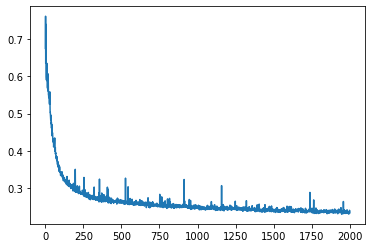

In [8]:
import matplotlib.pyplot as plt
ep=[i for i in range(1,2001)]

plt.plot(ep,mse_list1)

In [9]:
with open('mse_alpha_188_2_2000_file.txt', 'w') as f:
    for item in mse_list1:
        f.write("%s\n" % item)

In [17]:
print(model)

GNNNet(
  (mol_conv1): GCNConv(78, 78)
  (mol_conv2): GCNConv(78, 156)
  (mol_conv3): GCNConv(156, 312)
  (mol_fc_g1): Linear(in_features=312, out_features=1024, bias=True)
  (mol_fc_g2): Linear(in_features=1024, out_features=128, bias=True)
  (pro_conv1): GCNConv(54, 54)
  (pro_conv2): GCNConv(54, 108)
  (pro_conv3): GCNConv(108, 216)
  (pro_fc_g1): Linear(in_features=216, out_features=1024, bias=True)
  (pro_fc_g2): Linear(in_features=1024, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=1, bias=True)
)


In [15]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
f

28579328

In [14]:
torch.cuda.empty_cache()

In [17]:
print(t,r,a,f)

6222839808 136314880 107735552 28579328


In [29]:
print(t,r,a,f)

6222839808 60817408 35023360 25794048


In [11]:
torch.cuda.mem_get_info()

(44630016, 6222839808)

In [12]:
torch.cuda.memory_stats()

OrderedDict([('active.all.allocated', 203),
             ('active.all.current', 58),
             ('active.all.freed', 145),
             ('active.all.peak', 64),
             ('active.large_pool.allocated', 27),
             ('active.large_pool.current', 11),
             ('active.large_pool.freed', 16),
             ('active.large_pool.peak', 11),
             ('active.small_pool.allocated', 176),
             ('active.small_pool.current', 47),
             ('active.small_pool.freed', 129),
             ('active.small_pool.peak', 55),
             ('active_bytes.all.allocated', 196372992),
             ('active_bytes.all.current', 107735552),
             ('active_bytes.all.freed', 88637440),
             ('active_bytes.all.peak', 107735552),
             ('active_bytes.large_pool.allocated', 177236480),
             ('active_bytes.large_pool.current', 100467200),
             ('active_bytes.large_pool.freed', 76769280),
             ('active_bytes.large_pool.peak', 100467200),
     

In [34]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   34202 KB |    1664 MB |    1652 TB |    1652 TB |\n|       from large pool |   17587 KB |    1646 MB |    1637 TB |    1637 TB |\n|       from small pool |   16615 KB |      22 MB |      14 TB |      14 TB |\n|---------------------------------------------------------------------------|\n| Active memory         |   34202 KB |    1664 MB |    1652 TB |    1652 TB |\n|       from large pool |   17587 KB |    1646 MB |

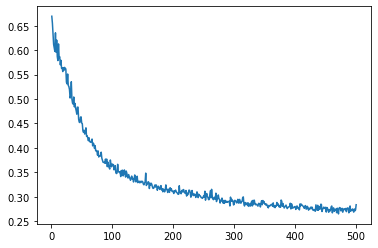

In [9]:
import matplotlib.pyplot as plt
ep=[i for i in range(1,501)]

plt.plot(ep,mse_list1)

In [10]:
with open('mse_alpha_500_file.txt', 'w') as f:
    for item in mse_list1:
        f.write("%s\n" % item)

In [4]:
import os
import sys
import torch
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

from emetrics import get_aupr, get_cindex, get_rm2, get_ci, get_mse, get_rmse, get_pearson, get_spearman
from utils import *
from scipy import stats
from gnn import GNNNet
from data_process import create_dataset_for_test


def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            # data = data.to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()


def load_model(model_path):
    model = torch.load(model_path)
    return model


def calculate_metrics(Y, P, dataset='davis'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)

    result_file_name = 'results/result_alpha_188_2000_' + model_st + '_' + dataset + '.txt'
    result_str = ''
    result_str += dataset + '\r\n'
    result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
        pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
    print(result_str)
    open(result_file_name, 'w').writelines(result_str)


def plot_density(Y, P, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    plt.savefig(os.path.join('results', dataset + '_alpha_188_2000_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')




/rds/user/co-gora1/hpc-work/DGraphDTA/emetrics.py:27: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if pair is not 0:
RDKit WARNING: [16:36:39] Enabling RDKit 2019.09.3 jupyter extensions
[16:36:39] Enabling RDKit 2019.09.3 jupyter extensions


In [5]:

dataset = ['davis', 'kiba'][1]  # dataset selection
model_st = GNNNet.__name__
print('dataset:', dataset)
cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][0] # gpu selection
print('cuda_name:', cuda_name)

 

dataset: kiba
cuda_name: cuda:0


In [6]:
TEST_BATCH_SIZE = 128
models_dir = 'models'
results_dir = 'results'

device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
#model_file_name = 'models_sample/model1111_' + model_st + '_' + dataset + '.model'
model_file_name = 'models_sample/model_kiba_alpha__188_2000_GNNNet_kiba_1.model'
result_file_name = 'results/resul_alpha__188_2000_' + model_st + '_' + dataset + '.txt'

model = GNNNet()
model.to(device)
model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
test_data = create_dataset_for_test(dataset,method)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

Y, P = predicting(model, device, test_loader)
calculate_metrics(Y, P, dataset)
    


GNNNet Loaded
dataset: kiba
test entries: 15932 effective test entries 15908
effective drugs,effective prot: 2068 187


/rds/user/co-gora1/hpc-work/DGraphDTA/utils.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  GCNData_mol = DATA.Data(x=torch.Tensor(features),


Make prediction for 15908 samples...
metrics for  kiba
cindex: 0.8467367913478503
cindex2 0.8440978890348535
rm2: 0.6403288035167601
mse: 0.2372404
pearson 0.8048206825224726
kiba
rmse:0.48707330443231  mse:0.2372404  pearson:0.8048206825224726 spearman:0.8070872922228141 ci:0.8467367913478503 rm2:0.6403288035167601


No handles with labels found to put in legend.


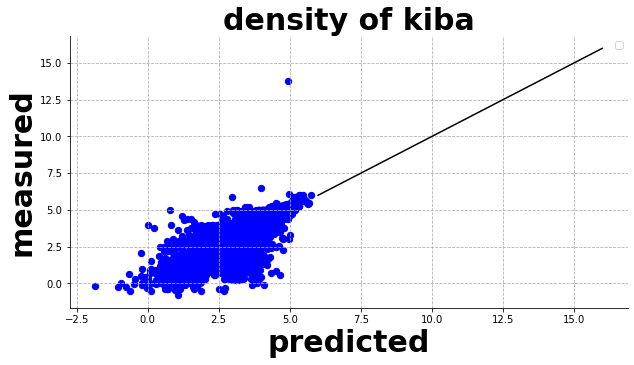

In [16]:
plot_density(Y, P, fold, dataset)

No handles with labels found to put in legend.


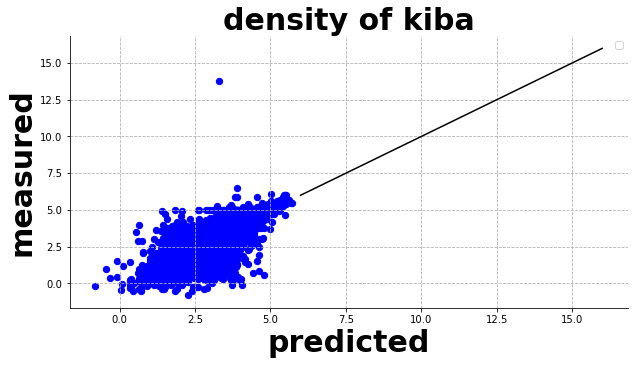

In [15]:
plot_density(Y, P, fold, dataset)

In [18]:
test_loader

In [10]:
Y

array([14.400163, 12.399998, 11.400001, ..., 11.400001, 11.5     ,
       11.5     ], dtype=float32)

In [11]:
P

array([13.495261, 12.662182, 11.396714, ..., 11.395967, 11.504625,
       11.45087 ], dtype=float32)

In [48]:

my_file = open("alpha500_pred_file.txt", "r")
content = my_file.read()
content=content.splitlines()
content=[float(i) for i in content]
print(content)

[13.572652, 12.826997, 11.444092, 10.318037, 11.341069, 11.559343, 11.85205, 11.203673, 10.334731, 11.582762, 13.900543, 12.97712, 11.691866, 12.792691, 14.458044, 11.520013, 12.257853, 11.212511, 12.006573, 11.880769, 11.1070795, 11.378011, 11.148856, 11.216189, 11.134102, 12.008484, 10.905703, 11.242366, 11.19693, 10.343345, 11.86922, 12.26573, 10.585809, 12.672529, 11.919928, 10.658084, 11.237454, 11.279299, 11.310264, 11.870662, 11.057477, 11.480621, 12.106813, 11.613607, 10.156403, 11.307625, 10.7861595, 11.92269, 11.224873, 12.009879, 10.479592, 11.211487, 11.759775, 11.364248, 11.742957, 12.0676775, 12.2011385, 11.140188, 11.8148365, 11.463266, 11.225105, 11.48033, 12.019633, 11.547219, 11.362604, 12.447442, 10.850902, 11.337198, 10.871161, 11.64067, 11.490308, 11.450138, 11.544379, 10.872649, 12.062119, 11.466935, 11.917785, 11.780647, 11.215674, 12.046588, 11.4404955, 10.219847, 11.889244, 11.15485, 11.559784, 12.427896, 12.339859, 10.860705, 12.2455225, 11.580148, 11.404127, 

In [49]:
P1=np.asarray(content)

In [50]:
P1

array([13.572652 , 12.826997 , 11.444092 , ..., 11.422882 , 11.5344305,
       11.544348 ])

In [52]:
plt.scatter(P,color='blue')

TypeError: scatter() missing 1 required positional argument: 'y'

In [37]:
type(content)

str

In [41]:
P

array([13.495261, 12.662182, 11.396714, ..., 11.395967, 11.504625,
       11.45087 ], dtype=float32)

No handles with labels found to put in legend.


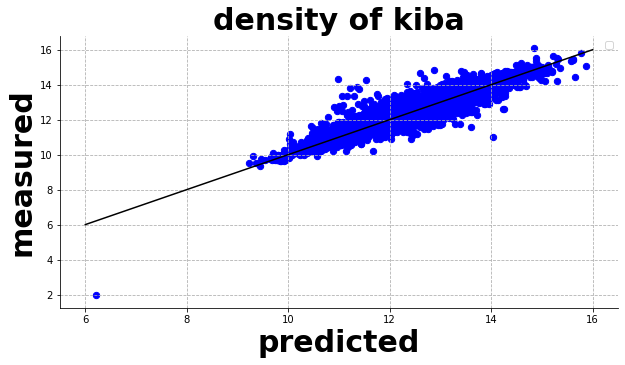

In [53]:
plot_density(P1, P, fold, dataset)

In [12]:
with open('pconsc4_500_gt_file.txt', 'w') as f:
    for item in list(Y):
        f.write("%s\n" % item)

In [13]:
with open('pconsc4_500_pred_file.txt', 'w') as f:
    for item in list(P):
        f.write("%s\n" % item)

No handles with labels found to put in legend.


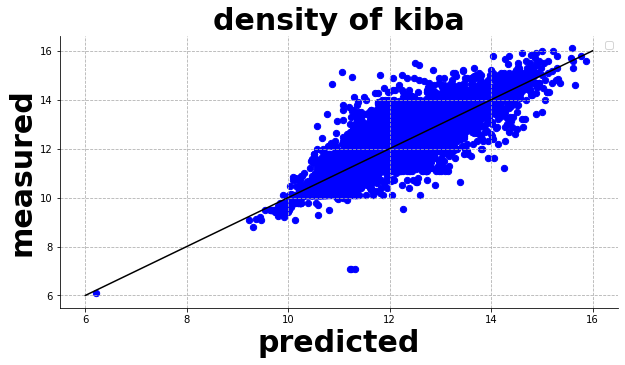

In [54]:
plot_density(Y, P, fold, dataset)

In [58]:
def plot_density1(Y, P,P1, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.scatter(P1, Y, color='green', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    #plt.savefig(os.path.join('results', dataset + 'alpha v/s pconsc4_500_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')


No handles with labels found to put in legend.


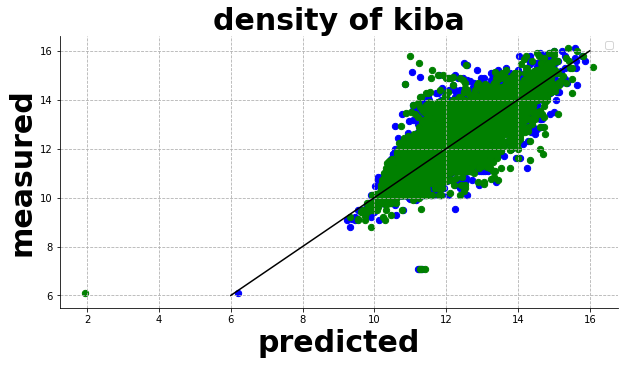

In [59]:
plot_density1(Y, P,P1, fold, dataset)

No handles with labels found to put in legend.


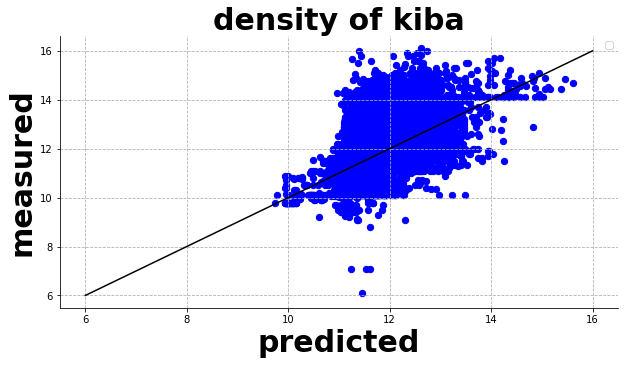

In [13]:
plot_density(Y, P, fold, dataset)

In [ ]:
plot_density(Y, P, fold, dataset)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'